In [1]:
# Install required package
import sys
!{sys.executable} -m pip install --user steam-nb-api

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

# Global variables

In [2]:
nameMagnet = 'd11T_4in1'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = True

# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 35840


<IPython.core.display.Javascript object>


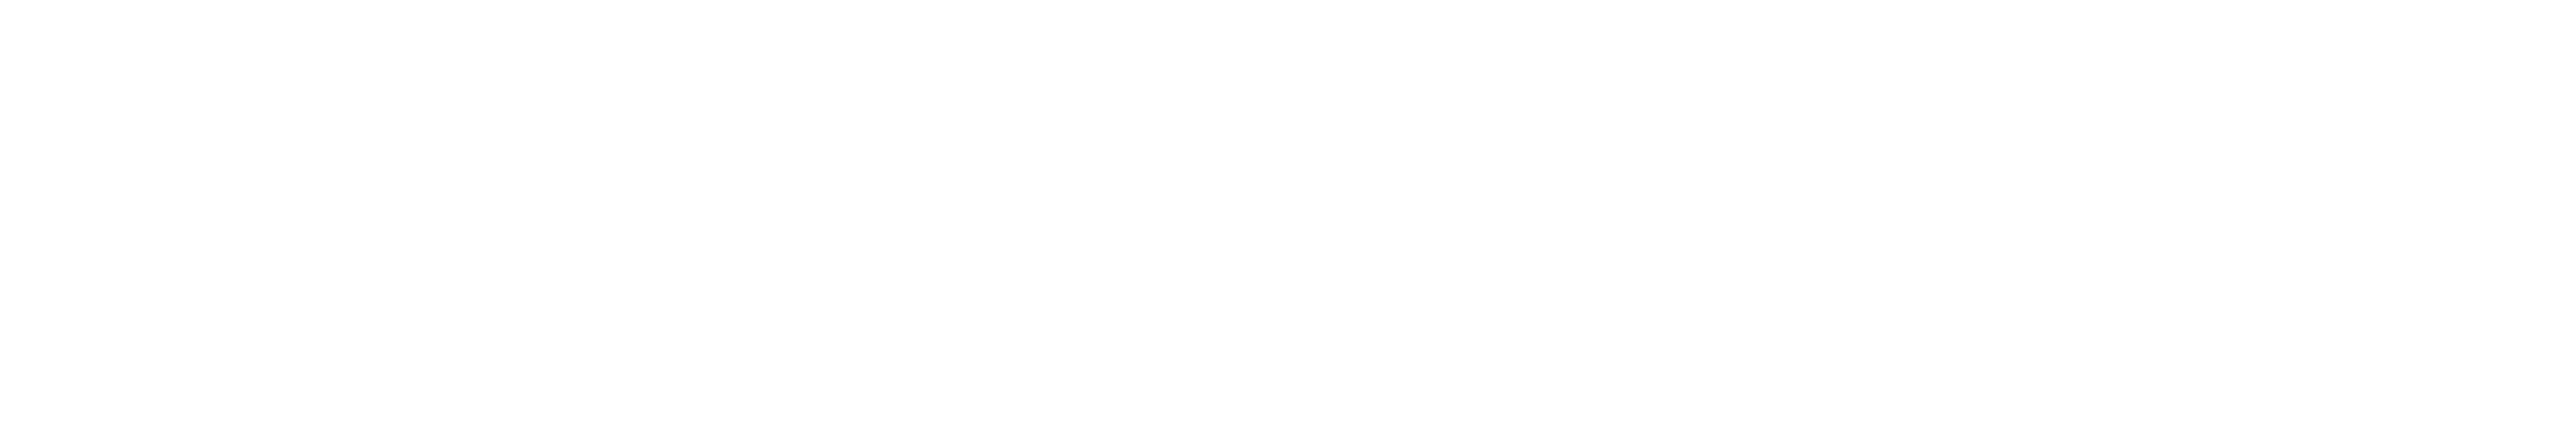

In [3]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
#         print(index)
#         print(row)
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = ' + str(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])

# Plot strand currents and magnetic field
%matplotlib notebook
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()


# Manipulate imported strand positions

Total number of strands = 35840
Total number of half-turns = 896
Total number of turns = 448


<IPython.core.display.Javascript object>


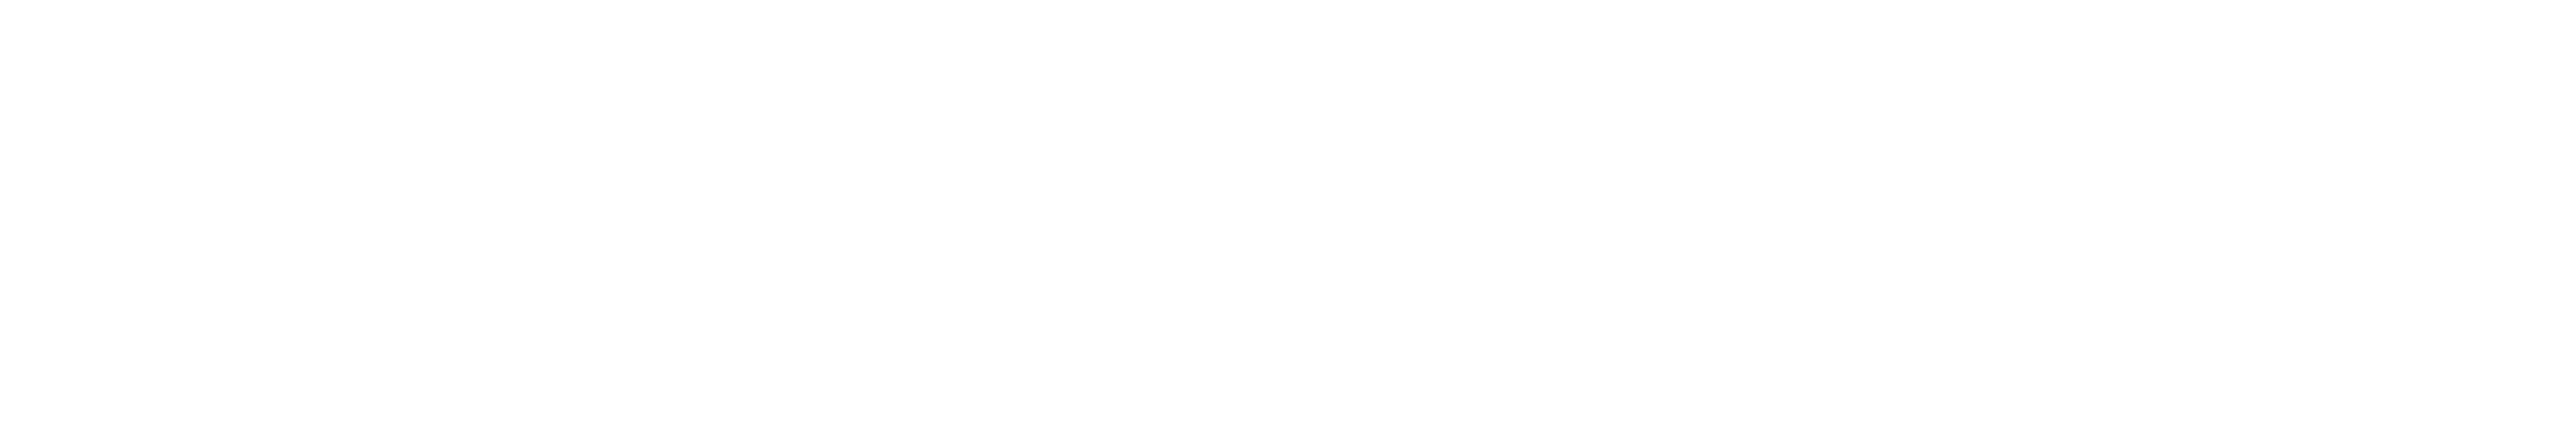

In [4]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))

# Plot strand currents and magnetic field
%matplotlib notebook
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Overall magnet variables

In [5]:
T00 = 1.9
l_magnet = 5.3
I00 = 11850

# Definition of groups of conductors

In [6]:
nGroupsDefined = 32
GroupToCoilSection = nGroupsDefined*[1]
polarities_inGroup = [1, 1, -1, -1, -1, -1, 1, 1]*2 + [-1, -1, +1, +1, +1, +1, -1, -1]*2

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')

1 coil sections defined.
32 groups defined.


# Conductor properties in each group

In [7]:
# Number of half-turns in each group
nT = int(nGroupsDefined/2) * [22, 34]
# Number of strands in each cable belonging to a particular group
nStrands_inGroup = nGroupsDefined * [40]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = nGroupsDefined * [l_magnet]
# strand diameter [m]
ds_inGroup = nGroupsDefined * [0.70E-3]
# fraction of superconductor in the strands
f_SC_strand_inGroup = nGroupsDefined * [1/(1+1.19)]
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = nGroupsDefined * [1]
# Filament twist-pitch [m]
Lp_f_inGroup = nGroupsDefined * [0.014]
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = nGroupsDefined * [159]
# type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = nGroupsDefined * [2]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = nGroupsDefined * [1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = nGroupsDefined * [1]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = nGroupsDefined * [1]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = nGroupsDefined * [1]
# bare cable width [m]
wBare_inGroup = nGroupsDefined * [14.847E-3]
# bare average cable height [m]
hBare_inGroup = nGroupsDefined * [1.3065E-3]
# insulation thickness in the width direction [m]
wIns_inGroup = nGroupsDefined * [100E-6]
# insulation thickness in the height direction [m]
hIns_inGroup = nGroupsDefined * [100E-6]
# Strand twist-pitch [m]
Lp_s_inGroup = nGroupsDefined * [0.111]
# Cross-contact resistance [Ohm]
R_c_inGroup = nGroupsDefined * [10E-6]
# Tc0_NbTi_ht_inGroup - ONLY USED FOR NB-TI [K]
Tc0_NbTi_ht_inGroup = nGroupsDefined * [0]
# Bc2_NbTi_ht_inGroup - ONLY USED FOR NB-TI  [T]
Bc2_NbTi_ht_inGroup = nGroupsDefined * [0]
# c1_Ic_NbTi_inGroup - ONLY USED FOR NB-TI  [A]
c1_Ic_NbTi_inGroup = nGroupsDefined * [0]
# c2_Ic_NbTi_inGroup - ONLY USED FOR NB-TI  [A/T]
c2_Ic_NbTi_inGroup = nGroupsDefined * [0]
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = nGroupsDefined * [16.33]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = nGroupsDefined * [26.45]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = nGroupsDefined * [4.224E+10]

nHalfTurnsDefined = np.sum(nT)
print('{} half-turns defined.'.format(nHalfTurnsDefined))
print('')
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 500E-6
insulationAroundCables = 100E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = {}'.format(fScaling_Pex_AlongHeight_Defined))

896 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 0.28571428571428575


# Electrical order of the half-turns

The half-turns of these pairs of groups will be connected electrically:
[[6, 22], [5, 21], [7, 23], [8, 24], [14, 30], [13, 29], [15, 31], [16, 32], [12, 28], [11, 27], [9, 25], [10, 26], [4, 20], [3, 19], [1, 17], [2, 18]]


<IPython.core.display.Javascript object>


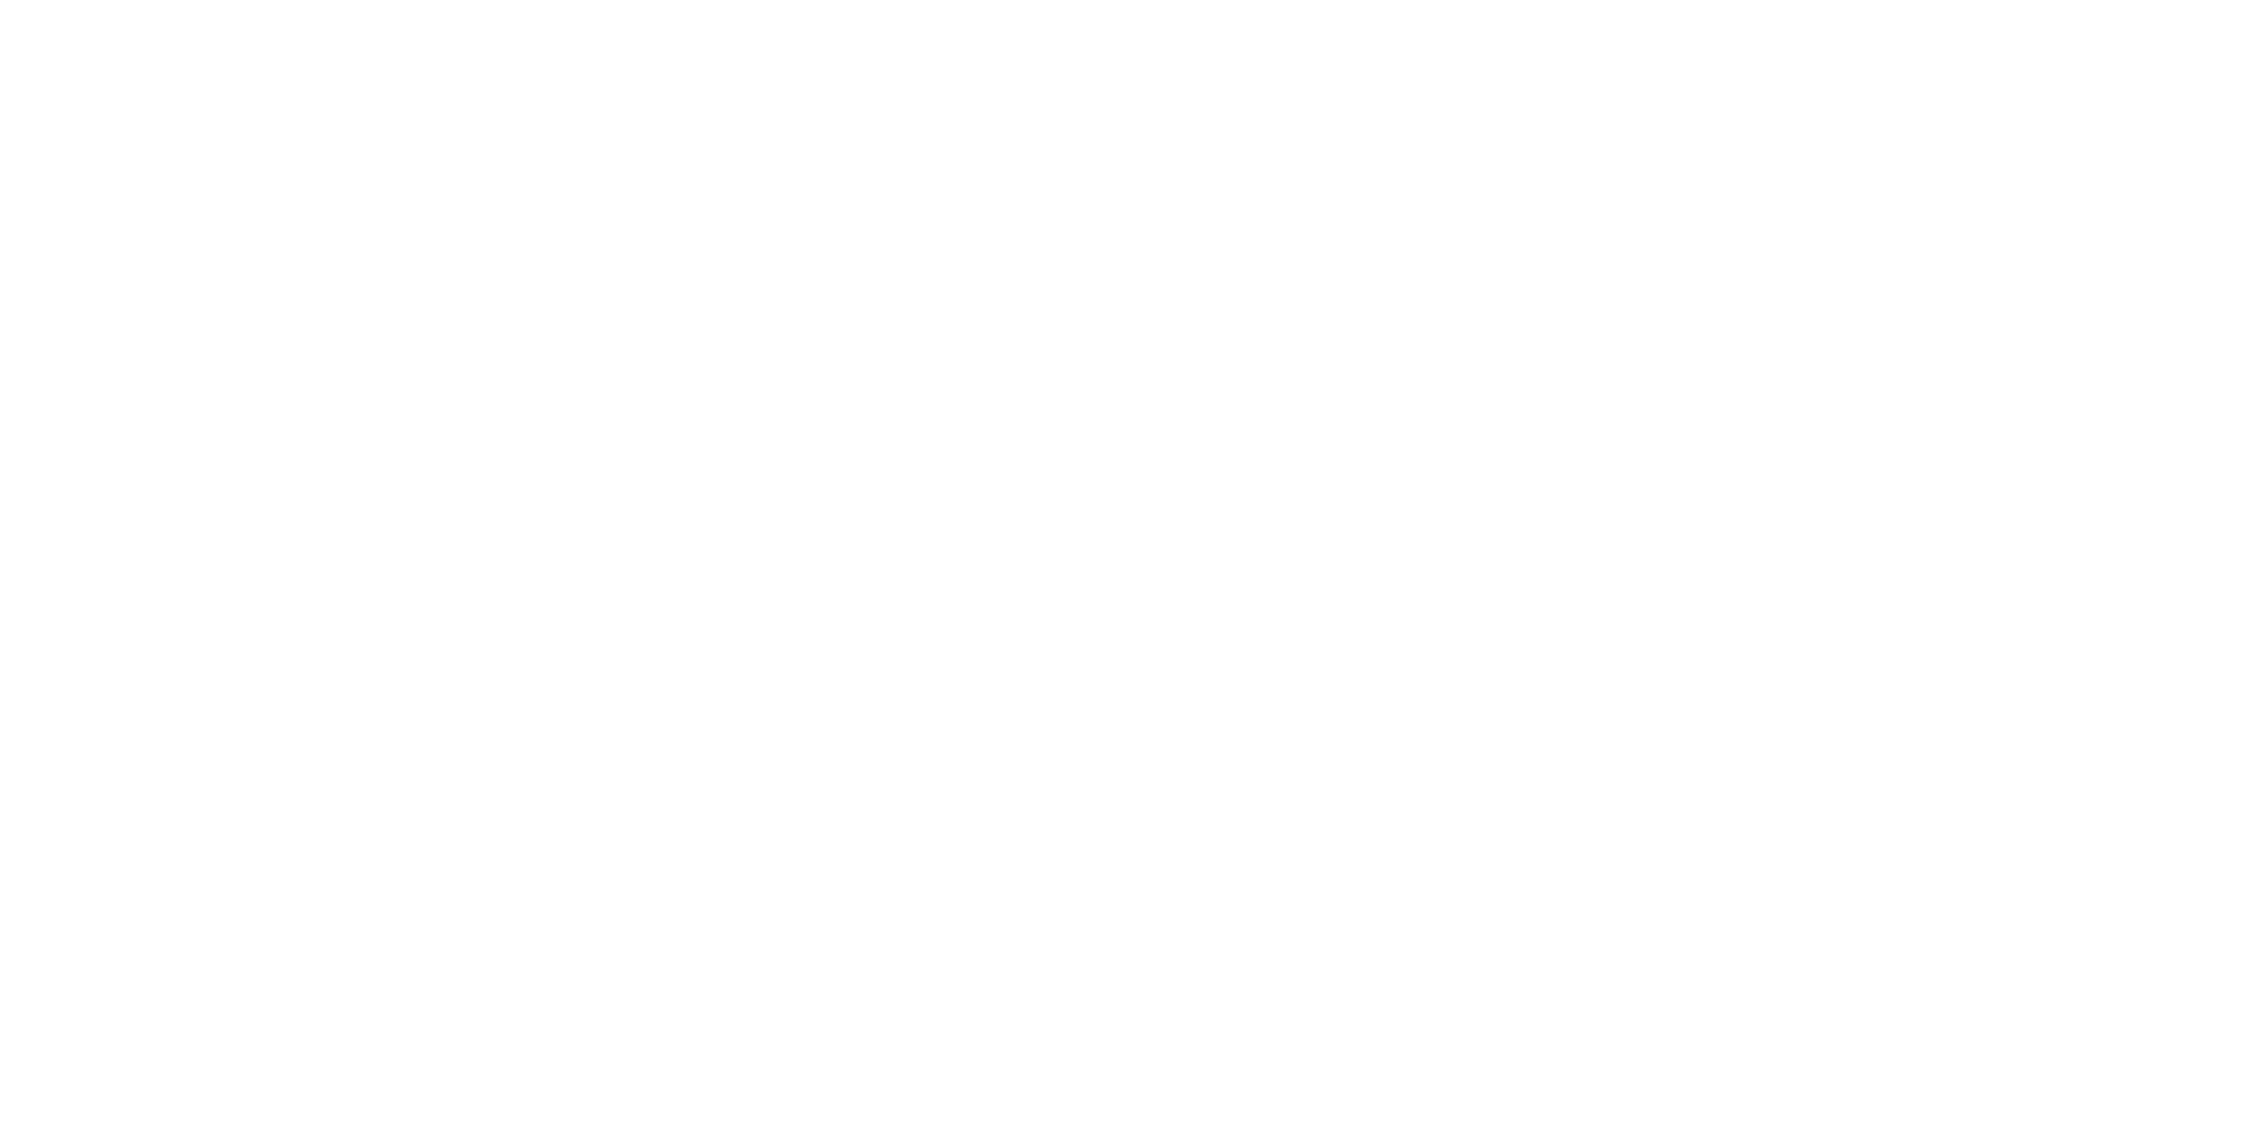

Calculated electrical order of the half-turns:
el_order_half_turns = [135, 583, 136, 584, 137, 585, 138, 586, 139, 587, 140, 588, 141, 589, 142, 590, 143, 591, 144, 592, 145, 593, 146, 594, 147, 595, 148, 596, 149, 597, 150, 598, 151, 599, 152, 600, 153, 601, 154, 602, 155, 603, 156, 604, 157, 605, 158, 606, 159, 607, 160, 608, 161, 609, 162, 610, 163, 611, 164, 612, 165, 613, 166, 614, 167, 615, 168, 616, 134, 582, 133, 581, 132, 580, 131, 579, 130, 578, 129, 577, 128, 576, 127, 575, 126, 574, 125, 573, 124, 572, 123, 571, 122, 570, 121, 569, 120, 568, 119, 567, 118, 566, 117, 565, 116, 564, 115, 563, 114, 562, 113, 561, 169, 617, 170, 618, 171, 619, 172, 620, 173, 621, 174, 622, 175, 623, 176, 624, 177, 625, 178, 626, 179, 627, 180, 628, 181, 629, 182, 630, 183, 631, 184, 632, 185, 633, 186, 634, 187, 635, 188, 636, 189, 637, 190, 638, 224, 672, 223, 671, 222, 670, 221, 669, 220, 668, 219, 667, 218, 666, 217, 665, 216, 664, 215, 663, 214, 662, 213, 661, 212, 660, 211, 659, 210, 658, 

In [8]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether = [ [6,22], [5,21], [7,23], [8,24],  [14,30], [13,29], [15,31], [16,32],  [12,28], [11,27], [9,25], [10,26],  [4,20], [3,19], [1,17], [2,18],   ]

# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder = [ 0, 1, 0, 1,  0, 1, 0, 1,  0, 1, 0, 1,  0, 1, 0, 1, ] # New electrical order (May 2019)
nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    error('Length of the vector elPairs_RevElOrder should be equal to nElPairs.')

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        error('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)

# Plot
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 2, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = ' + str(el_order_half_turns))

<IPython.core.display.Javascript object>


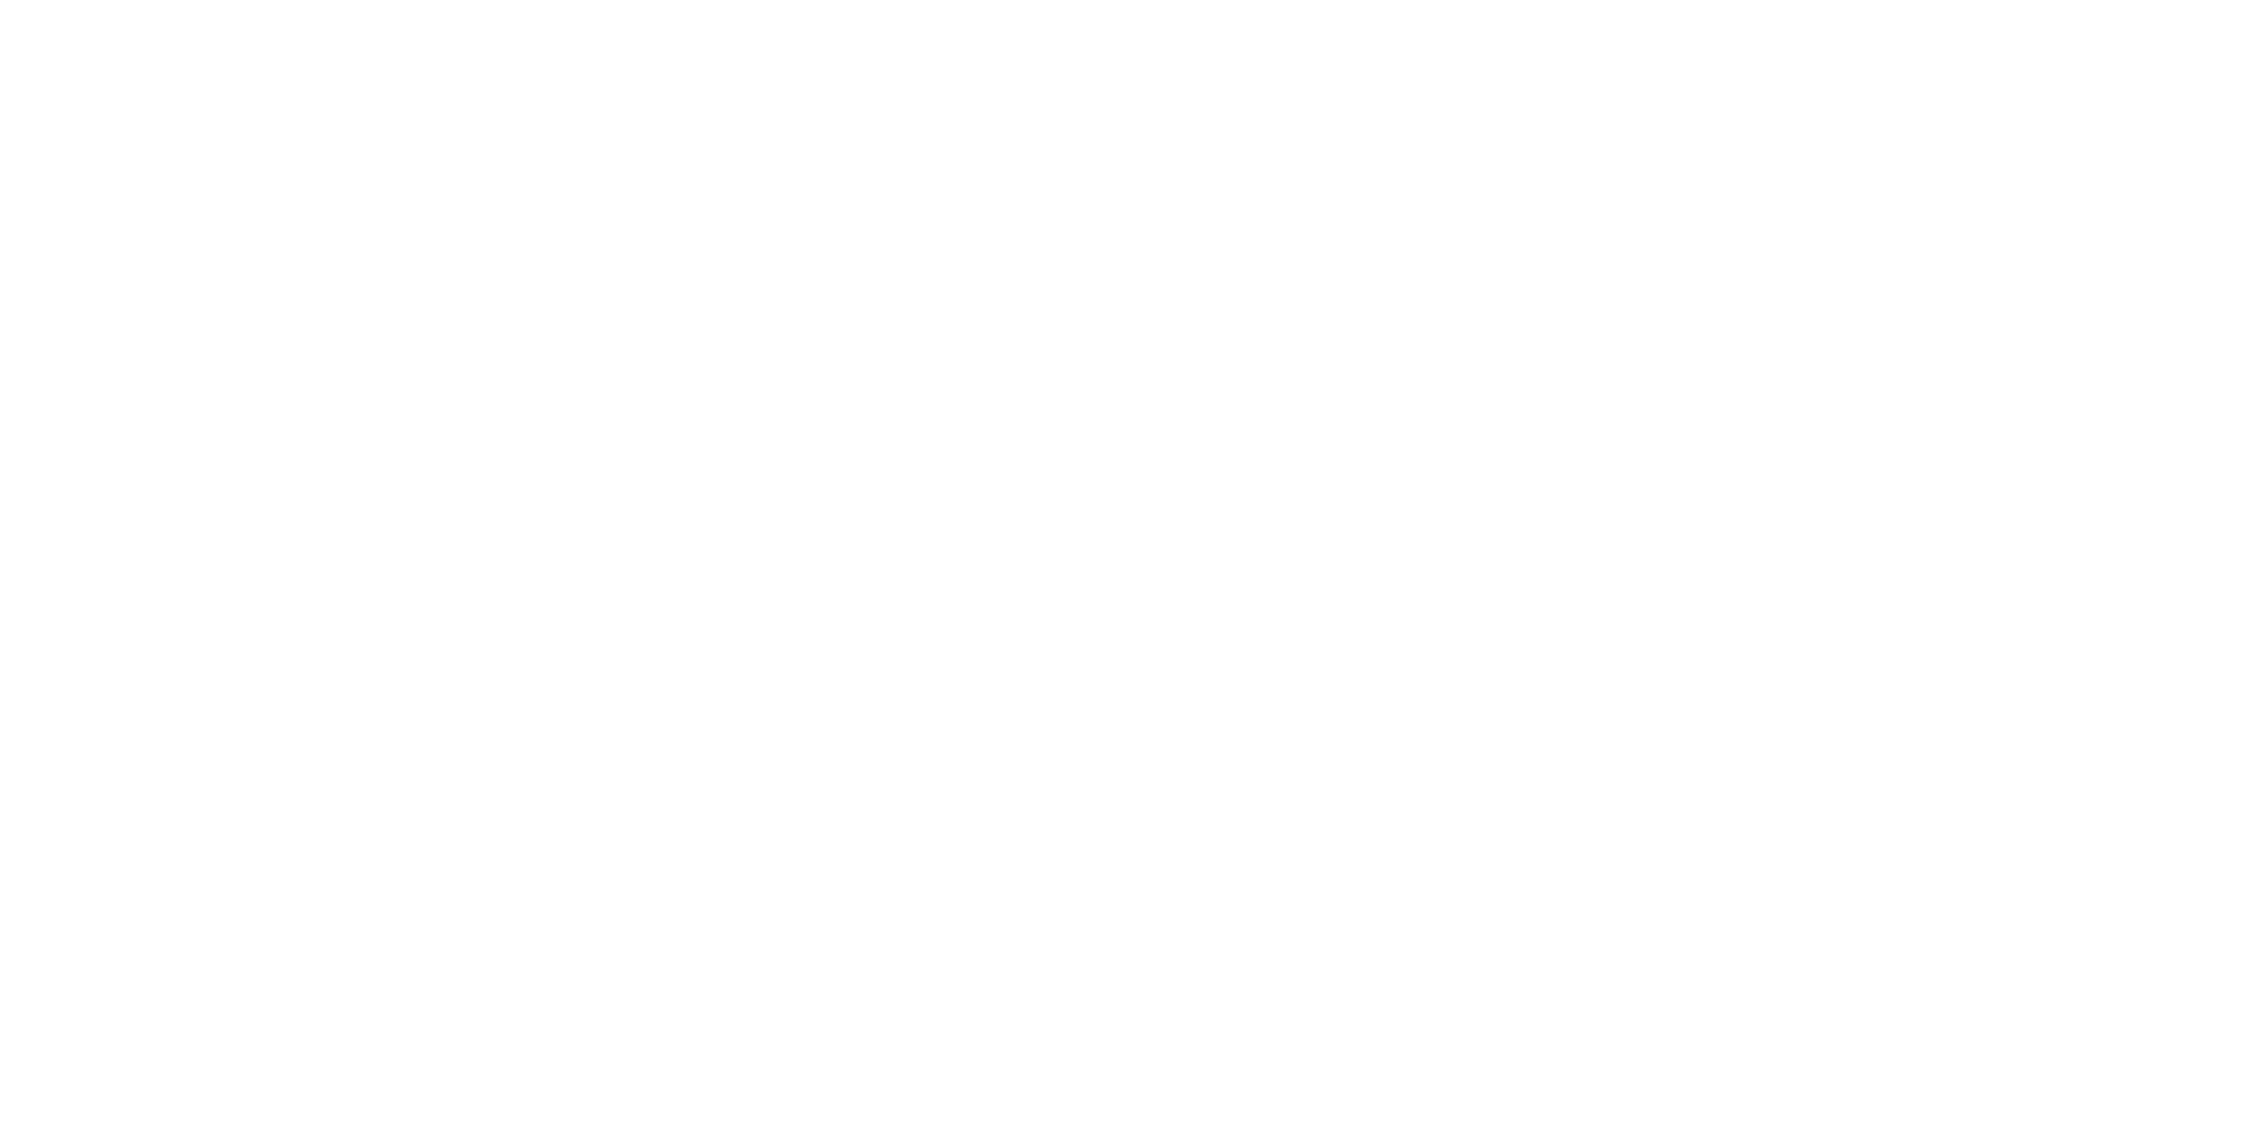

Calculated electrical order of the half-turns:
el_order_half_turns = [135, 583, 136, 584, 137, 585, 138, 586, 139, 587, 140, 588, 141, 589, 142, 590, 143, 591, 144, 592, 145, 593, 146, 594, 147, 595, 148, 596, 149, 597, 150, 598, 151, 599, 152, 600, 153, 601, 154, 602, 155, 603, 156, 604, 157, 605, 158, 606, 159, 607, 160, 608, 161, 609, 162, 610, 163, 611, 164, 612, 165, 613, 166, 614, 167, 615, 168, 616, 134, 582, 133, 581, 132, 580, 131, 579, 130, 578, 129, 577, 128, 576, 127, 575, 126, 574, 125, 573, 124, 572, 123, 571, 122, 570, 121, 569, 120, 568, 119, 567, 118, 566, 117, 565, 116, 564, 115, 563, 114, 562, 113, 561, 169, 617, 170, 618, 171, 619, 172, 620, 173, 621, 174, 622, 175, 623, 176, 624, 177, 625, 178, 626, 179, 627, 180, 628, 181, 629, 182, 630, 183, 631, 184, 632, 185, 633, 186, 634, 187, 635, 188, 636, 189, 637, 190, 638, 224, 672, 223, 671, 222, 670, 221, 669, 220, 668, 219, 667, 218, 666, 217, 665, 216, 664, 215, 663, 214, 662, 213, 661, 212, 660, 211, 659, 210, 658, 

In [9]:
# Plot
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.scatter(x_ave[el_order_half_turns_Array[0:223]], y_ave[el_order_half_turns_Array[0:223]], s=2, c='k')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
# cbar = plt.colorbar()
# cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 2, 2)
plt.plot(x_ave[el_order_half_turns_Array[0:223]],y_ave[el_order_half_turns_Array[0:223]],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = ' + str(el_order_half_turns))

# Cable geometry parameters (NOT DONE AUTOMATICALLY - PLACEHOLDER)

In [10]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG = 2*[0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 28, 28.8065, 29.613, 30.4195, 31.226, 32.0325, 32.839, 33.6455, 59, 59.8065, 60.6131, 70, 70.8065, 0, 0.8065, 1.613, 2.4195, 3.226, 4.0325, 4.839, 5.6455, 6.452, 7.2585, 8.065, 8.8715, 9.678, 10.4845, 11.291, 12.0975, 33, 33.8065, 34.613, 35.4195, 36.226, 37.0325, 37.839, 38.6455, 39.452, 40.2585, 41.065, 41.8715, 42.678, 43.4845, 44.291, 45.0975, 45.904, 46.7105, ]
# Rotate cable by a certain angle [deg]
rotation_block = 2*[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, ]
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = 2*[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]


if len(alphasDEG)!=nHalfTurnsDefined:
    raise Exception('Length of the vector alphasDEG ({}) must be equal to nHalfTurnsDefined={}.'.format(len(alphasDEG),nHalfTurnsDefined))
if len(rotation_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector rotation_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(rotation_block),nHalfTurnsDefined))
if len(mirror_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirror_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirror_block),nHalfTurnsDefined))
if len(mirrorY_block)!=nHalfTurnsDefined:
    raise Exception('Length of the vector mirrorY_block ({}) must be equal to nHalfTurnsDefined={}.'.format(len(mirrorY_block),nHalfTurnsDefined))

In [11]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)


# CALCULATED MANUALLY
# 
# Pairs of half-turns manually selected for exchanging heat in the first half-quadrant
iContactAlongHeight_From = [2, 3, 4, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 57, 58, 59, 60, 60, 61, 62, 63, 64, 65, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 113, 114, 115, 116, 116, 117, 118, 119, 120, 121, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 169, 170, 171, 172, 172, 173, 174, 175, 176, 177, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 225, 226, 227, 228, 228, 229, 230, 231, 232, 233, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 281, 282, 283, 284, 284, 285, 286, 287, 288, 289, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 337, 338, 339, 340, 340, 341, 342, 343, 344, 345, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 393, 394, 395, 396, 396, 397, 398, 399, 400, 401, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 449, 450, 451, 452, 452, 453, 454, 455, 456, 457, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 505, 506, 507, 508, 508, 509, 510, 511, 512, 513, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 561, 562, 563, 564, 564, 565, 566, 567, 568, 569, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 617, 618, 619, 620, 620, 621, 622, 623, 624, 625, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 673, 674, 675, 676, 676, 677, 678, 679, 680, 681, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 729, 730, 731, 732, 732, 733, 734, 735, 736, 737, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 785, 786, 787, 788, 788, 789, 790, 791, 792, 793, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 841, 842, 843, 844, 844, 845, 846, 847, 848, 849, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, ]
iContactAlongHeight_To = [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 54, 55, 56, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 94, 95, 96, 97, 98, 99, 100, 101, 110, 111, 112, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 150, 151, 152, 153, 154, 155, 156, 157, 166, 167, 168, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 206, 207, 208, 209, 210, 211, 212, 213, 222, 223, 224, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 262, 263, 264, 265, 266, 267, 268, 269, 278, 279, 280, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 318, 319, 320, 321, 322, 323, 324, 325, 334, 335, 336, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 374, 375, 376, 377, 378, 379, 380, 381, 390, 391, 392, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 430, 431, 432, 433, 434, 435, 436, 437, 446, 447, 448, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 486, 487, 488, 489, 490, 491, 492, 493, 502, 503, 504, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 542, 543, 544, 545, 546, 547, 548, 549, 558, 559, 560, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 598, 599, 600, 601, 602, 603, 604, 605, 614, 615, 616, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 654, 655, 656, 657, 658, 659, 660, 661, 670, 671, 672, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 710, 711, 712, 713, 714, 715, 716, 717, 726, 727, 728, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 766, 767, 768, 769, 770, 771, 772, 773, 782, 783, 784, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 822, 823, 824, 825, 826, 827, 828, 829, 838, 839, 840, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 878, 879, 880, 881, 882, 883, 884, 885, 894, 895, ]

# Pairs of half-turns exchanging heat along the cable narrow side
print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongHeight_To = ')
print(iContactAlongHeight_To)


iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

# Plot
%matplotlib notebook
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.scatter(x_ave, y_ave, s=2, c='k')
# plt.plot(x_ave[iContactAlongHeight_From_Array-1],y_ave[iContactAlongHeight_From_Array-1],'k')


for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')

for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')

# # axes = plt.gca()
# # axes.set_xlim([125E-3,165E-3])
# # axes.set_ylim([0,50E-3])

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


# Quench initiation calculation: Force selected half-turns to quench

In [12]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = [1]
# Time at which each selected half-turn quenches [s]
tStartQuench = [-0.015+99999]
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
vQ_iStartQuench = [2*20]

# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>

# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [13]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 0.0000
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.0000
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0

# Power supply control

In [14]:
# Time when the power supply is switched off and the crowbar is switched on [s]
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [-0.02, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='lower left')

# Energy-extraction system

In [15]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.066

# CLIQ system

In [16]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# Quench heater system (NOT DONE AUTOMATICALLY: Heat exchange between heater strips and half-turns)

In [17]:
# Number of quench heater strips to write in the file
nHeaterStripsType1 = 16
nHeaterStripsType2 = 16

# Time at which the power supply connected to the QH strip is triggered (set to a very large value to avoid triggering).
tQH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [.001, .001]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [450, 450]
# Capacitance of the capacitor connected to the QH strip.
C_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [14.1E-3, 14.1E-3]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [0.701, 1.584]
# Width of the non-Cu-plated part of the the QH strip.
w_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [19E-3, 24E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [25E-6, 25E-6]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [55E-6, 55E-6]
# Type of material of the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [2, 2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [508E-6, 508E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [2, 2]
# Length of the QH strip.
l_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [5.611764706, 5.611764706]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = int((nHeaterStripsType1+nHeaterStripsType2)/2) * [0.3571, 0.2778]

# CALCULATED MANUALLY
# Thermal connections between heater strips and half-turns
iQH_toHalfTurn_From = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, ]
iQH_toHalfTurn_To = [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, ]



############################################################################################################
# The following lines do not affect the generated LEDET input file, and are only used to debug this notebook
# Calculate QH strip resistance
rhoSS = 5.00E-07 * 1.09 # in [Ohm m]
R_cold_QH, R_total_QH, I0_QH, tau_QH = [], [], [], []
for qh in range(len(tQH)):
    R_cold_QH.append(rhoSS / (w_QH[qh] * h_QH[qh]) * l_QH[qh] * f_QH[qh])
    R_total_QH.append(R_cold_QH[qh] + R_warm_QH[qh])
    I0_QH.append(U0_QH[qh] / R_total_QH[qh])
    tau_QH.append(R_total_QH[qh] * C_QH[qh])

print('I0_QH={}'.format(I0_QH))
print('tau_QH={}'.format(tau_QH))

I0_QH=[149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672, 149.9859127758217, 149.99776767879672]
tau_QH=[0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952394799, 0.0423039729703391, 0.04230062952

# Adiabatic hot-spot temperature calculation

In [18]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [-0.015]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]
# Time-stepping used in the hot-spot temperature calculation [s]
tStepHotSpotT = nCoilSectionsDefined * [100E-6]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [19]:
L_large = np.array([
[ 1.303843687725250E-06, 1.136006819921010E-06, 1.043193658953300E-06, 9.638307206760440E-07, 8.945382568566320E-07, 8.331210071846860E-07, 7.780105673058710E-07, 7.280298519144690E-07, 6.822681967053910E-07, 5.539938250951870E-07, 5.220409000349360E-07, 4.919918425310030E-07, 4.635749553143600E-07, 4.365634859113220E-07, 4.107654600536820E-07, 3.860149883619910E-07, 3.621680419838550E-07, 2.419143416020200E-07, 2.228637198364020E-07, 2.042428027946250E-07, 1.329592108413290E-07, 1.158431796805740E-07, 7.428033152323260E-07, 7.400546020377270E-07, 7.317050915989770E-07, 7.197370528138190E-07, 7.053744232060710E-07, 6.893947169472120E-07, 6.723291279791480E-07, 6.545562149354720E-07, 6.363518195908680E-07, 6.179176484970710E-07, 5.994027457612930E-07, 5.809161586615600E-07, 5.625372077498110E-07, 5.443221086813200E-07, 5.263098609732690E-07, 5.085261515939110E-07, 4.516122447009870E-07, 4.354981705618830E-07, 4.197123215670950E-07, 4.042016249247800E-07, 3.889657905875310E-07, 3.740349406832760E-07, 3.593964578348560E-07, 3.450322065254330E-07, 3.309248863774980E-07, 3.170572148019780E-07, 3.034126701879160E-07, 2.899749352947550E-07, 2.767284242049860E-07, 2.636578584035620E-07, 2.507482359231250E-07, 2.379851438446600E-07, 2.253543534770110E-07, 2.128418552172910E-07, 1.120415313851440E-06, 1.030500322019270E-06, 9.534097879951610E-07, 8.860263639406930E-07, 8.262765347991790E-07, 7.726595395542970E-07, 7.240453666627210E-07, 6.795577652385900E-07, 6.385025949541130E-07, 5.219700429939230E-07, 4.925837892433670E-07, 4.648338088487890E-07, 4.384935702526340E-07, 4.133725682180870E-07, 3.893081397140150E-07, 3.661584576173620E-07, 3.437993837848920E-07, 2.303697551402280E-07, 2.123092229029110E-07, 1.946366421630690E-07, 1.268363448601950E-07, 1.105286355315220E-07, 7.371893243459970E-07, 7.268251712966000E-07, 7.134773915253890E-07, 6.981803690111050E-07, 6.815938188471180E-07, 6.641726504061400E-07, 6.462394142422860E-07, 6.280274422740210E-07, 6.097070257365030E-07, 5.914011157522870E-07, 5.731990614680340E-07, 5.551641454938040E-07, 5.373404343272620E-07, 5.197569160272780E-07, 5.024314537516870E-07, 4.853734148046350E-07, 4.308651075845230E-07, 4.155256982292430E-07, 4.005050956252100E-07, 3.857526788027210E-07, 3.712652943529960E-07, 3.570671597435980E-07, 3.431449657588520E-07, 3.294807745735970E-07, 3.160576688880850E-07, 3.028588929814320E-07, 2.898685458310060E-07, 2.770710140735470E-07, 2.644514507117550E-07, 2.519953507481070E-07, 2.396885178759440E-07, 2.275173374531660E-07, 2.154683959167050E-07, 2.035285006926250E-07, 3.231304237703490E-08, 3.225927040274610E-08, 3.212888650386040E-08, 3.192221059697200E-08, 3.163990048233440E-08, 3.128284150860170E-08, 3.085207363679540E-08, 3.034879338937200E-08, 2.977433107076820E-08, 2.750350786196470E-08, 2.674481435774590E-08, 2.595155144559710E-08, 2.511465393818820E-08, 2.423695010579640E-08, 2.332105303029130E-08, 2.236933011699210E-08, 2.138390352735330E-08, 1.540206045398080E-08, 1.433181823269310E-08, 1.326031232847130E-08, 8.864782544652320E-09, 7.770452805771980E-09, 4.776063466297200E-08, 4.770944881435840E-08, 4.758790515751370E-08, 4.739615313470690E-08, 4.713516316878900E-08, 4.680620962217420E-08, 4.641089515248410E-08, 4.595109338746850E-08, 4.542896232413650E-08, 4.484684015877450E-08, 4.420730127995140E-08, 4.351304764878540E-08, 4.276689740018700E-08, 4.197179699307870E-08, 4.113068100996800E-08, 4.024658242939070E-08, 3.698759822324350E-08, 3.600723230458750E-08, 3.500752786957970E-08, 3.399650368150760E-08, 3.297622482692910E-08, 3.194325580226720E-08, 3.089898519136360E-08, 2.984528790493270E-08, 2.878393450955070E-08, 2.771643176961620E-08, 2.664415604056500E-08, 2.556829416604240E-08, 2.448989008977520E-08, 2.340980465988130E-08, 2.232876594434940E-08, 2.124734145534990E-08, 2.016597347245080E-08, 1.908496160754890E-08, 3.230338998815990E-08, 3.223302526293590E-08, 3.208627243581400E-08, 3.186360894043440E-08, 3.156584551750630E-08, 3.119401359822190E-08, 3.074929185353410E-08, 3.023300626175480E-08, 2.964660551605360E-08, 2.734215101422910E-08, 2.657706635136800E-08, 2.577859012169390E-08, 2.493781103391860E-08, 2.405754914766410E-08, 2.314040172000990E-08, 2.218871331050340E-08, 2.120457790487250E-08, 1.525030763666420E-08, 1.418776445340160E-08, 1.312451327625260E-08, 8.768825821842310E-09, 7.685380087321750E-09, 4.774471268345480E-08, 4.766611483318130E-08, 4.751742875477250E-08, 4.729898572491050E-08, 4.701193050336370E-08, 4.665770421928710E-08, 4.623806486634520E-08, 4.575502900936510E-08, 4.521088442619910E-08, 4.460808279208130E-08, 4.394929739527250E-08, 4.323731233407600E-08, 4.247501239096880E-08, 4.166539426683910E-08, 4.081142793504390E-08, 3.991616687909060E-08, 3.662963919357420E-08, 3.564550266605230E-08, 3.464346938599150E-08, 3.363136449672110E-08, 3.261119345930230E-08, 3.157959538288540E-08, 3.053791132187900E-08, 2.948795059741190E-08, 2.843141757499700E-08, 2.736975474877580E-08, 2.630427519256490E-08, 2.523610442513910E-08, 2.416622719060540E-08, 2.309544807524520E-08, 2.202444108709190E-08, 2.095372316664040E-08, 1.988368851865410E-08, 1.881459187767330E-08, ],
[ 1.136006819921010E-06, 1.303310057354290E-06, 1.135093046282810E-06, 1.041857943859490E-06, 9.620289394321140E-07, 8.922286674443840E-07, 8.302695283805770E-07, 7.745860013461800E-07, 7.240020260433160E-07, 5.839461373958180E-07, 5.494760923518810E-07, 5.171905889148470E-07, 4.867685258176410E-07, 4.579440816432780E-07, 4.304939870145780E-07, 4.042269013164440E-07, 3.789779385926510E-07, 2.523811588901560E-07, 2.324223251402290E-07, 2.129340506532010E-07, 1.384824072793680E-07, 1.206348112792940E-07, 7.362416257866200E-07, 7.419088347401390E-07, 7.409170798020830E-07, 7.338875521161530E-07, 7.228308794204540E-07, 7.090890051382090E-07, 6.935083950137500E-07, 6.766682193778940E-07, 6.589829879764350E-07, 6.407550282456220E-07, 6.222084972869570E-07, 6.035095873349820E-07, 5.847815004729020E-07, 5.661143506599530E-07, 5.475734941649950E-07, 5.292050491454360E-07, 4.702788134724760E-07, 4.534812021032550E-07, 4.370154198042610E-07, 4.208269954052470E-07, 4.049192902361040E-07, 3.893289008586570E-07, 3.740444070737170E-07, 3.590478976042920E-07, 3.443220337779820E-07, 3.298492950612790E-07, 3.156127798721510E-07, 3.015956719149750E-07, 2.877818203097140E-07, 2.741553238944910E-07, 2.607005072462570E-07, 2.474022752277050E-07, 2.342456882594640E-07, 2.212160143507400E-07, 1.030500322019270E-06, 9.537766080477680E-07, 8.867948367717200E-07, 8.274809629574850E-07, 7.743333547287830E-07, 7.262172144300870E-07, 6.822549871851120E-07, 6.417528395933080E-07, 6.041523705927790E-07, 4.964070010766850E-07, 4.689806103933500E-07, 4.429993246818520E-07, 4.182676417041500E-07, 3.946202583706010E-07, 3.719150778831000E-07, 3.500273107309080E-07, 3.288470218072380E-07, 2.208929104368440E-07, 2.036363697706530E-07, 1.867359536927470E-07, 1.217867277990960E-07, 1.061435988430980E-07, 7.235904385362690E-07, 7.094947650717680E-07, 6.936870102473690E-07, 6.767804363003900E-07, 6.591879754947210E-07, 6.412025287001140E-07, 6.230333077490710E-07, 6.048312431170600E-07, 5.867053015088880E-07, 5.687321238833200E-07, 5.509657610176020E-07, 5.334424025683530E-07, 5.161852748801390E-07, 4.992073382103790E-07, 4.825140777916340E-07, 4.661053793994250E-07, 4.136986190226970E-07, 3.990095615926340E-07, 3.846280462610210E-07, 3.705060017404720E-07, 3.566386826817670E-07, 3.430463025097900E-07, 3.297153950964160E-07, 3.166284736787310E-07, 3.037691576048210E-07, 2.911212972668300E-07, 2.786696340684480E-07, 2.663992343850990E-07, 2.542959352265210E-07, 2.423459250862970E-07, 2.305357117125370E-07, 2.188523672836170E-07, 2.072831689759240E-07, 1.958156093075060E-07, 3.225927040274530E-08, 3.221991000089180E-08, 3.210392224839930E-08, 3.191148954369220E-08, 3.164313472784000E-08, 3.129961299549650E-08, 3.088183961783160E-08, 3.039089358996190E-08, 2.982799656193570E-08, 2.759119255945740E-08, 2.683963823233790E-08, 2.605255737901570E-08, 2.522076558604480E-08, 2.434708984904480E-08, 2.343414932069150E-08, 2.248432438460430E-08, 2.149975561511210E-08, 1.550565991862370E-08, 1.443076185414410E-08, 1.335410659836050E-08, 8.932117876266560E-09, 7.830336142189610E-09, 4.767929982211660E-08, 4.765185840436450E-08, 4.755402505573810E-08, 4.738579060152240E-08, 4.714797050671850E-08, 4.684168913136280E-08, 4.646840746839710E-08, 4.602986690397580E-08, 4.552810336786770E-08, 4.496534628015770E-08, 4.434407304936680E-08, 4.366690274646720E-08, 4.293658375370990E-08, 4.215600681423190E-08, 4.132806390032610E-08, 4.045575837436710E-08, 3.722835226895940E-08, 3.625348156621770E-08, 3.525803669290680E-08, 3.425018805379060E-08, 3.323204724675390E-08, 3.220011830772270E-08, 3.115582732096280E-08, 3.010110196672970E-08, 2.903776663541980E-08, 2.796738103375690E-08, 2.689137409389400E-08, 2.581098411296950E-08, 2.472730508748370E-08, 2.364124585588350E-08, 2.255358093780480E-08, 2.146492165128330E-08, 2.037575222409160E-08, 1.928641175414150E-08, 3.223302526293570E-08, 3.214854859366380E-08, 3.198805291724220E-08, 3.175214877810680E-08, 3.144177473857650E-08, 3.105808309335010E-08, 3.060236619817090E-08, 3.007605500527410E-08, 2.948069306656030E-08, 2.715242574328840E-08, 2.638348757497040E-08, 2.558222532944270E-08, 2.473987319692930E-08, 2.385923599764760E-08, 2.294289000391880E-08, 2.199315362276870E-08, 2.101209095087950E-08, 1.509295430983930E-08, 1.403899146909580E-08, 1.298478317878650E-08, 8.671144639733230E-09, 7.598963014431420E-09, 4.763601467585010E-08, 4.753405142165100E-08, 4.736242856494160E-08, 4.712163092481290E-08, 4.681294761275250E-08, 4.643795610161660E-08, 4.599853947757960E-08, 4.549682757462590E-08, 4.493520907036910E-08, 4.431622188054140E-08, 4.364261233973870E-08, 4.291722293457660E-08, 4.214298340695400E-08, 4.132292130589700E-08, 4.046002507206560E-08, 3.955735409579230E-08, 3.625499660650060E-08, 3.526985681843480E-08, 3.426806329314640E-08, 3.325726017284380E-08, 3.223939711375010E-08, 3.121118124240750E-08, 3.017390958015580E-08, 2.912933160720810E-08, 2.807909182697990E-08, 2.702457528508020E-08, 2.596703891886400E-08, 2.490755433038060E-08, 2.384705458122920E-08, 2.278629554634320E-08, 2.172590475364050E-08, 2.066635600186830E-08, 1.960800277697130E-08, 1.855106211959370E-08, ],
[ 1.043193658953300E-06, 1.135093046282810E-06, 1.302057388984960E-06, 1.133436634306850E-06, 1.039742270649360E-06, 9.594002519764580E-07, 8.890454591042330E-07, 8.264951840848420E-07, 7.701866214978670E-07, 6.164573567204550E-07, 5.791227433552620E-07, 5.443130298193540E-07, 5.116450143761890E-07, 4.808040966941780E-07, 4.515283284101990E-07, 4.235952170532720E-07, 3.968145748552540E-07, 2.633844458320850E-07, 2.424595339297760E-07, 2.220512730065040E-07, 1.442589236552460E-07, 1.256435268006480E-07, 7.212174635076590E-07, 7.325581809366560E-07, 7.396996706758650E-07, 7.405149602773530E-07, 7.349365595623530E-07, 7.249044684958460E-07, 7.118766988625330E-07, 6.967732073396040E-07, 6.802234860989640E-07, 6.626782036777790E-07, 6.444693000200350E-07, 6.258438603988810E-07, 6.069868494505860E-07, 5.880360597643320E-07, 5.690939839249640E-07, 5.502356515389850E-07, 4.894911272293990E-07, 4.720200729740900E-07, 4.548762795356860E-07, 4.380051198102550E-07, 4.214153133957250E-07, 4.051518344996250E-07, 3.892054072427630E-07, 3.735590126521030E-07, 3.581957893111230E-07, 3.430983806316250E-07, 3.282498136138630E-07, 3.136330088048810E-07, 2.992314295782330E-07, 2.850286867551160E-07, 2.710085286901000E-07, 2.571552489878240E-07, 2.434532442705860E-07, 2.298870895885920E-07, 9.534097879951610E-07, 8.867948367717200E-07, 8.278815806451080E-07, 7.751663951536090E-07, 7.275132253840120E-07, 6.840403092961430E-07, 6.440528273156380E-07, 6.069929902139260E-07, 5.724058178299780E-07, 4.724549009501410E-07, 4.467956880400880E-07, 4.224192622173200E-07, 3.991557167270070E-07, 3.768606120579390E-07, 3.554090129316330E-07, 3.346904614191080E-07, 3.146070590422300E-07, 2.118045638943220E-07, 1.953119044882230E-07, 1.791467632396150E-07, 1.169249414890790E-07, 1.019198997607840E-07, 7.045461973626330E-07, 6.883175593272950E-07, 6.711575408984110E-07, 6.534500193062980E-07, 6.354576199540330E-07, 6.173681094469260E-07, 5.993145642611300E-07, 5.813914992718800E-07, 5.636654925122640E-07, 5.461810677112780E-07, 5.289677923708220E-07, 5.120431202038640E-07, 4.954159362642980E-07, 4.790882584429900E-07, 4.630571991577630E-07, 4.473163143363370E-07, 3.970378078266590E-07, 3.829877407746390E-07, 3.692316593940810E-07, 3.557242703234430E-07, 3.424598623929220E-07, 3.294554826765420E-07, 3.166978256096970E-07, 3.041700543766640E-07, 2.918564725946830E-07, 2.797416473220930E-07, 2.678110418933540E-07, 2.560504578410370E-07, 2.444464533340870E-07, 2.329859331830290E-07, 2.216561195082880E-07, 2.104447739772060E-07, 1.993398592342880E-07, 1.883295422247580E-07, 3.212888650386060E-08, 3.210392224839990E-08, 3.200252852835470E-08, 3.182474995334630E-08, 3.157097255401840E-08, 3.124181823786220E-08, 3.083807340560910E-08, 3.036069434862850E-08, 2.981078802606880E-08, 2.761375464926380E-08, 2.687125510007690E-08, 2.609235644332020E-08, 2.526777379258720E-08, 2.440032305645240E-08, 2.349262044769950E-08, 2.254705121670080E-08, 2.156576714205290E-08, 1.557386841894820E-08, 1.449684223893870E-08, 1.341755571112120E-08, 8.979302664945770E-09, 7.872580943521030E-09, 4.748149747986350E-08, 4.747767916393790E-08, 4.740366600508420E-08, 4.725929043955870E-08, 4.704520995979390E-08, 4.676239410943250E-08, 4.641215559519570E-08, 4.599609538622880E-08, 4.551611769071300E-08, 4.497433243406820E-08, 4.437310823924530E-08, 4.371496883349140E-08, 4.300257990903510E-08, 4.223876317208440E-08, 4.142635477319580E-08, 4.056831517330720E-08, 3.738157102065620E-08, 3.641485771376200E-08, 3.542636379446450E-08, 3.442439046830650E-08, 3.341108927805810E-08, 3.238290963011630E-08, 3.134131037536320E-08, 3.028826657582840E-08, 2.922565164944140E-08, 2.815507439158380E-08, 2.707801303437970E-08, 2.599575474040830E-08, 2.490944150639720E-08, 2.382002870662590E-08, 2.272833631502990E-08, 2.163501893856750E-08, 2.054060262466710E-08, 1.944546622841230E-08, 3.208627243581270E-08, 3.198805291724200E-08, 3.181439082004500E-08, 3.156602538533560E-08, 3.124401717166830E-08, 3.084963247380530E-08, 3.038426969451910E-08, 2.984945645562360E-08, 2.924682238129810E-08, 2.690121086391860E-08, 2.613046269116450E-08, 2.532851468627020E-08, 2.448676222326110E-08, 2.360798575983420E-08, 2.269473243328820E-08, 2.174928739062380E-08, 2.077367873003830E-08, 1.490344460581900E-08, 1.386041560177570E-08, 1.281758386038650E-08, 8.555323909553130E-09, 7.496686633770360E-09, 4.741124226076960E-08, 4.728646849374970E-08, 4.709268650566940E-08, 4.683052928474580E-08, 4.650142197818020E-08, 4.610706862577660E-08, 4.564946628592540E-08, 4.513084589708050E-08, 4.455368393490560E-08, 4.392059100814060E-08, 4.323437243787750E-08, 4.249791500208640E-08, 4.171417938167440E-08, 4.088621012805940E-08, 4.001700090148940E-08, 3.910960413973550E-08, 3.580094044374150E-08, 3.481749136672870E-08, 3.381862806969770E-08, 3.281179800067570E-08, 3.179889043743500E-08, 3.077668534937170E-08, 2.974643266958860E-08, 2.870981864465700E-08, 2.766842504824430E-08, 2.662357742770210E-08, 2.557647501535050E-08, 2.452813450190650E-08, 2.347943669621090E-08, 2.243108866588960E-08, 2.138367171764030E-08, 2.033761712511590E-08, 1.929323856317020E-08, 1.825071657979410E-08, ],
[ 9.638307206760430E-07, 1.041857943859490E-06, 1.133436634306850E-06, 1.300074641324070E-06, 1.131026034119600E-06, 1.036828268511190E-06, 9.559247400597660E-07, 8.849616940761280E-07, 8.217625165880250E-07, 6.519969254597600E-07, 6.113683821934250E-07, 5.736823546922250E-07, 5.384764271832880E-07, 5.053742847304230E-07, 4.740655948111260E-07, 4.442893072642400E-07, 4.158242171169220E-07, 2.749922341990940E-07, 2.530351059449310E-07, 2.316469173499280E-07, 1.503186933283740E-07, 1.308947815293830E-07, 7.009831813803840E-07, 7.155064269095390E-07, 7.277122280318470E-07, 7.361983228602080E-07, 7.388063258805400E-07, 7.348046793932180E-07, 7.259145481214200E-07, 7.137001930967740E-07, 6.991578590974830E-07, 6.829677697926240E-07, 6.656198252873420E-07, 6.474762609785150E-07, 6.288087040511170E-07, 6.098214732496760E-07, 5.906688255832460E-07, 5.714661909049840E-07, 5.092101904469560E-07, 4.910934232902510E-07, 4.732872303901310E-07, 4.557387602140460E-07, 4.384644707393860E-07, 4.215202550352620E-07, 4.049003388713700E-07, 3.885895770851010E-07, 3.725723494987730E-07, 3.568320641016330E-07, 3.413521433448590E-07, 3.261156071237490E-07, 3.111058135769720E-07, 2.963061014060680E-07, 2.816998047675960E-07, 2.672707291469120E-07, 2.530026959698870E-07, 2.388796499055360E-07, 8.860263639406930E-07, 8.274809629574860E-07, 7.751663951536080E-07, 7.279436102243360E-07, 6.849292819544520E-07, 6.454248065270290E-07, 6.088716110910540E-07, 5.748155119092650E-07, 5.428816028578440E-07, 4.499008741385520E-07, 4.258468056252530E-07, 4.029365740036270E-07, 3.810215966588000E-07, 3.599748707365370E-07, 3.396859106231730E-07, 3.200564174796450E-07, 3.009987774155180E-07, 2.030635356031670E-07, 1.872992116654320E-07, 1.718365820076600E-07, 1.122318189016880E-07, 9.784114131248440E-08, 6.820729484282170E-07, 6.647312675768500E-07, 6.469607857034970E-07, 6.290052508729390E-07, 6.110302275283430E-07, 5.931533396987380E-07, 5.754559895447530E-07, 5.579940574998710E-07, 5.408049923508140E-07, 5.239112683823960E-07, 5.073256933716890E-07, 4.910529724801340E-07, 4.750923101967940E-07, 4.594384271479440E-07, 4.440829310794590E-07, 4.290153004066450E-07, 3.808626121066710E-07, 3.674367997442390E-07, 3.542901233023440E-07, 3.413801462023790E-07, 3.287006337587010E-07, 3.162661085105060E-07, 3.040636360458710E-07, 2.920771497143260E-07, 2.802917228712410E-07, 2.686927000753660E-07, 2.572663066894380E-07, 2.459991035004140E-07, 2.348783821085150E-07, 2.238917666967950E-07, 2.130271886091090E-07, 2.022730893715260E-07, 1.916181023456760E-07, 1.810510509232050E-07, 3.192221059697230E-08, 3.191148954369150E-08, 3.182474995334550E-08, 3.166189989376740E-08, 3.142318823537590E-08, 3.110910191957320E-08, 3.072029568786490E-08, 3.025759925638630E-08, 2.972200005154160E-08, 2.757017375520090E-08, 2.683858152704270E-08, 2.606981201700850E-08, 2.525449978547590E-08, 2.439543977063500E-08, 2.349523608054540E-08, 2.255627049232520E-08, 2.158069849574040E-08, 1.560561444042040E-08, 1.452904029648600E-08, 1.344969738273090E-08, 9.005654435892270E-09, 7.896581722131950E-09, 4.716783413925450E-08, 4.718727721832320E-08, 4.713695261522710E-08, 4.701653664393980E-08, 4.682652782689360E-08, 4.656773804090700E-08, 4.624132694450530E-08, 4.584874864435920E-08, 4.539176755322870E-08, 4.487236477332000E-08, 4.429278954449200E-08, 4.365545879581360E-08, 4.296294339176230E-08, 4.221798327276150E-08, 4.142334595567830E-08, 4.058193592764050E-08, 3.744466457143240E-08, 3.648873024915510E-08, 3.550985105061740E-08, 3.451643638709510E-08, 3.351067052659100E-08, 3.248895451063010E-08, 3.145277466337250E-08, 3.040414734315960E-08, 2.934498950801130E-08, 2.827695452554190E-08, 2.720156601035780E-08, 2.612015679189040E-08, 2.503391423576480E-08, 2.394383825658650E-08, 2.285079277575900E-08, 2.175547470365190E-08, 2.065845134249120E-08, 1.956014117619250E-08, 3.186360894043330E-08, 3.175214877810720E-08, 3.156602538533470E-08, 3.130610092688650E-08, 3.097355087084490E-08, 3.056974750440500E-08, 3.009618661652890E-08, 2.955448330645340E-08, 2.894634374203000E-08, 2.659005138377720E-08, 2.581956524061960E-08, 2.501905061144120E-08, 2.418007873442760E-08, 2.330539695690200E-08, 2.239751554442360E-08, 2.145867971886680E-08, 2.049087592653340E-08, 1.468300508719240E-08, 1.365319284232900E-08, 1.262399775487200E-08, 8.422112565213390E-09, 7.379212182139300E-09, 4.707127661983260E-08, 4.692447941529020E-08, 4.670954123066120E-08, 4.642723606631080E-08, 4.607911518303580E-08, 4.566699797381780E-08, 4.519298311578970E-08, 4.465938946232790E-08, 4.406876737083870E-08, 4.342378600392490E-08, 4.272729521932340E-08, 4.198221180139050E-08, 4.119151333964300E-08, 4.035824770359440E-08, 3.948540082685770E-08, 3.857600576704980E-08, 3.527061186899750E-08, 3.429153359233750E-08, 3.329826695937810E-08, 3.229804885142690E-08, 3.129270429894630E-08, 3.027909061191050E-08, 2.925840816172930E-08, 2.823227724358050E-08, 2.720221467515700E-08, 2.616948504423080E-08, 2.513522885818040E-08, 2.410040740512950E-08, 2.306584913227300E-08, 2.203221261993800E-08, 2.100003359150520E-08, 1.996970174850730E-08, 1.894149216505870E-08, 1.791555036433340E-08, ],
[ 8.945382568566320E-07, 9.620289394321140E-07, 1.039742270649360E-06, 1.131026034119600E-06, 1.297349446288200E-06, 1.127840404597550E-06, 1.033094034736280E-06, 9.515730163302650E-07, 8.799388827789800E-07, 6.911534240186770E-07, 6.466936234326460E-07, 6.056956099709030E-07, 5.675941528985190E-07, 5.319336808808250E-07, 4.983425314229140E-07, 4.665113514179010E-07, 4.361804842451320E-07, 2.872834355032530E-07, 2.642181311468900E-07, 2.417814410919830E-07, 1.566959244868360E-07, 1.364176194206470E-07, 6.775221591362570E-07, 6.937801440892300E-07, 7.087682109733500E-07, 7.217361622154070E-07, 7.314222896495990E-07, 7.357581843923450E-07, 7.334409612382280E-07, 7.258139607935360E-07, 7.145181310803500E-07, 7.006256484069030E-07, 6.848702148725060E-07, 6.677817083784570E-07, 6.497540610850990E-07, 6.310840764005940E-07, 6.119975359320940E-07, 5.926656738710430E-07, 5.293593360710400E-07, 5.106502395141200E-07, 4.922173904176450E-07, 4.740126231630660E-07, 4.560634366714620E-07, 4.384400423161970E-07, 4.211420963354920E-07, 4.041577493341250E-07, 3.874737363210210E-07, 3.710751109432560E-07, 3.549463819194600E-07, 3.390712105236490E-07, 3.234332741522730E-07, 3.080159711022800E-07, 2.928024760524940E-07, 2.777763043686010E-07, 2.629208507596200E-07, 2.482195401635820E-07, 8.262765347991800E-07, 7.743333547287820E-07, 7.275132253840120E-07, 6.849292819544510E-07, 6.458812123243120E-07, 6.098070399513630E-07, 5.762519684573370E-07, 5.448420233064460E-07, 5.152651445373180E-07, 4.285653321746290E-07, 4.059791823462920E-07, 3.844170190379260E-07, 3.637481898575800E-07, 3.438603951473670E-07, 3.246554191545390E-07, 3.060453629678770E-07, 2.879514688609780E-07, 1.946331116164610E-07, 1.795655689117410E-07, 1.647763126482600E-07, 1.076900818163640E-07, 9.389252464749910E-08, 6.574978831315240E-07, 6.397212860599520E-07, 6.218429648544220E-07, 6.040163191795380E-07, 5.863426454453690E-07, 5.688923400429190E-07, 5.517117484968330E-07, 5.348304633392340E-07, 5.182661264388140E-07, 5.020262900916910E-07, 4.861124891796100E-07, 4.705209401601810E-07, 4.552444833343290E-07, 4.402731330322410E-07, 4.255950286343440E-07, 4.111971662272410E-07, 3.651480126300570E-07, 3.523297996408130E-07, 3.397752740965860E-07, 3.274448373155950E-07, 3.153320405297100E-07, 3.034493760527700E-07, 2.917844154225780E-07, 2.803219275841420E-07, 2.690477979800480E-07, 2.579481751115710E-07, 2.470100593542270E-07, 2.362207734352960E-07, 2.255683377738030E-07, 2.150410856860570E-07, 2.046276423418570E-07, 1.943171114453990E-07, 1.840987762700130E-07, 1.739620941322220E-07, 3.163990048233440E-08, 3.164313472784000E-08, 3.157097255401820E-08, 3.142318823537630E-08, 3.119989464289170E-08, 3.090144355980880E-08, 3.052835672534900E-08, 3.008133478759540E-08, 2.956124208395060E-08, 2.745970999332080E-08, 2.674080339563130E-08, 2.598404523313070E-08, 2.518001058308090E-08, 2.433146356996000E-08, 2.344098697832310E-08, 2.251095063204570E-08, 2.154350603115750E-08, 1.559995411538360E-08, 1.452645391689580E-08, 1.344967596705080E-08, 9.010558495936320E-09, 7.901791773265900E-09, 4.673949446626240E-08, 4.678160271131950E-08, 4.675459692717790E-08, 4.665800157000760E-08, 4.649215722003110E-08, 4.625771724701910E-08, 4.595568544328450E-08, 4.558736445567210E-08, 4.515437255688440E-08, 4.465855425989680E-08, 4.410203022509680E-08, 4.348710033447710E-08, 4.281622950135050E-08, 4.209206398216850E-08, 4.131729046301720E-08, 4.049474480806080E-08, 3.741541316744570E-08, 3.647281961591090E-08, 3.550617239318600E-08, 3.452396489023500E-08, 3.352840628846200E-08, 3.251585598743830E-08, 3.148782197746480E-08, 3.044635516613780E-08, 2.939340989833310E-08, 2.833067894886000E-08, 2.725972676234150E-08, 2.618192802368830E-08, 2.509851224885370E-08, 2.401052134216300E-08, 2.291886113762630E-08, 2.182426937283340E-08, 2.072735357860410E-08, 1.962857131247740E-08, 3.156584551750630E-08, 3.144177473857710E-08, 3.124401717166810E-08, 3.097355087084450E-08, 3.063165798096090E-08, 3.021980775816720E-08, 2.973958383123580E-08, 2.919267884023130E-08, 2.858086537131760E-08, 2.622070483045760E-08, 2.545256863580970E-08, 2.465561294579160E-08, 2.382159853692010E-08, 2.295323134225580E-08, 2.205297748789940E-08, 2.112303609042100E-08, 2.016534677784320E-08, 1.443293937038310E-08, 1.341854884233310E-08, 1.240516995340070E-08, 8.272297695165840E-09, 7.247233661973230E-09, 4.661756759795270E-08, 4.644975576473080E-08, 4.621487703204360E-08, 4.591383763609590E-08, 4.554830362077060E-08, 4.512019729863170E-08, 4.463170560967410E-08, 4.408522134570480E-08, 4.348335425534640E-08, 4.282881755917460E-08, 4.212449103934190E-08, 4.137330722750120E-08, 4.057824677953600E-08, 3.974234754010970E-08, 3.886857523052190E-08, 3.795993167145030E-08, 3.466736778480750E-08, 3.369530979180810E-08, 3.271026640151110E-08, 3.171925186136250E-08, 3.072402377965320E-08, 2.972152098412320E-08, 2.871289237704130E-08, 2.769969023415430E-08, 2.668336480273170E-08, 2.566511880432860E-08, 2.464603351410190E-08, 2.362701479161290E-08, 2.260883903605460E-08, 2.159211703716080E-08, 2.057733991261690E-08, 1.956485704255820E-08, 1.855490637540190E-08, 1.754760010704180E-08, ],
[ 8.331210071846860E-07, 8.922286674443840E-07, 9.594002519764580E-07, 1.036828268511190E-06, 1.127840404597550E-06, 1.293859484727710E-06, 1.123859089452070E-06, 1.028510547071770E-06, 9.463060382821550E-07, 7.346769883209290E-07, 6.857033166946420E-07, 6.408472700079530E-07, 5.994072134159640E-07, 5.608239864020380E-07, 5.246470195064780E-07, 4.905056433424970E-07, 4.580919549061600E-07, 3.003506963901300E-07, 2.760894534532610E-07, 2.525253739151270E-07, 1.634301802015120E-07, 1.422455762644370E-07, 6.521183110746810E-07, 6.691984334105370E-07, 6.856461445590350E-07, 7.010224188244130E-07, 7.146449373968100E-07, 7.253895591211420E-07, 7.313451940383250E-07, 7.307900301914160E-07, 7.245491171645690E-07, 7.142812198718330E-07, 7.011335563462420E-07, 6.858936076333000E-07, 6.691320508293990E-07, 6.512749967218960E-07, 6.326466252061060E-07, 6.134945008449000E-07, 5.498074107515640E-07, 5.305962079361140E-07, 5.116016109701940E-07, 4.927844233010950E-07, 4.741877415242850E-07, 4.559006448110420E-07, 4.379309400518610E-07, 4.202721106531890E-07, 4.029148510356950E-07, 3.858471354244400E-07, 3.690555650344540E-07, 3.525252380801820E-07, 3.362407795715100E-07, 3.201861435335700E-07, 3.043447319419960E-07, 2.887000749575470E-07, 2.732353749469820E-07, 2.579337170238310E-07, 7.726595395542970E-07, 7.262172144300870E-07, 6.840403092961430E-07, 6.454248065270280E-07, 6.098070399513610E-07, 5.767291919962660E-07, 5.458168499643830E-07, 5.167590049551930E-07, 4.892935245707090E-07, 4.082946285053100E-07, 3.870594953899740E-07, 3.667442378565980E-07, 3.472334110128580E-07, 3.284272184884980E-07, 3.102379475573820E-07, 2.925866635626880E-07, 2.754022917511150E-07, 1.864800557687800E-07, 1.720812787056570E-07, 1.579394866345580E-07, 1.032839033052010E-07, 9.006047608003800E-08, 6.317208528770510E-07, 6.139647119889240E-07, 5.963176728536910E-07, 5.788735160177030E-07, 5.616906542070850E-07, 5.448077208399210E-07, 5.282474501440600E-07, 5.120217551827100E-07, 4.961350162649720E-07, 4.805848870662340E-07, 4.653655034558830E-07, 4.504676023713800E-07, 4.358800015177480E-07, 4.215898353905550E-07, 4.075832081379680E-07, 3.938457526294810E-07, 3.498649995776880E-07, 3.376368827862110E-07, 3.256568802944590E-07, 3.138881508381250E-07, 3.023242453253390E-07, 2.909760088267250E-07, 2.798316003726350E-07, 2.688766523659290E-07, 2.580978753055810E-07, 2.474822247749790E-07, 2.370174709409780E-07, 2.266916869383450E-07, 2.164936063210660E-07, 2.064122527224260E-07, 1.964369232985710E-07, 1.865573613086620E-07, 1.767634755868460E-07, 1.670453323497010E-07, 3.128284150860070E-08, 3.129961299549800E-08, 3.124181823786280E-08, 3.110910191957320E-08, 3.090144355980860E-08, 3.061906107768430E-08, 3.026234333368660E-08, 2.983186083544160E-08, 2.932835262147210E-08, 2.728183074211570E-08, 2.657730615624410E-08, 2.583436865486080E-08, 2.504355604755810E-08, 2.420759194571740E-08, 2.332902863344760E-08, 2.241021544791680E-08, 2.145329206742500E-08, 1.555603771085880E-08, 1.448826708051380E-08, 1.341671412977880E-08, 8.993449489333150E-09, 7.887707098416060E-09, 4.619807068521180E-08, 4.626202341436270E-08, 4.625773659469240E-08, 4.618458899499020E-08, 4.604276625899720E-08, 4.583276440960470E-08, 4.555543052716850E-08, 4.521191311337800E-08, 4.480367978257830E-08, 4.433243238058260E-08, 4.380015534367040E-08, 4.320902263300130E-08, 4.256138328516510E-08, 4.185977895824790E-08, 4.110680412129370E-08, 4.030521398587880E-08, 3.729188923870060E-08, 3.636512297723730E-08, 3.541326315238040E-08, 3.444486141126020E-08, 3.346214351589920E-08, 3.246143443955540E-08, 3.144425757421380E-08, 3.041269101515460E-08, 2.936871971120360E-08, 2.831407005530770E-08, 2.725034215036930E-08, 2.617894811985850E-08, 2.510115582461010E-08, 2.401804604715300E-08, 2.293056396032240E-08, 2.183948614702290E-08, 2.074545886059080E-08, 1.964897772876730E-08, 3.119401359822080E-08, 3.105808309335050E-08, 3.084963247380490E-08, 3.056974750440520E-08, 3.021980775816720E-08, 2.980136955951680E-08, 2.931609408867780E-08, 2.876574099059640E-08, 2.815213869052840E-08, 2.579503282476530E-08, 2.503134024711760E-08, 2.424006578169210E-08, 2.341317246057580E-08, 2.255331698903870E-08, 2.166291458923310E-08, 2.074411259992060E-08, 1.979879916433180E-08, 1.415456623422170E-08, 1.315772133882650E-08, 1.216225494959630E-08, 8.106669009383990E-09, 7.101446704923960E-09, 4.605195867487680E-08, 4.586434891793820E-08, 4.561094252382500E-08, 4.529276776504010E-08, 4.491159294899320E-08, 4.446942988537570E-08, 4.396853965489820E-08, 4.341137445995840E-08, 4.280058860633720E-08, 4.213892473869210E-08, 4.142927799469130E-08, 4.067458260739060E-08, 3.987780881289650E-08, 3.904197157626920E-08, 3.817000450591960E-08, 3.726486700293180E-08, 3.399462336375500E-08, 3.303219215269930E-08, 3.205794738013560E-08, 3.107867033024850E-08, 3.009604867792750E-08, 2.910710664125350E-08, 2.811294028128110E-08, 2.711503239488280E-08, 2.611476561248400E-08, 2.511328039210500E-08, 2.411159873594060E-08, 2.311057146810760E-08, 2.211092363039290E-08, 2.111321925087790E-08, 2.011790611556340E-08, 1.912529479031310E-08, 1.813558779781470E-08, 1.714886589616710E-08, ],
[ 7.780105673058710E-07, 8.302695283805760E-07, 8.890454591042320E-07, 9.559247400597650E-07, 1.033094034736280E-06, 1.123859089452070E-06, 1.289578774364420E-06, 1.119049189863690E-06, 1.023034550576880E-06, 7.835380416666260E-07, 7.291673006291170E-07, 6.797587853281410E-07, 6.344243499706200E-07, 5.924664354872480E-07, 5.533311642130450E-07, 5.165688726172240E-07, 4.818103241560750E-07, 3.143029993849150E-07, 2.887438004264800E-07, 2.639610667200930E-07, 1.705671892299100E-07, 1.484173392157140E-07, 6.256310512556000E-07, 6.429348861664870E-07, 6.600090359091210E-07, 6.765878512778920E-07, 6.922708313767010E-07, 7.064454266266430E-07, 7.181123373640150E-07, 7.255492214108830E-07, 7.267912017988490E-07, 7.220561198381080E-07, 7.129304431075750E-07, 7.006287552392510E-07, 6.859913569172370E-07, 6.696295620770000E-07, 6.520036408612400E-07, 6.334649982037930E-07, 5.703437552603100E-07, 5.507729858682560E-07, 5.313232989502270E-07, 5.119706493988950E-07, 4.927799729776030E-07, 4.738652930685070E-07, 4.552463722264380E-07, 4.369249144239610E-07, 4.188978587572190E-07, 4.011579239716390E-07, 3.836952513964560E-07, 3.664975277821740E-07, 3.495512413167650E-07, 3.328416302403400E-07, 3.163528979006910E-07, 3.000690462216760E-07, 2.839734422663340E-07, 2.680491105170310E-07, 7.240453666627210E-07, 6.822549871851120E-07, 6.440528273156380E-07, 6.088716110910540E-07, 5.762519684573380E-07, 5.458168499643840E-07, 5.172549885944820E-07, 4.903054142711830E-07, 4.647461020269260E-07, 3.889570081672680E-07, 3.689727309401840E-07, 3.498172925914020E-07, 3.313882513917410E-07, 3.135965281525610E-07, 2.963634692072000E-07, 2.796179233327860E-07, 2.632955280792180E-07, 1.785744305290460E-07, 1.648195335859200E-07, 1.513021643791120E-07, 9.899888443155330E-08, 8.633263273935060E-08, 6.053535006894960E-07, 5.879219985491380E-07, 5.707318444595830E-07, 5.538371961646070E-07, 5.372679233669320E-07, 5.210414729369810E-07, 5.051648869238600E-07, 4.896383981871810E-07, 4.744577055433320E-07, 4.596140863490880E-07, 4.450969956539020E-07, 4.308938018177650E-07, 4.169909407057930E-07, 4.033739436869520E-07, 3.900278790415410E-07, 3.769377933844460E-07, 3.349825280999420E-07, 3.233268947593860E-07, 3.119039939999460E-07, 3.006796247289340E-07, 2.896474827117330E-07, 2.788170646420790E-07, 2.681771615651810E-07, 2.577142719261190E-07, 2.474159246714140E-07, 2.372698702190390E-07, 2.272646314526530E-07, 2.173890112887100E-07, 2.076324337996990E-07, 1.979845888973240E-07, 1.884354201406840E-07, 1.789752849781940E-07, 1.695946916760220E-07, 1.602842892516650E-07, 3.085207363679590E-08, 3.088183961783180E-08, 3.083807340560860E-08, 3.072029568786470E-08, 3.052835672534870E-08, 3.026234333368740E-08, 2.992251308636150E-08, 2.950930672096750E-08, 2.902333715576210E-08, 2.703615558378470E-08, 2.634762181988930E-08, 2.562023532671780E-08, 2.484452001514740E-08, 2.402314952633240E-08, 2.315863660089890E-08, 2.225330158680440E-08, 2.130926445360550E-08, 1.547308113106370E-08, 1.441372339681750E-08, 1.335008841101270E-08, 8.953795122369410E-09, 7.853852149311000E-09, 4.554544658201070E-08, 4.563021025839500E-08, 4.564782226645780E-08, 4.559752364189940E-08, 4.547934999281240E-08, 4.529364310784040E-08, 4.504109447069730E-08, 4.472269768890080E-08, 4.433976708487720E-08, 4.389385753656290E-08, 4.338681128017100E-08, 4.282066899710290E-08, 4.219765527730740E-08, 4.152019744157060E-08, 4.079078734562380E-08, 4.001208832206760E-08, 3.707239139322820E-08, 3.616385058205890E-08, 3.522925870835090E-08, 3.427719858967330E-08, 3.330990379308310E-08, 3.232367262007810E-08, 3.132003720706420E-08, 3.030109491556670E-08, 2.926885392906310E-08, 2.822506787721230E-08, 2.717136675240060E-08, 2.610919510747390E-08, 2.503985476168860E-08, 2.396446170250500E-08, 2.288399732241640E-08, 2.179927455093380E-08, 2.071097636286370E-08, 1.961963498617510E-08, 3.074929185353430E-08, 3.060236619817190E-08, 3.038426969451910E-08, 3.009618661652890E-08, 2.973958383123540E-08, 2.931609408867700E-08, 2.882744522710330E-08, 2.827545289642460E-08, 2.766199045851920E-08, 2.531493979962670E-08, 2.455778227628910E-08, 2.377430057102010E-08, 2.295667179095990E-08, 2.210749611979490E-08, 2.122913163336450E-08, 2.032366873689590E-08, 1.939293992315740E-08, 1.384918922270340E-08, 1.287193210726350E-08, 1.189639090103900E-08, 7.926002096758320E-09, 6.942533979816910E-09, 4.537656959438190E-08, 4.517057185247690E-08, 4.490023200579880E-08, 4.456668894633700E-08, 4.417179975728240E-08, 4.371765155999560E-08, 4.320656491227600E-08, 4.264103656645410E-08, 4.202375041646970E-08, 4.135746395197680E-08, 4.064507331703220E-08, 3.988950076944690E-08, 3.909369313092570E-08, 3.826063023416140E-08, 3.739320235130620E-08, 3.649431602701120E-08, 3.325577092666230E-08, 3.230552102365460E-08, 3.134459105866480E-08, 3.037952067024470E-08, 2.941192571226330E-08, 2.843891937675250E-08, 2.746154400926740E-08, 2.648121202961540E-08, 2.549923792456920E-08, 2.451669995223720E-08, 2.353456121979510E-08, 2.255361828128410E-08, 2.157454584336570E-08, 2.059786249034120E-08, 1.962397420548820E-08, 1.865315446498580E-08, 1.768557225385880E-08, 1.672127893940830E-08, ],
[ 7.280298519144690E-07, 7.745860013461800E-07, 8.264951840848430E-07, 8.849616940761280E-07, 9.515730163302650E-07, 1.028510547071770E-06, 1.119049189863690E-06, 1.284470910672250E-06, 1.113365616261010E-06, 8.390245864086890E-07, 7.780843056404830E-07, 7.232237680931000E-07, 6.732875237048950E-07, 6.273874303187360E-07, 5.848313544626260E-07, 5.450660854881650E-07, 5.076432688940500E-07, 3.292702873716100E-07, 3.022936648818280E-07, 2.761859620132300E-07, 1.781605129330040E-07, 1.549781338386420E-07, 5.986385521013870E-07, 6.157701410124340E-07, 6.329276115665080E-07, 6.499505417648410E-07, 6.665971884761000E-07, 6.825089430086200E-07, 6.971378749563160E-07, 7.095976803380120E-07, 7.183600063346090E-07, 7.213822333768320E-07, 7.182632452137700E-07, 7.103976150728890E-07, 6.990488176986290E-07, 6.851069348216830E-07, 6.692248827082360E-07, 6.518959330003560E-07, 5.906471329160200E-07, 5.709326244994580E-07, 5.511934078285910E-07, 5.314293680755240E-07, 5.117357523246470E-07, 4.922596051087100E-07, 4.730379164397810E-07, 4.540846599164810E-07, 4.354062395007820E-07, 4.170026998789110E-07, 3.988697822442940E-07, 3.809994095333720E-07, 3.633812505130120E-07, 3.460028824583060E-07, 3.288501482891060E-07, 3.119081937323560E-07, 2.951610817846190E-07, 2.785921969968730E-07, 6.795577652385890E-07, 6.417528395933080E-07, 6.069929902139260E-07, 5.748155119092640E-07, 5.448420233064470E-07, 5.167590049551930E-07, 4.903054142711830E-07, 4.652604961205500E-07, 4.414347817112040E-07, 3.704375307386890E-07, 3.516179303249100E-07, 3.335470676897560E-07, 3.161337049793530E-07, 2.992980188925620E-07, 2.829692262135350E-07, 2.670829813777820E-07, 2.515808260319800E-07, 1.708887009924470E-07, 1.577556186415710E-07, 1.448422267463320E-07, 9.482163249898140E-08, 8.269748127425780E-08, 5.788071227569780E-07, 5.619000740702880E-07, 5.453131883927640E-07, 5.290743534950110E-07, 5.131946313652840E-07, 4.976775466445870E-07, 4.825199256682600E-07, 4.677144879074500E-07, 4.532514390078280E-07, 4.391181338880320E-07, 4.253012399188010E-07, 4.117862253537840E-07, 3.985582831775470E-07, 3.856022245792570E-07, 3.729027705325150E-07, 3.604449133035590E-07, 3.204681029713410E-07, 3.093677435103370E-07, 2.984851314837170E-07, 2.877885688235210E-07, 2.772719921583400E-07, 2.669437845137430E-07, 2.567933879267700E-07, 2.468081528052730E-07, 2.369764072196710E-07, 2.272866743297480E-07, 2.177282052498440E-07, 2.082905065380430E-07, 1.989636661208610E-07, 1.897380132613650E-07, 1.806041104650460E-07, 1.715529027832090E-07, 1.625754712240160E-07, 1.536630214115230E-07, 3.034879338937110E-08, 3.039089358996250E-08, 3.036069434862870E-08, 3.025759925638560E-08, 3.008133478759470E-08, 2.983186083544160E-08, 2.950930672096710E-08, 2.911398522105340E-08, 2.864638371776260E-08, 2.672247628141770E-08, 2.605144977270920E-08, 2.534126026950870E-08, 2.458244229390690E-08, 2.377761040007080E-08, 2.292922896995980E-08, 2.203958097892440E-08, 2.111075882693260E-08, 1.535038447484490E-08, 1.430214366880750E-08, 1.324914573414850E-08, 8.891107700677790E-09, 7.799790032434200E-09, 4.478379153145680E-08, 4.488813457064940E-08, 4.492661819830250E-08, 4.489835529465870E-08, 4.480323810306030E-08, 4.464145915036180E-08, 4.441355734311490E-08, 4.412037256071650E-08, 4.376306509909780E-08, 4.334304039257050E-08, 4.286199424896420E-08, 4.232182833210130E-08, 4.172463570022950E-08, 4.107272092195330E-08, 4.036846399498280E-08, 3.961442612140680E-08, 3.675548975912260E-08, 3.586747168762300E-08, 3.495254074720110E-08, 3.401928264622180E-08, 3.306992963143260E-08, 3.210076166924980E-08, 3.111331266893670E-08, 3.010969084792900E-08, 2.909191972810920E-08, 2.806177324907290E-08, 2.702090496378790E-08, 2.597078628014360E-08, 2.491274802710280E-08, 2.384793717300820E-08, 2.277736766988450E-08, 2.170188577696350E-08, 2.062220868822420E-08, 1.953890328479170E-08, 3.023300626175500E-08, 3.007605500527410E-08, 2.984945645562340E-08, 2.955448330645430E-08, 2.919267884023270E-08, 2.876574099059640E-08, 2.827545289642520E-08, 2.772367488526360E-08, 2.711231415882750E-08, 2.478236328210140E-08, 2.403382196423400E-08, 2.326022634065990E-08, 2.245397857543180E-08, 2.161761557595800E-08, 2.075343256089160E-08, 1.986345836333780E-08, 1.894946615378900E-08, 1.351809035985620E-08, 1.256238111915940E-08, 1.160869422973570E-08, 7.731054850683380E-09, 6.771162063584100E-09, 4.459378691451810E-08, 4.437098692886410E-08, 4.408547072653930E-08, 4.373847540842640E-08, 4.333193260906170E-08, 4.286799004359360E-08, 4.234901276535750E-08, 4.177752709534870E-08, 4.115623160951250E-08, 4.048788429643780E-08, 3.977536833620100E-08, 3.902158084041310E-08, 3.822943282778530E-08, 3.740185744006570E-08, 3.654169113754980E-08, 3.565177796795290E-08, 3.245415821929860E-08, 3.151858395685040E-08, 3.057341861712310E-08, 2.962495305061260E-08, 2.867472997856700E-08, 2.771995487629090E-08, 2.676161595399210E-08, 2.580105486490310E-08, 2.483951789225520E-08, 2.387802156720280E-08, 2.291747084818540E-08, 2.195860910819160E-08, 2.100206202627830E-08, 2.004830430582540E-08, 1.909770186958960E-08, 1.815049300728760E-08, 1.720681520598660E-08, 1.626669261288170E-08, ],
[ 6.822681967053910E-07, 7.240020260433160E-07, 7.701866214978670E-07, 8.217625165880260E-07, 8.799388827789790E-07, 9.463060382821550E-07, 1.023034550576880E-06, 1.113365616261010E-06, 1.278497742174850E-06, 9.029179530906860E-07, 8.337835213148680E-07, 7.722750479647210E-07, 7.168197626938990E-07, 6.662543627744270E-07, 6.196959381499620E-07, 5.764525344260990E-07, 5.359719712199180E-07, 3.454097186376630E-07, 3.168745337021120E-07, 2.893169841054640E-07, 1.862737629420730E-07, 1.619815665380730E-07, 5.715242343186870E-07, 5.882233606005590E-07, 6.051078287396490E-07, 6.220836510648810E-07, 6.390056230136000E-07, 6.556592752303050E-07, 6.717253242374690E-07, 6.867155287812200E-07, 6.998450227629450E-07, 7.097714648405820E-07, 7.145042452865670E-07, 7.130928454522850E-07, 7.066061597242910E-07, 6.963220131488880E-07, 6.831763204050110E-07, 6.678601202649550E-07, 6.102449849871800E-07, 5.907037830174310E-07, 5.709224635750670E-07, 5.509371558803000E-07, 5.308848018014990E-07, 5.109561202084070E-07, 4.912125481574080E-07, 4.716859351781130E-07, 4.523966328020350E-07, 4.333556229378190E-07, 4.145671444665840E-07, 3.960296876222180E-07, 3.777379759456340E-07, 3.596834350435690E-07, 3.418547552748730E-07, 3.242392003768640E-07, 3.068223063287030E-07, 2.895884388794320E-07, 6.385025949541130E-07, 6.041523705927790E-07, 5.724058178299780E-07, 5.428816028578440E-07, 5.152651445373170E-07, 4.892935245707090E-07, 4.647461020269270E-07, 4.414347817112040E-07, 4.191967835234050E-07, 3.526342559407160E-07, 3.349049740808300E-07, 3.178535325674140E-07, 3.013984174371600E-07, 2.854678573906030E-07, 2.699979548842450E-07, 2.549303554557670E-07, 2.402118281122430E-07, 1.633970196408970E-07, 1.508662726372870E-07, 1.385388056142640E-07, 9.073941858381560E-08, 7.914406388547120E-08, 5.523509267242970E-07, 5.360958738922930E-07, 5.202035294816440E-07, 5.046845339256010E-07, 4.895377780534040E-07, 4.747578524549190E-07, 4.603351432019970E-07, 4.462577360407490E-07, 4.325125487996270E-07, 4.190847104821590E-07, 4.059594077158250E-07, 3.931212198811540E-07, 3.805548785584330E-07, 3.682450770839390E-07, 3.561766560864510E-07, 3.443349107479500E-07, 3.062880642011340E-07, 2.957265314223970E-07, 2.853682844280170E-07, 2.751839825395060E-07, 2.651678640840400E-07, 2.553273837797000E-07, 2.456526362513600E-07, 2.361317991922870E-07, 2.267539725841090E-07, 2.175084242859810E-07, 2.083851048609810E-07, 1.993741953601010E-07, 1.904664188659890E-07, 1.816527158031200E-07, 1.729242395904920E-07, 1.642724961270710E-07, 1.556891127468810E-07, 1.471658260587610E-07, 2.977433107076840E-08, 2.982799656193550E-08, 2.981078802606920E-08, 2.972200005154180E-08, 2.956124208395020E-08, 2.932835262147080E-08, 2.902333715576230E-08, 2.864638371776220E-08, 2.819785613075700E-08, 2.634075683259280E-08, 2.568865842624320E-08, 2.499722359333960E-08, 2.425702308737480E-08, 2.347060369109380E-08, 2.264037293083430E-08, 2.176856823206490E-08, 2.085724667260960E-08, 1.518734112255850E-08, 1.415293474545290E-08, 1.311331194361380E-08, 8.804950532786670E-09, 7.725128248866150E-09, 4.391551546971170E-08, 4.403802610040810E-08, 4.409616360802070E-08, 4.408892372431070E-08, 4.401606360436080E-08, 4.387763320925520E-08, 4.367402368851120E-08, 4.340592420505590E-08, 4.307434215815790E-08, 4.268053288786620E-08, 4.222604332614800E-08, 4.171263206634470E-08, 4.114225512554300E-08, 4.051708734417520E-08, 3.983938890177670E-08, 3.911160974167610E-08, 3.634004548130640E-08, 3.547473582603650E-08, 3.458176003749560E-08, 3.366967743447500E-08, 3.274070957223040E-08, 3.179112703985350E-08, 3.082245832310420E-08, 2.983681368090790E-08, 2.883622362406280E-08, 2.782247499123960E-08, 2.679723805800360E-08, 2.576200498861050E-08, 2.471813014264850E-08, 2.366678671794080E-08, 2.260901704109590E-08, 2.154569717554970E-08, 2.047757553471830E-08, 1.940525122743460E-08, 2.964660551605210E-08, 2.948069306656100E-08, 2.924682238129810E-08, 2.894634374203110E-08, 2.858086537131740E-08, 2.815213869052820E-08, 2.766199045851880E-08, 2.711231415882680E-08, 2.650503966475260E-08, 2.419924461885530E-08, 2.346138290852940E-08, 2.269974169743590E-08, 2.190695841702330E-08, 2.108550048957770E-08, 2.023759509507090E-08, 1.936520536291810E-08, 1.847004194702770E-08, 1.316251361680260E-08, 1.223023119400560E-08, 1.130024545367210E-08, 7.522558084812370E-09, 6.587973229049320E-09, 4.370621580007780E-08, 4.346835526431700E-08, 4.316956217800060E-08, 4.281115867936790E-08, 4.239513622645820E-08, 4.192368810408690E-08, 4.139920877529970E-08, 4.082423922531950E-08, 4.020147804784460E-08, 3.953366977384360E-08, 3.882367116278630E-08, 3.807434162594830E-08, 3.728854468521540E-08, 3.646915599330710E-08, 3.561894851634270E-08, 3.474069498741690E-08, 3.159304187052810E-08, 3.067457076779180E-08, 2.974754793386200E-08, 2.881800970217980E-08, 2.788742487069750E-08, 2.695309424918910E-08, 2.601595189835170E-08, 2.507726876622080E-08, 2.413822328267560E-08, 2.319977107950970E-08, 2.226276002846770E-08, 2.132788168407050E-08, 2.039571424321640E-08, 1.946669029191730E-08, 1.854113760624730E-08, 1.761926133300440E-08, 1.670116961695370E-08, 1.578686164681740E-08, ],
[ 5.539938250951870E-07, 5.839461373958180E-07, 6.164573567204540E-07, 6.519969254597590E-07, 6.911534240186770E-07, 7.346769883209280E-07, 7.835380416666270E-07, 8.390245864086890E-07, 9.029179530906860E-07, 1.254693561219200E-06, 1.082707844700710E-06, 9.857997696780640E-07, 9.023198156698230E-07, 8.288768335369440E-07, 7.632645703307540E-07, 7.038972413283950E-07, 6.495828276706800E-07, 4.068026514941110E-07, 3.720845320259180E-07, 3.388423307334080E-07, 2.164877706226800E-07, 1.880166927681350E-07, 4.825236386896060E-07, 4.966860852067890E-07, 5.111855113845840E-07, 5.260192691739870E-07, 5.411740682446660E-07, 5.566252677064440E-07, 5.723333885291130E-07, 5.882382412770320E-07, 6.042501928134570E-07, 6.202401319409190E-07, 6.360203412709440E-07, 6.513187617721840E-07, 6.657333197669300E-07, 6.786481082305210E-07, 6.890600917949980E-07, 6.952079933982040E-07, 6.772920015185810E-07, 6.622382913586080E-07, 6.447211621298030E-07, 6.254035177068030E-07, 6.048941130006180E-07, 5.837643246386560E-07, 5.622973589495630E-07, 5.406788176481090E-07, 5.190410499054030E-07, 4.974776777354210E-07, 4.760538350391550E-07, 4.548128966108140E-07, 4.337826030455140E-07, 4.129784725046910E-07, 3.924063618240340E-07, 3.720657471739800E-07, 3.519503297764530E-07, 3.320496573898470E-07, 5.219700429939240E-07, 4.964070010766850E-07, 4.724549009501420E-07, 4.499008741385520E-07, 4.285653321746300E-07, 4.082946285053090E-07, 3.889570081672670E-07, 3.704375307386890E-07, 3.526342559407170E-07, 2.986945034372300E-07, 2.841195929269310E-07, 2.700376014623770E-07, 2.563920842668640E-07, 2.431315184524070E-07, 2.302095174396940E-07, 2.175831488517570E-07, 2.052127889093280E-07, 1.401661724101430E-07, 1.294830555796330E-07, 1.189573264649330E-07, 7.802529973281190E-08, 6.807147136857490E-08, 4.664428864821360E-07, 4.529027138051980E-07, 4.397112882152090E-07, 4.268581492854830E-07, 4.143289339672590E-07, 4.021094224890780E-07, 3.901847064374660E-07, 3.785399878162880E-07, 3.671610143565760E-07, 3.560331548735490E-07, 3.451426616061520E-07, 3.344758750035410E-07, 3.240197034897900E-07, 3.137613600832120E-07, 3.036883857942920E-07, 2.937888787790010E-07, 2.618274611714960E-07, 2.529471588745410E-07, 2.442242797391530E-07, 2.356364408622430E-07, 2.271792978980540E-07, 2.188584463468870E-07, 2.106662301322860E-07, 2.025934889047870E-07, 1.946317817822040E-07, 1.867727354878790E-07, 1.790085004206120E-07, 1.713313674441860E-07, 1.637340372971740E-07, 1.562093470296890E-07, 1.487502759029130E-07, 1.413500600808240E-07, 1.340020070217690E-07, 1.266994837759240E-07, 2.750350786196560E-08, 2.759119255945660E-08, 2.761375464926310E-08, 2.757017375519980E-08, 2.745970999332170E-08, 2.728183074211640E-08, 2.703615558378390E-08, 2.672247628141790E-08, 2.634075683259300E-08, 2.472345266984460E-08, 2.414152522555730E-08, 2.352041393009420E-08, 2.285093891368400E-08, 2.213537223529510E-08, 2.137588391378080E-08, 2.057451316592600E-08, 1.973315521613660E-08, 1.443950240730400E-08, 1.346503049652350E-08, 1.248390733800350E-08, 8.399085028131830E-09, 7.372117171656200E-09, 4.048526099265380E-08, 4.065997112494270E-08, 4.077629486156660E-08, 4.083290492848130E-08, 4.082916072319760E-08, 4.076468030396870E-08, 4.063939461463380E-08, 4.045351196682570E-08, 4.020754039045410E-08, 3.990223434775330E-08, 3.953863307325870E-08, 3.911799690366860E-08, 3.864179467444930E-08, 3.811172942792720E-08, 3.752961625908150E-08, 3.689748144714140E-08, 3.445130662031510E-08, 3.367304841559110E-08, 3.286519572657020E-08, 3.203606120346440E-08, 3.118777667210700E-08, 3.031662257354520E-08, 2.942406662902420E-08, 2.851217535532680E-08, 2.758295498716690E-08, 2.663819322999770E-08, 2.567957749664520E-08, 2.470863490765570E-08, 2.372676774784320E-08, 2.273521037951170E-08, 2.173507682261160E-08, 2.072732340640700E-08, 1.971278661569030E-08, 1.869216028225140E-08, 2.734215101422960E-08, 2.715242574328820E-08, 2.690121086391860E-08, 2.659005138377700E-08, 2.622070483045800E-08, 2.579503282476590E-08, 2.531493979962610E-08, 2.478236328210140E-08, 2.419924461885490E-08, 2.201103306244590E-08, 2.131943281610320E-08, 2.060826731792880E-08, 1.987100093392590E-08, 1.910983805514360E-08, 1.832675335573840E-08, 1.752347100733800E-08, 1.670147842317220E-08, 1.186276083971130E-08, 1.101756618824030E-08, 1.017539208604920E-08, 6.764823117782120E-09, 5.922694397143440E-09, 4.022237058961890E-08, 3.994440361603170E-08, 3.961226069375660E-08, 3.922746763570140E-08, 3.879212795237030E-08, 3.830849843728950E-08, 3.777898363510020E-08, 3.720608726336520E-08, 3.659242402125630E-08, 3.594061438865230E-08, 3.525335150636500E-08, 3.453329936758860E-08, 3.378309893389500E-08, 3.300537571481390E-08, 3.220263924774490E-08, 3.137737820556800E-08, 2.844326723897950E-08, 2.759421419575430E-08, 2.673974316852670E-08, 2.588502385541650E-08, 2.503127819084490E-08, 2.417613650335880E-08, 2.332035518055110E-08, 2.246497366483580E-08, 2.161094987452440E-08, 2.075904440018870E-08, 1.990992389464860E-08, 1.906411764240030E-08, 1.822205680892050E-08, 1.738404574648030E-08, 1.655029784434450E-08, 1.572092098079830E-08, 1.489593910319720E-08, 1.407528214993050E-08, ],
[ 5.220409000349370E-07, 5.494760923518810E-07, 5.791227433552620E-07, 6.113683821934250E-07, 6.466936234326460E-07, 6.857033166946420E-07, 7.291673006291170E-07, 7.780843056404830E-07, 8.337835213148680E-07, 1.082707844700710E-06, 1.245807124200060E-06, 1.073444137169050E-06, 9.760393977581530E-07, 8.920073529178320E-07, 8.179582089557810E-07, 7.516850408256610E-07, 6.916059543746130E-07, 4.284156106882160E-07, 3.913998377073030E-07, 3.560728178139880E-07, 2.268388521166920E-07, 1.969104791724720E-07, 4.593331124993490E-07, 4.728288153148290E-07, 4.866705543187960E-07, 5.008642662595930E-07, 5.154085496488370E-07, 5.302946304006570E-07, 5.455042375195750E-07, 5.610056386142120E-07, 5.767476906246450E-07, 5.926539379241610E-07, 6.086099714612630E-07, 6.244485195245520E-07, 6.399236287381600E-07, 6.546678135857260E-07, 6.681168399833510E-07, 6.793461540367300E-07, 6.828742359448200E-07, 6.729018236763010E-07, 6.586667727712110E-07, 6.414707271135060E-07, 6.222863793256480E-07, 6.019311997976530E-07, 5.808373169741070E-07, 5.592931318367390E-07, 5.375057970581150E-07, 5.156247563068690E-07, 4.937572135901250E-07, 4.719785502151320E-07, 4.503409799932170E-07, 4.288787961698250E-07, 4.076121775753240E-07, 3.865516129012660E-07, 3.656991346339920E-07, 3.450505763303470E-07, 4.925837892433670E-07, 4.689806103933500E-07, 4.467956880400870E-07, 4.258468056252530E-07, 4.059791823462930E-07, 3.870594953899750E-07, 3.689727309401850E-07, 3.516179303249110E-07, 3.349049740808300E-07, 2.841195929269310E-07, 2.703561828621110E-07, 2.570438842110650E-07, 2.441313574218360E-07, 2.315716109879850E-07, 2.193222114474900E-07, 2.073437463349520E-07, 1.955997291775250E-07, 1.337320437117520E-07, 1.235548843404230E-07, 1.135240266967270E-07, 7.448770307619760E-08, 6.498930496986060E-08, 4.440373259159230E-07, 4.311737073552580E-07, 4.186495441546280E-07, 4.064520423935520E-07, 3.945654871821470E-07, 3.829747817557680E-07, 3.716645647254370E-07, 3.606198717917380E-07, 3.498264885758430E-07, 3.392700185296720E-07, 3.289370457218610E-07, 3.188143432404940E-07, 3.088893068535010E-07, 2.991496901868790E-07, 2.895836022280660E-07, 2.801797239224670E-07, 2.497897304433670E-07, 2.413458039337650E-07, 2.330491595641430E-07, 2.248790312689000E-07, 2.168313255864980E-07, 2.089110684361680E-07, 2.011110687020990E-07, 1.934227460323850E-07, 1.858381977974230E-07, 1.783495739433310E-07, 1.709495156922000E-07, 1.636307898993070E-07, 1.563865462936000E-07, 1.492100567534750E-07, 1.420947231595900E-07, 1.350341848137100E-07, 1.280221443009190E-07, 1.210523555012850E-07, 2.674481435774650E-08, 2.683963823233830E-08, 2.687125510007670E-08, 2.683858152704320E-08, 2.674080339563090E-08, 2.657730615624470E-08, 2.634762181988950E-08, 2.605144977270860E-08, 2.568865842624410E-08, 2.414152522555840E-08, 2.358104639601810E-08, 2.298174785976360E-08, 2.233457885818740E-08, 2.164172307279780E-08, 2.090527187580060E-08, 2.012719639416360E-08, 1.930933380313150E-08, 1.414795366668900E-08, 1.319552513959030E-08, 1.223613678653180E-08, 8.236816099801570E-09, 7.230501594934040E-09, 3.934495978452950E-08, 3.953011824293580E-08, 3.965883152114010E-08, 3.972971344182290E-08, 3.974204020334030E-08, 3.969533542671060E-08, 3.958942515413090E-08, 3.942440435278350E-08, 3.920065951922410E-08, 3.891881984089950E-08, 3.857979397505670E-08, 3.818471081465690E-08, 3.773490747432360E-08, 3.723195590838760E-08, 3.667754462507400E-08, 3.607357588332970E-08, 3.372595505058500E-08, 3.297509371007500E-08, 3.219441879730190E-08, 3.139211106778330E-08, 3.057025854610870E-08, 2.972516825276370E-08, 2.885827643744390E-08, 2.797161805918300E-08, 2.706717352102500E-08, 2.614671307121370E-08, 2.521191193196230E-08, 2.426429114210430E-08, 2.330525152737640E-08, 2.233603098710740E-08, 2.135775101665530E-08, 2.037137912750290E-08, 1.937776618796930E-08, 1.837762346811800E-08, 2.657706635136780E-08, 2.638348757497020E-08, 2.613046269116430E-08, 2.581956524061940E-08, 2.545256863581010E-08, 2.503134024711740E-08, 2.455778227628850E-08, 2.403382196423400E-08, 2.346138290852940E-08, 2.131943281610320E-08, 2.064451202690070E-08, 1.995115532952500E-08, 1.923307152983790E-08, 1.849238438744640E-08, 1.773099263784440E-08, 1.695055005467600E-08, 1.615247953734290E-08, 1.146310588143110E-08, 1.064515572607300E-08, 9.830359204170520E-09, 6.533229613682580E-09, 5.719513354169420E-09, 3.907213534130980E-08, 3.878750063786720E-08, 3.845075588722520E-08, 3.806345437183300E-08, 3.762770066948230E-08, 3.714574009236850E-08, 3.661995223029930E-08, 3.605280432534460E-08, 3.544686323921050E-08, 3.480469277690000E-08, 3.412892014626830E-08, 3.342213689859210E-08, 3.268690606757080E-08, 3.192576959935100E-08, 3.114115198540900E-08, 3.033545283079280E-08, 2.747650227649660E-08, 2.665087865930990E-08, 2.582058126310310E-08, 2.499053783640680E-08, 2.416190382632820E-08, 2.333240527998590E-08, 2.250275198247050E-08, 2.167392221324120E-08, 2.084681601694880E-08, 2.002214368963350E-08, 1.920052558875450E-08, 1.838245023646360E-08, 1.756831236338550E-08, 1.675838526484020E-08, 1.595285520434750E-08, 1.515180772443960E-08, 1.435524811731760E-08, 1.356309185472830E-08, ],
[ 4.919918425310040E-07, 5.171905889148480E-07, 5.443130298193540E-07, 5.736823546922250E-07, 6.056956099709020E-07, 6.408472700079530E-07, 6.797587853281410E-07, 7.232237680931000E-07, 7.722750479647210E-07, 9.857997696780640E-07, 1.073444137169050E-06, 1.236164975691430E-06, 1.063292785097780E-06, 9.653188619894400E-07, 8.806567331755660E-07, 8.059171180120780E-07, 7.388983837423580E-07, 4.519997403796190E-07, 4.124046676431280E-07, 3.747546091292200E-07, 2.379655453347630E-07, 2.064569295734270E-07, 4.367981212039090E-07, 4.496227433016800E-07, 4.627927910151130E-07, 4.763197754208690E-07, 4.902102085511910E-07, 5.044659781769130E-07, 5.190831406016210E-07, 5.340492313022220E-07, 5.493391451505180E-07, 5.649118171046610E-07, 5.807015170557610E-07, 5.966090202155140E-07, 6.124859869810930E-07, 6.281106065521830E-07, 6.431497213609270E-07, 6.570843528389040E-07, 6.783340724183550E-07, 6.763979938136930E-07, 6.677836021258020E-07, 6.542110461723070E-07, 6.373900813518050E-07, 6.185629143711320E-07, 5.984017631596220E-07, 5.773519590205090E-07, 5.557310292487780E-07, 5.337692043879490E-07, 5.116339842200310E-07, 4.894464326027820E-07, 4.672936673104850E-07, 4.452368138152660E-07, 4.233166259167090E-07, 4.015595017301730E-07, 3.799796370152930E-07, 3.585821619772610E-07, 4.648338088487890E-07, 4.429993246818530E-07, 4.224192622173200E-07, 4.029365740036260E-07, 3.844170190379260E-07, 3.667442378565980E-07, 3.498172925914010E-07, 3.335470676897560E-07, 3.178535325674140E-07, 2.700376014623770E-07, 2.570438842110640E-07, 2.444636147864490E-07, 2.322499563839730E-07, 2.203599627074730E-07, 2.087547452655490E-07, 1.973980646600610E-07, 1.862562760294990E-07, 1.274601830495300E-07, 1.177741077839720E-07, 1.082240768237750E-07, 7.103339952518520E-08, 6.197917416913520E-08, 4.222821292132160E-07, 4.100845770850380E-07, 3.982136394753960E-07, 3.866552171286600E-07, 3.753930096929900E-07, 3.644116365338860E-07, 3.536957375062640E-07, 3.432305307067080E-07, 3.330021056497120E-07, 3.229965006910590E-07, 3.132007816318480E-07, 3.036022644032240E-07, 2.941889114427330E-07, 2.849490710900250E-07, 2.758714562041630E-07, 2.669453509943740E-07, 2.380733087962430E-07, 2.300505954357260E-07, 2.221656333958750E-07, 2.143991651146620E-07, 2.067473429655240E-07, 1.992146816654830E-07, 1.917944311036100E-07, 1.844785575432420E-07, 1.772596648867240E-07, 1.701303960516730E-07, 1.630838544153600E-07, 1.561132553545720E-07, 1.492121716742950E-07, 1.423742853796090E-07, 1.355933972199280E-07, 1.288635272650470E-07, 1.221787516264710E-07, 1.155331902935370E-07, 2.595155144559690E-08, 2.605255737901590E-08, 2.609235644332020E-08, 2.606981201700800E-08, 2.598404523313090E-08, 2.583436865486040E-08, 2.562023532671780E-08, 2.534126026950870E-08, 2.499722359334000E-08, 2.352041393009400E-08, 2.298174785976360E-08, 2.240473800941710E-08, 2.178048269869450E-08, 2.111107439559750E-08, 2.039852259941390E-08, 1.964472680532570E-08, 1.885146239901990E-08, 1.383036838500020E-08, 1.290160301582760E-08, 1.196560781437740E-08, 8.058989777792210E-09, 7.075185666778390E-09, 3.815454082928140E-08, 3.834850902173510E-08, 3.848804177559680E-08, 3.857170598602290E-08, 3.859870578028760E-08, 3.856848106498190E-08, 3.848076298132240E-08, 3.833554236172110E-08, 3.813309246156380E-08, 3.787392439193860E-08, 3.755882232809230E-08, 3.718878860290640E-08, 3.676503231434260E-08, 3.628899672531140E-08, 3.576224503638650E-08, 3.518655550069400E-08, 3.293882199770790E-08, 3.221607554977210E-08, 3.146341655279770E-08, 3.068887294278250E-08, 2.989448287059380E-08, 2.907658839511720E-08, 2.823658956835390E-08, 2.737648327110020E-08, 2.649821755371530E-08, 2.560353903712680E-08, 2.469410475167120E-08, 2.377142396162300E-08, 2.283689062535340E-08, 2.189174116127820E-08, 2.093709981996720E-08, 1.997394099354420E-08, 1.900312595309010E-08, 1.802537981517280E-08, 2.577859012169420E-08, 2.558222532944210E-08, 2.532851468626980E-08, 2.501905061144140E-08, 2.465561294579180E-08, 2.424006578169250E-08, 2.377430057102030E-08, 2.326022634065950E-08, 2.269974169743660E-08, 2.060826731792920E-08, 1.995115532952400E-08, 1.927670407816140E-08, 1.857886831914030E-08, 1.785968970050250E-08, 1.712099010093030E-08, 1.636435253125720E-08, 1.559113546745550E-08, 1.105570759706710E-08, 1.026568337935350E-08, 9.478919009791220E-09, 6.297610003782700E-09, 5.512851303850540E-09, 3.787373829066710E-08, 3.758416454496320E-08, 3.724458147427100E-08, 3.685655907485660E-08, 3.642219231388120E-08, 3.594370487727440E-08, 3.542344195177780E-08, 3.486382561107400E-08, 3.426736691931670E-08, 3.363656599958440E-08, 3.297397786581600E-08, 3.228211628262820E-08, 3.156346181377310E-08, 3.082046909637500E-08, 3.005547462961230E-08, 2.927078666522130E-08, 2.649156778293810E-08, 2.569051213148800E-08, 2.488546969297450E-08, 2.408112956070380E-08, 2.327858244130210E-08, 2.247565006581130E-08, 2.167299729412490E-08, 2.087154329469010E-08, 2.007213232838130E-08, 1.927542655533040E-08, 1.848200219612760E-08, 1.769230918486430E-08, 1.690670796265450E-08, 1.612544289003970E-08, 1.534867520036010E-08, 1.457647013733410E-08, 1.380881633895720E-08, 1.304561676212360E-08, ],
[ 4.635749553143600E-07, 4.867685258176410E-07, 5.116450143761890E-07, 5.384764271832870E-07, 5.675941528985180E-07, 5.994072134159640E-07, 6.344243499706200E-07, 6.732875237048960E-07, 7.168197626939000E-07, 9.023198156698220E-07, 9.760393977581530E-07, 1.063292785097780E-06, 1.225536182510680E-06, 1.052102438522400E-06, 9.534933071554170E-07, 8.681223277444990E-07, 7.926100047046420E-07, 4.778902712158830E-07, 4.353745901685900E-07, 3.951153076349120E-07, 2.499768341870280E-07, 2.167454744580960E-07, 4.147668865268820E-07, 4.269158595094390E-07, 4.394022218561660E-07, 4.522408327204180E-07, 4.654431901343650E-07, 4.790180404309480E-07, 4.929707845578130E-07, 5.073016479533520E-07, 5.220027860138340E-07, 5.370566113425240E-07, 5.524295983198040E-07, 5.680670938666770E-07, 5.838834821407300E-07, 5.997474572684660E-07, 6.154612171747030E-07, 6.307208914389320E-07, 6.632128461091890E-07, 6.686711748774890E-07, 6.684326108516790E-07, 6.610628497956360E-07, 6.482811904672780E-07, 6.321503138607010E-07, 6.137802908346170E-07, 5.938721334887090E-07, 5.729117896086110E-07, 5.512483390546670E-07, 5.291363069571400E-07, 5.067620824992830E-07, 4.842625241460780E-07, 4.617370180620190E-07, 4.392557771988090E-07, 4.168680920184660E-07, 3.946058195326260E-07, 3.724877368572700E-07, 4.384935702526340E-07, 4.182676417041490E-07, 3.991557167270080E-07, 3.810215966588000E-07, 3.637481898575800E-07, 3.472334110128580E-07, 3.313882513917400E-07, 3.161337049793530E-07, 3.013984174371600E-07, 2.563920842668640E-07, 2.441313574218370E-07, 2.322499563839730E-07, 2.207050851065140E-07, 2.094574257992430E-07, 1.984712840223990E-07, 1.877132941832160E-07, 1.771523971183140E-07, 1.213329725027190E-07, 1.121247267010080E-07, 1.030429807544980E-07, 6.765335178999620E-08, 5.903323211022020E-08, 4.010279491305790E-07, 3.894893240965590E-07, 3.782616711586960E-07, 3.673303683555180E-07, 3.566791138373570E-07, 3.462926986064820E-07, 3.361561152349720E-07, 3.262550365311250E-07, 3.165760656740120E-07, 3.071058357973260E-07, 2.978320156753120E-07, 2.887425548619880E-07, 2.798260492943470E-07, 2.710714889892020E-07, 2.624682234820110E-07, 2.540061605426880E-07, 2.266110534904030E-07, 2.189977280043780E-07, 2.115130800735410E-07, 2.041392590539500E-07, 1.968726643688810E-07, 1.897173676792210E-07, 1.826670447697540E-07, 1.757141833818160E-07, 1.688518698782370E-07, 1.620732172255910E-07, 1.553717691177890E-07, 1.487411684544830E-07, 1.421753912505710E-07, 1.356685106785890E-07, 1.292147080019260E-07, 1.228083668019980E-07, 1.164439199477720E-07, 1.101158374153460E-07, 2.511465393818780E-08, 2.522076558604480E-08, 2.526777379258720E-08, 2.525449978547570E-08, 2.518001058308150E-08, 2.504355604755860E-08, 2.484452001514780E-08, 2.458244229390640E-08, 2.425702308737480E-08, 2.285093891368380E-08, 2.233457885818780E-08, 2.178048269869490E-08, 2.117992227901740E-08, 2.053489574197260E-08, 1.984732716228290E-08, 1.911904049200690E-08, 1.835174518488980E-08, 1.348081663708930E-08, 1.257770535944800E-08, 1.166714093855680E-08, 7.862066393748130E-09, 6.903052471708570E-09, 3.690104298412610E-08, 3.710198676174670E-08, 3.725058627388450E-08, 3.734537463321590E-08, 3.738549608693410E-08, 3.737031863240810E-08, 3.729948957659370E-08, 3.717290587820470E-08, 3.699073686406710E-08, 3.675338373985600E-08, 3.646151320784820E-08, 3.611600676509630E-08, 3.571794995837180E-08, 3.526866040462330E-08, 3.476957783567270E-08, 3.422235693559560E-08, 3.207624638984890E-08, 3.138250605350550E-08, 3.065889534736570E-08, 2.991326493205940E-08, 2.914759633451550E-08, 2.835827732580700E-08, 2.754666661756140E-08, 2.671471567222100E-08, 2.586433279598460E-08, 2.499723396197830E-08, 2.411505114002050E-08, 2.321927527260080E-08, 2.231128719785630E-08, 2.139231602568800E-08, 2.046348325060130E-08, 1.952576509998860E-08, 1.858002855347180E-08, 1.762700831731780E-08, 2.493781103391940E-08, 2.473987319692800E-08, 2.448676222326090E-08, 2.418007873442780E-08, 2.382159853691950E-08, 2.341317246057540E-08, 2.295667179095920E-08, 2.245397857543260E-08, 2.190695841702270E-08, 1.987100093392650E-08, 1.923307152983690E-08, 1.857886831914030E-08, 1.790259519926220E-08, 1.720620975087540E-08, 1.649145567660360E-08, 1.575984453862760E-08, 1.501267022975630E-08, 1.063724392699460E-08, 9.876072679823480E-09, 9.118238094704140E-09, 6.056096451457350E-09, 5.301075971421390E-09, 3.661445652433130E-08, 3.632188736464860E-08, 3.598145444979250E-08, 3.559473289898330E-08, 3.516379649041480E-08, 3.469083627695760E-08, 3.417815277341600E-08, 3.362811341466290E-08, 3.304316475820120E-08, 3.242573554737640E-08, 3.177830167145360E-08, 3.110329314305280E-08, 3.040310292835340E-08, 2.968009405442810E-08, 2.893651157629820E-08, 2.817456962039440E-08, 2.548062643866060E-08, 2.470554750449690E-08, 2.392710919410400E-08, 2.314976435033380E-08, 2.237454054615940E-08, 2.159935569918650E-08, 2.082483137149280E-08, 2.005182957553670E-08, 1.928114079457250E-08, 1.851338117105860E-08, 1.774908492351860E-08, 1.698866557762660E-08, 1.623245145379750E-08, 1.548066014956260E-08, 1.473343003172790E-08, 1.399080817047440E-08, 1.325276865628230E-08, 1.251920400803140E-08, ],
[ 4.365634859113210E-07, 4.579440816432780E-07, 4.808040966941790E-07, 5.053742847304230E-07, 5.319336808808250E-07, 5.608239864020380E-07, 5.924664354872470E-07, 6.273874303187360E-07, 6.662543627744270E-07, 8.288768335369430E-07, 8.920073529178320E-07, 9.653188619894400E-07, 1.052102438522400E-06, 1.213854261889880E-06, 1.039803850577050E-06, 9.404814917660850E-07, 8.543151719010400E-07, 5.065159742706250E-07, 4.606601322602440E-07, 4.174434074563360E-07, 2.630088718462350E-07, 2.278879386522750E-07, 3.932246259027470E-07, 4.047018192459160E-07, 4.165035075902910E-07, 4.286463565963630E-07, 4.411448135079160E-07, 4.540118370634780E-07, 4.672587107094680E-07, 4.808937940358340E-07, 4.949204588679400E-07, 5.093364720052370E-07, 5.241294527382320E-07, 5.392739437470650E-07, 5.547250654826560E-07, 5.704092821421750E-07, 5.862124648366300E-07, 6.019566717051670E-07, 6.411485218216300E-07, 6.509423742146960E-07, 6.575225473103770E-07, 6.586499636136170E-07, 6.526403614235430E-07, 6.410214325905210E-07, 6.257081336348050E-07, 6.078748681810960E-07, 5.882826797874470E-07, 5.674613093319760E-07, 5.457925175967580E-07, 5.235562474040340E-07, 5.009598774986650E-07, 4.781568488854510E-07, 4.552590429789750E-07, 4.323482221406850E-07, 4.094814569795850E-07, 3.866971614498460E-07, 4.133725682180880E-07, 3.946202583706020E-07, 3.768606120579390E-07, 3.599748707365370E-07, 3.438603951473670E-07, 3.284272184884980E-07, 3.135965281525610E-07, 2.992980188925620E-07, 2.854678573906020E-07, 2.431315184524050E-07, 2.315716109879840E-07, 2.203599627074730E-07, 2.094574257992440E-07, 1.988279575244500E-07, 1.884387587216620E-07, 1.782590818738250E-07, 1.682602340922180E-07, 1.153335289205980E-07, 1.065913905951740E-07, 9.796684008647100E-08, 6.433884022348850E-08, 5.614393551177270E-08, 3.802528854126780E-07, 3.693616429493800E-07, 3.587641145962690E-07, 3.484456875236030E-07, 3.383904475983010E-07, 3.285836583590550E-07, 3.190108937895770E-07, 3.096584557886110E-07, 3.005135928035660E-07, 2.915636300868110E-07, 2.827969106305240E-07, 2.742020682674370E-07, 2.657683671353550E-07, 2.574854602682610E-07, 2.493433460811080E-07, 2.413325598867880E-07, 2.153764114131710E-07, 2.081616781449990E-07, 2.010669899542040E-07, 1.940758095760280E-07, 1.871847804004650E-07, 1.803975871456270E-07, 1.737083153173000E-07, 1.671099495574580E-07, 1.605960353785130E-07, 1.541601337492450E-07, 1.477962078192750E-07, 1.414983080762400E-07, 1.352607949726580E-07, 1.290781150110310E-07, 1.229448127831750E-07, 1.168556192658380E-07, 1.108053084859980E-07, 1.047886854516460E-07, 2.423695010579640E-08, 2.434708984904520E-08, 2.440032305645280E-08, 2.439543977063440E-08, 2.433146356996090E-08, 2.420759194571800E-08, 2.402314952633260E-08, 2.377761040007060E-08, 2.347060369109380E-08, 2.213537223529530E-08, 2.164172307279820E-08, 2.111107439559750E-08, 2.053489574197280E-08, 1.991508852954730E-08, 1.925348852184430E-08, 1.855184082459960E-08, 1.781178536500360E-08, 1.310035042550970E-08, 1.222479693136440E-08, 1.134161611323280E-08, 7.646605897051840E-09, 6.714587654660280E-09, 3.558895717366290E-08, 3.579505564446280E-08, 3.595097027126710E-08, 3.605521318584070E-08, 3.610688079610230E-08, 3.610528098621300E-08, 3.604998843728270E-08, 3.594081678375530E-08, 3.577784117327720E-08, 3.556136164398800E-08, 3.529193513298270E-08, 3.497032883146070E-08, 3.459751009976790E-08, 3.417467493408050E-08, 3.370314246357900E-08, 3.318444531152410E-08, 3.114119760632150E-08, 3.047721490205650E-08, 2.978354571656560E-08, 2.906784002073040E-08, 2.833201652628730E-08, 2.757251964092520E-08, 2.679066207817550E-08, 2.598834297980780E-08, 2.516742388430380E-08, 2.432958338276480E-08, 2.347642173774320E-08, 2.260940517837020E-08, 2.172989526928010E-08, 2.083910802952400E-08, 1.993815668453980E-08, 1.902801420851210E-08, 1.810954851507440E-08, 1.718349953035630E-08, 2.405754914766410E-08, 2.385923599764760E-08, 2.360798575983440E-08, 2.330539695690090E-08, 2.295323134225600E-08, 2.255331698903790E-08, 2.210749611979550E-08, 2.161761557595820E-08, 2.108550048957720E-08, 1.910983805514450E-08, 1.849238438744600E-08, 1.785968970050330E-08, 1.720620975087500E-08, 1.653381647650670E-08, 1.584417441235980E-08, 1.513872326048790E-08, 1.441869239618360E-08, 1.020882440215400E-08, 9.477349880956590E-09, 8.749260542613100E-09, 5.809308699052380E-09, 5.084728528857340E-09, 3.529875247271240E-08, 3.500509605030370E-08, 3.466575565754260E-08, 3.428230059285530E-08, 3.385677263159830E-08, 3.339131999560480E-08, 3.288818909751250E-08, 3.234968411215070E-08, 3.177817923180730E-08, 3.117602494897300E-08, 3.054561190302320E-08, 2.988928115247830E-08, 2.920933365667980E-08, 2.850803720219300E-08, 2.778754255734420E-08, 2.704996751051350E-08, 2.444645188682700E-08, 2.369865168318500E-08, 2.294806147132410E-08, 2.219890067679140E-08, 2.145213543910300E-08, 2.070578019199890E-08, 1.996041487025820E-08, 1.921684632937440E-08, 1.847581330592220E-08, 1.773788803979940E-08, 1.700356486381330E-08, 1.627322303855540E-08, 1.554716088438610E-08, 1.482557134631570E-08, 1.410857201797530E-08, 1.339619384264530E-08, 1.268839838486610E-08, 1.198506971094460E-08, ],
[ 4.107654600536820E-07, 4.304939870145780E-07, 4.515283284101990E-07, 4.740655948111260E-07, 4.983425314229140E-07, 5.246470195064780E-07, 5.533311642130450E-07, 5.848313544626260E-07, 6.196959381499610E-07, 7.632645703307540E-07, 8.179582089557810E-07, 8.806567331755660E-07, 9.534933071554170E-07, 1.039803850577050E-06, 1.201040199099380E-06, 1.026306057790160E-06, 9.261848674549350E-07, 5.384154049998800E-07, 4.886971617393730E-07, 4.420945632748470E-07, 2.772257295424920E-07, 2.400184643355210E-07, 3.721463631015780E-07, 3.829610507440580E-07, 3.940842850628300E-07, 4.055334813254640E-07, 4.173246297191550E-07, 4.294730720568220E-07, 4.419935805920740E-07, 4.548995036925500E-07, 4.682012698724970E-07, 4.819064422230510E-07, 4.960162901299950E-07, 5.105242883933160E-07, 5.254119588511530E-07, 5.406429585243680E-07, 5.561561452169810E-07, 5.718510633129720E-07, 6.147056540591560E-07, 6.269090148857190E-07, 6.373130817681840E-07, 6.446307661993720E-07, 6.469895906501170E-07, 6.426735366177530E-07, 6.323740711527700E-07, 6.179825406734420E-07, 6.007702917223180E-07, 5.815625095972600E-07, 5.609337024214700E-07, 5.392996753667450E-07, 5.169679537577140E-07, 4.941679320809700E-07, 4.710698573369780E-07, 4.478009878735010E-07, 4.244538708944480E-07, 4.010947121744740E-07, 3.893081397140150E-07, 3.719150778830990E-07, 3.554090129316330E-07, 3.396859106231730E-07, 3.246554191545400E-07, 3.102379475573820E-07, 2.963634692071990E-07, 2.829692262135350E-07, 2.699979548842450E-07, 2.302095174396940E-07, 2.193222114474900E-07, 2.087547452655490E-07, 1.984712840223990E-07, 1.884387587216610E-07, 1.786270099109050E-07, 1.690076886677250E-07, 1.595542794821270E-07, 1.094462675353720E-07, 1.011599137985190E-07, 9.298279795885230E-08, 6.108177391103880E-08, 5.330428083385530E-08, 3.599275865637530E-07, 3.496696232883820E-07, 3.396873182288210E-07, 3.299664224218850E-07, 3.204916617870240E-07, 3.112489647290970E-07, 3.022246293115540E-07, 2.934056924180060E-07, 2.847801248496920E-07, 2.763359978642070E-07, 2.680623653088240E-07, 2.599485683124380E-07, 2.519845519100360E-07, 2.441606360886370E-07, 2.364674664602440E-07, 2.288961990019370E-07, 2.043441544246120E-07, 1.975182213592130E-07, 1.908041209155820E-07, 1.841865435926540E-07, 1.776623708203760E-07, 1.712349468606260E-07, 1.648987504603260E-07, 1.586472395940560E-07, 1.524743967186250E-07, 1.463742099070420E-07, 1.403410420874900E-07, 1.343693326180900E-07, 1.284538088230760E-07, 1.225892738989260E-07, 1.167706197976250E-07, 1.109929099453310E-07, 1.052512451055640E-07, 9.954075152481100E-08, 2.332105303029060E-08, 2.343414932069110E-08, 2.349262044769950E-08, 2.349523608054560E-08, 2.344098697832340E-08, 2.332902863344760E-08, 2.315863660089870E-08, 2.292922896996050E-08, 2.264037293083390E-08, 2.137588391378130E-08, 2.090527187580060E-08, 2.039852259941390E-08, 1.984732716228270E-08, 1.925348852184280E-08, 1.861875187287260E-08, 1.794478075458020E-08, 1.723314250506330E-08, 1.269000597084770E-08, 1.184382974824360E-08, 1.098990320680450E-08, 7.413164985396440E-09, 6.510274646716710E-09, 3.422241608973490E-08, 3.443187354836060E-08, 3.459336587026070E-08, 3.470539657196000E-08, 3.476702599813110E-08, 3.477751357614470E-08, 3.473637256788590E-08, 3.464334396762720E-08, 3.449841876839490E-08, 3.430180498159410E-08, 3.405395802026110E-08, 3.375553794392670E-08, 3.340740003518440E-08, 3.301062352820980E-08, 3.256641070897170E-08, 3.207617459904290E-08, 3.013658598736210E-08, 2.950298484345460E-08, 2.884002241983080E-08, 2.815512566846310E-08, 2.745014486684750E-08, 2.672159220626450E-08, 2.597073024787080E-08, 2.519939937988390E-08, 2.440940775430560E-08, 2.360239017317040E-08, 2.277990881055250E-08, 2.194339899179410E-08, 2.109419700053820E-08, 2.023350007402010E-08, 1.936240769954190E-08, 1.848188451070540E-08, 1.759279454313250E-08, 1.669587850082840E-08, 2.314040172000930E-08, 2.294289000391900E-08, 2.269473243328840E-08, 2.239751554442260E-08, 2.205297748789940E-08, 2.166291458923280E-08, 2.122913163336420E-08, 2.075343256089140E-08, 2.023759509507090E-08, 1.832675335573800E-08, 1.773099263784440E-08, 1.712099010093050E-08, 1.649145567660250E-08, 1.584417441236010E-08, 1.518073096201840E-08, 1.450249298457480E-08, 1.381062558701740E-08, 9.771424174070130E-09, 9.070416077185120E-09, 8.372814534092870E-09, 5.557788876789400E-09, 4.864282084499560E-09, 3.393071800068280E-08, 3.363783767436960E-08, 3.330147813606870E-08, 3.292319259315770E-08, 3.250498077128720E-08, 3.204893865829830E-08, 3.155724994355900E-08, 3.103214772709270E-08, 3.047592677374310E-08, 2.989085321751050E-08, 2.927922705762450E-08, 2.864329588410640E-08, 2.798526487999890E-08, 2.730730355075460E-08, 2.661146606482930E-08, 2.589977213947000E-08, 2.339147300354440E-08, 2.267215590387530E-08, 2.195056195363510E-08, 2.123068030747910E-08, 2.051341742574730E-08, 1.979688444094560E-08, 1.908162134494130E-08, 1.836838184660990E-08, 1.765785496240500E-08, 1.695057111733220E-08, 1.624698683526060E-08, 1.554744920116460E-08, 1.485222859313100E-08, 1.416149534120690E-08, 1.347534827959230E-08, 1.279380418583000E-08, 1.211681403002210E-08, 1.144425531704010E-08, ],
[ 3.860149883619910E-07, 4.042269013164450E-07, 4.235952170532730E-07, 4.442893072642400E-07, 4.665113514179010E-07, 4.905056433424960E-07, 5.165688726172240E-07, 5.450660854881650E-07, 5.764525344260990E-07, 7.038972413283960E-07, 7.516850408256620E-07, 8.059171180120790E-07, 8.681223277444990E-07, 9.404814917660840E-07, 1.026306057790160E-06, 1.186998959177220E-06, 1.011506110138190E-06, 5.742772982668220E-07, 5.200366341251400E-07, 4.695140726412340E-07, 2.928280589302450E-07, 2.533003224329100E-07, 3.514994750028650E-07, 3.616641770384370E-07, 3.721196831144320E-07, 3.828834432894870E-07, 3.939720297520160E-07, 4.054019137696610E-07, 4.171897133530440E-07, 4.293516061933040E-07, 4.419022248932160E-07, 4.548551300171880E-07, 4.682201474769920E-07, 4.820027738436110E-07, 4.962014212746760E-07, 5.108035893551560E-07, 5.257818950446400E-07, 5.410845988113310E-07, 5.854984580412170E-07, 5.989371905569120E-07, 6.114031230734770E-07, 6.220921323912340E-07, 6.299879283792970E-07, 6.336737740919480E-07, 6.310993722606750E-07, 6.222413835427520E-07, 6.088797563097360E-07, 5.923790954109600E-07, 5.736291692296280E-07, 5.532507115992570E-07, 5.316956061080350E-07, 5.093001454508030E-07, 4.863158390820270E-07, 4.629330361592020E-07, 4.392935559927460E-07, 4.155023583879460E-07, 3.661584576173620E-07, 3.500273107309080E-07, 3.346904614191080E-07, 3.200564174796450E-07, 3.060453629678770E-07, 2.925866635626880E-07, 2.796179233327850E-07, 2.670829813777820E-07, 2.549303554557680E-07, 2.175831488517570E-07, 2.073437463349510E-07, 1.973980646600630E-07, 1.877132941832160E-07, 1.782590818738250E-07, 1.690076886677260E-07, 1.599329753280450E-07, 1.510104407014470E-07, 1.036563151390710E-07, 9.581673936594140E-08, 8.807855153587420E-08, 5.787438009853700E-08, 5.050753491666010E-08, 3.400170011790630E-07, 3.303769643395890E-07, 3.209942882798860E-07, 3.118553179922920E-07, 3.029455760374960E-07, 2.942517721689130E-07, 2.857610112878390E-07, 2.774611236010040E-07, 2.693408416311750E-07, 2.613890066254970E-07, 2.535953962418160E-07, 2.459500631475040E-07, 2.384436311495890E-07, 2.310670795477460E-07, 2.238116903440330E-07, 2.166692263010420E-07, 1.934896369982010E-07, 1.870437032985690E-07, 1.807017850811970E-07, 1.744497227018150E-07, 1.682846278905260E-07, 1.622095430927040E-07, 1.562193240285770E-07, 1.503078797351160E-07, 1.444696087311240E-07, 1.386989066144530E-07, 1.329905177230850E-07, 1.273392528753610E-07, 1.217401899703320E-07, 1.161884735055040E-07, 1.106793280626240E-07, 1.052081357513480E-07, 9.977031082370270E-08, 9.436128811923180E-08, 2.236933011699190E-08, 2.248432438460540E-08, 2.254705121669970E-08, 2.255627049232560E-08, 2.251095063204660E-08, 2.241021544791750E-08, 2.225330158680500E-08, 2.203958097892500E-08, 2.176856823206510E-08, 2.057451316592580E-08, 2.012719639416380E-08, 1.964472680532570E-08, 1.911904049200690E-08, 1.855184082460110E-08, 1.794478075458020E-08, 1.729944008208480E-08, 1.661731100034640E-08, 1.225078924576450E-08, 1.143572978181960E-08, 1.061284984181870E-08, 7.162289324987920E-09, 6.290587909873790E-09, 3.280514765416020E-08, 3.301620438333880E-08, 3.318156332037170E-08, 3.329973122214600E-08, 3.336974378388710E-08, 3.339082337871080E-08, 3.336243292509620E-08, 3.328425145463450E-08, 3.315619595380480E-08, 3.297839179405990E-08, 3.275120147738250E-08, 3.247518558931320E-08, 3.215109402946950E-08, 3.177989481057510E-08, 3.136267788576530E-08, 3.090073995314190E-08, 2.906522024566660E-08, 2.846251073370310E-08, 2.783090517033490E-08, 2.717758626467270E-08, 2.650433081266580E-08, 2.580773012436130E-08, 2.508899296357330E-08, 2.434989502091720E-08, 2.359218487383850E-08, 2.281744748691150E-08, 2.202720086555430E-08, 2.122284348074230E-08, 2.040568051411860E-08, 1.957688486337110E-08, 1.873753689505880E-08, 1.788858785801100E-08, 1.703089310199140E-08, 1.616518963529350E-08, 2.218871331050410E-08, 2.199315362276870E-08, 2.174928739062420E-08, 2.145867971886760E-08, 2.112303609042020E-08, 2.074411259992130E-08, 2.032366873689510E-08, 1.986345836333730E-08, 1.936520536291850E-08, 1.752347100733720E-08, 1.695055005467640E-08, 1.636435253125660E-08, 1.575984453862730E-08, 1.513872326048750E-08, 1.450249298457450E-08, 1.385244932692440E-08, 1.318969351776600E-08, 9.325873600419730E-09, 8.656037552069920E-09, 7.989603449789370E-09, 5.301995614154060E-09, 4.640136532466340E-09, 3.251402925700770E-08, 3.222373552858280E-08, 3.189218451220640E-08, 3.152090373883520E-08, 3.111184159308560E-08, 3.066703319468790E-08, 3.018859165756200E-08, 2.967867194700780E-08, 2.913948307313160E-08, 2.857320139862530E-08, 2.798203155270060E-08, 2.736812375212080E-08, 2.673358419404910E-08, 2.608048157113660E-08, 2.541077158879800E-08, 2.472637456145930E-08, 2.231775037891400E-08, 2.162803305341500E-08, 2.093649792542350E-08, 2.024690722459320E-08, 1.956010950349120E-08, 1.887431265862990E-08, 1.819001841020520E-08, 1.750792931150770E-08, 1.682868665364140E-08, 1.615278108428680E-08, 1.548063333594810E-08, 1.481256033736530E-08, 1.414880650575960E-08, 1.348952151029300E-08, 1.283478735150720E-08, 1.218460851091350E-08, 1.153892720149500E-08, 1.089761616126200E-08, ],
[ 3.621680419838550E-07, 3.789779385926520E-07, 3.968145748552540E-07, 4.158242171169210E-07, 4.361804842451320E-07, 4.580919549061590E-07, 4.818103241560750E-07, 5.076432688940510E-07, 5.359719712199180E-07, 6.495828276706810E-07, 6.916059543746130E-07, 7.388983837423590E-07, 7.926100047046420E-07, 8.543151719010400E-07, 9.261848674549350E-07, 1.011506110138190E-06, 1.171616667910050E-06, 6.149962865315490E-07, 5.553835077419020E-07, 5.002651436484960E-07, 3.100630559421290E-07, 2.679335712731860E-07, 3.312467590398800E-07, 3.407757227839210E-07, 3.505768226300350E-07, 3.606670686603770E-07, 3.710629670839410E-07, 3.817812689942110E-07, 3.928393206380270E-07, 4.042546573671140E-07, 4.160441703825100E-07, 4.282248301974330E-07, 4.408115601555480E-07, 4.538172121614180E-07, 4.672507247960250E-07, 4.811146317282580E-07, 4.954028963653630E-07, 5.100945211846090E-07, 5.546001193782710E-07, 5.685102858634160E-07, 5.819624161314070E-07, 5.944150706109550E-07, 6.052620510585300E-07, 6.138191658722110E-07, 6.186958250386460E-07, 6.178189464853370E-07, 6.105111667868130E-07, 5.982922583876890E-07, 5.825988562711710E-07, 5.643854207057640E-07, 5.443203334553160E-07, 5.228926920601210E-07, 5.004672952192470E-07, 4.773213918982390E-07, 4.536644602342680E-07, 4.296547519528240E-07, 3.437993837848920E-07, 3.288470218072380E-07, 3.146070590422300E-07, 3.009987774155180E-07, 2.879514688609770E-07, 2.754022917511160E-07, 2.632955280792180E-07, 2.515808260319800E-07, 2.402118281122450E-07, 2.052127889093280E-07, 1.955997291775240E-07, 1.862562760294990E-07, 1.771523971183130E-07, 1.682602340922190E-07, 1.595542794821280E-07, 1.510104407014470E-07, 1.426060899311200E-07, 9.794958008084420E-08, 9.054900760095700E-08, 8.324241809240500E-08, 5.470925345701020E-08, 4.774727885444130E-08, 3.204828579439630E-07, 3.114450524719040E-07, 3.026464387658830E-07, 2.940740988117550E-07, 2.857144420796790E-07, 2.775550237337020E-07, 2.695837970600940E-07, 2.617894113600630E-07, 2.541613745613270E-07, 2.466893016880540E-07, 2.393636913046050E-07, 2.321752994269600E-07, 2.251154168247870E-07, 2.181756670553700E-07, 2.113479519762590E-07, 2.046246230051210E-07, 1.827890464531650E-07, 1.767152751025200E-07, 1.707380709370790E-07, 1.648443535917820E-07, 1.590314562906630E-07, 1.533021518917890E-07, 1.476516573799610E-07, 1.420743120444320E-07, 1.365649110203950E-07, 1.311182392533130E-07, 1.257294054841570E-07, 1.203935759191570E-07, 1.151061640178310E-07, 1.098626414290590E-07, 1.046585518581390E-07, 9.948958349292200E-08, 9.435145197057640E-08, 8.923988919216880E-08, 2.138390352735240E-08, 2.149975561511150E-08, 2.156576714205350E-08, 2.158069849574000E-08, 2.154350603115790E-08, 2.145329206742460E-08, 2.130926445360590E-08, 2.111075882693320E-08, 2.085724667261000E-08, 1.973315521613730E-08, 1.930933380313110E-08, 1.885146239901990E-08, 1.835174518488940E-08, 1.781178536500460E-08, 1.723314250506370E-08, 1.661731100034600E-08, 1.596570581850160E-08, 1.178366445773790E-08, 1.100138610610560E-08, 1.021127123728550E-08, 6.894506554718770E-09, 6.055986766886940E-09, 3.134047738841250E-08, 3.155141776468390E-08, 3.171896797094380E-08, 3.184164930219940E-08, 3.191848378545440E-08, 3.194866780122660E-08, 3.193162476729030E-08, 3.186698230769780E-08, 3.175459354617950E-08, 3.159451071151490E-08, 3.138701223692860E-08, 3.113256723009070E-08, 3.083182734309340E-08, 3.048565544656730E-08, 3.009503428513180E-08, 2.966114820079700E-08, 2.792977609222410E-08, 2.735836809743660E-08, 2.675866728976360E-08, 2.613759201108690E-08, 2.549684108737340E-08, 2.483309643606200E-08, 2.414750988212150E-08, 2.344178696983640E-08, 2.271761095820720E-08, 2.197651130449080E-08, 2.121995609101530E-08, 2.044930125251840E-08, 1.966581526581160E-08, 1.887064129836130E-08, 1.806483533523420E-08, 1.724933027536960E-08, 1.642496801524820E-08, 1.559247739826350E-08, 2.120457790487290E-08, 2.101209095087910E-08, 2.077367873003750E-08, 2.049087592653320E-08, 2.016534677784280E-08, 1.979879916433140E-08, 1.939293992315780E-08, 1.894946615378920E-08, 1.847004194702730E-08, 1.670147842317200E-08, 1.615247953734250E-08, 1.559113546745570E-08, 1.501267022975690E-08, 1.441869239618510E-08, 1.381062558701780E-08, 1.318969351776530E-08, 1.255693403942400E-08, 8.872869555538180E-09, 8.234856447666870E-09, 7.600215869265000E-09, 5.042310973653060E-09, 4.412624677483590E-09, 3.105195210475300E-08, 3.076599712318270E-08, 3.044101747501780E-08, 3.007850610640730E-08, 2.968035149729290E-08, 2.924851999402240E-08, 2.878504700069340E-08, 2.829200298294430E-08, 2.777150553671780E-08, 2.722563646359550E-08, 2.665650087772100E-08, 2.606614825046410E-08, 2.545658306622230E-08, 2.482977110534750E-08, 2.418756812312190E-08, 2.353179402899670E-08, 2.122700580923910E-08, 2.056792704031950E-08, 1.990743767858790E-08, 1.924907647848610E-08, 1.859363584343980E-08, 1.793942040828400E-08, 1.728689525840670E-08, 1.663671373912080E-08, 1.598947135796750E-08, 1.534562095574300E-08, 1.470554941753790E-08, 1.406954545369730E-08, 1.343782941646500E-08, 1.281053217803400E-08, 1.218772073829570E-08, 1.156938905813850E-08, 1.095547233523940E-08, 1.034584023904350E-08, ],
[ 2.419143416020200E-07, 2.523811588901560E-07, 2.633844458320850E-07, 2.749922341990940E-07, 2.872834355032530E-07, 3.003506963901300E-07, 3.143029993849140E-07, 3.292702873716100E-07, 3.454097186376630E-07, 4.068026514941100E-07, 4.284156106882170E-07, 4.519997403796200E-07, 4.778902712158830E-07, 5.065159742706250E-07, 5.384154049998800E-07, 5.742772982668220E-07, 6.149962865315480E-07, 1.058399993870630E-06, 8.779556935768130E-07, 7.722779745574490E-07, 4.503487099282130E-07, 3.856674000352310E-07, 2.243537169291100E-07, 2.305838747146960E-07, 2.369798773666550E-07, 2.435525925312360E-07, 2.503129340161400E-07, 2.572723104065320E-07, 2.644430060613870E-07, 2.718380932889880E-07, 2.794711521472270E-07, 2.873570910219880E-07, 2.955112389275400E-07, 3.039500066279480E-07, 3.126906088382560E-07, 3.217508310538310E-07, 3.311494462525470E-07, 3.409050457146700E-07, 3.735537329698380E-07, 3.841219802877140E-07, 3.949693196706820E-07, 4.060062388485350E-07, 4.171821318318060E-07, 4.285256671321420E-07, 4.399923581810430E-07, 4.515050091211390E-07, 4.629542231659830E-07, 4.741882102304080E-07, 4.849939827439990E-07, 4.950707621917270E-07, 5.039849718448530E-07, 5.110900153152010E-07, 5.153540128996890E-07, 5.150124471583000E-07, 5.079924382260350E-07, 4.945887658660110E-07, 2.303697551402280E-07, 2.208929104368450E-07, 2.118045638943230E-07, 2.030635356031670E-07, 1.946331116164600E-07, 1.864800557687800E-07, 1.785744305290450E-07, 1.708887009924480E-07, 1.633970196408970E-07, 1.401661724101440E-07, 1.337320437117530E-07, 1.274601830495300E-07, 1.213329725027190E-07, 1.153335289205980E-07, 1.094462675353720E-07, 1.036563151390700E-07, 9.794958008084570E-08, 6.746981010307650E-08, 6.239488906011140E-08, 5.737897476017870E-08, 3.775008856704570E-08, 3.295217064849190E-08, 2.173052776434850E-07, 2.113755629446920E-07, 2.055903688211190E-07, 1.999418589438090E-07, 1.944218521806190E-07, 1.890228851391630E-07, 1.837377268752850E-07, 1.785595620918810E-07, 1.734821035522910E-07, 1.684990871109500E-07, 1.636047952447660E-07, 1.587936356495500E-07, 1.540603293760150E-07, 1.493997833566990E-07, 1.448070459979960E-07, 1.402774349191560E-07, 1.255111261624830E-07, 1.213957584652600E-07, 1.173406447852320E-07, 1.133376854937520E-07, 1.093853210288920E-07, 1.054853102789500E-07, 1.016346668276420E-07, 9.782983480114320E-08, 9.406754612583740E-08, 9.034449985583550E-08, 8.665759630212210E-08, 8.300375590733390E-08, 7.938005068221650E-08, 7.578357594368960E-08, 7.221146296184700E-08, 6.866092746172880E-08, 6.512919310272960E-08, 6.161348347980510E-08, 1.540206045398140E-08, 1.550565991862270E-08, 1.557386841894820E-08, 1.560561444042060E-08, 1.559995411538400E-08, 1.555603771085970E-08, 1.547308113106270E-08, 1.535038447484530E-08, 1.518734112255830E-08, 1.443950240730360E-08, 1.414795366668820E-08, 1.383036838500000E-08, 1.348081663709040E-08, 1.310035042551010E-08, 1.269000597084750E-08, 1.225078924576470E-08, 1.178366445773730E-08, 8.746161237114450E-09, 8.171884252414180E-09, 7.590627803097060E-09, 5.137236213398020E-09, 4.514659321147500E-09, 2.249891728732670E-08, 2.268153364731790E-08, 2.283403764543990E-08, 2.295520574598450E-08, 2.304415626457810E-08, 2.310011700406000E-08, 2.312246679270960E-08, 2.311072051690840E-08, 2.306454553158290E-08, 2.298374891440930E-08, 2.286829544042460E-08, 2.271828817034140E-08, 2.253396349262530E-08, 2.231571575666550E-08, 2.206403386280560E-08, 2.177956251335780E-08, 2.061899518296700E-08, 2.022559998287460E-08, 1.980952221336740E-08, 1.937590403639470E-08, 1.892595148870050E-08, 1.845704755803680E-08, 1.796998940500180E-08, 1.746601560306220E-08, 1.694636292449270E-08, 1.641216828682760E-08, 1.586453537076060E-08, 1.530449636857970E-08, 1.473302830875410E-08, 1.415102376617130E-08, 1.355931872934770E-08, 1.295866333862430E-08, 1.234974612804440E-08, 1.173317591213570E-08, 1.525030763666420E-08, 1.509295430983870E-08, 1.490344460581980E-08, 1.468300508719220E-08, 1.443293937038310E-08, 1.415456623422170E-08, 1.384918922270250E-08, 1.351809035985600E-08, 1.316251361680240E-08, 1.186276083971190E-08, 1.146310588143020E-08, 1.105570759706670E-08, 1.063724392699420E-08, 1.020882440215450E-08, 9.771424174069500E-09, 9.325873600420150E-09, 8.872869555537340E-09, 6.251340467958110E-09, 5.799491198334210E-09, 5.350461752362150E-09, 3.545524078617590E-09, 3.101954983287210E-09, 2.225707441857970E-08, 2.202314455918750E-08, 2.176260482586460E-08, 2.147662401580570E-08, 2.116663276374400E-08, 2.083410122473690E-08, 2.048053148913130E-08, 2.010743520465480E-08, 1.971634379568530E-08, 1.930874879181330E-08, 1.888614732006320E-08, 1.844998564765590E-08, 1.800166923465720E-08, 1.754256743696270E-08, 1.707396491306280E-08, 1.659711495326450E-08, 1.493120391466160E-08, 1.445770050882230E-08, 1.398422995576240E-08, 1.351315119409200E-08, 1.304497401669440E-08, 1.257853682088750E-08, 1.211412781472260E-08, 1.165215875979910E-08, 1.119300229163660E-08, 1.073693281468760E-08, 1.028418017878720E-08, 9.834907028111950E-09, 9.389229920179610E-09, 8.947204536495160E-09, 8.508843188748160E-09, 8.074109020088840E-09, 7.642925281936090E-09, 7.215170858777360E-09, ],
[ 2.228637198364020E-07, 2.324223251402300E-07, 2.424595339297770E-07, 2.530351059449310E-07, 2.642181311468900E-07, 2.760894534532610E-07, 2.887438004264800E-07, 3.022936648818280E-07, 3.168745337021120E-07, 3.720845320259180E-07, 3.913998377073040E-07, 4.124046676431280E-07, 4.353745901685910E-07, 4.606601322602450E-07, 4.886971617393720E-07, 5.200366341251400E-07, 5.553835077419020E-07, 8.779556935768130E-07, 1.032236260755430E-06, 8.507143417376370E-07, 4.868151097643820E-07, 4.158180058093220E-07, 2.071399982464370E-07, 2.128703777438880E-07, 2.187522149143120E-07, 2.247954884945960E-07, 2.310102563957120E-07, 2.374070568493850E-07, 2.439972697144820E-07, 2.507930461176750E-07, 2.578070670157530E-07, 2.650533174923110E-07, 2.725462781381230E-07, 2.803015677909590E-07, 2.883357318170120E-07, 2.966660943747860E-07, 3.053112120098240E-07, 3.142899254446370E-07, 3.445580776152920E-07, 3.543609868692200E-07, 3.644492332778590E-07, 3.747526985181900E-07, 3.852372660701780E-07, 3.959403777125310E-07, 4.068391845857010E-07, 4.178869936996450E-07, 4.290153461206180E-07, 4.401278334074760E-07, 4.510877862851000E-07, 4.617023391484880E-07, 4.716968063404090E-07, 4.806741903906450E-07, 4.880389735832550E-07, 4.928462611207220E-07, 4.934667261523670E-07, 4.876854434214580E-07, 2.123092229029110E-07, 2.036363697706540E-07, 1.953119044882230E-07, 1.872992116654320E-07, 1.795655689117410E-07, 1.720812787056570E-07, 1.648195335859200E-07, 1.577556186415720E-07, 1.508662726372870E-07, 1.294830555796340E-07, 1.235548843404230E-07, 1.177741077839720E-07, 1.121247267010080E-07, 1.065913905951730E-07, 1.011599137985190E-07, 9.581673936594140E-08, 9.054900760095800E-08, 6.239488906011200E-08, 5.770443736117060E-08, 5.306788814087590E-08, 3.491848721237800E-08, 3.048120506015590E-08, 2.006561367851750E-07, 1.952004053863670E-07, 1.898764745632530E-07, 1.846771797348010E-07, 1.795950535249900E-07, 1.746232866775820E-07, 1.697552824920140E-07, 1.649848238241550E-07, 1.603061771297560E-07, 1.557136264945270E-07, 1.512019567379700E-07, 1.467660643690370E-07, 1.424011312647970E-07, 1.381025079925140E-07, 1.338656716019580E-07, 1.296863450864150E-07, 1.160560290437920E-07, 1.122565359056720E-07, 1.085121314072890E-07, 1.048154342307960E-07, 1.011650256465280E-07, 9.756249474133530E-08, 9.400510747501020E-08, 9.048960944806210E-08, 8.701301007519010E-08, 8.357228575520730E-08, 8.016459699538210E-08, 7.678712104674270E-08, 7.343717353174150E-08, 7.011208995571480E-08, 6.680923781901130E-08, 6.352606117325600E-08, 6.026001039581520E-08, 5.700853468243460E-08, 1.433181823269400E-08, 1.443076185414370E-08, 1.449684223893890E-08, 1.452904029648580E-08, 1.452645391689530E-08, 1.448826708051490E-08, 1.441372339681810E-08, 1.430214366880730E-08, 1.415293474545370E-08, 1.346503049652470E-08, 1.319552513959090E-08, 1.290160301582820E-08, 1.257770535944900E-08, 1.222479693136460E-08, 1.184382974824320E-08, 1.143572978181980E-08, 1.100138610610500E-08, 8.171884252414390E-09, 7.636136348909330E-09, 7.093717637318260E-09, 4.802512922152640E-09, 4.220788939325150E-09, 2.092572914063980E-08, 2.109948424797220E-08, 2.124536917516100E-08, 2.136222667459600E-08, 2.144921517079490E-08, 2.150559287189510E-08, 2.153075683630070E-08, 2.152422919984240E-08, 2.148567254665650E-08, 2.141487881426430E-08, 2.131178579380030E-08, 2.117645983083700E-08, 2.100909131159430E-08, 2.081001807466510E-08, 2.057966671699370E-08, 2.031860988745730E-08, 1.925005806255410E-08, 1.888642714519410E-08, 1.850140037985420E-08, 1.809978118491240E-08, 1.768268810442660E-08, 1.724765551108360E-08, 1.679541943090850E-08, 1.632713213207060E-08, 1.584394611143090E-08, 1.534692245924420E-08, 1.483709285631910E-08, 1.431542378186620E-08, 1.378283151927660E-08, 1.324015464751040E-08, 1.268818002621210E-08, 1.212761512542560E-08, 1.155911073002730E-08, 1.098324379210100E-08, 1.418776445340160E-08, 1.403899146909670E-08, 1.386041560177550E-08, 1.365319284232960E-08, 1.341854884233220E-08, 1.315772133882780E-08, 1.287193210726380E-08, 1.256238111915860E-08, 1.223023119400610E-08, 1.101756618823970E-08, 1.064515572607280E-08, 1.026568337935330E-08, 9.876072679824120E-09, 9.477349880957220E-09, 9.070416077185760E-09, 8.656037552069280E-09, 8.234856447666230E-09, 5.799491198333580E-09, 5.380001630751310E-09, 4.963184870180470E-09, 3.288351771574620E-09, 2.876853348429120E-09, 2.069645309928750E-08, 2.047530098662990E-08, 2.022957938367150E-08, 1.996038658066910E-08, 1.966906167804110E-08, 1.935697855920900E-08, 1.902553868660580E-08, 1.867615054873420E-08, 1.831023936085180E-08, 1.792919154977160E-08, 1.753439744285780E-08, 1.712719878365070E-08, 1.670889837471770E-08, 1.628076446920460E-08, 1.584398589379440E-08, 1.539972165007960E-08, 1.384887683819890E-08, 1.340843292565140E-08, 1.296814920901860E-08, 1.253019715982140E-08, 1.209504368990510E-08, 1.166161549588360E-08, 1.123017507199070E-08, 1.080109837170110E-08, 1.037472525006200E-08, 9.951304713428610E-09, 9.531044668472930E-09, 9.114090913758940E-09, 8.700546746358090E-09, 8.290459253062530E-09, 7.883835482852490E-09, 7.480637151920540E-09, 7.080789150309580E-09, 6.684175427793100E-09, ],
[ 2.042428027946250E-07, 2.129340506532010E-07, 2.220512730065040E-07, 2.316469173499280E-07, 2.417814410919830E-07, 2.525253739151270E-07, 2.639610667200930E-07, 2.761859620132290E-07, 2.893169841054640E-07, 3.388423307334080E-07, 3.560728178139880E-07, 3.747546091292200E-07, 3.951153076349130E-07, 4.174434074563360E-07, 4.420945632748470E-07, 4.695140726412330E-07, 5.002651436484970E-07, 7.722779745574480E-07, 8.507143417376370E-07, 1.003835292977890E-06, 5.290676702852560E-07, 4.505180222551860E-07, 1.902505960710370E-07, 1.954966118191910E-07, 2.008804254363110E-07, 2.064111534156020E-07, 2.120980138864590E-07, 2.179506824315690E-07, 2.239796309426220E-07, 2.301960703724540E-07, 2.366117413986740E-07, 2.432396369872810E-07, 2.500932806776950E-07, 2.571873392957530E-07, 2.645374595554060E-07, 2.721601803682210E-07, 2.800733954220310E-07, 2.882955761043570E-07, 3.161842626872160E-07, 3.252172285611600E-07, 3.345319084909180E-07, 3.440732108970230E-07, 3.538188745055940E-07, 3.638106376966240E-07, 3.740402461735470E-07, 3.844819594839350E-07, 3.950954046311270E-07, 4.058218949262510E-07, 4.165760898669290E-07, 4.272360690321770E-07, 4.376276483345460E-07, 4.475016033472990E-07, 4.564936892039630E-07, 4.640578161593790E-07, 4.693247637961360E-07, 4.707894527763970E-07, 1.946366421630690E-07, 1.867359536927460E-07, 1.791467632396150E-07, 1.718365820076600E-07, 1.647763126482610E-07, 1.579394866345580E-07, 1.513021643791120E-07, 1.448422267463330E-07, 1.385388056142630E-07, 1.189573264649330E-07, 1.135240266967260E-07, 1.082240768237760E-07, 1.030429807544980E-07, 9.796684008647100E-08, 9.298279795885160E-08, 8.807855153587380E-08, 8.324241809240550E-08, 5.737897476017820E-08, 5.306788814087550E-08, 4.880582638876490E-08, 3.211799292231080E-08, 2.803722929310230E-08, 1.843141698481820E-07, 1.793183192124430E-07, 1.744422338174530E-07, 1.696793883625000E-07, 1.650229928914690E-07, 1.604668579604370E-07, 1.560049876242330E-07, 1.516317310642780E-07, 1.473418784491220E-07, 1.431302331490460E-07, 1.389920553241740E-07, 1.349227045654690E-07, 1.309177994357730E-07, 1.269731111997730E-07, 1.230845239382430E-07, 1.192481456867350E-07, 1.067315264951360E-07, 1.032419528519700E-07, 9.980254550950060E-08, 9.640661185001260E-08, 9.305286419540790E-08, 8.974272357612580E-08, 8.647369616308080E-08, 8.324281580389850E-08, 8.004735719159170E-08, 7.688456251726270E-08, 7.375184173877000E-08, 7.064661873032570E-08, 6.756644321060920E-08, 6.450888184218970E-08, 6.147152976051400E-08, 5.845205123638360E-08, 5.544811558984250E-08, 5.245739016053890E-08, 1.326031232847050E-08, 1.335410659836090E-08, 1.341755571112210E-08, 1.344969738273050E-08, 1.344967596705100E-08, 1.341671412977970E-08, 1.335008841101210E-08, 1.324914573414800E-08, 1.311331194361400E-08, 1.248390733800240E-08, 1.223613678653120E-08, 1.196560781437680E-08, 1.166714093855700E-08, 1.134161611323220E-08, 1.098990320680470E-08, 1.061284984181870E-08, 1.021127123728530E-08, 7.590627803097910E-09, 7.093717637318470E-09, 6.590478286724090E-09, 4.463220295478030E-09, 3.922850861806220E-09, 1.935252280834040E-08, 1.951666448180920E-08, 1.965515252732330E-08, 1.976689986816360E-08, 1.985110935800610E-08, 1.990707432095900E-08, 1.993421505756790E-08, 1.993206623232940E-08, 1.990029117795330E-08, 1.983867230064960E-08, 1.974712614143040E-08, 1.962568804070210E-08, 1.947450804612440E-08, 1.929387300349280E-08, 1.908415252424000E-08, 1.884585225754800E-08, 1.786730665943470E-08, 1.753302925120020E-08, 1.717870035190260E-08, 1.680878041585260E-08, 1.642430085667660E-08, 1.602295317257540E-08, 1.560541300527590E-08, 1.517274599531200E-08, 1.472601969131240E-08, 1.426621842156440E-08, 1.379430066459180E-08, 1.331116576063060E-08, 1.281766763321300E-08, 1.231458911370350E-08, 1.180266603278210E-08, 1.128256122698590E-08, 1.075488567677520E-08, 1.022018238044790E-08, 1.312451327625350E-08, 1.298478317878650E-08, 1.281758386038630E-08, 1.262399775487200E-08, 1.240516995340110E-08, 1.216225494959630E-08, 1.189639090103840E-08, 1.160869422973690E-08, 1.130024545367210E-08, 1.017539208604820E-08, 9.830359204170740E-09, 9.478919009791220E-09, 9.118238094704350E-09, 8.749260542612260E-09, 8.372814534093080E-09, 7.989603449788940E-09, 7.600215869265000E-09, 5.350461752361510E-09, 4.963184870180050E-09, 4.578424280298670E-09, 3.032948943307240E-09, 2.653319330294950E-09, 1.913665020462060E-08, 1.892896562427420E-08, 1.869871754422870E-08, 1.844693146195570E-08, 1.817485319653520E-08, 1.788375901078630E-08, 1.757494881719840E-08, 1.724972739968570E-08, 1.690941355709200E-08, 1.655528874615030E-08, 1.618863689301080E-08, 1.581069587521720E-08, 1.542266669645560E-08, 1.502571756152740E-08, 1.462094265237310E-08, 1.420940799966950E-08, 1.277389475339540E-08, 1.236651757739320E-08, 1.195940301438760E-08, 1.155453942448970E-08, 1.115235225903940E-08, 1.075185519340910E-08, 1.035328610636220E-08, 9.956986516683260E-09, 9.563264813144030E-09, 9.172345816320810E-09, 8.784416633817430E-09, 8.399607283245220E-09, 8.018008793519170E-09, 7.639660567924600E-09, 7.264565243980870E-09, 6.892683883717230E-09, 6.523943733456200E-09, 6.158234461801040E-09, ],
[ 1.329592108413300E-07, 1.384824072793690E-07, 1.442589236552470E-07, 1.503186933283750E-07, 1.566959244868350E-07, 1.634301802015110E-07, 1.705671892299100E-07, 1.781605129330040E-07, 1.862737629420730E-07, 2.164877706226810E-07, 2.268388521166910E-07, 2.379655453347630E-07, 2.499768341870270E-07, 2.630088718462350E-07, 2.772257295424920E-07, 2.928280589302450E-07, 3.100630559421280E-07, 4.503487099282120E-07, 4.868151097643820E-07, 5.290676702852560E-07, 8.562936233333760E-07, 6.652097745356780E-07, 1.245000927096060E-07, 1.278898796569650E-07, 1.313660159658960E-07, 1.349342093212780E-07, 1.386002587673170E-07, 1.423702614938570E-07, 1.462508399404330E-07, 1.502491105277220E-07, 1.543725607172450E-07, 1.586295275795280E-07, 1.630287519907910E-07, 1.675797988725540E-07, 1.722929827121780E-07, 1.771793664395470E-07, 1.822511054695000E-07, 1.875210584911940E-07, 2.056408560403100E-07, 2.114888577113380E-07, 2.175381299529390E-07, 2.237658569388610E-07, 2.301694184520190E-07, 2.367835713564000E-07, 2.436186019839260E-07, 2.506792852892660E-07, 2.579676833066580E-07, 2.654831262449770E-07, 2.732201834147540E-07, 2.811672106264400E-07, 2.893036558650720E-07, 2.975971560423310E-07, 3.059981218206340E-07, 3.144338792093070E-07, 3.227979934111840E-07, 3.309361203301100E-07, 1.268363448601950E-07, 1.217867277990950E-07, 1.169249414890790E-07, 1.122318189016890E-07, 1.076900818163640E-07, 1.032839033052020E-07, 9.899888443155240E-08, 9.482163249898210E-08, 9.073941858381430E-08, 7.802529973281090E-08, 7.448770307619750E-08, 7.103339952518500E-08, 6.765335178999600E-08, 6.433884022348940E-08, 6.108177391103790E-08, 5.787438009853670E-08, 5.470925345700950E-08, 3.775008856704540E-08, 3.491848721237840E-08, 3.211799292231120E-08, 2.114418183568030E-08, 1.845897041889750E-08, 1.206617581192360E-07, 1.174292000319550E-07, 1.142716369182820E-07, 1.111849989737580E-07, 1.081650551882940E-07, 1.052079499995900E-07, 1.023099427149650E-07, 9.946750454491160E-08, 9.667738273080220E-08, 9.393632212347990E-08, 9.124135554875660E-08, 8.858957084213110E-08, 8.597821558740970E-08, 8.340462970285130E-08, 8.086621782250980E-08, 7.836052467681950E-08, 7.017478052941400E-08, 6.789109406859220E-08, 6.563924253501220E-08, 6.341500890706650E-08, 6.121759380894260E-08, 5.904788161398470E-08, 5.690428488805830E-08, 5.478491480534560E-08, 5.268803652728390E-08, 5.061188910612860E-08, 4.855481818681590E-08, 4.651517511530490E-08, 4.449139070822610E-08, 4.248190388595760E-08, 4.048516994377320E-08, 3.849968686730800E-08, 3.652395406765390E-08, 3.455646760895380E-08, 8.864782544651470E-09, 8.932117876266770E-09, 8.979302664946200E-09, 9.005654435892060E-09, 9.010558495936110E-09, 8.993449489332940E-09, 8.953795122369410E-09, 8.891107700677790E-09, 8.804950532786460E-09, 8.399085028130980E-09, 8.236816099800930E-09, 8.058989777791570E-09, 7.862066393748340E-09, 7.646605897052270E-09, 7.413164985395600E-09, 7.162289324988340E-09, 6.894506554718140E-09, 5.137236213398870E-09, 4.802512922152430E-09, 4.463220295477820E-09, 3.025643399668440E-09, 2.659880276749950E-09, 1.291865530759950E-08, 1.303527351658560E-08, 1.313503063875240E-08, 1.321716828397010E-08, 1.328111727672560E-08, 1.332636490162150E-08, 1.335247999323260E-08, 1.335910473171350E-08, 1.334596432876530E-08, 1.331286197175550E-08, 1.325968842921390E-08, 1.318641317344260E-08, 1.309308180923230E-08, 1.297983172180840E-08, 1.284685654849260E-08, 1.269444233653770E-08, 1.206200365581400E-08, 1.184325254698430E-08, 1.161057022515710E-08, 1.136696941453910E-08, 1.111312991742930E-08, 1.084744917705660E-08, 1.057036506361190E-08, 1.028258648233580E-08, 9.984827312339620E-09, 9.677748822898070E-09, 9.361998044608640E-09, 9.038185179306460E-09, 8.706892434315120E-09, 8.368656396827320E-09, 8.023984244896220E-09, 7.673335537992010E-09, 7.317136625629360E-09, 6.955769308565480E-09, 8.768825821842100E-09, 8.671144639733230E-09, 8.555323909552500E-09, 8.422112565214240E-09, 8.272297695166900E-09, 8.106669009383990E-09, 7.926002096758740E-09, 7.731054850683600E-09, 7.522558084812790E-09, 6.764823117781480E-09, 6.533229613682790E-09, 6.297610003782700E-09, 6.056096451457990E-09, 5.809308699051740E-09, 5.557788876789400E-09, 5.301995614153430E-09, 5.042310973653690E-09, 3.545524078617380E-09, 3.288351771574410E-09, 3.032948943307660E-09, 2.008184300366330E-09, 1.756636391970170E-09, 1.276673664648770E-08, 1.262167297264530E-08, 1.246188229175400E-08, 1.228806728568330E-08, 1.210107284244220E-08, 1.190176071804600E-08, 1.169100475946120E-08, 1.146967886202560E-08, 1.123866343815760E-08, 1.099881112208670E-08, 1.075097402142930E-08, 1.049597138141090E-08, 1.023459622818350E-08, 9.967618114354920E-09, 9.695756163725060E-09, 9.419709680654810E-09, 8.458968290567900E-09, 8.186946007316520E-09, 7.915327755883700E-09, 7.645400797079900E-09, 7.377436420165420E-09, 7.110789051829910E-09, 6.845607776251310E-09, 6.582108275539570E-09, 6.320484642379230E-09, 6.060876100690400E-09, 5.803397301135190E-09, 5.548125487143230E-09, 5.295112512069350E-09, 5.044376483964970E-09, 4.795911487724990E-09, 4.549684549002220E-09, 4.305640596100950E-09, 4.063700034223650E-09, ],
[ 1.158431796805750E-07, 1.206348112792940E-07, 1.256435268006480E-07, 1.308947815293830E-07, 1.364176194206470E-07, 1.422455762644370E-07, 1.484173392157130E-07, 1.549781338386420E-07, 1.619815665380730E-07, 1.880166927681350E-07, 1.969104791724710E-07, 2.064569295734270E-07, 2.167454744580960E-07, 2.278879386522750E-07, 2.400184643355220E-07, 2.533003224329100E-07, 2.679335712731870E-07, 3.856674000352310E-07, 4.158180058093220E-07, 4.505180222551860E-07, 6.652097745356790E-07, 8.078873481975230E-07, 1.086415739553400E-07, 1.115948936346760E-07, 1.146231934738080E-07, 1.177314335316910E-07, 1.209246610279850E-07, 1.242081851910930E-07, 1.275877767629390E-07, 1.310696416219300E-07, 1.346603156631250E-07, 1.383670837216460E-07, 1.421975940880770E-07, 1.461602282137850E-07, 1.502640400933220E-07, 1.545187632464300E-07, 1.589351156225790E-07, 1.635244762334490E-07, 1.793449017386660E-07, 1.844478350471570E-07, 1.897293478767840E-07, 1.951714044200100E-07, 2.007732573687540E-07, 2.065659612153320E-07, 2.125603261130250E-07, 2.187630111052320E-07, 2.251789984081710E-07, 2.318117806049970E-07, 2.386618670775480E-07, 2.457258954699350E-07, 2.529947907478070E-07, 2.604519403545890E-07, 2.680695208728300E-07, 2.758048299089730E-07, 2.835932905434340E-07, 2.913397085416500E-07, 1.105286355315240E-07, 1.061435988430980E-07, 1.019198997607830E-07, 9.784114131248520E-08, 9.389252464749960E-08, 9.006047608003870E-08, 8.633263273935080E-08, 8.269748127425730E-08, 7.914406388547030E-08, 6.807147136857490E-08, 6.498930496986100E-08, 6.197917416913560E-08, 5.903323211022020E-08, 5.614393551177310E-08, 5.330428083385570E-08, 5.050753491666010E-08, 4.774727885444060E-08, 3.295217064849210E-08, 3.048120506015590E-08, 2.803722929310290E-08, 1.845897041889820E-08, 1.611499530639430E-08, 1.052973205176400E-07, 1.024806780277990E-07, 9.972911787894560E-08, 9.703910441125550E-08, 9.440696584368420E-08, 9.182935647054670E-08, 8.930303013325130E-08, 8.682492437427520E-08, 8.439221658406790E-08, 8.200208110031960E-08, 7.965194263720980E-08, 7.733927294236550E-08, 7.506168224549010E-08, 7.281686077239720E-08, 7.060255418567640E-08, 6.841662996242590E-08, 6.127412155031220E-08, 5.928137734510550E-08, 5.731629357905880E-08, 5.537522429809830E-08, 5.345747491532530E-08, 5.156379591449210E-08, 4.969280572798940E-08, 4.784286262936120E-08, 4.601245891049010E-08, 4.420006341265740E-08, 4.240423764604240E-08, 4.062354768966340E-08, 3.885662862391020E-08, 3.710212221434560E-08, 3.535868430022550E-08, 3.362500760331400E-08, 3.189978591051850E-08, 3.018170983508700E-08, 7.770452805771770E-09, 7.830336142189820E-09, 7.872580943521450E-09, 7.896581722131320E-09, 7.901791773266540E-09, 7.887707098415850E-09, 7.853852149311850E-09, 7.799790032433990E-09, 7.725128248864880E-09, 7.372117171655990E-09, 7.230501594933190E-09, 7.075185666778390E-09, 6.903052471708140E-09, 6.714587654659430E-09, 6.510274646717340E-09, 6.290587909874430E-09, 6.055986766886310E-09, 4.514659321147500E-09, 4.220788939324730E-09, 3.922850861806640E-09, 2.659880276749310E-09, 2.338434889048370E-09, 1.132045672096700E-08, 1.142395884144960E-08, 1.151273340087010E-08, 1.158610973130300E-08, 1.164358219908990E-08, 1.168469394446000E-08, 1.170905900124760E-08, 1.171635514595920E-08, 1.170633240929890E-08, 1.167880889245430E-08, 1.163367909851890E-08, 1.157090640075470E-08, 1.149052081505320E-08, 1.139263287467140E-08, 1.127740259229500E-08, 1.114507125132770E-08, 1.059470011005750E-08, 1.040382023890520E-08, 1.020063207599800E-08, 9.987782168378770E-09, 9.765864627229320E-09, 9.533463795077030E-09, 9.290960940693070E-09, 9.038976800998370E-09, 8.778137144991730E-09, 8.509022175840140E-09, 8.232200170489840E-09, 7.948207617916910E-09, 7.657556902006580E-09, 7.360720768180690E-09, 7.058146554059400E-09, 6.750240075513410E-09, 6.437378308864330E-09, 6.119899349682630E-09, 7.685380087321960E-09, 7.598963014431630E-09, 7.496686633770360E-09, 7.379212182139090E-09, 7.247233661972590E-09, 7.101446704924170E-09, 6.942533979816070E-09, 6.771162063584940E-09, 6.587973229049950E-09, 5.922694397143220E-09, 5.719513354168570E-09, 5.512851303849900E-09, 5.301075971421170E-09, 5.084728528857560E-09, 4.864282084499560E-09, 4.640136532465700E-09, 4.412624677483170E-09, 3.101954983286580E-09, 2.876853348430820E-09, 2.653319330294950E-09, 1.756636391970380E-09, 1.536562009479960E-09, 1.118587667548250E-08, 1.105756082956610E-08, 1.091640094351650E-08, 1.076301624475740E-08, 1.059814968842250E-08, 1.042255838170230E-08, 1.023700934897800E-08, 1.004226906690610E-08, 9.839109197692180E-09, 9.628276529921340E-09, 9.410516982890360E-09, 9.186547277273120E-09, 8.957060851594560E-09, 8.722730270936720E-09, 8.484183709859050E-09, 8.242031772211860E-09, 7.399659414683250E-09, 7.161269425344280E-09, 6.923276789804470E-09, 6.686802022404080E-09, 6.452080482601980E-09, 6.218548904153240E-09, 5.986336120523480E-09, 5.755628830100110E-09, 5.526594905897400E-09, 5.299354307296310E-09, 5.074005569408160E-09, 4.850614576405440E-09, 4.629225080298460E-09, 4.409851395092970E-09, 4.192486879447580E-09, 3.977101309683220E-09, 3.763645187003290E-09, 3.552047628376970E-09, ],
[ 7.428033152323260E-07, 7.362416257866210E-07, 7.212174635076590E-07, 7.009831813803840E-07, 6.775221591362570E-07, 6.521183110746800E-07, 6.256310512556000E-07, 5.986385521013880E-07, 5.715242343186870E-07, 4.825236386896060E-07, 4.593331124993490E-07, 4.367981212039090E-07, 4.147668865268830E-07, 3.932246259027470E-07, 3.721463631015790E-07, 3.514994750028650E-07, 3.312467590398790E-07, 2.243537169291110E-07, 2.071399982464350E-07, 1.902505960710380E-07, 1.245000927096050E-07, 1.086415739553390E-07, 1.443202045551150E-06, 1.275453363804840E-06, 1.182846588623350E-06, 1.103826751495910E-06, 1.035030912273390E-06, 9.742827039545230E-07, 9.200252832209360E-07, 8.710929288700610E-07, 8.265890518706530E-07, 7.858069760690280E-07, 7.481846620086800E-07, 7.132665301753740E-07, 6.806808247654420E-07, 6.501203090209520E-07, 6.213281801206200E-07, 5.940892719775700E-07, 5.113578571305920E-07, 4.900942720714750E-07, 4.697031771551860E-07, 4.501014524151670E-07, 4.312200961276870E-07, 4.129920971029400E-07, 3.953568638348670E-07, 3.782598396190840E-07, 3.616528218936240E-07, 3.454915347594950E-07, 3.297362595734540E-07, 3.143504760143550E-07, 2.993010150535670E-07, 2.845570985184570E-07, 2.700902373780190E-07, 2.558739700779170E-07, 2.418834964110750E-07, 2.280953818185760E-07, 7.371893243459970E-07, 7.235904385362690E-07, 7.045461973626330E-07, 6.820729484282170E-07, 6.574978831315240E-07, 6.317208528770510E-07, 6.053535006894960E-07, 5.788071227569780E-07, 5.523509267242970E-07, 4.664428864821360E-07, 4.440373259159230E-07, 4.222821292132150E-07, 4.010279491305790E-07, 3.802528854126780E-07, 3.599275865637530E-07, 3.400170011790630E-07, 3.204828579439630E-07, 2.173052776434840E-07, 2.006561367851750E-07, 1.843141698481820E-07, 1.206617581192360E-07, 1.052973205176390E-07, 1.259804611950520E-06, 1.169863167975490E-06, 1.092857984324100E-06, 1.025687161826270E-06, 9.662924144429000E-07, 9.131904629460340E-07, 8.652629794646120E-07, 8.216454257033870E-07, 7.816580323733000E-07, 7.447553118723820E-07, 7.104973435051930E-07, 6.785228398631990E-07, 6.485336464606320E-07, 6.202807471805550E-07, 5.935538851582460E-07, 5.681753640776520E-07, 4.906050989880860E-07, 4.705436684708430E-07, 4.512638855371350E-07, 4.326938410481230E-07, 4.147738432300400E-07, 3.974451235951650E-07, 3.806542093182020E-07, 3.643527049940040E-07, 3.484977124135890E-07, 3.330496135988960E-07, 3.179727513258540E-07, 3.032341959540380E-07, 2.888039439938390E-07, 2.746540435388270E-07, 2.607585313522470E-07, 2.470932147996740E-07, 2.336353448276510E-07, 2.203633534219150E-07, 4.776063466297150E-08, 4.767929982211660E-08, 4.748149747986420E-08, 4.716783413925450E-08, 4.673949446626240E-08, 4.619807068521080E-08, 4.554544658201020E-08, 4.478379153145720E-08, 4.391551546971150E-08, 4.048526099265400E-08, 3.934495978452900E-08, 3.815454082928060E-08, 3.690104298412560E-08, 3.558895717366250E-08, 3.422241608973510E-08, 3.280514765415900E-08, 3.134047738841270E-08, 2.249891728732690E-08, 2.092572914064020E-08, 1.935252280834020E-08, 1.291865530760060E-08, 1.132045672096680E-08, 7.094497147774500E-08, 7.086531544358220E-08, 7.067491165457960E-08, 7.037416885081230E-08, 6.996484102991300E-08, 6.944923720178900E-08, 6.883024592338700E-08, 6.811123509996500E-08, 6.729605809365570E-08, 6.638887724414380E-08, 6.539423606781670E-08, 6.431687659118680E-08, 6.316170932918940E-08, 6.193381685550100E-08, 6.063823181327760E-08, 5.928009243330500E-08, 5.429281947193450E-08, 5.280493344672660E-08, 5.129179664096820E-08, 4.976522694126560E-08, 4.822836747646120E-08, 4.667643732965980E-08, 4.511156840909560E-08, 4.353654230455820E-08, 4.195395168891830E-08, 4.036597027277430E-08, 3.877455414837430E-08, 3.718135842497690E-08, 3.558781067488000E-08, 3.399505568726340E-08, 3.240403124149230E-08, 3.081543263871710E-08, 2.922976466265680E-08, 2.764731948664450E-08, 4.774471268345500E-08, 4.763601467585070E-08, 4.741124226076870E-08, 4.707127661983340E-08, 4.661756759795360E-08, 4.605195867487700E-08, 4.537656959438210E-08, 4.459378691451850E-08, 4.370621580007710E-08, 4.022237058961930E-08, 3.907213534131070E-08, 3.787373829066750E-08, 3.661445652433220E-08, 3.529875247271320E-08, 3.393071800068320E-08, 3.251402925700750E-08, 3.105195210475340E-08, 2.225707441858050E-08, 2.069645309928750E-08, 1.913665020462000E-08, 1.276673664648830E-08, 1.118587667548270E-08, 7.091798007335500E-08, 7.079187151706690E-08, 7.055552817598170E-08, 7.020970152845020E-08, 6.975647191102350E-08, 6.919845697929720E-08, 6.853882875386640E-08, 6.778121112069130E-08, 6.692968425871530E-08, 6.598860290951440E-08, 6.496267158706120E-08, 6.385675881716380E-08, 6.267586992862580E-08, 6.142514988577560E-08, 6.010966495920300E-08, 5.873455906327360E-08, 5.370786019104380E-08, 5.221542172001980E-08, 5.070008445079610E-08, 4.917332757665310E-08, 4.763817793968150E-08, 4.608995629377820E-08, 4.453069939603110E-08, 4.296306703092310E-08, 4.138953149992670E-08, 3.981215172525310E-08, 3.823277281236580E-08, 3.665294416153830E-08, 3.507399295726640E-08, 3.349697006609930E-08, 3.192272445893170E-08, 3.035186957741580E-08, 2.878483358688290E-08, 2.722183821882880E-08, ],
[ 7.400546020377260E-07, 7.419088347401390E-07, 7.325581809366570E-07, 7.155064269095380E-07, 6.937801440892290E-07, 6.691984334105370E-07, 6.429348861664860E-07, 6.157701410124350E-07, 5.882233606005590E-07, 4.966860852067880E-07, 4.728288153148290E-07, 4.496227433016790E-07, 4.269158595094390E-07, 4.047018192459140E-07, 3.829610507440580E-07, 3.616641770384370E-07, 3.407757227839220E-07, 2.305838747146960E-07, 2.128703777438890E-07, 1.954966118191910E-07, 1.278898796569650E-07, 1.115948936346760E-07, 1.275453363804840E-06, 1.442922702545090E-06, 1.275001364997990E-06, 1.182210856928320E-06, 1.102994543831680E-06, 1.033994158168280E-06, 9.730329187045460E-07, 9.185557384982280E-07, 8.693997581825740E-07, 8.246667765986560E-07, 7.836529043488310E-07, 7.457949308348110E-07, 7.106382567978870E-07, 6.778109044184030E-07, 6.470048751560170E-07, 6.179641901697300E-07, 5.302929669050130E-07, 5.078938217184960E-07, 4.864576661088700E-07, 4.658898359430090E-07, 4.461117488286450E-07, 4.270479626853880E-07, 4.086306784470090E-07, 3.907991398957770E-07, 3.734998318849540E-07, 3.566838386947790E-07, 3.403074136462380E-07, 3.243304922472870E-07, 3.087167936623960E-07, 2.934327736862400E-07, 2.784474815216320E-07, 2.637322527305950E-07, 2.492603035521800E-07, 2.350064014755990E-07, 7.268251712966000E-07, 7.094947650717680E-07, 6.883175593272960E-07, 6.647312675768500E-07, 6.397212860599520E-07, 6.139647119889240E-07, 5.879219985491380E-07, 5.619000740702880E-07, 5.360958738922930E-07, 4.529027138051980E-07, 4.311737073552580E-07, 4.100845770850380E-07, 3.894893240965590E-07, 3.693616429493800E-07, 3.496696232883820E-07, 3.303769643395890E-07, 3.114450524719030E-07, 2.113755629446920E-07, 1.952004053863680E-07, 1.793183192124430E-07, 1.174292000319550E-07, 1.024806780277980E-07, 1.169863167975490E-06, 1.093024412266050E-06, 1.026030070163360E-06, 9.668220862320800E-07, 9.139138339218010E-07, 8.661873864598990E-07, 8.227770292161310E-07, 7.830008188421810E-07, 7.463147762461020E-07, 7.122767132535150E-07, 6.805263201669910E-07, 6.507646638399240E-07, 6.227428528339390E-07, 5.962512654348560E-07, 5.711114585534960E-07, 5.471715792078200E-07, 4.736370960185900E-07, 4.545268283893270E-07, 4.361300109454190E-07, 4.183828744691520E-07, 4.012324986733000E-07, 3.846261532161950E-07, 3.685156239566780E-07, 3.528570934415040E-07, 3.376116220330400E-07, 3.227430864169560E-07, 3.082188891962360E-07, 2.940088184784250E-07, 2.800852761353510E-07, 2.664224670636380E-07, 2.529963632319650E-07, 2.397845169152600E-07, 2.267657625693580E-07, 2.139199786816650E-07, 4.770944881435860E-08, 4.765185840436470E-08, 4.747767916393810E-08, 4.718727721832430E-08, 4.678160271131950E-08, 4.626202341436270E-08, 4.563021025839600E-08, 4.488813457064900E-08, 4.403802610040830E-08, 4.065997112494290E-08, 3.953011824293620E-08, 3.834850902173530E-08, 3.710198676174670E-08, 3.579505564446260E-08, 3.443187354836120E-08, 3.301620438333840E-08, 3.155141776468450E-08, 2.268153364731850E-08, 2.109948424797240E-08, 1.951666448180920E-08, 1.303527351658600E-08, 1.142395884145000E-08, 7.086531544358340E-08, 7.082590924016320E-08, 7.067559587863420E-08, 7.041448369261900E-08, 7.004403571287730E-08, 6.956628217521490E-08, 6.898385178993370E-08, 6.829987405894020E-08, 6.751798719104250E-08, 6.664216692009630E-08, 6.567679629980280E-08, 6.462648644889480E-08, 6.349604444777250E-08, 6.229047785138720E-08, 6.101477013414310E-08, 5.967403543150970E-08, 5.473053544976260E-08, 5.324925730478580E-08, 5.174066845152380E-08, 5.021686478091480E-08, 4.868108490864940E-08, 4.712846239929080E-08, 4.556120806410440E-08, 4.398220570409200E-08, 4.239414977315210E-08, 4.079931194331950E-08, 3.919974363302750E-08, 3.759719140183130E-08, 3.599317017790460E-08, 3.438890702566800E-08, 3.278541795895380E-08, 3.118347084537130E-08, 2.958363877774420E-08, 2.798627714659250E-08, 4.766611483318110E-08, 4.753405142165020E-08, 4.728646849374970E-08, 4.692447941529080E-08, 4.644975576473110E-08, 4.586434891793760E-08, 4.517057185247650E-08, 4.437098692886410E-08, 4.346835526431600E-08, 3.994440361603080E-08, 3.878750063786740E-08, 3.758416454496300E-08, 3.632188736464840E-08, 3.500509605030370E-08, 3.363783767436960E-08, 3.222373552858170E-08, 3.076599712318290E-08, 2.202314455918690E-08, 2.047530098662930E-08, 1.892896562427330E-08, 1.262167297264510E-08, 1.105756082956540E-08, 7.079187151706730E-08, 7.062606701856850E-08, 7.035074973890300E-08, 6.996695974369860E-08, 6.947704728037430E-08, 6.888388179815300E-08, 6.819086286503550E-08, 6.740181623931240E-08, 6.652099721733340E-08, 6.555290515619860E-08, 6.450236145156260E-08, 6.337432184168370E-08, 6.217385193459740E-08, 6.090612968655390E-08, 5.957623077537370E-08, 5.818928554567290E-08, 5.313834698327670E-08, 5.164464269262270E-08, 5.013003006482030E-08, 4.860568355615400E-08, 4.707452563601290E-08, 4.553196700627400E-08, 4.397995981034850E-08, 4.242105656271270E-08, 4.085762427759360E-08, 3.929162233044080E-08, 3.772480014439100E-08, 3.615861660716400E-08, 3.459431342287790E-08, 3.303286199845320E-08, 3.147503658340630E-08, 2.992138217443220E-08, 2.837226324045050E-08, 2.682784334573790E-08, ],
[ 7.317050915989780E-07, 7.409170798020820E-07, 7.396996706758650E-07, 7.277122280318480E-07, 7.087682109733500E-07, 6.856461445590350E-07, 6.600090359091210E-07, 6.329276115665080E-07, 6.051078287396500E-07, 5.111855113845830E-07, 4.866705543187970E-07, 4.627927910151130E-07, 4.394022218561650E-07, 4.165035075902910E-07, 3.940842850628300E-07, 3.721196831144310E-07, 3.505768226300360E-07, 2.369798773666550E-07, 2.187522149143120E-07, 2.008804254363100E-07, 1.313660159658960E-07, 1.146231934738080E-07, 1.182846588623340E-06, 1.275001364997990E-06, 1.442309355762820E-06, 1.274209338240880E-06, 1.181223900771380E-06, 1.101801873444310E-06, 1.032585329434220E-06, 9.713999374010680E-07, 9.166941317532970E-07, 8.673035929398600E-07, 8.223333582127950E-07, 7.810783589493290E-07, 7.429765647994800E-07, 7.075731417927210E-07, 6.744953126996010E-07, 6.434359662623140E-07, 5.502972335301900E-07, 5.266568228014520E-07, 5.040834459345680E-07, 4.824686887783900E-07, 4.617226197469270E-07, 4.417599051243210E-07, 4.225043343071280E-07, 4.038879554208400E-07, 3.858511155479550E-07, 3.683395672587280E-07, 3.513049551481720E-07, 3.347031786036100E-07, 3.184944273327440E-07, 3.026420334343910E-07, 2.871122771199860E-07, 2.718740256114430E-07, 2.568982810461260E-07, 2.421578116216200E-07, 7.134773915253890E-07, 6.936870102473700E-07, 6.711575408984110E-07, 6.469607857034960E-07, 6.218429648544220E-07, 5.963176728536910E-07, 5.707318444595830E-07, 5.453131883927640E-07, 5.202035294816440E-07, 4.397112882152090E-07, 4.186495441546280E-07, 3.982136394753950E-07, 3.782616711586970E-07, 3.587641145962690E-07, 3.396873182288220E-07, 3.209942882798860E-07, 3.026464387658830E-07, 2.055903688211200E-07, 1.898764745632530E-07, 1.744422338174520E-07, 1.142716369182820E-07, 9.972911787894610E-08, 1.092857984324100E-06, 1.026030070163360E-06, 9.669982098405050E-07, 9.142755926844920E-07, 8.667411913390140E-07, 8.235296323678290E-07, 7.839579547557900E-07, 7.474802354990180E-07, 7.136557456339050E-07, 6.821221103418650E-07, 6.525813203020450E-07, 6.247837965601460E-07, 5.985200310777100E-07, 5.736121878778030E-07, 5.499077176155100E-07, 5.272759671772170E-07, 4.574467253773310E-07, 4.392183801535960E-07, 4.216431946788680E-07, 4.046643680465600E-07, 3.882348007605460E-07, 3.723070015011920E-07, 3.568373387188200E-07, 3.417860028973660E-07, 3.271175331729530E-07, 3.127988919716340E-07, 2.988001934610060E-07, 2.850936440977270E-07, 2.716537935005600E-07, 2.584567797751400E-07, 2.454803155714840E-07, 2.327035279527680E-07, 2.201066853548860E-07, 2.076709806561930E-07, 4.758790515751370E-08, 4.755402505573830E-08, 4.740366600508380E-08, 4.713695261522690E-08, 4.675459692717790E-08, 4.625773659469240E-08, 4.564782226645800E-08, 4.492661819830250E-08, 4.409616360802050E-08, 4.077629486156580E-08, 3.965883152113920E-08, 3.848804177559700E-08, 3.725058627388510E-08, 3.595097027126650E-08, 3.459336587026010E-08, 3.318156332037210E-08, 3.171896797094380E-08, 2.283403764544010E-08, 2.124536917516030E-08, 1.965515252732350E-08, 1.313503063875210E-08, 1.151273340086970E-08, 7.067491165458050E-08, 7.067559587863400E-08, 7.056550757495590E-08, 7.034445366696810E-08, 7.001360028398700E-08, 6.957468966728290E-08, 6.903007833975250E-08, 6.838264241878070E-08, 6.763578764781370E-08, 6.679328423461090E-08, 6.585933443706810E-08, 6.483839745560550E-08, 6.373515562470300E-08, 6.255452018139380E-08, 6.130140480790170E-08, 5.998087953899800E-08, 5.509123770264350E-08, 5.361939922473750E-08, 5.211817967489480E-08, 5.059993458783020E-08, 4.906799164972970E-08, 4.751740192118510E-08, 4.595045063848210E-08, 4.437011943901920E-08, 4.277920106686320E-08, 4.118006279432700E-08, 3.957484974392910E-08, 3.796539909339880E-08, 3.635331289189900E-08, 3.473990085290370E-08, 3.312625806079210E-08, 3.151322621555180E-08, 2.990144833230680E-08, 2.829134495668960E-08, 4.751742875477250E-08, 4.736242856494160E-08, 4.709268650566900E-08, 4.670954123066160E-08, 4.621487703204380E-08, 4.561094252382540E-08, 4.490023200579830E-08, 4.408547072653860E-08, 4.316956217800140E-08, 3.961226069375680E-08, 3.845075588722580E-08, 3.724458147427100E-08, 3.598145444979270E-08, 3.466575565754260E-08, 3.330147813606870E-08, 3.189218451220730E-08, 3.044101747501710E-08, 2.176260482586520E-08, 2.022957938367130E-08, 1.869871754422820E-08, 1.246188229175400E-08, 1.091640094351630E-08, 7.055552817598150E-08, 7.035074973890360E-08, 7.003746021561740E-08, 6.961697794683020E-08, 6.909190850199240E-08, 6.846535603264910E-08, 6.774092844799490E-08, 6.692263263091620E-08, 6.601487706943610E-08, 6.502228343315870E-08, 6.394976743090700E-08, 6.280234990402470E-08, 6.158513533967010E-08, 6.030331423740770E-08, 5.896195268233420E-08, 5.756614974207860E-08, 5.250127919098770E-08, 5.100909887845490E-08, 4.949795388123550E-08, 4.797870253204280E-08, 4.645415963923260E-08, 4.491982856866670E-08, 4.337757500028600E-08, 4.182984263641270E-08, 4.027889233810250E-08, 3.872658393148140E-08, 3.717457167875700E-08, 3.562422504045920E-08, 3.407670171639110E-08, 3.253289552976970E-08, 3.099350817255030E-08, 2.945901860620990E-08, 2.792973021113300E-08, 2.640575116765180E-08, ],
[ 7.197370528138190E-07, 7.338875521161530E-07, 7.405149602773540E-07, 7.361983228602080E-07, 7.217361622154070E-07, 7.010224188244140E-07, 6.765878512778900E-07, 6.499505417648420E-07, 6.220836510648810E-07, 5.260192691739880E-07, 5.008642662595930E-07, 4.763197754208690E-07, 4.522408327204180E-07, 4.286463565963640E-07, 4.055334813254640E-07, 3.828834432894860E-07, 3.606670686603770E-07, 2.435525925312350E-07, 2.247954884945960E-07, 2.064111534156010E-07, 1.349342093212780E-07, 1.177314335316910E-07, 1.103826751495910E-06, 1.182210856928320E-06, 1.274209338240880E-06, 1.441358359780370E-06, 1.273070667783020E-06, 1.179882657615070E-06, 1.100243079275860E-06, 1.030798486298110E-06, 9.693792051777680E-07, 9.144326498942930E-07, 8.647984404381320E-07, 8.195805418656240E-07, 7.780753831941830E-07, 7.397207249710930E-07, 7.040609185301280E-07, 6.707241573687250E-07, 5.714976989189560E-07, 5.464935254414920E-07, 5.226767333096580E-07, 4.999224104137980E-07, 4.781270916845080E-07, 4.571937647018190E-07, 4.370363413333630E-07, 4.175784683831690E-07, 3.987533620713480E-07, 3.805006154001450E-07, 3.627665730131340E-07, 3.455025155863760E-07, 3.286646111005320E-07, 3.122126483661320E-07, 2.961097797584950E-07, 2.803220954164100E-07, 2.648181163249850E-07, 2.495683791010270E-07, 6.981803690111050E-07, 6.767804363003900E-07, 6.534500193062980E-07, 6.290052508729390E-07, 6.040163191795370E-07, 5.788735160177040E-07, 5.538371961646080E-07, 5.290743534950100E-07, 5.046845339255990E-07, 4.268581492854820E-07, 4.064520423935520E-07, 3.866552171286610E-07, 3.673303683555190E-07, 3.484456875236030E-07, 3.299664224218850E-07, 3.118553179922910E-07, 2.940740988117550E-07, 1.999418589438090E-07, 1.846771797348010E-07, 1.696793883625010E-07, 1.111849989737570E-07, 9.703910441125430E-08, 1.025687161826270E-06, 9.668220862320790E-07, 9.142755926844920E-07, 8.669261893723700E-07, 8.239056074345010E-07, 7.845311671183110E-07, 7.482560441483890E-07, 7.146377493912820E-07, 6.833153085773050E-07, 6.539888183771510E-07, 6.264095730405420E-07, 6.003674542094980E-07, 5.756847324183520E-07, 5.522094412937850E-07, 5.298102794286710E-07, 5.083741188302140E-07, 4.419619095248640E-07, 4.245544270145370E-07, 4.077465570822410E-07, 3.914874966595430E-07, 3.757351758090110E-07, 3.604466730258990E-07, 3.455823698982840E-07, 3.311059822827310E-07, 3.169851200761550E-07, 3.031894820716340E-07, 2.896915952259330E-07, 2.764658264156790E-07, 2.634886502293810E-07, 2.507379438829180E-07, 2.381929912337400E-07, 2.258343454072290E-07, 2.136435776507500E-07, 2.016030789600790E-07, 4.739615313470730E-08, 4.738579060152270E-08, 4.725929043955870E-08, 4.701653664393940E-08, 4.665800157000670E-08, 4.618458899499040E-08, 4.559752364189960E-08, 4.489835529465930E-08, 4.408892372431070E-08, 4.083290492848260E-08, 3.972971344182200E-08, 3.857170598602350E-08, 3.734537463321670E-08, 3.605521318584100E-08, 3.470539657195940E-08, 3.329973122214620E-08, 3.184164930220070E-08, 2.295520574598470E-08, 2.136222667459560E-08, 1.976689986816440E-08, 1.321716828397070E-08, 1.158610973130230E-08, 7.037416885081150E-08, 7.041448369261900E-08, 7.034445366696860E-08, 7.016358657606540E-08, 6.987274893828150E-08, 6.947338886485830E-08, 6.896758120222880E-08, 6.835793626537680E-08, 6.764761225410660E-08, 6.684015677756430E-08, 6.593957243565090E-08, 6.495014657074710E-08, 6.387641615633090E-08, 6.272317514237330E-08, 6.149524680189630E-08, 6.019763677459000E-08, 5.537173829036660E-08, 5.391215749496810E-08, 5.242112964518780E-08, 5.091124910521700E-08, 4.938592512174910E-08, 4.784012943053750E-08, 4.627621627329810E-08, 4.469725970298870E-08, 4.310614627269240E-08, 4.150533558347640E-08, 3.989706399591370E-08, 3.828325770277360E-08, 3.666560493760280E-08, 3.504549780728410E-08, 3.342411073472500E-08, 3.180236001721250E-08, 3.018095975929410E-08, 2.856039720983570E-08, 4.729898572491050E-08, 4.712163092481330E-08, 4.683052928474540E-08, 4.642723606631060E-08, 4.591383763609520E-08, 4.529276776503950E-08, 4.456668894633660E-08, 4.373847540842550E-08, 4.281115867936810E-08, 3.922746763570080E-08, 3.806345437183130E-08, 3.685655907485600E-08, 3.559473289898370E-08, 3.428230059285510E-08, 3.292319259315770E-08, 3.152090373883570E-08, 3.007850610640730E-08, 2.147662401580500E-08, 1.996038658067040E-08, 1.844693146195670E-08, 1.228806728568380E-08, 1.076301624475790E-08, 7.020970152845040E-08, 6.996695974369920E-08, 6.961697794683000E-08, 6.916133967843900E-08, 6.860288882348410E-08, 6.794494507910490E-08, 6.719130382670640E-08, 6.634613107080290E-08, 6.541396571243710E-08, 6.439952897859770E-08, 6.330780822821250E-08, 6.214386753479120E-08, 6.091282938307040E-08, 5.961987713345540E-08, 5.827004923013650E-08, 5.686839686208640E-08, 5.179987648475700E-08, 5.031197401148070E-08, 4.880699367749770E-08, 4.729546850487320E-08, 4.578010332036750E-08, 4.425649676931970E-08, 4.272642701219710E-08, 4.119222823832740E-08, 3.965605505627750E-08, 3.811966841565630E-08, 3.658462854291800E-08, 3.505221708698700E-08, 3.352350968436050E-08, 3.199932485049830E-08, 3.048029423040610E-08, 2.896683345182440E-08, 2.745918766212550E-08, 2.595741264502460E-08, ],
[ 7.053744232060720E-07, 7.228308794204530E-07, 7.349365595623530E-07, 7.388063258805390E-07, 7.314222896495980E-07, 7.146449373968100E-07, 6.922708313767020E-07, 6.665971884761010E-07, 6.390056230136010E-07, 5.411740682446660E-07, 5.154085496488370E-07, 4.902102085511910E-07, 4.654431901343650E-07, 4.411448135079170E-07, 4.173246297191560E-07, 3.939720297520160E-07, 3.710629670839400E-07, 2.503129340161390E-07, 2.310102563957120E-07, 2.120980138864580E-07, 1.386002587673160E-07, 1.209246610279850E-07, 1.035030912273380E-06, 1.102994543831680E-06, 1.181223900771380E-06, 1.273070667783020E-06, 1.440065082600350E-06, 1.271586226263820E-06, 1.178184338125430E-06, 1.098314667561330E-06, 1.028631284796670E-06, 9.669645091478170E-07, 9.117668250257730E-07, 8.618771119910730E-07, 8.164013529397510E-07, 7.746358766482890E-07, 7.360176650456510E-07, 7.000921613592600E-07, 5.940435248269630E-07, 5.675326573006070E-07, 5.423492964566370E-07, 5.183485812238470E-07, 4.954107926775190E-07, 4.734250341178850E-07, 4.522935413751050E-07, 4.319300903865920E-07, 4.122595633370210E-07, 3.932143967615900E-07, 3.747348075178770E-07, 3.567667635996790E-07, 3.392618277864350E-07, 3.221757507071720E-07, 3.054681356040920E-07, 2.891019346616600E-07, 2.730428769062520E-07, 2.572589981479580E-07, 6.815938188471180E-07, 6.591879754947210E-07, 6.354576199540330E-07, 6.110302275283420E-07, 5.863426454453680E-07, 5.616906542070850E-07, 5.372679233669320E-07, 5.131946313652840E-07, 4.895377780534040E-07, 4.143289339672600E-07, 3.945654871821470E-07, 3.753930096929910E-07, 3.566791138373570E-07, 3.383904475983010E-07, 3.204916617870240E-07, 3.029455760374970E-07, 2.857144420796790E-07, 1.944218521806200E-07, 1.795950535249890E-07, 1.650229928914690E-07, 1.081650551882930E-07, 9.440696584368470E-08, 9.662924144429010E-07, 9.139138339218020E-07, 8.667411913390140E-07, 8.239056074345010E-07, 7.847217115060380E-07, 7.486429228658640E-07, 7.152259518101920E-07, 6.841082227964000E-07, 6.549911767007430E-07, 6.276243650338820E-07, 6.017984986672710E-07, 5.773353060140370E-07, 5.540829242509460E-07, 5.319106147659360E-07, 5.107046473947180E-07, 4.903664879617430E-07, 4.271187608322620E-07, 4.104780759843780E-07, 3.943892376562630E-07, 3.788066327217140E-07, 3.636925583268920E-07, 3.490080983834490E-07, 3.347171654127230E-07, 3.207865901222420E-07, 3.071867045994730E-07, 2.938896441915800E-07, 2.808700912492340E-07, 2.681043499774310E-07, 2.555706265495910E-07, 2.432483681837600E-07, 2.311182817846710E-07, 2.191622160863100E-07, 2.073629297224460E-07, 1.957039091635100E-07, 4.713516316878900E-08, 4.714797050671770E-08, 4.704520995979350E-08, 4.682652782689400E-08, 4.649215722003110E-08, 4.604276625899720E-08, 4.547934999281300E-08, 4.480323810305980E-08, 4.401606360436230E-08, 4.082916072319860E-08, 3.974204020334030E-08, 3.859870578028850E-08, 3.738549608693500E-08, 3.610688079610230E-08, 3.476702599813180E-08, 3.336974378388710E-08, 3.191848378545370E-08, 2.304415626457830E-08, 2.144921517079430E-08, 1.985110935800460E-08, 1.328111727672540E-08, 1.164358219908990E-08, 6.996484102991230E-08, 7.004403571287710E-08, 7.001360028398620E-08, 6.987274893828110E-08, 6.962204914024450E-08, 6.926265194814550E-08, 6.879634410408000E-08, 6.822546054626860E-08, 6.755289942724820E-08, 6.678197091752150E-08, 6.591646098631510E-08, 6.496046668404470E-08, 6.391836014388280E-08, 6.279479782336000E-08, 6.159449238974370E-08, 6.032236489567460E-08, 5.556975406023520E-08, 5.412519687959670E-08, 5.264714642857230E-08, 5.114841285476390E-08, 4.963247844037880E-08, 4.809423891665360E-08, 4.653611121591090E-08, 4.496125537629750E-08, 4.337264630948670E-08, 4.177283176760940E-08, 4.016413603250910E-08, 3.854857192036210E-08, 3.692791218586660E-08, 3.530363041235950E-08, 3.367698002456390E-08, 3.204895214054480E-08, 3.042033263208310E-08, 2.879167656416160E-08, 4.701193050336350E-08, 4.681294761275210E-08, 4.650142197817980E-08, 4.607911518303710E-08, 4.554830362077010E-08, 4.491159294899440E-08, 4.417179975728240E-08, 4.333193260906250E-08, 4.239513622645860E-08, 3.879212795237070E-08, 3.762770066948300E-08, 3.642219231388010E-08, 3.516379649041410E-08, 3.385677263159850E-08, 3.250498077128680E-08, 3.111184159308560E-08, 2.968035149729230E-08, 2.116663276374350E-08, 1.966906167804050E-08, 1.817485319653580E-08, 1.210107284244220E-08, 1.059814968842250E-08, 6.975647191102370E-08, 6.947704728037430E-08, 6.909190850199190E-08, 6.860288882348330E-08, 6.801305143599310E-08, 6.732591081212710E-08, 6.654542774811670E-08, 6.567590459304620E-08, 6.472198750585780E-08, 6.368847451877980E-08, 6.258040231280450E-08, 6.140285695305810E-08, 6.016095891028100E-08, 5.885986579745860E-08, 5.750457158276040E-08, 5.610006429926420E-08, 5.103801869103480E-08, 4.955707849465930E-08, 4.806088174936550E-08, 4.655962918387440E-08, 4.505591425944280E-08, 4.354543336816880E-08, 4.202987684773130E-08, 4.051146946719060E-08, 3.899226019832670E-08, 3.747391240615980E-08, 3.595789395282380E-08, 3.444540076251940E-08, 3.293742875590020E-08, 3.143472375845540E-08, 2.993785016856970E-08, 2.844716321799360E-08, 2.696285287034480E-08, 2.548492565186500E-08, ],
[ 6.893947169472130E-07, 7.090890051382100E-07, 7.249044684958470E-07, 7.348046793932190E-07, 7.357581843923460E-07, 7.253895591211420E-07, 7.064454266266440E-07, 6.825089430086200E-07, 6.556592752303050E-07, 5.566252677064450E-07, 5.302946304006570E-07, 5.044659781769130E-07, 4.790180404309470E-07, 4.540118370634780E-07, 4.294730720568210E-07, 4.054019137696610E-07, 3.817812689942100E-07, 2.572723104065340E-07, 2.374070568493840E-07, 2.179506824315680E-07, 1.423702614938570E-07, 1.242081851910920E-07, 9.742827039545230E-07, 1.033994158168280E-06, 1.101801873444310E-06, 1.179882657615070E-06, 1.271586226263820E-06, 1.438427117385600E-06, 1.269749468343580E-06, 1.176122194388300E-06, 1.096011570999420E-06, 1.026074764896830E-06, 9.641491070965090E-07, 9.086871197000270E-07, 8.585305881770100E-07, 8.127856866395090E-07, 7.707481206196330E-07, 7.318561671642950E-07, 6.181094502665690E-07, 5.899239953783980E-07, 5.632303574780900E-07, 5.378593533488000E-07, 5.136715938264770E-07, 4.905395543236140E-07, 4.683515715216050E-07, 4.470097465011660E-07, 4.264291598546350E-07, 4.065338834905390E-07, 3.872570090039900E-07, 3.685383602810160E-07, 3.503241995243530E-07, 3.325656524223970E-07, 3.152182760041720E-07, 2.982414607003160E-07, 2.815977802129770E-07, 2.652524561659090E-07, 6.641726504061400E-07, 6.412025287001140E-07, 6.173681094469260E-07, 5.931533396987390E-07, 5.688923400429190E-07, 5.448077208399220E-07, 5.210414729369810E-07, 4.976775466445860E-07, 4.747578524549190E-07, 4.021094224890780E-07, 3.829747817557690E-07, 3.644116365338850E-07, 3.462926986064830E-07, 3.285836583590560E-07, 3.112489647290960E-07, 2.942517721689130E-07, 2.775550237337000E-07, 1.890228851391630E-07, 1.746232866775820E-07, 1.604668579604370E-07, 1.052079499995900E-07, 9.182935647054660E-08, 9.131904629460340E-07, 8.661873864598980E-07, 8.235296323678290E-07, 7.845311671183110E-07, 7.486429228658640E-07, 7.154218348605520E-07, 6.845046176414400E-07, 6.555912512766380E-07, 6.284325789589480E-07, 6.028177040001070E-07, 5.785691456550910E-07, 5.555345594705570E-07, 5.335833101327020E-07, 5.126022128021140E-07, 4.924921747146590E-07, 4.731668988552520E-07, 4.128612114686870E-07, 3.969392311888490E-07, 3.815263148078920E-07, 3.665813623569870E-07, 3.520704801437830E-07, 3.379582788404310E-07, 3.242117913472990E-07, 3.108006121546820E-07, 2.976974962553760E-07, 2.848767570250280E-07, 2.723150094335100E-07, 2.599903011934600E-07, 2.478824014715500E-07, 2.359721795425110E-07, 2.242416353132330E-07, 2.126737982581580E-07, 2.012525124466120E-07, 1.899622688858280E-07, 4.680620962217420E-08, 4.684168913136190E-08, 4.676239410943190E-08, 4.656773804090740E-08, 4.625771724701930E-08, 4.583276440960490E-08, 4.529364310784060E-08, 4.464145915036180E-08, 4.387763320925590E-08, 4.076468030396780E-08, 3.969533542671120E-08, 3.856848106498170E-08, 3.737031863240870E-08, 3.610528098621260E-08, 3.477751357614470E-08, 3.339082337871080E-08, 3.194866780122620E-08, 2.310011700406000E-08, 2.150559287189540E-08, 1.990707432095840E-08, 1.332636490162110E-08, 1.168469394446030E-08, 6.944923720178900E-08, 6.956628217521540E-08, 6.957468966728270E-08, 6.947338886485770E-08, 6.926265194814610E-08, 6.894333323402070E-08, 6.851692809037170E-08, 6.798548951266330E-08, 6.735164590249580E-08, 6.661845765748800E-08, 6.578947934482130E-08, 6.486860113084560E-08, 6.386001231364990E-08, 6.276821276792660E-08, 6.159778512048500E-08, 6.035354607345020E-08, 5.568334433679730E-08, 5.425650318786150E-08, 5.279415833492440E-08, 5.130931055443150E-08, 4.980550568497400E-08, 4.827756694667980E-08, 4.672796678993570E-08, 4.515994381948310E-08, 4.357655489302090E-08, 4.198043082342290E-08, 4.037397963012880E-08, 3.875929754797820E-08, 3.713823943227220E-08, 3.551235872897020E-08, 3.388298688416570E-08, 3.225118947756370E-08, 3.061782429403060E-08, 2.898351484896080E-08, 4.665770421928670E-08, 4.643795610161660E-08, 4.610706862577790E-08, 4.566699797381730E-08, 4.512019729863190E-08, 4.446942988537610E-08, 4.371765155999500E-08, 4.286799004359340E-08, 4.192368810408740E-08, 3.830849843728910E-08, 3.714574009236870E-08, 3.594370487727380E-08, 3.469083627695820E-08, 3.339131999560480E-08, 3.204893865829830E-08, 3.066703319468790E-08, 2.924851999402220E-08, 2.083410122473630E-08, 1.935697855920940E-08, 1.788375901078690E-08, 1.190176071804600E-08, 1.042255838170140E-08, 6.919845697929590E-08, 6.888388179815340E-08, 6.846535603264840E-08, 6.794494507910490E-08, 6.732591081212710E-08, 6.661194050068840E-08, 6.580713751561990E-08, 6.491591739363470E-08, 6.394301039355770E-08, 6.289326894488010E-08, 6.177175736387550E-08, 6.058356336132850E-08, 5.933378647424380E-08, 5.802754121314010E-08, 5.666976158501440E-08, 5.526535861302640E-08, 5.021969053487910E-08, 4.874831329500240E-08, 4.726342793057320E-08, 4.577489798273460E-08, 4.428520503112190E-08, 4.279014551685000E-08, 4.129132233827550E-08, 3.979085165676100E-08, 3.829067806532970E-08, 3.679236918466290E-08, 3.529730266231360E-08, 3.380659119112520E-08, 3.232115366877390E-08, 3.084166613324310E-08, 2.936862877288900E-08, 2.790233954821720E-08, 2.644293643639620E-08, 2.499037995519750E-08, ],
[ 6.723291279791490E-07, 6.935083950137510E-07, 7.118766988625340E-07, 7.259145481214190E-07, 7.334409612382280E-07, 7.313451940383260E-07, 7.181123373640160E-07, 6.971378749563160E-07, 6.717253242374690E-07, 5.723333885291130E-07, 5.455042375195750E-07, 5.190831406016220E-07, 4.929707845578130E-07, 4.672587107094690E-07, 4.419935805920740E-07, 4.171897133530440E-07, 3.928393206380250E-07, 2.644430060613860E-07, 2.439972697144820E-07, 2.239796309426220E-07, 1.462508399404330E-07, 1.275877767629390E-07, 9.200252832209360E-07, 9.730329187045460E-07, 1.032585329434220E-06, 1.100243079275860E-06, 1.178184338125430E-06, 1.269749468343580E-06, 1.436441255627620E-06, 1.267555808502100E-06, 1.173693167677760E-06, 1.093326194354630E-06, 1.023123585375340E-06, 9.609243381977000E-07, 9.051853984953300E-07, 8.547493790831160E-07, 8.087222170854960E-07, 7.664012722943420E-07, 6.439035000594310E-07, 6.138446778279650E-07, 5.854718245055260E-07, 5.585858370585080E-07, 5.330233255017930E-07, 5.086366941406730E-07, 4.852976093884060E-07, 4.628942652242790E-07, 4.413301370365250E-07, 4.205194573369140E-07, 4.003869822998850E-07, 3.808653890456640E-07, 3.618948052530090E-07, 3.434210318038080E-07, 3.253949896352870E-07, 3.077720069684760E-07, 2.905110751103950E-07, 2.735742348590710E-07, 6.462394142422860E-07, 6.230333077490710E-07, 5.993145642611300E-07, 5.754559895447530E-07, 5.517117484968330E-07, 5.282474501440600E-07, 5.051648869238600E-07, 4.825199256682610E-07, 4.603351432019980E-07, 3.901847064374650E-07, 3.716645647254370E-07, 3.536957375062640E-07, 3.361561152349720E-07, 3.190108937895780E-07, 3.022246293115550E-07, 2.857610112878390E-07, 2.695837970600930E-07, 1.837377268752860E-07, 1.697552824920140E-07, 1.560049876242340E-07, 1.023099427149650E-07, 8.930303013325180E-08, 8.652629794646130E-07, 8.227770292161310E-07, 7.839579547557910E-07, 7.482560441483880E-07, 7.152259518101920E-07, 6.845046176414400E-07, 6.557913983233290E-07, 6.288358047555640E-07, 6.034281856033280E-07, 5.793895759710390E-07, 5.565683898330090E-07, 5.348335652180530E-07, 5.140720229822900E-07, 4.941852008958590E-07, 4.750862848451460E-07, 4.566993067612190E-07, 3.991389597867030E-07, 3.838927617992150E-07, 3.691171604783420E-07, 3.547749990745750E-07, 3.408357207958290E-07, 3.272670551033080E-07, 3.140388041031880E-07, 3.011230245251720E-07, 2.884946362274380E-07, 2.761299068059590E-07, 2.640071903118860E-07, 2.521061089707860E-07, 2.404078474633490E-07, 2.288945672686910E-07, 2.175494467974440E-07, 2.063565948214000E-07, 1.953008505431870E-07, 1.843676287240450E-07, 4.641089515248380E-08, 4.646840746839710E-08, 4.641215559519610E-08, 4.624132694450510E-08, 4.595568544328590E-08, 4.555543052716830E-08, 4.504109447069640E-08, 4.441355734311490E-08, 4.367402368851200E-08, 4.063939461463380E-08, 3.958942515413060E-08, 3.848076298132090E-08, 3.729948957659330E-08, 3.604998843728310E-08, 3.473637256788570E-08, 3.336243292509620E-08, 3.193162476729030E-08, 2.312246679270910E-08, 2.153075683630070E-08, 1.993421505756790E-08, 1.335247999323380E-08, 1.170905900124790E-08, 6.883024592338660E-08, 6.898385178993350E-08, 6.903007833975310E-08, 6.896758120222860E-08, 6.879634410407980E-08, 6.851692809037260E-08, 6.813053704403250E-08, 6.763893853505120E-08, 6.704448445412950E-08, 6.634997580064590E-08, 6.555872342334980E-08, 6.467439614571750E-08, 6.370098423815930E-08, 6.264281335053110E-08, 6.150431773213680E-08, 6.029019073126630E-08, 5.571101737250520E-08, 5.430448926036390E-08, 5.286049903366570E-08, 5.139221103072320E-08, 4.990322430831740E-08, 4.838829327277720E-08, 4.684993792916430E-08, 4.529146709502680E-08, 4.371601223599390E-08, 4.212628124307720E-08, 4.052476083095760E-08, 3.891362663250480E-08, 3.729481241459310E-08, 3.566994915664720E-08, 3.404044467804070E-08, 3.240743805019240E-08, 3.077185855357860E-08, 2.913439827594820E-08, 4.623806486634540E-08, 4.599853947757890E-08, 4.564946628592630E-08, 4.519298311578950E-08, 4.463170560967470E-08, 4.396853965489860E-08, 4.320656491227580E-08, 4.234901276535770E-08, 4.139920877529880E-08, 3.777898363510000E-08, 3.661995223029910E-08, 3.542344195177650E-08, 3.417815277341560E-08, 3.288818909751290E-08, 3.155724994355840E-08, 3.018859165756160E-08, 2.878504700069300E-08, 2.048053148913130E-08, 1.902553868660620E-08, 1.757494881719880E-08, 1.169100475946100E-08, 1.023700934897870E-08, 6.853882875386660E-08, 6.819086286503660E-08, 6.774092844799550E-08, 6.719130382670610E-08, 6.654542774811650E-08, 6.580713751562030E-08, 6.498065586526920E-08, 6.407048837492480E-08, 6.308142660174920E-08, 6.201835562715950E-08, 6.088634663428640E-08, 5.969046975876080E-08, 5.843578596161470E-08, 5.712735069056690E-08, 5.577002395609900E-08, 5.436862740351090E-08, 4.934895400376660E-08, 4.788964268897910E-08, 4.641849281212080E-08, 4.494502777641260E-08, 4.347161755065350E-08, 4.199416074646870E-08, 4.051417381854930E-08, 3.903366577071230E-08, 3.755447863773970E-08, 3.607808660810730E-08, 3.460577967021990E-08, 3.313859011689960E-08, 3.167736279706780E-08, 3.022270708891580E-08, 2.877506218834960E-08, 2.733467204576550E-08, 2.590162595055720E-08, 2.447584172817350E-08, ],
[ 6.545562149354710E-07, 6.766682193778940E-07, 6.967732073396040E-07, 7.137001930967740E-07, 7.258139607935360E-07, 7.307900301914170E-07, 7.255492214108820E-07, 7.095976803380120E-07, 6.867155287812190E-07, 5.882382412770330E-07, 5.610056386142130E-07, 5.340492313022220E-07, 5.073016479533530E-07, 4.808937940358350E-07, 4.548995036925510E-07, 4.293516061933040E-07, 4.042546573671140E-07, 2.718380932889870E-07, 2.507930461176760E-07, 2.301960703724530E-07, 1.502491105277220E-07, 1.310696416219300E-07, 8.710929288700610E-07, 9.185557384982280E-07, 9.713999374010680E-07, 1.030798486298110E-06, 1.098314667561330E-06, 1.176122194388300E-06, 1.267555808502100E-06, 1.434101957822540E-06, 1.265001722561420E-06, 1.170888848374650E-06, 1.090252791360520E-06, 1.019768339201230E-06, 9.572815653978140E-07, 9.012515216457420E-07, 8.505214010257630E-07, 8.041994466984090E-07, 6.716745237485260E-07, 6.395050316261380E-07, 6.092528339903850E-07, 5.806816652085440E-07, 5.535985907507540E-07, 5.278315824968160E-07, 5.032321520429280E-07, 4.796718011965770E-07, 4.570401661356350E-07, 4.352398263498590E-07, 4.141857240101710E-07, 3.938021721595320E-07, 3.740221573909460E-07, 3.547853158806490E-07, 3.360372283673300E-07, 3.177285665709650E-07, 2.998142347637010E-07, 2.822526617608370E-07, 6.280274422740210E-07, 6.048312431170600E-07, 5.813914992718810E-07, 5.579940574998710E-07, 5.348304633392340E-07, 5.120217551827110E-07, 4.896383981871800E-07, 4.677144879074500E-07, 4.462577360407480E-07, 3.785399878162880E-07, 3.606198717917370E-07, 3.432305307067080E-07, 3.262550365311250E-07, 3.096584557886110E-07, 2.934056924180060E-07, 2.774611236010030E-07, 2.617894113600620E-07, 1.785595620918800E-07, 1.649848238241540E-07, 1.516317310642790E-07, 9.946750454491150E-08, 8.682492437427550E-08, 8.216454257033870E-07, 7.830008188421810E-07, 7.474802354990190E-07, 7.146377493912820E-07, 6.841082227964000E-07, 6.555912512766370E-07, 6.288358047555650E-07, 6.036310178673810E-07, 5.797991301585780E-07, 5.571871846915740E-07, 5.356648503839180E-07, 5.151186716017400E-07, 4.954501960694580E-07, 4.765731274839560E-07, 4.584110200172750E-07, 4.408966786172150E-07, 3.859070373804940E-07, 3.712981814882830E-07, 3.571252089378990E-07, 3.433544236740750E-07, 3.299582040491070E-07, 3.169070489245640E-07, 3.041732278398020E-07, 2.917309996113450E-07, 2.795572255431480E-07, 2.676299329151350E-07, 2.559290460715230E-07, 2.444356138567560E-07, 2.331321069975320E-07, 2.220018648182720E-07, 2.110291430945150E-07, 2.001990400283270E-07, 1.894973097310920E-07, 1.789102187497610E-07, 4.595109338746890E-08, 4.602986690397560E-08, 4.599609538622960E-08, 4.584874864435920E-08, 4.558736445567150E-08, 4.521191311337820E-08, 4.472269768890150E-08, 4.412037256071730E-08, 4.340592420505610E-08, 4.045351196682510E-08, 3.942440435278330E-08, 3.833554236172210E-08, 3.717290587820410E-08, 3.594081678375470E-08, 3.464334396762740E-08, 3.328425145463400E-08, 3.186698230769720E-08, 2.311072051690800E-08, 2.152422919984240E-08, 1.993206623233000E-08, 1.335910473171260E-08, 1.171635514596030E-08, 6.811123509996500E-08, 6.829987405894040E-08, 6.838264241878030E-08, 6.835793626537730E-08, 6.822546054626770E-08, 6.798548951266440E-08, 6.763893853505120E-08, 6.718728935582910E-08, 6.663261360680720E-08, 6.597744610539590E-08, 6.522484431066470E-08, 6.437824361457170E-08, 6.344142114201580E-08, 6.241851242297850E-08, 6.131378640091720E-08, 6.013179514335540E-08, 5.565169759740150E-08, 5.426796432692370E-08, 5.284487881744450E-08, 5.139574020923730E-08, 4.992418969317740E-08, 4.842491680704960E-08, 4.690048044064320E-08, 4.535425040562470E-08, 4.378942456470890E-08, 4.220878104725400E-08, 4.061487938385620E-08, 3.900996977815750E-08, 3.739606095060300E-08, 3.577485836051500E-08, 3.414784386904630E-08, 3.251622843747890E-08, 3.088101183568420E-08, 2.924295430465240E-08, 4.575502900936570E-08, 4.549682757462490E-08, 4.513084589708070E-08, 4.465938946232660E-08, 4.408522134570480E-08, 4.341137445995840E-08, 4.264103656645370E-08, 4.177752709534800E-08, 4.082423922531930E-08, 3.720608726336520E-08, 3.605280432534480E-08, 3.486382561107420E-08, 3.362811341466330E-08, 3.234968411215110E-08, 3.103214772709310E-08, 2.967867194700750E-08, 2.829200298294340E-08, 2.010743520465540E-08, 1.867615054873400E-08, 1.724972739968550E-08, 1.146967886202490E-08, 1.004226906690550E-08, 6.778121112069240E-08, 6.740181623931200E-08, 6.692263263091660E-08, 6.634613107080330E-08, 6.567590459304600E-08, 6.491591739363450E-08, 6.407048837492480E-08, 6.314419036738200E-08, 6.214185409129450E-08, 6.106837646215810E-08, 5.992881590115840E-08, 5.872820704774820E-08, 5.747155605352110E-08, 5.616384482766590E-08, 5.480984685088230E-08, 5.341428352837980E-08, 4.842988530333700E-08, 4.698503453615220E-08, 4.552993123633010E-08, 4.407375750401480E-08, 4.261877266928090E-08, 4.116097943993800E-08, 3.970180935822070E-08, 3.824316627536220E-08, 3.678679197195980E-08, 3.533406991409710E-08, 3.388620532273510E-08, 3.244415319542480E-08, 3.100868752841920E-08, 2.958035433853770E-08, 2.815953517774550E-08, 2.674642333861570E-08, 2.534106278154550E-08, 2.394333198573000E-08, ],
[ 6.363518195908680E-07, 6.589829879764350E-07, 6.802234860989650E-07, 6.991578590974840E-07, 7.145181310803510E-07, 7.245491171645680E-07, 7.267912017988490E-07, 7.183600063346090E-07, 6.998450227629440E-07, 6.042501928134570E-07, 5.767476906246450E-07, 5.493391451505180E-07, 5.220027860138340E-07, 4.949204588679400E-07, 4.682012698724980E-07, 4.419022248932160E-07, 4.160441703825100E-07, 2.794711521472270E-07, 2.578070670157530E-07, 2.366117413986740E-07, 1.543725607172450E-07, 1.346603156631260E-07, 8.265890518706540E-07, 8.693997581825740E-07, 9.166941317532960E-07, 9.693792051777680E-07, 1.028631284796670E-06, 1.096011570999420E-06, 1.173693167677760E-06, 1.265001722561420E-06, 1.431398637044090E-06, 1.262074117201920E-06, 1.167699919715620E-06, 1.086778443420050E-06, 1.015997539485830E-06, 9.532079081586180E-07, 8.968707852052070E-07, 8.458328580833360E-07, 7.017217117572700E-07, 6.671558000670740E-07, 6.347852864293880E-07, 6.043272603486170E-07, 5.755520711072790E-07, 5.482576800378210E-07, 5.222710222705760E-07, 4.974434029078530E-07, 4.736478295410210E-07, 4.507729813266730E-07, 4.287221668690550E-07, 4.074098471076920E-07, 3.867606447550530E-07, 3.667070171035630E-07, 3.471883592965420E-07, 3.281499768799290E-07, 3.095420876112150E-07, 2.913189987148360E-07, 6.097070257365030E-07, 5.867053015088880E-07, 5.636654925122630E-07, 5.408049923508140E-07, 5.182661264388150E-07, 4.961350162649720E-07, 4.744577055433340E-07, 4.532514390078280E-07, 4.325125487996270E-07, 3.671610143565750E-07, 3.498264885758430E-07, 3.330021056497120E-07, 3.165760656740130E-07, 3.005135928035660E-07, 2.847801248496910E-07, 2.693408416311770E-07, 2.541613745613260E-07, 1.734821035522900E-07, 1.603061771297550E-07, 1.473418784491220E-07, 9.667738273080200E-08, 8.439221658406840E-08, 7.816580323733000E-07, 7.463147762461020E-07, 7.136557456339040E-07, 6.833153085773060E-07, 6.549911767007430E-07, 6.284325789589490E-07, 6.034281856033280E-07, 5.797991301585770E-07, 5.573936228681890E-07, 5.360800653013150E-07, 5.157457085272580E-07, 4.962917692297020E-07, 4.776320661961410E-07, 4.596906599588720E-07, 4.423999146411960E-07, 4.257001308402720E-07, 3.731254950857590E-07, 3.591194261822270E-07, 3.455178076609140E-07, 3.322899935296890E-07, 3.194109538107510E-07, 3.068536560893620E-07, 2.945925768157270E-07, 2.826039514543280E-07, 2.708663884877350E-07, 2.593595050944280E-07, 2.480646481284930E-07, 2.369641631340510E-07, 2.260416928115530E-07, 2.152816532604660E-07, 2.046692879782530E-07, 1.941906047223700E-07, 1.838322010137480E-07, 1.735811308710260E-07, 4.542896232413580E-08, 4.552810336786810E-08, 4.551611769071380E-08, 4.539176755322870E-08, 4.515437255688490E-08, 4.480367978257850E-08, 4.433976708487790E-08, 4.376306509909810E-08, 4.307434215815820E-08, 4.020754039045430E-08, 3.920065951922520E-08, 3.813309246156320E-08, 3.699073686406790E-08, 3.577784117327640E-08, 3.449841876839440E-08, 3.315619595380400E-08, 3.175459354618020E-08, 2.306454553158360E-08, 2.148567254665600E-08, 1.990029117795310E-08, 1.334596432876420E-08, 1.170633240929920E-08, 6.729605809365440E-08, 6.751798719104330E-08, 6.763578764781430E-08, 6.764761225410750E-08, 6.755289942724800E-08, 6.735164590249630E-08, 6.704448445412880E-08, 6.663261360680670E-08, 6.611782400017230E-08, 6.550238039819890E-08, 6.478907997749030E-08, 6.398111516737660E-08, 6.308203813585470E-08, 6.209578041195420E-08, 6.102643040261690E-08, 5.987838234758480E-08, 5.550476868942350E-08, 5.414617698507950E-08, 5.274642726030880E-08, 5.131892326176530E-08, 4.986733661921990E-08, 4.838629624602500E-08, 4.687839064483060E-08, 4.534704062925650E-08, 4.379550144815240E-08, 4.222661382555800E-08, 4.064300342982590E-08, 3.904698942552820E-08, 3.744065077219240E-08, 3.582576363325080E-08, 3.420388089067960E-08, 3.257628314881710E-08, 3.094403905340500E-08, 2.930797601531690E-08, 4.521088442619930E-08, 4.493520907036950E-08, 4.455368393490560E-08, 4.406876737083890E-08, 4.348335425534700E-08, 4.280058860633800E-08, 4.202375041647000E-08, 4.115623160951290E-08, 4.020147804784580E-08, 3.659242402125630E-08, 3.544686323921010E-08, 3.426736691931560E-08, 3.304316475820100E-08, 3.177817923180710E-08, 3.047592677374270E-08, 2.913948307313160E-08, 2.777150553671850E-08, 1.971634379568460E-08, 1.831023936085120E-08, 1.690941355709140E-08, 1.123866343815820E-08, 9.839109197692600E-09, 6.692968425871590E-08, 6.652099721733270E-08, 6.601487706943680E-08, 6.541396571243710E-08, 6.472198750585850E-08, 6.394301039355720E-08, 6.308142660174980E-08, 6.214185409129470E-08, 6.112914154396760E-08, 6.004817803980810E-08, 5.890399092616450E-08, 5.770156285755400E-08, 5.644583044335760E-08, 5.514168911734330E-08, 5.379381482017270E-08, 5.240681935328600E-08, 4.746659308507880E-08, 4.603847926498300E-08, 4.460161191894650E-08, 4.316483231206090E-08, 4.173029072601900E-08, 4.029409567586230E-08, 3.885759578459180E-08, 3.742259223270500E-08, 3.599072926078520E-08, 3.456330265173290E-08, 3.314143602370430E-08, 3.172601039878070E-08, 3.031773228507730E-08, 2.891708775859290E-08, 2.752440416248420E-08, 2.613982753510710E-08, 2.476335989064600E-08, 2.339484370562700E-08, ],
[ 6.179176484970700E-07, 6.407550282456210E-07, 6.626782036777790E-07, 6.829677697926240E-07, 7.006256484069040E-07, 7.142812198718330E-07, 7.220561198381080E-07, 7.213822333768320E-07, 7.097714648405820E-07, 6.202401319409180E-07, 5.926539379241610E-07, 5.649118171046610E-07, 5.370566113425240E-07, 5.093364720052370E-07, 4.819064422230510E-07, 4.548551300171880E-07, 4.282248301974330E-07, 2.873570910219880E-07, 2.650533174923110E-07, 2.432396369872810E-07, 1.586295275795280E-07, 1.383670837216460E-07, 7.858069760690280E-07, 8.246667765986550E-07, 8.673035929398600E-07, 9.144326498942930E-07, 9.669645091478160E-07, 1.026074764896830E-06, 1.093326194354630E-06, 1.170888848374650E-06, 1.262074117201920E-06, 1.428328956821190E-06, 1.258771195812990E-06, 1.164119265509940E-06, 1.082896840343890E-06, 1.011802489116390E-06, 9.486920833071770E-07, 8.920324447636260E-07, 7.344120933824390E-07, 6.971020543907690E-07, 6.623250891383920E-07, 6.297390511673730E-07, 5.990681804739780E-07, 5.700732124749020E-07, 5.425508359389740E-07, 5.163277058854480E-07, 4.912566860885940E-07, 4.672097460443050E-07, 4.440763027504970E-07, 4.217591314515780E-07, 4.001729940510880E-07, 3.792419352812070E-07, 3.588981424406250E-07, 3.390807016565530E-07, 3.197344273432570E-07, 3.008088989796460E-07, 5.914011157522870E-07, 5.687321238833200E-07, 5.461810677112790E-07, 5.239112683823970E-07, 5.020262900916900E-07, 4.805848870662350E-07, 4.596140863490890E-07, 4.391181338880320E-07, 4.190847104821590E-07, 3.560331548735490E-07, 3.392700185296710E-07, 3.229965006910590E-07, 3.071058357973250E-07, 2.915636300868100E-07, 2.763359978642070E-07, 2.613890066254960E-07, 2.466893016880540E-07, 1.684990871109490E-07, 1.557136264945280E-07, 1.431302331490460E-07, 9.393632212347970E-08, 8.200208110031900E-08, 7.447553118723820E-07, 7.122767132535170E-07, 6.821221103418650E-07, 6.539888183771520E-07, 6.276243650338830E-07, 6.028177040001070E-07, 5.793895759710390E-07, 5.571871846915740E-07, 5.360800653013150E-07, 5.159542971076970E-07, 4.967117825177620E-07, 4.782660510271160E-07, 4.605412843155830E-07, 4.434703427587030E-07, 4.269931210998580E-07, 4.110563605416140E-07, 3.607575638965370E-07, 3.473231613098970E-07, 3.342646526687880E-07, 3.215540910694710E-07, 3.091687433593410E-07, 2.970837860985930E-07, 2.852756769106200E-07, 2.737224318712550E-07, 2.624042371680760E-07, 2.513021512357650E-07, 2.403988136678930E-07, 2.296777522651140E-07, 2.191236809336260E-07, 2.087220030046580E-07, 1.984588700620320E-07, 1.883211282727640E-07, 1.782961547169320E-07, 1.683717333040890E-07, 4.484684015877430E-08, 4.496534628015830E-08, 4.497433243406820E-08, 4.487236477332070E-08, 4.465855425989720E-08, 4.433243238058300E-08, 4.389385753656320E-08, 4.334304039257010E-08, 4.268053288786640E-08, 3.990223434775260E-08, 3.891881984090060E-08, 3.787392439193780E-08, 3.675338373985640E-08, 3.556136164398880E-08, 3.430180498159410E-08, 3.297839179406020E-08, 3.159451071151450E-08, 2.298374891440910E-08, 2.141487881426430E-08, 1.983867230064960E-08, 1.331286197175420E-08, 1.167880889245470E-08, 6.638887724414440E-08, 6.664216692009720E-08, 6.679328423461090E-08, 6.684015677756430E-08, 6.678197091752190E-08, 6.661845765748820E-08, 6.634997580064670E-08, 6.597744610539590E-08, 6.550238039819930E-08, 6.492677239665740E-08, 6.425315491234140E-08, 6.348447053082420E-08, 6.262403710328750E-08, 6.167557048123700E-08, 6.064296522627220E-08, 5.953044283353120E-08, 5.527003750911740E-08, 5.393878441279510E-08, 5.256466725829480E-08, 5.116116305673290E-08, 4.973196172290950E-08, 4.827163613966010E-08, 4.678279467180380E-08, 4.526889848321770E-08, 4.373325049359600E-08, 4.217874565063680E-08, 4.060806834458560E-08, 3.902360035485010E-08, 3.742748544300560E-08, 3.582156600115830E-08, 3.420746223492950E-08, 3.258652150497930E-08, 3.095987911037230E-08, 2.932842807673030E-08, 4.460808279208110E-08, 4.431622188054160E-08, 4.392059100814040E-08, 4.342378600392580E-08, 4.282881755917420E-08, 4.213892473869270E-08, 4.135746395197660E-08, 4.048788429643820E-08, 3.953366977384300E-08, 3.594061438865190E-08, 3.480469277690110E-08, 3.363656599958500E-08, 3.242573554737620E-08, 3.117602494897340E-08, 2.989085321751010E-08, 2.857320139862510E-08, 2.722563646359460E-08, 1.930874879181270E-08, 1.792919154977290E-08, 1.655528874615000E-08, 1.099881112208630E-08, 9.628276529921550E-09, 6.598860290951420E-08, 6.555290515619900E-08, 6.502228343315920E-08, 6.439952897859740E-08, 6.368847451877980E-08, 6.289326894488050E-08, 6.201835562715840E-08, 6.106837646215730E-08, 6.004817803980770E-08, 5.896262324897010E-08, 5.781669148888430E-08, 5.661529844922140E-08, 5.536329800306750E-08, 5.406548771363850E-08, 5.272643646790320E-08, 5.135063854750890E-08, 4.646306579457920E-08, 4.505384174981410E-08, 4.363727390757680E-08, 4.222186460503870E-08, 4.080965718941470E-08, 3.939686747477840E-08, 3.798476353935730E-08, 3.657504676537190E-08, 3.516926689718700E-08, 3.376863532957020E-08, 3.237419744794530E-08, 3.098676377237200E-08, 2.960697680020370E-08, 2.823526615944530E-08, 2.687190846118790E-08, 2.551700590470100E-08, 2.417052192912870E-08, 2.283226631799010E-08, ],
[ 5.994027457612920E-07, 6.222084972869570E-07, 6.444693000200360E-07, 6.656198252873420E-07, 6.848702148725060E-07, 7.011335563462420E-07, 7.129304431075740E-07, 7.182632452137690E-07, 7.145042452865660E-07, 6.360203412709440E-07, 6.086099714612630E-07, 5.807015170557620E-07, 5.524295983198040E-07, 5.241294527382310E-07, 4.960162901299960E-07, 4.682201474769920E-07, 4.408115601555480E-07, 2.955112389275410E-07, 2.725462781381230E-07, 2.500932806776960E-07, 1.630287519907910E-07, 1.421975940880770E-07, 7.481846620086810E-07, 7.836529043488300E-07, 8.223333582127950E-07, 8.647984404381320E-07, 9.117668250257730E-07, 9.641491070965080E-07, 1.023123585375340E-06, 1.090252791360520E-06, 1.167699919715620E-06, 1.258771195812990E-06, 1.424882038372230E-06, 1.255079256319810E-06, 1.160135304624190E-06, 1.078594547618970E-06, 1.007167602301760E-06, 9.437196841964300E-07, 7.701959129054480E-07, 7.297142070989840E-07, 6.921800876466890E-07, 6.571751797532190E-07, 6.243651452939160E-07, 5.934640505640740E-07, 5.642309900008760E-07, 5.364622541203740E-07, 5.099860927058420E-07, 4.846542237946310E-07, 4.603393481047750E-07, 4.369302786066160E-07, 4.143300706704940E-07, 3.924528455101160E-07, 3.712223384294860E-07, 3.505703839163540E-07, 3.304355308327720E-07, 3.107619058644080E-07, 5.731990614680340E-07, 5.509657610176010E-07, 5.289677923708220E-07, 5.073256933716880E-07, 4.861124891796100E-07, 4.653655034558840E-07, 4.450969956539020E-07, 4.253012399188020E-07, 4.059594077158240E-07, 3.451426616061520E-07, 3.289370457218610E-07, 3.132007816318470E-07, 2.978320156753120E-07, 2.827969106305240E-07, 2.680623653088240E-07, 2.535953962418170E-07, 2.393636913046060E-07, 1.636047952447660E-07, 1.512019567379690E-07, 1.389920553241740E-07, 9.124135554875650E-08, 7.965194263721080E-08, 7.104973435051920E-07, 6.805263201669920E-07, 6.525813203020450E-07, 6.264095730405420E-07, 6.017984986672710E-07, 5.785691456550900E-07, 5.565683898330100E-07, 5.356648503839200E-07, 5.157457085272580E-07, 4.967117825177620E-07, 4.784772684817520E-07, 4.609660966720980E-07, 4.441112547745440E-07, 4.278531243295050E-07, 4.121380734329090E-07, 3.969184069446870E-07, 3.487705642467490E-07, 3.358796997135410E-07, 3.233387058489230E-07, 3.111220334270490E-07, 2.992089918435530E-07, 2.875767411991710E-07, 2.762035238395870E-07, 2.650689652691930E-07, 2.541546809400260E-07, 2.434430399033900E-07, 2.329178601100860E-07, 2.225637504391250E-07, 2.123664066727000E-07, 2.023121397710340E-07, 1.923879384237060E-07, 1.825814236317030E-07, 1.728806948351620E-07, 1.632742141243130E-07, 4.420730127995140E-08, 4.434407304936640E-08, 4.437310823924510E-08, 4.429278954449200E-08, 4.410203022509610E-08, 4.380015534367130E-08, 4.338681128017160E-08, 4.286199424896340E-08, 4.222604332614830E-08, 3.953863307325870E-08, 3.857979397505730E-08, 3.755882232809190E-08, 3.646151320784710E-08, 3.529193513298250E-08, 3.405395802026130E-08, 3.275120147738270E-08, 3.138701223692880E-08, 2.286829544042480E-08, 2.131178579380030E-08, 1.974712614142980E-08, 1.325968842921470E-08, 1.163367909851790E-08, 6.539423606781630E-08, 6.567679629980280E-08, 6.585933443706810E-08, 6.593957243565070E-08, 6.591646098631400E-08, 6.578947934482150E-08, 6.555872342334930E-08, 6.522484431066490E-08, 6.478907997749030E-08, 6.425315491234200E-08, 6.361933628561990E-08, 6.289031266576370E-08, 6.206916079178710E-08, 6.115937152838090E-08, 6.016463440615710E-08, 5.908898512237630E-08, 5.494777973546140E-08, 5.364589636666810E-08, 5.229955732317850E-08, 5.092228069847620E-08, 4.951776224420510E-08, 4.808052381515780E-08, 4.661318354465630E-08, 4.511923176239380E-08, 4.360200874728250E-08, 4.206445465995540E-08, 4.050930453006300E-08, 3.893899572452980E-08, 3.735573068876400E-08, 3.576141289706630E-08, 3.415772552336630E-08, 3.254607916657170E-08, 3.092767294824000E-08, 2.930346337571570E-08, 4.394929739527270E-08, 4.364261233973910E-08, 4.323437243787670E-08, 4.272729521932360E-08, 4.212449103934190E-08, 4.142927799469210E-08, 4.064507331703190E-08, 3.977536833620180E-08, 3.882367116278570E-08, 3.525335150636480E-08, 3.412892014626770E-08, 3.297397786581680E-08, 3.177830167145360E-08, 3.054561190302260E-08, 2.927922705762490E-08, 2.798203155270060E-08, 2.665650087772190E-08, 1.888614732006280E-08, 1.753439744285740E-08, 1.618863689301010E-08, 1.075097402142990E-08, 9.410516982890150E-09, 6.496267158706040E-08, 6.450236145156230E-08, 6.394976743090640E-08, 6.330780822821340E-08, 6.258040231280390E-08, 6.177175736387510E-08, 6.088634663428680E-08, 5.992881590115840E-08, 5.890399092616430E-08, 5.781669148888500E-08, 5.667183368800570E-08, 5.547425282333290E-08, 5.422870838980220E-08, 5.293989021160390E-08, 5.161225206636630E-08, 5.025016419025970E-08, 4.542327929970470E-08, 4.403496801870520E-08, 4.264063210084210E-08, 4.124843815139680E-08, 3.986032514193580E-08, 3.847261744231490E-08, 3.708650527432510E-08, 3.570359341516810E-08, 3.432534042212570E-08, 3.295287679435310E-08, 3.158717320698050E-08, 3.022897325722390E-08, 2.887885897886330E-08, 2.753720707862280E-08, 2.620424691949510E-08, 2.488004025799370E-08, 2.356451529078410E-08, 2.225745236036950E-08, ],
[ 5.809161586615610E-07, 6.035095873349810E-07, 6.258438603988810E-07, 6.474762609785140E-07, 6.677817083784570E-07, 6.858936076333000E-07, 7.006287552392510E-07, 7.103976150728900E-07, 7.130928454522860E-07, 6.513187617721840E-07, 6.244485195245510E-07, 5.966090202155140E-07, 5.680670938666770E-07, 5.392739437470650E-07, 5.105242883933160E-07, 4.820027738436110E-07, 4.538172121614180E-07, 3.039500066279470E-07, 2.803015677909600E-07, 2.571873392957540E-07, 1.675797988725540E-07, 1.461602282137860E-07, 7.132665301753740E-07, 7.457949308348100E-07, 7.810783589493290E-07, 8.195805418656250E-07, 8.618771119910730E-07, 9.086871197000260E-07, 9.609243381977000E-07, 1.019768339201230E-06, 1.086778443420050E-06, 1.164119265509940E-06, 1.255079256319810E-06, 1.421047133416770E-06, 1.250988846785940E-06, 1.155736174292570E-06, 1.073857101452290E-06, 1.002079607324020E-06, 8.096356146017250E-07, 7.654499775935480E-07, 7.247270949854140E-07, 6.869489438718980E-07, 6.517057804990890E-07, 6.186524709078210E-07, 5.875008763945100E-07, 5.580095097550420E-07, 5.299762646224800E-07, 5.032280999745830E-07, 4.776174351182450E-07, 4.530162701228430E-07, 4.293136595944400E-07, 4.064119363323840E-07, 3.842248581982820E-07, 3.626757504265110E-07, 3.416958521781650E-07, 3.212229644011810E-07, 5.551641454938040E-07, 5.334424025683530E-07, 5.120431202038650E-07, 4.910529724801340E-07, 4.705209401601800E-07, 4.504676023713810E-07, 4.308938018177640E-07, 4.117862253537830E-07, 3.931212198811540E-07, 3.344758750035410E-07, 3.188143432404940E-07, 3.036022644032250E-07, 2.887425548619880E-07, 2.742020682674370E-07, 2.599485683124380E-07, 2.459500631475040E-07, 2.321752994269600E-07, 1.587936356495500E-07, 1.467660643690360E-07, 1.349227045654690E-07, 8.858957084213220E-08, 7.733927294236650E-08, 6.785228398632000E-07, 6.507646638399240E-07, 6.247837965601470E-07, 6.003674542094980E-07, 5.773353060140370E-07, 5.555345594705570E-07, 5.348335652180530E-07, 5.151186716017400E-07, 4.962917692297020E-07, 4.782660510271160E-07, 4.609660966720970E-07, 4.443246771720730E-07, 4.282823077660380E-07, 4.127858346410080E-07, 3.977872204469350E-07, 3.832436007975200E-07, 3.371343919585400E-07, 3.247615986199670E-07, 3.127148904578940E-07, 3.009708560498000E-07, 2.895106272428990E-07, 2.783131513567910E-07, 2.673582839252460E-07, 2.566271099266540E-07, 2.461025436681080E-07, 2.357681496732680E-07, 2.256088231590400E-07, 2.156101644035500E-07, 2.057587716835580E-07, 1.960417926608910E-07, 1.864469897281630E-07, 1.769627017940150E-07, 1.675776993200570E-07, 1.582810760558170E-07, 4.351304764878430E-08, 4.366690274646650E-08, 4.371496883349080E-08, 4.365545879581340E-08, 4.348710033447880E-08, 4.320902263300130E-08, 4.282066899710250E-08, 4.232182833210170E-08, 4.171263206634500E-08, 3.911799690366900E-08, 3.818471081465800E-08, 3.718878860290730E-08, 3.611600676509710E-08, 3.497032883146150E-08, 3.375553794392710E-08, 3.247518558931340E-08, 3.113256723009110E-08, 2.271828817034160E-08, 2.117645983083700E-08, 1.962568804070210E-08, 1.318641317344260E-08, 1.157090640075490E-08, 6.431687659118750E-08, 6.462648644889410E-08, 6.483839745560620E-08, 6.495014657074650E-08, 6.496046668404450E-08, 6.486860113084430E-08, 6.467439614571810E-08, 6.437824361457120E-08, 6.398111516737700E-08, 6.348447053082400E-08, 6.289031266576350E-08, 6.220107462163400E-08, 6.141958781679910E-08, 6.054911126467520E-08, 5.959312052656550E-08, 5.855545447699110E-08, 5.453868327534600E-08, 5.326802444976800E-08, 5.195144631071220E-08, 5.060247533118960E-08, 4.922480052890990E-08, 4.781289819662240E-08, 4.636938594594910E-08, 4.489777169740780E-08, 4.340142230646030E-08, 4.188331360259860E-08, 4.034622259629620E-08, 3.879263460829410E-08, 3.722480402937660E-08, 3.564468964641740E-08, 3.405403262492260E-08, 3.245430267908380E-08, 3.084675933164760E-08, 2.923241987078270E-08, 4.323731233407600E-08, 4.291722293457530E-08, 4.249791500208710E-08, 4.198221180139010E-08, 4.137330722750030E-08, 4.067458260739100E-08, 3.988950076944750E-08, 3.902158084041200E-08, 3.807434162594770E-08, 3.453329936758800E-08, 3.342213689859310E-08, 3.228211628262780E-08, 3.110329314305310E-08, 2.988928115247830E-08, 2.864329588410680E-08, 2.736812375212020E-08, 2.606614825046310E-08, 1.844998564765560E-08, 1.712719878365070E-08, 1.581069587521700E-08, 1.049597138141160E-08, 9.186547277272280E-09, 6.385675881716440E-08, 6.337432184168370E-08, 6.280234990402450E-08, 6.214386753479120E-08, 6.140285695305880E-08, 6.058356336132830E-08, 5.969046975876030E-08, 5.872820704774880E-08, 5.770156285755340E-08, 5.661529844922210E-08, 5.547425282333370E-08, 5.428316901749300E-08, 5.304670202762190E-08, 5.176942554075010E-08, 5.045567155213970E-08, 4.910968102681360E-08, 4.435105455470120E-08, 4.298554730373650E-08, 4.161524370155430E-08, 4.024797892420360E-08, 3.888559048573420E-08, 3.752451233214880E-08, 3.616585975986760E-08, 3.481114438043240E-08, 3.346173707005360E-08, 3.211869106107110E-08, 3.078290593791340E-08, 2.945506201059530E-08, 2.813568442249440E-08, 2.682510048108070E-08, 2.552349575827770E-08, 2.423089491576920E-08, 2.294719417574060E-08, 2.167214761161540E-08, ],
[ 5.625372077498110E-07, 5.847815004729020E-07, 6.069868494505850E-07, 6.288087040511170E-07, 6.497540610850990E-07, 6.691320508293990E-07, 6.859913569172360E-07, 6.990488176986290E-07, 7.066061597242900E-07, 6.657333197669310E-07, 6.399236287381610E-07, 6.124859869810930E-07, 5.838834821407300E-07, 5.547250654826560E-07, 5.254119588511540E-07, 4.962014212746750E-07, 4.672507247960250E-07, 3.126906088382570E-07, 2.883357318170130E-07, 2.645374595554060E-07, 1.722929827121790E-07, 1.502640400933220E-07, 6.806808247654400E-07, 7.106382567978880E-07, 7.429765647994800E-07, 7.780753831941830E-07, 8.164013529397510E-07, 8.585305881770100E-07, 9.051853984953300E-07, 9.572815653978140E-07, 1.015997539485830E-06, 1.082896840343890E-06, 1.160135304624190E-06, 1.250988846785940E-06, 1.416813936391970E-06, 1.246488134706030E-06, 1.150907137922930E-06, 1.068671190995250E-06, 8.534424427036250E-07, 8.048806413772980E-07, 7.604312309268700E-07, 7.194433098870160E-07, 6.814085311863000E-07, 6.459056524473970E-07, 6.125864814994630E-07, 5.811620194387860E-07, 5.513923468902960E-07, 5.230738690829710E-07, 4.960341817270050E-07, 4.701248707266010E-07, 4.452181140477530E-07, 4.212021357429670E-07, 3.979788314512200E-07, 3.754614736166020E-07, 3.535727182728260E-07, 3.322429824916010E-07, 5.373404343272630E-07, 5.161852748801390E-07, 4.954159362642990E-07, 4.750923101967940E-07, 4.552444833343290E-07, 4.358800015177480E-07, 4.169909407057940E-07, 3.985582831775470E-07, 3.805548785584330E-07, 3.240197034897910E-07, 3.088893068535020E-07, 2.941889114427330E-07, 2.798260492943460E-07, 2.657683671353540E-07, 2.519845519100350E-07, 2.384436311495890E-07, 2.251154168247870E-07, 1.540603293760150E-07, 1.424011312647970E-07, 1.309177994357730E-07, 8.597821558741010E-08, 7.506168224549090E-08, 6.485336464606320E-07, 6.227428528339390E-07, 5.985200310777100E-07, 5.756847324183510E-07, 5.540829242509460E-07, 5.335833101327020E-07, 5.140720229822890E-07, 4.954501960694580E-07, 4.776320661961420E-07, 4.605412843155830E-07, 4.441112547745450E-07, 4.282823077660380E-07, 4.130014293662920E-07, 3.982210519887790E-07, 3.838979980264200E-07, 3.699936178495470E-07, 3.258217288305370E-07, 3.139438922793420E-07, 3.023703393228520E-07, 2.910795713314260E-07, 2.800543513243550E-07, 2.692752422069100E-07, 2.587235623632270E-07, 2.483817244158760E-07, 2.382338265643170E-07, 2.282645269825680E-07, 2.184597085257020E-07, 2.088058831414630E-07, 1.992904808532720E-07, 1.899014226488690E-07, 1.806271878364090E-07, 1.714567821266680E-07, 1.623796008084960E-07, 1.533853273365230E-07, 4.276689740018680E-08, 4.293658375370910E-08, 4.300257990903470E-08, 4.296294339176270E-08, 4.281622950134960E-08, 4.256138328516490E-08, 4.219765527730760E-08, 4.172463570022930E-08, 4.114225512554300E-08, 3.864179467444970E-08, 3.773490747432470E-08, 3.676503231434260E-08, 3.571794995837260E-08, 3.459751009976750E-08, 3.340740003518440E-08, 3.215109402946970E-08, 3.083182734309420E-08, 2.253396349262470E-08, 2.100909131159370E-08, 1.947450804612480E-08, 1.309308180923210E-08, 1.149052081505290E-08, 6.316170932918920E-08, 6.349604444777140E-08, 6.373515562470230E-08, 6.387641615633110E-08, 6.391836014388280E-08, 6.386001231365030E-08, 6.370098423815950E-08, 6.344142114201490E-08, 6.308203813585490E-08, 6.262403710328710E-08, 6.206916079178640E-08, 6.141958781679980E-08, 6.067790262645750E-08, 5.984712799075450E-08, 5.893051888693130E-08, 5.793170849082950E-08, 5.404383050980880E-08, 5.280606593006850E-08, 5.152105870488050E-08, 5.020231077750900E-08, 4.885349190940150E-08, 4.746903881647270E-08, 4.605155825136120E-08, 4.460456390709950E-08, 4.313143809376000E-08, 4.163518234610730E-08, 4.011860651927290E-08, 3.858423573080210E-08, 3.703436902738440E-08, 3.547101417154600E-08, 3.389596476663550E-08, 3.231074494782980E-08, 3.071667065170340E-08, 2.911481669443980E-08, 4.247501239096840E-08, 4.214298340695400E-08, 4.171417938167350E-08, 4.119151333964340E-08, 4.057824677953540E-08, 3.987780881289650E-08, 3.909369313092550E-08, 3.822943282778470E-08, 3.728854468521450E-08, 3.378309893389440E-08, 3.268690606757000E-08, 3.156346181377350E-08, 3.040310292835230E-08, 2.920933365668020E-08, 2.798526487999960E-08, 2.673358419404840E-08, 2.545658306622180E-08, 1.800166923465680E-08, 1.670889837471860E-08, 1.542266669645540E-08, 1.023459622818330E-08, 8.957060851593500E-09, 6.267586992862520E-08, 6.217385193459830E-08, 6.158513533966990E-08, 6.091282938307150E-08, 6.016095891028040E-08, 5.933378647424400E-08, 5.843578596161350E-08, 5.747155605352260E-08, 5.644583044335760E-08, 5.536329800306790E-08, 5.422870838980350E-08, 5.304670202762110E-08, 5.182182075878890E-08, 5.055851513146520E-08, 4.926098998058100E-08, 4.793335297666100E-08, 4.325008060580350E-08, 4.190913602889810E-08, 4.056453299159290E-08, 3.922378049187510E-08, 3.788861778934430E-08, 3.655558918692780E-08, 3.522573816826680E-08, 3.390048680132180E-08, 3.258112192680880E-08, 3.126862322470220E-08, 2.996382286031140E-08, 2.866734150877340E-08, 2.737965098721860E-08, 2.610103269087440E-08, 2.483163180412890E-08, 2.357143917070060E-08, 2.232032222215030E-08, 2.107801183816480E-08, ],
[ 5.443221086813200E-07, 5.661143506599530E-07, 5.880360597643320E-07, 6.098214732496770E-07, 6.310840764005950E-07, 6.512749967218960E-07, 6.696295620770000E-07, 6.851069348216830E-07, 6.963220131488890E-07, 6.786481082305220E-07, 6.546678135857270E-07, 6.281106065521840E-07, 5.997474572684650E-07, 5.704092821421760E-07, 5.406429585243680E-07, 5.108035893551560E-07, 4.811146317282590E-07, 3.217508310538310E-07, 2.966660943747860E-07, 2.721601803682220E-07, 1.771793664395470E-07, 1.545187632464310E-07, 6.501203090209520E-07, 6.778109044184020E-07, 7.075731417927210E-07, 7.397207249710940E-07, 7.746358766482890E-07, 8.127856866395090E-07, 8.547493790831160E-07, 9.012515216457410E-07, 9.532079081586180E-07, 1.011802489116390E-06, 1.078594547618970E-06, 1.155736174292570E-06, 1.246488134706030E-06, 1.412169437934590E-06, 1.241560444745880E-06, 1.145633696966760E-06, 9.025310322593630E-07, 8.487288587800700E-07, 7.998732709840590E-07, 7.551312444056500E-07, 7.138628942136710E-07, 6.755475634228970E-07, 6.397596710552440E-07, 6.061497499049240E-07, 5.744302687191410E-07, 5.443595498640690E-07, 5.157345212707600E-07, 4.883817630004880E-07, 4.621529398440960E-07, 4.369192560568840E-07, 4.125683977648430E-07, 3.890016757256710E-07, 3.661315984549080E-07, 3.438799075400730E-07, 5.197569160272780E-07, 4.992073382103780E-07, 4.790882584429900E-07, 4.594384271479450E-07, 4.402731330322410E-07, 4.215898353905540E-07, 4.033739436869520E-07, 3.856022245792570E-07, 3.682450770839390E-07, 3.137613600832120E-07, 2.991496901868800E-07, 2.849490710900250E-07, 2.710714889892010E-07, 2.574854602682610E-07, 2.441606360886370E-07, 2.310670795477460E-07, 2.181756670553700E-07, 1.493997833566980E-07, 1.381025079925140E-07, 1.269731111997730E-07, 8.340462970285190E-08, 7.281686077239680E-08, 6.202807471805540E-07, 5.962512654348570E-07, 5.736121878778040E-07, 5.522094412937850E-07, 5.319106147659370E-07, 5.126022128021150E-07, 4.941852008958600E-07, 4.765731274839570E-07, 4.596906599588720E-07, 4.434703427587030E-07, 4.278531243295050E-07, 4.127858346410090E-07, 3.982210519887800E-07, 3.841160605549850E-07, 3.704319247707440E-07, 3.571336893925420E-07, 3.148075249900010E-07, 3.034036276882600E-07, 2.922839765805370E-07, 2.814287903345580E-07, 2.708222963138590E-07, 2.604465224040310E-07, 2.502841176501780E-07, 2.403187060685420E-07, 2.305354681092230E-07, 2.209200653043330E-07, 2.114592884707750E-07, 2.021404901619980E-07, 1.929518689415060E-07, 1.838820623635760E-07, 1.749202156770260E-07, 1.660559554179610E-07, 1.572792600536310E-07, 1.485803648361350E-07, 4.197179699307960E-08, 4.215600681423120E-08, 4.223876317208400E-08, 4.221798327276190E-08, 4.209206398216810E-08, 4.185977895824860E-08, 4.152019744157040E-08, 4.107272092195350E-08, 4.051708734417420E-08, 3.811172942792680E-08, 3.723195590838610E-08, 3.628899672531040E-08, 3.526866040462350E-08, 3.417467493408200E-08, 3.301062352820940E-08, 3.177989481057430E-08, 3.048565544656670E-08, 2.231571575666460E-08, 2.081001807466490E-08, 1.929387300349280E-08, 1.297983172180960E-08, 1.139263287467120E-08, 6.193381685550160E-08, 6.229047785138660E-08, 6.255452018139470E-08, 6.272317514237310E-08, 6.279479782336000E-08, 6.276821276792720E-08, 6.264281335053060E-08, 6.241851242297930E-08, 6.209578041195360E-08, 6.167557048123700E-08, 6.115937152838090E-08, 6.054911126467520E-08, 5.984712799075370E-08, 5.905620628312350E-08, 5.817937626518050E-08, 5.722005875715320E-08, 5.346474872432140E-08, 5.226135580091220E-08, 5.100954800745230E-08, 4.972276997588390E-08, 4.840465991344680E-08, 4.704962150565970E-08, 4.566024041860630E-08, 4.424002421616010E-08, 4.279235934819890E-08, 4.132026280127240E-08, 3.982656777650170E-08, 3.831383060780580E-08, 3.678438724319400E-08, 3.524028758875230E-08, 3.368337161499580E-08, 3.211521266084010E-08, 3.053717856154450E-08, 2.895039788551750E-08, 4.166539426683910E-08, 4.132292130589640E-08, 4.088621012806000E-08, 4.035824770359460E-08, 3.974234754011010E-08, 3.904197157626900E-08, 3.826063023416100E-08, 3.740185744006660E-08, 3.646915599330730E-08, 3.300537571481390E-08, 3.192576959935040E-08, 3.082046909637440E-08, 2.968009405442730E-08, 2.850803720219320E-08, 2.730730355075490E-08, 2.608048157113600E-08, 2.482977110534640E-08, 1.754256743696250E-08, 1.628076446920510E-08, 1.502571756152790E-08, 9.967618114354920E-09, 8.722730270937140E-09, 6.142514988577600E-08, 6.090612968655410E-08, 6.030331423740880E-08, 5.961987713345540E-08, 5.885986579745860E-08, 5.802754121314040E-08, 5.712735069056750E-08, 5.616384482766570E-08, 5.514168911734330E-08, 5.406548771363830E-08, 5.293989021160430E-08, 5.176942554075030E-08, 5.055851513146480E-08, 4.931148070247790E-08, 4.803239574991990E-08, 4.672523172614110E-08, 4.212392400291500E-08, 4.080916727506080E-08, 3.949180079632120E-08, 3.817901343503450E-08, 3.687244961456980E-08, 3.556876453508230E-08, 3.426893310452310E-08, 3.297429159311470E-08, 3.168604653803470E-08, 3.040510782021460E-08, 2.913224386784010E-08, 2.786801935360760E-08, 2.661285629150140E-08, 2.536699358872100E-08, 2.413053936791030E-08, 2.290345383996310E-08, 2.168557872769800E-08, 2.047662468070660E-08, ],
[ 5.263098609732690E-07, 5.475734941649940E-07, 5.690939839249640E-07, 5.906688255832460E-07, 6.119975359320940E-07, 6.326466252061060E-07, 6.520036408612400E-07, 6.692248827082360E-07, 6.831763204050110E-07, 6.890600917949970E-07, 6.681168399833510E-07, 6.431497213609270E-07, 6.154612171747030E-07, 5.862124648366300E-07, 5.561561452169810E-07, 5.257818950446390E-07, 4.954028963653620E-07, 3.311494462525470E-07, 3.053112120098240E-07, 2.800733954220310E-07, 1.822511054695000E-07, 1.589351156225790E-07, 6.213281801206190E-07, 6.470048751560170E-07, 6.744953126996010E-07, 7.040609185301270E-07, 7.360176650456510E-07, 7.707481206196340E-07, 8.087222170854960E-07, 8.505214010257630E-07, 8.968707852052070E-07, 9.486920833071770E-07, 1.007167602301760E-06, 1.073857101452290E-06, 1.150907137922930E-06, 1.241560444745880E-06, 1.407096192005440E-06, 1.236192602275250E-06, 9.581074613631310E-07, 8.979261024375480E-07, 8.437897718168650E-07, 7.946049652457190E-07, 7.495513575215600E-07, 7.079757704125340E-07, 6.693512850890460E-07, 6.332504310949080E-07, 5.993250110919990E-07, 5.672853646277100E-07, 5.368901511769910E-07, 5.079350319251870E-07, 4.802465168746130E-07, 4.536751057092940E-07, 4.280913267958520E-07, 4.033821491535040E-07, 3.794479968276830E-07, 3.562003474006440E-07, 5.024314537516860E-07, 4.825140777916340E-07, 4.630571991577630E-07, 4.440829310794590E-07, 4.255950286343430E-07, 4.075832081379680E-07, 3.900278790415410E-07, 3.729027705325150E-07, 3.561766560864520E-07, 3.036883857942930E-07, 2.895836022280660E-07, 2.758714562041640E-07, 2.624682234820120E-07, 2.493433460811080E-07, 2.364674664602450E-07, 2.238116903440330E-07, 2.113479519762590E-07, 1.448070459979960E-07, 1.338656716019590E-07, 1.230845239382430E-07, 8.086621782251040E-08, 7.060255418567590E-08, 5.935538851582470E-07, 5.711114585534950E-07, 5.499077176155100E-07, 5.298102794286710E-07, 5.107046473947170E-07, 4.924921747146590E-07, 4.750862848451460E-07, 4.584110200172750E-07, 4.423999146411970E-07, 4.269931210998580E-07, 4.121380734329080E-07, 3.977872204469360E-07, 3.838979980264200E-07, 3.704319247707440E-07, 3.573537852724060E-07, 3.446318769869100E-07, 3.040684971192740E-07, 2.931194067957500E-07, 2.824360982635120E-07, 2.720003370107500E-07, 2.617976687793140E-07, 2.518114539245510E-07, 2.420255555850900E-07, 2.324247063727630E-07, 2.229950788855970E-07, 2.137232577451150E-07, 2.045968707317200E-07, 1.956040475218860E-07, 1.867336986296240E-07, 1.779751272398360E-07, 1.693180986979580E-07, 1.607528189289540E-07, 1.522698119649440E-07, 1.438598305507230E-07, 4.113068100996760E-08, 4.132806390032570E-08, 4.142635477319540E-08, 4.142334595567740E-08, 4.131729046301780E-08, 4.110680412129280E-08, 4.079078734562400E-08, 4.036846399498280E-08, 3.983938890177690E-08, 3.752961625908130E-08, 3.667754462507330E-08, 3.576224503638630E-08, 3.476957783567270E-08, 3.370314246357830E-08, 3.256641070897130E-08, 3.136267788576550E-08, 3.009503428513260E-08, 2.206403386280470E-08, 2.057966671699430E-08, 1.908415252424000E-08, 1.284685654849240E-08, 1.127740259229430E-08, 6.063823181327850E-08, 6.101477013414260E-08, 6.130140480790100E-08, 6.149524680189570E-08, 6.159449238974430E-08, 6.159778512048520E-08, 6.150431773213660E-08, 6.131378640091760E-08, 6.102643040261770E-08, 6.064296522627130E-08, 6.016463440615750E-08, 5.959312052656530E-08, 5.893051888693090E-08, 5.817937626518110E-08, 5.734249595884150E-08, 5.642308199566390E-08, 5.280324384483080E-08, 5.163550688109920E-08, 5.041834317753060E-08, 4.916510768313590E-08, 4.787939513221410E-08, 4.655558333162000E-08, 4.519622688642260E-08, 4.380481539475260E-08, 4.238472807712390E-08, 4.093898695387560E-08, 3.947043882437540E-08, 3.798166233569720E-08, 3.647502220590310E-08, 3.495260323354460E-08, 3.341628523392850E-08, 3.186768506387800E-08, 3.030821745941820E-08, 2.873906047839730E-08, 4.081142793504360E-08, 4.046002507206490E-08, 4.001700090148900E-08, 3.948540082685770E-08, 3.886857523052300E-08, 3.817000450591980E-08, 3.739320235130540E-08, 3.654169113755000E-08, 3.561894851634410E-08, 3.220263924774620E-08, 3.114115198541090E-08, 3.005547462961250E-08, 2.893651157629780E-08, 2.778754255734380E-08, 2.661146606483020E-08, 2.541077158879820E-08, 2.418756812312060E-08, 1.707396491306260E-08, 1.584398589379400E-08, 1.462094265237250E-08, 9.695756163725480E-09, 8.484183709858200E-09, 6.010966495920190E-08, 5.957623077537370E-08, 5.896195268233420E-08, 5.827004923013630E-08, 5.750457158275960E-08, 5.666976158501360E-08, 5.577002395609900E-08, 5.480984685088210E-08, 5.379381482017290E-08, 5.272643646790410E-08, 5.161225206636630E-08, 5.045567155214030E-08, 4.926098998058060E-08, 4.803239574991990E-08, 4.677382792179540E-08, 4.548911978668530E-08, 4.097591071255060E-08, 3.968883763007130E-08, 3.840011613245940E-08, 3.711662164812660E-08, 3.583990733155660E-08, 3.456673958934520E-08, 3.329802806310100E-08, 3.203502704051170E-08, 3.077886652512970E-08, 2.953039034948860E-08, 2.829030686071400E-08, 2.705912831049120E-08, 2.583723036503240E-08, 2.462481278261860E-08, 2.342194985337210E-08, 2.222857423346800E-08, 2.104450490435780E-08, 1.986943512767940E-08, ],
[ 5.085261515939120E-07, 5.292050491454360E-07, 5.502356515389840E-07, 5.714661909049840E-07, 5.926656738710430E-07, 6.134945008449000E-07, 6.334649982037930E-07, 6.518959330003560E-07, 6.678601202649550E-07, 6.952079933982050E-07, 6.793461540367310E-07, 6.570843528389050E-07, 6.307208914389320E-07, 6.019566717051680E-07, 5.718510633129730E-07, 5.410845988113310E-07, 5.100945211846090E-07, 3.409050457146690E-07, 3.142899254446370E-07, 2.882955761043580E-07, 1.875210584911940E-07, 1.635244762334500E-07, 5.940892719775710E-07, 6.179641901697300E-07, 6.434359662623150E-07, 6.707241573687250E-07, 7.000921613592590E-07, 7.318561671642940E-07, 7.664012722943420E-07, 8.041994466984090E-07, 8.458328580833360E-07, 8.920324447636260E-07, 9.437196841964310E-07, 1.002079607324020E-06, 1.068671190995250E-06, 1.145633696966760E-06, 1.236192602275250E-06, 1.401581896252160E-06, 1.021821807383500E-06, 9.536995001205190E-07, 8.931288531613490E-07, 8.386142975409690E-07, 7.890768916638890E-07, 7.436816921013050E-07, 7.017663453798960E-07, 6.628011329700220E-07, 6.263595125676960E-07, 5.920906473317710E-07, 5.597049275725980E-07, 5.289594008278850E-07, 4.996494402222300E-07, 4.716001340469080E-07, 4.446611176470530E-07, 4.187020261326180E-07, 3.936087817091350E-07, 3.692806292882890E-07, 4.853734148046360E-07, 4.661053793994250E-07, 4.473163143363380E-07, 4.290153004066440E-07, 4.111971662272410E-07, 3.938457526294800E-07, 3.769377933844470E-07, 3.604449133035590E-07, 3.443349107479500E-07, 2.937888787790000E-07, 2.801797239224670E-07, 2.669453509943740E-07, 2.540061605426880E-07, 2.413325598867870E-07, 2.288961990019360E-07, 2.166692263010430E-07, 2.046246230051210E-07, 1.402774349191540E-07, 1.296863450864150E-07, 1.192481456867350E-07, 7.836052467681880E-08, 6.841662996242540E-08, 5.681753640776520E-07, 5.471715792078190E-07, 5.272759671772180E-07, 5.083741188302140E-07, 4.903664879617430E-07, 4.731668988552510E-07, 4.566993067612180E-07, 4.408966786172160E-07, 4.257001308402710E-07, 4.110563605416140E-07, 3.969184069446870E-07, 3.832436007975210E-07, 3.699936178495470E-07, 3.571336893925420E-07, 3.446318769869120E-07, 3.324593540378670E-07, 2.935834662950160E-07, 2.830717294473240E-07, 2.728087169379770E-07, 2.627775919312520E-07, 2.529650903688390E-07, 2.433557880140070E-07, 2.339346589604830E-07, 2.246874532257280E-07, 2.156012554388040E-07, 2.066635017432800E-07, 1.978625934384870E-07, 1.891873804589620E-07, 1.806274344704250E-07, 1.721726784621920E-07, 1.638134565456300E-07, 1.555405166014360E-07, 1.473448941797890E-07, 1.392178284053900E-07, 4.024658242939070E-08, 4.045575837436690E-08, 4.056831517330780E-08, 4.058193592764110E-08, 4.049474480806080E-08, 4.030521398587860E-08, 4.001208832206850E-08, 3.961442612140740E-08, 3.911160974167630E-08, 3.689748144714160E-08, 3.607357588332950E-08, 3.518655550069420E-08, 3.422235693559640E-08, 3.318444531152360E-08, 3.207617459904250E-08, 3.090073995314140E-08, 2.966114820079680E-08, 2.177956251335720E-08, 2.031860988745770E-08, 1.884585225754820E-08, 1.269444233653750E-08, 1.114507125132730E-08, 5.928009243330480E-08, 5.967403543151080E-08, 5.998087953899780E-08, 6.019763677459000E-08, 6.032236489567560E-08, 6.035354607345060E-08, 6.029019073126670E-08, 6.013179514335470E-08, 5.987838234758530E-08, 5.953044283353160E-08, 5.908898512237590E-08, 5.855545447699150E-08, 5.793170849082800E-08, 5.722005875715360E-08, 5.642308199566410E-08, 5.554376319557370E-08, 5.206153919879230E-08, 5.093054675672770E-08, 4.974928354461280E-08, 4.853098317321830E-08, 4.727918552050850E-08, 4.598825029209170E-08, 4.466069145660200E-08, 4.329996903174750E-08, 4.190944373392700E-08, 4.049213217145650E-08, 3.905088487082300E-08, 3.758829367959090E-08, 3.610674367913130E-08, 3.460834697906910E-08, 3.309501634283730E-08, 3.156840605660910E-08, 3.002997233218470E-08, 2.848093801296060E-08, 3.991616687909000E-08, 3.955735409579280E-08, 3.910960413973700E-08, 3.857600576704890E-08, 3.795993167145010E-08, 3.726486700293160E-08, 3.649431602701050E-08, 3.565177796795260E-08, 3.474069498741690E-08, 3.137737820556830E-08, 3.033545283079430E-08, 2.927078666522050E-08, 2.817456962039460E-08, 2.704996751051400E-08, 2.589977213947000E-08, 2.472637456145990E-08, 2.353179402899670E-08, 1.659711495326410E-08, 1.539972165008000E-08, 1.420940799967030E-08, 9.419709680654170E-09, 8.242031772212710E-09, 5.873455906327340E-08, 5.818928554567340E-08, 5.756614974207900E-08, 5.686839686208660E-08, 5.610006429926520E-08, 5.526535861302530E-08, 5.436862740351010E-08, 5.341428352837960E-08, 5.240681935328620E-08, 5.135063854750970E-08, 5.025016419025990E-08, 4.910968102681360E-08, 4.793335297666060E-08, 4.672523172614130E-08, 4.548911978668570E-08, 4.422871121946670E-08, 3.980925579937300E-08, 3.855123343560530E-08, 3.729243892074040E-08, 3.603944145404100E-08, 3.479370658429040E-08, 3.355211200413850E-08, 3.231550542782650E-08, 3.108506300158580E-08, 2.986184196470240E-08, 2.864662381621050E-08, 2.744006042346820E-08, 2.624261512282350E-08, 2.505462059913910E-08, 2.387624069790680E-08, 2.270751899415240E-08, 2.154836354788750E-08, 2.039857344159710E-08, 1.925782726112690E-08, ],
[ 4.516122447009860E-07, 4.702788134724770E-07, 4.894911272293990E-07, 5.092101904469540E-07, 5.293593360710400E-07, 5.498074107515640E-07, 5.703437552603100E-07, 5.906471329160200E-07, 6.102449849871800E-07, 6.772920015185810E-07, 6.828742359448200E-07, 6.783340724183550E-07, 6.632128461091890E-07, 6.411485218216300E-07, 6.147056540591560E-07, 5.854984580412170E-07, 5.546001193782710E-07, 3.735537329698370E-07, 3.445580776152920E-07, 3.161842626872160E-07, 2.056408560403100E-07, 1.793449017386670E-07, 5.113578571305920E-07, 5.302929669050140E-07, 5.502972335301890E-07, 5.714976989189550E-07, 5.940435248269630E-07, 6.181094502665690E-07, 6.439035000594300E-07, 6.716745237485260E-07, 7.017217117572700E-07, 7.344120933824400E-07, 7.701959129054480E-07, 8.096356146017250E-07, 8.534424427036250E-07, 9.025310322593640E-07, 9.581074613631300E-07, 1.021821807383500E-06, 1.380600679625940E-06, 1.209409812780180E-06, 1.113342268958280E-06, 1.030876873239150E-06, 9.586561829834370E-07, 8.944756805626030E-07, 8.367706566145480E-07, 7.843668694247140E-07, 7.363608216761650E-07, 6.920393530564580E-07, 6.508338068664650E-07, 6.122829290336680E-07, 5.760096491904130E-07, 5.417011162337280E-07, 5.090957297476550E-07, 4.779724786221810E-07, 4.481428063007120E-07, 4.194441924333050E-07, 4.308651075845220E-07, 4.136986190226970E-07, 3.970378078266580E-07, 3.808626121066720E-07, 3.651480126300570E-07, 3.498649995776880E-07, 3.349825280999410E-07, 3.204681029713400E-07, 3.062880642011340E-07, 2.618274611714960E-07, 2.497897304433680E-07, 2.380733087962430E-07, 2.266110534904050E-07, 2.153764114131710E-07, 2.043441544246110E-07, 1.934896369982010E-07, 1.827890464531660E-07, 1.255111261624830E-07, 1.160560290437920E-07, 1.067315264951370E-07, 7.017478052941380E-08, 6.127412155031260E-08, 4.906050989880870E-07, 4.736370960185890E-07, 4.574467253773300E-07, 4.419619095248640E-07, 4.271187608322630E-07, 4.128612114686870E-07, 3.991389597867030E-07, 3.859070373804930E-07, 3.731254950857600E-07, 3.607575638965380E-07, 3.487705642467490E-07, 3.371343919585400E-07, 3.258217288305370E-07, 3.148075249900010E-07, 3.040684971192740E-07, 2.935834662950150E-07, 2.599335319038320E-07, 2.507862833528120E-07, 2.418385723425120E-07, 2.330773452441740E-07, 2.244926354749720E-07, 2.160725227457600E-07, 2.078051327832380E-07, 1.996791095099300E-07, 1.916841393514350E-07, 1.838101052555720E-07, 1.760476390069880E-07, 1.683876792047130E-07, 1.608217220888220E-07, 1.533415046171580E-07, 1.459390723814560E-07, 1.386067735870630E-07, 1.313371610143660E-07, 1.241229233768380E-07, 3.698759822324310E-08, 3.722835226895900E-08, 3.738157102065530E-08, 3.744466457143220E-08, 3.741541316744630E-08, 3.729188923870060E-08, 3.707239139322840E-08, 3.675548975912260E-08, 3.634004548130640E-08, 3.445130662031530E-08, 3.372595505058480E-08, 3.293882199770790E-08, 3.207624638984870E-08, 3.114119760632110E-08, 3.013658598736110E-08, 2.906522024566590E-08, 2.792977609222320E-08, 2.061899518296700E-08, 1.925005806255430E-08, 1.786730665943530E-08, 1.206200365581350E-08, 1.059470011005840E-08, 5.429281947193370E-08, 5.473053544976350E-08, 5.509123770264350E-08, 5.537173829036750E-08, 5.556975406023540E-08, 5.568334433679750E-08, 5.571101737250540E-08, 5.565169759740130E-08, 5.550476868942310E-08, 5.527003750911760E-08, 5.494777973546210E-08, 5.453868327534530E-08, 5.404383050980940E-08, 5.346474872432140E-08, 5.280324384483060E-08, 5.206153919879150E-08, 4.906101888477370E-08, 4.806183141202150E-08, 4.701053147162170E-08, 4.591974197147970E-08, 4.479274096834890E-08, 4.362386603895530E-08, 4.241542819365380E-08, 4.117071038798510E-08, 3.989293657259320E-08, 3.858503676806710E-08, 3.724981012550790E-08, 3.588983460111800E-08, 3.450751067845280E-08, 3.310499512935990E-08, 3.168426931964760E-08, 3.024707682385430E-08, 2.879498146313790E-08, 2.732932978859390E-08, 3.662963919357420E-08, 3.625499660650060E-08, 3.580094044374170E-08, 3.527061186899810E-08, 3.466736778480710E-08, 3.399462336375440E-08, 3.325577092666170E-08, 3.245415821929860E-08, 3.159304187052810E-08, 2.844326723897910E-08, 2.747650227649660E-08, 2.649156778293780E-08, 2.548062643866150E-08, 2.444645188682590E-08, 2.339147300354460E-08, 2.231775037891400E-08, 2.122700580923950E-08, 1.493120391466140E-08, 1.384887683819840E-08, 1.277389475339540E-08, 8.458968290568540E-09, 7.399659414683670E-09, 5.370786019104380E-08, 5.313834698327620E-08, 5.250127919098770E-08, 5.179987648475680E-08, 5.103801869103520E-08, 5.021969053487950E-08, 4.934895400376700E-08, 4.842988530333750E-08, 4.746659308507830E-08, 4.646306579457940E-08, 4.542327929970450E-08, 4.435105455470200E-08, 4.325008060580370E-08, 4.212392400291590E-08, 4.097591071255040E-08, 3.980925579937300E-08, 3.574247562514860E-08, 3.459133569152100E-08, 3.344186191937330E-08, 3.229963080420470E-08, 3.116583390673820E-08, 3.003772649091040E-08, 2.891596729110240E-08, 2.780149169408000E-08, 2.669513397846720E-08, 2.559748769859160E-08, 2.450903591648690E-08, 2.343009820231230E-08, 2.236088271600770E-08, 2.130145191304370E-08, 2.025176484420340E-08, 1.921166477978590E-08, 1.818090119299300E-08, 1.715911993296680E-08, ],
[ 4.354981705618830E-07, 4.534812021032550E-07, 4.720200729740910E-07, 4.910934232902520E-07, 5.106502395141200E-07, 5.305962079361130E-07, 5.507729858682550E-07, 5.709326244994580E-07, 5.907037830174320E-07, 6.622382913586080E-07, 6.729018236763000E-07, 6.763979938136930E-07, 6.686711748774890E-07, 6.509423742146950E-07, 6.269090148857180E-07, 5.989371905569120E-07, 5.685102858634150E-07, 3.841219802877140E-07, 3.543609868692200E-07, 3.252172285611590E-07, 2.114888577113380E-07, 1.844478350471560E-07, 4.900942720714750E-07, 5.078938217184960E-07, 5.266568228014520E-07, 5.464935254414930E-07, 5.675326573006070E-07, 5.899239953783980E-07, 6.138446778279650E-07, 6.395050316261380E-07, 6.671558000670730E-07, 6.971020543907680E-07, 7.297142070989840E-07, 7.654499775935480E-07, 8.048806413772980E-07, 8.487288587800700E-07, 8.979261024375480E-07, 9.536995001205190E-07, 1.209409812780180E-06, 1.373414056917370E-06, 1.201998721272850E-06, 1.105730604772600E-06, 1.023060451749820E-06, 9.505982931654730E-07, 8.861593978871280E-07, 8.281794449032970E-07, 7.754880492672770E-07, 7.271799159416130E-07, 6.825440028316390E-07, 6.410110623047640E-07, 6.021208825212460E-07, 5.654956191701730E-07, 5.308223231342710E-07, 4.978389414225620E-07, 4.663237906371070E-07, 4.360873461598240E-07, 4.155256982292430E-07, 3.990095615926350E-07, 3.829877407746390E-07, 3.674367997442400E-07, 3.523297996408130E-07, 3.376368827862110E-07, 3.233268947593870E-07, 3.093677435103380E-07, 2.957265314223970E-07, 2.529471588745400E-07, 2.413458039337640E-07, 2.300505954357250E-07, 2.189977280043780E-07, 2.081616781449990E-07, 1.975182213592140E-07, 1.870437032985690E-07, 1.767152751025200E-07, 1.213957584652600E-07, 1.122565359056720E-07, 1.032419528519700E-07, 6.789109406859240E-08, 5.928137734510510E-08, 4.705436684708430E-07, 4.545268283893260E-07, 4.392183801535960E-07, 4.245544270145380E-07, 4.104780759843790E-07, 3.969392311888490E-07, 3.838927617992140E-07, 3.712981814882830E-07, 3.591194261822260E-07, 3.473231613098980E-07, 3.358796997135420E-07, 3.247615986199670E-07, 3.139438922793410E-07, 3.034036276882600E-07, 2.931194067957500E-07, 2.830717294473240E-07, 2.507862833528120E-07, 2.419989743789240E-07, 2.333993463101460E-07, 2.249752507184730E-07, 2.167174678627800E-07, 2.086148628973640E-07, 2.006563047590180E-07, 1.928311282047730E-07, 1.851296426849150E-07, 1.775423213041580E-07, 1.700603358185980E-07, 1.626751335219340E-07, 1.553786812057720E-07, 1.481631618330700E-07, 1.410210415212800E-07, 1.339450656770330E-07, 1.269281656241690E-07, 1.199633936081440E-07, 3.600723230458660E-08, 3.625348156621750E-08, 3.641485771376140E-08, 3.648873024915470E-08, 3.647281961591070E-08, 3.636512297723730E-08, 3.616385058205830E-08, 3.586747168762220E-08, 3.547473582603630E-08, 3.367304841559130E-08, 3.297509371007570E-08, 3.221607554977210E-08, 3.138250605350610E-08, 3.047721490205570E-08, 2.950298484345390E-08, 2.846251073370160E-08, 2.735836809743690E-08, 2.022559998287400E-08, 1.888642714519510E-08, 1.753302925119980E-08, 1.184325254698300E-08, 1.040382023890610E-08, 5.280493344672680E-08, 5.324925730478600E-08, 5.361939922473830E-08, 5.391215749496790E-08, 5.412519687959620E-08, 5.425650318786230E-08, 5.430448926036390E-08, 5.426796432692390E-08, 5.414617698507990E-08, 5.393878441279510E-08, 5.364589636666730E-08, 5.326802444976880E-08, 5.280606593006870E-08, 5.226135580091220E-08, 5.163550688109970E-08, 5.093054675672740E-08, 4.806183141202200E-08, 4.709993274000520E-08, 4.608584950060080E-08, 4.503197262758930E-08, 4.394148926337380E-08, 4.280875725356650E-08, 4.163601596442460E-08, 4.042647738706490E-08, 3.918330504262000E-08, 3.790938294167980E-08, 3.660747414982090E-08, 3.528013159731100E-08, 3.392973960107130E-08, 3.255844800728130E-08, 3.116823881126680E-08, 2.976086332114800E-08, 2.833789926101550E-08, 2.690071288986330E-08, 3.564550266605190E-08, 3.526985681843500E-08, 3.481749136672850E-08, 3.429153359233790E-08, 3.369530979180770E-08, 3.303219215269930E-08, 3.230552102365460E-08, 3.151858395684950E-08, 3.067457076779270E-08, 2.759421419575410E-08, 2.665087865930990E-08, 2.569051213148800E-08, 2.470554750449750E-08, 2.369865168318520E-08, 2.267215590387580E-08, 2.162803305341440E-08, 2.056792704031860E-08, 1.445770050882230E-08, 1.340843292565160E-08, 1.236651757739260E-08, 8.186946007316940E-09, 7.161269425343860E-09, 5.221542172002020E-08, 5.164464269262310E-08, 5.100909887845530E-08, 5.031197401148050E-08, 4.955707849465880E-08, 4.874831329500240E-08, 4.788964268897930E-08, 4.698503453615240E-08, 4.603847926498320E-08, 4.505384174981490E-08, 4.403496801870540E-08, 4.298554730373630E-08, 4.190913602889810E-08, 4.080916727506080E-08, 3.968883763007130E-08, 3.855123343560510E-08, 3.459133569152140E-08, 3.347197727310170E-08, 3.235480262403440E-08, 3.124513063129480E-08, 3.014408491577200E-08, 2.904902448032850E-08, 2.796056263235510E-08, 2.687957590681060E-08, 2.580684432648260E-08, 2.474291656685200E-08, 2.368823575695210E-08, 2.264308815390420E-08, 2.160765357490210E-08, 2.058197220547230E-08, 1.956598521602430E-08, 1.855952311024110E-08, 1.756232654828250E-08, 1.657403696627170E-08, ],
[ 4.197123215670960E-07, 4.370154198042610E-07, 4.548762795356870E-07, 4.732872303901310E-07, 4.922173904176450E-07, 5.116016109701940E-07, 5.313232989502270E-07, 5.511934078285910E-07, 5.709224635750670E-07, 6.447211621298030E-07, 6.586667727712110E-07, 6.677836021258020E-07, 6.684326108516790E-07, 6.575225473103760E-07, 6.373130817681840E-07, 6.114031230734770E-07, 5.819624161314070E-07, 3.949693196706820E-07, 3.644492332778600E-07, 3.345319084909190E-07, 2.175381299529400E-07, 1.897293478767850E-07, 4.697031771551870E-07, 4.864576661088700E-07, 5.040834459345680E-07, 5.226767333096570E-07, 5.423492964566370E-07, 5.632303574780900E-07, 5.854718245055250E-07, 6.092528339903850E-07, 6.347852864293880E-07, 6.623250891383910E-07, 6.921800876466890E-07, 7.247270949854150E-07, 7.604312309268700E-07, 7.998732709840590E-07, 8.437897718168660E-07, 8.931288531613490E-07, 1.113342268958280E-06, 1.201998721272850E-06, 1.365764747072010E-06, 1.194147097000870E-06, 1.097673066662910E-06, 1.014756545217590E-06, 9.420305251585870E-07, 8.773101628211610E-07, 8.190353375773520E-07, 7.660336845252490E-07, 7.174023031696140E-07, 6.724295676307890E-07, 6.305474354046140E-07, 5.912948999443070E-07, 5.542940643850930E-07, 5.192315010559840E-07, 4.858444546093430E-07, 4.539102192580090E-07, 4.005050956252090E-07, 3.846280462610210E-07, 3.692316593940810E-07, 3.542901233023450E-07, 3.397752740965860E-07, 3.256568802944580E-07, 3.119039939999460E-07, 2.984851314837170E-07, 2.853682844280170E-07, 2.442242797391530E-07, 2.330491595641440E-07, 2.221656333958750E-07, 2.115130800735410E-07, 2.010669899542050E-07, 1.908041209155820E-07, 1.807017850811980E-07, 1.707380709370800E-07, 1.173406447852310E-07, 1.085121314072900E-07, 9.980254550950140E-08, 6.563924253501320E-08, 5.731629357905950E-08, 4.512638855371350E-07, 4.361300109454180E-07, 4.216431946788680E-07, 4.077465570822410E-07, 3.943892376562620E-07, 3.815263148078920E-07, 3.691171604783420E-07, 3.571252089379000E-07, 3.455178076609140E-07, 3.342646526687890E-07, 3.233387058489230E-07, 3.127148904578930E-07, 3.023703393228520E-07, 2.922839765805360E-07, 2.824360982635120E-07, 2.728087169379770E-07, 2.418385723425110E-07, 2.333993463101450E-07, 2.251367444356930E-07, 2.170394476226320E-07, 2.090989179096770E-07, 2.013047449324710E-07, 1.936464857246310E-07, 1.861141163476420E-07, 1.786985252434890E-07, 1.713907357148150E-07, 1.641824236409430E-07, 1.570655124249820E-07, 1.500324099555450E-07, 1.430757182673140E-07, 1.361882994040880E-07, 1.293632734207790E-07, 1.225939294109200E-07, 1.158736639219640E-07, 3.500752786957990E-08, 3.525803669290660E-08, 3.542636379446430E-08, 3.550985105061780E-08, 3.550617239318580E-08, 3.541326315238000E-08, 3.522925870835050E-08, 3.495254074720090E-08, 3.458176003749580E-08, 3.286519572656980E-08, 3.219441879730090E-08, 3.146341655279840E-08, 3.065889534736450E-08, 2.978354571656560E-08, 2.884002241983120E-08, 2.783090517033490E-08, 2.675866728976320E-08, 1.980952221336740E-08, 1.850140037985440E-08, 1.717870035190260E-08, 1.161057022515730E-08, 1.020063207599740E-08, 5.129179664096820E-08, 5.174066845152380E-08, 5.211817967489500E-08, 5.242112964518750E-08, 5.264714642857210E-08, 5.279415833492520E-08, 5.286049903366520E-08, 5.284487881744470E-08, 5.274642726030820E-08, 5.256466725829380E-08, 5.229955732317810E-08, 5.195144631071240E-08, 5.152105870488110E-08, 5.100954800745170E-08, 5.041834317753150E-08, 4.974928354461430E-08, 4.701053147162300E-08, 4.608584950060120E-08, 4.510907053395310E-08, 4.409233311484010E-08, 4.303872790153600E-08, 4.194264274635640E-08, 4.080624068817520E-08, 3.963265566059150E-08, 3.842498330037210E-08, 3.718605417259090E-08, 3.591858775706990E-08, 3.462510456843560E-08, 3.330796552609890E-08, 3.196930662062030E-08, 3.061110378889870E-08, 2.923510979926120E-08, 2.784291032908050E-08, 2.643588581794320E-08, 3.464346938599090E-08, 3.426806329314680E-08, 3.381862806969770E-08, 3.329826695937830E-08, 3.271026640151070E-08, 3.205794738013600E-08, 3.134459105866480E-08, 3.057341861712380E-08, 2.974754793386090E-08, 2.673974316852670E-08, 2.582058126310310E-08, 2.488546969297400E-08, 2.392710919410400E-08, 2.294806147132360E-08, 2.195056195363510E-08, 2.093649792542380E-08, 1.990743767858860E-08, 1.398422995576280E-08, 1.296814920901880E-08, 1.195940301438780E-08, 7.915327755883700E-09, 6.923276789804690E-09, 5.070008445079550E-08, 5.013003006482070E-08, 4.949795388123610E-08, 4.880699367749750E-08, 4.806088174936510E-08, 4.726342793057320E-08, 4.641849281212080E-08, 4.552993123633010E-08, 4.460161191894670E-08, 4.363727390757730E-08, 4.264063210084270E-08, 4.161524370155600E-08, 4.056453299159350E-08, 3.949180079632120E-08, 3.840011613245830E-08, 3.729243892073980E-08, 3.344186191937370E-08, 3.235480262403440E-08, 3.127038132170820E-08, 3.019366794947540E-08, 2.912572164767010E-08, 2.806400376985490E-08, 2.700908508353600E-08, 2.596178664560950E-08, 2.492283744930660E-08, 2.389274432823930E-08, 2.287191335234080E-08, 2.186060017391550E-08, 2.085895880702340E-08, 1.986700953508100E-08, 1.888467787818910E-08, 1.791178363108500E-08, 1.694806057363680E-08, 1.599314752303010E-08, ],
[ 4.042016249247800E-07, 4.208269954052460E-07, 4.380051198102550E-07, 4.557387602140460E-07, 4.740126231630660E-07, 4.927844233010950E-07, 5.119706493988950E-07, 5.314293680755250E-07, 5.509371558803000E-07, 6.254035177068040E-07, 6.414707271135060E-07, 6.542110461723060E-07, 6.610628497956350E-07, 6.586499636136170E-07, 6.446307661993720E-07, 6.220921323912340E-07, 5.944150706109550E-07, 4.060062388485350E-07, 3.747526985181900E-07, 3.440732108970220E-07, 2.237658569388610E-07, 1.951714044200100E-07, 4.501014524151670E-07, 4.658898359430100E-07, 4.824686887783890E-07, 4.999224104137970E-07, 5.183485812238460E-07, 5.378593533488000E-07, 5.585858370585080E-07, 5.806816652085440E-07, 6.043272603486180E-07, 6.297390511673720E-07, 6.571751797532190E-07, 6.869489438718970E-07, 7.194433098870160E-07, 7.551312444056510E-07, 7.946049652457190E-07, 8.386142975409690E-07, 1.030876873239150E-06, 1.105730604772600E-06, 1.194147097000870E-06, 1.357705425415030E-06, 1.185877136320270E-06, 1.089148226798220E-06, 1.005959013357970E-06, 9.329416686586410E-07, 8.679160159734290E-07, 8.093197542277970E-07, 7.559832458104690E-07, 7.070030068186230E-07, 6.616687968471020E-07, 6.194117358528460E-07, 5.797707998183900E-07, 5.423675605328040E-07, 5.068878341923410E-07, 4.730677638117020E-07, 3.857526788027210E-07, 3.705060017404720E-07, 3.557242703234430E-07, 3.413801462023790E-07, 3.274448373155940E-07, 3.138881508381260E-07, 3.006796247289340E-07, 2.877885688235220E-07, 2.751839825395070E-07, 2.356364408622430E-07, 2.248790312689000E-07, 2.143991651146620E-07, 2.041392590539500E-07, 1.940758095760280E-07, 1.841865435926530E-07, 1.744497227018170E-07, 1.648443535917820E-07, 1.133376854937520E-07, 1.048154342307960E-07, 9.640661185001110E-08, 6.341500890706650E-08, 5.537522429809830E-08, 4.326938410481240E-07, 4.183828744691520E-07, 4.046643680465600E-07, 3.914874966595420E-07, 3.788066327217150E-07, 3.665813623569870E-07, 3.547749990745750E-07, 3.433544236740750E-07, 3.322899935296890E-07, 3.215540910694700E-07, 3.111220334270490E-07, 3.009708560498000E-07, 2.910795713314250E-07, 2.814287903345580E-07, 2.720003370107500E-07, 2.627775919312530E-07, 2.330773452441730E-07, 2.249752507184720E-07, 2.170394476226330E-07, 2.092593845473470E-07, 2.016271465989990E-07, 1.941329873565400E-07, 1.867671020320690E-07, 1.795200636958920E-07, 1.723833003626720E-07, 1.653483496424090E-07, 1.584073592963120E-07, 1.515526994705680E-07, 1.447771925612500E-07, 1.380738353039920E-07, 1.314358633917880E-07, 1.248567510470900E-07, 1.183301262531900E-07, 1.118497123511860E-07, 3.399650368150700E-08, 3.425018805378890E-08, 3.442439046830650E-08, 3.451643638709420E-08, 3.452396489023430E-08, 3.444486141126100E-08, 3.427719858967330E-08, 3.401928264622160E-08, 3.366967743447430E-08, 3.203606120346510E-08, 3.139211106778310E-08, 3.068887294278200E-08, 2.991326493205980E-08, 2.906784002073140E-08, 2.815512566846350E-08, 2.717758626467190E-08, 2.613759201108670E-08, 1.937590403639450E-08, 1.809978118491300E-08, 1.680878041585240E-08, 1.136696941453870E-08, 9.987782168378770E-09, 4.976522694126410E-08, 5.021686478091520E-08, 5.059993458783090E-08, 5.091124910521760E-08, 5.114841285476350E-08, 5.130931055443150E-08, 5.139221103072280E-08, 5.139574020923690E-08, 5.131892326176530E-08, 5.116116305673290E-08, 5.092228069847640E-08, 5.060247533118960E-08, 5.020231077750920E-08, 4.972276997588470E-08, 4.916510768313610E-08, 4.853098317321810E-08, 4.591974197147940E-08, 4.503197262759010E-08, 4.409233311484030E-08, 4.311269363269580E-08, 4.209604438226790E-08, 4.103681189335220E-08, 3.993707951776390E-08, 3.879989761763870E-08, 3.762828800450150E-08, 3.642502174026720E-08, 3.519276850351170E-08, 3.393401016923120E-08, 3.265107808722500E-08, 3.134608839830950E-08, 3.002100512771100E-08, 2.867757694975980E-08, 2.731739216951940E-08, 2.594184040244460E-08, 3.363136449672130E-08, 3.325726017284400E-08, 3.281179800067610E-08, 3.229804885142590E-08, 3.171925186136270E-08, 3.107867033024880E-08, 3.037952067024590E-08, 2.962495305061240E-08, 2.881800970217930E-08, 2.588502385541670E-08, 2.499053783640760E-08, 2.408112956070460E-08, 2.314976435033380E-08, 2.219890067679100E-08, 2.123068030747890E-08, 2.024690722459360E-08, 1.924907647848540E-08, 1.351315119409240E-08, 1.253019715982120E-08, 1.155453942448950E-08, 7.645400797080110E-09, 6.686802022404300E-09, 4.917332757665330E-08, 4.860568355615440E-08, 4.797870253204300E-08, 4.729546850487300E-08, 4.655962918387400E-08, 4.577489798273480E-08, 4.494502777641300E-08, 4.407375750401500E-08, 4.316483231206000E-08, 4.222186460504000E-08, 4.124843815139750E-08, 4.024797892420450E-08, 3.922378049187400E-08, 3.817901343503310E-08, 3.711662164812680E-08, 3.603944145404030E-08, 3.229963080420420E-08, 3.124513063129540E-08, 3.019366794947500E-08, 2.915007231236100E-08, 2.811534162017490E-08, 2.708703790413530E-08, 2.606569203231780E-08, 2.505207268637940E-08, 2.404686077806160E-08, 2.305052403460650E-08, 2.206343403611380E-08, 2.108581822358840E-08, 2.011780703301180E-08, 1.915940289500600E-08, 1.821051759058850E-08, 1.727096194706840E-08, 1.634046448159260E-08, 1.541866287293020E-08, ],
[ 3.889657905875300E-07, 4.049192902361030E-07, 4.214153133957260E-07, 4.384644707393860E-07, 4.560634366714620E-07, 4.741877415242840E-07, 4.927799729776020E-07, 5.117357523246460E-07, 5.308848018014980E-07, 6.048941130006180E-07, 6.222863793256480E-07, 6.373900813518040E-07, 6.482811904672790E-07, 6.526403614235420E-07, 6.469895906501180E-07, 6.299879283792960E-07, 6.052620510585310E-07, 4.171821318318060E-07, 3.852372660701770E-07, 3.538188745055940E-07, 2.301694184520190E-07, 2.007732573687540E-07, 4.312200961276870E-07, 4.461117488286440E-07, 4.617226197469270E-07, 4.781270916845080E-07, 4.954107926775190E-07, 5.136715938264750E-07, 5.330233255017930E-07, 5.535985907507530E-07, 5.755520711072790E-07, 5.990681804739780E-07, 6.243651452939170E-07, 6.517057804990900E-07, 6.814085311863000E-07, 7.138628942136700E-07, 7.495513575215590E-07, 7.890768916638890E-07, 9.586561829834360E-07, 1.023060451749820E-06, 1.097673066662910E-06, 1.185877136320270E-06, 1.349220370076590E-06, 1.177128803019960E-06, 1.080118212930280E-06, 9.966270966568540E-07, 9.232931411251490E-07, 8.579337948640070E-07, 7.989899301889060E-07, 7.452913580068480E-07, 6.959362241264320E-07, 6.502134162646970E-07, 6.075540908195520E-07, 5.674966312265070E-07, 5.296617916050810E-07, 4.937341938649130E-07, 3.712652943529960E-07, 3.566386826817670E-07, 3.424598623929230E-07, 3.287006337587010E-07, 3.153320405297090E-07, 3.023242453253380E-07, 2.896474827117330E-07, 2.772719921583390E-07, 2.651678640840400E-07, 2.271792978980540E-07, 2.168313255864970E-07, 2.067473429655240E-07, 1.968726643688810E-07, 1.871847804004650E-07, 1.776623708203760E-07, 1.682846278905260E-07, 1.590314562906640E-07, 1.093853210288920E-07, 1.011650256465280E-07, 9.305286419540940E-08, 6.121759380894290E-08, 5.345747491532480E-08, 4.147738432300400E-07, 4.012324986733010E-07, 3.882348007605450E-07, 3.757351758090110E-07, 3.636925583268920E-07, 3.520704801437840E-07, 3.408357207958280E-07, 3.299582040491070E-07, 3.194109538107510E-07, 3.091687433593400E-07, 2.992089918435540E-07, 2.895106272429000E-07, 2.800543513243560E-07, 2.708222963138600E-07, 2.617976687793150E-07, 2.529650903688390E-07, 2.244926354749710E-07, 2.167174678627800E-07, 2.090989179096770E-07, 2.016271465989990E-07, 1.942948096165970E-07, 1.870927702664170E-07, 1.800118169508450E-07, 1.730430797152710E-07, 1.661784904605450E-07, 1.594100685386630E-07, 1.527304042888820E-07, 1.461322878561310E-07, 1.396089318882860E-07, 1.331537055481130E-07, 1.267601977807580E-07, 1.204222181929220E-07, 1.141337163114850E-07, 1.078887261566700E-07, 3.297622482692890E-08, 3.323204724675280E-08, 3.341108927805710E-08, 3.351067052659100E-08, 3.352840628846250E-08, 3.346214351589960E-08, 3.330990379308330E-08, 3.306992963143220E-08, 3.274070957223010E-08, 3.118777667210620E-08, 3.057025854610910E-08, 2.989448287059360E-08, 2.914759633451530E-08, 2.833201652628770E-08, 2.745014486684750E-08, 2.650433081266580E-08, 2.549684108737300E-08, 1.892595148870050E-08, 1.768268810442660E-08, 1.642430085667560E-08, 1.111312991742910E-08, 9.765864627228470E-09, 4.822836747646190E-08, 4.868108490864940E-08, 4.906799164972900E-08, 4.938592512174930E-08, 4.963247844037840E-08, 4.980550568497450E-08, 4.990322430831770E-08, 4.992418969317690E-08, 4.986733661922010E-08, 4.973196172290970E-08, 4.951776224420490E-08, 4.922480052891070E-08, 4.885349190940190E-08, 4.840465991344740E-08, 4.787939513221410E-08, 4.727918552050850E-08, 4.479274096834810E-08, 4.394148926337470E-08, 4.303872790153660E-08, 4.209604438226830E-08, 4.111632526886940E-08, 4.009404457011420E-08, 3.903120331137520E-08, 3.793076351071360E-08, 3.679566789611370E-08, 3.562862257098490E-08, 3.443224173274910E-08, 3.320896285489480E-08, 3.196108194032790E-08, 3.069068961183370E-08, 2.939973239443290E-08, 2.808994951900510E-08, 2.676292674433830E-08, 2.542005795807160E-08, 3.261119345930210E-08, 3.223939711375030E-08, 3.179889043743480E-08, 3.129270429894740E-08, 3.072402377965250E-08, 3.009604867792710E-08, 2.941192571226330E-08, 2.867472997856780E-08, 2.788742487069720E-08, 2.503127819084490E-08, 2.416190382632840E-08, 2.327858244130190E-08, 2.237454054615900E-08, 2.145213543910260E-08, 2.051341742574680E-08, 1.956010950349060E-08, 1.859363584343860E-08, 1.304497401669380E-08, 1.209504368990560E-08, 1.115235225904000E-08, 7.377436420165630E-09, 6.452080482601980E-09, 4.763817793968190E-08, 4.707452563601220E-08, 4.645415963923450E-08, 4.578010332036820E-08, 4.505591425944320E-08, 4.428520503112210E-08, 4.347161755065390E-08, 4.261877266928030E-08, 4.173029072601860E-08, 4.080965718941440E-08, 3.986032514193560E-08, 3.888559048573440E-08, 3.788861778934360E-08, 3.687244961456960E-08, 3.583990733155680E-08, 3.479370658429020E-08, 3.116583390673820E-08, 3.014408491577200E-08, 2.912572164766960E-08, 2.811534162017300E-08, 2.711388458615520E-08, 2.611901151315230E-08, 2.513121586811460E-08, 2.415121690413160E-08, 2.317965024587050E-08, 2.221694709621140E-08, 2.126344696557210E-08, 2.031935133109060E-08, 1.938476913510020E-08, 1.845968686878410E-08, 1.754400435415990E-08, 1.663752506754710E-08, 1.573997376063560E-08, 1.485098833906000E-08, ],
[ 3.740349406832750E-07, 3.893289008586570E-07, 4.051518344996260E-07, 4.215202550352620E-07, 4.384400423161960E-07, 4.559006448110410E-07, 4.738652930685070E-07, 4.922596051087090E-07, 5.109561202084070E-07, 5.837643246386550E-07, 6.019311997976530E-07, 6.185629143711320E-07, 6.321503138607010E-07, 6.410214325905210E-07, 6.426735366177530E-07, 6.336737740919480E-07, 6.138191658722110E-07, 4.285256671321410E-07, 3.959403777125310E-07, 3.638106376966240E-07, 2.367835713564000E-07, 2.065659612153320E-07, 4.129920971029400E-07, 4.270479626853890E-07, 4.417599051243210E-07, 4.571937647018190E-07, 4.734250341178860E-07, 4.905395543236140E-07, 5.086366941406730E-07, 5.278315824968150E-07, 5.482576800378210E-07, 5.700732124749020E-07, 5.934640505640740E-07, 6.186524709078210E-07, 6.459056524473960E-07, 6.755475634228980E-07, 7.079757704125340E-07, 7.436816921013040E-07, 8.944756805626030E-07, 9.505982931654730E-07, 1.014756545217590E-06, 1.089148226798220E-06, 1.177128803019950E-06, 1.340212929541690E-06, 1.167838153621270E-06, 1.070520847194970E-06, 9.867055583234830E-07, 9.130281088298780E-07, 8.473099511866180E-07, 7.879916562124410E-07, 7.339051396684160E-07, 6.841477698013380E-07, 6.380086408463040E-07, 5.949183159936340E-07, 5.544143433264050E-07, 5.161162139844730E-07, 3.570671597435980E-07, 3.430463025097890E-07, 3.294554826765410E-07, 3.162661085105060E-07, 3.034493760527700E-07, 2.909760088267240E-07, 2.788170646420790E-07, 2.669437845137410E-07, 2.553273837797000E-07, 2.188584463468880E-07, 2.089110684361670E-07, 1.992146816654830E-07, 1.897173676792210E-07, 1.803975871456270E-07, 1.712349468606260E-07, 1.622095430927030E-07, 1.533021518917900E-07, 1.054853102789500E-07, 9.756249474133490E-08, 8.974272357612540E-08, 5.904788161398440E-08, 5.156379591449230E-08, 3.974451235951650E-07, 3.846261532161950E-07, 3.723070015011930E-07, 3.604466730258990E-07, 3.490080983834500E-07, 3.379582788404330E-07, 3.272670551033080E-07, 3.169070489245630E-07, 3.068536560893620E-07, 2.970837860985930E-07, 2.875767411991710E-07, 2.783131513567900E-07, 2.692752422069100E-07, 2.604465224040290E-07, 2.518114539245510E-07, 2.433557880140060E-07, 2.160725227457590E-07, 2.086148628973640E-07, 2.013047449324700E-07, 1.941329873565390E-07, 1.870927702664170E-07, 1.801755237342890E-07, 1.733725893719910E-07, 1.666756179248730E-07, 1.600770127676010E-07, 1.535692453939460E-07, 1.471453220337270E-07, 1.407984284334940E-07, 1.345221453339670E-07, 1.283101939547340E-07, 1.221564977918760E-07, 1.160551846117460E-07, 1.100005095386030E-07, 1.039868024381280E-07, 3.194325580226760E-08, 3.220011830772230E-08, 3.238290963011700E-08, 3.248895451063030E-08, 3.251585598743810E-08, 3.246143443955400E-08, 3.232367262007830E-08, 3.210076166924940E-08, 3.179112703985500E-08, 3.031662257354480E-08, 2.972516825276350E-08, 2.907658839511720E-08, 2.835827732580700E-08, 2.757251964092560E-08, 2.672159220626340E-08, 2.580773012436090E-08, 2.483309643606220E-08, 1.845704755803700E-08, 1.724765551108250E-08, 1.602295317257500E-08, 1.084744917705620E-08, 9.533463795077030E-09, 4.667643732965900E-08, 4.712846239929200E-08, 4.751740192118570E-08, 4.784012943053810E-08, 4.809423891665300E-08, 4.827756694667850E-08, 4.838829327277680E-08, 4.842491680704960E-08, 4.838629624602590E-08, 4.827163613966010E-08, 4.808052381515760E-08, 4.781289819662220E-08, 4.746903881647320E-08, 4.704962150565920E-08, 4.655558333162020E-08, 4.598825029209040E-08, 4.362386603895600E-08, 4.280875725356670E-08, 4.194264274635620E-08, 4.103681189335220E-08, 4.009404457011400E-08, 3.910887252328340E-08, 3.808321206009270E-08, 3.701993209483880E-08, 3.592189095451400E-08, 3.479172422370700E-08, 3.363198477556730E-08, 3.244505971123320E-08, 3.123320365746490E-08, 2.999847576936850E-08, 2.874279916797490E-08, 2.746789796080820E-08, 2.617534983493620E-08, 2.486654768701240E-08, 3.157959538288540E-08, 3.121118124240730E-08, 3.077668534937270E-08, 3.027909061190960E-08, 2.972152098412360E-08, 2.910710664125310E-08, 2.843891937675230E-08, 2.771995487629090E-08, 2.695309424918930E-08, 2.417613650335900E-08, 2.333240527998630E-08, 2.247565006581150E-08, 2.159935569918740E-08, 2.070578019199920E-08, 1.979688444094640E-08, 1.887431265863050E-08, 1.793942040828380E-08, 1.257853682088690E-08, 1.166161549588400E-08, 1.075185519341040E-08, 7.110789051829280E-09, 6.218548904154080E-09, 4.608995629377820E-08, 4.553196700627510E-08, 4.491982856866690E-08, 4.425649676931880E-08, 4.354543336816970E-08, 4.279014551685000E-08, 4.199416074646790E-08, 4.116097943993800E-08, 4.029409567586210E-08, 3.939686747477820E-08, 3.847261744231530E-08, 3.752451233214860E-08, 3.655558918692830E-08, 3.556876453508310E-08, 3.456673958934440E-08, 3.355211200413850E-08, 3.003772649091040E-08, 2.904902448032890E-08, 2.806400376985400E-08, 2.708703790413550E-08, 2.611901151315340E-08, 2.515768287512120E-08, 2.420351051675100E-08, 2.325716716783340E-08, 2.231924592822720E-08, 2.139014404568170E-08, 2.047017137789570E-08, 1.955950569607130E-08, 1.865823655304690E-08, 1.776633644521740E-08, 1.688369505592010E-08, 1.601011017570910E-08, 1.514530434479080E-08, 1.428891712559860E-08, ],
[ 3.593964578348570E-07, 3.740444070737160E-07, 3.892054072427630E-07, 4.049003388713700E-07, 4.211420963354920E-07, 4.379309400518600E-07, 4.552463722264380E-07, 4.730379164397820E-07, 4.912125481574080E-07, 5.622973589495630E-07, 5.808373169741070E-07, 5.984017631596220E-07, 6.137802908346170E-07, 6.257081336348040E-07, 6.323740711527700E-07, 6.310993722606760E-07, 6.186958250386460E-07, 4.399923581810430E-07, 4.068391845857010E-07, 3.740402461735480E-07, 2.436186019839260E-07, 2.125603261130250E-07, 3.953568638348660E-07, 4.086306784470080E-07, 4.225043343071290E-07, 4.370363413333640E-07, 4.522935413751050E-07, 4.683515715216060E-07, 4.852976093884050E-07, 5.032321520429280E-07, 5.222710222705760E-07, 5.425508359389740E-07, 5.642309900008760E-07, 5.875008763945110E-07, 6.125864814994630E-07, 6.397596710552450E-07, 6.693512850890460E-07, 7.017663453798960E-07, 8.367706566145480E-07, 8.861593978871280E-07, 9.420305251585860E-07, 1.005959013357970E-06, 1.080118212930280E-06, 1.167838153621270E-06, 1.330650702376020E-06, 1.157970102084970E-06, 1.060324942107790E-06, 9.761577692856080E-07, 9.021105235056350E-07, 8.360049805218820E-07, 7.762846335437000E-07, 7.217808970134450E-07, 6.715916700500540E-07, 6.250055281484460E-07, 5.814522285708470E-07, 5.404680079048830E-07, 3.431449657588510E-07, 3.297153950964160E-07, 3.166978256096980E-07, 3.040636360458710E-07, 2.917844154225780E-07, 2.798316003726350E-07, 2.681771615651800E-07, 2.567933879267690E-07, 2.456526362513600E-07, 2.106662301322860E-07, 2.011110687021010E-07, 1.917944311036080E-07, 1.826670447697550E-07, 1.737083153173000E-07, 1.648987504603270E-07, 1.562193240285770E-07, 1.476516573799610E-07, 1.016346668276420E-07, 9.400510747500920E-08, 8.647369616308030E-08, 5.690428488805810E-08, 4.969280572798900E-08, 3.806542093182020E-07, 3.685156239566780E-07, 3.568373387188190E-07, 3.455823698982850E-07, 3.347171654127230E-07, 3.242117913473000E-07, 3.140388041031880E-07, 3.041732278398020E-07, 2.945925768157280E-07, 2.852756769106200E-07, 2.762035238395860E-07, 2.673582839252460E-07, 2.587235623632260E-07, 2.502841176501790E-07, 2.420255555850900E-07, 2.339346589604830E-07, 2.078051327832380E-07, 2.006563047590180E-07, 1.936464857246310E-07, 1.867671020320690E-07, 1.800118169508450E-07, 1.733725893719910E-07, 1.668412781870600E-07, 1.604100221104690E-07, 1.540716666997010E-07, 1.478191087944790E-07, 1.416457463202300E-07, 1.355451384707210E-07, 1.295112139296450E-07, 1.235380274230020E-07, 1.176198199412860E-07, 1.117510216818650E-07, 1.059261787835120E-07, 1.001399033739040E-07, 3.089898519136280E-08, 3.115582732096300E-08, 3.134131037536280E-08, 3.145277466337230E-08, 3.148782197746590E-08, 3.144425757421400E-08, 3.132003720706480E-08, 3.111331266893650E-08, 3.082245832310400E-08, 2.942406662902350E-08, 2.885827643744390E-08, 2.823658956835260E-08, 2.754666661756180E-08, 2.679066207817660E-08, 2.597073024787040E-08, 2.508899296357310E-08, 2.414750988212110E-08, 1.796998940500200E-08, 1.679541943090920E-08, 1.560541300527650E-08, 1.057036506361100E-08, 9.290960940693070E-09, 4.511156840909490E-08, 4.556120806410490E-08, 4.595045063848210E-08, 4.627621627329790E-08, 4.653611121591120E-08, 4.672796678993520E-08, 4.684993792916430E-08, 4.690048044064370E-08, 4.687839064483060E-08, 4.678279467180430E-08, 4.661318354465610E-08, 4.636938594594940E-08, 4.605155825136160E-08, 4.566024041860650E-08, 4.519622688642260E-08, 4.466069145660240E-08, 4.241542819365430E-08, 4.163601596442430E-08, 4.080624068817560E-08, 3.993707951776520E-08, 3.903120331137580E-08, 3.808321206009230E-08, 3.709493564734280E-08, 3.606914581986110E-08, 3.500861183137630E-08, 3.391589376303730E-08, 3.279347783567260E-08, 3.164369525503790E-08, 3.046875362706970E-08, 2.927067500924530E-08, 2.805135347514460E-08, 2.681249253163480E-08, 2.555565641843420E-08, 2.428223187800740E-08, 3.053791132187860E-08, 3.017390958015640E-08, 2.974643266958910E-08, 2.925840816172930E-08, 2.871289237704020E-08, 2.811294028128070E-08, 2.746154400926700E-08, 2.676161595399190E-08, 2.601595189835190E-08, 2.332035518055070E-08, 2.250275198247050E-08, 2.167299729412600E-08, 2.082483137149260E-08, 1.996041487025860E-08, 1.908162134494030E-08, 1.819001841020610E-08, 1.728689525840610E-08, 1.211412781472180E-08, 1.123017507199030E-08, 1.035328610636240E-08, 6.845607776250680E-09, 5.986336120522640E-09, 4.453069939603160E-08, 4.397995981034920E-08, 4.337757500028540E-08, 4.272642701219590E-08, 4.202987684773110E-08, 4.129132233827620E-08, 4.051417381854930E-08, 3.970180935822050E-08, 3.885759578459070E-08, 3.798476353935880E-08, 3.708650527432510E-08, 3.616585975986830E-08, 3.522573816826700E-08, 3.426893310452330E-08, 3.329802806310120E-08, 3.231550542782590E-08, 2.891596729110220E-08, 2.796056263235590E-08, 2.700908508353580E-08, 2.606569203231820E-08, 2.513121586811500E-08, 2.420351051675190E-08, 2.328300189383350E-08, 2.237031896592430E-08, 2.146601492907640E-08, 2.057045550714710E-08, 1.968392318948170E-08, 1.880657417146830E-08, 1.793848059899130E-08, 1.707960280251520E-08, 1.622982203672110E-08, 1.538893196791650E-08, 1.455665438035140E-08, 1.373263183033690E-08, ],
[ 3.450322065254330E-07, 3.590478976042910E-07, 3.735590126521040E-07, 3.885895770851010E-07, 4.041577493341260E-07, 4.202721106531900E-07, 4.369249144239610E-07, 4.540846599164810E-07, 4.716859351781140E-07, 5.406788176481100E-07, 5.592931318367400E-07, 5.773519590205090E-07, 5.938721334887090E-07, 6.078748681810960E-07, 6.179825406734420E-07, 6.222413835427520E-07, 6.178189464853370E-07, 4.515050091211380E-07, 4.178869936996450E-07, 3.844819594839350E-07, 2.506792852892650E-07, 2.187630111052330E-07, 3.782598396190850E-07, 3.907991398957770E-07, 4.038879554208410E-07, 4.175784683831700E-07, 4.319300903865920E-07, 4.470097465011650E-07, 4.628942652242800E-07, 4.796718011965760E-07, 4.974434029078530E-07, 5.163277058854480E-07, 5.364622541203730E-07, 5.580095097550420E-07, 5.811620194387860E-07, 6.061497499049240E-07, 6.332504310949080E-07, 6.628011329700210E-07, 7.843668694247150E-07, 8.281794449032970E-07, 8.773101628211610E-07, 9.329416686586410E-07, 9.966270966568540E-07, 1.070520847194970E-06, 1.157970102084980E-06, 1.320502415685090E-06, 1.147497036064420E-06, 1.049496017921310E-06, 9.649494613519730E-07, 8.905017644171550E-07, 8.239790701397000E-07, 7.638249829094690E-07, 7.088720438163260E-07, 6.582178544930680E-07, 6.111503072327260E-07, 5.670978468932990E-07, 3.294807745735960E-07, 3.166284736787310E-07, 3.041700543766640E-07, 2.920771497143270E-07, 2.803219275841410E-07, 2.688766523659290E-07, 2.577142719261200E-07, 2.468081528052730E-07, 2.361317991922860E-07, 2.025934889047880E-07, 1.934227460323840E-07, 1.844785575432420E-07, 1.757141833818170E-07, 1.671099495574590E-07, 1.586472395940560E-07, 1.503078797351150E-07, 1.420743120444320E-07, 9.782983480114320E-08, 9.048960944806340E-08, 8.324281580389810E-08, 5.478491480534620E-08, 4.784286262936160E-08, 3.643527049940040E-07, 3.528570934415040E-07, 3.417860028973670E-07, 3.311059822827300E-07, 3.207865901222420E-07, 3.108006121546820E-07, 3.011230245251730E-07, 2.917309996113450E-07, 2.826039514543280E-07, 2.737224318712560E-07, 2.650689652691920E-07, 2.566271099266530E-07, 2.483817244158760E-07, 2.403187060685420E-07, 2.324247063727630E-07, 2.246874532257280E-07, 1.996791095099300E-07, 1.928311282047720E-07, 1.861141163476410E-07, 1.795200636958910E-07, 1.730430797152710E-07, 1.666756179248740E-07, 1.604100221104700E-07, 1.542388894078340E-07, 1.481554810788620E-07, 1.421530950433930E-07, 1.362254989824390E-07, 1.303666054165470E-07, 1.245706726485270E-07, 1.188320720172540E-07, 1.131453464543480E-07, 1.075052142273130E-07, 1.019064991580570E-07, 9.634408320294080E-08, 2.984528790493330E-08, 3.010110196673080E-08, 3.028826657582800E-08, 3.040414734315830E-08, 3.044635516613750E-08, 3.041269101515420E-08, 3.030109491556780E-08, 3.010969084792880E-08, 2.983681368090850E-08, 2.851217535532760E-08, 2.797161805918360E-08, 2.737648327110020E-08, 2.671471567222060E-08, 2.598834297980740E-08, 2.519939937988460E-08, 2.434989502091720E-08, 2.344178696983620E-08, 1.746601560306150E-08, 1.632713213207160E-08, 1.517274599531200E-08, 1.028258648233580E-08, 9.038976800999010E-09, 4.353654230455880E-08, 4.398220570409200E-08, 4.437011943901770E-08, 4.469725970298980E-08, 4.496125537629670E-08, 4.515994381948240E-08, 4.529146709502620E-08, 4.535425040562340E-08, 4.534704062925670E-08, 4.526889848321730E-08, 4.511923176239360E-08, 4.489777169740800E-08, 4.460456390709980E-08, 4.424002421616080E-08, 4.380481539475280E-08, 4.329996903174810E-08, 4.117071038798430E-08, 4.042647738706530E-08, 3.963265566059120E-08, 3.879989761763920E-08, 3.793076351071360E-08, 3.701993209483940E-08, 3.606914581986070E-08, 3.508107595531510E-08, 3.405839872712430E-08, 3.300359438458160E-08, 3.191907777274000E-08, 3.080711922202100E-08, 2.966987415700720E-08, 2.850932232813840E-08, 2.732732348086910E-08, 2.612555534704120E-08, 2.490556359247490E-08, 2.366872383786910E-08, 2.948795059741190E-08, 2.912933160720880E-08, 2.870981864465780E-08, 2.823227724358030E-08, 2.769969023415500E-08, 2.711503239488360E-08, 2.648121202961540E-08, 2.580105486490240E-08, 2.507726876622210E-08, 2.246497366483630E-08, 2.167392221324080E-08, 2.087154329469010E-08, 2.005182957553650E-08, 1.921684632937520E-08, 1.836838184660970E-08, 1.750792931150810E-08, 1.663671373912140E-08, 1.165215875979910E-08, 1.080109837170150E-08, 9.956986516681990E-09, 6.582108275538940E-09, 5.755628830099270E-09, 4.296306703092270E-08, 4.242105656271290E-08, 4.182984263641270E-08, 4.119222823832830E-08, 4.051146946718980E-08, 3.979085165676100E-08, 3.903366577071080E-08, 3.824316627536190E-08, 3.742259223270440E-08, 3.657504676537210E-08, 3.570359341516810E-08, 3.481114438043140E-08, 3.390048680132230E-08, 3.297429159311470E-08, 3.203502704051080E-08, 3.108506300158600E-08, 2.780149169407950E-08, 2.687957590681110E-08, 2.596178664560950E-08, 2.505207268637850E-08, 2.415121690413140E-08, 2.325716716783280E-08, 2.237031896592490E-08, 2.149126010121660E-08, 2.062050633059050E-08, 1.975839413159890E-08, 1.890518076156570E-08, 1.806100282664390E-08, 1.722591691115100E-08, 1.639987287700170E-08, 1.558274513419170E-08, 1.477432466697780E-08, 1.397433384503370E-08, 1.318241944698710E-08, ],
[ 3.309248863774970E-07, 3.443220337779810E-07, 3.581957893111230E-07, 3.725723494987730E-07, 3.874737363210200E-07, 4.029148510356940E-07, 4.188978587572190E-07, 4.354062395007810E-07, 4.523966328020360E-07, 5.190410499054040E-07, 5.375057970581150E-07, 5.557310292487780E-07, 5.729117896086100E-07, 5.882826797874470E-07, 6.007702917223190E-07, 6.088797563097360E-07, 6.105111667868130E-07, 4.629542231659820E-07, 4.290153461206180E-07, 3.950954046311270E-07, 2.579676833066590E-07, 2.251789984081710E-07, 3.616528218936240E-07, 3.734998318849540E-07, 3.858511155479550E-07, 3.987533620713490E-07, 4.122595633370210E-07, 4.264291598546360E-07, 4.413301370365250E-07, 4.570401661356340E-07, 4.736478295410210E-07, 4.912566860885940E-07, 5.099860927058410E-07, 5.299762646224800E-07, 5.513923468902960E-07, 5.744302687191410E-07, 5.993250110920000E-07, 6.263595125676960E-07, 7.363608216761650E-07, 7.754880492672780E-07, 8.190353375773530E-07, 8.679160159734290E-07, 9.232931411251480E-07, 9.867055583234840E-07, 1.060324942107790E-06, 1.147497036064420E-06, 1.309732344403940E-06, 1.136378315200270E-06, 1.037994642618770E-06, 9.530368387741550E-07, 8.781572808195920E-07, 8.111835309984530E-07, 7.505614259393580E-07, 6.951237290285070E-07, 6.439676774492220E-07, 5.963799656772470E-07, 3.160576688880850E-07, 3.037691576048200E-07, 2.918564725946840E-07, 2.802917228712400E-07, 2.690477979800480E-07, 2.580978753055810E-07, 2.474159246714150E-07, 2.369764072196720E-07, 2.267539725841090E-07, 1.946317817822040E-07, 1.858381977974230E-07, 1.772596648867230E-07, 1.688518698782360E-07, 1.605960353785130E-07, 1.524743967186250E-07, 1.444696087311230E-07, 1.365649110203950E-07, 9.406754612583790E-08, 8.701301007518920E-08, 8.004735719159150E-08, 5.268803652728390E-08, 4.601245891048960E-08, 3.484977124135890E-07, 3.376116220330400E-07, 3.271175331729520E-07, 3.169851200761550E-07, 3.071867045994730E-07, 2.976974962553750E-07, 2.884946362274380E-07, 2.795572255431470E-07, 2.708663884877350E-07, 2.624042371680760E-07, 2.541546809400250E-07, 2.461025436681090E-07, 2.382338265643170E-07, 2.305354681092250E-07, 2.229950788855970E-07, 2.156012554388040E-07, 1.916841393514360E-07, 1.851296426849150E-07, 1.786985252434890E-07, 1.723833003626720E-07, 1.661784904605450E-07, 1.600770127676000E-07, 1.540716666997010E-07, 1.481554810788610E-07, 1.423221088823860E-07, 1.365652270879570E-07, 1.308789531950240E-07, 1.252575347402990E-07, 1.196955429491030E-07, 1.141876503585680E-07, 1.087286876320190E-07, 1.033136479707080E-07, 9.793762067034740E-08, 9.259574611542750E-08, 2.878393450954940E-08, 2.903776663542070E-08, 2.922565164944160E-08, 2.934498950801110E-08, 2.939340989833410E-08, 2.936871971120360E-08, 2.926885392906270E-08, 2.909191972810880E-08, 2.883622362406280E-08, 2.758295498716670E-08, 2.706717352102580E-08, 2.649821755371460E-08, 2.586433279598460E-08, 2.516742388430480E-08, 2.440940775430510E-08, 2.359218487383850E-08, 2.271761095820640E-08, 1.694636292449270E-08, 1.584394611143090E-08, 1.472601969131150E-08, 9.984827312339830E-09, 8.778137144992160E-09, 4.195395168891870E-08, 4.239414977315210E-08, 4.277920106686360E-08, 4.310614627269260E-08, 4.337264630948840E-08, 4.357655489302020E-08, 4.371601223599460E-08, 4.378942456470870E-08, 4.379550144815280E-08, 4.373325049359560E-08, 4.360200874728270E-08, 4.340142230646130E-08, 4.313143809375930E-08, 4.279235934819760E-08, 4.238472807712350E-08, 4.190944373392720E-08, 3.989293657259240E-08, 3.918330504262000E-08, 3.842498330037230E-08, 3.762828800450220E-08, 3.679566789611350E-08, 3.592189095451420E-08, 3.500861183137650E-08, 3.405839872712430E-08, 3.307383157747550E-08, 3.205730711257230E-08, 3.101116467685100E-08, 2.993760929084300E-08, 2.883873953075900E-08, 2.771648806640170E-08, 2.657267541762910E-08, 2.540894869395510E-08, 2.422683013718110E-08, 2.302767950385520E-08, 2.843141757499790E-08, 2.807909182697990E-08, 2.766842504824450E-08, 2.720221467515670E-08, 2.668336480273170E-08, 2.611476561248330E-08, 2.549923792456920E-08, 2.483951789225550E-08, 2.413822328267600E-08, 2.161094987452380E-08, 2.084681601694900E-08, 2.007213232838230E-08, 1.928114079457300E-08, 1.847581330592220E-08, 1.765785496240530E-08, 1.682868665364140E-08, 1.598947135796840E-08, 1.119300229163660E-08, 1.037472525006170E-08, 9.563264813144030E-09, 6.320484642379860E-09, 5.526594905898040E-09, 4.138953149992710E-08, 4.085762427759320E-08, 4.027889233810200E-08, 3.965605505627750E-08, 3.899226019832650E-08, 3.829067806532970E-08, 3.755447863773930E-08, 3.678679197195960E-08, 3.599072926078480E-08, 3.516926689718600E-08, 3.432534042212570E-08, 3.346173707005360E-08, 3.258112192680900E-08, 3.168604653803470E-08, 3.077886652512860E-08, 2.986184196470290E-08, 2.669513397846650E-08, 2.580684432648260E-08, 2.492283744930680E-08, 2.404686077806230E-08, 2.317965024587010E-08, 2.231924592822590E-08, 2.146601492907640E-08, 2.062050633059120E-08, 1.978320076353250E-08, 1.895440758868520E-08, 1.813436082549670E-08, 1.732317934018570E-08, 1.652090587002770E-08, 1.572748138077580E-08, 1.494277490213520E-08, 1.416657606559500E-08, 1.339860905981630E-08, 1.263852601180540E-08, ],
[ 3.170572148019790E-07, 3.298492950612790E-07, 3.430983806316250E-07, 3.568320641016320E-07, 3.710751109432570E-07, 3.858471354244400E-07, 4.011579239716390E-07, 4.170026998789100E-07, 4.333556229378190E-07, 4.974776777354200E-07, 5.156247563068690E-07, 5.337692043879490E-07, 5.512483390546670E-07, 5.674613093319750E-07, 5.815625095972590E-07, 5.923790954109600E-07, 5.982922583876890E-07, 4.741882102304080E-07, 4.401278334074760E-07, 4.058218949262520E-07, 2.654831262449760E-07, 2.318117806049960E-07, 3.454915347594960E-07, 3.566838386947790E-07, 3.683395672587280E-07, 3.805006154001460E-07, 3.932143967615900E-07, 4.065338834905390E-07, 4.205194573369140E-07, 4.352398263498590E-07, 4.507729813266730E-07, 4.672097460443040E-07, 4.846542237946310E-07, 5.032280999745830E-07, 5.230738690829700E-07, 5.443595498640680E-07, 5.672853646277090E-07, 5.920906473317710E-07, 6.920393530564590E-07, 7.271799159416130E-07, 7.660336845252480E-07, 8.093197542277970E-07, 8.579337948640070E-07, 9.130281088298780E-07, 9.761577692856090E-07, 1.049496017921310E-06, 1.136378315200270E-06, 1.298305751320630E-06, 1.124577010947490E-06, 1.025778133701120E-06, 9.403760440015040E-07, 8.650282039860810E-07, 7.975664277918610E-07, 7.364378281851000E-07, 6.804754747140600E-07, 6.287757430663650E-07, 3.028588929814320E-07, 2.911212972668300E-07, 2.797416473220930E-07, 2.686927000753660E-07, 2.579481751115720E-07, 2.474822247749770E-07, 2.372698702190390E-07, 2.272866743297480E-07, 2.175084242859810E-07, 1.867727354878790E-07, 1.783495739433310E-07, 1.701303960516730E-07, 1.620732172255910E-07, 1.541601337492450E-07, 1.463742099070420E-07, 1.386989066144520E-07, 1.311182392533120E-07, 9.034449985583510E-08, 8.357228575520750E-08, 7.688456251726390E-08, 5.061188910612880E-08, 4.420006341265670E-08, 3.330496135988960E-07, 3.227430864169560E-07, 3.127988919716340E-07, 3.031894820716350E-07, 2.938896441915800E-07, 2.848767570250290E-07, 2.761299068059590E-07, 2.676299329151350E-07, 2.593595050944290E-07, 2.513021512357650E-07, 2.434430399033900E-07, 2.357681496732700E-07, 2.282645269825680E-07, 2.209200653043330E-07, 2.137232577451150E-07, 2.066635017432790E-07, 1.838101052555720E-07, 1.775423213041580E-07, 1.713907357148150E-07, 1.653483496424090E-07, 1.594100685386630E-07, 1.535692453939460E-07, 1.478191087944780E-07, 1.421530950433930E-07, 1.365652270879570E-07, 1.310495409698330E-07, 1.256004858843370E-07, 1.202126277178660E-07, 1.148808354031750E-07, 1.096000686111960E-07, 1.043654327574030E-07, 9.917218396382460E-08, 9.401566582272760E-08, 8.889126669862940E-08, 2.771643176961600E-08, 2.796738103375670E-08, 2.815507439158380E-08, 2.827695452554060E-08, 2.833067894886080E-08, 2.831407005530790E-08, 2.822506787721210E-08, 2.806177324907290E-08, 2.782247499124010E-08, 2.663819322999700E-08, 2.614671307121340E-08, 2.560353903712570E-08, 2.499723396197870E-08, 2.432958338276550E-08, 2.360239017316980E-08, 2.281744748691130E-08, 2.197651130449050E-08, 1.641216828682790E-08, 1.534692245924480E-08, 1.426621842156500E-08, 9.677748822898700E-09, 8.509022175840560E-09, 4.036597027277480E-08, 4.079931194331970E-08, 4.118006279432740E-08, 4.150533558347600E-08, 4.177283176760960E-08, 4.198043082342230E-08, 4.212628124307780E-08, 4.220878104725510E-08, 4.222661382555880E-08, 4.217874565063680E-08, 4.206445465995450E-08, 4.188331360259930E-08, 4.163518234610710E-08, 4.132026280127110E-08, 4.093898695387560E-08, 4.049213217145630E-08, 3.858503676806670E-08, 3.790938294167960E-08, 3.718605417259150E-08, 3.642502174026740E-08, 3.562862257098430E-08, 3.479172422370680E-08, 3.391589376303840E-08, 3.300359438458140E-08, 3.205730711257230E-08, 3.107934207248210E-08, 3.007195955223260E-08, 2.903729535328570E-08, 2.797738701812760E-08, 2.689411579402140E-08, 2.578925846339690E-08, 2.466442700125060E-08, 2.352111566458620E-08, 2.236066384558530E-08, 2.736975474877660E-08, 2.702457528507980E-08, 2.662357742770250E-08, 2.616948504423020E-08, 2.566511880432990E-08, 2.511328039210520E-08, 2.451669995223830E-08, 2.387802156720260E-08, 2.319977107950970E-08, 2.075904440018740E-08, 2.002214368963280E-08, 1.927542655533070E-08, 1.851338117105840E-08, 1.773788803980050E-08, 1.695057111733200E-08, 1.615278108428710E-08, 1.534562095574160E-08, 1.073693281468760E-08, 9.951304713428610E-09, 9.172345816320810E-09, 6.060876100689760E-09, 5.299354307296310E-09, 3.981215172525330E-08, 3.929162233044010E-08, 3.872658393148060E-08, 3.811966841565650E-08, 3.747391240616020E-08, 3.679236918466350E-08, 3.607808660810730E-08, 3.533406991409670E-08, 3.456330265173350E-08, 3.376863532957060E-08, 3.295287679435330E-08, 3.211869106107090E-08, 3.126862322470220E-08, 3.040510782021410E-08, 2.953039034948710E-08, 2.864662381621050E-08, 2.559748769859240E-08, 2.474291656685180E-08, 2.389274432823860E-08, 2.305052403460570E-08, 2.221694709621080E-08, 2.139014404568150E-08, 2.057045550714630E-08, 1.975839413159870E-08, 1.895440758868480E-08, 1.815878010896830E-08, 1.737172433167290E-08, 1.659334310157270E-08, 1.582366689955220E-08, 1.506262925009720E-08, 1.431009515525790E-08, 1.356585411825950E-08, 1.282963328083430E-08, 1.210109115060910E-08, ],
[ 3.034126701879170E-07, 3.156127798721500E-07, 3.282498136138630E-07, 3.413521433448580E-07, 3.549463819194600E-07, 3.690555650344540E-07, 3.836952513964560E-07, 3.988697822442950E-07, 4.145671444665840E-07, 4.760538350391540E-07, 4.937572135901250E-07, 5.116339842200310E-07, 5.291363069571390E-07, 5.457925175967580E-07, 5.609337024214700E-07, 5.736291692296280E-07, 5.825988562711710E-07, 4.849939827439980E-07, 4.510877862851010E-07, 4.165760898669280E-07, 2.732201834147540E-07, 2.386618670775480E-07, 3.297362595734540E-07, 3.403074136462380E-07, 3.513049551481720E-07, 3.627665730131340E-07, 3.747348075178770E-07, 3.872570090039910E-07, 4.003869822998840E-07, 4.141857240101700E-07, 4.287221668690550E-07, 4.440763027504970E-07, 4.603393481047740E-07, 4.776174351182450E-07, 4.960341817270060E-07, 5.157345212707600E-07, 5.368901511769920E-07, 5.597049275725970E-07, 6.508338068664650E-07, 6.825440028316380E-07, 7.174023031696150E-07, 7.559832458104690E-07, 7.989899301889070E-07, 8.473099511866180E-07, 9.021105235056350E-07, 9.649494613519720E-07, 1.037994642618770E-06, 1.124577010947490E-06, 1.286177941929420E-06, 1.112044983692010E-06, 1.012797871545720E-06, 9.269132770040590E-07, 8.510578163428840E-07, 7.830666703186550E-07, 7.213885759751420E-07, 6.648565036427770E-07, 2.898685458310060E-07, 2.786696340684500E-07, 2.678110418933540E-07, 2.572663066894380E-07, 2.470100593542270E-07, 2.370174709409770E-07, 2.272646314526540E-07, 2.177282052498440E-07, 2.083851048609810E-07, 1.790085004206120E-07, 1.709495156922000E-07, 1.630838544153590E-07, 1.553717691177880E-07, 1.477962078192760E-07, 1.403410420874900E-07, 1.329905177230850E-07, 1.257294054841570E-07, 8.665759630212170E-08, 8.016459699538100E-08, 7.375184173876920E-08, 4.855481818681440E-08, 4.240423764604160E-08, 3.179727513258540E-07, 3.082188891962370E-07, 2.988001934610050E-07, 2.896915952259340E-07, 2.808700912492350E-07, 2.723150094335100E-07, 2.640071903118860E-07, 2.559290460715230E-07, 2.480646481284940E-07, 2.403988136678940E-07, 2.329178601100860E-07, 2.256088231590400E-07, 2.184597085257020E-07, 2.114592884707740E-07, 2.045968707317190E-07, 1.978625934384870E-07, 1.760476390069880E-07, 1.700603358185980E-07, 1.641824236409430E-07, 1.584073592963130E-07, 1.527304042888820E-07, 1.471453220337280E-07, 1.416457463202300E-07, 1.362254989824390E-07, 1.308789531950220E-07, 1.256004858843380E-07, 1.203848614449010E-07, 1.152269489222490E-07, 1.101219010735840E-07, 1.050649518552590E-07, 1.000514695649280E-07, 9.507696224756890E-08, 9.013701754886600E-08, 8.522726222875990E-08, 2.664415604056400E-08, 2.689137409389420E-08, 2.707801303438010E-08, 2.720156601035740E-08, 2.725972676234250E-08, 2.725034215036950E-08, 2.717136675240060E-08, 2.702090496378850E-08, 2.679723805800320E-08, 2.567957749664540E-08, 2.521191193196230E-08, 2.469410475167160E-08, 2.411505114002090E-08, 2.347642173774300E-08, 2.277990881055230E-08, 2.202720086555500E-08, 2.121995609101500E-08, 1.586453537076000E-08, 1.483709285631950E-08, 1.379430066459310E-08, 9.361998044608850E-09, 8.232200170489210E-09, 3.877455414837350E-08, 3.919974363302750E-08, 3.957484974392930E-08, 3.989706399591350E-08, 4.016413603250870E-08, 4.037397963012860E-08, 4.052476083095790E-08, 4.061487938385560E-08, 4.064300342982530E-08, 4.060806834458540E-08, 4.050930453006240E-08, 4.034622259629620E-08, 4.011860651927270E-08, 3.982656777650300E-08, 3.947043882437540E-08, 3.905088487082300E-08, 3.724981012550840E-08, 3.660747414982020E-08, 3.591858775707010E-08, 3.519276850351170E-08, 3.443224173274940E-08, 3.363198477556600E-08, 3.279347783567260E-08, 3.191907777274000E-08, 3.101116467685100E-08, 3.007195955223260E-08, 2.910364061893030E-08, 2.810827105938740E-08, 2.708782366978000E-08, 2.604412436234740E-08, 2.497890205946410E-08, 2.389372943296380E-08, 2.279006849636380E-08, 2.166923403570790E-08, 2.630427519256470E-08, 2.596703891886380E-08, 2.557647501535030E-08, 2.513522885818080E-08, 2.464603351410190E-08, 2.411159873593980E-08, 2.353456121979550E-08, 2.291747084818540E-08, 2.226276002846690E-08, 1.990992389464820E-08, 1.920052558875470E-08, 1.848200219612710E-08, 1.774908492351810E-08, 1.700356486381400E-08, 1.624698683526060E-08, 1.548063333594790E-08, 1.470554941753740E-08, 1.028418017878720E-08, 9.531044668472930E-09, 8.784416633819330E-09, 5.803397301135190E-09, 5.074005569408160E-09, 3.823277281236620E-08, 3.772480014439100E-08, 3.717457167875740E-08, 3.658462854291800E-08, 3.595789395282400E-08, 3.529730266231380E-08, 3.460577967021990E-08, 3.388620532273510E-08, 3.314143602370500E-08, 3.237419744794600E-08, 3.158717320698050E-08, 3.078290593791250E-08, 2.996382286031120E-08, 2.913224386783990E-08, 2.829030686071400E-08, 2.744006042346800E-08, 2.450903591648730E-08, 2.368823575695260E-08, 2.287191335234060E-08, 2.206343403611460E-08, 2.126344696557190E-08, 2.047017137789570E-08, 1.968392318948170E-08, 1.890518076156450E-08, 1.813436082549800E-08, 1.737172433167140E-08, 1.661746426678720E-08, 1.587166904870120E-08, 1.513435837541160E-08, 1.440545967436170E-08, 1.368483516759170E-08, 1.297227535642150E-08, 1.226751137678470E-08, 1.157020906176780E-08, ],
[ 2.899749352947550E-07, 3.015956719149750E-07, 3.136330088048800E-07, 3.261156071237500E-07, 3.390712105236480E-07, 3.525252380801820E-07, 3.664975277821740E-07, 3.809994095333730E-07, 3.960296876222180E-07, 4.548128966108130E-07, 4.719785502151320E-07, 4.894464326027820E-07, 5.067620824992820E-07, 5.235562474040340E-07, 5.392996753667440E-07, 5.532507115992560E-07, 5.643854207057640E-07, 4.950707621917260E-07, 4.617023391484890E-07, 4.272360690321760E-07, 2.811672106264400E-07, 2.457258954699350E-07, 3.143504760143540E-07, 3.243304922472850E-07, 3.347031786036100E-07, 3.455025155863760E-07, 3.567667635996790E-07, 3.685383602810160E-07, 3.808653890456640E-07, 3.938021721595320E-07, 4.074098471076920E-07, 4.217591314515780E-07, 4.369302786066160E-07, 4.530162701228430E-07, 4.701248707266020E-07, 4.883817630004870E-07, 5.079350319251870E-07, 5.289594008278850E-07, 6.122829290336690E-07, 6.410110623047650E-07, 6.724295676307900E-07, 7.070030068186230E-07, 7.452913580068480E-07, 7.879916562124410E-07, 8.360049805218820E-07, 8.905017644171540E-07, 9.530368387741550E-07, 1.025778133701120E-06, 1.112044983692010E-06, 1.273300173141800E-06, 1.098732441705380E-06, 9.989980141883020E-07, 9.125894819316700E-07, 8.361821143127150E-07, 7.676152089452350E-07, 7.053389267763810E-07, 2.770710140735460E-07, 2.663992343850990E-07, 2.560504578410370E-07, 2.459991035004140E-07, 2.362207734352970E-07, 2.266916869383450E-07, 2.173890112887100E-07, 2.082905065380430E-07, 1.993741953601020E-07, 1.713313674441860E-07, 1.636307898993070E-07, 1.561132553545720E-07, 1.487411684544830E-07, 1.414983080762390E-07, 1.343693326180900E-07, 1.273392528753610E-07, 1.203935759191570E-07, 8.300375590733350E-08, 7.678712104674230E-08, 7.064661873032530E-08, 4.651517511530490E-08, 4.062354768966360E-08, 3.032341959540380E-07, 2.940088184784250E-07, 2.850936440977270E-07, 2.764658264156780E-07, 2.681043499774310E-07, 2.599903011934590E-07, 2.521061089707870E-07, 2.444356138567560E-07, 2.369641631340510E-07, 2.296777522651140E-07, 2.225637504391250E-07, 2.156101644035500E-07, 2.088058831414630E-07, 2.021404901619980E-07, 1.956040475218870E-07, 1.891873804589610E-07, 1.683876792047120E-07, 1.626751335219340E-07, 1.570655124249820E-07, 1.515526994705680E-07, 1.461322878561320E-07, 1.407984284334940E-07, 1.355451384707210E-07, 1.303666054165480E-07, 1.252575347402990E-07, 1.202126277178660E-07, 1.152269489222490E-07, 1.102956567106140E-07, 1.054141749960750E-07, 1.005780002833630E-07, 9.578275289857210E-08, 9.102418274350090E-08, 8.629811213336520E-08, 8.160039743507660E-08, 2.556829416604300E-08, 2.581098411296950E-08, 2.599575474040830E-08, 2.612015679189060E-08, 2.618192802368890E-08, 2.617894811985830E-08, 2.610919510747270E-08, 2.597078628014320E-08, 2.576200498861100E-08, 2.470863490765540E-08, 2.426429114210380E-08, 2.377142396162300E-08, 2.321927527260140E-08, 2.260940517837070E-08, 2.194339899179410E-08, 2.122284348074290E-08, 2.044930125251900E-08, 1.530449636857910E-08, 1.431542378186620E-08, 1.331116576063170E-08, 9.038185179306250E-09, 7.948207617917120E-09, 3.718135842497630E-08, 3.759719140183030E-08, 3.796539909339860E-08, 3.828325770277310E-08, 3.854857192036210E-08, 3.875929754797800E-08, 3.891362663250370E-08, 3.900996977815820E-08, 3.904698942552800E-08, 3.902360035484990E-08, 3.893899572453020E-08, 3.879263460829490E-08, 3.858423573080180E-08, 3.831383060780580E-08, 3.798166233569720E-08, 3.758829367958980E-08, 3.588983460111840E-08, 3.528013159731170E-08, 3.462510456843580E-08, 3.393401016923120E-08, 3.320896285489480E-08, 3.244505971123320E-08, 3.164369525503930E-08, 3.080711922202160E-08, 2.993760929084320E-08, 2.903729535328570E-08, 2.810827105938760E-08, 2.715252405497150E-08, 2.617195913070110E-08, 2.516834336848500E-08, 2.414335409136740E-08, 2.309852084264000E-08, 2.203526944048710E-08, 2.095488609056830E-08, 2.523610442513910E-08, 2.490755433038040E-08, 2.452813450190680E-08, 2.410040740513010E-08, 2.362701479161220E-08, 2.311057146810680E-08, 2.255361828128470E-08, 2.195860910819050E-08, 2.132788168407090E-08, 1.906411764239990E-08, 1.838245023646400E-08, 1.769230918486490E-08, 1.698866557762640E-08, 1.627322303855490E-08, 1.554744920116500E-08, 1.481256033736440E-08, 1.406954545369710E-08, 9.834907028112170E-09, 9.114090913758730E-09, 8.399607283245860E-09, 5.548125487143440E-09, 4.850614576404600E-09, 3.665294416153720E-08, 3.615861660716420E-08, 3.562422504045900E-08, 3.505221708698720E-08, 3.444540076251980E-08, 3.380659119112570E-08, 3.313859011690000E-08, 3.244415319542480E-08, 3.172601039878160E-08, 3.098676377237160E-08, 3.022897325722310E-08, 2.945506201059530E-08, 2.866734150877340E-08, 2.786801935360650E-08, 2.705912831049080E-08, 2.624261512282350E-08, 2.343009820231230E-08, 2.264308815390420E-08, 2.186060017391570E-08, 2.108581822358820E-08, 2.031935133109020E-08, 1.955950569607090E-08, 1.880657417146680E-08, 1.806100282664370E-08, 1.732317934018510E-08, 1.659334310157290E-08, 1.587166904870030E-08, 1.515823264938100E-08, 1.445304418155470E-08, 1.375602621586840E-08, 1.306703934372290E-08, 1.238587609954850E-08, 1.171227256845720E-08, 1.104590277325180E-08, ],
[ 2.767284242049850E-07, 2.877818203097150E-07, 2.992314295782340E-07, 3.111058135769730E-07, 3.234332741522730E-07, 3.362407795715100E-07, 3.495512413167650E-07, 3.633812505130120E-07, 3.777379759456340E-07, 4.337826030455140E-07, 4.503409799932160E-07, 4.672936673104830E-07, 4.842625241460780E-07, 5.009598774986650E-07, 5.169679537577150E-07, 5.316956061080360E-07, 5.443203334553170E-07, 5.039849718448540E-07, 4.716968063404100E-07, 4.376276483345460E-07, 2.893036558650720E-07, 2.529947907478070E-07, 2.993010150535670E-07, 3.087167936623950E-07, 3.184944273327440E-07, 3.286646111005330E-07, 3.392618277864350E-07, 3.503241995243530E-07, 3.618948052530100E-07, 3.740221573909460E-07, 3.867606447550530E-07, 4.001729940510880E-07, 4.143300706704930E-07, 4.293136595944390E-07, 4.452181140477530E-07, 4.621529398440970E-07, 4.802465168746130E-07, 4.996494402222310E-07, 5.760096491904120E-07, 6.021208825212450E-07, 6.305474354046140E-07, 6.616687968471020E-07, 6.959362241264320E-07, 7.339051396684160E-07, 7.762846335437000E-07, 8.239790701396990E-07, 8.781572808195910E-07, 9.403760440015040E-07, 1.012797871545720E-06, 1.098732441705370E-06, 1.259618229027030E-06, 1.084578570740230E-06, 9.843146161844920E-07, 8.973355218477120E-07, 8.203265927017150E-07, 7.511314877026150E-07, 2.644514507117550E-07, 2.542959352265210E-07, 2.444464533340870E-07, 2.348783821085160E-07, 2.255683377738020E-07, 2.164936063210670E-07, 2.076324337997000E-07, 1.989636661208610E-07, 1.904664188659900E-07, 1.637340372971740E-07, 1.563865462936000E-07, 1.492121716742940E-07, 1.421753912505710E-07, 1.352607949726590E-07, 1.284538088230760E-07, 1.217401899703320E-07, 1.151061640178310E-07, 7.938005068221740E-08, 7.343717353174150E-08, 6.756644321060840E-08, 4.449139070822610E-08, 3.885662862391090E-08, 2.888039439938390E-07, 2.800852761353510E-07, 2.716537935005600E-07, 2.634886502293810E-07, 2.555706265495910E-07, 2.478824014715500E-07, 2.404078474633490E-07, 2.331321069975320E-07, 2.260416928115530E-07, 2.191236809336250E-07, 2.123664066726990E-07, 2.057587716835580E-07, 1.992904808532730E-07, 1.929518689415060E-07, 1.867336986296240E-07, 1.806274344704250E-07, 1.608217220888230E-07, 1.553786812057710E-07, 1.500324099555450E-07, 1.447771925612500E-07, 1.396089318882860E-07, 1.345221453339660E-07, 1.295112139296460E-07, 1.245706726485260E-07, 1.196955429491030E-07, 1.148808354031740E-07, 1.101219010735860E-07, 1.054141749960760E-07, 1.007533406710700E-07, 9.613514642303580E-08, 9.155545467644870E-08, 8.701024797202680E-08, 8.249557469427300E-08, 7.800751275594310E-08, 2.448989008977560E-08, 2.472730508748330E-08, 2.490944150639700E-08, 2.503391423576540E-08, 2.509851224885350E-08, 2.510115582461080E-08, 2.503985476168860E-08, 2.491274802710320E-08, 2.471813014264760E-08, 2.372676774784320E-08, 2.330525152737790E-08, 2.283689062535340E-08, 2.231128719785630E-08, 2.172989526928070E-08, 2.109419700053820E-08, 2.040568051411900E-08, 1.966581526581010E-08, 1.473302830875450E-08, 1.378283151927720E-08, 1.281766763321300E-08, 8.706892434315330E-09, 7.657556902006790E-09, 3.558781067488000E-08, 3.599317017790520E-08, 3.635331289189760E-08, 3.666560493760170E-08, 3.692791218586560E-08, 3.713823943227160E-08, 3.729481241459280E-08, 3.739606095060260E-08, 3.744065077219310E-08, 3.742748544300490E-08, 3.735573068876440E-08, 3.722480402937660E-08, 3.703436902738490E-08, 3.678438724319420E-08, 3.647502220590360E-08, 3.610674367913110E-08, 3.450751067845240E-08, 3.392973960107170E-08, 3.330796552609930E-08, 3.265107808722440E-08, 3.196108194032770E-08, 3.123320365746560E-08, 3.046875362707020E-08, 2.966987415700680E-08, 2.883873953075980E-08, 2.797738701812650E-08, 2.708782366978040E-08, 2.617195913070090E-08, 2.523162735803030E-08, 2.426853350962540E-08, 2.328429994358490E-08, 2.228040958820210E-08, 2.125824842179710E-08, 2.021907036764850E-08, 2.416622719060500E-08, 2.384705458122920E-08, 2.347943669621200E-08, 2.306584913227410E-08, 2.260883903605500E-08, 2.211092363039310E-08, 2.157454584336550E-08, 2.100206202627810E-08, 2.039571424321620E-08, 1.822205680892100E-08, 1.756831236338570E-08, 1.690670796265470E-08, 1.623245145379710E-08, 1.554716088438700E-08, 1.485222859313080E-08, 1.414880650575980E-08, 1.343782941646460E-08, 9.389229920180240E-09, 8.700546746357880E-09, 8.018008793518960E-09, 5.295112512069350E-09, 4.629225080299310E-09, 3.507399295726730E-08, 3.459431342287890E-08, 3.407670171639050E-08, 3.352350968436090E-08, 3.293742875590040E-08, 3.232115366877410E-08, 3.167736279706780E-08, 3.100868752841990E-08, 3.031773228507710E-08, 2.960697680020350E-08, 2.887885897886330E-08, 2.813568442249350E-08, 2.737965098721880E-08, 2.661285629150120E-08, 2.583723036503310E-08, 2.505462059913980E-08, 2.236088271600810E-08, 2.160765357490270E-08, 2.085895880702340E-08, 2.011780703301110E-08, 1.938476913510000E-08, 1.865823655304630E-08, 1.793848059899050E-08, 1.722591691115060E-08, 1.652090587002810E-08, 1.582366689955320E-08, 1.513435837541070E-08, 1.445304418155450E-08, 1.377972643488950E-08, 1.311432399236700E-08, 1.245669687259780E-08, 1.180664059337300E-08, 1.116389706426100E-08, 1.052814928777700E-08, ],
[ 2.636578584035620E-07, 2.741553238944910E-07, 2.850286867551170E-07, 2.963061014060680E-07, 3.080159711022790E-07, 3.201861435335700E-07, 3.328416302403400E-07, 3.460028824583070E-07, 3.596834350435690E-07, 4.129784725046910E-07, 4.288787961698260E-07, 4.452368138152650E-07, 4.617370180620190E-07, 4.781568488854510E-07, 4.941679320809710E-07, 5.093001454508040E-07, 5.228926920601200E-07, 5.110900153152010E-07, 4.806741903906450E-07, 4.475016033473000E-07, 2.975971560423330E-07, 2.604519403545880E-07, 2.845570985184580E-07, 2.934327736862400E-07, 3.026420334343920E-07, 3.122126483661330E-07, 3.221757507071720E-07, 3.325656524223970E-07, 3.434210318038070E-07, 3.547853158806500E-07, 3.667070171035620E-07, 3.792419352812060E-07, 3.924528455101160E-07, 4.064119363323840E-07, 4.212021357429670E-07, 4.369192560568830E-07, 4.536751057092950E-07, 4.716001340469080E-07, 5.417011162337280E-07, 5.654956191701720E-07, 5.912948999443080E-07, 6.194117358528470E-07, 6.502134162646970E-07, 6.841477698013390E-07, 7.217808970134440E-07, 7.638249829094700E-07, 8.111835309984530E-07, 8.650282039860810E-07, 9.269132770040590E-07, 9.989980141883020E-07, 1.084578570740230E-06, 1.245067933579850E-06, 1.069515607383730E-06, 9.686743945277340E-07, 8.810721888819000E-07, 8.034054916781050E-07, 2.519953507481070E-07, 2.423459250862970E-07, 2.329859331830290E-07, 2.238917666967950E-07, 2.150410856860580E-07, 2.064122527224270E-07, 1.979845888973240E-07, 1.897380132613640E-07, 1.816527158031190E-07, 1.562093470296890E-07, 1.492100567534760E-07, 1.423742853796100E-07, 1.356685106785890E-07, 1.290781150110300E-07, 1.225892738989270E-07, 1.161884735055050E-07, 1.098626414290590E-07, 7.578357594369020E-08, 7.011208995571480E-08, 6.450888184219020E-08, 4.248190388595910E-08, 3.710212221434560E-08, 2.746540435388280E-07, 2.664224670636380E-07, 2.584567797751410E-07, 2.507379438829180E-07, 2.432483681837600E-07, 2.359721795425110E-07, 2.288945672686910E-07, 2.220018648182710E-07, 2.152816532604660E-07, 2.087220030046590E-07, 2.023121397710330E-07, 1.960417926608900E-07, 1.899014226488680E-07, 1.838820623635760E-07, 1.779751272398360E-07, 1.721726784621920E-07, 1.533415046171570E-07, 1.481631618330690E-07, 1.430757182673140E-07, 1.380738353039920E-07, 1.331537055481130E-07, 1.283101939547330E-07, 1.235380274230020E-07, 1.188320720172540E-07, 1.141876503585680E-07, 1.096000686111970E-07, 1.050649518552610E-07, 1.005780002833630E-07, 9.613514642303620E-08, 9.173238061647320E-08, 8.736579830703850E-08, 8.303160623922750E-08, 7.872607099126120E-08, 7.444548463480580E-08, 2.340980465988130E-08, 2.364124585588220E-08, 2.382002870662630E-08, 2.394383825658670E-08, 2.401052134216160E-08, 2.401804604715340E-08, 2.396446170250400E-08, 2.384793717300840E-08, 2.366678671794060E-08, 2.273521037951210E-08, 2.233603098710720E-08, 2.189174116127820E-08, 2.139231602568780E-08, 2.083910802952420E-08, 2.023350007402050E-08, 1.957688486337180E-08, 1.887064129836190E-08, 1.415102376617170E-08, 1.324015464751020E-08, 1.231458911370460E-08, 8.368656396826900E-09, 7.360720768180060E-09, 3.399505568726430E-08, 3.438890702566800E-08, 3.473990085290390E-08, 3.504549780728370E-08, 3.530363041235970E-08, 3.551235872897080E-08, 3.566994915664650E-08, 3.577485836051370E-08, 3.582576363325170E-08, 3.582156600115860E-08, 3.576141289706630E-08, 3.564468964641720E-08, 3.547101417154620E-08, 3.524028758875210E-08, 3.495260323354430E-08, 3.460834697906910E-08, 3.310499512936030E-08, 3.255844800728210E-08, 3.196930662061930E-08, 3.134608839831020E-08, 3.069068961183390E-08, 2.999847576936810E-08, 2.927067500924530E-08, 2.850932232813820E-08, 2.771648806640260E-08, 2.689411579402170E-08, 2.604412436234800E-08, 2.516834336848560E-08, 2.426853350962540E-08, 2.334633530440910E-08, 2.240331313698670E-08, 2.144090016165760E-08, 2.046043917328620E-08, 1.946314838130150E-08, 2.309544807524520E-08, 2.278629554634210E-08, 2.243108866588960E-08, 2.203221261993740E-08, 2.159211703716170E-08, 2.111321925087880E-08, 2.059786249034140E-08, 2.004830430582560E-08, 1.946669029191640E-08, 1.738404574648050E-08, 1.675838526484000E-08, 1.612544289003930E-08, 1.548066014956260E-08, 1.482557134631530E-08, 1.416149534120670E-08, 1.348952151029240E-08, 1.281053217803490E-08, 8.947204536495160E-09, 8.290459253063160E-09, 7.639660567923960E-09, 5.044376483964970E-09, 4.409851395093820E-09, 3.349697006609970E-08, 3.303286199845280E-08, 3.253289552976990E-08, 3.199932485049900E-08, 3.143472375845630E-08, 3.084166613324350E-08, 3.022270708891610E-08, 2.958035433853750E-08, 2.891708775859410E-08, 2.823526615944420E-08, 2.753720707862340E-08, 2.682510048108140E-08, 2.610103269087480E-08, 2.536699358871950E-08, 2.462481278261730E-08, 2.387624069790740E-08, 2.130145191304280E-08, 2.058197220547190E-08, 1.986700953508100E-08, 1.915940289500640E-08, 1.845968686878370E-08, 1.776633644521740E-08, 1.707960280251580E-08, 1.639987287700150E-08, 1.572748138077600E-08, 1.506262925009660E-08, 1.440545967436210E-08, 1.375602621586900E-08, 1.311432399236630E-08, 1.248026919984090E-08, 1.185372225717260E-08, 1.123448253770430E-08, 1.062229857767600E-08, 1.001686308166620E-08, ],
[ 2.507482359231250E-07, 2.607005072462570E-07, 2.710085286901000E-07, 2.816998047675960E-07, 2.928024760524940E-07, 3.043447319419960E-07, 3.163528979006920E-07, 3.288501482891080E-07, 3.418547552748740E-07, 3.924063618240340E-07, 4.076121775753240E-07, 4.233166259167090E-07, 4.392557771988090E-07, 4.552590429789760E-07, 4.710698573369760E-07, 4.863158390820260E-07, 5.004672952192470E-07, 5.153540128996880E-07, 4.880389735832550E-07, 4.564936892039640E-07, 3.059981218206350E-07, 2.680695208728300E-07, 2.700902373780190E-07, 2.784474815216320E-07, 2.871122771199860E-07, 2.961097797584940E-07, 3.054681356040920E-07, 3.152182760041720E-07, 3.253949896352860E-07, 3.360372283673290E-07, 3.471883592965430E-07, 3.588981424406250E-07, 3.712223384294850E-07, 3.842248581982810E-07, 3.979788314512200E-07, 4.125683977648430E-07, 4.280913267958530E-07, 4.446611176470520E-07, 5.090957297476550E-07, 5.308223231342710E-07, 5.542940643850920E-07, 5.797707998183900E-07, 6.075540908195520E-07, 6.380086408463050E-07, 6.715916700500540E-07, 7.088720438163260E-07, 7.505614259393570E-07, 7.975664277918610E-07, 8.510578163428840E-07, 9.125894819316700E-07, 9.843146161844920E-07, 1.069515607383730E-06, 1.229577480015750E-06, 1.053467428709260E-06, 9.519942179611830E-07, 8.637090024090960E-07, 2.396885178759440E-07, 2.305357117125360E-07, 2.216561195082870E-07, 2.130271886091090E-07, 2.046276423418570E-07, 1.964369232985710E-07, 1.884354201406840E-07, 1.806041104650460E-07, 1.729242395904930E-07, 1.487502759029130E-07, 1.420947231595900E-07, 1.355933972199280E-07, 1.292147080019260E-07, 1.229448127831750E-07, 1.167706197976250E-07, 1.106793280626220E-07, 1.046585518581390E-07, 7.221146296184800E-08, 6.680923781901150E-08, 6.147152976051400E-08, 4.048516994377320E-08, 3.535868430022420E-08, 2.607585313522470E-07, 2.529963632319660E-07, 2.454803155714840E-07, 2.381929912337400E-07, 2.311182817846710E-07, 2.242416353132330E-07, 2.175494467974430E-07, 2.110291430945140E-07, 2.046692879782530E-07, 1.984588700620310E-07, 1.923879384237060E-07, 1.864469897281630E-07, 1.806271878364090E-07, 1.749202156770260E-07, 1.693180986979580E-07, 1.638134565456300E-07, 1.459390723814560E-07, 1.410210415212800E-07, 1.361882994040880E-07, 1.314358633917870E-07, 1.267601977807580E-07, 1.221564977918750E-07, 1.176198199412850E-07, 1.131453464543470E-07, 1.087286876320180E-07, 1.043654327574040E-07, 1.000514695649290E-07, 9.578275289857210E-08, 9.155545467644780E-08, 8.736579830703930E-08, 8.321010395545470E-08, 7.908479485605800E-08, 7.498634857438080E-08, 7.091126457785880E-08, 2.232876594434940E-08, 2.255358093780520E-08, 2.272833631502970E-08, 2.285079277575880E-08, 2.291886113762610E-08, 2.293056396032320E-08, 2.288399732241580E-08, 2.277736766988420E-08, 2.260901704109630E-08, 2.173507682261140E-08, 2.135775101665530E-08, 2.093709981996610E-08, 2.046348325060150E-08, 1.993815668453960E-08, 1.936240769954220E-08, 1.873753689505940E-08, 1.806483533523330E-08, 1.355931872934680E-08, 1.268818002621210E-08, 1.180266603278290E-08, 8.023984244896010E-09, 7.058146554058980E-09, 3.240403124149250E-08, 3.278541795895340E-08, 3.312625806079270E-08, 3.342411073472500E-08, 3.367698002456320E-08, 3.388298688416680E-08, 3.404044467804030E-08, 3.414784386904630E-08, 3.420388089067960E-08, 3.420746223492970E-08, 3.415772552336610E-08, 3.405403262492350E-08, 3.389596476663590E-08, 3.368337161499580E-08, 3.341628523392790E-08, 3.309501634283880E-08, 3.168426931964830E-08, 3.116823881126740E-08, 3.061110378889800E-08, 3.002100512771080E-08, 2.939973239443380E-08, 2.874279916797440E-08, 2.805135347514490E-08, 2.732732348086830E-08, 2.657267541762890E-08, 2.578925846339710E-08, 2.497890205946330E-08, 2.414335409136720E-08, 2.328429994358430E-08, 2.240331313698580E-08, 2.150189741296620E-08, 2.058143330901510E-08, 1.964321738738790E-08, 1.868842898060670E-08, 2.202444108709170E-08, 2.172590475364070E-08, 2.138367171763960E-08, 2.100003359150570E-08, 2.057733991261670E-08, 2.011790611556340E-08, 1.962397420548860E-08, 1.909770186958980E-08, 1.854113760624790E-08, 1.655029784434450E-08, 1.595285520434870E-08, 1.534867520036050E-08, 1.473343003172920E-08, 1.410857201797550E-08, 1.347534827959280E-08, 1.283478735150810E-08, 1.218772073829640E-08, 8.508843188748380E-09, 7.883835482851430E-09, 7.264565243980450E-09, 4.795911487725200E-09, 4.192486879447580E-09, 3.192272445893190E-08, 3.147503658340720E-08, 3.099350817255030E-08, 3.048029423040590E-08, 2.993785016856870E-08, 2.936862877288920E-08, 2.877506218834920E-08, 2.815953517774570E-08, 2.752440416248370E-08, 2.687190846118690E-08, 2.620424691949510E-08, 2.552349575827770E-08, 2.483163180412800E-08, 2.413053936791050E-08, 2.342194985337190E-08, 2.270751899415340E-08, 2.025176484420300E-08, 1.956598521602470E-08, 1.888467787818800E-08, 1.821051759058780E-08, 1.754400435415910E-08, 1.688369505591970E-08, 1.622982203671990E-08, 1.558274513419210E-08, 1.494277490213540E-08, 1.431009515525810E-08, 1.368483516759190E-08, 1.306703934372270E-08, 1.245669687259740E-08, 1.185372225717220E-08, 1.125797721036730E-08, 1.066926576055720E-08, 1.008734380507040E-08, 9.511914410389890E-09, ],
[ 2.379851438446600E-07, 2.474022752277060E-07, 2.571552489878230E-07, 2.672707291469120E-07, 2.777763043686000E-07, 2.887000749575480E-07, 3.000690462216750E-07, 3.119081937323560E-07, 3.242392003768640E-07, 3.720657471739810E-07, 3.865516129012660E-07, 4.015595017301730E-07, 4.168680920184650E-07, 4.323482221406850E-07, 4.478009878735020E-07, 4.629330361592010E-07, 4.773213918982400E-07, 5.150124471582990E-07, 4.928462611207220E-07, 4.640578161593790E-07, 3.144338792093070E-07, 2.758048299089730E-07, 2.558739700779170E-07, 2.637322527305940E-07, 2.718740256114440E-07, 2.803220954164110E-07, 2.891019346616600E-07, 2.982414607003160E-07, 3.077720069684760E-07, 3.177285665709660E-07, 3.281499768799290E-07, 3.390807016565540E-07, 3.505703839163550E-07, 3.626757504265110E-07, 3.754614736166020E-07, 3.890016757256720E-07, 4.033821491535040E-07, 4.187020261326180E-07, 4.779724786221800E-07, 4.978389414225610E-07, 5.192315010559840E-07, 5.423675605328040E-07, 5.674966312265070E-07, 5.949183159936340E-07, 6.250055281484460E-07, 6.582178544930680E-07, 6.951237290285070E-07, 7.364378281851000E-07, 7.830666703186550E-07, 8.361821143127150E-07, 8.973355218477120E-07, 9.686743945277340E-07, 1.053467428709260E-06, 1.213063402054880E-06, 1.036341915206340E-06, 9.341746996113300E-07, 2.275173374531650E-07, 2.188523672836170E-07, 2.104447739772060E-07, 2.022730893715270E-07, 1.943171114453990E-07, 1.865573613086620E-07, 1.789752849781930E-07, 1.715529027832100E-07, 1.642724961270720E-07, 1.413500600808230E-07, 1.350341848137110E-07, 1.288635272650460E-07, 1.228083668019980E-07, 1.168556192658380E-07, 1.109929099453300E-07, 1.052081357513470E-07, 9.948958349292200E-08, 6.866092746172920E-08, 6.352606117325580E-08, 5.845205123638340E-08, 3.849968686730840E-08, 3.362500760331380E-08, 2.470932147996740E-07, 2.397845169152600E-07, 2.327035279527680E-07, 2.258343454072290E-07, 2.191622160863100E-07, 2.126737982581580E-07, 2.063565948214010E-07, 2.001990400283270E-07, 1.941906047223690E-07, 1.883211282727640E-07, 1.825814236317030E-07, 1.769627017940140E-07, 1.714567821266690E-07, 1.660559554179600E-07, 1.607528189289540E-07, 1.555405166014350E-07, 1.386067735870650E-07, 1.339450656770330E-07, 1.293632734207790E-07, 1.248567510470900E-07, 1.204222181929200E-07, 1.160551846117470E-07, 1.117510216818640E-07, 1.075052142273140E-07, 1.033136479707070E-07, 9.917218396382440E-08, 9.507696224756930E-08, 9.102418274350040E-08, 8.701024797202680E-08, 8.303160623922830E-08, 7.908479485605930E-08, 7.516644649905250E-08, 7.127324313383980E-08, 6.740188543889260E-08, 2.124734145535070E-08, 2.146492165128330E-08, 2.163501893856770E-08, 2.175547470365190E-08, 2.182426937283320E-08, 2.183948614702340E-08, 2.179927455093400E-08, 2.170188577696440E-08, 2.154569717554950E-08, 2.072732340640740E-08, 2.037137912750230E-08, 1.997394099354440E-08, 1.952576509998940E-08, 1.902801420851320E-08, 1.848188451070560E-08, 1.788858785801140E-08, 1.724933027536940E-08, 1.295866333862490E-08, 1.212761512542520E-08, 1.128256122698490E-08, 7.673335537991590E-09, 6.750240075513200E-09, 3.081543263871840E-08, 3.118347084536980E-08, 3.151322621555120E-08, 3.180236001721360E-08, 3.204895214054480E-08, 3.225118947756410E-08, 3.240743805019180E-08, 3.251622843747840E-08, 3.257628314881690E-08, 3.258652150497970E-08, 3.254607916657290E-08, 3.245430267908300E-08, 3.231074494783040E-08, 3.211521266083990E-08, 3.186768506387760E-08, 3.156840605660850E-08, 3.024707682385410E-08, 2.976086332114760E-08, 2.923510979926230E-08, 2.867757694975920E-08, 2.808994951900380E-08, 2.746789796080820E-08, 2.681249253163500E-08, 2.612555534704140E-08, 2.540894869395340E-08, 2.466442700125130E-08, 2.389372943296400E-08, 2.309852084263980E-08, 2.228040958820270E-08, 2.144090016165840E-08, 2.058143330901620E-08, 1.970333440543720E-08, 1.880785101165360E-08, 1.789612067893100E-08, 2.095372316664060E-08, 2.066635600186810E-08, 2.033761712511610E-08, 1.996970174850830E-08, 1.956485704255780E-08, 1.912529479031310E-08, 1.865315446498530E-08, 1.815049300728720E-08, 1.761926133300460E-08, 1.572092098079830E-08, 1.515180772443960E-08, 1.457647013733460E-08, 1.399080817047370E-08, 1.339619384264640E-08, 1.279380418583000E-08, 1.218460851091430E-08, 1.156938905813850E-08, 8.074109020088630E-09, 7.480637151921390E-09, 6.892683883717010E-09, 4.549684549002220E-09, 3.977101309683220E-09, 3.035186957741580E-08, 2.992138217443160E-08, 2.945901860621010E-08, 2.896683345182510E-08, 2.844716321799420E-08, 2.790233954821660E-08, 2.733467204576640E-08, 2.674642333861610E-08, 2.613982753510740E-08, 2.551700590470040E-08, 2.488004025799390E-08, 2.423089491576980E-08, 2.357143917069990E-08, 2.290345383996290E-08, 2.222857423346780E-08, 2.154836354788750E-08, 1.921166477978520E-08, 1.855952311024090E-08, 1.791178363108520E-08, 1.727096194706800E-08, 1.663752506754690E-08, 1.601011017570950E-08, 1.538893196791560E-08, 1.477432466697820E-08, 1.416657606559430E-08, 1.356585411825910E-08, 1.297227535642090E-08, 1.238587609954890E-08, 1.180664059337390E-08, 1.123448253770410E-08, 1.066926576055740E-08, 1.011079967856470E-08, 9.558848223072370E-09, 9.013125426007920E-09, ],
[ 2.253543534770110E-07, 2.342456882594640E-07, 2.434532442705860E-07, 2.530026959698870E-07, 2.629208507596190E-07, 2.732353749469820E-07, 2.839734422663350E-07, 2.951610817846190E-07, 3.068223063287030E-07, 3.519503297764530E-07, 3.656991346339930E-07, 3.799796370152920E-07, 3.946058195326260E-07, 4.094814569795850E-07, 4.244538708944480E-07, 4.392935559927460E-07, 4.536644602342680E-07, 5.079924382260350E-07, 4.934667261523670E-07, 4.693247637961360E-07, 3.227979934111830E-07, 2.835932905434330E-07, 2.418834964110740E-07, 2.492603035521810E-07, 2.568982810461260E-07, 2.648181163249850E-07, 2.730428769062510E-07, 2.815977802129780E-07, 2.905110751103950E-07, 2.998142347637010E-07, 3.095420876112140E-07, 3.197344273432570E-07, 3.304355308327720E-07, 3.416958521781660E-07, 3.535727182728260E-07, 3.661315984549080E-07, 3.794479968276820E-07, 3.936087817091340E-07, 4.481428063007130E-07, 4.663237906371070E-07, 4.858444546093430E-07, 5.068878341923410E-07, 5.296617916050790E-07, 5.544143433264040E-07, 5.814522285708470E-07, 6.111503072327260E-07, 6.439676774492220E-07, 6.804754747140610E-07, 7.213885759751420E-07, 7.676152089452340E-07, 8.203265927017150E-07, 8.810721888818990E-07, 9.519942179611830E-07, 1.036341915206340E-06, 1.195427467991760E-06, 1.018033812098850E-06, 2.154683959167040E-07, 2.072831689759250E-07, 1.993398592342880E-07, 1.916181023456760E-07, 1.840987762700130E-07, 1.767634755868450E-07, 1.695946916760220E-07, 1.625754712240160E-07, 1.556891127468810E-07, 1.340020070217690E-07, 1.280221443009190E-07, 1.221787516264700E-07, 1.164439199477720E-07, 1.108053084859990E-07, 1.052512451055640E-07, 9.977031082370270E-08, 9.435145197057620E-08, 6.512919310272830E-08, 6.026001039581460E-08, 5.544811558984160E-08, 3.652395406765450E-08, 3.189978591051890E-08, 2.336353448276510E-07, 2.267657625693590E-07, 2.201066853548870E-07, 2.136435776507490E-07, 2.073629297224450E-07, 2.012525124466130E-07, 1.953008505431870E-07, 1.894973097310920E-07, 1.838322010137480E-07, 1.782961547169320E-07, 1.728806948351610E-07, 1.675776993200570E-07, 1.623796008084960E-07, 1.572792600536300E-07, 1.522698119649430E-07, 1.473448941797890E-07, 1.313371610143670E-07, 1.269281656241690E-07, 1.225939294109190E-07, 1.183301262531910E-07, 1.141337163114850E-07, 1.100005095386030E-07, 1.059261787835130E-07, 1.019064991580570E-07, 9.793762067034830E-08, 9.401566582272760E-08, 9.013701754886730E-08, 8.629811213336560E-08, 8.249557469427260E-08, 7.872607099126160E-08, 7.498634857438080E-08, 7.127324313383890E-08, 6.758363502493200E-08, 6.391442049234440E-08, 2.016597347245140E-08, 2.037575222409210E-08, 2.054060262466640E-08, 2.065845134249120E-08, 2.072735357860360E-08, 2.074545886059080E-08, 2.071097636286410E-08, 2.062220868822480E-08, 2.047757553471830E-08, 1.971278661568980E-08, 1.937776618796910E-08, 1.900312595308990E-08, 1.858002855347070E-08, 1.810954851507440E-08, 1.759279454313210E-08, 1.703089310199120E-08, 1.642496801524690E-08, 1.234974612804460E-08, 1.155911073002730E-08, 1.075488567677480E-08, 7.317136625628520E-09, 6.437378308864970E-09, 2.922976466265810E-08, 2.958363877774360E-08, 2.990144833230740E-08, 3.018095975929470E-08, 3.042033263208330E-08, 3.061782429402950E-08, 3.077185855357900E-08, 3.088101183568470E-08, 3.094403905340410E-08, 3.095987911037330E-08, 3.092767294823980E-08, 3.084675933164800E-08, 3.071667065170340E-08, 3.053717856154510E-08, 3.030821745941650E-08, 3.002997233218450E-08, 2.879498146313770E-08, 2.833789926101630E-08, 2.784291032908100E-08, 2.731739216952020E-08, 2.676292674433920E-08, 2.617534983493620E-08, 2.555565641843290E-08, 2.490556359247580E-08, 2.422683013718110E-08, 2.352111566458600E-08, 2.279006849636340E-08, 2.203526944048650E-08, 2.125824842179710E-08, 2.046043917328710E-08, 1.964321738738840E-08, 1.880785101165340E-08, 1.795553610397680E-08, 1.708736578026580E-08, 1.988368851865530E-08, 1.960800277697080E-08, 1.929323856317020E-08, 1.894149216505890E-08, 1.855490637540250E-08, 1.813558779781490E-08, 1.768557225385900E-08, 1.720681520598710E-08, 1.670116961695430E-08, 1.489593910319790E-08, 1.435524811731630E-08, 1.380881633895690E-08, 1.325276865628270E-08, 1.268839838486530E-08, 1.211681403002270E-08, 1.153892720149550E-08, 1.095547233524040E-08, 7.642925281935870E-09, 7.080789150309790E-09, 6.523943733456830E-09, 4.305640596101580E-09, 3.763645187003290E-09, 2.878483358688310E-08, 2.837226324045090E-08, 2.792973021113300E-08, 2.745918766212590E-08, 2.696285287034440E-08, 2.644293643639620E-08, 2.590162595055680E-08, 2.534106278154570E-08, 2.476335989064550E-08, 2.417052192912780E-08, 2.356451529078450E-08, 2.294719417574080E-08, 2.232032222215090E-08, 2.168557872769800E-08, 2.104450490435710E-08, 2.039857344159650E-08, 1.818090119299240E-08, 1.756232654828250E-08, 1.694806057363620E-08, 1.634046448159240E-08, 1.573997376063510E-08, 1.514530434479120E-08, 1.455665438035180E-08, 1.397433384503450E-08, 1.339860905981670E-08, 1.282963328083370E-08, 1.226751137678510E-08, 1.171227256845810E-08, 1.116389706426120E-08, 1.062229857767580E-08, 1.008734380507060E-08, 9.558848223072150E-09, 9.036584413152580E-09, 8.520277924481170E-09, ],
[ 2.128418552172910E-07, 2.212160143507410E-07, 2.298870895885920E-07, 2.388796499055360E-07, 2.482195401635830E-07, 2.579337170238300E-07, 2.680491105170320E-07, 2.785921969968740E-07, 2.895884388794330E-07, 3.320496573898460E-07, 3.450505763303480E-07, 3.585821619772620E-07, 3.724877368572700E-07, 3.866971614498460E-07, 4.010947121744730E-07, 4.155023583879460E-07, 4.296547519528230E-07, 4.945887658660120E-07, 4.876854434214580E-07, 4.707894527763960E-07, 3.309361203301110E-07, 2.913397085416500E-07, 2.280953818185750E-07, 2.350064014755990E-07, 2.421578116216210E-07, 2.495683791010270E-07, 2.572589981479580E-07, 2.652524561659090E-07, 2.735742348590720E-07, 2.822526617608370E-07, 2.913189987148370E-07, 3.008088989796460E-07, 3.107619058644080E-07, 3.212229644011810E-07, 3.322429824916010E-07, 3.438799075400720E-07, 3.562003474006440E-07, 3.692806292882880E-07, 4.194441924333050E-07, 4.360873461598230E-07, 4.539102192580090E-07, 4.730677638117010E-07, 4.937341938649130E-07, 5.161162139844740E-07, 5.404680079048840E-07, 5.670978468932990E-07, 5.963799656772470E-07, 6.287757430663650E-07, 6.648565036427770E-07, 7.053389267763820E-07, 7.511314877026150E-07, 8.034054916781050E-07, 8.637090024090960E-07, 9.341746996113310E-07, 1.018033812098850E-06, 1.176556939601270E-06, 2.035285006926250E-07, 1.958156093075060E-07, 1.883295422247580E-07, 1.810510509232050E-07, 1.739620941322230E-07, 1.670453323497020E-07, 1.602842892516650E-07, 1.536630214115240E-07, 1.471658260587620E-07, 1.266994837759240E-07, 1.210523555012850E-07, 1.155331902935370E-07, 1.101158374153460E-07, 1.047886854516470E-07, 9.954075152481120E-08, 9.436128811923250E-08, 8.923988919216820E-08, 6.161348347980510E-08, 5.700853468243340E-08, 5.245739016053850E-08, 3.455646760895380E-08, 3.018170983508640E-08, 2.203633534219140E-07, 2.139199786816650E-07, 2.076709806561930E-07, 2.016030789600800E-07, 1.957039091635100E-07, 1.899622688858280E-07, 1.843676287240440E-07, 1.789102187497610E-07, 1.735811308710260E-07, 1.683717333040870E-07, 1.632742141243140E-07, 1.582810760558180E-07, 1.533853273365230E-07, 1.485803648361350E-07, 1.438598305507230E-07, 1.392178284053890E-07, 1.241229233768380E-07, 1.199633936081440E-07, 1.158736639219650E-07, 1.118497123511860E-07, 1.078887261566690E-07, 1.039868024381280E-07, 1.001399033739030E-07, 9.634408320294100E-08, 9.259574611542790E-08, 8.889126669862770E-08, 8.522726222875990E-08, 8.160039743507580E-08, 7.800751275594310E-08, 7.444548463480620E-08, 7.091126457785880E-08, 6.740188543889220E-08, 6.391442049234480E-08, 6.044595641086320E-08, 1.908496160754870E-08, 1.928641175414040E-08, 1.944546622841190E-08, 1.956014117619270E-08, 1.962857131247720E-08, 1.964897772876650E-08, 1.961963498617490E-08, 1.953890328479240E-08, 1.940525122743330E-08, 1.869216028225110E-08, 1.837762346811930E-08, 1.802537981517320E-08, 1.762700831731800E-08, 1.718349953035610E-08, 1.669587850082820E-08, 1.616518963529270E-08, 1.559247739826330E-08, 1.173317591213590E-08, 1.098324379210190E-08, 1.022018238044830E-08, 6.955769308565270E-09, 6.119899349682630E-09, 2.764731948664390E-08, 2.798627714659230E-08, 2.829134495669000E-08, 2.856039720983490E-08, 2.879167656416090E-08, 2.898351484896060E-08, 2.913439827594840E-08, 2.924295430465150E-08, 2.930797601531690E-08, 2.932842807673110E-08, 2.930346337571590E-08, 2.923241987078190E-08, 2.911481669443980E-08, 2.895039788551750E-08, 2.873906047839690E-08, 2.848093801296160E-08, 2.732932978859310E-08, 2.690071288986330E-08, 2.643588581794360E-08, 2.594184040244420E-08, 2.542005795807180E-08, 2.486654768701300E-08, 2.428223187800760E-08, 2.366872383786810E-08, 2.302767950385560E-08, 2.236066384558530E-08, 2.166923403570790E-08, 2.095488609056790E-08, 2.021907036764870E-08, 1.946314838130110E-08, 1.868842898060570E-08, 1.789612067893140E-08, 1.708736578026540E-08, 1.626321054813630E-08, 1.881459187767310E-08, 1.855106211959350E-08, 1.825071657979520E-08, 1.791555036433270E-08, 1.754760010704240E-08, 1.714886589616760E-08, 1.672127893940850E-08, 1.626669261288260E-08, 1.578686164681680E-08, 1.407528214993090E-08, 1.356309185472870E-08, 1.304561676212400E-08, 1.251920400803140E-08, 1.198506971094440E-08, 1.144425531703970E-08, 1.089761616126150E-08, 1.034584023904310E-08, 7.215170858778630E-09, 6.684175427792250E-09, 6.158234461801250E-09, 4.063700034223020E-09, 3.552047628376970E-09, 2.722183821883010E-08, 2.682784334573700E-08, 2.640575116765140E-08, 2.595741264502510E-08, 2.548492565186460E-08, 2.499037995519830E-08, 2.447584172817330E-08, 2.394333198573000E-08, 2.339484370562720E-08, 2.283226631799050E-08, 2.225745236036950E-08, 2.167214761161480E-08, 2.107801183816460E-08, 2.047662468070660E-08, 1.986943512767920E-08, 1.925782726112630E-08, 1.715911993296700E-08, 1.657403696627320E-08, 1.599314752303120E-08, 1.541866287292890E-08, 1.485098833905940E-08, 1.428891712559880E-08, 1.373263183033650E-08, 1.318241944698650E-08, 1.263852601180520E-08, 1.210109115060950E-08, 1.157020906176740E-08, 1.104590277325090E-08, 1.052814928777680E-08, 1.001686308166620E-08, 9.511914410389890E-09, 9.013125426008770E-09, 8.520277924481380E-09, 8.033109477276490E-09, ],
[ 1.120415313851440E-06, 1.030500322019270E-06, 9.534097879951610E-07, 8.860263639406930E-07, 8.262765347991790E-07, 7.726595395542970E-07, 7.240453666627210E-07, 6.795577652385900E-07, 6.385025949541130E-07, 5.219700429939230E-07, 4.925837892433670E-07, 4.648338088487890E-07, 4.384935702526340E-07, 4.133725682180870E-07, 3.893081397140150E-07, 3.661584576173620E-07, 3.437993837848920E-07, 2.303697551402280E-07, 2.123092229029110E-07, 1.946366421630690E-07, 1.268363448601950E-07, 1.105286355315220E-07, 7.371893243459970E-07, 7.268251712966000E-07, 7.134773915253890E-07, 6.981803690111050E-07, 6.815938188471180E-07, 6.641726504061400E-07, 6.462394142422860E-07, 6.280274422740210E-07, 6.097070257365030E-07, 5.914011157522870E-07, 5.731990614680340E-07, 5.551641454938040E-07, 5.373404343272620E-07, 5.197569160272780E-07, 5.024314537516870E-07, 4.853734148046350E-07, 4.308651075845230E-07, 4.155256982292430E-07, 4.005050956252100E-07, 3.857526788027210E-07, 3.712652943529960E-07, 3.570671597435980E-07, 3.431449657588520E-07, 3.294807745735970E-07, 3.160576688880850E-07, 3.028588929814320E-07, 2.898685458310060E-07, 2.770710140735470E-07, 2.644514507117550E-07, 2.519953507481070E-07, 2.396885178759440E-07, 2.275173374531660E-07, 2.154683959167050E-07, 2.035285006926250E-07, 1.303843687725250E-06, 1.136006819921010E-06, 1.043193658953300E-06, 9.638307206760440E-07, 8.945382568566320E-07, 8.331210071846860E-07, 7.780105673058710E-07, 7.280298519144690E-07, 6.822681967053910E-07, 5.539938250951870E-07, 5.220409000349360E-07, 4.919918425310030E-07, 4.635749553143600E-07, 4.365634859113220E-07, 4.107654600536820E-07, 3.860149883619910E-07, 3.621680419838550E-07, 2.419143416020200E-07, 2.228637198364020E-07, 2.042428027946250E-07, 1.329592108413290E-07, 1.158431796805740E-07, 7.428033152323260E-07, 7.400546020377270E-07, 7.317050915989770E-07, 7.197370528138190E-07, 7.053744232060710E-07, 6.893947169472120E-07, 6.723291279791480E-07, 6.545562149354720E-07, 6.363518195908680E-07, 6.179176484970710E-07, 5.994027457612930E-07, 5.809161586615600E-07, 5.625372077498110E-07, 5.443221086813200E-07, 5.263098609732690E-07, 5.085261515939110E-07, 4.516122447009870E-07, 4.354981705618830E-07, 4.197123215670950E-07, 4.042016249247800E-07, 3.889657905875310E-07, 3.740349406832760E-07, 3.593964578348560E-07, 3.450322065254330E-07, 3.309248863774980E-07, 3.170572148019780E-07, 3.034126701879160E-07, 2.899749352947550E-07, 2.767284242049860E-07, 2.636578584035620E-07, 2.507482359231250E-07, 2.379851438446600E-07, 2.253543534770110E-07, 2.128418552172910E-07, 3.230338998815990E-08, 3.223302526293590E-08, 3.208627243581400E-08, 3.186360894043440E-08, 3.156584551750630E-08, 3.119401359822190E-08, 3.074929185353410E-08, 3.023300626175480E-08, 2.964660551605360E-08, 2.734215101422910E-08, 2.657706635136800E-08, 2.577859012169390E-08, 2.493781103391860E-08, 2.405754914766410E-08, 2.314040172000990E-08, 2.218871331050340E-08, 2.120457790487250E-08, 1.525030763666420E-08, 1.418776445340160E-08, 1.312451327625260E-08, 8.768825821842310E-09, 7.685380087321750E-09, 4.774471268345480E-08, 4.766611483318130E-08, 4.751742875477250E-08, 4.729898572491050E-08, 4.701193050336370E-08, 4.665770421928710E-08, 4.623806486634520E-08, 4.575502900936510E-08, 4.521088442619910E-08, 4.460808279208130E-08, 4.394929739527250E-08, 4.323731233407600E-08, 4.247501239096880E-08, 4.166539426683910E-08, 4.081142793504390E-08, 3.991616687909060E-08, 3.662963919357420E-08, 3.564550266605230E-08, 3.464346938599150E-08, 3.363136449672110E-08, 3.261119345930230E-08, 3.157959538288540E-08, 3.053791132187900E-08, 2.948795059741190E-08, 2.843141757499700E-08, 2.736975474877580E-08, 2.630427519256490E-08, 2.523610442513910E-08, 2.416622719060540E-08, 2.309544807524520E-08, 2.202444108709190E-08, 2.095372316664040E-08, 1.988368851865410E-08, 1.881459187767330E-08, 3.231304237703490E-08, 3.225927040274610E-08, 3.212888650386040E-08, 3.192221059697200E-08, 3.163990048233440E-08, 3.128284150860170E-08, 3.085207363679540E-08, 3.034879338937200E-08, 2.977433107076820E-08, 2.750350786196470E-08, 2.674481435774590E-08, 2.595155144559710E-08, 2.511465393818820E-08, 2.423695010579640E-08, 2.332105303029130E-08, 2.236933011699210E-08, 2.138390352735330E-08, 1.540206045398080E-08, 1.433181823269310E-08, 1.326031232847130E-08, 8.864782544652320E-09, 7.770452805771980E-09, 4.776063466297200E-08, 4.770944881435840E-08, 4.758790515751370E-08, 4.739615313470690E-08, 4.713516316878900E-08, 4.680620962217420E-08, 4.641089515248410E-08, 4.595109338746850E-08, 4.542896232413650E-08, 4.484684015877450E-08, 4.420730127995140E-08, 4.351304764878540E-08, 4.276689740018700E-08, 4.197179699307870E-08, 4.113068100996800E-08, 4.024658242939070E-08, 3.698759822324350E-08, 3.600723230458750E-08, 3.500752786957970E-08, 3.399650368150760E-08, 3.297622482692910E-08, 3.194325580226720E-08, 3.089898519136360E-08, 2.984528790493270E-08, 2.878393450955070E-08, 2.771643176961620E-08, 2.664415604056500E-08, 2.556829416604240E-08, 2.448989008977520E-08, 2.340980465988130E-08, 2.232876594434940E-08, 2.124734145534990E-08, 2.016597347245080E-08, 1.908496160754890E-08, ],
[ 1.030500322019270E-06, 9.537766080477680E-07, 8.867948367717200E-07, 8.274809629574850E-07, 7.743333547287830E-07, 7.262172144300870E-07, 6.822549871851120E-07, 6.417528395933080E-07, 6.041523705927790E-07, 4.964070010766850E-07, 4.689806103933500E-07, 4.429993246818520E-07, 4.182676417041500E-07, 3.946202583706010E-07, 3.719150778831000E-07, 3.500273107309080E-07, 3.288470218072380E-07, 2.208929104368440E-07, 2.036363697706530E-07, 1.867359536927470E-07, 1.217867277990960E-07, 1.061435988430980E-07, 7.235904385362690E-07, 7.094947650717680E-07, 6.936870102473690E-07, 6.767804363003900E-07, 6.591879754947210E-07, 6.412025287001140E-07, 6.230333077490710E-07, 6.048312431170600E-07, 5.867053015088880E-07, 5.687321238833200E-07, 5.509657610176020E-07, 5.334424025683530E-07, 5.161852748801390E-07, 4.992073382103790E-07, 4.825140777916340E-07, 4.661053793994250E-07, 4.136986190226970E-07, 3.990095615926340E-07, 3.846280462610210E-07, 3.705060017404720E-07, 3.566386826817670E-07, 3.430463025097900E-07, 3.297153950964160E-07, 3.166284736787310E-07, 3.037691576048210E-07, 2.911212972668300E-07, 2.786696340684480E-07, 2.663992343850990E-07, 2.542959352265210E-07, 2.423459250862970E-07, 2.305357117125370E-07, 2.188523672836170E-07, 2.072831689759240E-07, 1.958156093075060E-07, 1.136006819921010E-06, 1.303310057354290E-06, 1.135093046282810E-06, 1.041857943859490E-06, 9.620289394321140E-07, 8.922286674443840E-07, 8.302695283805770E-07, 7.745860013461800E-07, 7.240020260433160E-07, 5.839461373958180E-07, 5.494760923518810E-07, 5.171905889148470E-07, 4.867685258176410E-07, 4.579440816432780E-07, 4.304939870145780E-07, 4.042269013164440E-07, 3.789779385926510E-07, 2.523811588901560E-07, 2.324223251402290E-07, 2.129340506532010E-07, 1.384824072793680E-07, 1.206348112792940E-07, 7.362416257866200E-07, 7.419088347401390E-07, 7.409170798020830E-07, 7.338875521161530E-07, 7.228308794204540E-07, 7.090890051382090E-07, 6.935083950137500E-07, 6.766682193778940E-07, 6.589829879764350E-07, 6.407550282456220E-07, 6.222084972869570E-07, 6.035095873349820E-07, 5.847815004729020E-07, 5.661143506599530E-07, 5.475734941649950E-07, 5.292050491454360E-07, 4.702788134724760E-07, 4.534812021032550E-07, 4.370154198042610E-07, 4.208269954052470E-07, 4.049192902361040E-07, 3.893289008586570E-07, 3.740444070737170E-07, 3.590478976042920E-07, 3.443220337779820E-07, 3.298492950612790E-07, 3.156127798721510E-07, 3.015956719149750E-07, 2.877818203097140E-07, 2.741553238944910E-07, 2.607005072462570E-07, 2.474022752277050E-07, 2.342456882594640E-07, 2.212160143507400E-07, 3.223302526293570E-08, 3.214854859366380E-08, 3.198805291724220E-08, 3.175214877810680E-08, 3.144177473857650E-08, 3.105808309335010E-08, 3.060236619817090E-08, 3.007605500527410E-08, 2.948069306656030E-08, 2.715242574328840E-08, 2.638348757497040E-08, 2.558222532944270E-08, 2.473987319692930E-08, 2.385923599764760E-08, 2.294289000391880E-08, 2.199315362276870E-08, 2.101209095087950E-08, 1.509295430983930E-08, 1.403899146909580E-08, 1.298478317878650E-08, 8.671144639733230E-09, 7.598963014431420E-09, 4.763601467585010E-08, 4.753405142165100E-08, 4.736242856494160E-08, 4.712163092481290E-08, 4.681294761275250E-08, 4.643795610161660E-08, 4.599853947757960E-08, 4.549682757462590E-08, 4.493520907036910E-08, 4.431622188054140E-08, 4.364261233973870E-08, 4.291722293457660E-08, 4.214298340695400E-08, 4.132292130589700E-08, 4.046002507206560E-08, 3.955735409579230E-08, 3.625499660650060E-08, 3.526985681843480E-08, 3.426806329314640E-08, 3.325726017284380E-08, 3.223939711375010E-08, 3.121118124240750E-08, 3.017390958015580E-08, 2.912933160720810E-08, 2.807909182697990E-08, 2.702457528508020E-08, 2.596703891886400E-08, 2.490755433038060E-08, 2.384705458122920E-08, 2.278629554634320E-08, 2.172590475364050E-08, 2.066635600186830E-08, 1.960800277697130E-08, 1.855106211959370E-08, 3.225927040274530E-08, 3.221991000089180E-08, 3.210392224839930E-08, 3.191148954369220E-08, 3.164313472784000E-08, 3.129961299549650E-08, 3.088183961783160E-08, 3.039089358996190E-08, 2.982799656193570E-08, 2.759119255945740E-08, 2.683963823233790E-08, 2.605255737901570E-08, 2.522076558604480E-08, 2.434708984904480E-08, 2.343414932069150E-08, 2.248432438460430E-08, 2.149975561511210E-08, 1.550565991862370E-08, 1.443076185414410E-08, 1.335410659836050E-08, 8.932117876266560E-09, 7.830336142189610E-09, 4.767929982211660E-08, 4.765185840436450E-08, 4.755402505573810E-08, 4.738579060152240E-08, 4.714797050671850E-08, 4.684168913136280E-08, 4.646840746839710E-08, 4.602986690397580E-08, 4.552810336786770E-08, 4.496534628015770E-08, 4.434407304936680E-08, 4.366690274646720E-08, 4.293658375370990E-08, 4.215600681423190E-08, 4.132806390032610E-08, 4.045575837436710E-08, 3.722835226895940E-08, 3.625348156621770E-08, 3.525803669290680E-08, 3.425018805379060E-08, 3.323204724675390E-08, 3.220011830772270E-08, 3.115582732096280E-08, 3.010110196672970E-08, 2.903776663541980E-08, 2.796738103375690E-08, 2.689137409389400E-08, 2.581098411296950E-08, 2.472730508748370E-08, 2.364124585588350E-08, 2.255358093780480E-08, 2.146492165128330E-08, 2.037575222409160E-08, 1.928641175414150E-08, ],
[ 9.534097879951610E-07, 8.867948367717200E-07, 8.278815806451080E-07, 7.751663951536090E-07, 7.275132253840120E-07, 6.840403092961430E-07, 6.440528273156380E-07, 6.069929902139260E-07, 5.724058178299780E-07, 4.724549009501410E-07, 4.467956880400880E-07, 4.224192622173200E-07, 3.991557167270070E-07, 3.768606120579390E-07, 3.554090129316330E-07, 3.346904614191080E-07, 3.146070590422300E-07, 2.118045638943220E-07, 1.953119044882230E-07, 1.791467632396150E-07, 1.169249414890790E-07, 1.019198997607840E-07, 7.045461973626330E-07, 6.883175593272950E-07, 6.711575408984110E-07, 6.534500193062980E-07, 6.354576199540330E-07, 6.173681094469260E-07, 5.993145642611300E-07, 5.813914992718800E-07, 5.636654925122640E-07, 5.461810677112780E-07, 5.289677923708220E-07, 5.120431202038640E-07, 4.954159362642980E-07, 4.790882584429900E-07, 4.630571991577630E-07, 4.473163143363370E-07, 3.970378078266590E-07, 3.829877407746390E-07, 3.692316593940810E-07, 3.557242703234430E-07, 3.424598623929220E-07, 3.294554826765420E-07, 3.166978256096970E-07, 3.041700543766640E-07, 2.918564725946830E-07, 2.797416473220930E-07, 2.678110418933540E-07, 2.560504578410370E-07, 2.444464533340870E-07, 2.329859331830290E-07, 2.216561195082880E-07, 2.104447739772060E-07, 1.993398592342880E-07, 1.883295422247580E-07, 1.043193658953300E-06, 1.135093046282810E-06, 1.302057388984960E-06, 1.133436634306850E-06, 1.039742270649360E-06, 9.594002519764580E-07, 8.890454591042330E-07, 8.264951840848420E-07, 7.701866214978670E-07, 6.164573567204550E-07, 5.791227433552620E-07, 5.443130298193540E-07, 5.116450143761890E-07, 4.808040966941780E-07, 4.515283284101990E-07, 4.235952170532720E-07, 3.968145748552540E-07, 2.633844458320850E-07, 2.424595339297760E-07, 2.220512730065040E-07, 1.442589236552460E-07, 1.256435268006480E-07, 7.212174635076590E-07, 7.325581809366560E-07, 7.396996706758650E-07, 7.405149602773530E-07, 7.349365595623530E-07, 7.249044684958460E-07, 7.118766988625330E-07, 6.967732073396040E-07, 6.802234860989640E-07, 6.626782036777790E-07, 6.444693000200350E-07, 6.258438603988810E-07, 6.069868494505860E-07, 5.880360597643320E-07, 5.690939839249640E-07, 5.502356515389850E-07, 4.894911272293990E-07, 4.720200729740900E-07, 4.548762795356860E-07, 4.380051198102550E-07, 4.214153133957250E-07, 4.051518344996250E-07, 3.892054072427630E-07, 3.735590126521030E-07, 3.581957893111230E-07, 3.430983806316250E-07, 3.282498136138630E-07, 3.136330088048810E-07, 2.992314295782330E-07, 2.850286867551160E-07, 2.710085286901000E-07, 2.571552489878240E-07, 2.434532442705860E-07, 2.298870895885920E-07, 3.208627243581270E-08, 3.198805291724200E-08, 3.181439082004500E-08, 3.156602538533560E-08, 3.124401717166830E-08, 3.084963247380530E-08, 3.038426969451910E-08, 2.984945645562360E-08, 2.924682238129810E-08, 2.690121086391860E-08, 2.613046269116450E-08, 2.532851468627020E-08, 2.448676222326110E-08, 2.360798575983420E-08, 2.269473243328820E-08, 2.174928739062380E-08, 2.077367873003830E-08, 1.490344460581900E-08, 1.386041560177570E-08, 1.281758386038650E-08, 8.555323909553130E-09, 7.496686633770360E-09, 4.741124226076960E-08, 4.728646849374970E-08, 4.709268650566940E-08, 4.683052928474580E-08, 4.650142197818020E-08, 4.610706862577660E-08, 4.564946628592540E-08, 4.513084589708050E-08, 4.455368393490560E-08, 4.392059100814060E-08, 4.323437243787750E-08, 4.249791500208640E-08, 4.171417938167440E-08, 4.088621012805940E-08, 4.001700090148940E-08, 3.910960413973550E-08, 3.580094044374150E-08, 3.481749136672870E-08, 3.381862806969770E-08, 3.281179800067570E-08, 3.179889043743500E-08, 3.077668534937170E-08, 2.974643266958860E-08, 2.870981864465700E-08, 2.766842504824430E-08, 2.662357742770210E-08, 2.557647501535050E-08, 2.452813450190650E-08, 2.347943669621090E-08, 2.243108866588960E-08, 2.138367171764030E-08, 2.033761712511590E-08, 1.929323856317020E-08, 1.825071657979410E-08, 3.212888650386060E-08, 3.210392224839990E-08, 3.200252852835470E-08, 3.182474995334630E-08, 3.157097255401840E-08, 3.124181823786220E-08, 3.083807340560910E-08, 3.036069434862850E-08, 2.981078802606880E-08, 2.761375464926380E-08, 2.687125510007690E-08, 2.609235644332020E-08, 2.526777379258720E-08, 2.440032305645240E-08, 2.349262044769950E-08, 2.254705121670080E-08, 2.156576714205290E-08, 1.557386841894820E-08, 1.449684223893870E-08, 1.341755571112120E-08, 8.979302664945770E-09, 7.872580943521030E-09, 4.748149747986350E-08, 4.747767916393790E-08, 4.740366600508420E-08, 4.725929043955870E-08, 4.704520995979390E-08, 4.676239410943250E-08, 4.641215559519570E-08, 4.599609538622880E-08, 4.551611769071300E-08, 4.497433243406820E-08, 4.437310823924530E-08, 4.371496883349140E-08, 4.300257990903510E-08, 4.223876317208440E-08, 4.142635477319580E-08, 4.056831517330720E-08, 3.738157102065620E-08, 3.641485771376200E-08, 3.542636379446450E-08, 3.442439046830650E-08, 3.341108927805810E-08, 3.238290963011630E-08, 3.134131037536320E-08, 3.028826657582840E-08, 2.922565164944140E-08, 2.815507439158380E-08, 2.707801303437970E-08, 2.599575474040830E-08, 2.490944150639720E-08, 2.382002870662590E-08, 2.272833631502990E-08, 2.163501893856750E-08, 2.054060262466710E-08, 1.944546622841230E-08, ],
[ 8.860263639406930E-07, 8.274809629574860E-07, 7.751663951536080E-07, 7.279436102243360E-07, 6.849292819544520E-07, 6.454248065270290E-07, 6.088716110910540E-07, 5.748155119092650E-07, 5.428816028578440E-07, 4.499008741385520E-07, 4.258468056252530E-07, 4.029365740036270E-07, 3.810215966588000E-07, 3.599748707365370E-07, 3.396859106231730E-07, 3.200564174796450E-07, 3.009987774155180E-07, 2.030635356031670E-07, 1.872992116654320E-07, 1.718365820076600E-07, 1.122318189016880E-07, 9.784114131248440E-08, 6.820729484282170E-07, 6.647312675768500E-07, 6.469607857034970E-07, 6.290052508729390E-07, 6.110302275283430E-07, 5.931533396987380E-07, 5.754559895447530E-07, 5.579940574998710E-07, 5.408049923508140E-07, 5.239112683823960E-07, 5.073256933716890E-07, 4.910529724801340E-07, 4.750923101967940E-07, 4.594384271479440E-07, 4.440829310794590E-07, 4.290153004066450E-07, 3.808626121066710E-07, 3.674367997442390E-07, 3.542901233023440E-07, 3.413801462023790E-07, 3.287006337587010E-07, 3.162661085105060E-07, 3.040636360458710E-07, 2.920771497143260E-07, 2.802917228712410E-07, 2.686927000753660E-07, 2.572663066894380E-07, 2.459991035004140E-07, 2.348783821085150E-07, 2.238917666967950E-07, 2.130271886091090E-07, 2.022730893715260E-07, 1.916181023456760E-07, 1.810510509232050E-07, 9.638307206760430E-07, 1.041857943859490E-06, 1.133436634306850E-06, 1.300074641324070E-06, 1.131026034119600E-06, 1.036828268511190E-06, 9.559247400597660E-07, 8.849616940761280E-07, 8.217625165880250E-07, 6.519969254597600E-07, 6.113683821934250E-07, 5.736823546922250E-07, 5.384764271832880E-07, 5.053742847304230E-07, 4.740655948111260E-07, 4.442893072642400E-07, 4.158242171169220E-07, 2.749922341990940E-07, 2.530351059449310E-07, 2.316469173499280E-07, 1.503186933283740E-07, 1.308947815293830E-07, 7.009831813803840E-07, 7.155064269095390E-07, 7.277122280318470E-07, 7.361983228602080E-07, 7.388063258805400E-07, 7.348046793932180E-07, 7.259145481214200E-07, 7.137001930967740E-07, 6.991578590974830E-07, 6.829677697926240E-07, 6.656198252873420E-07, 6.474762609785150E-07, 6.288087040511170E-07, 6.098214732496760E-07, 5.906688255832460E-07, 5.714661909049840E-07, 5.092101904469560E-07, 4.910934232902510E-07, 4.732872303901310E-07, 4.557387602140460E-07, 4.384644707393860E-07, 4.215202550352620E-07, 4.049003388713700E-07, 3.885895770851010E-07, 3.725723494987730E-07, 3.568320641016330E-07, 3.413521433448590E-07, 3.261156071237490E-07, 3.111058135769720E-07, 2.963061014060680E-07, 2.816998047675960E-07, 2.672707291469120E-07, 2.530026959698870E-07, 2.388796499055360E-07, 3.186360894043330E-08, 3.175214877810720E-08, 3.156602538533470E-08, 3.130610092688650E-08, 3.097355087084490E-08, 3.056974750440500E-08, 3.009618661652890E-08, 2.955448330645340E-08, 2.894634374203000E-08, 2.659005138377720E-08, 2.581956524061960E-08, 2.501905061144120E-08, 2.418007873442760E-08, 2.330539695690200E-08, 2.239751554442360E-08, 2.145867971886680E-08, 2.049087592653340E-08, 1.468300508719240E-08, 1.365319284232900E-08, 1.262399775487200E-08, 8.422112565213390E-09, 7.379212182139300E-09, 4.707127661983260E-08, 4.692447941529020E-08, 4.670954123066120E-08, 4.642723606631080E-08, 4.607911518303580E-08, 4.566699797381780E-08, 4.519298311578970E-08, 4.465938946232790E-08, 4.406876737083870E-08, 4.342378600392490E-08, 4.272729521932340E-08, 4.198221180139050E-08, 4.119151333964300E-08, 4.035824770359440E-08, 3.948540082685770E-08, 3.857600576704980E-08, 3.527061186899750E-08, 3.429153359233750E-08, 3.329826695937810E-08, 3.229804885142690E-08, 3.129270429894630E-08, 3.027909061191050E-08, 2.925840816172930E-08, 2.823227724358050E-08, 2.720221467515700E-08, 2.616948504423080E-08, 2.513522885818040E-08, 2.410040740512950E-08, 2.306584913227300E-08, 2.203221261993800E-08, 2.100003359150520E-08, 1.996970174850730E-08, 1.894149216505870E-08, 1.791555036433340E-08, 3.192221059697230E-08, 3.191148954369150E-08, 3.182474995334550E-08, 3.166189989376740E-08, 3.142318823537590E-08, 3.110910191957320E-08, 3.072029568786490E-08, 3.025759925638630E-08, 2.972200005154160E-08, 2.757017375520090E-08, 2.683858152704270E-08, 2.606981201700850E-08, 2.525449978547590E-08, 2.439543977063500E-08, 2.349523608054540E-08, 2.255627049232520E-08, 2.158069849574040E-08, 1.560561444042040E-08, 1.452904029648600E-08, 1.344969738273090E-08, 9.005654435892270E-09, 7.896581722131950E-09, 4.716783413925450E-08, 4.718727721832320E-08, 4.713695261522710E-08, 4.701653664393980E-08, 4.682652782689360E-08, 4.656773804090700E-08, 4.624132694450530E-08, 4.584874864435920E-08, 4.539176755322870E-08, 4.487236477332000E-08, 4.429278954449200E-08, 4.365545879581360E-08, 4.296294339176230E-08, 4.221798327276150E-08, 4.142334595567830E-08, 4.058193592764050E-08, 3.744466457143240E-08, 3.648873024915510E-08, 3.550985105061740E-08, 3.451643638709510E-08, 3.351067052659100E-08, 3.248895451063010E-08, 3.145277466337250E-08, 3.040414734315960E-08, 2.934498950801130E-08, 2.827695452554190E-08, 2.720156601035780E-08, 2.612015679189040E-08, 2.503391423576480E-08, 2.394383825658650E-08, 2.285079277575900E-08, 2.175547470365190E-08, 2.065845134249120E-08, 1.956014117619250E-08, ],
[ 8.262765347991800E-07, 7.743333547287820E-07, 7.275132253840120E-07, 6.849292819544510E-07, 6.458812123243120E-07, 6.098070399513630E-07, 5.762519684573370E-07, 5.448420233064460E-07, 5.152651445373180E-07, 4.285653321746290E-07, 4.059791823462920E-07, 3.844170190379260E-07, 3.637481898575800E-07, 3.438603951473670E-07, 3.246554191545390E-07, 3.060453629678770E-07, 2.879514688609780E-07, 1.946331116164610E-07, 1.795655689117410E-07, 1.647763126482600E-07, 1.076900818163640E-07, 9.389252464749910E-08, 6.574978831315240E-07, 6.397212860599520E-07, 6.218429648544220E-07, 6.040163191795380E-07, 5.863426454453690E-07, 5.688923400429190E-07, 5.517117484968330E-07, 5.348304633392340E-07, 5.182661264388140E-07, 5.020262900916910E-07, 4.861124891796100E-07, 4.705209401601810E-07, 4.552444833343290E-07, 4.402731330322410E-07, 4.255950286343440E-07, 4.111971662272410E-07, 3.651480126300570E-07, 3.523297996408130E-07, 3.397752740965860E-07, 3.274448373155950E-07, 3.153320405297100E-07, 3.034493760527700E-07, 2.917844154225780E-07, 2.803219275841420E-07, 2.690477979800480E-07, 2.579481751115710E-07, 2.470100593542270E-07, 2.362207734352960E-07, 2.255683377738030E-07, 2.150410856860570E-07, 2.046276423418570E-07, 1.943171114453990E-07, 1.840987762700130E-07, 1.739620941322220E-07, 8.945382568566320E-07, 9.620289394321140E-07, 1.039742270649360E-06, 1.131026034119600E-06, 1.297349446288200E-06, 1.127840404597550E-06, 1.033094034736280E-06, 9.515730163302650E-07, 8.799388827789800E-07, 6.911534240186770E-07, 6.466936234326460E-07, 6.056956099709030E-07, 5.675941528985190E-07, 5.319336808808250E-07, 4.983425314229140E-07, 4.665113514179010E-07, 4.361804842451320E-07, 2.872834355032530E-07, 2.642181311468900E-07, 2.417814410919830E-07, 1.566959244868360E-07, 1.364176194206470E-07, 6.775221591362570E-07, 6.937801440892300E-07, 7.087682109733500E-07, 7.217361622154070E-07, 7.314222896495990E-07, 7.357581843923450E-07, 7.334409612382280E-07, 7.258139607935360E-07, 7.145181310803500E-07, 7.006256484069030E-07, 6.848702148725060E-07, 6.677817083784570E-07, 6.497540610850990E-07, 6.310840764005940E-07, 6.119975359320940E-07, 5.926656738710430E-07, 5.293593360710400E-07, 5.106502395141200E-07, 4.922173904176450E-07, 4.740126231630660E-07, 4.560634366714620E-07, 4.384400423161970E-07, 4.211420963354920E-07, 4.041577493341250E-07, 3.874737363210210E-07, 3.710751109432560E-07, 3.549463819194600E-07, 3.390712105236490E-07, 3.234332741522730E-07, 3.080159711022800E-07, 2.928024760524940E-07, 2.777763043686010E-07, 2.629208507596200E-07, 2.482195401635820E-07, 3.156584551750630E-08, 3.144177473857710E-08, 3.124401717166810E-08, 3.097355087084450E-08, 3.063165798096090E-08, 3.021980775816720E-08, 2.973958383123580E-08, 2.919267884023130E-08, 2.858086537131760E-08, 2.622070483045760E-08, 2.545256863580970E-08, 2.465561294579160E-08, 2.382159853692010E-08, 2.295323134225580E-08, 2.205297748789940E-08, 2.112303609042100E-08, 2.016534677784320E-08, 1.443293937038310E-08, 1.341854884233310E-08, 1.240516995340070E-08, 8.272297695165840E-09, 7.247233661973230E-09, 4.661756759795270E-08, 4.644975576473080E-08, 4.621487703204360E-08, 4.591383763609590E-08, 4.554830362077060E-08, 4.512019729863170E-08, 4.463170560967410E-08, 4.408522134570480E-08, 4.348335425534640E-08, 4.282881755917460E-08, 4.212449103934190E-08, 4.137330722750120E-08, 4.057824677953600E-08, 3.974234754010970E-08, 3.886857523052190E-08, 3.795993167145030E-08, 3.466736778480750E-08, 3.369530979180810E-08, 3.271026640151110E-08, 3.171925186136250E-08, 3.072402377965320E-08, 2.972152098412320E-08, 2.871289237704130E-08, 2.769969023415430E-08, 2.668336480273170E-08, 2.566511880432860E-08, 2.464603351410190E-08, 2.362701479161290E-08, 2.260883903605460E-08, 2.159211703716080E-08, 2.057733991261690E-08, 1.956485704255820E-08, 1.855490637540190E-08, 1.754760010704180E-08, 3.163990048233440E-08, 3.164313472784000E-08, 3.157097255401820E-08, 3.142318823537630E-08, 3.119989464289170E-08, 3.090144355980880E-08, 3.052835672534900E-08, 3.008133478759540E-08, 2.956124208395060E-08, 2.745970999332080E-08, 2.674080339563130E-08, 2.598404523313070E-08, 2.518001058308090E-08, 2.433146356996000E-08, 2.344098697832310E-08, 2.251095063204570E-08, 2.154350603115750E-08, 1.559995411538360E-08, 1.452645391689580E-08, 1.344967596705080E-08, 9.010558495936320E-09, 7.901791773265900E-09, 4.673949446626240E-08, 4.678160271131950E-08, 4.675459692717790E-08, 4.665800157000760E-08, 4.649215722003110E-08, 4.625771724701910E-08, 4.595568544328450E-08, 4.558736445567210E-08, 4.515437255688440E-08, 4.465855425989680E-08, 4.410203022509680E-08, 4.348710033447710E-08, 4.281622950135050E-08, 4.209206398216850E-08, 4.131729046301720E-08, 4.049474480806080E-08, 3.741541316744570E-08, 3.647281961591090E-08, 3.550617239318600E-08, 3.452396489023500E-08, 3.352840628846200E-08, 3.251585598743830E-08, 3.148782197746480E-08, 3.044635516613780E-08, 2.939340989833310E-08, 2.833067894886000E-08, 2.725972676234150E-08, 2.618192802368830E-08, 2.509851224885370E-08, 2.401052134216300E-08, 2.291886113762630E-08, 2.182426937283340E-08, 2.072735357860410E-08, 1.962857131247740E-08, ],
[ 7.726595395542970E-07, 7.262172144300870E-07, 6.840403092961430E-07, 6.454248065270280E-07, 6.098070399513610E-07, 5.767291919962660E-07, 5.458168499643830E-07, 5.167590049551930E-07, 4.892935245707090E-07, 4.082946285053100E-07, 3.870594953899740E-07, 3.667442378565980E-07, 3.472334110128580E-07, 3.284272184884980E-07, 3.102379475573820E-07, 2.925866635626880E-07, 2.754022917511150E-07, 1.864800557687800E-07, 1.720812787056570E-07, 1.579394866345580E-07, 1.032839033052010E-07, 9.006047608003800E-08, 6.317208528770510E-07, 6.139647119889240E-07, 5.963176728536910E-07, 5.788735160177030E-07, 5.616906542070850E-07, 5.448077208399210E-07, 5.282474501440600E-07, 5.120217551827100E-07, 4.961350162649720E-07, 4.805848870662340E-07, 4.653655034558830E-07, 4.504676023713800E-07, 4.358800015177480E-07, 4.215898353905550E-07, 4.075832081379680E-07, 3.938457526294810E-07, 3.498649995776880E-07, 3.376368827862110E-07, 3.256568802944590E-07, 3.138881508381250E-07, 3.023242453253390E-07, 2.909760088267250E-07, 2.798316003726350E-07, 2.688766523659290E-07, 2.580978753055810E-07, 2.474822247749790E-07, 2.370174709409780E-07, 2.266916869383450E-07, 2.164936063210660E-07, 2.064122527224260E-07, 1.964369232985710E-07, 1.865573613086620E-07, 1.767634755868460E-07, 1.670453323497010E-07, 8.331210071846860E-07, 8.922286674443840E-07, 9.594002519764580E-07, 1.036828268511190E-06, 1.127840404597550E-06, 1.293859484727710E-06, 1.123859089452070E-06, 1.028510547071770E-06, 9.463060382821550E-07, 7.346769883209290E-07, 6.857033166946420E-07, 6.408472700079530E-07, 5.994072134159640E-07, 5.608239864020380E-07, 5.246470195064780E-07, 4.905056433424970E-07, 4.580919549061600E-07, 3.003506963901300E-07, 2.760894534532610E-07, 2.525253739151270E-07, 1.634301802015120E-07, 1.422455762644370E-07, 6.521183110746810E-07, 6.691984334105370E-07, 6.856461445590350E-07, 7.010224188244130E-07, 7.146449373968100E-07, 7.253895591211420E-07, 7.313451940383250E-07, 7.307900301914160E-07, 7.245491171645690E-07, 7.142812198718330E-07, 7.011335563462420E-07, 6.858936076333000E-07, 6.691320508293990E-07, 6.512749967218960E-07, 6.326466252061060E-07, 6.134945008449000E-07, 5.498074107515640E-07, 5.305962079361140E-07, 5.116016109701940E-07, 4.927844233010950E-07, 4.741877415242850E-07, 4.559006448110420E-07, 4.379309400518610E-07, 4.202721106531890E-07, 4.029148510356950E-07, 3.858471354244400E-07, 3.690555650344540E-07, 3.525252380801820E-07, 3.362407795715100E-07, 3.201861435335700E-07, 3.043447319419960E-07, 2.887000749575470E-07, 2.732353749469820E-07, 2.579337170238310E-07, 3.119401359822080E-08, 3.105808309335050E-08, 3.084963247380490E-08, 3.056974750440520E-08, 3.021980775816720E-08, 2.980136955951680E-08, 2.931609408867780E-08, 2.876574099059640E-08, 2.815213869052840E-08, 2.579503282476530E-08, 2.503134024711760E-08, 2.424006578169210E-08, 2.341317246057580E-08, 2.255331698903870E-08, 2.166291458923310E-08, 2.074411259992060E-08, 1.979879916433180E-08, 1.415456623422170E-08, 1.315772133882650E-08, 1.216225494959630E-08, 8.106669009383990E-09, 7.101446704923960E-09, 4.605195867487680E-08, 4.586434891793820E-08, 4.561094252382500E-08, 4.529276776504010E-08, 4.491159294899320E-08, 4.446942988537570E-08, 4.396853965489820E-08, 4.341137445995840E-08, 4.280058860633720E-08, 4.213892473869210E-08, 4.142927799469130E-08, 4.067458260739060E-08, 3.987780881289650E-08, 3.904197157626920E-08, 3.817000450591960E-08, 3.726486700293180E-08, 3.399462336375500E-08, 3.303219215269930E-08, 3.205794738013560E-08, 3.107867033024850E-08, 3.009604867792750E-08, 2.910710664125350E-08, 2.811294028128110E-08, 2.711503239488280E-08, 2.611476561248400E-08, 2.511328039210500E-08, 2.411159873594060E-08, 2.311057146810760E-08, 2.211092363039290E-08, 2.111321925087790E-08, 2.011790611556340E-08, 1.912529479031310E-08, 1.813558779781470E-08, 1.714886589616710E-08, 3.128284150860070E-08, 3.129961299549800E-08, 3.124181823786280E-08, 3.110910191957320E-08, 3.090144355980860E-08, 3.061906107768430E-08, 3.026234333368660E-08, 2.983186083544160E-08, 2.932835262147210E-08, 2.728183074211570E-08, 2.657730615624410E-08, 2.583436865486080E-08, 2.504355604755810E-08, 2.420759194571740E-08, 2.332902863344760E-08, 2.241021544791680E-08, 2.145329206742500E-08, 1.555603771085880E-08, 1.448826708051380E-08, 1.341671412977880E-08, 8.993449489333150E-09, 7.887707098416060E-09, 4.619807068521180E-08, 4.626202341436270E-08, 4.625773659469240E-08, 4.618458899499020E-08, 4.604276625899720E-08, 4.583276440960470E-08, 4.555543052716850E-08, 4.521191311337800E-08, 4.480367978257830E-08, 4.433243238058260E-08, 4.380015534367040E-08, 4.320902263300130E-08, 4.256138328516510E-08, 4.185977895824790E-08, 4.110680412129370E-08, 4.030521398587880E-08, 3.729188923870060E-08, 3.636512297723730E-08, 3.541326315238040E-08, 3.444486141126020E-08, 3.346214351589920E-08, 3.246143443955540E-08, 3.144425757421380E-08, 3.041269101515460E-08, 2.936871971120360E-08, 2.831407005530770E-08, 2.725034215036930E-08, 2.617894811985850E-08, 2.510115582461010E-08, 2.401804604715300E-08, 2.293056396032240E-08, 2.183948614702290E-08, 2.074545886059080E-08, 1.964897772876730E-08, ],
[ 7.240453666627210E-07, 6.822549871851120E-07, 6.440528273156380E-07, 6.088716110910540E-07, 5.762519684573380E-07, 5.458168499643840E-07, 5.172549885944820E-07, 4.903054142711830E-07, 4.647461020269260E-07, 3.889570081672680E-07, 3.689727309401840E-07, 3.498172925914020E-07, 3.313882513917410E-07, 3.135965281525610E-07, 2.963634692072000E-07, 2.796179233327860E-07, 2.632955280792180E-07, 1.785744305290460E-07, 1.648195335859200E-07, 1.513021643791120E-07, 9.899888443155330E-08, 8.633263273935060E-08, 6.053535006894960E-07, 5.879219985491380E-07, 5.707318444595830E-07, 5.538371961646070E-07, 5.372679233669320E-07, 5.210414729369810E-07, 5.051648869238600E-07, 4.896383981871810E-07, 4.744577055433320E-07, 4.596140863490880E-07, 4.450969956539020E-07, 4.308938018177650E-07, 4.169909407057930E-07, 4.033739436869520E-07, 3.900278790415410E-07, 3.769377933844460E-07, 3.349825280999420E-07, 3.233268947593860E-07, 3.119039939999460E-07, 3.006796247289340E-07, 2.896474827117330E-07, 2.788170646420790E-07, 2.681771615651810E-07, 2.577142719261190E-07, 2.474159246714140E-07, 2.372698702190390E-07, 2.272646314526530E-07, 2.173890112887100E-07, 2.076324337996990E-07, 1.979845888973240E-07, 1.884354201406840E-07, 1.789752849781940E-07, 1.695946916760220E-07, 1.602842892516650E-07, 7.780105673058710E-07, 8.302695283805760E-07, 8.890454591042320E-07, 9.559247400597650E-07, 1.033094034736280E-06, 1.123859089452070E-06, 1.289578774364420E-06, 1.119049189863690E-06, 1.023034550576880E-06, 7.835380416666260E-07, 7.291673006291170E-07, 6.797587853281410E-07, 6.344243499706200E-07, 5.924664354872480E-07, 5.533311642130450E-07, 5.165688726172240E-07, 4.818103241560750E-07, 3.143029993849150E-07, 2.887438004264800E-07, 2.639610667200930E-07, 1.705671892299100E-07, 1.484173392157140E-07, 6.256310512556000E-07, 6.429348861664870E-07, 6.600090359091210E-07, 6.765878512778920E-07, 6.922708313767010E-07, 7.064454266266430E-07, 7.181123373640150E-07, 7.255492214108830E-07, 7.267912017988490E-07, 7.220561198381080E-07, 7.129304431075750E-07, 7.006287552392510E-07, 6.859913569172370E-07, 6.696295620770000E-07, 6.520036408612400E-07, 6.334649982037930E-07, 5.703437552603100E-07, 5.507729858682560E-07, 5.313232989502270E-07, 5.119706493988950E-07, 4.927799729776030E-07, 4.738652930685070E-07, 4.552463722264380E-07, 4.369249144239610E-07, 4.188978587572190E-07, 4.011579239716390E-07, 3.836952513964560E-07, 3.664975277821740E-07, 3.495512413167650E-07, 3.328416302403400E-07, 3.163528979006910E-07, 3.000690462216760E-07, 2.839734422663340E-07, 2.680491105170310E-07, 3.074929185353430E-08, 3.060236619817190E-08, 3.038426969451910E-08, 3.009618661652890E-08, 2.973958383123540E-08, 2.931609408867700E-08, 2.882744522710330E-08, 2.827545289642460E-08, 2.766199045851920E-08, 2.531493979962670E-08, 2.455778227628910E-08, 2.377430057102010E-08, 2.295667179095990E-08, 2.210749611979490E-08, 2.122913163336450E-08, 2.032366873689590E-08, 1.939293992315740E-08, 1.384918922270340E-08, 1.287193210726350E-08, 1.189639090103900E-08, 7.926002096758320E-09, 6.942533979816910E-09, 4.537656959438190E-08, 4.517057185247690E-08, 4.490023200579880E-08, 4.456668894633700E-08, 4.417179975728240E-08, 4.371765155999560E-08, 4.320656491227600E-08, 4.264103656645410E-08, 4.202375041646970E-08, 4.135746395197680E-08, 4.064507331703220E-08, 3.988950076944690E-08, 3.909369313092570E-08, 3.826063023416140E-08, 3.739320235130620E-08, 3.649431602701120E-08, 3.325577092666230E-08, 3.230552102365460E-08, 3.134459105866480E-08, 3.037952067024470E-08, 2.941192571226330E-08, 2.843891937675250E-08, 2.746154400926740E-08, 2.648121202961540E-08, 2.549923792456920E-08, 2.451669995223720E-08, 2.353456121979510E-08, 2.255361828128410E-08, 2.157454584336570E-08, 2.059786249034120E-08, 1.962397420548820E-08, 1.865315446498580E-08, 1.768557225385880E-08, 1.672127893940830E-08, 3.085207363679590E-08, 3.088183961783180E-08, 3.083807340560860E-08, 3.072029568786470E-08, 3.052835672534870E-08, 3.026234333368740E-08, 2.992251308636150E-08, 2.950930672096750E-08, 2.902333715576210E-08, 2.703615558378470E-08, 2.634762181988930E-08, 2.562023532671780E-08, 2.484452001514740E-08, 2.402314952633240E-08, 2.315863660089890E-08, 2.225330158680440E-08, 2.130926445360550E-08, 1.547308113106370E-08, 1.441372339681750E-08, 1.335008841101270E-08, 8.953795122369410E-09, 7.853852149311000E-09, 4.554544658201070E-08, 4.563021025839500E-08, 4.564782226645780E-08, 4.559752364189940E-08, 4.547934999281240E-08, 4.529364310784040E-08, 4.504109447069730E-08, 4.472269768890080E-08, 4.433976708487720E-08, 4.389385753656290E-08, 4.338681128017100E-08, 4.282066899710290E-08, 4.219765527730740E-08, 4.152019744157060E-08, 4.079078734562380E-08, 4.001208832206760E-08, 3.707239139322820E-08, 3.616385058205890E-08, 3.522925870835090E-08, 3.427719858967330E-08, 3.330990379308310E-08, 3.232367262007810E-08, 3.132003720706420E-08, 3.030109491556670E-08, 2.926885392906310E-08, 2.822506787721230E-08, 2.717136675240060E-08, 2.610919510747390E-08, 2.503985476168860E-08, 2.396446170250500E-08, 2.288399732241640E-08, 2.179927455093380E-08, 2.071097636286370E-08, 1.961963498617510E-08, ],
[ 6.795577652385890E-07, 6.417528395933080E-07, 6.069929902139260E-07, 5.748155119092640E-07, 5.448420233064470E-07, 5.167590049551930E-07, 4.903054142711830E-07, 4.652604961205500E-07, 4.414347817112040E-07, 3.704375307386890E-07, 3.516179303249100E-07, 3.335470676897560E-07, 3.161337049793530E-07, 2.992980188925620E-07, 2.829692262135350E-07, 2.670829813777820E-07, 2.515808260319800E-07, 1.708887009924470E-07, 1.577556186415710E-07, 1.448422267463320E-07, 9.482163249898140E-08, 8.269748127425780E-08, 5.788071227569780E-07, 5.619000740702880E-07, 5.453131883927640E-07, 5.290743534950110E-07, 5.131946313652840E-07, 4.976775466445870E-07, 4.825199256682600E-07, 4.677144879074500E-07, 4.532514390078280E-07, 4.391181338880320E-07, 4.253012399188010E-07, 4.117862253537840E-07, 3.985582831775470E-07, 3.856022245792570E-07, 3.729027705325150E-07, 3.604449133035590E-07, 3.204681029713410E-07, 3.093677435103370E-07, 2.984851314837170E-07, 2.877885688235210E-07, 2.772719921583400E-07, 2.669437845137430E-07, 2.567933879267700E-07, 2.468081528052730E-07, 2.369764072196710E-07, 2.272866743297480E-07, 2.177282052498440E-07, 2.082905065380430E-07, 1.989636661208610E-07, 1.897380132613650E-07, 1.806041104650460E-07, 1.715529027832090E-07, 1.625754712240160E-07, 1.536630214115230E-07, 7.280298519144690E-07, 7.745860013461800E-07, 8.264951840848430E-07, 8.849616940761280E-07, 9.515730163302650E-07, 1.028510547071770E-06, 1.119049189863690E-06, 1.284470910672250E-06, 1.113365616261010E-06, 8.390245864086890E-07, 7.780843056404830E-07, 7.232237680931000E-07, 6.732875237048950E-07, 6.273874303187360E-07, 5.848313544626260E-07, 5.450660854881650E-07, 5.076432688940500E-07, 3.292702873716100E-07, 3.022936648818280E-07, 2.761859620132300E-07, 1.781605129330040E-07, 1.549781338386420E-07, 5.986385521013870E-07, 6.157701410124340E-07, 6.329276115665080E-07, 6.499505417648410E-07, 6.665971884761000E-07, 6.825089430086200E-07, 6.971378749563160E-07, 7.095976803380120E-07, 7.183600063346090E-07, 7.213822333768320E-07, 7.182632452137700E-07, 7.103976150728890E-07, 6.990488176986290E-07, 6.851069348216830E-07, 6.692248827082360E-07, 6.518959330003560E-07, 5.906471329160200E-07, 5.709326244994580E-07, 5.511934078285910E-07, 5.314293680755240E-07, 5.117357523246470E-07, 4.922596051087100E-07, 4.730379164397810E-07, 4.540846599164810E-07, 4.354062395007820E-07, 4.170026998789110E-07, 3.988697822442940E-07, 3.809994095333720E-07, 3.633812505130120E-07, 3.460028824583060E-07, 3.288501482891060E-07, 3.119081937323560E-07, 2.951610817846190E-07, 2.785921969968730E-07, 3.023300626175500E-08, 3.007605500527410E-08, 2.984945645562340E-08, 2.955448330645430E-08, 2.919267884023270E-08, 2.876574099059640E-08, 2.827545289642520E-08, 2.772367488526360E-08, 2.711231415882750E-08, 2.478236328210140E-08, 2.403382196423400E-08, 2.326022634065990E-08, 2.245397857543180E-08, 2.161761557595800E-08, 2.075343256089160E-08, 1.986345836333780E-08, 1.894946615378900E-08, 1.351809035985620E-08, 1.256238111915940E-08, 1.160869422973570E-08, 7.731054850683380E-09, 6.771162063584100E-09, 4.459378691451810E-08, 4.437098692886410E-08, 4.408547072653930E-08, 4.373847540842640E-08, 4.333193260906170E-08, 4.286799004359360E-08, 4.234901276535750E-08, 4.177752709534870E-08, 4.115623160951250E-08, 4.048788429643780E-08, 3.977536833620100E-08, 3.902158084041310E-08, 3.822943282778530E-08, 3.740185744006570E-08, 3.654169113754980E-08, 3.565177796795290E-08, 3.245415821929860E-08, 3.151858395685040E-08, 3.057341861712310E-08, 2.962495305061260E-08, 2.867472997856700E-08, 2.771995487629090E-08, 2.676161595399210E-08, 2.580105486490310E-08, 2.483951789225520E-08, 2.387802156720280E-08, 2.291747084818540E-08, 2.195860910819160E-08, 2.100206202627830E-08, 2.004830430582540E-08, 1.909770186958960E-08, 1.815049300728760E-08, 1.720681520598660E-08, 1.626669261288170E-08, 3.034879338937110E-08, 3.039089358996250E-08, 3.036069434862870E-08, 3.025759925638560E-08, 3.008133478759470E-08, 2.983186083544160E-08, 2.950930672096710E-08, 2.911398522105340E-08, 2.864638371776260E-08, 2.672247628141770E-08, 2.605144977270920E-08, 2.534126026950870E-08, 2.458244229390690E-08, 2.377761040007080E-08, 2.292922896995980E-08, 2.203958097892440E-08, 2.111075882693260E-08, 1.535038447484490E-08, 1.430214366880750E-08, 1.324914573414850E-08, 8.891107700677790E-09, 7.799790032434200E-09, 4.478379153145680E-08, 4.488813457064940E-08, 4.492661819830250E-08, 4.489835529465870E-08, 4.480323810306030E-08, 4.464145915036180E-08, 4.441355734311490E-08, 4.412037256071650E-08, 4.376306509909780E-08, 4.334304039257050E-08, 4.286199424896420E-08, 4.232182833210130E-08, 4.172463570022950E-08, 4.107272092195330E-08, 4.036846399498280E-08, 3.961442612140680E-08, 3.675548975912260E-08, 3.586747168762300E-08, 3.495254074720110E-08, 3.401928264622180E-08, 3.306992963143260E-08, 3.210076166924980E-08, 3.111331266893670E-08, 3.010969084792900E-08, 2.909191972810920E-08, 2.806177324907290E-08, 2.702090496378790E-08, 2.597078628014360E-08, 2.491274802710280E-08, 2.384793717300820E-08, 2.277736766988450E-08, 2.170188577696350E-08, 2.062220868822420E-08, 1.953890328479170E-08, ],
[ 6.385025949541130E-07, 6.041523705927790E-07, 5.724058178299780E-07, 5.428816028578440E-07, 5.152651445373170E-07, 4.892935245707090E-07, 4.647461020269270E-07, 4.414347817112040E-07, 4.191967835234050E-07, 3.526342559407160E-07, 3.349049740808300E-07, 3.178535325674140E-07, 3.013984174371600E-07, 2.854678573906030E-07, 2.699979548842450E-07, 2.549303554557670E-07, 2.402118281122430E-07, 1.633970196408970E-07, 1.508662726372870E-07, 1.385388056142640E-07, 9.073941858381560E-08, 7.914406388547120E-08, 5.523509267242970E-07, 5.360958738922930E-07, 5.202035294816440E-07, 5.046845339256010E-07, 4.895377780534040E-07, 4.747578524549190E-07, 4.603351432019970E-07, 4.462577360407490E-07, 4.325125487996270E-07, 4.190847104821590E-07, 4.059594077158250E-07, 3.931212198811540E-07, 3.805548785584330E-07, 3.682450770839390E-07, 3.561766560864510E-07, 3.443349107479500E-07, 3.062880642011340E-07, 2.957265314223970E-07, 2.853682844280170E-07, 2.751839825395060E-07, 2.651678640840400E-07, 2.553273837797000E-07, 2.456526362513600E-07, 2.361317991922870E-07, 2.267539725841090E-07, 2.175084242859810E-07, 2.083851048609810E-07, 1.993741953601010E-07, 1.904664188659890E-07, 1.816527158031200E-07, 1.729242395904920E-07, 1.642724961270710E-07, 1.556891127468810E-07, 1.471658260587610E-07, 6.822681967053910E-07, 7.240020260433160E-07, 7.701866214978670E-07, 8.217625165880260E-07, 8.799388827789790E-07, 9.463060382821550E-07, 1.023034550576880E-06, 1.113365616261010E-06, 1.278497742174850E-06, 9.029179530906860E-07, 8.337835213148680E-07, 7.722750479647210E-07, 7.168197626938990E-07, 6.662543627744270E-07, 6.196959381499620E-07, 5.764525344260990E-07, 5.359719712199180E-07, 3.454097186376630E-07, 3.168745337021120E-07, 2.893169841054640E-07, 1.862737629420730E-07, 1.619815665380730E-07, 5.715242343186870E-07, 5.882233606005590E-07, 6.051078287396490E-07, 6.220836510648810E-07, 6.390056230136000E-07, 6.556592752303050E-07, 6.717253242374690E-07, 6.867155287812200E-07, 6.998450227629450E-07, 7.097714648405820E-07, 7.145042452865670E-07, 7.130928454522850E-07, 7.066061597242910E-07, 6.963220131488880E-07, 6.831763204050110E-07, 6.678601202649550E-07, 6.102449849871800E-07, 5.907037830174310E-07, 5.709224635750670E-07, 5.509371558803000E-07, 5.308848018014990E-07, 5.109561202084070E-07, 4.912125481574080E-07, 4.716859351781130E-07, 4.523966328020350E-07, 4.333556229378190E-07, 4.145671444665840E-07, 3.960296876222180E-07, 3.777379759456340E-07, 3.596834350435690E-07, 3.418547552748730E-07, 3.242392003768640E-07, 3.068223063287030E-07, 2.895884388794320E-07, 2.964660551605210E-08, 2.948069306656100E-08, 2.924682238129810E-08, 2.894634374203110E-08, 2.858086537131740E-08, 2.815213869052820E-08, 2.766199045851880E-08, 2.711231415882680E-08, 2.650503966475260E-08, 2.419924461885530E-08, 2.346138290852940E-08, 2.269974169743590E-08, 2.190695841702330E-08, 2.108550048957770E-08, 2.023759509507090E-08, 1.936520536291810E-08, 1.847004194702770E-08, 1.316251361680260E-08, 1.223023119400560E-08, 1.130024545367210E-08, 7.522558084812370E-09, 6.587973229049320E-09, 4.370621580007780E-08, 4.346835526431700E-08, 4.316956217800060E-08, 4.281115867936790E-08, 4.239513622645820E-08, 4.192368810408690E-08, 4.139920877529970E-08, 4.082423922531950E-08, 4.020147804784460E-08, 3.953366977384360E-08, 3.882367116278630E-08, 3.807434162594830E-08, 3.728854468521540E-08, 3.646915599330710E-08, 3.561894851634270E-08, 3.474069498741690E-08, 3.159304187052810E-08, 3.067457076779180E-08, 2.974754793386200E-08, 2.881800970217980E-08, 2.788742487069750E-08, 2.695309424918910E-08, 2.601595189835170E-08, 2.507726876622080E-08, 2.413822328267560E-08, 2.319977107950970E-08, 2.226276002846770E-08, 2.132788168407050E-08, 2.039571424321640E-08, 1.946669029191730E-08, 1.854113760624730E-08, 1.761926133300440E-08, 1.670116961695370E-08, 1.578686164681740E-08, 2.977433107076840E-08, 2.982799656193550E-08, 2.981078802606920E-08, 2.972200005154180E-08, 2.956124208395020E-08, 2.932835262147080E-08, 2.902333715576230E-08, 2.864638371776220E-08, 2.819785613075700E-08, 2.634075683259280E-08, 2.568865842624320E-08, 2.499722359333960E-08, 2.425702308737480E-08, 2.347060369109380E-08, 2.264037293083430E-08, 2.176856823206490E-08, 2.085724667260960E-08, 1.518734112255850E-08, 1.415293474545290E-08, 1.311331194361380E-08, 8.804950532786670E-09, 7.725128248866150E-09, 4.391551546971170E-08, 4.403802610040810E-08, 4.409616360802070E-08, 4.408892372431070E-08, 4.401606360436080E-08, 4.387763320925520E-08, 4.367402368851120E-08, 4.340592420505590E-08, 4.307434215815790E-08, 4.268053288786620E-08, 4.222604332614800E-08, 4.171263206634470E-08, 4.114225512554300E-08, 4.051708734417520E-08, 3.983938890177670E-08, 3.911160974167610E-08, 3.634004548130640E-08, 3.547473582603650E-08, 3.458176003749560E-08, 3.366967743447500E-08, 3.274070957223040E-08, 3.179112703985350E-08, 3.082245832310420E-08, 2.983681368090790E-08, 2.883622362406280E-08, 2.782247499123960E-08, 2.679723805800360E-08, 2.576200498861050E-08, 2.471813014264850E-08, 2.366678671794080E-08, 2.260901704109590E-08, 2.154569717554970E-08, 2.047757553471830E-08, 1.940525122743460E-08, ],
[ 5.219700429939240E-07, 4.964070010766850E-07, 4.724549009501420E-07, 4.499008741385520E-07, 4.285653321746300E-07, 4.082946285053090E-07, 3.889570081672670E-07, 3.704375307386890E-07, 3.526342559407170E-07, 2.986945034372300E-07, 2.841195929269310E-07, 2.700376014623770E-07, 2.563920842668640E-07, 2.431315184524070E-07, 2.302095174396940E-07, 2.175831488517570E-07, 2.052127889093280E-07, 1.401661724101430E-07, 1.294830555796330E-07, 1.189573264649330E-07, 7.802529973281190E-08, 6.807147136857490E-08, 4.664428864821360E-07, 4.529027138051980E-07, 4.397112882152090E-07, 4.268581492854830E-07, 4.143289339672590E-07, 4.021094224890780E-07, 3.901847064374660E-07, 3.785399878162880E-07, 3.671610143565760E-07, 3.560331548735490E-07, 3.451426616061520E-07, 3.344758750035410E-07, 3.240197034897900E-07, 3.137613600832120E-07, 3.036883857942920E-07, 2.937888787790010E-07, 2.618274611714960E-07, 2.529471588745410E-07, 2.442242797391530E-07, 2.356364408622430E-07, 2.271792978980540E-07, 2.188584463468870E-07, 2.106662301322860E-07, 2.025934889047870E-07, 1.946317817822040E-07, 1.867727354878790E-07, 1.790085004206120E-07, 1.713313674441860E-07, 1.637340372971740E-07, 1.562093470296890E-07, 1.487502759029130E-07, 1.413500600808240E-07, 1.340020070217690E-07, 1.266994837759240E-07, 5.539938250951870E-07, 5.839461373958180E-07, 6.164573567204540E-07, 6.519969254597590E-07, 6.911534240186770E-07, 7.346769883209280E-07, 7.835380416666270E-07, 8.390245864086890E-07, 9.029179530906860E-07, 1.254693561219200E-06, 1.082707844700710E-06, 9.857997696780640E-07, 9.023198156698230E-07, 8.288768335369440E-07, 7.632645703307540E-07, 7.038972413283950E-07, 6.495828276706800E-07, 4.068026514941110E-07, 3.720845320259180E-07, 3.388423307334080E-07, 2.164877706226800E-07, 1.880166927681350E-07, 4.825236386896060E-07, 4.966860852067890E-07, 5.111855113845840E-07, 5.260192691739870E-07, 5.411740682446660E-07, 5.566252677064440E-07, 5.723333885291130E-07, 5.882382412770320E-07, 6.042501928134570E-07, 6.202401319409190E-07, 6.360203412709440E-07, 6.513187617721840E-07, 6.657333197669300E-07, 6.786481082305210E-07, 6.890600917949980E-07, 6.952079933982040E-07, 6.772920015185810E-07, 6.622382913586080E-07, 6.447211621298030E-07, 6.254035177068030E-07, 6.048941130006180E-07, 5.837643246386560E-07, 5.622973589495630E-07, 5.406788176481090E-07, 5.190410499054030E-07, 4.974776777354210E-07, 4.760538350391550E-07, 4.548128966108140E-07, 4.337826030455140E-07, 4.129784725046910E-07, 3.924063618240340E-07, 3.720657471739800E-07, 3.519503297764530E-07, 3.320496573898470E-07, 2.734215101422960E-08, 2.715242574328820E-08, 2.690121086391860E-08, 2.659005138377700E-08, 2.622070483045800E-08, 2.579503282476590E-08, 2.531493979962610E-08, 2.478236328210140E-08, 2.419924461885490E-08, 2.201103306244590E-08, 2.131943281610320E-08, 2.060826731792880E-08, 1.987100093392590E-08, 1.910983805514360E-08, 1.832675335573840E-08, 1.752347100733800E-08, 1.670147842317220E-08, 1.186276083971130E-08, 1.101756618824030E-08, 1.017539208604920E-08, 6.764823117782120E-09, 5.922694397143440E-09, 4.022237058961890E-08, 3.994440361603170E-08, 3.961226069375660E-08, 3.922746763570140E-08, 3.879212795237030E-08, 3.830849843728950E-08, 3.777898363510020E-08, 3.720608726336520E-08, 3.659242402125630E-08, 3.594061438865230E-08, 3.525335150636500E-08, 3.453329936758860E-08, 3.378309893389500E-08, 3.300537571481390E-08, 3.220263924774490E-08, 3.137737820556800E-08, 2.844326723897950E-08, 2.759421419575430E-08, 2.673974316852670E-08, 2.588502385541650E-08, 2.503127819084490E-08, 2.417613650335880E-08, 2.332035518055110E-08, 2.246497366483580E-08, 2.161094987452440E-08, 2.075904440018870E-08, 1.990992389464860E-08, 1.906411764240030E-08, 1.822205680892050E-08, 1.738404574648030E-08, 1.655029784434450E-08, 1.572092098079830E-08, 1.489593910319720E-08, 1.407528214993050E-08, 2.750350786196560E-08, 2.759119255945660E-08, 2.761375464926310E-08, 2.757017375519980E-08, 2.745970999332170E-08, 2.728183074211640E-08, 2.703615558378390E-08, 2.672247628141790E-08, 2.634075683259300E-08, 2.472345266984460E-08, 2.414152522555730E-08, 2.352041393009420E-08, 2.285093891368400E-08, 2.213537223529510E-08, 2.137588391378080E-08, 2.057451316592600E-08, 1.973315521613660E-08, 1.443950240730400E-08, 1.346503049652350E-08, 1.248390733800350E-08, 8.399085028131830E-09, 7.372117171656200E-09, 4.048526099265380E-08, 4.065997112494270E-08, 4.077629486156660E-08, 4.083290492848130E-08, 4.082916072319760E-08, 4.076468030396870E-08, 4.063939461463380E-08, 4.045351196682570E-08, 4.020754039045410E-08, 3.990223434775330E-08, 3.953863307325870E-08, 3.911799690366860E-08, 3.864179467444930E-08, 3.811172942792720E-08, 3.752961625908150E-08, 3.689748144714140E-08, 3.445130662031510E-08, 3.367304841559110E-08, 3.286519572657020E-08, 3.203606120346440E-08, 3.118777667210700E-08, 3.031662257354520E-08, 2.942406662902420E-08, 2.851217535532680E-08, 2.758295498716690E-08, 2.663819322999770E-08, 2.567957749664520E-08, 2.470863490765570E-08, 2.372676774784320E-08, 2.273521037951170E-08, 2.173507682261160E-08, 2.072732340640700E-08, 1.971278661569030E-08, 1.869216028225140E-08, ],
[ 4.925837892433670E-07, 4.689806103933500E-07, 4.467956880400870E-07, 4.258468056252530E-07, 4.059791823462930E-07, 3.870594953899750E-07, 3.689727309401850E-07, 3.516179303249110E-07, 3.349049740808300E-07, 2.841195929269310E-07, 2.703561828621110E-07, 2.570438842110650E-07, 2.441313574218360E-07, 2.315716109879850E-07, 2.193222114474900E-07, 2.073437463349520E-07, 1.955997291775250E-07, 1.337320437117520E-07, 1.235548843404230E-07, 1.135240266967270E-07, 7.448770307619760E-08, 6.498930496986060E-08, 4.440373259159230E-07, 4.311737073552580E-07, 4.186495441546280E-07, 4.064520423935520E-07, 3.945654871821470E-07, 3.829747817557680E-07, 3.716645647254370E-07, 3.606198717917380E-07, 3.498264885758430E-07, 3.392700185296720E-07, 3.289370457218610E-07, 3.188143432404940E-07, 3.088893068535010E-07, 2.991496901868790E-07, 2.895836022280660E-07, 2.801797239224670E-07, 2.497897304433670E-07, 2.413458039337650E-07, 2.330491595641430E-07, 2.248790312689000E-07, 2.168313255864980E-07, 2.089110684361680E-07, 2.011110687020990E-07, 1.934227460323850E-07, 1.858381977974230E-07, 1.783495739433310E-07, 1.709495156922000E-07, 1.636307898993070E-07, 1.563865462936000E-07, 1.492100567534750E-07, 1.420947231595900E-07, 1.350341848137100E-07, 1.280221443009190E-07, 1.210523555012850E-07, 5.220409000349370E-07, 5.494760923518810E-07, 5.791227433552620E-07, 6.113683821934250E-07, 6.466936234326460E-07, 6.857033166946420E-07, 7.291673006291170E-07, 7.780843056404830E-07, 8.337835213148680E-07, 1.082707844700710E-06, 1.245807124200060E-06, 1.073444137169050E-06, 9.760393977581530E-07, 8.920073529178320E-07, 8.179582089557810E-07, 7.516850408256610E-07, 6.916059543746130E-07, 4.284156106882160E-07, 3.913998377073030E-07, 3.560728178139880E-07, 2.268388521166920E-07, 1.969104791724720E-07, 4.593331124993490E-07, 4.728288153148290E-07, 4.866705543187960E-07, 5.008642662595930E-07, 5.154085496488370E-07, 5.302946304006570E-07, 5.455042375195750E-07, 5.610056386142120E-07, 5.767476906246450E-07, 5.926539379241610E-07, 6.086099714612630E-07, 6.244485195245520E-07, 6.399236287381600E-07, 6.546678135857260E-07, 6.681168399833510E-07, 6.793461540367300E-07, 6.828742359448200E-07, 6.729018236763010E-07, 6.586667727712110E-07, 6.414707271135060E-07, 6.222863793256480E-07, 6.019311997976530E-07, 5.808373169741070E-07, 5.592931318367390E-07, 5.375057970581150E-07, 5.156247563068690E-07, 4.937572135901250E-07, 4.719785502151320E-07, 4.503409799932170E-07, 4.288787961698250E-07, 4.076121775753240E-07, 3.865516129012660E-07, 3.656991346339920E-07, 3.450505763303470E-07, 2.657706635136780E-08, 2.638348757497020E-08, 2.613046269116430E-08, 2.581956524061940E-08, 2.545256863581010E-08, 2.503134024711740E-08, 2.455778227628850E-08, 2.403382196423400E-08, 2.346138290852940E-08, 2.131943281610320E-08, 2.064451202690070E-08, 1.995115532952500E-08, 1.923307152983790E-08, 1.849238438744640E-08, 1.773099263784440E-08, 1.695055005467600E-08, 1.615247953734290E-08, 1.146310588143110E-08, 1.064515572607300E-08, 9.830359204170520E-09, 6.533229613682580E-09, 5.719513354169420E-09, 3.907213534130980E-08, 3.878750063786720E-08, 3.845075588722520E-08, 3.806345437183300E-08, 3.762770066948230E-08, 3.714574009236850E-08, 3.661995223029930E-08, 3.605280432534460E-08, 3.544686323921050E-08, 3.480469277690000E-08, 3.412892014626830E-08, 3.342213689859210E-08, 3.268690606757080E-08, 3.192576959935100E-08, 3.114115198540900E-08, 3.033545283079280E-08, 2.747650227649660E-08, 2.665087865930990E-08, 2.582058126310310E-08, 2.499053783640680E-08, 2.416190382632820E-08, 2.333240527998590E-08, 2.250275198247050E-08, 2.167392221324120E-08, 2.084681601694880E-08, 2.002214368963350E-08, 1.920052558875450E-08, 1.838245023646360E-08, 1.756831236338550E-08, 1.675838526484020E-08, 1.595285520434750E-08, 1.515180772443960E-08, 1.435524811731760E-08, 1.356309185472830E-08, 2.674481435774650E-08, 2.683963823233830E-08, 2.687125510007670E-08, 2.683858152704320E-08, 2.674080339563090E-08, 2.657730615624470E-08, 2.634762181988950E-08, 2.605144977270860E-08, 2.568865842624410E-08, 2.414152522555840E-08, 2.358104639601810E-08, 2.298174785976360E-08, 2.233457885818740E-08, 2.164172307279780E-08, 2.090527187580060E-08, 2.012719639416360E-08, 1.930933380313150E-08, 1.414795366668900E-08, 1.319552513959030E-08, 1.223613678653180E-08, 8.236816099801570E-09, 7.230501594934040E-09, 3.934495978452950E-08, 3.953011824293580E-08, 3.965883152114010E-08, 3.972971344182290E-08, 3.974204020334030E-08, 3.969533542671060E-08, 3.958942515413090E-08, 3.942440435278350E-08, 3.920065951922410E-08, 3.891881984089950E-08, 3.857979397505670E-08, 3.818471081465690E-08, 3.773490747432360E-08, 3.723195590838760E-08, 3.667754462507400E-08, 3.607357588332970E-08, 3.372595505058500E-08, 3.297509371007500E-08, 3.219441879730190E-08, 3.139211106778330E-08, 3.057025854610870E-08, 2.972516825276370E-08, 2.885827643744390E-08, 2.797161805918300E-08, 2.706717352102500E-08, 2.614671307121370E-08, 2.521191193196230E-08, 2.426429114210430E-08, 2.330525152737640E-08, 2.233603098710740E-08, 2.135775101665530E-08, 2.037137912750290E-08, 1.937776618796930E-08, 1.837762346811800E-08, ],
[ 4.648338088487890E-07, 4.429993246818530E-07, 4.224192622173200E-07, 4.029365740036260E-07, 3.844170190379260E-07, 3.667442378565980E-07, 3.498172925914010E-07, 3.335470676897560E-07, 3.178535325674140E-07, 2.700376014623770E-07, 2.570438842110640E-07, 2.444636147864490E-07, 2.322499563839730E-07, 2.203599627074730E-07, 2.087547452655490E-07, 1.973980646600610E-07, 1.862562760294990E-07, 1.274601830495300E-07, 1.177741077839720E-07, 1.082240768237750E-07, 7.103339952518520E-08, 6.197917416913520E-08, 4.222821292132160E-07, 4.100845770850380E-07, 3.982136394753960E-07, 3.866552171286600E-07, 3.753930096929900E-07, 3.644116365338860E-07, 3.536957375062640E-07, 3.432305307067080E-07, 3.330021056497120E-07, 3.229965006910590E-07, 3.132007816318480E-07, 3.036022644032240E-07, 2.941889114427330E-07, 2.849490710900250E-07, 2.758714562041630E-07, 2.669453509943740E-07, 2.380733087962430E-07, 2.300505954357260E-07, 2.221656333958750E-07, 2.143991651146620E-07, 2.067473429655240E-07, 1.992146816654830E-07, 1.917944311036100E-07, 1.844785575432420E-07, 1.772596648867240E-07, 1.701303960516730E-07, 1.630838544153600E-07, 1.561132553545720E-07, 1.492121716742950E-07, 1.423742853796090E-07, 1.355933972199280E-07, 1.288635272650470E-07, 1.221787516264710E-07, 1.155331902935370E-07, 4.919918425310040E-07, 5.171905889148480E-07, 5.443130298193540E-07, 5.736823546922250E-07, 6.056956099709020E-07, 6.408472700079530E-07, 6.797587853281410E-07, 7.232237680931000E-07, 7.722750479647210E-07, 9.857997696780640E-07, 1.073444137169050E-06, 1.236164975691430E-06, 1.063292785097780E-06, 9.653188619894400E-07, 8.806567331755660E-07, 8.059171180120780E-07, 7.388983837423580E-07, 4.519997403796190E-07, 4.124046676431280E-07, 3.747546091292200E-07, 2.379655453347630E-07, 2.064569295734270E-07, 4.367981212039090E-07, 4.496227433016800E-07, 4.627927910151130E-07, 4.763197754208690E-07, 4.902102085511910E-07, 5.044659781769130E-07, 5.190831406016210E-07, 5.340492313022220E-07, 5.493391451505180E-07, 5.649118171046610E-07, 5.807015170557610E-07, 5.966090202155140E-07, 6.124859869810930E-07, 6.281106065521830E-07, 6.431497213609270E-07, 6.570843528389040E-07, 6.783340724183550E-07, 6.763979938136930E-07, 6.677836021258020E-07, 6.542110461723070E-07, 6.373900813518050E-07, 6.185629143711320E-07, 5.984017631596220E-07, 5.773519590205090E-07, 5.557310292487780E-07, 5.337692043879490E-07, 5.116339842200310E-07, 4.894464326027820E-07, 4.672936673104850E-07, 4.452368138152660E-07, 4.233166259167090E-07, 4.015595017301730E-07, 3.799796370152930E-07, 3.585821619772610E-07, 2.577859012169420E-08, 2.558222532944210E-08, 2.532851468626980E-08, 2.501905061144140E-08, 2.465561294579180E-08, 2.424006578169250E-08, 2.377430057102030E-08, 2.326022634065950E-08, 2.269974169743660E-08, 2.060826731792920E-08, 1.995115532952400E-08, 1.927670407816140E-08, 1.857886831914030E-08, 1.785968970050250E-08, 1.712099010093030E-08, 1.636435253125720E-08, 1.559113546745550E-08, 1.105570759706710E-08, 1.026568337935350E-08, 9.478919009791220E-09, 6.297610003782700E-09, 5.512851303850540E-09, 3.787373829066710E-08, 3.758416454496320E-08, 3.724458147427100E-08, 3.685655907485660E-08, 3.642219231388120E-08, 3.594370487727440E-08, 3.542344195177780E-08, 3.486382561107400E-08, 3.426736691931670E-08, 3.363656599958440E-08, 3.297397786581600E-08, 3.228211628262820E-08, 3.156346181377310E-08, 3.082046909637500E-08, 3.005547462961230E-08, 2.927078666522130E-08, 2.649156778293810E-08, 2.569051213148800E-08, 2.488546969297450E-08, 2.408112956070380E-08, 2.327858244130210E-08, 2.247565006581130E-08, 2.167299729412490E-08, 2.087154329469010E-08, 2.007213232838130E-08, 1.927542655533040E-08, 1.848200219612760E-08, 1.769230918486430E-08, 1.690670796265450E-08, 1.612544289003970E-08, 1.534867520036010E-08, 1.457647013733410E-08, 1.380881633895720E-08, 1.304561676212360E-08, 2.595155144559690E-08, 2.605255737901590E-08, 2.609235644332020E-08, 2.606981201700800E-08, 2.598404523313090E-08, 2.583436865486040E-08, 2.562023532671780E-08, 2.534126026950870E-08, 2.499722359334000E-08, 2.352041393009400E-08, 2.298174785976360E-08, 2.240473800941710E-08, 2.178048269869450E-08, 2.111107439559750E-08, 2.039852259941390E-08, 1.964472680532570E-08, 1.885146239901990E-08, 1.383036838500020E-08, 1.290160301582760E-08, 1.196560781437740E-08, 8.058989777792210E-09, 7.075185666778390E-09, 3.815454082928140E-08, 3.834850902173510E-08, 3.848804177559680E-08, 3.857170598602290E-08, 3.859870578028760E-08, 3.856848106498190E-08, 3.848076298132240E-08, 3.833554236172110E-08, 3.813309246156380E-08, 3.787392439193860E-08, 3.755882232809230E-08, 3.718878860290640E-08, 3.676503231434260E-08, 3.628899672531140E-08, 3.576224503638650E-08, 3.518655550069400E-08, 3.293882199770790E-08, 3.221607554977210E-08, 3.146341655279770E-08, 3.068887294278250E-08, 2.989448287059380E-08, 2.907658839511720E-08, 2.823658956835390E-08, 2.737648327110020E-08, 2.649821755371530E-08, 2.560353903712680E-08, 2.469410475167120E-08, 2.377142396162300E-08, 2.283689062535340E-08, 2.189174116127820E-08, 2.093709981996720E-08, 1.997394099354420E-08, 1.900312595309010E-08, 1.802537981517280E-08, ],
[ 4.384935702526340E-07, 4.182676417041490E-07, 3.991557167270080E-07, 3.810215966588000E-07, 3.637481898575800E-07, 3.472334110128580E-07, 3.313882513917400E-07, 3.161337049793530E-07, 3.013984174371600E-07, 2.563920842668640E-07, 2.441313574218370E-07, 2.322499563839730E-07, 2.207050851065140E-07, 2.094574257992430E-07, 1.984712840223990E-07, 1.877132941832160E-07, 1.771523971183140E-07, 1.213329725027190E-07, 1.121247267010080E-07, 1.030429807544980E-07, 6.765335178999620E-08, 5.903323211022020E-08, 4.010279491305790E-07, 3.894893240965590E-07, 3.782616711586960E-07, 3.673303683555180E-07, 3.566791138373570E-07, 3.462926986064820E-07, 3.361561152349720E-07, 3.262550365311250E-07, 3.165760656740120E-07, 3.071058357973260E-07, 2.978320156753120E-07, 2.887425548619880E-07, 2.798260492943470E-07, 2.710714889892020E-07, 2.624682234820110E-07, 2.540061605426880E-07, 2.266110534904030E-07, 2.189977280043780E-07, 2.115130800735410E-07, 2.041392590539500E-07, 1.968726643688810E-07, 1.897173676792210E-07, 1.826670447697540E-07, 1.757141833818160E-07, 1.688518698782370E-07, 1.620732172255910E-07, 1.553717691177890E-07, 1.487411684544830E-07, 1.421753912505710E-07, 1.356685106785890E-07, 1.292147080019260E-07, 1.228083668019980E-07, 1.164439199477720E-07, 1.101158374153460E-07, 4.635749553143600E-07, 4.867685258176410E-07, 5.116450143761890E-07, 5.384764271832870E-07, 5.675941528985180E-07, 5.994072134159640E-07, 6.344243499706200E-07, 6.732875237048960E-07, 7.168197626939000E-07, 9.023198156698220E-07, 9.760393977581530E-07, 1.063292785097780E-06, 1.225536182510680E-06, 1.052102438522400E-06, 9.534933071554170E-07, 8.681223277444990E-07, 7.926100047046420E-07, 4.778902712158830E-07, 4.353745901685900E-07, 3.951153076349120E-07, 2.499768341870280E-07, 2.167454744580960E-07, 4.147668865268820E-07, 4.269158595094390E-07, 4.394022218561660E-07, 4.522408327204180E-07, 4.654431901343650E-07, 4.790180404309480E-07, 4.929707845578130E-07, 5.073016479533520E-07, 5.220027860138340E-07, 5.370566113425240E-07, 5.524295983198040E-07, 5.680670938666770E-07, 5.838834821407300E-07, 5.997474572684660E-07, 6.154612171747030E-07, 6.307208914389320E-07, 6.632128461091890E-07, 6.686711748774890E-07, 6.684326108516790E-07, 6.610628497956360E-07, 6.482811904672780E-07, 6.321503138607010E-07, 6.137802908346170E-07, 5.938721334887090E-07, 5.729117896086110E-07, 5.512483390546670E-07, 5.291363069571400E-07, 5.067620824992830E-07, 4.842625241460780E-07, 4.617370180620190E-07, 4.392557771988090E-07, 4.168680920184660E-07, 3.946058195326260E-07, 3.724877368572700E-07, 2.493781103391940E-08, 2.473987319692800E-08, 2.448676222326090E-08, 2.418007873442780E-08, 2.382159853691950E-08, 2.341317246057540E-08, 2.295667179095920E-08, 2.245397857543260E-08, 2.190695841702270E-08, 1.987100093392650E-08, 1.923307152983690E-08, 1.857886831914030E-08, 1.790259519926220E-08, 1.720620975087540E-08, 1.649145567660360E-08, 1.575984453862760E-08, 1.501267022975630E-08, 1.063724392699460E-08, 9.876072679823480E-09, 9.118238094704140E-09, 6.056096451457350E-09, 5.301075971421390E-09, 3.661445652433130E-08, 3.632188736464860E-08, 3.598145444979250E-08, 3.559473289898330E-08, 3.516379649041480E-08, 3.469083627695760E-08, 3.417815277341600E-08, 3.362811341466290E-08, 3.304316475820120E-08, 3.242573554737640E-08, 3.177830167145360E-08, 3.110329314305280E-08, 3.040310292835340E-08, 2.968009405442810E-08, 2.893651157629820E-08, 2.817456962039440E-08, 2.548062643866060E-08, 2.470554750449690E-08, 2.392710919410400E-08, 2.314976435033380E-08, 2.237454054615940E-08, 2.159935569918650E-08, 2.082483137149280E-08, 2.005182957553670E-08, 1.928114079457250E-08, 1.851338117105860E-08, 1.774908492351860E-08, 1.698866557762660E-08, 1.623245145379750E-08, 1.548066014956260E-08, 1.473343003172790E-08, 1.399080817047440E-08, 1.325276865628230E-08, 1.251920400803140E-08, 2.511465393818780E-08, 2.522076558604480E-08, 2.526777379258720E-08, 2.525449978547570E-08, 2.518001058308150E-08, 2.504355604755860E-08, 2.484452001514780E-08, 2.458244229390640E-08, 2.425702308737480E-08, 2.285093891368380E-08, 2.233457885818780E-08, 2.178048269869490E-08, 2.117992227901740E-08, 2.053489574197260E-08, 1.984732716228290E-08, 1.911904049200690E-08, 1.835174518488980E-08, 1.348081663708930E-08, 1.257770535944800E-08, 1.166714093855680E-08, 7.862066393748130E-09, 6.903052471708570E-09, 3.690104298412610E-08, 3.710198676174670E-08, 3.725058627388450E-08, 3.734537463321590E-08, 3.738549608693410E-08, 3.737031863240810E-08, 3.729948957659370E-08, 3.717290587820470E-08, 3.699073686406710E-08, 3.675338373985600E-08, 3.646151320784820E-08, 3.611600676509630E-08, 3.571794995837180E-08, 3.526866040462330E-08, 3.476957783567270E-08, 3.422235693559560E-08, 3.207624638984890E-08, 3.138250605350550E-08, 3.065889534736570E-08, 2.991326493205940E-08, 2.914759633451550E-08, 2.835827732580700E-08, 2.754666661756140E-08, 2.671471567222100E-08, 2.586433279598460E-08, 2.499723396197830E-08, 2.411505114002050E-08, 2.321927527260080E-08, 2.231128719785630E-08, 2.139231602568800E-08, 2.046348325060130E-08, 1.952576509998860E-08, 1.858002855347180E-08, 1.762700831731780E-08, ],
[ 4.133725682180880E-07, 3.946202583706020E-07, 3.768606120579390E-07, 3.599748707365370E-07, 3.438603951473670E-07, 3.284272184884980E-07, 3.135965281525610E-07, 2.992980188925620E-07, 2.854678573906020E-07, 2.431315184524050E-07, 2.315716109879840E-07, 2.203599627074730E-07, 2.094574257992440E-07, 1.988279575244500E-07, 1.884387587216620E-07, 1.782590818738250E-07, 1.682602340922180E-07, 1.153335289205980E-07, 1.065913905951740E-07, 9.796684008647100E-08, 6.433884022348850E-08, 5.614393551177270E-08, 3.802528854126780E-07, 3.693616429493800E-07, 3.587641145962690E-07, 3.484456875236030E-07, 3.383904475983010E-07, 3.285836583590550E-07, 3.190108937895770E-07, 3.096584557886110E-07, 3.005135928035660E-07, 2.915636300868110E-07, 2.827969106305240E-07, 2.742020682674370E-07, 2.657683671353550E-07, 2.574854602682610E-07, 2.493433460811080E-07, 2.413325598867880E-07, 2.153764114131710E-07, 2.081616781449990E-07, 2.010669899542040E-07, 1.940758095760280E-07, 1.871847804004650E-07, 1.803975871456270E-07, 1.737083153173000E-07, 1.671099495574580E-07, 1.605960353785130E-07, 1.541601337492450E-07, 1.477962078192750E-07, 1.414983080762400E-07, 1.352607949726580E-07, 1.290781150110310E-07, 1.229448127831750E-07, 1.168556192658380E-07, 1.108053084859980E-07, 1.047886854516460E-07, 4.365634859113210E-07, 4.579440816432780E-07, 4.808040966941790E-07, 5.053742847304230E-07, 5.319336808808250E-07, 5.608239864020380E-07, 5.924664354872470E-07, 6.273874303187360E-07, 6.662543627744270E-07, 8.288768335369430E-07, 8.920073529178320E-07, 9.653188619894400E-07, 1.052102438522400E-06, 1.213854261889880E-06, 1.039803850577050E-06, 9.404814917660850E-07, 8.543151719010400E-07, 5.065159742706250E-07, 4.606601322602440E-07, 4.174434074563360E-07, 2.630088718462350E-07, 2.278879386522750E-07, 3.932246259027470E-07, 4.047018192459160E-07, 4.165035075902910E-07, 4.286463565963630E-07, 4.411448135079160E-07, 4.540118370634780E-07, 4.672587107094680E-07, 4.808937940358340E-07, 4.949204588679400E-07, 5.093364720052370E-07, 5.241294527382320E-07, 5.392739437470650E-07, 5.547250654826560E-07, 5.704092821421750E-07, 5.862124648366300E-07, 6.019566717051670E-07, 6.411485218216300E-07, 6.509423742146960E-07, 6.575225473103770E-07, 6.586499636136170E-07, 6.526403614235430E-07, 6.410214325905210E-07, 6.257081336348050E-07, 6.078748681810960E-07, 5.882826797874470E-07, 5.674613093319760E-07, 5.457925175967580E-07, 5.235562474040340E-07, 5.009598774986650E-07, 4.781568488854510E-07, 4.552590429789750E-07, 4.323482221406850E-07, 4.094814569795850E-07, 3.866971614498460E-07, 2.405754914766410E-08, 2.385923599764760E-08, 2.360798575983440E-08, 2.330539695690090E-08, 2.295323134225600E-08, 2.255331698903790E-08, 2.210749611979550E-08, 2.161761557595820E-08, 2.108550048957720E-08, 1.910983805514450E-08, 1.849238438744600E-08, 1.785968970050330E-08, 1.720620975087500E-08, 1.653381647650670E-08, 1.584417441235980E-08, 1.513872326048790E-08, 1.441869239618360E-08, 1.020882440215400E-08, 9.477349880956590E-09, 8.749260542613100E-09, 5.809308699052380E-09, 5.084728528857340E-09, 3.529875247271240E-08, 3.500509605030370E-08, 3.466575565754260E-08, 3.428230059285530E-08, 3.385677263159830E-08, 3.339131999560480E-08, 3.288818909751250E-08, 3.234968411215070E-08, 3.177817923180730E-08, 3.117602494897300E-08, 3.054561190302320E-08, 2.988928115247830E-08, 2.920933365667980E-08, 2.850803720219300E-08, 2.778754255734420E-08, 2.704996751051350E-08, 2.444645188682700E-08, 2.369865168318500E-08, 2.294806147132410E-08, 2.219890067679140E-08, 2.145213543910300E-08, 2.070578019199890E-08, 1.996041487025820E-08, 1.921684632937440E-08, 1.847581330592220E-08, 1.773788803979940E-08, 1.700356486381330E-08, 1.627322303855540E-08, 1.554716088438610E-08, 1.482557134631570E-08, 1.410857201797530E-08, 1.339619384264530E-08, 1.268839838486610E-08, 1.198506971094460E-08, 2.423695010579640E-08, 2.434708984904520E-08, 2.440032305645280E-08, 2.439543977063440E-08, 2.433146356996090E-08, 2.420759194571800E-08, 2.402314952633260E-08, 2.377761040007060E-08, 2.347060369109380E-08, 2.213537223529530E-08, 2.164172307279820E-08, 2.111107439559750E-08, 2.053489574197280E-08, 1.991508852954730E-08, 1.925348852184430E-08, 1.855184082459960E-08, 1.781178536500360E-08, 1.310035042550970E-08, 1.222479693136440E-08, 1.134161611323280E-08, 7.646605897051840E-09, 6.714587654660280E-09, 3.558895717366290E-08, 3.579505564446280E-08, 3.595097027126710E-08, 3.605521318584070E-08, 3.610688079610230E-08, 3.610528098621300E-08, 3.604998843728270E-08, 3.594081678375530E-08, 3.577784117327720E-08, 3.556136164398800E-08, 3.529193513298270E-08, 3.497032883146070E-08, 3.459751009976790E-08, 3.417467493408050E-08, 3.370314246357900E-08, 3.318444531152410E-08, 3.114119760632150E-08, 3.047721490205650E-08, 2.978354571656560E-08, 2.906784002073040E-08, 2.833201652628730E-08, 2.757251964092520E-08, 2.679066207817550E-08, 2.598834297980780E-08, 2.516742388430380E-08, 2.432958338276480E-08, 2.347642173774320E-08, 2.260940517837020E-08, 2.172989526928010E-08, 2.083910802952400E-08, 1.993815668453980E-08, 1.902801420851210E-08, 1.810954851507440E-08, 1.718349953035630E-08, ],
[ 3.893081397140150E-07, 3.719150778830990E-07, 3.554090129316330E-07, 3.396859106231730E-07, 3.246554191545400E-07, 3.102379475573820E-07, 2.963634692071990E-07, 2.829692262135350E-07, 2.699979548842450E-07, 2.302095174396940E-07, 2.193222114474900E-07, 2.087547452655490E-07, 1.984712840223990E-07, 1.884387587216610E-07, 1.786270099109050E-07, 1.690076886677250E-07, 1.595542794821270E-07, 1.094462675353720E-07, 1.011599137985190E-07, 9.298279795885230E-08, 6.108177391103880E-08, 5.330428083385530E-08, 3.599275865637530E-07, 3.496696232883820E-07, 3.396873182288210E-07, 3.299664224218850E-07, 3.204916617870240E-07, 3.112489647290970E-07, 3.022246293115540E-07, 2.934056924180060E-07, 2.847801248496920E-07, 2.763359978642070E-07, 2.680623653088240E-07, 2.599485683124380E-07, 2.519845519100360E-07, 2.441606360886370E-07, 2.364674664602440E-07, 2.288961990019370E-07, 2.043441544246120E-07, 1.975182213592130E-07, 1.908041209155820E-07, 1.841865435926540E-07, 1.776623708203760E-07, 1.712349468606260E-07, 1.648987504603260E-07, 1.586472395940560E-07, 1.524743967186250E-07, 1.463742099070420E-07, 1.403410420874900E-07, 1.343693326180900E-07, 1.284538088230760E-07, 1.225892738989260E-07, 1.167706197976250E-07, 1.109929099453310E-07, 1.052512451055640E-07, 9.954075152481100E-08, 4.107654600536820E-07, 4.304939870145780E-07, 4.515283284101990E-07, 4.740655948111260E-07, 4.983425314229140E-07, 5.246470195064780E-07, 5.533311642130450E-07, 5.848313544626260E-07, 6.196959381499610E-07, 7.632645703307540E-07, 8.179582089557810E-07, 8.806567331755660E-07, 9.534933071554170E-07, 1.039803850577050E-06, 1.201040199099380E-06, 1.026306057790160E-06, 9.261848674549350E-07, 5.384154049998800E-07, 4.886971617393730E-07, 4.420945632748470E-07, 2.772257295424920E-07, 2.400184643355210E-07, 3.721463631015780E-07, 3.829610507440580E-07, 3.940842850628300E-07, 4.055334813254640E-07, 4.173246297191550E-07, 4.294730720568220E-07, 4.419935805920740E-07, 4.548995036925500E-07, 4.682012698724970E-07, 4.819064422230510E-07, 4.960162901299950E-07, 5.105242883933160E-07, 5.254119588511530E-07, 5.406429585243680E-07, 5.561561452169810E-07, 5.718510633129720E-07, 6.147056540591560E-07, 6.269090148857190E-07, 6.373130817681840E-07, 6.446307661993720E-07, 6.469895906501170E-07, 6.426735366177530E-07, 6.323740711527700E-07, 6.179825406734420E-07, 6.007702917223180E-07, 5.815625095972600E-07, 5.609337024214700E-07, 5.392996753667450E-07, 5.169679537577140E-07, 4.941679320809700E-07, 4.710698573369780E-07, 4.478009878735010E-07, 4.244538708944480E-07, 4.010947121744740E-07, 2.314040172000930E-08, 2.294289000391900E-08, 2.269473243328840E-08, 2.239751554442260E-08, 2.205297748789940E-08, 2.166291458923280E-08, 2.122913163336420E-08, 2.075343256089140E-08, 2.023759509507090E-08, 1.832675335573800E-08, 1.773099263784440E-08, 1.712099010093050E-08, 1.649145567660250E-08, 1.584417441236010E-08, 1.518073096201840E-08, 1.450249298457480E-08, 1.381062558701740E-08, 9.771424174070130E-09, 9.070416077185120E-09, 8.372814534092870E-09, 5.557788876789400E-09, 4.864282084499560E-09, 3.393071800068280E-08, 3.363783767436960E-08, 3.330147813606870E-08, 3.292319259315770E-08, 3.250498077128720E-08, 3.204893865829830E-08, 3.155724994355900E-08, 3.103214772709270E-08, 3.047592677374310E-08, 2.989085321751050E-08, 2.927922705762450E-08, 2.864329588410640E-08, 2.798526487999890E-08, 2.730730355075460E-08, 2.661146606482930E-08, 2.589977213947000E-08, 2.339147300354440E-08, 2.267215590387530E-08, 2.195056195363510E-08, 2.123068030747910E-08, 2.051341742574730E-08, 1.979688444094560E-08, 1.908162134494130E-08, 1.836838184660990E-08, 1.765785496240500E-08, 1.695057111733220E-08, 1.624698683526060E-08, 1.554744920116460E-08, 1.485222859313100E-08, 1.416149534120690E-08, 1.347534827959230E-08, 1.279380418583000E-08, 1.211681403002210E-08, 1.144425531704010E-08, 2.332105303029060E-08, 2.343414932069110E-08, 2.349262044769950E-08, 2.349523608054560E-08, 2.344098697832340E-08, 2.332902863344760E-08, 2.315863660089870E-08, 2.292922896996050E-08, 2.264037293083390E-08, 2.137588391378130E-08, 2.090527187580060E-08, 2.039852259941390E-08, 1.984732716228270E-08, 1.925348852184280E-08, 1.861875187287260E-08, 1.794478075458020E-08, 1.723314250506330E-08, 1.269000597084770E-08, 1.184382974824360E-08, 1.098990320680450E-08, 7.413164985396440E-09, 6.510274646716710E-09, 3.422241608973490E-08, 3.443187354836060E-08, 3.459336587026070E-08, 3.470539657196000E-08, 3.476702599813110E-08, 3.477751357614470E-08, 3.473637256788590E-08, 3.464334396762720E-08, 3.449841876839490E-08, 3.430180498159410E-08, 3.405395802026110E-08, 3.375553794392670E-08, 3.340740003518440E-08, 3.301062352820980E-08, 3.256641070897170E-08, 3.207617459904290E-08, 3.013658598736210E-08, 2.950298484345460E-08, 2.884002241983080E-08, 2.815512566846310E-08, 2.745014486684750E-08, 2.672159220626450E-08, 2.597073024787080E-08, 2.519939937988390E-08, 2.440940775430560E-08, 2.360239017317040E-08, 2.277990881055250E-08, 2.194339899179410E-08, 2.109419700053820E-08, 2.023350007402010E-08, 1.936240769954190E-08, 1.848188451070540E-08, 1.759279454313250E-08, 1.669587850082840E-08, ],
[ 3.661584576173620E-07, 3.500273107309080E-07, 3.346904614191080E-07, 3.200564174796450E-07, 3.060453629678770E-07, 2.925866635626880E-07, 2.796179233327850E-07, 2.670829813777820E-07, 2.549303554557680E-07, 2.175831488517570E-07, 2.073437463349510E-07, 1.973980646600630E-07, 1.877132941832160E-07, 1.782590818738250E-07, 1.690076886677260E-07, 1.599329753280450E-07, 1.510104407014470E-07, 1.036563151390710E-07, 9.581673936594140E-08, 8.807855153587420E-08, 5.787438009853700E-08, 5.050753491666010E-08, 3.400170011790630E-07, 3.303769643395890E-07, 3.209942882798860E-07, 3.118553179922920E-07, 3.029455760374960E-07, 2.942517721689130E-07, 2.857610112878390E-07, 2.774611236010040E-07, 2.693408416311750E-07, 2.613890066254970E-07, 2.535953962418160E-07, 2.459500631475040E-07, 2.384436311495890E-07, 2.310670795477460E-07, 2.238116903440330E-07, 2.166692263010420E-07, 1.934896369982010E-07, 1.870437032985690E-07, 1.807017850811970E-07, 1.744497227018150E-07, 1.682846278905260E-07, 1.622095430927040E-07, 1.562193240285770E-07, 1.503078797351160E-07, 1.444696087311240E-07, 1.386989066144530E-07, 1.329905177230850E-07, 1.273392528753610E-07, 1.217401899703320E-07, 1.161884735055040E-07, 1.106793280626240E-07, 1.052081357513480E-07, 9.977031082370270E-08, 9.436128811923180E-08, 3.860149883619910E-07, 4.042269013164450E-07, 4.235952170532730E-07, 4.442893072642400E-07, 4.665113514179010E-07, 4.905056433424960E-07, 5.165688726172240E-07, 5.450660854881650E-07, 5.764525344260990E-07, 7.038972413283960E-07, 7.516850408256620E-07, 8.059171180120790E-07, 8.681223277444990E-07, 9.404814917660840E-07, 1.026306057790160E-06, 1.186998959177220E-06, 1.011506110138190E-06, 5.742772982668220E-07, 5.200366341251400E-07, 4.695140726412340E-07, 2.928280589302450E-07, 2.533003224329100E-07, 3.514994750028650E-07, 3.616641770384370E-07, 3.721196831144320E-07, 3.828834432894870E-07, 3.939720297520160E-07, 4.054019137696610E-07, 4.171897133530440E-07, 4.293516061933040E-07, 4.419022248932160E-07, 4.548551300171880E-07, 4.682201474769920E-07, 4.820027738436110E-07, 4.962014212746760E-07, 5.108035893551560E-07, 5.257818950446400E-07, 5.410845988113310E-07, 5.854984580412170E-07, 5.989371905569120E-07, 6.114031230734770E-07, 6.220921323912340E-07, 6.299879283792970E-07, 6.336737740919480E-07, 6.310993722606750E-07, 6.222413835427520E-07, 6.088797563097360E-07, 5.923790954109600E-07, 5.736291692296280E-07, 5.532507115992570E-07, 5.316956061080350E-07, 5.093001454508030E-07, 4.863158390820270E-07, 4.629330361592020E-07, 4.392935559927460E-07, 4.155023583879460E-07, 2.218871331050410E-08, 2.199315362276870E-08, 2.174928739062420E-08, 2.145867971886760E-08, 2.112303609042020E-08, 2.074411259992130E-08, 2.032366873689510E-08, 1.986345836333730E-08, 1.936520536291850E-08, 1.752347100733720E-08, 1.695055005467640E-08, 1.636435253125660E-08, 1.575984453862730E-08, 1.513872326048750E-08, 1.450249298457450E-08, 1.385244932692440E-08, 1.318969351776600E-08, 9.325873600419730E-09, 8.656037552069920E-09, 7.989603449789370E-09, 5.301995614154060E-09, 4.640136532466340E-09, 3.251402925700770E-08, 3.222373552858280E-08, 3.189218451220640E-08, 3.152090373883520E-08, 3.111184159308560E-08, 3.066703319468790E-08, 3.018859165756200E-08, 2.967867194700780E-08, 2.913948307313160E-08, 2.857320139862530E-08, 2.798203155270060E-08, 2.736812375212080E-08, 2.673358419404910E-08, 2.608048157113660E-08, 2.541077158879800E-08, 2.472637456145930E-08, 2.231775037891400E-08, 2.162803305341500E-08, 2.093649792542350E-08, 2.024690722459320E-08, 1.956010950349120E-08, 1.887431265862990E-08, 1.819001841020520E-08, 1.750792931150770E-08, 1.682868665364140E-08, 1.615278108428680E-08, 1.548063333594810E-08, 1.481256033736530E-08, 1.414880650575960E-08, 1.348952151029300E-08, 1.283478735150720E-08, 1.218460851091350E-08, 1.153892720149500E-08, 1.089761616126200E-08, 2.236933011699190E-08, 2.248432438460540E-08, 2.254705121669970E-08, 2.255627049232560E-08, 2.251095063204660E-08, 2.241021544791750E-08, 2.225330158680500E-08, 2.203958097892500E-08, 2.176856823206510E-08, 2.057451316592580E-08, 2.012719639416380E-08, 1.964472680532570E-08, 1.911904049200690E-08, 1.855184082460110E-08, 1.794478075458020E-08, 1.729944008208480E-08, 1.661731100034640E-08, 1.225078924576450E-08, 1.143572978181960E-08, 1.061284984181870E-08, 7.162289324987920E-09, 6.290587909873790E-09, 3.280514765416020E-08, 3.301620438333880E-08, 3.318156332037170E-08, 3.329973122214600E-08, 3.336974378388710E-08, 3.339082337871080E-08, 3.336243292509620E-08, 3.328425145463450E-08, 3.315619595380480E-08, 3.297839179405990E-08, 3.275120147738250E-08, 3.247518558931320E-08, 3.215109402946950E-08, 3.177989481057510E-08, 3.136267788576530E-08, 3.090073995314190E-08, 2.906522024566660E-08, 2.846251073370310E-08, 2.783090517033490E-08, 2.717758626467270E-08, 2.650433081266580E-08, 2.580773012436130E-08, 2.508899296357330E-08, 2.434989502091720E-08, 2.359218487383850E-08, 2.281744748691150E-08, 2.202720086555430E-08, 2.122284348074230E-08, 2.040568051411860E-08, 1.957688486337110E-08, 1.873753689505880E-08, 1.788858785801100E-08, 1.703089310199140E-08, 1.616518963529350E-08, ],
[ 3.437993837848920E-07, 3.288470218072380E-07, 3.146070590422300E-07, 3.009987774155180E-07, 2.879514688609770E-07, 2.754022917511160E-07, 2.632955280792180E-07, 2.515808260319800E-07, 2.402118281122450E-07, 2.052127889093280E-07, 1.955997291775240E-07, 1.862562760294990E-07, 1.771523971183130E-07, 1.682602340922190E-07, 1.595542794821280E-07, 1.510104407014470E-07, 1.426060899311200E-07, 9.794958008084420E-08, 9.054900760095700E-08, 8.324241809240500E-08, 5.470925345701020E-08, 4.774727885444130E-08, 3.204828579439630E-07, 3.114450524719040E-07, 3.026464387658830E-07, 2.940740988117550E-07, 2.857144420796790E-07, 2.775550237337020E-07, 2.695837970600940E-07, 2.617894113600630E-07, 2.541613745613270E-07, 2.466893016880540E-07, 2.393636913046050E-07, 2.321752994269600E-07, 2.251154168247870E-07, 2.181756670553700E-07, 2.113479519762590E-07, 2.046246230051210E-07, 1.827890464531650E-07, 1.767152751025200E-07, 1.707380709370790E-07, 1.648443535917820E-07, 1.590314562906630E-07, 1.533021518917890E-07, 1.476516573799610E-07, 1.420743120444320E-07, 1.365649110203950E-07, 1.311182392533130E-07, 1.257294054841570E-07, 1.203935759191570E-07, 1.151061640178310E-07, 1.098626414290590E-07, 1.046585518581390E-07, 9.948958349292200E-08, 9.435145197057640E-08, 8.923988919216880E-08, 3.621680419838550E-07, 3.789779385926520E-07, 3.968145748552540E-07, 4.158242171169210E-07, 4.361804842451320E-07, 4.580919549061590E-07, 4.818103241560750E-07, 5.076432688940510E-07, 5.359719712199180E-07, 6.495828276706810E-07, 6.916059543746130E-07, 7.388983837423590E-07, 7.926100047046420E-07, 8.543151719010400E-07, 9.261848674549350E-07, 1.011506110138190E-06, 1.171616667910050E-06, 6.149962865315490E-07, 5.553835077419020E-07, 5.002651436484960E-07, 3.100630559421290E-07, 2.679335712731860E-07, 3.312467590398800E-07, 3.407757227839210E-07, 3.505768226300350E-07, 3.606670686603770E-07, 3.710629670839410E-07, 3.817812689942110E-07, 3.928393206380270E-07, 4.042546573671140E-07, 4.160441703825100E-07, 4.282248301974330E-07, 4.408115601555480E-07, 4.538172121614180E-07, 4.672507247960250E-07, 4.811146317282580E-07, 4.954028963653630E-07, 5.100945211846090E-07, 5.546001193782710E-07, 5.685102858634160E-07, 5.819624161314070E-07, 5.944150706109550E-07, 6.052620510585300E-07, 6.138191658722110E-07, 6.186958250386460E-07, 6.178189464853370E-07, 6.105111667868130E-07, 5.982922583876890E-07, 5.825988562711710E-07, 5.643854207057640E-07, 5.443203334553160E-07, 5.228926920601210E-07, 5.004672952192470E-07, 4.773213918982390E-07, 4.536644602342680E-07, 4.296547519528240E-07, 2.120457790487290E-08, 2.101209095087910E-08, 2.077367873003750E-08, 2.049087592653320E-08, 2.016534677784280E-08, 1.979879916433140E-08, 1.939293992315780E-08, 1.894946615378920E-08, 1.847004194702730E-08, 1.670147842317200E-08, 1.615247953734250E-08, 1.559113546745570E-08, 1.501267022975690E-08, 1.441869239618510E-08, 1.381062558701780E-08, 1.318969351776530E-08, 1.255693403942400E-08, 8.872869555538180E-09, 8.234856447666870E-09, 7.600215869265000E-09, 5.042310973653060E-09, 4.412624677483590E-09, 3.105195210475300E-08, 3.076599712318270E-08, 3.044101747501780E-08, 3.007850610640730E-08, 2.968035149729290E-08, 2.924851999402240E-08, 2.878504700069340E-08, 2.829200298294430E-08, 2.777150553671780E-08, 2.722563646359550E-08, 2.665650087772100E-08, 2.606614825046410E-08, 2.545658306622230E-08, 2.482977110534750E-08, 2.418756812312190E-08, 2.353179402899670E-08, 2.122700580923910E-08, 2.056792704031950E-08, 1.990743767858790E-08, 1.924907647848610E-08, 1.859363584343980E-08, 1.793942040828400E-08, 1.728689525840670E-08, 1.663671373912080E-08, 1.598947135796750E-08, 1.534562095574300E-08, 1.470554941753790E-08, 1.406954545369730E-08, 1.343782941646500E-08, 1.281053217803400E-08, 1.218772073829570E-08, 1.156938905813850E-08, 1.095547233523940E-08, 1.034584023904350E-08, 2.138390352735240E-08, 2.149975561511150E-08, 2.156576714205350E-08, 2.158069849574000E-08, 2.154350603115790E-08, 2.145329206742460E-08, 2.130926445360590E-08, 2.111075882693320E-08, 2.085724667261000E-08, 1.973315521613730E-08, 1.930933380313110E-08, 1.885146239901990E-08, 1.835174518488940E-08, 1.781178536500460E-08, 1.723314250506370E-08, 1.661731100034600E-08, 1.596570581850160E-08, 1.178366445773790E-08, 1.100138610610560E-08, 1.021127123728550E-08, 6.894506554718770E-09, 6.055986766886940E-09, 3.134047738841250E-08, 3.155141776468390E-08, 3.171896797094380E-08, 3.184164930219940E-08, 3.191848378545440E-08, 3.194866780122660E-08, 3.193162476729030E-08, 3.186698230769780E-08, 3.175459354617950E-08, 3.159451071151490E-08, 3.138701223692860E-08, 3.113256723009070E-08, 3.083182734309340E-08, 3.048565544656730E-08, 3.009503428513180E-08, 2.966114820079700E-08, 2.792977609222410E-08, 2.735836809743660E-08, 2.675866728976360E-08, 2.613759201108690E-08, 2.549684108737340E-08, 2.483309643606200E-08, 2.414750988212150E-08, 2.344178696983640E-08, 2.271761095820720E-08, 2.197651130449080E-08, 2.121995609101530E-08, 2.044930125251840E-08, 1.966581526581160E-08, 1.887064129836130E-08, 1.806483533523420E-08, 1.724933027536960E-08, 1.642496801524820E-08, 1.559247739826350E-08, ],
[ 2.303697551402280E-07, 2.208929104368450E-07, 2.118045638943230E-07, 2.030635356031670E-07, 1.946331116164600E-07, 1.864800557687800E-07, 1.785744305290450E-07, 1.708887009924480E-07, 1.633970196408970E-07, 1.401661724101440E-07, 1.337320437117530E-07, 1.274601830495300E-07, 1.213329725027190E-07, 1.153335289205980E-07, 1.094462675353720E-07, 1.036563151390700E-07, 9.794958008084570E-08, 6.746981010307650E-08, 6.239488906011140E-08, 5.737897476017870E-08, 3.775008856704570E-08, 3.295217064849190E-08, 2.173052776434850E-07, 2.113755629446920E-07, 2.055903688211190E-07, 1.999418589438090E-07, 1.944218521806190E-07, 1.890228851391630E-07, 1.837377268752850E-07, 1.785595620918810E-07, 1.734821035522910E-07, 1.684990871109500E-07, 1.636047952447660E-07, 1.587936356495500E-07, 1.540603293760150E-07, 1.493997833566990E-07, 1.448070459979960E-07, 1.402774349191560E-07, 1.255111261624830E-07, 1.213957584652600E-07, 1.173406447852320E-07, 1.133376854937520E-07, 1.093853210288920E-07, 1.054853102789500E-07, 1.016346668276420E-07, 9.782983480114320E-08, 9.406754612583740E-08, 9.034449985583550E-08, 8.665759630212210E-08, 8.300375590733390E-08, 7.938005068221650E-08, 7.578357594368960E-08, 7.221146296184700E-08, 6.866092746172880E-08, 6.512919310272960E-08, 6.161348347980510E-08, 2.419143416020200E-07, 2.523811588901560E-07, 2.633844458320850E-07, 2.749922341990940E-07, 2.872834355032530E-07, 3.003506963901300E-07, 3.143029993849140E-07, 3.292702873716100E-07, 3.454097186376630E-07, 4.068026514941100E-07, 4.284156106882170E-07, 4.519997403796200E-07, 4.778902712158830E-07, 5.065159742706250E-07, 5.384154049998800E-07, 5.742772982668220E-07, 6.149962865315480E-07, 1.058399993870630E-06, 8.779556935768130E-07, 7.722779745574490E-07, 4.503487099282130E-07, 3.856674000352310E-07, 2.243537169291100E-07, 2.305838747146960E-07, 2.369798773666550E-07, 2.435525925312360E-07, 2.503129340161400E-07, 2.572723104065320E-07, 2.644430060613870E-07, 2.718380932889880E-07, 2.794711521472270E-07, 2.873570910219880E-07, 2.955112389275400E-07, 3.039500066279480E-07, 3.126906088382560E-07, 3.217508310538310E-07, 3.311494462525470E-07, 3.409050457146700E-07, 3.735537329698380E-07, 3.841219802877140E-07, 3.949693196706820E-07, 4.060062388485350E-07, 4.171821318318060E-07, 4.285256671321420E-07, 4.399923581810430E-07, 4.515050091211390E-07, 4.629542231659830E-07, 4.741882102304080E-07, 4.849939827439990E-07, 4.950707621917270E-07, 5.039849718448530E-07, 5.110900153152010E-07, 5.153540128996890E-07, 5.150124471583000E-07, 5.079924382260350E-07, 4.945887658660110E-07, 1.525030763666420E-08, 1.509295430983870E-08, 1.490344460581980E-08, 1.468300508719220E-08, 1.443293937038310E-08, 1.415456623422170E-08, 1.384918922270250E-08, 1.351809035985600E-08, 1.316251361680240E-08, 1.186276083971190E-08, 1.146310588143020E-08, 1.105570759706670E-08, 1.063724392699420E-08, 1.020882440215450E-08, 9.771424174069500E-09, 9.325873600420150E-09, 8.872869555537340E-09, 6.251340467958110E-09, 5.799491198334210E-09, 5.350461752362150E-09, 3.545524078617590E-09, 3.101954983287210E-09, 2.225707441857970E-08, 2.202314455918750E-08, 2.176260482586460E-08, 2.147662401580570E-08, 2.116663276374400E-08, 2.083410122473690E-08, 2.048053148913130E-08, 2.010743520465480E-08, 1.971634379568530E-08, 1.930874879181330E-08, 1.888614732006320E-08, 1.844998564765590E-08, 1.800166923465720E-08, 1.754256743696270E-08, 1.707396491306280E-08, 1.659711495326450E-08, 1.493120391466160E-08, 1.445770050882230E-08, 1.398422995576240E-08, 1.351315119409200E-08, 1.304497401669440E-08, 1.257853682088750E-08, 1.211412781472260E-08, 1.165215875979910E-08, 1.119300229163660E-08, 1.073693281468760E-08, 1.028418017878720E-08, 9.834907028111950E-09, 9.389229920179610E-09, 8.947204536495160E-09, 8.508843188748160E-09, 8.074109020088840E-09, 7.642925281936090E-09, 7.215170858777360E-09, 1.540206045398140E-08, 1.550565991862270E-08, 1.557386841894820E-08, 1.560561444042060E-08, 1.559995411538400E-08, 1.555603771085970E-08, 1.547308113106270E-08, 1.535038447484530E-08, 1.518734112255830E-08, 1.443950240730360E-08, 1.414795366668820E-08, 1.383036838500000E-08, 1.348081663709040E-08, 1.310035042551010E-08, 1.269000597084750E-08, 1.225078924576470E-08, 1.178366445773730E-08, 8.746161237114450E-09, 8.171884252414180E-09, 7.590627803097060E-09, 5.137236213398020E-09, 4.514659321147500E-09, 2.249891728732670E-08, 2.268153364731790E-08, 2.283403764543990E-08, 2.295520574598450E-08, 2.304415626457810E-08, 2.310011700406000E-08, 2.312246679270960E-08, 2.311072051690840E-08, 2.306454553158290E-08, 2.298374891440930E-08, 2.286829544042460E-08, 2.271828817034140E-08, 2.253396349262530E-08, 2.231571575666550E-08, 2.206403386280560E-08, 2.177956251335780E-08, 2.061899518296700E-08, 2.022559998287460E-08, 1.980952221336740E-08, 1.937590403639470E-08, 1.892595148870050E-08, 1.845704755803680E-08, 1.796998940500180E-08, 1.746601560306220E-08, 1.694636292449270E-08, 1.641216828682760E-08, 1.586453537076060E-08, 1.530449636857970E-08, 1.473302830875410E-08, 1.415102376617130E-08, 1.355931872934770E-08, 1.295866333862430E-08, 1.234974612804440E-08, 1.173317591213570E-08, ],
[ 2.123092229029110E-07, 2.036363697706540E-07, 1.953119044882230E-07, 1.872992116654320E-07, 1.795655689117410E-07, 1.720812787056570E-07, 1.648195335859200E-07, 1.577556186415720E-07, 1.508662726372870E-07, 1.294830555796340E-07, 1.235548843404230E-07, 1.177741077839720E-07, 1.121247267010080E-07, 1.065913905951730E-07, 1.011599137985190E-07, 9.581673936594140E-08, 9.054900760095800E-08, 6.239488906011200E-08, 5.770443736117060E-08, 5.306788814087590E-08, 3.491848721237800E-08, 3.048120506015590E-08, 2.006561367851750E-07, 1.952004053863670E-07, 1.898764745632530E-07, 1.846771797348010E-07, 1.795950535249900E-07, 1.746232866775820E-07, 1.697552824920140E-07, 1.649848238241550E-07, 1.603061771297560E-07, 1.557136264945270E-07, 1.512019567379700E-07, 1.467660643690370E-07, 1.424011312647970E-07, 1.381025079925140E-07, 1.338656716019580E-07, 1.296863450864150E-07, 1.160560290437920E-07, 1.122565359056720E-07, 1.085121314072890E-07, 1.048154342307960E-07, 1.011650256465280E-07, 9.756249474133530E-08, 9.400510747501020E-08, 9.048960944806210E-08, 8.701301007519010E-08, 8.357228575520730E-08, 8.016459699538210E-08, 7.678712104674270E-08, 7.343717353174150E-08, 7.011208995571480E-08, 6.680923781901130E-08, 6.352606117325600E-08, 6.026001039581520E-08, 5.700853468243460E-08, 2.228637198364020E-07, 2.324223251402300E-07, 2.424595339297770E-07, 2.530351059449310E-07, 2.642181311468900E-07, 2.760894534532610E-07, 2.887438004264800E-07, 3.022936648818280E-07, 3.168745337021120E-07, 3.720845320259180E-07, 3.913998377073040E-07, 4.124046676431280E-07, 4.353745901685910E-07, 4.606601322602450E-07, 4.886971617393720E-07, 5.200366341251400E-07, 5.553835077419020E-07, 8.779556935768130E-07, 1.032236260755430E-06, 8.507143417376370E-07, 4.868151097643820E-07, 4.158180058093220E-07, 2.071399982464370E-07, 2.128703777438880E-07, 2.187522149143120E-07, 2.247954884945960E-07, 2.310102563957120E-07, 2.374070568493850E-07, 2.439972697144820E-07, 2.507930461176750E-07, 2.578070670157530E-07, 2.650533174923110E-07, 2.725462781381230E-07, 2.803015677909590E-07, 2.883357318170120E-07, 2.966660943747860E-07, 3.053112120098240E-07, 3.142899254446370E-07, 3.445580776152920E-07, 3.543609868692200E-07, 3.644492332778590E-07, 3.747526985181900E-07, 3.852372660701780E-07, 3.959403777125310E-07, 4.068391845857010E-07, 4.178869936996450E-07, 4.290153461206180E-07, 4.401278334074760E-07, 4.510877862851000E-07, 4.617023391484880E-07, 4.716968063404090E-07, 4.806741903906450E-07, 4.880389735832550E-07, 4.928462611207220E-07, 4.934667261523670E-07, 4.876854434214580E-07, 1.418776445340160E-08, 1.403899146909670E-08, 1.386041560177550E-08, 1.365319284232960E-08, 1.341854884233220E-08, 1.315772133882780E-08, 1.287193210726380E-08, 1.256238111915860E-08, 1.223023119400610E-08, 1.101756618823970E-08, 1.064515572607280E-08, 1.026568337935330E-08, 9.876072679824120E-09, 9.477349880957220E-09, 9.070416077185760E-09, 8.656037552069280E-09, 8.234856447666230E-09, 5.799491198333580E-09, 5.380001630751310E-09, 4.963184870180470E-09, 3.288351771574620E-09, 2.876853348429120E-09, 2.069645309928750E-08, 2.047530098662990E-08, 2.022957938367150E-08, 1.996038658066910E-08, 1.966906167804110E-08, 1.935697855920900E-08, 1.902553868660580E-08, 1.867615054873420E-08, 1.831023936085180E-08, 1.792919154977160E-08, 1.753439744285780E-08, 1.712719878365070E-08, 1.670889837471770E-08, 1.628076446920460E-08, 1.584398589379440E-08, 1.539972165007960E-08, 1.384887683819890E-08, 1.340843292565140E-08, 1.296814920901860E-08, 1.253019715982140E-08, 1.209504368990510E-08, 1.166161549588360E-08, 1.123017507199070E-08, 1.080109837170110E-08, 1.037472525006200E-08, 9.951304713428610E-09, 9.531044668472930E-09, 9.114090913758940E-09, 8.700546746358090E-09, 8.290459253062530E-09, 7.883835482852490E-09, 7.480637151920540E-09, 7.080789150309580E-09, 6.684175427793100E-09, 1.433181823269400E-08, 1.443076185414370E-08, 1.449684223893890E-08, 1.452904029648580E-08, 1.452645391689530E-08, 1.448826708051490E-08, 1.441372339681810E-08, 1.430214366880730E-08, 1.415293474545370E-08, 1.346503049652470E-08, 1.319552513959090E-08, 1.290160301582820E-08, 1.257770535944900E-08, 1.222479693136460E-08, 1.184382974824320E-08, 1.143572978181980E-08, 1.100138610610500E-08, 8.171884252414390E-09, 7.636136348909330E-09, 7.093717637318260E-09, 4.802512922152640E-09, 4.220788939325150E-09, 2.092572914063980E-08, 2.109948424797220E-08, 2.124536917516100E-08, 2.136222667459600E-08, 2.144921517079490E-08, 2.150559287189510E-08, 2.153075683630070E-08, 2.152422919984240E-08, 2.148567254665650E-08, 2.141487881426430E-08, 2.131178579380030E-08, 2.117645983083700E-08, 2.100909131159430E-08, 2.081001807466510E-08, 2.057966671699370E-08, 2.031860988745730E-08, 1.925005806255410E-08, 1.888642714519410E-08, 1.850140037985420E-08, 1.809978118491240E-08, 1.768268810442660E-08, 1.724765551108360E-08, 1.679541943090850E-08, 1.632713213207060E-08, 1.584394611143090E-08, 1.534692245924420E-08, 1.483709285631910E-08, 1.431542378186620E-08, 1.378283151927660E-08, 1.324015464751040E-08, 1.268818002621210E-08, 1.212761512542560E-08, 1.155911073002730E-08, 1.098324379210100E-08, ],
[ 1.946366421630690E-07, 1.867359536927460E-07, 1.791467632396150E-07, 1.718365820076600E-07, 1.647763126482610E-07, 1.579394866345580E-07, 1.513021643791120E-07, 1.448422267463330E-07, 1.385388056142630E-07, 1.189573264649330E-07, 1.135240266967260E-07, 1.082240768237760E-07, 1.030429807544980E-07, 9.796684008647100E-08, 9.298279795885160E-08, 8.807855153587380E-08, 8.324241809240550E-08, 5.737897476017820E-08, 5.306788814087550E-08, 4.880582638876490E-08, 3.211799292231080E-08, 2.803722929310230E-08, 1.843141698481820E-07, 1.793183192124430E-07, 1.744422338174530E-07, 1.696793883625000E-07, 1.650229928914690E-07, 1.604668579604370E-07, 1.560049876242330E-07, 1.516317310642780E-07, 1.473418784491220E-07, 1.431302331490460E-07, 1.389920553241740E-07, 1.349227045654690E-07, 1.309177994357730E-07, 1.269731111997730E-07, 1.230845239382430E-07, 1.192481456867350E-07, 1.067315264951360E-07, 1.032419528519700E-07, 9.980254550950060E-08, 9.640661185001260E-08, 9.305286419540790E-08, 8.974272357612580E-08, 8.647369616308080E-08, 8.324281580389850E-08, 8.004735719159170E-08, 7.688456251726270E-08, 7.375184173877000E-08, 7.064661873032570E-08, 6.756644321060920E-08, 6.450888184218970E-08, 6.147152976051400E-08, 5.845205123638360E-08, 5.544811558984250E-08, 5.245739016053890E-08, 2.042428027946250E-07, 2.129340506532010E-07, 2.220512730065040E-07, 2.316469173499280E-07, 2.417814410919830E-07, 2.525253739151270E-07, 2.639610667200930E-07, 2.761859620132290E-07, 2.893169841054640E-07, 3.388423307334080E-07, 3.560728178139880E-07, 3.747546091292200E-07, 3.951153076349130E-07, 4.174434074563360E-07, 4.420945632748470E-07, 4.695140726412330E-07, 5.002651436484970E-07, 7.722779745574480E-07, 8.507143417376370E-07, 1.003835292977890E-06, 5.290676702852560E-07, 4.505180222551860E-07, 1.902505960710370E-07, 1.954966118191910E-07, 2.008804254363110E-07, 2.064111534156020E-07, 2.120980138864590E-07, 2.179506824315690E-07, 2.239796309426220E-07, 2.301960703724540E-07, 2.366117413986740E-07, 2.432396369872810E-07, 2.500932806776950E-07, 2.571873392957530E-07, 2.645374595554060E-07, 2.721601803682210E-07, 2.800733954220310E-07, 2.882955761043570E-07, 3.161842626872160E-07, 3.252172285611600E-07, 3.345319084909180E-07, 3.440732108970230E-07, 3.538188745055940E-07, 3.638106376966240E-07, 3.740402461735470E-07, 3.844819594839350E-07, 3.950954046311270E-07, 4.058218949262510E-07, 4.165760898669290E-07, 4.272360690321770E-07, 4.376276483345460E-07, 4.475016033472990E-07, 4.564936892039630E-07, 4.640578161593790E-07, 4.693247637961360E-07, 4.707894527763970E-07, 1.312451327625350E-08, 1.298478317878650E-08, 1.281758386038630E-08, 1.262399775487200E-08, 1.240516995340110E-08, 1.216225494959630E-08, 1.189639090103840E-08, 1.160869422973690E-08, 1.130024545367210E-08, 1.017539208604820E-08, 9.830359204170740E-09, 9.478919009791220E-09, 9.118238094704350E-09, 8.749260542612260E-09, 8.372814534093080E-09, 7.989603449788940E-09, 7.600215869265000E-09, 5.350461752361510E-09, 4.963184870180050E-09, 4.578424280298670E-09, 3.032948943307240E-09, 2.653319330294950E-09, 1.913665020462060E-08, 1.892896562427420E-08, 1.869871754422870E-08, 1.844693146195570E-08, 1.817485319653520E-08, 1.788375901078630E-08, 1.757494881719840E-08, 1.724972739968570E-08, 1.690941355709200E-08, 1.655528874615030E-08, 1.618863689301080E-08, 1.581069587521720E-08, 1.542266669645560E-08, 1.502571756152740E-08, 1.462094265237310E-08, 1.420940799966950E-08, 1.277389475339540E-08, 1.236651757739320E-08, 1.195940301438760E-08, 1.155453942448970E-08, 1.115235225903940E-08, 1.075185519340910E-08, 1.035328610636220E-08, 9.956986516683260E-09, 9.563264813144030E-09, 9.172345816320810E-09, 8.784416633817430E-09, 8.399607283245220E-09, 8.018008793519170E-09, 7.639660567924600E-09, 7.264565243980870E-09, 6.892683883717230E-09, 6.523943733456200E-09, 6.158234461801040E-09, 1.326031232847050E-08, 1.335410659836090E-08, 1.341755571112210E-08, 1.344969738273050E-08, 1.344967596705100E-08, 1.341671412977970E-08, 1.335008841101210E-08, 1.324914573414800E-08, 1.311331194361400E-08, 1.248390733800240E-08, 1.223613678653120E-08, 1.196560781437680E-08, 1.166714093855700E-08, 1.134161611323220E-08, 1.098990320680470E-08, 1.061284984181870E-08, 1.021127123728530E-08, 7.590627803097910E-09, 7.093717637318470E-09, 6.590478286724090E-09, 4.463220295478030E-09, 3.922850861806220E-09, 1.935252280834040E-08, 1.951666448180920E-08, 1.965515252732330E-08, 1.976689986816360E-08, 1.985110935800610E-08, 1.990707432095900E-08, 1.993421505756790E-08, 1.993206623232940E-08, 1.990029117795330E-08, 1.983867230064960E-08, 1.974712614143040E-08, 1.962568804070210E-08, 1.947450804612440E-08, 1.929387300349280E-08, 1.908415252424000E-08, 1.884585225754800E-08, 1.786730665943470E-08, 1.753302925120020E-08, 1.717870035190260E-08, 1.680878041585260E-08, 1.642430085667660E-08, 1.602295317257540E-08, 1.560541300527590E-08, 1.517274599531200E-08, 1.472601969131240E-08, 1.426621842156440E-08, 1.379430066459180E-08, 1.331116576063060E-08, 1.281766763321300E-08, 1.231458911370350E-08, 1.180266603278210E-08, 1.128256122698590E-08, 1.075488567677520E-08, 1.022018238044790E-08, ],
[ 1.268363448601950E-07, 1.217867277990950E-07, 1.169249414890790E-07, 1.122318189016890E-07, 1.076900818163640E-07, 1.032839033052020E-07, 9.899888443155240E-08, 9.482163249898210E-08, 9.073941858381430E-08, 7.802529973281090E-08, 7.448770307619750E-08, 7.103339952518500E-08, 6.765335178999600E-08, 6.433884022348940E-08, 6.108177391103790E-08, 5.787438009853670E-08, 5.470925345700950E-08, 3.775008856704540E-08, 3.491848721237840E-08, 3.211799292231120E-08, 2.114418183568030E-08, 1.845897041889750E-08, 1.206617581192360E-07, 1.174292000319550E-07, 1.142716369182820E-07, 1.111849989737580E-07, 1.081650551882940E-07, 1.052079499995900E-07, 1.023099427149650E-07, 9.946750454491160E-08, 9.667738273080220E-08, 9.393632212347990E-08, 9.124135554875660E-08, 8.858957084213110E-08, 8.597821558740970E-08, 8.340462970285130E-08, 8.086621782250980E-08, 7.836052467681950E-08, 7.017478052941400E-08, 6.789109406859220E-08, 6.563924253501220E-08, 6.341500890706650E-08, 6.121759380894260E-08, 5.904788161398470E-08, 5.690428488805830E-08, 5.478491480534560E-08, 5.268803652728390E-08, 5.061188910612860E-08, 4.855481818681590E-08, 4.651517511530490E-08, 4.449139070822610E-08, 4.248190388595760E-08, 4.048516994377320E-08, 3.849968686730800E-08, 3.652395406765390E-08, 3.455646760895380E-08, 1.329592108413300E-07, 1.384824072793690E-07, 1.442589236552470E-07, 1.503186933283750E-07, 1.566959244868350E-07, 1.634301802015110E-07, 1.705671892299100E-07, 1.781605129330040E-07, 1.862737629420730E-07, 2.164877706226810E-07, 2.268388521166910E-07, 2.379655453347630E-07, 2.499768341870270E-07, 2.630088718462350E-07, 2.772257295424920E-07, 2.928280589302450E-07, 3.100630559421280E-07, 4.503487099282120E-07, 4.868151097643820E-07, 5.290676702852560E-07, 8.562936233333760E-07, 6.652097745356780E-07, 1.245000927096060E-07, 1.278898796569650E-07, 1.313660159658960E-07, 1.349342093212780E-07, 1.386002587673170E-07, 1.423702614938570E-07, 1.462508399404330E-07, 1.502491105277220E-07, 1.543725607172450E-07, 1.586295275795280E-07, 1.630287519907910E-07, 1.675797988725540E-07, 1.722929827121780E-07, 1.771793664395470E-07, 1.822511054695000E-07, 1.875210584911940E-07, 2.056408560403100E-07, 2.114888577113380E-07, 2.175381299529390E-07, 2.237658569388610E-07, 2.301694184520190E-07, 2.367835713564000E-07, 2.436186019839260E-07, 2.506792852892660E-07, 2.579676833066580E-07, 2.654831262449770E-07, 2.732201834147540E-07, 2.811672106264400E-07, 2.893036558650720E-07, 2.975971560423310E-07, 3.059981218206340E-07, 3.144338792093070E-07, 3.227979934111840E-07, 3.309361203301100E-07, 8.768825821842100E-09, 8.671144639733230E-09, 8.555323909552500E-09, 8.422112565214240E-09, 8.272297695166900E-09, 8.106669009383990E-09, 7.926002096758740E-09, 7.731054850683600E-09, 7.522558084812790E-09, 6.764823117781480E-09, 6.533229613682790E-09, 6.297610003782700E-09, 6.056096451457990E-09, 5.809308699051740E-09, 5.557788876789400E-09, 5.301995614153430E-09, 5.042310973653690E-09, 3.545524078617380E-09, 3.288351771574410E-09, 3.032948943307660E-09, 2.008184300366330E-09, 1.756636391970170E-09, 1.276673664648770E-08, 1.262167297264530E-08, 1.246188229175400E-08, 1.228806728568330E-08, 1.210107284244220E-08, 1.190176071804600E-08, 1.169100475946120E-08, 1.146967886202560E-08, 1.123866343815760E-08, 1.099881112208670E-08, 1.075097402142930E-08, 1.049597138141090E-08, 1.023459622818350E-08, 9.967618114354920E-09, 9.695756163725060E-09, 9.419709680654810E-09, 8.458968290567900E-09, 8.186946007316520E-09, 7.915327755883700E-09, 7.645400797079900E-09, 7.377436420165420E-09, 7.110789051829910E-09, 6.845607776251310E-09, 6.582108275539570E-09, 6.320484642379230E-09, 6.060876100690400E-09, 5.803397301135190E-09, 5.548125487143230E-09, 5.295112512069350E-09, 5.044376483964970E-09, 4.795911487724990E-09, 4.549684549002220E-09, 4.305640596100950E-09, 4.063700034223650E-09, 8.864782544651470E-09, 8.932117876266770E-09, 8.979302664946200E-09, 9.005654435892060E-09, 9.010558495936110E-09, 8.993449489332940E-09, 8.953795122369410E-09, 8.891107700677790E-09, 8.804950532786460E-09, 8.399085028130980E-09, 8.236816099800930E-09, 8.058989777791570E-09, 7.862066393748340E-09, 7.646605897052270E-09, 7.413164985395600E-09, 7.162289324988340E-09, 6.894506554718140E-09, 5.137236213398870E-09, 4.802512922152430E-09, 4.463220295477820E-09, 3.025643399668440E-09, 2.659880276749950E-09, 1.291865530759950E-08, 1.303527351658560E-08, 1.313503063875240E-08, 1.321716828397010E-08, 1.328111727672560E-08, 1.332636490162150E-08, 1.335247999323260E-08, 1.335910473171350E-08, 1.334596432876530E-08, 1.331286197175550E-08, 1.325968842921390E-08, 1.318641317344260E-08, 1.309308180923230E-08, 1.297983172180840E-08, 1.284685654849260E-08, 1.269444233653770E-08, 1.206200365581400E-08, 1.184325254698430E-08, 1.161057022515710E-08, 1.136696941453910E-08, 1.111312991742930E-08, 1.084744917705660E-08, 1.057036506361190E-08, 1.028258648233580E-08, 9.984827312339620E-09, 9.677748822898070E-09, 9.361998044608640E-09, 9.038185179306460E-09, 8.706892434315120E-09, 8.368656396827320E-09, 8.023984244896220E-09, 7.673335537992010E-09, 7.317136625629360E-09, 6.955769308565480E-09, ],
[ 1.105286355315240E-07, 1.061435988430980E-07, 1.019198997607830E-07, 9.784114131248520E-08, 9.389252464749960E-08, 9.006047608003870E-08, 8.633263273935080E-08, 8.269748127425730E-08, 7.914406388547030E-08, 6.807147136857490E-08, 6.498930496986100E-08, 6.197917416913560E-08, 5.903323211022020E-08, 5.614393551177310E-08, 5.330428083385570E-08, 5.050753491666010E-08, 4.774727885444060E-08, 3.295217064849210E-08, 3.048120506015590E-08, 2.803722929310290E-08, 1.845897041889820E-08, 1.611499530639430E-08, 1.052973205176400E-07, 1.024806780277990E-07, 9.972911787894560E-08, 9.703910441125550E-08, 9.440696584368420E-08, 9.182935647054670E-08, 8.930303013325130E-08, 8.682492437427520E-08, 8.439221658406790E-08, 8.200208110031960E-08, 7.965194263720980E-08, 7.733927294236550E-08, 7.506168224549010E-08, 7.281686077239720E-08, 7.060255418567640E-08, 6.841662996242590E-08, 6.127412155031220E-08, 5.928137734510550E-08, 5.731629357905880E-08, 5.537522429809830E-08, 5.345747491532530E-08, 5.156379591449210E-08, 4.969280572798940E-08, 4.784286262936120E-08, 4.601245891049010E-08, 4.420006341265740E-08, 4.240423764604240E-08, 4.062354768966340E-08, 3.885662862391020E-08, 3.710212221434560E-08, 3.535868430022550E-08, 3.362500760331400E-08, 3.189978591051850E-08, 3.018170983508700E-08, 1.158431796805750E-07, 1.206348112792940E-07, 1.256435268006480E-07, 1.308947815293830E-07, 1.364176194206470E-07, 1.422455762644370E-07, 1.484173392157130E-07, 1.549781338386420E-07, 1.619815665380730E-07, 1.880166927681350E-07, 1.969104791724710E-07, 2.064569295734270E-07, 2.167454744580960E-07, 2.278879386522750E-07, 2.400184643355220E-07, 2.533003224329100E-07, 2.679335712731870E-07, 3.856674000352310E-07, 4.158180058093220E-07, 4.505180222551860E-07, 6.652097745356790E-07, 8.078873481975230E-07, 1.086415739553400E-07, 1.115948936346760E-07, 1.146231934738080E-07, 1.177314335316910E-07, 1.209246610279850E-07, 1.242081851910930E-07, 1.275877767629390E-07, 1.310696416219300E-07, 1.346603156631250E-07, 1.383670837216460E-07, 1.421975940880770E-07, 1.461602282137850E-07, 1.502640400933220E-07, 1.545187632464300E-07, 1.589351156225790E-07, 1.635244762334490E-07, 1.793449017386660E-07, 1.844478350471570E-07, 1.897293478767840E-07, 1.951714044200100E-07, 2.007732573687540E-07, 2.065659612153320E-07, 2.125603261130250E-07, 2.187630111052320E-07, 2.251789984081710E-07, 2.318117806049970E-07, 2.386618670775480E-07, 2.457258954699350E-07, 2.529947907478070E-07, 2.604519403545890E-07, 2.680695208728300E-07, 2.758048299089730E-07, 2.835932905434340E-07, 2.913397085416500E-07, 7.685380087321960E-09, 7.598963014431630E-09, 7.496686633770360E-09, 7.379212182139090E-09, 7.247233661972590E-09, 7.101446704924170E-09, 6.942533979816070E-09, 6.771162063584940E-09, 6.587973229049950E-09, 5.922694397143220E-09, 5.719513354168570E-09, 5.512851303849900E-09, 5.301075971421170E-09, 5.084728528857560E-09, 4.864282084499560E-09, 4.640136532465700E-09, 4.412624677483170E-09, 3.101954983286580E-09, 2.876853348430820E-09, 2.653319330294950E-09, 1.756636391970380E-09, 1.536562009479960E-09, 1.118587667548250E-08, 1.105756082956610E-08, 1.091640094351650E-08, 1.076301624475740E-08, 1.059814968842250E-08, 1.042255838170230E-08, 1.023700934897800E-08, 1.004226906690610E-08, 9.839109197692180E-09, 9.628276529921340E-09, 9.410516982890360E-09, 9.186547277273120E-09, 8.957060851594560E-09, 8.722730270936720E-09, 8.484183709859050E-09, 8.242031772211860E-09, 7.399659414683250E-09, 7.161269425344280E-09, 6.923276789804470E-09, 6.686802022404080E-09, 6.452080482601980E-09, 6.218548904153240E-09, 5.986336120523480E-09, 5.755628830100110E-09, 5.526594905897400E-09, 5.299354307296310E-09, 5.074005569408160E-09, 4.850614576405440E-09, 4.629225080298460E-09, 4.409851395092970E-09, 4.192486879447580E-09, 3.977101309683220E-09, 3.763645187003290E-09, 3.552047628376970E-09, 7.770452805771770E-09, 7.830336142189820E-09, 7.872580943521450E-09, 7.896581722131320E-09, 7.901791773266540E-09, 7.887707098415850E-09, 7.853852149311850E-09, 7.799790032433990E-09, 7.725128248864880E-09, 7.372117171655990E-09, 7.230501594933190E-09, 7.075185666778390E-09, 6.903052471708140E-09, 6.714587654659430E-09, 6.510274646717340E-09, 6.290587909874430E-09, 6.055986766886310E-09, 4.514659321147500E-09, 4.220788939324730E-09, 3.922850861806640E-09, 2.659880276749310E-09, 2.338434889048370E-09, 1.132045672096700E-08, 1.142395884144960E-08, 1.151273340087010E-08, 1.158610973130300E-08, 1.164358219908990E-08, 1.168469394446000E-08, 1.170905900124760E-08, 1.171635514595920E-08, 1.170633240929890E-08, 1.167880889245430E-08, 1.163367909851890E-08, 1.157090640075470E-08, 1.149052081505320E-08, 1.139263287467140E-08, 1.127740259229500E-08, 1.114507125132770E-08, 1.059470011005750E-08, 1.040382023890520E-08, 1.020063207599800E-08, 9.987782168378770E-09, 9.765864627229320E-09, 9.533463795077030E-09, 9.290960940693070E-09, 9.038976800998370E-09, 8.778137144991730E-09, 8.509022175840140E-09, 8.232200170489840E-09, 7.948207617916910E-09, 7.657556902006580E-09, 7.360720768180690E-09, 7.058146554059400E-09, 6.750240075513410E-09, 6.437378308864330E-09, 6.119899349682630E-09, ],
[ 7.371893243459970E-07, 7.235904385362690E-07, 7.045461973626330E-07, 6.820729484282170E-07, 6.574978831315240E-07, 6.317208528770510E-07, 6.053535006894960E-07, 5.788071227569780E-07, 5.523509267242970E-07, 4.664428864821360E-07, 4.440373259159230E-07, 4.222821292132150E-07, 4.010279491305790E-07, 3.802528854126780E-07, 3.599275865637530E-07, 3.400170011790630E-07, 3.204828579439630E-07, 2.173052776434840E-07, 2.006561367851750E-07, 1.843141698481820E-07, 1.206617581192360E-07, 1.052973205176390E-07, 1.259804611950520E-06, 1.169863167975490E-06, 1.092857984324100E-06, 1.025687161826270E-06, 9.662924144429000E-07, 9.131904629460340E-07, 8.652629794646120E-07, 8.216454257033870E-07, 7.816580323733000E-07, 7.447553118723820E-07, 7.104973435051930E-07, 6.785228398631990E-07, 6.485336464606320E-07, 6.202807471805550E-07, 5.935538851582460E-07, 5.681753640776520E-07, 4.906050989880860E-07, 4.705436684708430E-07, 4.512638855371350E-07, 4.326938410481230E-07, 4.147738432300400E-07, 3.974451235951650E-07, 3.806542093182020E-07, 3.643527049940040E-07, 3.484977124135890E-07, 3.330496135988960E-07, 3.179727513258540E-07, 3.032341959540380E-07, 2.888039439938390E-07, 2.746540435388270E-07, 2.607585313522470E-07, 2.470932147996740E-07, 2.336353448276510E-07, 2.203633534219150E-07, 7.428033152323260E-07, 7.362416257866210E-07, 7.212174635076590E-07, 7.009831813803840E-07, 6.775221591362570E-07, 6.521183110746800E-07, 6.256310512556000E-07, 5.986385521013880E-07, 5.715242343186870E-07, 4.825236386896060E-07, 4.593331124993490E-07, 4.367981212039090E-07, 4.147668865268830E-07, 3.932246259027470E-07, 3.721463631015790E-07, 3.514994750028650E-07, 3.312467590398790E-07, 2.243537169291110E-07, 2.071399982464350E-07, 1.902505960710380E-07, 1.245000927096050E-07, 1.086415739553390E-07, 1.443202045551150E-06, 1.275453363804840E-06, 1.182846588623350E-06, 1.103826751495910E-06, 1.035030912273390E-06, 9.742827039545230E-07, 9.200252832209360E-07, 8.710929288700610E-07, 8.265890518706530E-07, 7.858069760690280E-07, 7.481846620086800E-07, 7.132665301753740E-07, 6.806808247654420E-07, 6.501203090209520E-07, 6.213281801206200E-07, 5.940892719775700E-07, 5.113578571305920E-07, 4.900942720714750E-07, 4.697031771551860E-07, 4.501014524151670E-07, 4.312200961276870E-07, 4.129920971029400E-07, 3.953568638348670E-07, 3.782598396190840E-07, 3.616528218936240E-07, 3.454915347594950E-07, 3.297362595734540E-07, 3.143504760143550E-07, 2.993010150535670E-07, 2.845570985184570E-07, 2.700902373780190E-07, 2.558739700779170E-07, 2.418834964110750E-07, 2.280953818185760E-07, 4.774471268345500E-08, 4.763601467585070E-08, 4.741124226076870E-08, 4.707127661983340E-08, 4.661756759795360E-08, 4.605195867487700E-08, 4.537656959438210E-08, 4.459378691451850E-08, 4.370621580007710E-08, 4.022237058961930E-08, 3.907213534131070E-08, 3.787373829066750E-08, 3.661445652433220E-08, 3.529875247271320E-08, 3.393071800068320E-08, 3.251402925700750E-08, 3.105195210475340E-08, 2.225707441858050E-08, 2.069645309928750E-08, 1.913665020462000E-08, 1.276673664648830E-08, 1.118587667548270E-08, 7.091798007335500E-08, 7.079187151706690E-08, 7.055552817598170E-08, 7.020970152845020E-08, 6.975647191102350E-08, 6.919845697929720E-08, 6.853882875386640E-08, 6.778121112069130E-08, 6.692968425871530E-08, 6.598860290951440E-08, 6.496267158706120E-08, 6.385675881716380E-08, 6.267586992862580E-08, 6.142514988577560E-08, 6.010966495920300E-08, 5.873455906327360E-08, 5.370786019104380E-08, 5.221542172001980E-08, 5.070008445079610E-08, 4.917332757665310E-08, 4.763817793968150E-08, 4.608995629377820E-08, 4.453069939603110E-08, 4.296306703092310E-08, 4.138953149992670E-08, 3.981215172525310E-08, 3.823277281236580E-08, 3.665294416153830E-08, 3.507399295726640E-08, 3.349697006609930E-08, 3.192272445893170E-08, 3.035186957741580E-08, 2.878483358688290E-08, 2.722183821882880E-08, 4.776063466297150E-08, 4.767929982211660E-08, 4.748149747986420E-08, 4.716783413925450E-08, 4.673949446626240E-08, 4.619807068521080E-08, 4.554544658201020E-08, 4.478379153145720E-08, 4.391551546971150E-08, 4.048526099265400E-08, 3.934495978452900E-08, 3.815454082928060E-08, 3.690104298412560E-08, 3.558895717366250E-08, 3.422241608973510E-08, 3.280514765415900E-08, 3.134047738841270E-08, 2.249891728732690E-08, 2.092572914064020E-08, 1.935252280834020E-08, 1.291865530760060E-08, 1.132045672096680E-08, 7.094497147774500E-08, 7.086531544358220E-08, 7.067491165457960E-08, 7.037416885081230E-08, 6.996484102991300E-08, 6.944923720178900E-08, 6.883024592338700E-08, 6.811123509996500E-08, 6.729605809365570E-08, 6.638887724414380E-08, 6.539423606781670E-08, 6.431687659118680E-08, 6.316170932918940E-08, 6.193381685550100E-08, 6.063823181327760E-08, 5.928009243330500E-08, 5.429281947193450E-08, 5.280493344672660E-08, 5.129179664096820E-08, 4.976522694126560E-08, 4.822836747646120E-08, 4.667643732965980E-08, 4.511156840909560E-08, 4.353654230455820E-08, 4.195395168891830E-08, 4.036597027277430E-08, 3.877455414837430E-08, 3.718135842497690E-08, 3.558781067488000E-08, 3.399505568726340E-08, 3.240403124149230E-08, 3.081543263871710E-08, 2.922976466265680E-08, 2.764731948664450E-08, ],
[ 7.268251712966000E-07, 7.094947650717680E-07, 6.883175593272960E-07, 6.647312675768500E-07, 6.397212860599520E-07, 6.139647119889240E-07, 5.879219985491380E-07, 5.619000740702880E-07, 5.360958738922930E-07, 4.529027138051980E-07, 4.311737073552580E-07, 4.100845770850380E-07, 3.894893240965590E-07, 3.693616429493800E-07, 3.496696232883820E-07, 3.303769643395890E-07, 3.114450524719030E-07, 2.113755629446920E-07, 1.952004053863680E-07, 1.793183192124430E-07, 1.174292000319550E-07, 1.024806780277980E-07, 1.169863167975490E-06, 1.093024412266050E-06, 1.026030070163360E-06, 9.668220862320800E-07, 9.139138339218010E-07, 8.661873864598990E-07, 8.227770292161310E-07, 7.830008188421810E-07, 7.463147762461020E-07, 7.122767132535150E-07, 6.805263201669910E-07, 6.507646638399240E-07, 6.227428528339390E-07, 5.962512654348560E-07, 5.711114585534960E-07, 5.471715792078200E-07, 4.736370960185900E-07, 4.545268283893270E-07, 4.361300109454190E-07, 4.183828744691520E-07, 4.012324986733000E-07, 3.846261532161950E-07, 3.685156239566780E-07, 3.528570934415040E-07, 3.376116220330400E-07, 3.227430864169560E-07, 3.082188891962360E-07, 2.940088184784250E-07, 2.800852761353510E-07, 2.664224670636380E-07, 2.529963632319650E-07, 2.397845169152600E-07, 2.267657625693580E-07, 2.139199786816650E-07, 7.400546020377260E-07, 7.419088347401390E-07, 7.325581809366570E-07, 7.155064269095380E-07, 6.937801440892290E-07, 6.691984334105370E-07, 6.429348861664860E-07, 6.157701410124350E-07, 5.882233606005590E-07, 4.966860852067880E-07, 4.728288153148290E-07, 4.496227433016790E-07, 4.269158595094390E-07, 4.047018192459140E-07, 3.829610507440580E-07, 3.616641770384370E-07, 3.407757227839220E-07, 2.305838747146960E-07, 2.128703777438890E-07, 1.954966118191910E-07, 1.278898796569650E-07, 1.115948936346760E-07, 1.275453363804840E-06, 1.442922702545090E-06, 1.275001364997990E-06, 1.182210856928320E-06, 1.102994543831680E-06, 1.033994158168280E-06, 9.730329187045460E-07, 9.185557384982280E-07, 8.693997581825740E-07, 8.246667765986560E-07, 7.836529043488310E-07, 7.457949308348110E-07, 7.106382567978870E-07, 6.778109044184030E-07, 6.470048751560170E-07, 6.179641901697300E-07, 5.302929669050130E-07, 5.078938217184960E-07, 4.864576661088700E-07, 4.658898359430090E-07, 4.461117488286450E-07, 4.270479626853880E-07, 4.086306784470090E-07, 3.907991398957770E-07, 3.734998318849540E-07, 3.566838386947790E-07, 3.403074136462380E-07, 3.243304922472870E-07, 3.087167936623960E-07, 2.934327736862400E-07, 2.784474815216320E-07, 2.637322527305950E-07, 2.492603035521800E-07, 2.350064014755990E-07, 4.766611483318110E-08, 4.753405142165020E-08, 4.728646849374970E-08, 4.692447941529080E-08, 4.644975576473110E-08, 4.586434891793760E-08, 4.517057185247650E-08, 4.437098692886410E-08, 4.346835526431600E-08, 3.994440361603080E-08, 3.878750063786740E-08, 3.758416454496300E-08, 3.632188736464840E-08, 3.500509605030370E-08, 3.363783767436960E-08, 3.222373552858170E-08, 3.076599712318290E-08, 2.202314455918690E-08, 2.047530098662930E-08, 1.892896562427330E-08, 1.262167297264510E-08, 1.105756082956540E-08, 7.079187151706730E-08, 7.062606701856850E-08, 7.035074973890300E-08, 6.996695974369860E-08, 6.947704728037430E-08, 6.888388179815300E-08, 6.819086286503550E-08, 6.740181623931240E-08, 6.652099721733340E-08, 6.555290515619860E-08, 6.450236145156260E-08, 6.337432184168370E-08, 6.217385193459740E-08, 6.090612968655390E-08, 5.957623077537370E-08, 5.818928554567290E-08, 5.313834698327670E-08, 5.164464269262270E-08, 5.013003006482030E-08, 4.860568355615400E-08, 4.707452563601290E-08, 4.553196700627400E-08, 4.397995981034850E-08, 4.242105656271270E-08, 4.085762427759360E-08, 3.929162233044080E-08, 3.772480014439100E-08, 3.615861660716400E-08, 3.459431342287790E-08, 3.303286199845320E-08, 3.147503658340630E-08, 2.992138217443220E-08, 2.837226324045050E-08, 2.682784334573790E-08, 4.770944881435860E-08, 4.765185840436470E-08, 4.747767916393810E-08, 4.718727721832430E-08, 4.678160271131950E-08, 4.626202341436270E-08, 4.563021025839600E-08, 4.488813457064900E-08, 4.403802610040830E-08, 4.065997112494290E-08, 3.953011824293620E-08, 3.834850902173530E-08, 3.710198676174670E-08, 3.579505564446260E-08, 3.443187354836120E-08, 3.301620438333840E-08, 3.155141776468450E-08, 2.268153364731850E-08, 2.109948424797240E-08, 1.951666448180920E-08, 1.303527351658600E-08, 1.142395884145000E-08, 7.086531544358340E-08, 7.082590924016320E-08, 7.067559587863420E-08, 7.041448369261900E-08, 7.004403571287730E-08, 6.956628217521490E-08, 6.898385178993370E-08, 6.829987405894020E-08, 6.751798719104250E-08, 6.664216692009630E-08, 6.567679629980280E-08, 6.462648644889480E-08, 6.349604444777250E-08, 6.229047785138720E-08, 6.101477013414310E-08, 5.967403543150970E-08, 5.473053544976260E-08, 5.324925730478580E-08, 5.174066845152380E-08, 5.021686478091480E-08, 4.868108490864940E-08, 4.712846239929080E-08, 4.556120806410440E-08, 4.398220570409200E-08, 4.239414977315210E-08, 4.079931194331950E-08, 3.919974363302750E-08, 3.759719140183130E-08, 3.599317017790460E-08, 3.438890702566800E-08, 3.278541795895380E-08, 3.118347084537130E-08, 2.958363877774420E-08, 2.798627714659250E-08, ],
[ 7.134773915253890E-07, 6.936870102473700E-07, 6.711575408984110E-07, 6.469607857034960E-07, 6.218429648544220E-07, 5.963176728536910E-07, 5.707318444595830E-07, 5.453131883927640E-07, 5.202035294816440E-07, 4.397112882152090E-07, 4.186495441546280E-07, 3.982136394753950E-07, 3.782616711586970E-07, 3.587641145962690E-07, 3.396873182288220E-07, 3.209942882798860E-07, 3.026464387658830E-07, 2.055903688211200E-07, 1.898764745632530E-07, 1.744422338174520E-07, 1.142716369182820E-07, 9.972911787894610E-08, 1.092857984324100E-06, 1.026030070163360E-06, 9.669982098405050E-07, 9.142755926844920E-07, 8.667411913390140E-07, 8.235296323678290E-07, 7.839579547557900E-07, 7.474802354990180E-07, 7.136557456339050E-07, 6.821221103418650E-07, 6.525813203020450E-07, 6.247837965601460E-07, 5.985200310777100E-07, 5.736121878778030E-07, 5.499077176155100E-07, 5.272759671772170E-07, 4.574467253773310E-07, 4.392183801535960E-07, 4.216431946788680E-07, 4.046643680465600E-07, 3.882348007605460E-07, 3.723070015011920E-07, 3.568373387188200E-07, 3.417860028973660E-07, 3.271175331729530E-07, 3.127988919716340E-07, 2.988001934610060E-07, 2.850936440977270E-07, 2.716537935005600E-07, 2.584567797751400E-07, 2.454803155714840E-07, 2.327035279527680E-07, 2.201066853548860E-07, 2.076709806561930E-07, 7.317050915989780E-07, 7.409170798020820E-07, 7.396996706758650E-07, 7.277122280318480E-07, 7.087682109733500E-07, 6.856461445590350E-07, 6.600090359091210E-07, 6.329276115665080E-07, 6.051078287396500E-07, 5.111855113845830E-07, 4.866705543187970E-07, 4.627927910151130E-07, 4.394022218561650E-07, 4.165035075902910E-07, 3.940842850628300E-07, 3.721196831144310E-07, 3.505768226300360E-07, 2.369798773666550E-07, 2.187522149143120E-07, 2.008804254363100E-07, 1.313660159658960E-07, 1.146231934738080E-07, 1.182846588623340E-06, 1.275001364997990E-06, 1.442309355762820E-06, 1.274209338240880E-06, 1.181223900771380E-06, 1.101801873444310E-06, 1.032585329434220E-06, 9.713999374010680E-07, 9.166941317532970E-07, 8.673035929398600E-07, 8.223333582127950E-07, 7.810783589493290E-07, 7.429765647994800E-07, 7.075731417927210E-07, 6.744953126996010E-07, 6.434359662623140E-07, 5.502972335301900E-07, 5.266568228014520E-07, 5.040834459345680E-07, 4.824686887783900E-07, 4.617226197469270E-07, 4.417599051243210E-07, 4.225043343071280E-07, 4.038879554208400E-07, 3.858511155479550E-07, 3.683395672587280E-07, 3.513049551481720E-07, 3.347031786036100E-07, 3.184944273327440E-07, 3.026420334343910E-07, 2.871122771199860E-07, 2.718740256114430E-07, 2.568982810461260E-07, 2.421578116216200E-07, 4.751742875477250E-08, 4.736242856494160E-08, 4.709268650566900E-08, 4.670954123066160E-08, 4.621487703204380E-08, 4.561094252382540E-08, 4.490023200579830E-08, 4.408547072653860E-08, 4.316956217800140E-08, 3.961226069375680E-08, 3.845075588722580E-08, 3.724458147427100E-08, 3.598145444979270E-08, 3.466575565754260E-08, 3.330147813606870E-08, 3.189218451220730E-08, 3.044101747501710E-08, 2.176260482586520E-08, 2.022957938367130E-08, 1.869871754422820E-08, 1.246188229175400E-08, 1.091640094351630E-08, 7.055552817598150E-08, 7.035074973890360E-08, 7.003746021561740E-08, 6.961697794683020E-08, 6.909190850199240E-08, 6.846535603264910E-08, 6.774092844799490E-08, 6.692263263091620E-08, 6.601487706943610E-08, 6.502228343315870E-08, 6.394976743090700E-08, 6.280234990402470E-08, 6.158513533967010E-08, 6.030331423740770E-08, 5.896195268233420E-08, 5.756614974207860E-08, 5.250127919098770E-08, 5.100909887845490E-08, 4.949795388123550E-08, 4.797870253204280E-08, 4.645415963923260E-08, 4.491982856866670E-08, 4.337757500028600E-08, 4.182984263641270E-08, 4.027889233810250E-08, 3.872658393148140E-08, 3.717457167875700E-08, 3.562422504045920E-08, 3.407670171639110E-08, 3.253289552976970E-08, 3.099350817255030E-08, 2.945901860620990E-08, 2.792973021113300E-08, 2.640575116765180E-08, 4.758790515751370E-08, 4.755402505573830E-08, 4.740366600508380E-08, 4.713695261522690E-08, 4.675459692717790E-08, 4.625773659469240E-08, 4.564782226645800E-08, 4.492661819830250E-08, 4.409616360802050E-08, 4.077629486156580E-08, 3.965883152113920E-08, 3.848804177559700E-08, 3.725058627388510E-08, 3.595097027126650E-08, 3.459336587026010E-08, 3.318156332037210E-08, 3.171896797094380E-08, 2.283403764544010E-08, 2.124536917516030E-08, 1.965515252732350E-08, 1.313503063875210E-08, 1.151273340086970E-08, 7.067491165458050E-08, 7.067559587863400E-08, 7.056550757495590E-08, 7.034445366696810E-08, 7.001360028398700E-08, 6.957468966728290E-08, 6.903007833975250E-08, 6.838264241878070E-08, 6.763578764781370E-08, 6.679328423461090E-08, 6.585933443706810E-08, 6.483839745560550E-08, 6.373515562470300E-08, 6.255452018139380E-08, 6.130140480790170E-08, 5.998087953899800E-08, 5.509123770264350E-08, 5.361939922473750E-08, 5.211817967489480E-08, 5.059993458783020E-08, 4.906799164972970E-08, 4.751740192118510E-08, 4.595045063848210E-08, 4.437011943901920E-08, 4.277920106686320E-08, 4.118006279432700E-08, 3.957484974392910E-08, 3.796539909339880E-08, 3.635331289189900E-08, 3.473990085290370E-08, 3.312625806079210E-08, 3.151322621555180E-08, 2.990144833230680E-08, 2.829134495668960E-08, ],
[ 6.981803690111050E-07, 6.767804363003900E-07, 6.534500193062980E-07, 6.290052508729390E-07, 6.040163191795370E-07, 5.788735160177040E-07, 5.538371961646080E-07, 5.290743534950100E-07, 5.046845339255990E-07, 4.268581492854820E-07, 4.064520423935520E-07, 3.866552171286610E-07, 3.673303683555190E-07, 3.484456875236030E-07, 3.299664224218850E-07, 3.118553179922910E-07, 2.940740988117550E-07, 1.999418589438090E-07, 1.846771797348010E-07, 1.696793883625010E-07, 1.111849989737570E-07, 9.703910441125430E-08, 1.025687161826270E-06, 9.668220862320790E-07, 9.142755926844920E-07, 8.669261893723700E-07, 8.239056074345010E-07, 7.845311671183110E-07, 7.482560441483890E-07, 7.146377493912820E-07, 6.833153085773050E-07, 6.539888183771510E-07, 6.264095730405420E-07, 6.003674542094980E-07, 5.756847324183520E-07, 5.522094412937850E-07, 5.298102794286710E-07, 5.083741188302140E-07, 4.419619095248640E-07, 4.245544270145370E-07, 4.077465570822410E-07, 3.914874966595430E-07, 3.757351758090110E-07, 3.604466730258990E-07, 3.455823698982840E-07, 3.311059822827310E-07, 3.169851200761550E-07, 3.031894820716340E-07, 2.896915952259330E-07, 2.764658264156790E-07, 2.634886502293810E-07, 2.507379438829180E-07, 2.381929912337400E-07, 2.258343454072290E-07, 2.136435776507500E-07, 2.016030789600790E-07, 7.197370528138190E-07, 7.338875521161530E-07, 7.405149602773540E-07, 7.361983228602080E-07, 7.217361622154070E-07, 7.010224188244140E-07, 6.765878512778900E-07, 6.499505417648420E-07, 6.220836510648810E-07, 5.260192691739880E-07, 5.008642662595930E-07, 4.763197754208690E-07, 4.522408327204180E-07, 4.286463565963640E-07, 4.055334813254640E-07, 3.828834432894860E-07, 3.606670686603770E-07, 2.435525925312350E-07, 2.247954884945960E-07, 2.064111534156010E-07, 1.349342093212780E-07, 1.177314335316910E-07, 1.103826751495910E-06, 1.182210856928320E-06, 1.274209338240880E-06, 1.441358359780370E-06, 1.273070667783020E-06, 1.179882657615070E-06, 1.100243079275860E-06, 1.030798486298110E-06, 9.693792051777680E-07, 9.144326498942930E-07, 8.647984404381320E-07, 8.195805418656240E-07, 7.780753831941830E-07, 7.397207249710930E-07, 7.040609185301280E-07, 6.707241573687250E-07, 5.714976989189560E-07, 5.464935254414920E-07, 5.226767333096580E-07, 4.999224104137980E-07, 4.781270916845080E-07, 4.571937647018190E-07, 4.370363413333630E-07, 4.175784683831690E-07, 3.987533620713480E-07, 3.805006154001450E-07, 3.627665730131340E-07, 3.455025155863760E-07, 3.286646111005320E-07, 3.122126483661320E-07, 2.961097797584950E-07, 2.803220954164100E-07, 2.648181163249850E-07, 2.495683791010270E-07, 4.729898572491050E-08, 4.712163092481330E-08, 4.683052928474540E-08, 4.642723606631060E-08, 4.591383763609520E-08, 4.529276776503950E-08, 4.456668894633660E-08, 4.373847540842550E-08, 4.281115867936810E-08, 3.922746763570080E-08, 3.806345437183130E-08, 3.685655907485600E-08, 3.559473289898370E-08, 3.428230059285510E-08, 3.292319259315770E-08, 3.152090373883570E-08, 3.007850610640730E-08, 2.147662401580500E-08, 1.996038658067040E-08, 1.844693146195670E-08, 1.228806728568380E-08, 1.076301624475790E-08, 7.020970152845040E-08, 6.996695974369920E-08, 6.961697794683000E-08, 6.916133967843900E-08, 6.860288882348410E-08, 6.794494507910490E-08, 6.719130382670640E-08, 6.634613107080290E-08, 6.541396571243710E-08, 6.439952897859770E-08, 6.330780822821250E-08, 6.214386753479120E-08, 6.091282938307040E-08, 5.961987713345540E-08, 5.827004923013650E-08, 5.686839686208640E-08, 5.179987648475700E-08, 5.031197401148070E-08, 4.880699367749770E-08, 4.729546850487320E-08, 4.578010332036750E-08, 4.425649676931970E-08, 4.272642701219710E-08, 4.119222823832740E-08, 3.965605505627750E-08, 3.811966841565630E-08, 3.658462854291800E-08, 3.505221708698700E-08, 3.352350968436050E-08, 3.199932485049830E-08, 3.048029423040610E-08, 2.896683345182440E-08, 2.745918766212550E-08, 2.595741264502460E-08, 4.739615313470730E-08, 4.738579060152270E-08, 4.725929043955870E-08, 4.701653664393940E-08, 4.665800157000670E-08, 4.618458899499040E-08, 4.559752364189960E-08, 4.489835529465930E-08, 4.408892372431070E-08, 4.083290492848260E-08, 3.972971344182200E-08, 3.857170598602350E-08, 3.734537463321670E-08, 3.605521318584100E-08, 3.470539657195940E-08, 3.329973122214620E-08, 3.184164930220070E-08, 2.295520574598470E-08, 2.136222667459560E-08, 1.976689986816440E-08, 1.321716828397070E-08, 1.158610973130230E-08, 7.037416885081150E-08, 7.041448369261900E-08, 7.034445366696860E-08, 7.016358657606540E-08, 6.987274893828150E-08, 6.947338886485830E-08, 6.896758120222880E-08, 6.835793626537680E-08, 6.764761225410660E-08, 6.684015677756430E-08, 6.593957243565090E-08, 6.495014657074710E-08, 6.387641615633090E-08, 6.272317514237330E-08, 6.149524680189630E-08, 6.019763677459000E-08, 5.537173829036660E-08, 5.391215749496810E-08, 5.242112964518780E-08, 5.091124910521700E-08, 4.938592512174910E-08, 4.784012943053750E-08, 4.627621627329810E-08, 4.469725970298870E-08, 4.310614627269240E-08, 4.150533558347640E-08, 3.989706399591370E-08, 3.828325770277360E-08, 3.666560493760280E-08, 3.504549780728410E-08, 3.342411073472500E-08, 3.180236001721250E-08, 3.018095975929410E-08, 2.856039720983570E-08, ],
[ 6.815938188471180E-07, 6.591879754947210E-07, 6.354576199540330E-07, 6.110302275283420E-07, 5.863426454453680E-07, 5.616906542070850E-07, 5.372679233669320E-07, 5.131946313652840E-07, 4.895377780534040E-07, 4.143289339672600E-07, 3.945654871821470E-07, 3.753930096929910E-07, 3.566791138373570E-07, 3.383904475983010E-07, 3.204916617870240E-07, 3.029455760374970E-07, 2.857144420796790E-07, 1.944218521806200E-07, 1.795950535249890E-07, 1.650229928914690E-07, 1.081650551882930E-07, 9.440696584368470E-08, 9.662924144429010E-07, 9.139138339218020E-07, 8.667411913390140E-07, 8.239056074345010E-07, 7.847217115060380E-07, 7.486429228658640E-07, 7.152259518101920E-07, 6.841082227964000E-07, 6.549911767007430E-07, 6.276243650338820E-07, 6.017984986672710E-07, 5.773353060140370E-07, 5.540829242509460E-07, 5.319106147659360E-07, 5.107046473947180E-07, 4.903664879617430E-07, 4.271187608322620E-07, 4.104780759843780E-07, 3.943892376562630E-07, 3.788066327217140E-07, 3.636925583268920E-07, 3.490080983834490E-07, 3.347171654127230E-07, 3.207865901222420E-07, 3.071867045994730E-07, 2.938896441915800E-07, 2.808700912492340E-07, 2.681043499774310E-07, 2.555706265495910E-07, 2.432483681837600E-07, 2.311182817846710E-07, 2.191622160863100E-07, 2.073629297224460E-07, 1.957039091635100E-07, 7.053744232060720E-07, 7.228308794204530E-07, 7.349365595623530E-07, 7.388063258805390E-07, 7.314222896495980E-07, 7.146449373968100E-07, 6.922708313767020E-07, 6.665971884761010E-07, 6.390056230136010E-07, 5.411740682446660E-07, 5.154085496488370E-07, 4.902102085511910E-07, 4.654431901343650E-07, 4.411448135079170E-07, 4.173246297191560E-07, 3.939720297520160E-07, 3.710629670839400E-07, 2.503129340161390E-07, 2.310102563957120E-07, 2.120980138864580E-07, 1.386002587673160E-07, 1.209246610279850E-07, 1.035030912273380E-06, 1.102994543831680E-06, 1.181223900771380E-06, 1.273070667783020E-06, 1.440065082600350E-06, 1.271586226263820E-06, 1.178184338125430E-06, 1.098314667561330E-06, 1.028631284796670E-06, 9.669645091478170E-07, 9.117668250257730E-07, 8.618771119910730E-07, 8.164013529397510E-07, 7.746358766482890E-07, 7.360176650456510E-07, 7.000921613592600E-07, 5.940435248269630E-07, 5.675326573006070E-07, 5.423492964566370E-07, 5.183485812238470E-07, 4.954107926775190E-07, 4.734250341178850E-07, 4.522935413751050E-07, 4.319300903865920E-07, 4.122595633370210E-07, 3.932143967615900E-07, 3.747348075178770E-07, 3.567667635996790E-07, 3.392618277864350E-07, 3.221757507071720E-07, 3.054681356040920E-07, 2.891019346616600E-07, 2.730428769062520E-07, 2.572589981479580E-07, 4.701193050336350E-08, 4.681294761275210E-08, 4.650142197817980E-08, 4.607911518303710E-08, 4.554830362077010E-08, 4.491159294899440E-08, 4.417179975728240E-08, 4.333193260906250E-08, 4.239513622645860E-08, 3.879212795237070E-08, 3.762770066948300E-08, 3.642219231388010E-08, 3.516379649041410E-08, 3.385677263159850E-08, 3.250498077128680E-08, 3.111184159308560E-08, 2.968035149729230E-08, 2.116663276374350E-08, 1.966906167804050E-08, 1.817485319653580E-08, 1.210107284244220E-08, 1.059814968842250E-08, 6.975647191102370E-08, 6.947704728037430E-08, 6.909190850199190E-08, 6.860288882348330E-08, 6.801305143599310E-08, 6.732591081212710E-08, 6.654542774811670E-08, 6.567590459304620E-08, 6.472198750585780E-08, 6.368847451877980E-08, 6.258040231280450E-08, 6.140285695305810E-08, 6.016095891028100E-08, 5.885986579745860E-08, 5.750457158276040E-08, 5.610006429926420E-08, 5.103801869103480E-08, 4.955707849465930E-08, 4.806088174936550E-08, 4.655962918387440E-08, 4.505591425944280E-08, 4.354543336816880E-08, 4.202987684773130E-08, 4.051146946719060E-08, 3.899226019832670E-08, 3.747391240615980E-08, 3.595789395282380E-08, 3.444540076251940E-08, 3.293742875590020E-08, 3.143472375845540E-08, 2.993785016856970E-08, 2.844716321799360E-08, 2.696285287034480E-08, 2.548492565186500E-08, 4.713516316878900E-08, 4.714797050671770E-08, 4.704520995979350E-08, 4.682652782689400E-08, 4.649215722003110E-08, 4.604276625899720E-08, 4.547934999281300E-08, 4.480323810305980E-08, 4.401606360436230E-08, 4.082916072319860E-08, 3.974204020334030E-08, 3.859870578028850E-08, 3.738549608693500E-08, 3.610688079610230E-08, 3.476702599813180E-08, 3.336974378388710E-08, 3.191848378545370E-08, 2.304415626457830E-08, 2.144921517079430E-08, 1.985110935800460E-08, 1.328111727672540E-08, 1.164358219908990E-08, 6.996484102991230E-08, 7.004403571287710E-08, 7.001360028398620E-08, 6.987274893828110E-08, 6.962204914024450E-08, 6.926265194814550E-08, 6.879634410408000E-08, 6.822546054626860E-08, 6.755289942724820E-08, 6.678197091752150E-08, 6.591646098631510E-08, 6.496046668404470E-08, 6.391836014388280E-08, 6.279479782336000E-08, 6.159449238974370E-08, 6.032236489567460E-08, 5.556975406023520E-08, 5.412519687959670E-08, 5.264714642857230E-08, 5.114841285476390E-08, 4.963247844037880E-08, 4.809423891665360E-08, 4.653611121591090E-08, 4.496125537629750E-08, 4.337264630948670E-08, 4.177283176760940E-08, 4.016413603250910E-08, 3.854857192036210E-08, 3.692791218586660E-08, 3.530363041235950E-08, 3.367698002456390E-08, 3.204895214054480E-08, 3.042033263208310E-08, 2.879167656416160E-08, ],
[ 6.641726504061400E-07, 6.412025287001140E-07, 6.173681094469260E-07, 5.931533396987390E-07, 5.688923400429190E-07, 5.448077208399220E-07, 5.210414729369810E-07, 4.976775466445860E-07, 4.747578524549190E-07, 4.021094224890780E-07, 3.829747817557690E-07, 3.644116365338850E-07, 3.462926986064830E-07, 3.285836583590560E-07, 3.112489647290960E-07, 2.942517721689130E-07, 2.775550237337000E-07, 1.890228851391630E-07, 1.746232866775820E-07, 1.604668579604370E-07, 1.052079499995900E-07, 9.182935647054660E-08, 9.131904629460340E-07, 8.661873864598980E-07, 8.235296323678290E-07, 7.845311671183110E-07, 7.486429228658640E-07, 7.154218348605520E-07, 6.845046176414400E-07, 6.555912512766380E-07, 6.284325789589480E-07, 6.028177040001070E-07, 5.785691456550910E-07, 5.555345594705570E-07, 5.335833101327020E-07, 5.126022128021140E-07, 4.924921747146590E-07, 4.731668988552520E-07, 4.128612114686870E-07, 3.969392311888490E-07, 3.815263148078920E-07, 3.665813623569870E-07, 3.520704801437830E-07, 3.379582788404310E-07, 3.242117913472990E-07, 3.108006121546820E-07, 2.976974962553760E-07, 2.848767570250280E-07, 2.723150094335100E-07, 2.599903011934600E-07, 2.478824014715500E-07, 2.359721795425110E-07, 2.242416353132330E-07, 2.126737982581580E-07, 2.012525124466120E-07, 1.899622688858280E-07, 6.893947169472130E-07, 7.090890051382100E-07, 7.249044684958470E-07, 7.348046793932190E-07, 7.357581843923460E-07, 7.253895591211420E-07, 7.064454266266440E-07, 6.825089430086200E-07, 6.556592752303050E-07, 5.566252677064450E-07, 5.302946304006570E-07, 5.044659781769130E-07, 4.790180404309470E-07, 4.540118370634780E-07, 4.294730720568210E-07, 4.054019137696610E-07, 3.817812689942100E-07, 2.572723104065340E-07, 2.374070568493840E-07, 2.179506824315680E-07, 1.423702614938570E-07, 1.242081851910920E-07, 9.742827039545230E-07, 1.033994158168280E-06, 1.101801873444310E-06, 1.179882657615070E-06, 1.271586226263820E-06, 1.438427117385600E-06, 1.269749468343580E-06, 1.176122194388300E-06, 1.096011570999420E-06, 1.026074764896830E-06, 9.641491070965090E-07, 9.086871197000270E-07, 8.585305881770100E-07, 8.127856866395090E-07, 7.707481206196330E-07, 7.318561671642950E-07, 6.181094502665690E-07, 5.899239953783980E-07, 5.632303574780900E-07, 5.378593533488000E-07, 5.136715938264770E-07, 4.905395543236140E-07, 4.683515715216050E-07, 4.470097465011660E-07, 4.264291598546350E-07, 4.065338834905390E-07, 3.872570090039900E-07, 3.685383602810160E-07, 3.503241995243530E-07, 3.325656524223970E-07, 3.152182760041720E-07, 2.982414607003160E-07, 2.815977802129770E-07, 2.652524561659090E-07, 4.665770421928670E-08, 4.643795610161660E-08, 4.610706862577790E-08, 4.566699797381730E-08, 4.512019729863190E-08, 4.446942988537610E-08, 4.371765155999500E-08, 4.286799004359340E-08, 4.192368810408740E-08, 3.830849843728910E-08, 3.714574009236870E-08, 3.594370487727380E-08, 3.469083627695820E-08, 3.339131999560480E-08, 3.204893865829830E-08, 3.066703319468790E-08, 2.924851999402220E-08, 2.083410122473630E-08, 1.935697855920940E-08, 1.788375901078690E-08, 1.190176071804600E-08, 1.042255838170140E-08, 6.919845697929590E-08, 6.888388179815340E-08, 6.846535603264840E-08, 6.794494507910490E-08, 6.732591081212710E-08, 6.661194050068840E-08, 6.580713751561990E-08, 6.491591739363470E-08, 6.394301039355770E-08, 6.289326894488010E-08, 6.177175736387550E-08, 6.058356336132850E-08, 5.933378647424380E-08, 5.802754121314010E-08, 5.666976158501440E-08, 5.526535861302640E-08, 5.021969053487910E-08, 4.874831329500240E-08, 4.726342793057320E-08, 4.577489798273460E-08, 4.428520503112190E-08, 4.279014551685000E-08, 4.129132233827550E-08, 3.979085165676100E-08, 3.829067806532970E-08, 3.679236918466290E-08, 3.529730266231360E-08, 3.380659119112520E-08, 3.232115366877390E-08, 3.084166613324310E-08, 2.936862877288900E-08, 2.790233954821720E-08, 2.644293643639620E-08, 2.499037995519750E-08, 4.680620962217420E-08, 4.684168913136190E-08, 4.676239410943190E-08, 4.656773804090740E-08, 4.625771724701930E-08, 4.583276440960490E-08, 4.529364310784060E-08, 4.464145915036180E-08, 4.387763320925590E-08, 4.076468030396780E-08, 3.969533542671120E-08, 3.856848106498170E-08, 3.737031863240870E-08, 3.610528098621260E-08, 3.477751357614470E-08, 3.339082337871080E-08, 3.194866780122620E-08, 2.310011700406000E-08, 2.150559287189540E-08, 1.990707432095840E-08, 1.332636490162110E-08, 1.168469394446030E-08, 6.944923720178900E-08, 6.956628217521540E-08, 6.957468966728270E-08, 6.947338886485770E-08, 6.926265194814610E-08, 6.894333323402070E-08, 6.851692809037170E-08, 6.798548951266330E-08, 6.735164590249580E-08, 6.661845765748800E-08, 6.578947934482130E-08, 6.486860113084560E-08, 6.386001231364990E-08, 6.276821276792660E-08, 6.159778512048500E-08, 6.035354607345020E-08, 5.568334433679730E-08, 5.425650318786150E-08, 5.279415833492440E-08, 5.130931055443150E-08, 4.980550568497400E-08, 4.827756694667980E-08, 4.672796678993570E-08, 4.515994381948310E-08, 4.357655489302090E-08, 4.198043082342290E-08, 4.037397963012880E-08, 3.875929754797820E-08, 3.713823943227220E-08, 3.551235872897020E-08, 3.388298688416570E-08, 3.225118947756370E-08, 3.061782429403060E-08, 2.898351484896080E-08, ],
[ 6.462394142422860E-07, 6.230333077490710E-07, 5.993145642611300E-07, 5.754559895447530E-07, 5.517117484968330E-07, 5.282474501440600E-07, 5.051648869238600E-07, 4.825199256682610E-07, 4.603351432019980E-07, 3.901847064374650E-07, 3.716645647254370E-07, 3.536957375062640E-07, 3.361561152349720E-07, 3.190108937895780E-07, 3.022246293115550E-07, 2.857610112878390E-07, 2.695837970600930E-07, 1.837377268752860E-07, 1.697552824920140E-07, 1.560049876242340E-07, 1.023099427149650E-07, 8.930303013325180E-08, 8.652629794646130E-07, 8.227770292161310E-07, 7.839579547557910E-07, 7.482560441483880E-07, 7.152259518101920E-07, 6.845046176414400E-07, 6.557913983233290E-07, 6.288358047555640E-07, 6.034281856033280E-07, 5.793895759710390E-07, 5.565683898330090E-07, 5.348335652180530E-07, 5.140720229822900E-07, 4.941852008958590E-07, 4.750862848451460E-07, 4.566993067612190E-07, 3.991389597867030E-07, 3.838927617992150E-07, 3.691171604783420E-07, 3.547749990745750E-07, 3.408357207958290E-07, 3.272670551033080E-07, 3.140388041031880E-07, 3.011230245251720E-07, 2.884946362274380E-07, 2.761299068059590E-07, 2.640071903118860E-07, 2.521061089707860E-07, 2.404078474633490E-07, 2.288945672686910E-07, 2.175494467974440E-07, 2.063565948214000E-07, 1.953008505431870E-07, 1.843676287240450E-07, 6.723291279791490E-07, 6.935083950137510E-07, 7.118766988625340E-07, 7.259145481214190E-07, 7.334409612382280E-07, 7.313451940383260E-07, 7.181123373640160E-07, 6.971378749563160E-07, 6.717253242374690E-07, 5.723333885291130E-07, 5.455042375195750E-07, 5.190831406016220E-07, 4.929707845578130E-07, 4.672587107094690E-07, 4.419935805920740E-07, 4.171897133530440E-07, 3.928393206380250E-07, 2.644430060613860E-07, 2.439972697144820E-07, 2.239796309426220E-07, 1.462508399404330E-07, 1.275877767629390E-07, 9.200252832209360E-07, 9.730329187045460E-07, 1.032585329434220E-06, 1.100243079275860E-06, 1.178184338125430E-06, 1.269749468343580E-06, 1.436441255627620E-06, 1.267555808502100E-06, 1.173693167677760E-06, 1.093326194354630E-06, 1.023123585375340E-06, 9.609243381977000E-07, 9.051853984953300E-07, 8.547493790831160E-07, 8.087222170854960E-07, 7.664012722943420E-07, 6.439035000594310E-07, 6.138446778279650E-07, 5.854718245055260E-07, 5.585858370585080E-07, 5.330233255017930E-07, 5.086366941406730E-07, 4.852976093884060E-07, 4.628942652242790E-07, 4.413301370365250E-07, 4.205194573369140E-07, 4.003869822998850E-07, 3.808653890456640E-07, 3.618948052530090E-07, 3.434210318038080E-07, 3.253949896352870E-07, 3.077720069684760E-07, 2.905110751103950E-07, 2.735742348590710E-07, 4.623806486634540E-08, 4.599853947757890E-08, 4.564946628592630E-08, 4.519298311578950E-08, 4.463170560967470E-08, 4.396853965489860E-08, 4.320656491227580E-08, 4.234901276535770E-08, 4.139920877529880E-08, 3.777898363510000E-08, 3.661995223029910E-08, 3.542344195177650E-08, 3.417815277341560E-08, 3.288818909751290E-08, 3.155724994355840E-08, 3.018859165756160E-08, 2.878504700069300E-08, 2.048053148913130E-08, 1.902553868660620E-08, 1.757494881719880E-08, 1.169100475946100E-08, 1.023700934897870E-08, 6.853882875386660E-08, 6.819086286503660E-08, 6.774092844799550E-08, 6.719130382670610E-08, 6.654542774811650E-08, 6.580713751562030E-08, 6.498065586526920E-08, 6.407048837492480E-08, 6.308142660174920E-08, 6.201835562715950E-08, 6.088634663428640E-08, 5.969046975876080E-08, 5.843578596161470E-08, 5.712735069056690E-08, 5.577002395609900E-08, 5.436862740351090E-08, 4.934895400376660E-08, 4.788964268897910E-08, 4.641849281212080E-08, 4.494502777641260E-08, 4.347161755065350E-08, 4.199416074646870E-08, 4.051417381854930E-08, 3.903366577071230E-08, 3.755447863773970E-08, 3.607808660810730E-08, 3.460577967021990E-08, 3.313859011689960E-08, 3.167736279706780E-08, 3.022270708891580E-08, 2.877506218834960E-08, 2.733467204576550E-08, 2.590162595055720E-08, 2.447584172817350E-08, 4.641089515248380E-08, 4.646840746839710E-08, 4.641215559519610E-08, 4.624132694450510E-08, 4.595568544328590E-08, 4.555543052716830E-08, 4.504109447069640E-08, 4.441355734311490E-08, 4.367402368851200E-08, 4.063939461463380E-08, 3.958942515413060E-08, 3.848076298132090E-08, 3.729948957659330E-08, 3.604998843728310E-08, 3.473637256788570E-08, 3.336243292509620E-08, 3.193162476729030E-08, 2.312246679270910E-08, 2.153075683630070E-08, 1.993421505756790E-08, 1.335247999323380E-08, 1.170905900124790E-08, 6.883024592338660E-08, 6.898385178993350E-08, 6.903007833975310E-08, 6.896758120222860E-08, 6.879634410407980E-08, 6.851692809037260E-08, 6.813053704403250E-08, 6.763893853505120E-08, 6.704448445412950E-08, 6.634997580064590E-08, 6.555872342334980E-08, 6.467439614571750E-08, 6.370098423815930E-08, 6.264281335053110E-08, 6.150431773213680E-08, 6.029019073126630E-08, 5.571101737250520E-08, 5.430448926036390E-08, 5.286049903366570E-08, 5.139221103072320E-08, 4.990322430831740E-08, 4.838829327277720E-08, 4.684993792916430E-08, 4.529146709502680E-08, 4.371601223599390E-08, 4.212628124307720E-08, 4.052476083095760E-08, 3.891362663250480E-08, 3.729481241459310E-08, 3.566994915664720E-08, 3.404044467804070E-08, 3.240743805019240E-08, 3.077185855357860E-08, 2.913439827594820E-08, ],
[ 6.280274422740210E-07, 6.048312431170600E-07, 5.813914992718810E-07, 5.579940574998710E-07, 5.348304633392340E-07, 5.120217551827110E-07, 4.896383981871800E-07, 4.677144879074500E-07, 4.462577360407480E-07, 3.785399878162880E-07, 3.606198717917370E-07, 3.432305307067080E-07, 3.262550365311250E-07, 3.096584557886110E-07, 2.934056924180060E-07, 2.774611236010030E-07, 2.617894113600620E-07, 1.785595620918800E-07, 1.649848238241540E-07, 1.516317310642790E-07, 9.946750454491150E-08, 8.682492437427550E-08, 8.216454257033870E-07, 7.830008188421810E-07, 7.474802354990190E-07, 7.146377493912820E-07, 6.841082227964000E-07, 6.555912512766370E-07, 6.288358047555650E-07, 6.036310178673810E-07, 5.797991301585780E-07, 5.571871846915740E-07, 5.356648503839180E-07, 5.151186716017400E-07, 4.954501960694580E-07, 4.765731274839560E-07, 4.584110200172750E-07, 4.408966786172150E-07, 3.859070373804940E-07, 3.712981814882830E-07, 3.571252089378990E-07, 3.433544236740750E-07, 3.299582040491070E-07, 3.169070489245640E-07, 3.041732278398020E-07, 2.917309996113450E-07, 2.795572255431480E-07, 2.676299329151350E-07, 2.559290460715230E-07, 2.444356138567560E-07, 2.331321069975320E-07, 2.220018648182720E-07, 2.110291430945150E-07, 2.001990400283270E-07, 1.894973097310920E-07, 1.789102187497610E-07, 6.545562149354710E-07, 6.766682193778940E-07, 6.967732073396040E-07, 7.137001930967740E-07, 7.258139607935360E-07, 7.307900301914170E-07, 7.255492214108820E-07, 7.095976803380120E-07, 6.867155287812190E-07, 5.882382412770330E-07, 5.610056386142130E-07, 5.340492313022220E-07, 5.073016479533530E-07, 4.808937940358350E-07, 4.548995036925510E-07, 4.293516061933040E-07, 4.042546573671140E-07, 2.718380932889870E-07, 2.507930461176760E-07, 2.301960703724530E-07, 1.502491105277220E-07, 1.310696416219300E-07, 8.710929288700610E-07, 9.185557384982280E-07, 9.713999374010680E-07, 1.030798486298110E-06, 1.098314667561330E-06, 1.176122194388300E-06, 1.267555808502100E-06, 1.434101957822540E-06, 1.265001722561420E-06, 1.170888848374650E-06, 1.090252791360520E-06, 1.019768339201230E-06, 9.572815653978140E-07, 9.012515216457420E-07, 8.505214010257630E-07, 8.041994466984090E-07, 6.716745237485260E-07, 6.395050316261380E-07, 6.092528339903850E-07, 5.806816652085440E-07, 5.535985907507540E-07, 5.278315824968160E-07, 5.032321520429280E-07, 4.796718011965770E-07, 4.570401661356350E-07, 4.352398263498590E-07, 4.141857240101710E-07, 3.938021721595320E-07, 3.740221573909460E-07, 3.547853158806490E-07, 3.360372283673300E-07, 3.177285665709650E-07, 2.998142347637010E-07, 2.822526617608370E-07, 4.575502900936570E-08, 4.549682757462490E-08, 4.513084589708070E-08, 4.465938946232660E-08, 4.408522134570480E-08, 4.341137445995840E-08, 4.264103656645370E-08, 4.177752709534800E-08, 4.082423922531930E-08, 3.720608726336520E-08, 3.605280432534480E-08, 3.486382561107420E-08, 3.362811341466330E-08, 3.234968411215110E-08, 3.103214772709310E-08, 2.967867194700750E-08, 2.829200298294340E-08, 2.010743520465540E-08, 1.867615054873400E-08, 1.724972739968550E-08, 1.146967886202490E-08, 1.004226906690550E-08, 6.778121112069240E-08, 6.740181623931200E-08, 6.692263263091660E-08, 6.634613107080330E-08, 6.567590459304600E-08, 6.491591739363450E-08, 6.407048837492480E-08, 6.314419036738200E-08, 6.214185409129450E-08, 6.106837646215810E-08, 5.992881590115840E-08, 5.872820704774820E-08, 5.747155605352110E-08, 5.616384482766590E-08, 5.480984685088230E-08, 5.341428352837980E-08, 4.842988530333700E-08, 4.698503453615220E-08, 4.552993123633010E-08, 4.407375750401480E-08, 4.261877266928090E-08, 4.116097943993800E-08, 3.970180935822070E-08, 3.824316627536220E-08, 3.678679197195980E-08, 3.533406991409710E-08, 3.388620532273510E-08, 3.244415319542480E-08, 3.100868752841920E-08, 2.958035433853770E-08, 2.815953517774550E-08, 2.674642333861570E-08, 2.534106278154550E-08, 2.394333198573000E-08, 4.595109338746890E-08, 4.602986690397560E-08, 4.599609538622960E-08, 4.584874864435920E-08, 4.558736445567150E-08, 4.521191311337820E-08, 4.472269768890150E-08, 4.412037256071730E-08, 4.340592420505610E-08, 4.045351196682510E-08, 3.942440435278330E-08, 3.833554236172210E-08, 3.717290587820410E-08, 3.594081678375470E-08, 3.464334396762740E-08, 3.328425145463400E-08, 3.186698230769720E-08, 2.311072051690800E-08, 2.152422919984240E-08, 1.993206623233000E-08, 1.335910473171260E-08, 1.171635514596030E-08, 6.811123509996500E-08, 6.829987405894040E-08, 6.838264241878030E-08, 6.835793626537730E-08, 6.822546054626770E-08, 6.798548951266440E-08, 6.763893853505120E-08, 6.718728935582910E-08, 6.663261360680720E-08, 6.597744610539590E-08, 6.522484431066470E-08, 6.437824361457170E-08, 6.344142114201580E-08, 6.241851242297850E-08, 6.131378640091720E-08, 6.013179514335540E-08, 5.565169759740150E-08, 5.426796432692370E-08, 5.284487881744450E-08, 5.139574020923730E-08, 4.992418969317740E-08, 4.842491680704960E-08, 4.690048044064320E-08, 4.535425040562470E-08, 4.378942456470890E-08, 4.220878104725400E-08, 4.061487938385620E-08, 3.900996977815750E-08, 3.739606095060300E-08, 3.577485836051500E-08, 3.414784386904630E-08, 3.251622843747890E-08, 3.088101183568420E-08, 2.924295430465240E-08, ],
[ 6.097070257365030E-07, 5.867053015088880E-07, 5.636654925122630E-07, 5.408049923508140E-07, 5.182661264388150E-07, 4.961350162649720E-07, 4.744577055433340E-07, 4.532514390078280E-07, 4.325125487996270E-07, 3.671610143565750E-07, 3.498264885758430E-07, 3.330021056497120E-07, 3.165760656740130E-07, 3.005135928035660E-07, 2.847801248496910E-07, 2.693408416311770E-07, 2.541613745613260E-07, 1.734821035522900E-07, 1.603061771297550E-07, 1.473418784491220E-07, 9.667738273080200E-08, 8.439221658406840E-08, 7.816580323733000E-07, 7.463147762461020E-07, 7.136557456339040E-07, 6.833153085773060E-07, 6.549911767007430E-07, 6.284325789589490E-07, 6.034281856033280E-07, 5.797991301585770E-07, 5.573936228681890E-07, 5.360800653013150E-07, 5.157457085272580E-07, 4.962917692297020E-07, 4.776320661961410E-07, 4.596906599588720E-07, 4.423999146411960E-07, 4.257001308402720E-07, 3.731254950857590E-07, 3.591194261822270E-07, 3.455178076609140E-07, 3.322899935296890E-07, 3.194109538107510E-07, 3.068536560893620E-07, 2.945925768157270E-07, 2.826039514543280E-07, 2.708663884877350E-07, 2.593595050944280E-07, 2.480646481284930E-07, 2.369641631340510E-07, 2.260416928115530E-07, 2.152816532604660E-07, 2.046692879782530E-07, 1.941906047223700E-07, 1.838322010137480E-07, 1.735811308710260E-07, 6.363518195908680E-07, 6.589829879764350E-07, 6.802234860989650E-07, 6.991578590974840E-07, 7.145181310803510E-07, 7.245491171645680E-07, 7.267912017988490E-07, 7.183600063346090E-07, 6.998450227629440E-07, 6.042501928134570E-07, 5.767476906246450E-07, 5.493391451505180E-07, 5.220027860138340E-07, 4.949204588679400E-07, 4.682012698724980E-07, 4.419022248932160E-07, 4.160441703825100E-07, 2.794711521472270E-07, 2.578070670157530E-07, 2.366117413986740E-07, 1.543725607172450E-07, 1.346603156631260E-07, 8.265890518706540E-07, 8.693997581825740E-07, 9.166941317532960E-07, 9.693792051777680E-07, 1.028631284796670E-06, 1.096011570999420E-06, 1.173693167677760E-06, 1.265001722561420E-06, 1.431398637044090E-06, 1.262074117201920E-06, 1.167699919715620E-06, 1.086778443420050E-06, 1.015997539485830E-06, 9.532079081586180E-07, 8.968707852052070E-07, 8.458328580833360E-07, 7.017217117572700E-07, 6.671558000670740E-07, 6.347852864293880E-07, 6.043272603486170E-07, 5.755520711072790E-07, 5.482576800378210E-07, 5.222710222705760E-07, 4.974434029078530E-07, 4.736478295410210E-07, 4.507729813266730E-07, 4.287221668690550E-07, 4.074098471076920E-07, 3.867606447550530E-07, 3.667070171035630E-07, 3.471883592965420E-07, 3.281499768799290E-07, 3.095420876112150E-07, 2.913189987148360E-07, 4.521088442619930E-08, 4.493520907036950E-08, 4.455368393490560E-08, 4.406876737083890E-08, 4.348335425534700E-08, 4.280058860633800E-08, 4.202375041647000E-08, 4.115623160951290E-08, 4.020147804784580E-08, 3.659242402125630E-08, 3.544686323921010E-08, 3.426736691931560E-08, 3.304316475820100E-08, 3.177817923180710E-08, 3.047592677374270E-08, 2.913948307313160E-08, 2.777150553671850E-08, 1.971634379568460E-08, 1.831023936085120E-08, 1.690941355709140E-08, 1.123866343815820E-08, 9.839109197692600E-09, 6.692968425871590E-08, 6.652099721733270E-08, 6.601487706943680E-08, 6.541396571243710E-08, 6.472198750585850E-08, 6.394301039355720E-08, 6.308142660174980E-08, 6.214185409129470E-08, 6.112914154396760E-08, 6.004817803980810E-08, 5.890399092616450E-08, 5.770156285755400E-08, 5.644583044335760E-08, 5.514168911734330E-08, 5.379381482017270E-08, 5.240681935328600E-08, 4.746659308507880E-08, 4.603847926498300E-08, 4.460161191894650E-08, 4.316483231206090E-08, 4.173029072601900E-08, 4.029409567586230E-08, 3.885759578459180E-08, 3.742259223270500E-08, 3.599072926078520E-08, 3.456330265173290E-08, 3.314143602370430E-08, 3.172601039878070E-08, 3.031773228507730E-08, 2.891708775859290E-08, 2.752440416248420E-08, 2.613982753510710E-08, 2.476335989064600E-08, 2.339484370562700E-08, 4.542896232413580E-08, 4.552810336786810E-08, 4.551611769071380E-08, 4.539176755322870E-08, 4.515437255688490E-08, 4.480367978257850E-08, 4.433976708487790E-08, 4.376306509909810E-08, 4.307434215815820E-08, 4.020754039045430E-08, 3.920065951922520E-08, 3.813309246156320E-08, 3.699073686406790E-08, 3.577784117327640E-08, 3.449841876839440E-08, 3.315619595380400E-08, 3.175459354618020E-08, 2.306454553158360E-08, 2.148567254665600E-08, 1.990029117795310E-08, 1.334596432876420E-08, 1.170633240929920E-08, 6.729605809365440E-08, 6.751798719104330E-08, 6.763578764781430E-08, 6.764761225410750E-08, 6.755289942724800E-08, 6.735164590249630E-08, 6.704448445412880E-08, 6.663261360680670E-08, 6.611782400017230E-08, 6.550238039819890E-08, 6.478907997749030E-08, 6.398111516737660E-08, 6.308203813585470E-08, 6.209578041195420E-08, 6.102643040261690E-08, 5.987838234758480E-08, 5.550476868942350E-08, 5.414617698507950E-08, 5.274642726030880E-08, 5.131892326176530E-08, 4.986733661921990E-08, 4.838629624602500E-08, 4.687839064483060E-08, 4.534704062925650E-08, 4.379550144815240E-08, 4.222661382555800E-08, 4.064300342982590E-08, 3.904698942552820E-08, 3.744065077219240E-08, 3.582576363325080E-08, 3.420388089067960E-08, 3.257628314881710E-08, 3.094403905340500E-08, 2.930797601531690E-08, ],
[ 5.914011157522870E-07, 5.687321238833200E-07, 5.461810677112790E-07, 5.239112683823970E-07, 5.020262900916900E-07, 4.805848870662350E-07, 4.596140863490890E-07, 4.391181338880320E-07, 4.190847104821590E-07, 3.560331548735490E-07, 3.392700185296710E-07, 3.229965006910590E-07, 3.071058357973250E-07, 2.915636300868100E-07, 2.763359978642070E-07, 2.613890066254960E-07, 2.466893016880540E-07, 1.684990871109490E-07, 1.557136264945280E-07, 1.431302331490460E-07, 9.393632212347970E-08, 8.200208110031900E-08, 7.447553118723820E-07, 7.122767132535170E-07, 6.821221103418650E-07, 6.539888183771520E-07, 6.276243650338830E-07, 6.028177040001070E-07, 5.793895759710390E-07, 5.571871846915740E-07, 5.360800653013150E-07, 5.159542971076970E-07, 4.967117825177620E-07, 4.782660510271160E-07, 4.605412843155830E-07, 4.434703427587030E-07, 4.269931210998580E-07, 4.110563605416140E-07, 3.607575638965370E-07, 3.473231613098970E-07, 3.342646526687880E-07, 3.215540910694710E-07, 3.091687433593410E-07, 2.970837860985930E-07, 2.852756769106200E-07, 2.737224318712550E-07, 2.624042371680760E-07, 2.513021512357650E-07, 2.403988136678930E-07, 2.296777522651140E-07, 2.191236809336260E-07, 2.087220030046580E-07, 1.984588700620320E-07, 1.883211282727640E-07, 1.782961547169320E-07, 1.683717333040890E-07, 6.179176484970700E-07, 6.407550282456210E-07, 6.626782036777790E-07, 6.829677697926240E-07, 7.006256484069040E-07, 7.142812198718330E-07, 7.220561198381080E-07, 7.213822333768320E-07, 7.097714648405820E-07, 6.202401319409180E-07, 5.926539379241610E-07, 5.649118171046610E-07, 5.370566113425240E-07, 5.093364720052370E-07, 4.819064422230510E-07, 4.548551300171880E-07, 4.282248301974330E-07, 2.873570910219880E-07, 2.650533174923110E-07, 2.432396369872810E-07, 1.586295275795280E-07, 1.383670837216460E-07, 7.858069760690280E-07, 8.246667765986550E-07, 8.673035929398600E-07, 9.144326498942930E-07, 9.669645091478160E-07, 1.026074764896830E-06, 1.093326194354630E-06, 1.170888848374650E-06, 1.262074117201920E-06, 1.428328956821190E-06, 1.258771195812990E-06, 1.164119265509940E-06, 1.082896840343890E-06, 1.011802489116390E-06, 9.486920833071770E-07, 8.920324447636260E-07, 7.344120933824390E-07, 6.971020543907690E-07, 6.623250891383920E-07, 6.297390511673730E-07, 5.990681804739780E-07, 5.700732124749020E-07, 5.425508359389740E-07, 5.163277058854480E-07, 4.912566860885940E-07, 4.672097460443050E-07, 4.440763027504970E-07, 4.217591314515780E-07, 4.001729940510880E-07, 3.792419352812070E-07, 3.588981424406250E-07, 3.390807016565530E-07, 3.197344273432570E-07, 3.008088989796460E-07, 4.460808279208110E-08, 4.431622188054160E-08, 4.392059100814040E-08, 4.342378600392580E-08, 4.282881755917420E-08, 4.213892473869270E-08, 4.135746395197660E-08, 4.048788429643820E-08, 3.953366977384300E-08, 3.594061438865190E-08, 3.480469277690110E-08, 3.363656599958500E-08, 3.242573554737620E-08, 3.117602494897340E-08, 2.989085321751010E-08, 2.857320139862510E-08, 2.722563646359460E-08, 1.930874879181270E-08, 1.792919154977290E-08, 1.655528874615000E-08, 1.099881112208630E-08, 9.628276529921550E-09, 6.598860290951420E-08, 6.555290515619900E-08, 6.502228343315920E-08, 6.439952897859740E-08, 6.368847451877980E-08, 6.289326894488050E-08, 6.201835562715840E-08, 6.106837646215730E-08, 6.004817803980770E-08, 5.896262324897010E-08, 5.781669148888430E-08, 5.661529844922140E-08, 5.536329800306750E-08, 5.406548771363850E-08, 5.272643646790320E-08, 5.135063854750890E-08, 4.646306579457920E-08, 4.505384174981410E-08, 4.363727390757680E-08, 4.222186460503870E-08, 4.080965718941470E-08, 3.939686747477840E-08, 3.798476353935730E-08, 3.657504676537190E-08, 3.516926689718700E-08, 3.376863532957020E-08, 3.237419744794530E-08, 3.098676377237200E-08, 2.960697680020370E-08, 2.823526615944530E-08, 2.687190846118790E-08, 2.551700590470100E-08, 2.417052192912870E-08, 2.283226631799010E-08, 4.484684015877430E-08, 4.496534628015830E-08, 4.497433243406820E-08, 4.487236477332070E-08, 4.465855425989720E-08, 4.433243238058300E-08, 4.389385753656320E-08, 4.334304039257010E-08, 4.268053288786640E-08, 3.990223434775260E-08, 3.891881984090060E-08, 3.787392439193780E-08, 3.675338373985640E-08, 3.556136164398880E-08, 3.430180498159410E-08, 3.297839179406020E-08, 3.159451071151450E-08, 2.298374891440910E-08, 2.141487881426430E-08, 1.983867230064960E-08, 1.331286197175420E-08, 1.167880889245470E-08, 6.638887724414440E-08, 6.664216692009720E-08, 6.679328423461090E-08, 6.684015677756430E-08, 6.678197091752190E-08, 6.661845765748820E-08, 6.634997580064670E-08, 6.597744610539590E-08, 6.550238039819930E-08, 6.492677239665740E-08, 6.425315491234140E-08, 6.348447053082420E-08, 6.262403710328750E-08, 6.167557048123700E-08, 6.064296522627220E-08, 5.953044283353120E-08, 5.527003750911740E-08, 5.393878441279510E-08, 5.256466725829480E-08, 5.116116305673290E-08, 4.973196172290950E-08, 4.827163613966010E-08, 4.678279467180380E-08, 4.526889848321770E-08, 4.373325049359600E-08, 4.217874565063680E-08, 4.060806834458560E-08, 3.902360035485010E-08, 3.742748544300560E-08, 3.582156600115830E-08, 3.420746223492950E-08, 3.258652150497930E-08, 3.095987911037230E-08, 2.932842807673030E-08, ],
[ 5.731990614680340E-07, 5.509657610176010E-07, 5.289677923708220E-07, 5.073256933716880E-07, 4.861124891796100E-07, 4.653655034558840E-07, 4.450969956539020E-07, 4.253012399188020E-07, 4.059594077158240E-07, 3.451426616061520E-07, 3.289370457218610E-07, 3.132007816318470E-07, 2.978320156753120E-07, 2.827969106305240E-07, 2.680623653088240E-07, 2.535953962418170E-07, 2.393636913046060E-07, 1.636047952447660E-07, 1.512019567379690E-07, 1.389920553241740E-07, 9.124135554875650E-08, 7.965194263721080E-08, 7.104973435051920E-07, 6.805263201669920E-07, 6.525813203020450E-07, 6.264095730405420E-07, 6.017984986672710E-07, 5.785691456550900E-07, 5.565683898330100E-07, 5.356648503839200E-07, 5.157457085272580E-07, 4.967117825177620E-07, 4.784772684817520E-07, 4.609660966720980E-07, 4.441112547745440E-07, 4.278531243295050E-07, 4.121380734329090E-07, 3.969184069446870E-07, 3.487705642467490E-07, 3.358796997135410E-07, 3.233387058489230E-07, 3.111220334270490E-07, 2.992089918435530E-07, 2.875767411991710E-07, 2.762035238395870E-07, 2.650689652691930E-07, 2.541546809400260E-07, 2.434430399033900E-07, 2.329178601100860E-07, 2.225637504391250E-07, 2.123664066727000E-07, 2.023121397710340E-07, 1.923879384237060E-07, 1.825814236317030E-07, 1.728806948351620E-07, 1.632742141243130E-07, 5.994027457612920E-07, 6.222084972869570E-07, 6.444693000200360E-07, 6.656198252873420E-07, 6.848702148725060E-07, 7.011335563462420E-07, 7.129304431075740E-07, 7.182632452137690E-07, 7.145042452865660E-07, 6.360203412709440E-07, 6.086099714612630E-07, 5.807015170557620E-07, 5.524295983198040E-07, 5.241294527382310E-07, 4.960162901299960E-07, 4.682201474769920E-07, 4.408115601555480E-07, 2.955112389275410E-07, 2.725462781381230E-07, 2.500932806776960E-07, 1.630287519907910E-07, 1.421975940880770E-07, 7.481846620086810E-07, 7.836529043488300E-07, 8.223333582127950E-07, 8.647984404381320E-07, 9.117668250257730E-07, 9.641491070965080E-07, 1.023123585375340E-06, 1.090252791360520E-06, 1.167699919715620E-06, 1.258771195812990E-06, 1.424882038372230E-06, 1.255079256319810E-06, 1.160135304624190E-06, 1.078594547618970E-06, 1.007167602301760E-06, 9.437196841964300E-07, 7.701959129054480E-07, 7.297142070989840E-07, 6.921800876466890E-07, 6.571751797532190E-07, 6.243651452939160E-07, 5.934640505640740E-07, 5.642309900008760E-07, 5.364622541203740E-07, 5.099860927058420E-07, 4.846542237946310E-07, 4.603393481047750E-07, 4.369302786066160E-07, 4.143300706704940E-07, 3.924528455101160E-07, 3.712223384294860E-07, 3.505703839163540E-07, 3.304355308327720E-07, 3.107619058644080E-07, 4.394929739527270E-08, 4.364261233973910E-08, 4.323437243787670E-08, 4.272729521932360E-08, 4.212449103934190E-08, 4.142927799469210E-08, 4.064507331703190E-08, 3.977536833620180E-08, 3.882367116278570E-08, 3.525335150636480E-08, 3.412892014626770E-08, 3.297397786581680E-08, 3.177830167145360E-08, 3.054561190302260E-08, 2.927922705762490E-08, 2.798203155270060E-08, 2.665650087772190E-08, 1.888614732006280E-08, 1.753439744285740E-08, 1.618863689301010E-08, 1.075097402142990E-08, 9.410516982890150E-09, 6.496267158706040E-08, 6.450236145156230E-08, 6.394976743090640E-08, 6.330780822821340E-08, 6.258040231280390E-08, 6.177175736387510E-08, 6.088634663428680E-08, 5.992881590115840E-08, 5.890399092616430E-08, 5.781669148888500E-08, 5.667183368800570E-08, 5.547425282333290E-08, 5.422870838980220E-08, 5.293989021160390E-08, 5.161225206636630E-08, 5.025016419025970E-08, 4.542327929970470E-08, 4.403496801870520E-08, 4.264063210084210E-08, 4.124843815139680E-08, 3.986032514193580E-08, 3.847261744231490E-08, 3.708650527432510E-08, 3.570359341516810E-08, 3.432534042212570E-08, 3.295287679435310E-08, 3.158717320698050E-08, 3.022897325722390E-08, 2.887885897886330E-08, 2.753720707862280E-08, 2.620424691949510E-08, 2.488004025799370E-08, 2.356451529078410E-08, 2.225745236036950E-08, 4.420730127995140E-08, 4.434407304936640E-08, 4.437310823924510E-08, 4.429278954449200E-08, 4.410203022509610E-08, 4.380015534367130E-08, 4.338681128017160E-08, 4.286199424896340E-08, 4.222604332614830E-08, 3.953863307325870E-08, 3.857979397505730E-08, 3.755882232809190E-08, 3.646151320784710E-08, 3.529193513298250E-08, 3.405395802026130E-08, 3.275120147738270E-08, 3.138701223692880E-08, 2.286829544042480E-08, 2.131178579380030E-08, 1.974712614142980E-08, 1.325968842921470E-08, 1.163367909851790E-08, 6.539423606781630E-08, 6.567679629980280E-08, 6.585933443706810E-08, 6.593957243565070E-08, 6.591646098631400E-08, 6.578947934482150E-08, 6.555872342334930E-08, 6.522484431066490E-08, 6.478907997749030E-08, 6.425315491234200E-08, 6.361933628561990E-08, 6.289031266576370E-08, 6.206916079178710E-08, 6.115937152838090E-08, 6.016463440615710E-08, 5.908898512237630E-08, 5.494777973546140E-08, 5.364589636666810E-08, 5.229955732317850E-08, 5.092228069847620E-08, 4.951776224420510E-08, 4.808052381515780E-08, 4.661318354465630E-08, 4.511923176239380E-08, 4.360200874728250E-08, 4.206445465995540E-08, 4.050930453006300E-08, 3.893899572452980E-08, 3.735573068876400E-08, 3.576141289706630E-08, 3.415772552336630E-08, 3.254607916657170E-08, 3.092767294824000E-08, 2.930346337571570E-08, ],
[ 5.551641454938040E-07, 5.334424025683530E-07, 5.120431202038650E-07, 4.910529724801340E-07, 4.705209401601800E-07, 4.504676023713810E-07, 4.308938018177640E-07, 4.117862253537830E-07, 3.931212198811540E-07, 3.344758750035410E-07, 3.188143432404940E-07, 3.036022644032250E-07, 2.887425548619880E-07, 2.742020682674370E-07, 2.599485683124380E-07, 2.459500631475040E-07, 2.321752994269600E-07, 1.587936356495500E-07, 1.467660643690360E-07, 1.349227045654690E-07, 8.858957084213220E-08, 7.733927294236650E-08, 6.785228398632000E-07, 6.507646638399240E-07, 6.247837965601470E-07, 6.003674542094980E-07, 5.773353060140370E-07, 5.555345594705570E-07, 5.348335652180530E-07, 5.151186716017400E-07, 4.962917692297020E-07, 4.782660510271160E-07, 4.609660966720970E-07, 4.443246771720730E-07, 4.282823077660380E-07, 4.127858346410080E-07, 3.977872204469350E-07, 3.832436007975200E-07, 3.371343919585400E-07, 3.247615986199670E-07, 3.127148904578940E-07, 3.009708560498000E-07, 2.895106272428990E-07, 2.783131513567910E-07, 2.673582839252460E-07, 2.566271099266540E-07, 2.461025436681080E-07, 2.357681496732680E-07, 2.256088231590400E-07, 2.156101644035500E-07, 2.057587716835580E-07, 1.960417926608910E-07, 1.864469897281630E-07, 1.769627017940150E-07, 1.675776993200570E-07, 1.582810760558170E-07, 5.809161586615610E-07, 6.035095873349810E-07, 6.258438603988810E-07, 6.474762609785140E-07, 6.677817083784570E-07, 6.858936076333000E-07, 7.006287552392510E-07, 7.103976150728900E-07, 7.130928454522860E-07, 6.513187617721840E-07, 6.244485195245510E-07, 5.966090202155140E-07, 5.680670938666770E-07, 5.392739437470650E-07, 5.105242883933160E-07, 4.820027738436110E-07, 4.538172121614180E-07, 3.039500066279470E-07, 2.803015677909600E-07, 2.571873392957540E-07, 1.675797988725540E-07, 1.461602282137860E-07, 7.132665301753740E-07, 7.457949308348100E-07, 7.810783589493290E-07, 8.195805418656250E-07, 8.618771119910730E-07, 9.086871197000260E-07, 9.609243381977000E-07, 1.019768339201230E-06, 1.086778443420050E-06, 1.164119265509940E-06, 1.255079256319810E-06, 1.421047133416770E-06, 1.250988846785940E-06, 1.155736174292570E-06, 1.073857101452290E-06, 1.002079607324020E-06, 8.096356146017250E-07, 7.654499775935480E-07, 7.247270949854140E-07, 6.869489438718980E-07, 6.517057804990890E-07, 6.186524709078210E-07, 5.875008763945100E-07, 5.580095097550420E-07, 5.299762646224800E-07, 5.032280999745830E-07, 4.776174351182450E-07, 4.530162701228430E-07, 4.293136595944400E-07, 4.064119363323840E-07, 3.842248581982820E-07, 3.626757504265110E-07, 3.416958521781650E-07, 3.212229644011810E-07, 4.323731233407600E-08, 4.291722293457530E-08, 4.249791500208710E-08, 4.198221180139010E-08, 4.137330722750030E-08, 4.067458260739100E-08, 3.988950076944750E-08, 3.902158084041200E-08, 3.807434162594770E-08, 3.453329936758800E-08, 3.342213689859310E-08, 3.228211628262780E-08, 3.110329314305310E-08, 2.988928115247830E-08, 2.864329588410680E-08, 2.736812375212020E-08, 2.606614825046310E-08, 1.844998564765560E-08, 1.712719878365070E-08, 1.581069587521700E-08, 1.049597138141160E-08, 9.186547277272280E-09, 6.385675881716440E-08, 6.337432184168370E-08, 6.280234990402450E-08, 6.214386753479120E-08, 6.140285695305880E-08, 6.058356336132830E-08, 5.969046975876030E-08, 5.872820704774880E-08, 5.770156285755340E-08, 5.661529844922210E-08, 5.547425282333370E-08, 5.428316901749300E-08, 5.304670202762190E-08, 5.176942554075010E-08, 5.045567155213970E-08, 4.910968102681360E-08, 4.435105455470120E-08, 4.298554730373650E-08, 4.161524370155430E-08, 4.024797892420360E-08, 3.888559048573420E-08, 3.752451233214880E-08, 3.616585975986760E-08, 3.481114438043240E-08, 3.346173707005360E-08, 3.211869106107110E-08, 3.078290593791340E-08, 2.945506201059530E-08, 2.813568442249440E-08, 2.682510048108070E-08, 2.552349575827770E-08, 2.423089491576920E-08, 2.294719417574060E-08, 2.167214761161540E-08, 4.351304764878430E-08, 4.366690274646650E-08, 4.371496883349080E-08, 4.365545879581340E-08, 4.348710033447880E-08, 4.320902263300130E-08, 4.282066899710250E-08, 4.232182833210170E-08, 4.171263206634500E-08, 3.911799690366900E-08, 3.818471081465800E-08, 3.718878860290730E-08, 3.611600676509710E-08, 3.497032883146150E-08, 3.375553794392710E-08, 3.247518558931340E-08, 3.113256723009110E-08, 2.271828817034160E-08, 2.117645983083700E-08, 1.962568804070210E-08, 1.318641317344260E-08, 1.157090640075490E-08, 6.431687659118750E-08, 6.462648644889410E-08, 6.483839745560620E-08, 6.495014657074650E-08, 6.496046668404450E-08, 6.486860113084430E-08, 6.467439614571810E-08, 6.437824361457120E-08, 6.398111516737700E-08, 6.348447053082400E-08, 6.289031266576350E-08, 6.220107462163400E-08, 6.141958781679910E-08, 6.054911126467520E-08, 5.959312052656550E-08, 5.855545447699110E-08, 5.453868327534600E-08, 5.326802444976800E-08, 5.195144631071220E-08, 5.060247533118960E-08, 4.922480052890990E-08, 4.781289819662240E-08, 4.636938594594910E-08, 4.489777169740780E-08, 4.340142230646030E-08, 4.188331360259860E-08, 4.034622259629620E-08, 3.879263460829410E-08, 3.722480402937660E-08, 3.564468964641740E-08, 3.405403262492260E-08, 3.245430267908380E-08, 3.084675933164760E-08, 2.923241987078270E-08, ],
[ 5.373404343272630E-07, 5.161852748801390E-07, 4.954159362642990E-07, 4.750923101967940E-07, 4.552444833343290E-07, 4.358800015177480E-07, 4.169909407057940E-07, 3.985582831775470E-07, 3.805548785584330E-07, 3.240197034897910E-07, 3.088893068535020E-07, 2.941889114427330E-07, 2.798260492943460E-07, 2.657683671353540E-07, 2.519845519100350E-07, 2.384436311495890E-07, 2.251154168247870E-07, 1.540603293760150E-07, 1.424011312647970E-07, 1.309177994357730E-07, 8.597821558741010E-08, 7.506168224549090E-08, 6.485336464606320E-07, 6.227428528339390E-07, 5.985200310777100E-07, 5.756847324183510E-07, 5.540829242509460E-07, 5.335833101327020E-07, 5.140720229822890E-07, 4.954501960694580E-07, 4.776320661961420E-07, 4.605412843155830E-07, 4.441112547745450E-07, 4.282823077660380E-07, 4.130014293662920E-07, 3.982210519887790E-07, 3.838979980264200E-07, 3.699936178495470E-07, 3.258217288305370E-07, 3.139438922793420E-07, 3.023703393228520E-07, 2.910795713314260E-07, 2.800543513243550E-07, 2.692752422069100E-07, 2.587235623632270E-07, 2.483817244158760E-07, 2.382338265643170E-07, 2.282645269825680E-07, 2.184597085257020E-07, 2.088058831414630E-07, 1.992904808532720E-07, 1.899014226488690E-07, 1.806271878364090E-07, 1.714567821266680E-07, 1.623796008084960E-07, 1.533853273365230E-07, 5.625372077498110E-07, 5.847815004729020E-07, 6.069868494505850E-07, 6.288087040511170E-07, 6.497540610850990E-07, 6.691320508293990E-07, 6.859913569172360E-07, 6.990488176986290E-07, 7.066061597242900E-07, 6.657333197669310E-07, 6.399236287381610E-07, 6.124859869810930E-07, 5.838834821407300E-07, 5.547250654826560E-07, 5.254119588511540E-07, 4.962014212746750E-07, 4.672507247960250E-07, 3.126906088382570E-07, 2.883357318170130E-07, 2.645374595554060E-07, 1.722929827121790E-07, 1.502640400933220E-07, 6.806808247654400E-07, 7.106382567978880E-07, 7.429765647994800E-07, 7.780753831941830E-07, 8.164013529397510E-07, 8.585305881770100E-07, 9.051853984953300E-07, 9.572815653978140E-07, 1.015997539485830E-06, 1.082896840343890E-06, 1.160135304624190E-06, 1.250988846785940E-06, 1.416813936391970E-06, 1.246488134706030E-06, 1.150907137922930E-06, 1.068671190995250E-06, 8.534424427036250E-07, 8.048806413772980E-07, 7.604312309268700E-07, 7.194433098870160E-07, 6.814085311863000E-07, 6.459056524473970E-07, 6.125864814994630E-07, 5.811620194387860E-07, 5.513923468902960E-07, 5.230738690829710E-07, 4.960341817270050E-07, 4.701248707266010E-07, 4.452181140477530E-07, 4.212021357429670E-07, 3.979788314512200E-07, 3.754614736166020E-07, 3.535727182728260E-07, 3.322429824916010E-07, 4.247501239096840E-08, 4.214298340695400E-08, 4.171417938167350E-08, 4.119151333964340E-08, 4.057824677953540E-08, 3.987780881289650E-08, 3.909369313092550E-08, 3.822943282778470E-08, 3.728854468521450E-08, 3.378309893389440E-08, 3.268690606757000E-08, 3.156346181377350E-08, 3.040310292835230E-08, 2.920933365668020E-08, 2.798526487999960E-08, 2.673358419404840E-08, 2.545658306622180E-08, 1.800166923465680E-08, 1.670889837471860E-08, 1.542266669645540E-08, 1.023459622818330E-08, 8.957060851593500E-09, 6.267586992862520E-08, 6.217385193459830E-08, 6.158513533966990E-08, 6.091282938307150E-08, 6.016095891028040E-08, 5.933378647424400E-08, 5.843578596161350E-08, 5.747155605352260E-08, 5.644583044335760E-08, 5.536329800306790E-08, 5.422870838980350E-08, 5.304670202762110E-08, 5.182182075878890E-08, 5.055851513146520E-08, 4.926098998058100E-08, 4.793335297666100E-08, 4.325008060580350E-08, 4.190913602889810E-08, 4.056453299159290E-08, 3.922378049187510E-08, 3.788861778934430E-08, 3.655558918692780E-08, 3.522573816826680E-08, 3.390048680132180E-08, 3.258112192680880E-08, 3.126862322470220E-08, 2.996382286031140E-08, 2.866734150877340E-08, 2.737965098721860E-08, 2.610103269087440E-08, 2.483163180412890E-08, 2.357143917070060E-08, 2.232032222215030E-08, 2.107801183816480E-08, 4.276689740018680E-08, 4.293658375370910E-08, 4.300257990903470E-08, 4.296294339176270E-08, 4.281622950134960E-08, 4.256138328516490E-08, 4.219765527730760E-08, 4.172463570022930E-08, 4.114225512554300E-08, 3.864179467444970E-08, 3.773490747432470E-08, 3.676503231434260E-08, 3.571794995837260E-08, 3.459751009976750E-08, 3.340740003518440E-08, 3.215109402946970E-08, 3.083182734309420E-08, 2.253396349262470E-08, 2.100909131159370E-08, 1.947450804612480E-08, 1.309308180923210E-08, 1.149052081505290E-08, 6.316170932918920E-08, 6.349604444777140E-08, 6.373515562470230E-08, 6.387641615633110E-08, 6.391836014388280E-08, 6.386001231365030E-08, 6.370098423815950E-08, 6.344142114201490E-08, 6.308203813585490E-08, 6.262403710328710E-08, 6.206916079178640E-08, 6.141958781679980E-08, 6.067790262645750E-08, 5.984712799075450E-08, 5.893051888693130E-08, 5.793170849082950E-08, 5.404383050980880E-08, 5.280606593006850E-08, 5.152105870488050E-08, 5.020231077750900E-08, 4.885349190940150E-08, 4.746903881647270E-08, 4.605155825136120E-08, 4.460456390709950E-08, 4.313143809376000E-08, 4.163518234610730E-08, 4.011860651927290E-08, 3.858423573080210E-08, 3.703436902738440E-08, 3.547101417154600E-08, 3.389596476663550E-08, 3.231074494782980E-08, 3.071667065170340E-08, 2.911481669443980E-08, ],
[ 5.197569160272780E-07, 4.992073382103780E-07, 4.790882584429900E-07, 4.594384271479450E-07, 4.402731330322410E-07, 4.215898353905540E-07, 4.033739436869520E-07, 3.856022245792570E-07, 3.682450770839390E-07, 3.137613600832120E-07, 2.991496901868800E-07, 2.849490710900250E-07, 2.710714889892010E-07, 2.574854602682610E-07, 2.441606360886370E-07, 2.310670795477460E-07, 2.181756670553700E-07, 1.493997833566980E-07, 1.381025079925140E-07, 1.269731111997730E-07, 8.340462970285190E-08, 7.281686077239680E-08, 6.202807471805540E-07, 5.962512654348570E-07, 5.736121878778040E-07, 5.522094412937850E-07, 5.319106147659370E-07, 5.126022128021150E-07, 4.941852008958600E-07, 4.765731274839570E-07, 4.596906599588720E-07, 4.434703427587030E-07, 4.278531243295050E-07, 4.127858346410090E-07, 3.982210519887800E-07, 3.841160605549850E-07, 3.704319247707440E-07, 3.571336893925420E-07, 3.148075249900010E-07, 3.034036276882600E-07, 2.922839765805370E-07, 2.814287903345580E-07, 2.708222963138590E-07, 2.604465224040310E-07, 2.502841176501780E-07, 2.403187060685420E-07, 2.305354681092230E-07, 2.209200653043330E-07, 2.114592884707750E-07, 2.021404901619980E-07, 1.929518689415060E-07, 1.838820623635760E-07, 1.749202156770260E-07, 1.660559554179610E-07, 1.572792600536310E-07, 1.485803648361350E-07, 5.443221086813200E-07, 5.661143506599530E-07, 5.880360597643320E-07, 6.098214732496770E-07, 6.310840764005950E-07, 6.512749967218960E-07, 6.696295620770000E-07, 6.851069348216830E-07, 6.963220131488890E-07, 6.786481082305220E-07, 6.546678135857270E-07, 6.281106065521840E-07, 5.997474572684650E-07, 5.704092821421760E-07, 5.406429585243680E-07, 5.108035893551560E-07, 4.811146317282590E-07, 3.217508310538310E-07, 2.966660943747860E-07, 2.721601803682220E-07, 1.771793664395470E-07, 1.545187632464310E-07, 6.501203090209520E-07, 6.778109044184020E-07, 7.075731417927210E-07, 7.397207249710940E-07, 7.746358766482890E-07, 8.127856866395090E-07, 8.547493790831160E-07, 9.012515216457410E-07, 9.532079081586180E-07, 1.011802489116390E-06, 1.078594547618970E-06, 1.155736174292570E-06, 1.246488134706030E-06, 1.412169437934590E-06, 1.241560444745880E-06, 1.145633696966760E-06, 9.025310322593630E-07, 8.487288587800700E-07, 7.998732709840590E-07, 7.551312444056500E-07, 7.138628942136710E-07, 6.755475634228970E-07, 6.397596710552440E-07, 6.061497499049240E-07, 5.744302687191410E-07, 5.443595498640690E-07, 5.157345212707600E-07, 4.883817630004880E-07, 4.621529398440960E-07, 4.369192560568840E-07, 4.125683977648430E-07, 3.890016757256710E-07, 3.661315984549080E-07, 3.438799075400730E-07, 4.166539426683910E-08, 4.132292130589640E-08, 4.088621012806000E-08, 4.035824770359460E-08, 3.974234754011010E-08, 3.904197157626900E-08, 3.826063023416100E-08, 3.740185744006660E-08, 3.646915599330730E-08, 3.300537571481390E-08, 3.192576959935040E-08, 3.082046909637440E-08, 2.968009405442730E-08, 2.850803720219320E-08, 2.730730355075490E-08, 2.608048157113600E-08, 2.482977110534640E-08, 1.754256743696250E-08, 1.628076446920510E-08, 1.502571756152790E-08, 9.967618114354920E-09, 8.722730270937140E-09, 6.142514988577600E-08, 6.090612968655410E-08, 6.030331423740880E-08, 5.961987713345540E-08, 5.885986579745860E-08, 5.802754121314040E-08, 5.712735069056750E-08, 5.616384482766570E-08, 5.514168911734330E-08, 5.406548771363830E-08, 5.293989021160430E-08, 5.176942554075030E-08, 5.055851513146480E-08, 4.931148070247790E-08, 4.803239574991990E-08, 4.672523172614110E-08, 4.212392400291500E-08, 4.080916727506080E-08, 3.949180079632120E-08, 3.817901343503450E-08, 3.687244961456980E-08, 3.556876453508230E-08, 3.426893310452310E-08, 3.297429159311470E-08, 3.168604653803470E-08, 3.040510782021460E-08, 2.913224386784010E-08, 2.786801935360760E-08, 2.661285629150140E-08, 2.536699358872100E-08, 2.413053936791030E-08, 2.290345383996310E-08, 2.168557872769800E-08, 2.047662468070660E-08, 4.197179699307960E-08, 4.215600681423120E-08, 4.223876317208400E-08, 4.221798327276190E-08, 4.209206398216810E-08, 4.185977895824860E-08, 4.152019744157040E-08, 4.107272092195350E-08, 4.051708734417420E-08, 3.811172942792680E-08, 3.723195590838610E-08, 3.628899672531040E-08, 3.526866040462350E-08, 3.417467493408200E-08, 3.301062352820940E-08, 3.177989481057430E-08, 3.048565544656670E-08, 2.231571575666460E-08, 2.081001807466490E-08, 1.929387300349280E-08, 1.297983172180960E-08, 1.139263287467120E-08, 6.193381685550160E-08, 6.229047785138660E-08, 6.255452018139470E-08, 6.272317514237310E-08, 6.279479782336000E-08, 6.276821276792720E-08, 6.264281335053060E-08, 6.241851242297930E-08, 6.209578041195360E-08, 6.167557048123700E-08, 6.115937152838090E-08, 6.054911126467520E-08, 5.984712799075370E-08, 5.905620628312350E-08, 5.817937626518050E-08, 5.722005875715320E-08, 5.346474872432140E-08, 5.226135580091220E-08, 5.100954800745230E-08, 4.972276997588390E-08, 4.840465991344680E-08, 4.704962150565970E-08, 4.566024041860630E-08, 4.424002421616010E-08, 4.279235934819890E-08, 4.132026280127240E-08, 3.982656777650170E-08, 3.831383060780580E-08, 3.678438724319400E-08, 3.524028758875230E-08, 3.368337161499580E-08, 3.211521266084010E-08, 3.053717856154450E-08, 2.895039788551750E-08, ],
[ 5.024314537516860E-07, 4.825140777916340E-07, 4.630571991577630E-07, 4.440829310794590E-07, 4.255950286343430E-07, 4.075832081379680E-07, 3.900278790415410E-07, 3.729027705325150E-07, 3.561766560864520E-07, 3.036883857942930E-07, 2.895836022280660E-07, 2.758714562041640E-07, 2.624682234820120E-07, 2.493433460811080E-07, 2.364674664602450E-07, 2.238116903440330E-07, 2.113479519762590E-07, 1.448070459979960E-07, 1.338656716019590E-07, 1.230845239382430E-07, 8.086621782251040E-08, 7.060255418567590E-08, 5.935538851582470E-07, 5.711114585534950E-07, 5.499077176155100E-07, 5.298102794286710E-07, 5.107046473947170E-07, 4.924921747146590E-07, 4.750862848451460E-07, 4.584110200172750E-07, 4.423999146411970E-07, 4.269931210998580E-07, 4.121380734329080E-07, 3.977872204469360E-07, 3.838979980264200E-07, 3.704319247707440E-07, 3.573537852724060E-07, 3.446318769869100E-07, 3.040684971192740E-07, 2.931194067957500E-07, 2.824360982635120E-07, 2.720003370107500E-07, 2.617976687793140E-07, 2.518114539245510E-07, 2.420255555850900E-07, 2.324247063727630E-07, 2.229950788855970E-07, 2.137232577451150E-07, 2.045968707317200E-07, 1.956040475218860E-07, 1.867336986296240E-07, 1.779751272398360E-07, 1.693180986979580E-07, 1.607528189289540E-07, 1.522698119649440E-07, 1.438598305507230E-07, 5.263098609732690E-07, 5.475734941649940E-07, 5.690939839249640E-07, 5.906688255832460E-07, 6.119975359320940E-07, 6.326466252061060E-07, 6.520036408612400E-07, 6.692248827082360E-07, 6.831763204050110E-07, 6.890600917949970E-07, 6.681168399833510E-07, 6.431497213609270E-07, 6.154612171747030E-07, 5.862124648366300E-07, 5.561561452169810E-07, 5.257818950446390E-07, 4.954028963653620E-07, 3.311494462525470E-07, 3.053112120098240E-07, 2.800733954220310E-07, 1.822511054695000E-07, 1.589351156225790E-07, 6.213281801206190E-07, 6.470048751560170E-07, 6.744953126996010E-07, 7.040609185301270E-07, 7.360176650456510E-07, 7.707481206196340E-07, 8.087222170854960E-07, 8.505214010257630E-07, 8.968707852052070E-07, 9.486920833071770E-07, 1.007167602301760E-06, 1.073857101452290E-06, 1.150907137922930E-06, 1.241560444745880E-06, 1.407096192005440E-06, 1.236192602275250E-06, 9.581074613631310E-07, 8.979261024375480E-07, 8.437897718168650E-07, 7.946049652457190E-07, 7.495513575215600E-07, 7.079757704125340E-07, 6.693512850890460E-07, 6.332504310949080E-07, 5.993250110919990E-07, 5.672853646277100E-07, 5.368901511769910E-07, 5.079350319251870E-07, 4.802465168746130E-07, 4.536751057092940E-07, 4.280913267958520E-07, 4.033821491535040E-07, 3.794479968276830E-07, 3.562003474006440E-07, 4.081142793504360E-08, 4.046002507206490E-08, 4.001700090148900E-08, 3.948540082685770E-08, 3.886857523052300E-08, 3.817000450591980E-08, 3.739320235130540E-08, 3.654169113755000E-08, 3.561894851634410E-08, 3.220263924774620E-08, 3.114115198541090E-08, 3.005547462961250E-08, 2.893651157629780E-08, 2.778754255734380E-08, 2.661146606483020E-08, 2.541077158879820E-08, 2.418756812312060E-08, 1.707396491306260E-08, 1.584398589379400E-08, 1.462094265237250E-08, 9.695756163725480E-09, 8.484183709858200E-09, 6.010966495920190E-08, 5.957623077537370E-08, 5.896195268233420E-08, 5.827004923013630E-08, 5.750457158275960E-08, 5.666976158501360E-08, 5.577002395609900E-08, 5.480984685088210E-08, 5.379381482017290E-08, 5.272643646790410E-08, 5.161225206636630E-08, 5.045567155214030E-08, 4.926098998058060E-08, 4.803239574991990E-08, 4.677382792179540E-08, 4.548911978668530E-08, 4.097591071255060E-08, 3.968883763007130E-08, 3.840011613245940E-08, 3.711662164812660E-08, 3.583990733155660E-08, 3.456673958934520E-08, 3.329802806310100E-08, 3.203502704051170E-08, 3.077886652512970E-08, 2.953039034948860E-08, 2.829030686071400E-08, 2.705912831049120E-08, 2.583723036503240E-08, 2.462481278261860E-08, 2.342194985337210E-08, 2.222857423346800E-08, 2.104450490435780E-08, 1.986943512767940E-08, 4.113068100996760E-08, 4.132806390032570E-08, 4.142635477319540E-08, 4.142334595567740E-08, 4.131729046301780E-08, 4.110680412129280E-08, 4.079078734562400E-08, 4.036846399498280E-08, 3.983938890177690E-08, 3.752961625908130E-08, 3.667754462507330E-08, 3.576224503638630E-08, 3.476957783567270E-08, 3.370314246357830E-08, 3.256641070897130E-08, 3.136267788576550E-08, 3.009503428513260E-08, 2.206403386280470E-08, 2.057966671699430E-08, 1.908415252424000E-08, 1.284685654849240E-08, 1.127740259229430E-08, 6.063823181327850E-08, 6.101477013414260E-08, 6.130140480790100E-08, 6.149524680189570E-08, 6.159449238974430E-08, 6.159778512048520E-08, 6.150431773213660E-08, 6.131378640091760E-08, 6.102643040261770E-08, 6.064296522627130E-08, 6.016463440615750E-08, 5.959312052656530E-08, 5.893051888693090E-08, 5.817937626518110E-08, 5.734249595884150E-08, 5.642308199566390E-08, 5.280324384483080E-08, 5.163550688109920E-08, 5.041834317753060E-08, 4.916510768313590E-08, 4.787939513221410E-08, 4.655558333162000E-08, 4.519622688642260E-08, 4.380481539475260E-08, 4.238472807712390E-08, 4.093898695387560E-08, 3.947043882437540E-08, 3.798166233569720E-08, 3.647502220590310E-08, 3.495260323354460E-08, 3.341628523392850E-08, 3.186768506387800E-08, 3.030821745941820E-08, 2.873906047839730E-08, ],
[ 4.853734148046360E-07, 4.661053793994250E-07, 4.473163143363380E-07, 4.290153004066440E-07, 4.111971662272410E-07, 3.938457526294800E-07, 3.769377933844470E-07, 3.604449133035590E-07, 3.443349107479500E-07, 2.937888787790000E-07, 2.801797239224670E-07, 2.669453509943740E-07, 2.540061605426880E-07, 2.413325598867870E-07, 2.288961990019360E-07, 2.166692263010430E-07, 2.046246230051210E-07, 1.402774349191540E-07, 1.296863450864150E-07, 1.192481456867350E-07, 7.836052467681880E-08, 6.841662996242540E-08, 5.681753640776520E-07, 5.471715792078190E-07, 5.272759671772180E-07, 5.083741188302140E-07, 4.903664879617430E-07, 4.731668988552510E-07, 4.566993067612180E-07, 4.408966786172160E-07, 4.257001308402710E-07, 4.110563605416140E-07, 3.969184069446870E-07, 3.832436007975210E-07, 3.699936178495470E-07, 3.571336893925420E-07, 3.446318769869120E-07, 3.324593540378670E-07, 2.935834662950160E-07, 2.830717294473240E-07, 2.728087169379770E-07, 2.627775919312520E-07, 2.529650903688390E-07, 2.433557880140070E-07, 2.339346589604830E-07, 2.246874532257280E-07, 2.156012554388040E-07, 2.066635017432800E-07, 1.978625934384870E-07, 1.891873804589620E-07, 1.806274344704250E-07, 1.721726784621920E-07, 1.638134565456300E-07, 1.555405166014360E-07, 1.473448941797890E-07, 1.392178284053900E-07, 5.085261515939120E-07, 5.292050491454360E-07, 5.502356515389840E-07, 5.714661909049840E-07, 5.926656738710430E-07, 6.134945008449000E-07, 6.334649982037930E-07, 6.518959330003560E-07, 6.678601202649550E-07, 6.952079933982050E-07, 6.793461540367310E-07, 6.570843528389050E-07, 6.307208914389320E-07, 6.019566717051680E-07, 5.718510633129730E-07, 5.410845988113310E-07, 5.100945211846090E-07, 3.409050457146690E-07, 3.142899254446370E-07, 2.882955761043580E-07, 1.875210584911940E-07, 1.635244762334500E-07, 5.940892719775710E-07, 6.179641901697300E-07, 6.434359662623150E-07, 6.707241573687250E-07, 7.000921613592590E-07, 7.318561671642940E-07, 7.664012722943420E-07, 8.041994466984090E-07, 8.458328580833360E-07, 8.920324447636260E-07, 9.437196841964310E-07, 1.002079607324020E-06, 1.068671190995250E-06, 1.145633696966760E-06, 1.236192602275250E-06, 1.401581896252160E-06, 1.021821807383500E-06, 9.536995001205190E-07, 8.931288531613490E-07, 8.386142975409690E-07, 7.890768916638890E-07, 7.436816921013050E-07, 7.017663453798960E-07, 6.628011329700220E-07, 6.263595125676960E-07, 5.920906473317710E-07, 5.597049275725980E-07, 5.289594008278850E-07, 4.996494402222300E-07, 4.716001340469080E-07, 4.446611176470530E-07, 4.187020261326180E-07, 3.936087817091350E-07, 3.692806292882890E-07, 3.991616687909000E-08, 3.955735409579280E-08, 3.910960413973700E-08, 3.857600576704890E-08, 3.795993167145010E-08, 3.726486700293160E-08, 3.649431602701050E-08, 3.565177796795260E-08, 3.474069498741690E-08, 3.137737820556830E-08, 3.033545283079430E-08, 2.927078666522050E-08, 2.817456962039460E-08, 2.704996751051400E-08, 2.589977213947000E-08, 2.472637456145990E-08, 2.353179402899670E-08, 1.659711495326410E-08, 1.539972165008000E-08, 1.420940799967030E-08, 9.419709680654170E-09, 8.242031772212710E-09, 5.873455906327340E-08, 5.818928554567340E-08, 5.756614974207900E-08, 5.686839686208660E-08, 5.610006429926520E-08, 5.526535861302530E-08, 5.436862740351010E-08, 5.341428352837960E-08, 5.240681935328620E-08, 5.135063854750970E-08, 5.025016419025990E-08, 4.910968102681360E-08, 4.793335297666060E-08, 4.672523172614130E-08, 4.548911978668570E-08, 4.422871121946670E-08, 3.980925579937300E-08, 3.855123343560530E-08, 3.729243892074040E-08, 3.603944145404100E-08, 3.479370658429040E-08, 3.355211200413850E-08, 3.231550542782650E-08, 3.108506300158580E-08, 2.986184196470240E-08, 2.864662381621050E-08, 2.744006042346820E-08, 2.624261512282350E-08, 2.505462059913910E-08, 2.387624069790680E-08, 2.270751899415240E-08, 2.154836354788750E-08, 2.039857344159710E-08, 1.925782726112690E-08, 4.024658242939070E-08, 4.045575837436690E-08, 4.056831517330780E-08, 4.058193592764110E-08, 4.049474480806080E-08, 4.030521398587860E-08, 4.001208832206850E-08, 3.961442612140740E-08, 3.911160974167630E-08, 3.689748144714160E-08, 3.607357588332950E-08, 3.518655550069420E-08, 3.422235693559640E-08, 3.318444531152360E-08, 3.207617459904250E-08, 3.090073995314140E-08, 2.966114820079680E-08, 2.177956251335720E-08, 2.031860988745770E-08, 1.884585225754820E-08, 1.269444233653750E-08, 1.114507125132730E-08, 5.928009243330480E-08, 5.967403543151080E-08, 5.998087953899780E-08, 6.019763677459000E-08, 6.032236489567560E-08, 6.035354607345060E-08, 6.029019073126670E-08, 6.013179514335470E-08, 5.987838234758530E-08, 5.953044283353160E-08, 5.908898512237590E-08, 5.855545447699150E-08, 5.793170849082800E-08, 5.722005875715360E-08, 5.642308199566410E-08, 5.554376319557370E-08, 5.206153919879230E-08, 5.093054675672770E-08, 4.974928354461280E-08, 4.853098317321830E-08, 4.727918552050850E-08, 4.598825029209170E-08, 4.466069145660200E-08, 4.329996903174750E-08, 4.190944373392700E-08, 4.049213217145650E-08, 3.905088487082300E-08, 3.758829367959090E-08, 3.610674367913130E-08, 3.460834697906910E-08, 3.309501634283730E-08, 3.156840605660910E-08, 3.002997233218470E-08, 2.848093801296060E-08, ],
[ 4.308651075845220E-07, 4.136986190226970E-07, 3.970378078266580E-07, 3.808626121066720E-07, 3.651480126300570E-07, 3.498649995776880E-07, 3.349825280999410E-07, 3.204681029713400E-07, 3.062880642011340E-07, 2.618274611714960E-07, 2.497897304433680E-07, 2.380733087962430E-07, 2.266110534904050E-07, 2.153764114131710E-07, 2.043441544246110E-07, 1.934896369982010E-07, 1.827890464531660E-07, 1.255111261624830E-07, 1.160560290437920E-07, 1.067315264951370E-07, 7.017478052941380E-08, 6.127412155031260E-08, 4.906050989880870E-07, 4.736370960185890E-07, 4.574467253773300E-07, 4.419619095248640E-07, 4.271187608322630E-07, 4.128612114686870E-07, 3.991389597867030E-07, 3.859070373804930E-07, 3.731254950857600E-07, 3.607575638965380E-07, 3.487705642467490E-07, 3.371343919585400E-07, 3.258217288305370E-07, 3.148075249900010E-07, 3.040684971192740E-07, 2.935834662950150E-07, 2.599335319038320E-07, 2.507862833528120E-07, 2.418385723425120E-07, 2.330773452441740E-07, 2.244926354749720E-07, 2.160725227457600E-07, 2.078051327832380E-07, 1.996791095099300E-07, 1.916841393514350E-07, 1.838101052555720E-07, 1.760476390069880E-07, 1.683876792047130E-07, 1.608217220888220E-07, 1.533415046171580E-07, 1.459390723814560E-07, 1.386067735870630E-07, 1.313371610143660E-07, 1.241229233768380E-07, 4.516122447009860E-07, 4.702788134724770E-07, 4.894911272293990E-07, 5.092101904469540E-07, 5.293593360710400E-07, 5.498074107515640E-07, 5.703437552603100E-07, 5.906471329160200E-07, 6.102449849871800E-07, 6.772920015185810E-07, 6.828742359448200E-07, 6.783340724183550E-07, 6.632128461091890E-07, 6.411485218216300E-07, 6.147056540591560E-07, 5.854984580412170E-07, 5.546001193782710E-07, 3.735537329698370E-07, 3.445580776152920E-07, 3.161842626872160E-07, 2.056408560403100E-07, 1.793449017386670E-07, 5.113578571305920E-07, 5.302929669050140E-07, 5.502972335301890E-07, 5.714976989189550E-07, 5.940435248269630E-07, 6.181094502665690E-07, 6.439035000594300E-07, 6.716745237485260E-07, 7.017217117572700E-07, 7.344120933824400E-07, 7.701959129054480E-07, 8.096356146017250E-07, 8.534424427036250E-07, 9.025310322593640E-07, 9.581074613631300E-07, 1.021821807383500E-06, 1.380600679625940E-06, 1.209409812780180E-06, 1.113342268958280E-06, 1.030876873239150E-06, 9.586561829834370E-07, 8.944756805626030E-07, 8.367706566145480E-07, 7.843668694247140E-07, 7.363608216761650E-07, 6.920393530564580E-07, 6.508338068664650E-07, 6.122829290336680E-07, 5.760096491904130E-07, 5.417011162337280E-07, 5.090957297476550E-07, 4.779724786221810E-07, 4.481428063007120E-07, 4.194441924333050E-07, 3.662963919357420E-08, 3.625499660650060E-08, 3.580094044374170E-08, 3.527061186899810E-08, 3.466736778480710E-08, 3.399462336375440E-08, 3.325577092666170E-08, 3.245415821929860E-08, 3.159304187052810E-08, 2.844326723897910E-08, 2.747650227649660E-08, 2.649156778293780E-08, 2.548062643866150E-08, 2.444645188682590E-08, 2.339147300354460E-08, 2.231775037891400E-08, 2.122700580923950E-08, 1.493120391466140E-08, 1.384887683819840E-08, 1.277389475339540E-08, 8.458968290568540E-09, 7.399659414683670E-09, 5.370786019104380E-08, 5.313834698327620E-08, 5.250127919098770E-08, 5.179987648475680E-08, 5.103801869103520E-08, 5.021969053487950E-08, 4.934895400376700E-08, 4.842988530333750E-08, 4.746659308507830E-08, 4.646306579457940E-08, 4.542327929970450E-08, 4.435105455470200E-08, 4.325008060580370E-08, 4.212392400291590E-08, 4.097591071255040E-08, 3.980925579937300E-08, 3.574247562514860E-08, 3.459133569152100E-08, 3.344186191937330E-08, 3.229963080420470E-08, 3.116583390673820E-08, 3.003772649091040E-08, 2.891596729110240E-08, 2.780149169408000E-08, 2.669513397846720E-08, 2.559748769859160E-08, 2.450903591648690E-08, 2.343009820231230E-08, 2.236088271600770E-08, 2.130145191304370E-08, 2.025176484420340E-08, 1.921166477978590E-08, 1.818090119299300E-08, 1.715911993296680E-08, 3.698759822324310E-08, 3.722835226895900E-08, 3.738157102065530E-08, 3.744466457143220E-08, 3.741541316744630E-08, 3.729188923870060E-08, 3.707239139322840E-08, 3.675548975912260E-08, 3.634004548130640E-08, 3.445130662031530E-08, 3.372595505058480E-08, 3.293882199770790E-08, 3.207624638984870E-08, 3.114119760632110E-08, 3.013658598736110E-08, 2.906522024566590E-08, 2.792977609222320E-08, 2.061899518296700E-08, 1.925005806255430E-08, 1.786730665943530E-08, 1.206200365581350E-08, 1.059470011005840E-08, 5.429281947193370E-08, 5.473053544976350E-08, 5.509123770264350E-08, 5.537173829036750E-08, 5.556975406023540E-08, 5.568334433679750E-08, 5.571101737250540E-08, 5.565169759740130E-08, 5.550476868942310E-08, 5.527003750911760E-08, 5.494777973546210E-08, 5.453868327534530E-08, 5.404383050980940E-08, 5.346474872432140E-08, 5.280324384483060E-08, 5.206153919879150E-08, 4.906101888477370E-08, 4.806183141202150E-08, 4.701053147162170E-08, 4.591974197147970E-08, 4.479274096834890E-08, 4.362386603895530E-08, 4.241542819365380E-08, 4.117071038798510E-08, 3.989293657259320E-08, 3.858503676806710E-08, 3.724981012550790E-08, 3.588983460111800E-08, 3.450751067845280E-08, 3.310499512935990E-08, 3.168426931964760E-08, 3.024707682385430E-08, 2.879498146313790E-08, 2.732932978859390E-08, ],
[ 4.155256982292430E-07, 3.990095615926350E-07, 3.829877407746390E-07, 3.674367997442400E-07, 3.523297996408130E-07, 3.376368827862110E-07, 3.233268947593870E-07, 3.093677435103380E-07, 2.957265314223970E-07, 2.529471588745400E-07, 2.413458039337640E-07, 2.300505954357250E-07, 2.189977280043780E-07, 2.081616781449990E-07, 1.975182213592140E-07, 1.870437032985690E-07, 1.767152751025200E-07, 1.213957584652600E-07, 1.122565359056720E-07, 1.032419528519700E-07, 6.789109406859240E-08, 5.928137734510510E-08, 4.705436684708430E-07, 4.545268283893260E-07, 4.392183801535960E-07, 4.245544270145380E-07, 4.104780759843790E-07, 3.969392311888490E-07, 3.838927617992140E-07, 3.712981814882830E-07, 3.591194261822260E-07, 3.473231613098980E-07, 3.358796997135420E-07, 3.247615986199670E-07, 3.139438922793410E-07, 3.034036276882600E-07, 2.931194067957500E-07, 2.830717294473240E-07, 2.507862833528120E-07, 2.419989743789240E-07, 2.333993463101460E-07, 2.249752507184730E-07, 2.167174678627800E-07, 2.086148628973640E-07, 2.006563047590180E-07, 1.928311282047730E-07, 1.851296426849150E-07, 1.775423213041580E-07, 1.700603358185980E-07, 1.626751335219340E-07, 1.553786812057720E-07, 1.481631618330700E-07, 1.410210415212800E-07, 1.339450656770330E-07, 1.269281656241690E-07, 1.199633936081440E-07, 4.354981705618830E-07, 4.534812021032550E-07, 4.720200729740910E-07, 4.910934232902520E-07, 5.106502395141200E-07, 5.305962079361130E-07, 5.507729858682550E-07, 5.709326244994580E-07, 5.907037830174320E-07, 6.622382913586080E-07, 6.729018236763000E-07, 6.763979938136930E-07, 6.686711748774890E-07, 6.509423742146950E-07, 6.269090148857180E-07, 5.989371905569120E-07, 5.685102858634150E-07, 3.841219802877140E-07, 3.543609868692200E-07, 3.252172285611590E-07, 2.114888577113380E-07, 1.844478350471560E-07, 4.900942720714750E-07, 5.078938217184960E-07, 5.266568228014520E-07, 5.464935254414930E-07, 5.675326573006070E-07, 5.899239953783980E-07, 6.138446778279650E-07, 6.395050316261380E-07, 6.671558000670730E-07, 6.971020543907680E-07, 7.297142070989840E-07, 7.654499775935480E-07, 8.048806413772980E-07, 8.487288587800700E-07, 8.979261024375480E-07, 9.536995001205190E-07, 1.209409812780180E-06, 1.373414056917370E-06, 1.201998721272850E-06, 1.105730604772600E-06, 1.023060451749820E-06, 9.505982931654730E-07, 8.861593978871280E-07, 8.281794449032970E-07, 7.754880492672770E-07, 7.271799159416130E-07, 6.825440028316390E-07, 6.410110623047640E-07, 6.021208825212460E-07, 5.654956191701730E-07, 5.308223231342710E-07, 4.978389414225620E-07, 4.663237906371070E-07, 4.360873461598240E-07, 3.564550266605190E-08, 3.526985681843500E-08, 3.481749136672850E-08, 3.429153359233790E-08, 3.369530979180770E-08, 3.303219215269930E-08, 3.230552102365460E-08, 3.151858395684950E-08, 3.067457076779270E-08, 2.759421419575410E-08, 2.665087865930990E-08, 2.569051213148800E-08, 2.470554750449750E-08, 2.369865168318520E-08, 2.267215590387580E-08, 2.162803305341440E-08, 2.056792704031860E-08, 1.445770050882230E-08, 1.340843292565160E-08, 1.236651757739260E-08, 8.186946007316940E-09, 7.161269425343860E-09, 5.221542172002020E-08, 5.164464269262310E-08, 5.100909887845530E-08, 5.031197401148050E-08, 4.955707849465880E-08, 4.874831329500240E-08, 4.788964268897930E-08, 4.698503453615240E-08, 4.603847926498320E-08, 4.505384174981490E-08, 4.403496801870540E-08, 4.298554730373630E-08, 4.190913602889810E-08, 4.080916727506080E-08, 3.968883763007130E-08, 3.855123343560510E-08, 3.459133569152140E-08, 3.347197727310170E-08, 3.235480262403440E-08, 3.124513063129480E-08, 3.014408491577200E-08, 2.904902448032850E-08, 2.796056263235510E-08, 2.687957590681060E-08, 2.580684432648260E-08, 2.474291656685200E-08, 2.368823575695210E-08, 2.264308815390420E-08, 2.160765357490210E-08, 2.058197220547230E-08, 1.956598521602430E-08, 1.855952311024110E-08, 1.756232654828250E-08, 1.657403696627170E-08, 3.600723230458660E-08, 3.625348156621750E-08, 3.641485771376140E-08, 3.648873024915470E-08, 3.647281961591070E-08, 3.636512297723730E-08, 3.616385058205830E-08, 3.586747168762220E-08, 3.547473582603630E-08, 3.367304841559130E-08, 3.297509371007570E-08, 3.221607554977210E-08, 3.138250605350610E-08, 3.047721490205570E-08, 2.950298484345390E-08, 2.846251073370160E-08, 2.735836809743690E-08, 2.022559998287400E-08, 1.888642714519510E-08, 1.753302925119980E-08, 1.184325254698300E-08, 1.040382023890610E-08, 5.280493344672680E-08, 5.324925730478600E-08, 5.361939922473830E-08, 5.391215749496790E-08, 5.412519687959620E-08, 5.425650318786230E-08, 5.430448926036390E-08, 5.426796432692390E-08, 5.414617698507990E-08, 5.393878441279510E-08, 5.364589636666730E-08, 5.326802444976880E-08, 5.280606593006870E-08, 5.226135580091220E-08, 5.163550688109970E-08, 5.093054675672740E-08, 4.806183141202200E-08, 4.709993274000520E-08, 4.608584950060080E-08, 4.503197262758930E-08, 4.394148926337380E-08, 4.280875725356650E-08, 4.163601596442460E-08, 4.042647738706490E-08, 3.918330504262000E-08, 3.790938294167980E-08, 3.660747414982090E-08, 3.528013159731100E-08, 3.392973960107130E-08, 3.255844800728130E-08, 3.116823881126680E-08, 2.976086332114800E-08, 2.833789926101550E-08, 2.690071288986330E-08, ],
[ 4.005050956252090E-07, 3.846280462610210E-07, 3.692316593940810E-07, 3.542901233023450E-07, 3.397752740965860E-07, 3.256568802944580E-07, 3.119039939999460E-07, 2.984851314837170E-07, 2.853682844280170E-07, 2.442242797391530E-07, 2.330491595641440E-07, 2.221656333958750E-07, 2.115130800735410E-07, 2.010669899542050E-07, 1.908041209155820E-07, 1.807017850811980E-07, 1.707380709370800E-07, 1.173406447852310E-07, 1.085121314072900E-07, 9.980254550950140E-08, 6.563924253501320E-08, 5.731629357905950E-08, 4.512638855371350E-07, 4.361300109454180E-07, 4.216431946788680E-07, 4.077465570822410E-07, 3.943892376562620E-07, 3.815263148078920E-07, 3.691171604783420E-07, 3.571252089379000E-07, 3.455178076609140E-07, 3.342646526687890E-07, 3.233387058489230E-07, 3.127148904578930E-07, 3.023703393228520E-07, 2.922839765805360E-07, 2.824360982635120E-07, 2.728087169379770E-07, 2.418385723425110E-07, 2.333993463101450E-07, 2.251367444356930E-07, 2.170394476226320E-07, 2.090989179096770E-07, 2.013047449324710E-07, 1.936464857246310E-07, 1.861141163476420E-07, 1.786985252434890E-07, 1.713907357148150E-07, 1.641824236409430E-07, 1.570655124249820E-07, 1.500324099555450E-07, 1.430757182673140E-07, 1.361882994040880E-07, 1.293632734207790E-07, 1.225939294109200E-07, 1.158736639219640E-07, 4.197123215670960E-07, 4.370154198042610E-07, 4.548762795356870E-07, 4.732872303901310E-07, 4.922173904176450E-07, 5.116016109701940E-07, 5.313232989502270E-07, 5.511934078285910E-07, 5.709224635750670E-07, 6.447211621298030E-07, 6.586667727712110E-07, 6.677836021258020E-07, 6.684326108516790E-07, 6.575225473103760E-07, 6.373130817681840E-07, 6.114031230734770E-07, 5.819624161314070E-07, 3.949693196706820E-07, 3.644492332778600E-07, 3.345319084909190E-07, 2.175381299529400E-07, 1.897293478767850E-07, 4.697031771551870E-07, 4.864576661088700E-07, 5.040834459345680E-07, 5.226767333096570E-07, 5.423492964566370E-07, 5.632303574780900E-07, 5.854718245055250E-07, 6.092528339903850E-07, 6.347852864293880E-07, 6.623250891383910E-07, 6.921800876466890E-07, 7.247270949854150E-07, 7.604312309268700E-07, 7.998732709840590E-07, 8.437897718168660E-07, 8.931288531613490E-07, 1.113342268958280E-06, 1.201998721272850E-06, 1.365764747072010E-06, 1.194147097000870E-06, 1.097673066662910E-06, 1.014756545217590E-06, 9.420305251585870E-07, 8.773101628211610E-07, 8.190353375773520E-07, 7.660336845252490E-07, 7.174023031696140E-07, 6.724295676307890E-07, 6.305474354046140E-07, 5.912948999443070E-07, 5.542940643850930E-07, 5.192315010559840E-07, 4.858444546093430E-07, 4.539102192580090E-07, 3.464346938599090E-08, 3.426806329314680E-08, 3.381862806969770E-08, 3.329826695937830E-08, 3.271026640151070E-08, 3.205794738013600E-08, 3.134459105866480E-08, 3.057341861712380E-08, 2.974754793386090E-08, 2.673974316852670E-08, 2.582058126310310E-08, 2.488546969297400E-08, 2.392710919410400E-08, 2.294806147132360E-08, 2.195056195363510E-08, 2.093649792542380E-08, 1.990743767858860E-08, 1.398422995576280E-08, 1.296814920901880E-08, 1.195940301438780E-08, 7.915327755883700E-09, 6.923276789804690E-09, 5.070008445079550E-08, 5.013003006482070E-08, 4.949795388123610E-08, 4.880699367749750E-08, 4.806088174936510E-08, 4.726342793057320E-08, 4.641849281212080E-08, 4.552993123633010E-08, 4.460161191894670E-08, 4.363727390757730E-08, 4.264063210084270E-08, 4.161524370155600E-08, 4.056453299159350E-08, 3.949180079632120E-08, 3.840011613245830E-08, 3.729243892073980E-08, 3.344186191937370E-08, 3.235480262403440E-08, 3.127038132170820E-08, 3.019366794947540E-08, 2.912572164767010E-08, 2.806400376985490E-08, 2.700908508353600E-08, 2.596178664560950E-08, 2.492283744930660E-08, 2.389274432823930E-08, 2.287191335234080E-08, 2.186060017391550E-08, 2.085895880702340E-08, 1.986700953508100E-08, 1.888467787818910E-08, 1.791178363108500E-08, 1.694806057363680E-08, 1.599314752303010E-08, 3.500752786957990E-08, 3.525803669290660E-08, 3.542636379446430E-08, 3.550985105061780E-08, 3.550617239318580E-08, 3.541326315238000E-08, 3.522925870835050E-08, 3.495254074720090E-08, 3.458176003749580E-08, 3.286519572656980E-08, 3.219441879730090E-08, 3.146341655279840E-08, 3.065889534736450E-08, 2.978354571656560E-08, 2.884002241983120E-08, 2.783090517033490E-08, 2.675866728976320E-08, 1.980952221336740E-08, 1.850140037985440E-08, 1.717870035190260E-08, 1.161057022515730E-08, 1.020063207599740E-08, 5.129179664096820E-08, 5.174066845152380E-08, 5.211817967489500E-08, 5.242112964518750E-08, 5.264714642857210E-08, 5.279415833492520E-08, 5.286049903366520E-08, 5.284487881744470E-08, 5.274642726030820E-08, 5.256466725829380E-08, 5.229955732317810E-08, 5.195144631071240E-08, 5.152105870488110E-08, 5.100954800745170E-08, 5.041834317753150E-08, 4.974928354461430E-08, 4.701053147162300E-08, 4.608584950060120E-08, 4.510907053395310E-08, 4.409233311484010E-08, 4.303872790153600E-08, 4.194264274635640E-08, 4.080624068817520E-08, 3.963265566059150E-08, 3.842498330037210E-08, 3.718605417259090E-08, 3.591858775706990E-08, 3.462510456843560E-08, 3.330796552609890E-08, 3.196930662062030E-08, 3.061110378889870E-08, 2.923510979926120E-08, 2.784291032908050E-08, 2.643588581794320E-08, ],
[ 3.857526788027210E-07, 3.705060017404720E-07, 3.557242703234430E-07, 3.413801462023790E-07, 3.274448373155940E-07, 3.138881508381260E-07, 3.006796247289340E-07, 2.877885688235220E-07, 2.751839825395070E-07, 2.356364408622430E-07, 2.248790312689000E-07, 2.143991651146620E-07, 2.041392590539500E-07, 1.940758095760280E-07, 1.841865435926530E-07, 1.744497227018170E-07, 1.648443535917820E-07, 1.133376854937520E-07, 1.048154342307960E-07, 9.640661185001110E-08, 6.341500890706650E-08, 5.537522429809830E-08, 4.326938410481240E-07, 4.183828744691520E-07, 4.046643680465600E-07, 3.914874966595420E-07, 3.788066327217150E-07, 3.665813623569870E-07, 3.547749990745750E-07, 3.433544236740750E-07, 3.322899935296890E-07, 3.215540910694700E-07, 3.111220334270490E-07, 3.009708560498000E-07, 2.910795713314250E-07, 2.814287903345580E-07, 2.720003370107500E-07, 2.627775919312530E-07, 2.330773452441730E-07, 2.249752507184720E-07, 2.170394476226330E-07, 2.092593845473470E-07, 2.016271465989990E-07, 1.941329873565400E-07, 1.867671020320690E-07, 1.795200636958920E-07, 1.723833003626720E-07, 1.653483496424090E-07, 1.584073592963120E-07, 1.515526994705680E-07, 1.447771925612500E-07, 1.380738353039920E-07, 1.314358633917880E-07, 1.248567510470900E-07, 1.183301262531900E-07, 1.118497123511860E-07, 4.042016249247800E-07, 4.208269954052460E-07, 4.380051198102550E-07, 4.557387602140460E-07, 4.740126231630660E-07, 4.927844233010950E-07, 5.119706493988950E-07, 5.314293680755250E-07, 5.509371558803000E-07, 6.254035177068040E-07, 6.414707271135060E-07, 6.542110461723060E-07, 6.610628497956350E-07, 6.586499636136170E-07, 6.446307661993720E-07, 6.220921323912340E-07, 5.944150706109550E-07, 4.060062388485350E-07, 3.747526985181900E-07, 3.440732108970220E-07, 2.237658569388610E-07, 1.951714044200100E-07, 4.501014524151670E-07, 4.658898359430100E-07, 4.824686887783890E-07, 4.999224104137970E-07, 5.183485812238460E-07, 5.378593533488000E-07, 5.585858370585080E-07, 5.806816652085440E-07, 6.043272603486180E-07, 6.297390511673720E-07, 6.571751797532190E-07, 6.869489438718970E-07, 7.194433098870160E-07, 7.551312444056510E-07, 7.946049652457190E-07, 8.386142975409690E-07, 1.030876873239150E-06, 1.105730604772600E-06, 1.194147097000870E-06, 1.357705425415030E-06, 1.185877136320270E-06, 1.089148226798220E-06, 1.005959013357970E-06, 9.329416686586410E-07, 8.679160159734290E-07, 8.093197542277970E-07, 7.559832458104690E-07, 7.070030068186230E-07, 6.616687968471020E-07, 6.194117358528460E-07, 5.797707998183900E-07, 5.423675605328040E-07, 5.068878341923410E-07, 4.730677638117020E-07, 3.363136449672130E-08, 3.325726017284400E-08, 3.281179800067610E-08, 3.229804885142590E-08, 3.171925186136270E-08, 3.107867033024880E-08, 3.037952067024590E-08, 2.962495305061240E-08, 2.881800970217930E-08, 2.588502385541670E-08, 2.499053783640760E-08, 2.408112956070460E-08, 2.314976435033380E-08, 2.219890067679100E-08, 2.123068030747890E-08, 2.024690722459360E-08, 1.924907647848540E-08, 1.351315119409240E-08, 1.253019715982120E-08, 1.155453942448950E-08, 7.645400797080110E-09, 6.686802022404300E-09, 4.917332757665330E-08, 4.860568355615440E-08, 4.797870253204300E-08, 4.729546850487300E-08, 4.655962918387400E-08, 4.577489798273480E-08, 4.494502777641300E-08, 4.407375750401500E-08, 4.316483231206000E-08, 4.222186460504000E-08, 4.124843815139750E-08, 4.024797892420450E-08, 3.922378049187400E-08, 3.817901343503310E-08, 3.711662164812680E-08, 3.603944145404030E-08, 3.229963080420420E-08, 3.124513063129540E-08, 3.019366794947500E-08, 2.915007231236100E-08, 2.811534162017490E-08, 2.708703790413530E-08, 2.606569203231780E-08, 2.505207268637940E-08, 2.404686077806160E-08, 2.305052403460650E-08, 2.206343403611380E-08, 2.108581822358840E-08, 2.011780703301180E-08, 1.915940289500600E-08, 1.821051759058850E-08, 1.727096194706840E-08, 1.634046448159260E-08, 1.541866287293020E-08, 3.399650368150700E-08, 3.425018805378890E-08, 3.442439046830650E-08, 3.451643638709420E-08, 3.452396489023430E-08, 3.444486141126100E-08, 3.427719858967330E-08, 3.401928264622160E-08, 3.366967743447430E-08, 3.203606120346510E-08, 3.139211106778310E-08, 3.068887294278200E-08, 2.991326493205980E-08, 2.906784002073140E-08, 2.815512566846350E-08, 2.717758626467190E-08, 2.613759201108670E-08, 1.937590403639450E-08, 1.809978118491300E-08, 1.680878041585240E-08, 1.136696941453870E-08, 9.987782168378770E-09, 4.976522694126410E-08, 5.021686478091520E-08, 5.059993458783090E-08, 5.091124910521760E-08, 5.114841285476350E-08, 5.130931055443150E-08, 5.139221103072280E-08, 5.139574020923690E-08, 5.131892326176530E-08, 5.116116305673290E-08, 5.092228069847640E-08, 5.060247533118960E-08, 5.020231077750920E-08, 4.972276997588470E-08, 4.916510768313610E-08, 4.853098317321810E-08, 4.591974197147940E-08, 4.503197262759010E-08, 4.409233311484030E-08, 4.311269363269580E-08, 4.209604438226790E-08, 4.103681189335220E-08, 3.993707951776390E-08, 3.879989761763870E-08, 3.762828800450150E-08, 3.642502174026720E-08, 3.519276850351170E-08, 3.393401016923120E-08, 3.265107808722500E-08, 3.134608839830950E-08, 3.002100512771100E-08, 2.867757694975980E-08, 2.731739216951940E-08, 2.594184040244460E-08, ],
[ 3.712652943529960E-07, 3.566386826817670E-07, 3.424598623929230E-07, 3.287006337587010E-07, 3.153320405297090E-07, 3.023242453253380E-07, 2.896474827117330E-07, 2.772719921583390E-07, 2.651678640840400E-07, 2.271792978980540E-07, 2.168313255864970E-07, 2.067473429655240E-07, 1.968726643688810E-07, 1.871847804004650E-07, 1.776623708203760E-07, 1.682846278905260E-07, 1.590314562906640E-07, 1.093853210288920E-07, 1.011650256465280E-07, 9.305286419540940E-08, 6.121759380894290E-08, 5.345747491532480E-08, 4.147738432300400E-07, 4.012324986733010E-07, 3.882348007605450E-07, 3.757351758090110E-07, 3.636925583268920E-07, 3.520704801437840E-07, 3.408357207958280E-07, 3.299582040491070E-07, 3.194109538107510E-07, 3.091687433593400E-07, 2.992089918435540E-07, 2.895106272429000E-07, 2.800543513243560E-07, 2.708222963138600E-07, 2.617976687793150E-07, 2.529650903688390E-07, 2.244926354749710E-07, 2.167174678627800E-07, 2.090989179096770E-07, 2.016271465989990E-07, 1.942948096165970E-07, 1.870927702664170E-07, 1.800118169508450E-07, 1.730430797152710E-07, 1.661784904605450E-07, 1.594100685386630E-07, 1.527304042888820E-07, 1.461322878561310E-07, 1.396089318882860E-07, 1.331537055481130E-07, 1.267601977807580E-07, 1.204222181929220E-07, 1.141337163114850E-07, 1.078887261566700E-07, 3.889657905875300E-07, 4.049192902361030E-07, 4.214153133957260E-07, 4.384644707393860E-07, 4.560634366714620E-07, 4.741877415242840E-07, 4.927799729776020E-07, 5.117357523246460E-07, 5.308848018014980E-07, 6.048941130006180E-07, 6.222863793256480E-07, 6.373900813518040E-07, 6.482811904672790E-07, 6.526403614235420E-07, 6.469895906501180E-07, 6.299879283792960E-07, 6.052620510585310E-07, 4.171821318318060E-07, 3.852372660701770E-07, 3.538188745055940E-07, 2.301694184520190E-07, 2.007732573687540E-07, 4.312200961276870E-07, 4.461117488286440E-07, 4.617226197469270E-07, 4.781270916845080E-07, 4.954107926775190E-07, 5.136715938264750E-07, 5.330233255017930E-07, 5.535985907507530E-07, 5.755520711072790E-07, 5.990681804739780E-07, 6.243651452939170E-07, 6.517057804990900E-07, 6.814085311863000E-07, 7.138628942136700E-07, 7.495513575215590E-07, 7.890768916638890E-07, 9.586561829834360E-07, 1.023060451749820E-06, 1.097673066662910E-06, 1.185877136320270E-06, 1.349220370076590E-06, 1.177128803019960E-06, 1.080118212930280E-06, 9.966270966568540E-07, 9.232931411251490E-07, 8.579337948640070E-07, 7.989899301889060E-07, 7.452913580068480E-07, 6.959362241264320E-07, 6.502134162646970E-07, 6.075540908195520E-07, 5.674966312265070E-07, 5.296617916050810E-07, 4.937341938649130E-07, 3.261119345930210E-08, 3.223939711375030E-08, 3.179889043743480E-08, 3.129270429894740E-08, 3.072402377965250E-08, 3.009604867792710E-08, 2.941192571226330E-08, 2.867472997856780E-08, 2.788742487069720E-08, 2.503127819084490E-08, 2.416190382632840E-08, 2.327858244130190E-08, 2.237454054615900E-08, 2.145213543910260E-08, 2.051341742574680E-08, 1.956010950349060E-08, 1.859363584343860E-08, 1.304497401669380E-08, 1.209504368990560E-08, 1.115235225904000E-08, 7.377436420165630E-09, 6.452080482601980E-09, 4.763817793968190E-08, 4.707452563601220E-08, 4.645415963923450E-08, 4.578010332036820E-08, 4.505591425944320E-08, 4.428520503112210E-08, 4.347161755065390E-08, 4.261877266928030E-08, 4.173029072601860E-08, 4.080965718941440E-08, 3.986032514193560E-08, 3.888559048573440E-08, 3.788861778934360E-08, 3.687244961456960E-08, 3.583990733155680E-08, 3.479370658429020E-08, 3.116583390673820E-08, 3.014408491577200E-08, 2.912572164766960E-08, 2.811534162017300E-08, 2.711388458615520E-08, 2.611901151315230E-08, 2.513121586811460E-08, 2.415121690413160E-08, 2.317965024587050E-08, 2.221694709621140E-08, 2.126344696557210E-08, 2.031935133109060E-08, 1.938476913510020E-08, 1.845968686878410E-08, 1.754400435415990E-08, 1.663752506754710E-08, 1.573997376063560E-08, 1.485098833906000E-08, 3.297622482692890E-08, 3.323204724675280E-08, 3.341108927805710E-08, 3.351067052659100E-08, 3.352840628846250E-08, 3.346214351589960E-08, 3.330990379308330E-08, 3.306992963143220E-08, 3.274070957223010E-08, 3.118777667210620E-08, 3.057025854610910E-08, 2.989448287059360E-08, 2.914759633451530E-08, 2.833201652628770E-08, 2.745014486684750E-08, 2.650433081266580E-08, 2.549684108737300E-08, 1.892595148870050E-08, 1.768268810442660E-08, 1.642430085667560E-08, 1.111312991742910E-08, 9.765864627228470E-09, 4.822836747646190E-08, 4.868108490864940E-08, 4.906799164972900E-08, 4.938592512174930E-08, 4.963247844037840E-08, 4.980550568497450E-08, 4.990322430831770E-08, 4.992418969317690E-08, 4.986733661922010E-08, 4.973196172290970E-08, 4.951776224420490E-08, 4.922480052891070E-08, 4.885349190940190E-08, 4.840465991344740E-08, 4.787939513221410E-08, 4.727918552050850E-08, 4.479274096834810E-08, 4.394148926337470E-08, 4.303872790153660E-08, 4.209604438226830E-08, 4.111632526886940E-08, 4.009404457011420E-08, 3.903120331137520E-08, 3.793076351071360E-08, 3.679566789611370E-08, 3.562862257098490E-08, 3.443224173274910E-08, 3.320896285489480E-08, 3.196108194032790E-08, 3.069068961183370E-08, 2.939973239443290E-08, 2.808994951900510E-08, 2.676292674433830E-08, 2.542005795807160E-08, ],
[ 3.570671597435980E-07, 3.430463025097890E-07, 3.294554826765410E-07, 3.162661085105060E-07, 3.034493760527700E-07, 2.909760088267240E-07, 2.788170646420790E-07, 2.669437845137410E-07, 2.553273837797000E-07, 2.188584463468880E-07, 2.089110684361670E-07, 1.992146816654830E-07, 1.897173676792210E-07, 1.803975871456270E-07, 1.712349468606260E-07, 1.622095430927030E-07, 1.533021518917900E-07, 1.054853102789500E-07, 9.756249474133490E-08, 8.974272357612540E-08, 5.904788161398440E-08, 5.156379591449230E-08, 3.974451235951650E-07, 3.846261532161950E-07, 3.723070015011930E-07, 3.604466730258990E-07, 3.490080983834500E-07, 3.379582788404330E-07, 3.272670551033080E-07, 3.169070489245630E-07, 3.068536560893620E-07, 2.970837860985930E-07, 2.875767411991710E-07, 2.783131513567900E-07, 2.692752422069100E-07, 2.604465224040290E-07, 2.518114539245510E-07, 2.433557880140060E-07, 2.160725227457590E-07, 2.086148628973640E-07, 2.013047449324700E-07, 1.941329873565390E-07, 1.870927702664170E-07, 1.801755237342890E-07, 1.733725893719910E-07, 1.666756179248730E-07, 1.600770127676010E-07, 1.535692453939460E-07, 1.471453220337270E-07, 1.407984284334940E-07, 1.345221453339670E-07, 1.283101939547340E-07, 1.221564977918760E-07, 1.160551846117460E-07, 1.100005095386030E-07, 1.039868024381280E-07, 3.740349406832750E-07, 3.893289008586570E-07, 4.051518344996260E-07, 4.215202550352620E-07, 4.384400423161960E-07, 4.559006448110410E-07, 4.738652930685070E-07, 4.922596051087090E-07, 5.109561202084070E-07, 5.837643246386550E-07, 6.019311997976530E-07, 6.185629143711320E-07, 6.321503138607010E-07, 6.410214325905210E-07, 6.426735366177530E-07, 6.336737740919480E-07, 6.138191658722110E-07, 4.285256671321410E-07, 3.959403777125310E-07, 3.638106376966240E-07, 2.367835713564000E-07, 2.065659612153320E-07, 4.129920971029400E-07, 4.270479626853890E-07, 4.417599051243210E-07, 4.571937647018190E-07, 4.734250341178860E-07, 4.905395543236140E-07, 5.086366941406730E-07, 5.278315824968150E-07, 5.482576800378210E-07, 5.700732124749020E-07, 5.934640505640740E-07, 6.186524709078210E-07, 6.459056524473960E-07, 6.755475634228980E-07, 7.079757704125340E-07, 7.436816921013040E-07, 8.944756805626030E-07, 9.505982931654730E-07, 1.014756545217590E-06, 1.089148226798220E-06, 1.177128803019950E-06, 1.340212929541690E-06, 1.167838153621270E-06, 1.070520847194970E-06, 9.867055583234830E-07, 9.130281088298780E-07, 8.473099511866180E-07, 7.879916562124410E-07, 7.339051396684160E-07, 6.841477698013380E-07, 6.380086408463040E-07, 5.949183159936340E-07, 5.544143433264050E-07, 5.161162139844730E-07, 3.157959538288540E-08, 3.121118124240730E-08, 3.077668534937270E-08, 3.027909061190960E-08, 2.972152098412360E-08, 2.910710664125310E-08, 2.843891937675230E-08, 2.771995487629090E-08, 2.695309424918930E-08, 2.417613650335900E-08, 2.333240527998630E-08, 2.247565006581150E-08, 2.159935569918740E-08, 2.070578019199920E-08, 1.979688444094640E-08, 1.887431265863050E-08, 1.793942040828380E-08, 1.257853682088690E-08, 1.166161549588400E-08, 1.075185519341040E-08, 7.110789051829280E-09, 6.218548904154080E-09, 4.608995629377820E-08, 4.553196700627510E-08, 4.491982856866690E-08, 4.425649676931880E-08, 4.354543336816970E-08, 4.279014551685000E-08, 4.199416074646790E-08, 4.116097943993800E-08, 4.029409567586210E-08, 3.939686747477820E-08, 3.847261744231530E-08, 3.752451233214860E-08, 3.655558918692830E-08, 3.556876453508310E-08, 3.456673958934440E-08, 3.355211200413850E-08, 3.003772649091040E-08, 2.904902448032890E-08, 2.806400376985400E-08, 2.708703790413550E-08, 2.611901151315340E-08, 2.515768287512120E-08, 2.420351051675100E-08, 2.325716716783340E-08, 2.231924592822720E-08, 2.139014404568170E-08, 2.047017137789570E-08, 1.955950569607130E-08, 1.865823655304690E-08, 1.776633644521740E-08, 1.688369505592010E-08, 1.601011017570910E-08, 1.514530434479080E-08, 1.428891712559860E-08, 3.194325580226760E-08, 3.220011830772230E-08, 3.238290963011700E-08, 3.248895451063030E-08, 3.251585598743810E-08, 3.246143443955400E-08, 3.232367262007830E-08, 3.210076166924940E-08, 3.179112703985500E-08, 3.031662257354480E-08, 2.972516825276350E-08, 2.907658839511720E-08, 2.835827732580700E-08, 2.757251964092560E-08, 2.672159220626340E-08, 2.580773012436090E-08, 2.483309643606220E-08, 1.845704755803700E-08, 1.724765551108250E-08, 1.602295317257500E-08, 1.084744917705620E-08, 9.533463795077030E-09, 4.667643732965900E-08, 4.712846239929200E-08, 4.751740192118570E-08, 4.784012943053810E-08, 4.809423891665300E-08, 4.827756694667850E-08, 4.838829327277680E-08, 4.842491680704960E-08, 4.838629624602590E-08, 4.827163613966010E-08, 4.808052381515760E-08, 4.781289819662220E-08, 4.746903881647320E-08, 4.704962150565920E-08, 4.655558333162020E-08, 4.598825029209040E-08, 4.362386603895600E-08, 4.280875725356670E-08, 4.194264274635620E-08, 4.103681189335220E-08, 4.009404457011400E-08, 3.910887252328340E-08, 3.808321206009270E-08, 3.701993209483880E-08, 3.592189095451400E-08, 3.479172422370700E-08, 3.363198477556730E-08, 3.244505971123320E-08, 3.123320365746490E-08, 2.999847576936850E-08, 2.874279916797490E-08, 2.746789796080820E-08, 2.617534983493620E-08, 2.486654768701240E-08, ],
[ 3.431449657588510E-07, 3.297153950964160E-07, 3.166978256096980E-07, 3.040636360458710E-07, 2.917844154225780E-07, 2.798316003726350E-07, 2.681771615651800E-07, 2.567933879267690E-07, 2.456526362513600E-07, 2.106662301322860E-07, 2.011110687021010E-07, 1.917944311036080E-07, 1.826670447697550E-07, 1.737083153173000E-07, 1.648987504603270E-07, 1.562193240285770E-07, 1.476516573799610E-07, 1.016346668276420E-07, 9.400510747500920E-08, 8.647369616308030E-08, 5.690428488805810E-08, 4.969280572798900E-08, 3.806542093182020E-07, 3.685156239566780E-07, 3.568373387188190E-07, 3.455823698982850E-07, 3.347171654127230E-07, 3.242117913473000E-07, 3.140388041031880E-07, 3.041732278398020E-07, 2.945925768157280E-07, 2.852756769106200E-07, 2.762035238395860E-07, 2.673582839252460E-07, 2.587235623632260E-07, 2.502841176501790E-07, 2.420255555850900E-07, 2.339346589604830E-07, 2.078051327832380E-07, 2.006563047590180E-07, 1.936464857246310E-07, 1.867671020320690E-07, 1.800118169508450E-07, 1.733725893719910E-07, 1.668412781870600E-07, 1.604100221104690E-07, 1.540716666997010E-07, 1.478191087944790E-07, 1.416457463202300E-07, 1.355451384707210E-07, 1.295112139296450E-07, 1.235380274230020E-07, 1.176198199412860E-07, 1.117510216818650E-07, 1.059261787835120E-07, 1.001399033739040E-07, 3.593964578348570E-07, 3.740444070737160E-07, 3.892054072427630E-07, 4.049003388713700E-07, 4.211420963354920E-07, 4.379309400518600E-07, 4.552463722264380E-07, 4.730379164397820E-07, 4.912125481574080E-07, 5.622973589495630E-07, 5.808373169741070E-07, 5.984017631596220E-07, 6.137802908346170E-07, 6.257081336348040E-07, 6.323740711527700E-07, 6.310993722606760E-07, 6.186958250386460E-07, 4.399923581810430E-07, 4.068391845857010E-07, 3.740402461735480E-07, 2.436186019839260E-07, 2.125603261130250E-07, 3.953568638348660E-07, 4.086306784470080E-07, 4.225043343071290E-07, 4.370363413333640E-07, 4.522935413751050E-07, 4.683515715216060E-07, 4.852976093884050E-07, 5.032321520429280E-07, 5.222710222705760E-07, 5.425508359389740E-07, 5.642309900008760E-07, 5.875008763945110E-07, 6.125864814994630E-07, 6.397596710552450E-07, 6.693512850890460E-07, 7.017663453798960E-07, 8.367706566145480E-07, 8.861593978871280E-07, 9.420305251585860E-07, 1.005959013357970E-06, 1.080118212930280E-06, 1.167838153621270E-06, 1.330650702376020E-06, 1.157970102084970E-06, 1.060324942107790E-06, 9.761577692856080E-07, 9.021105235056350E-07, 8.360049805218820E-07, 7.762846335437000E-07, 7.217808970134450E-07, 6.715916700500540E-07, 6.250055281484460E-07, 5.814522285708470E-07, 5.404680079048830E-07, 3.053791132187860E-08, 3.017390958015640E-08, 2.974643266958910E-08, 2.925840816172930E-08, 2.871289237704020E-08, 2.811294028128070E-08, 2.746154400926700E-08, 2.676161595399190E-08, 2.601595189835190E-08, 2.332035518055070E-08, 2.250275198247050E-08, 2.167299729412600E-08, 2.082483137149260E-08, 1.996041487025860E-08, 1.908162134494030E-08, 1.819001841020610E-08, 1.728689525840610E-08, 1.211412781472180E-08, 1.123017507199030E-08, 1.035328610636240E-08, 6.845607776250680E-09, 5.986336120522640E-09, 4.453069939603160E-08, 4.397995981034920E-08, 4.337757500028540E-08, 4.272642701219590E-08, 4.202987684773110E-08, 4.129132233827620E-08, 4.051417381854930E-08, 3.970180935822050E-08, 3.885759578459070E-08, 3.798476353935880E-08, 3.708650527432510E-08, 3.616585975986830E-08, 3.522573816826700E-08, 3.426893310452330E-08, 3.329802806310120E-08, 3.231550542782590E-08, 2.891596729110220E-08, 2.796056263235590E-08, 2.700908508353580E-08, 2.606569203231820E-08, 2.513121586811500E-08, 2.420351051675190E-08, 2.328300189383350E-08, 2.237031896592430E-08, 2.146601492907640E-08, 2.057045550714710E-08, 1.968392318948170E-08, 1.880657417146830E-08, 1.793848059899130E-08, 1.707960280251520E-08, 1.622982203672110E-08, 1.538893196791650E-08, 1.455665438035140E-08, 1.373263183033690E-08, 3.089898519136280E-08, 3.115582732096300E-08, 3.134131037536280E-08, 3.145277466337230E-08, 3.148782197746590E-08, 3.144425757421400E-08, 3.132003720706480E-08, 3.111331266893650E-08, 3.082245832310400E-08, 2.942406662902350E-08, 2.885827643744390E-08, 2.823658956835260E-08, 2.754666661756180E-08, 2.679066207817660E-08, 2.597073024787040E-08, 2.508899296357310E-08, 2.414750988212110E-08, 1.796998940500200E-08, 1.679541943090920E-08, 1.560541300527650E-08, 1.057036506361100E-08, 9.290960940693070E-09, 4.511156840909490E-08, 4.556120806410490E-08, 4.595045063848210E-08, 4.627621627329790E-08, 4.653611121591120E-08, 4.672796678993520E-08, 4.684993792916430E-08, 4.690048044064370E-08, 4.687839064483060E-08, 4.678279467180430E-08, 4.661318354465610E-08, 4.636938594594940E-08, 4.605155825136160E-08, 4.566024041860650E-08, 4.519622688642260E-08, 4.466069145660240E-08, 4.241542819365430E-08, 4.163601596442430E-08, 4.080624068817560E-08, 3.993707951776520E-08, 3.903120331137580E-08, 3.808321206009230E-08, 3.709493564734280E-08, 3.606914581986110E-08, 3.500861183137630E-08, 3.391589376303730E-08, 3.279347783567260E-08, 3.164369525503790E-08, 3.046875362706970E-08, 2.927067500924530E-08, 2.805135347514460E-08, 2.681249253163480E-08, 2.555565641843420E-08, 2.428223187800740E-08, ],
[ 3.294807745735960E-07, 3.166284736787310E-07, 3.041700543766640E-07, 2.920771497143270E-07, 2.803219275841410E-07, 2.688766523659290E-07, 2.577142719261200E-07, 2.468081528052730E-07, 2.361317991922860E-07, 2.025934889047880E-07, 1.934227460323840E-07, 1.844785575432420E-07, 1.757141833818170E-07, 1.671099495574590E-07, 1.586472395940560E-07, 1.503078797351150E-07, 1.420743120444320E-07, 9.782983480114320E-08, 9.048960944806340E-08, 8.324281580389810E-08, 5.478491480534620E-08, 4.784286262936160E-08, 3.643527049940040E-07, 3.528570934415040E-07, 3.417860028973670E-07, 3.311059822827300E-07, 3.207865901222420E-07, 3.108006121546820E-07, 3.011230245251730E-07, 2.917309996113450E-07, 2.826039514543280E-07, 2.737224318712560E-07, 2.650689652691920E-07, 2.566271099266530E-07, 2.483817244158760E-07, 2.403187060685420E-07, 2.324247063727630E-07, 2.246874532257280E-07, 1.996791095099300E-07, 1.928311282047720E-07, 1.861141163476410E-07, 1.795200636958910E-07, 1.730430797152710E-07, 1.666756179248740E-07, 1.604100221104700E-07, 1.542388894078340E-07, 1.481554810788620E-07, 1.421530950433930E-07, 1.362254989824390E-07, 1.303666054165470E-07, 1.245706726485270E-07, 1.188320720172540E-07, 1.131453464543480E-07, 1.075052142273130E-07, 1.019064991580570E-07, 9.634408320294080E-08, 3.450322065254330E-07, 3.590478976042910E-07, 3.735590126521040E-07, 3.885895770851010E-07, 4.041577493341260E-07, 4.202721106531900E-07, 4.369249144239610E-07, 4.540846599164810E-07, 4.716859351781140E-07, 5.406788176481100E-07, 5.592931318367400E-07, 5.773519590205090E-07, 5.938721334887090E-07, 6.078748681810960E-07, 6.179825406734420E-07, 6.222413835427520E-07, 6.178189464853370E-07, 4.515050091211380E-07, 4.178869936996450E-07, 3.844819594839350E-07, 2.506792852892650E-07, 2.187630111052330E-07, 3.782598396190850E-07, 3.907991398957770E-07, 4.038879554208410E-07, 4.175784683831700E-07, 4.319300903865920E-07, 4.470097465011650E-07, 4.628942652242800E-07, 4.796718011965760E-07, 4.974434029078530E-07, 5.163277058854480E-07, 5.364622541203730E-07, 5.580095097550420E-07, 5.811620194387860E-07, 6.061497499049240E-07, 6.332504310949080E-07, 6.628011329700210E-07, 7.843668694247150E-07, 8.281794449032970E-07, 8.773101628211610E-07, 9.329416686586410E-07, 9.966270966568540E-07, 1.070520847194970E-06, 1.157970102084980E-06, 1.320502415685090E-06, 1.147497036064420E-06, 1.049496017921310E-06, 9.649494613519730E-07, 8.905017644171550E-07, 8.239790701397000E-07, 7.638249829094690E-07, 7.088720438163260E-07, 6.582178544930680E-07, 6.111503072327260E-07, 5.670978468932990E-07, 2.948795059741190E-08, 2.912933160720880E-08, 2.870981864465780E-08, 2.823227724358030E-08, 2.769969023415500E-08, 2.711503239488360E-08, 2.648121202961540E-08, 2.580105486490240E-08, 2.507726876622210E-08, 2.246497366483630E-08, 2.167392221324080E-08, 2.087154329469010E-08, 2.005182957553650E-08, 1.921684632937520E-08, 1.836838184660970E-08, 1.750792931150810E-08, 1.663671373912140E-08, 1.165215875979910E-08, 1.080109837170150E-08, 9.956986516681990E-09, 6.582108275538940E-09, 5.755628830099270E-09, 4.296306703092270E-08, 4.242105656271290E-08, 4.182984263641270E-08, 4.119222823832830E-08, 4.051146946718980E-08, 3.979085165676100E-08, 3.903366577071080E-08, 3.824316627536190E-08, 3.742259223270440E-08, 3.657504676537210E-08, 3.570359341516810E-08, 3.481114438043140E-08, 3.390048680132230E-08, 3.297429159311470E-08, 3.203502704051080E-08, 3.108506300158600E-08, 2.780149169407950E-08, 2.687957590681110E-08, 2.596178664560950E-08, 2.505207268637850E-08, 2.415121690413140E-08, 2.325716716783280E-08, 2.237031896592490E-08, 2.149126010121660E-08, 2.062050633059050E-08, 1.975839413159890E-08, 1.890518076156570E-08, 1.806100282664390E-08, 1.722591691115100E-08, 1.639987287700170E-08, 1.558274513419170E-08, 1.477432466697780E-08, 1.397433384503370E-08, 1.318241944698710E-08, 2.984528790493330E-08, 3.010110196673080E-08, 3.028826657582800E-08, 3.040414734315830E-08, 3.044635516613750E-08, 3.041269101515420E-08, 3.030109491556780E-08, 3.010969084792880E-08, 2.983681368090850E-08, 2.851217535532760E-08, 2.797161805918360E-08, 2.737648327110020E-08, 2.671471567222060E-08, 2.598834297980740E-08, 2.519939937988460E-08, 2.434989502091720E-08, 2.344178696983620E-08, 1.746601560306150E-08, 1.632713213207160E-08, 1.517274599531200E-08, 1.028258648233580E-08, 9.038976800999010E-09, 4.353654230455880E-08, 4.398220570409200E-08, 4.437011943901770E-08, 4.469725970298980E-08, 4.496125537629670E-08, 4.515994381948240E-08, 4.529146709502620E-08, 4.535425040562340E-08, 4.534704062925670E-08, 4.526889848321730E-08, 4.511923176239360E-08, 4.489777169740800E-08, 4.460456390709980E-08, 4.424002421616080E-08, 4.380481539475280E-08, 4.329996903174810E-08, 4.117071038798430E-08, 4.042647738706530E-08, 3.963265566059120E-08, 3.879989761763920E-08, 3.793076351071360E-08, 3.701993209483940E-08, 3.606914581986070E-08, 3.508107595531510E-08, 3.405839872712430E-08, 3.300359438458160E-08, 3.191907777274000E-08, 3.080711922202100E-08, 2.966987415700720E-08, 2.850932232813840E-08, 2.732732348086910E-08, 2.612555534704120E-08, 2.490556359247490E-08, 2.366872383786910E-08, ],
[ 3.160576688880850E-07, 3.037691576048200E-07, 2.918564725946840E-07, 2.802917228712400E-07, 2.690477979800480E-07, 2.580978753055810E-07, 2.474159246714150E-07, 2.369764072196720E-07, 2.267539725841090E-07, 1.946317817822040E-07, 1.858381977974230E-07, 1.772596648867230E-07, 1.688518698782360E-07, 1.605960353785130E-07, 1.524743967186250E-07, 1.444696087311230E-07, 1.365649110203950E-07, 9.406754612583790E-08, 8.701301007518920E-08, 8.004735719159150E-08, 5.268803652728390E-08, 4.601245891048960E-08, 3.484977124135890E-07, 3.376116220330400E-07, 3.271175331729520E-07, 3.169851200761550E-07, 3.071867045994730E-07, 2.976974962553750E-07, 2.884946362274380E-07, 2.795572255431470E-07, 2.708663884877350E-07, 2.624042371680760E-07, 2.541546809400250E-07, 2.461025436681090E-07, 2.382338265643170E-07, 2.305354681092250E-07, 2.229950788855970E-07, 2.156012554388040E-07, 1.916841393514360E-07, 1.851296426849150E-07, 1.786985252434890E-07, 1.723833003626720E-07, 1.661784904605450E-07, 1.600770127676000E-07, 1.540716666997010E-07, 1.481554810788610E-07, 1.423221088823860E-07, 1.365652270879570E-07, 1.308789531950240E-07, 1.252575347402990E-07, 1.196955429491030E-07, 1.141876503585680E-07, 1.087286876320190E-07, 1.033136479707080E-07, 9.793762067034740E-08, 9.259574611542750E-08, 3.309248863774970E-07, 3.443220337779810E-07, 3.581957893111230E-07, 3.725723494987730E-07, 3.874737363210200E-07, 4.029148510356940E-07, 4.188978587572190E-07, 4.354062395007810E-07, 4.523966328020360E-07, 5.190410499054040E-07, 5.375057970581150E-07, 5.557310292487780E-07, 5.729117896086100E-07, 5.882826797874470E-07, 6.007702917223190E-07, 6.088797563097360E-07, 6.105111667868130E-07, 4.629542231659820E-07, 4.290153461206180E-07, 3.950954046311270E-07, 2.579676833066590E-07, 2.251789984081710E-07, 3.616528218936240E-07, 3.734998318849540E-07, 3.858511155479550E-07, 3.987533620713490E-07, 4.122595633370210E-07, 4.264291598546360E-07, 4.413301370365250E-07, 4.570401661356340E-07, 4.736478295410210E-07, 4.912566860885940E-07, 5.099860927058410E-07, 5.299762646224800E-07, 5.513923468902960E-07, 5.744302687191410E-07, 5.993250110920000E-07, 6.263595125676960E-07, 7.363608216761650E-07, 7.754880492672780E-07, 8.190353375773530E-07, 8.679160159734290E-07, 9.232931411251480E-07, 9.867055583234840E-07, 1.060324942107790E-06, 1.147497036064420E-06, 1.309732344403940E-06, 1.136378315200270E-06, 1.037994642618770E-06, 9.530368387741550E-07, 8.781572808195920E-07, 8.111835309984530E-07, 7.505614259393580E-07, 6.951237290285070E-07, 6.439676774492220E-07, 5.963799656772470E-07, 2.843141757499790E-08, 2.807909182697990E-08, 2.766842504824450E-08, 2.720221467515670E-08, 2.668336480273170E-08, 2.611476561248330E-08, 2.549923792456920E-08, 2.483951789225550E-08, 2.413822328267600E-08, 2.161094987452380E-08, 2.084681601694900E-08, 2.007213232838230E-08, 1.928114079457300E-08, 1.847581330592220E-08, 1.765785496240530E-08, 1.682868665364140E-08, 1.598947135796840E-08, 1.119300229163660E-08, 1.037472525006170E-08, 9.563264813144030E-09, 6.320484642379860E-09, 5.526594905898040E-09, 4.138953149992710E-08, 4.085762427759320E-08, 4.027889233810200E-08, 3.965605505627750E-08, 3.899226019832650E-08, 3.829067806532970E-08, 3.755447863773930E-08, 3.678679197195960E-08, 3.599072926078480E-08, 3.516926689718600E-08, 3.432534042212570E-08, 3.346173707005360E-08, 3.258112192680900E-08, 3.168604653803470E-08, 3.077886652512860E-08, 2.986184196470290E-08, 2.669513397846650E-08, 2.580684432648260E-08, 2.492283744930680E-08, 2.404686077806230E-08, 2.317965024587010E-08, 2.231924592822590E-08, 2.146601492907640E-08, 2.062050633059120E-08, 1.978320076353250E-08, 1.895440758868520E-08, 1.813436082549670E-08, 1.732317934018570E-08, 1.652090587002770E-08, 1.572748138077580E-08, 1.494277490213520E-08, 1.416657606559500E-08, 1.339860905981630E-08, 1.263852601180540E-08, 2.878393450954940E-08, 2.903776663542070E-08, 2.922565164944160E-08, 2.934498950801110E-08, 2.939340989833410E-08, 2.936871971120360E-08, 2.926885392906270E-08, 2.909191972810880E-08, 2.883622362406280E-08, 2.758295498716670E-08, 2.706717352102580E-08, 2.649821755371460E-08, 2.586433279598460E-08, 2.516742388430480E-08, 2.440940775430510E-08, 2.359218487383850E-08, 2.271761095820640E-08, 1.694636292449270E-08, 1.584394611143090E-08, 1.472601969131150E-08, 9.984827312339830E-09, 8.778137144992160E-09, 4.195395168891870E-08, 4.239414977315210E-08, 4.277920106686360E-08, 4.310614627269260E-08, 4.337264630948840E-08, 4.357655489302020E-08, 4.371601223599460E-08, 4.378942456470870E-08, 4.379550144815280E-08, 4.373325049359560E-08, 4.360200874728270E-08, 4.340142230646130E-08, 4.313143809375930E-08, 4.279235934819760E-08, 4.238472807712350E-08, 4.190944373392720E-08, 3.989293657259240E-08, 3.918330504262000E-08, 3.842498330037230E-08, 3.762828800450220E-08, 3.679566789611350E-08, 3.592189095451420E-08, 3.500861183137650E-08, 3.405839872712430E-08, 3.307383157747550E-08, 3.205730711257230E-08, 3.101116467685100E-08, 2.993760929084300E-08, 2.883873953075900E-08, 2.771648806640170E-08, 2.657267541762910E-08, 2.540894869395510E-08, 2.422683013718110E-08, 2.302767950385520E-08, ],
[ 3.028588929814320E-07, 2.911212972668300E-07, 2.797416473220930E-07, 2.686927000753660E-07, 2.579481751115720E-07, 2.474822247749770E-07, 2.372698702190390E-07, 2.272866743297480E-07, 2.175084242859810E-07, 1.867727354878790E-07, 1.783495739433310E-07, 1.701303960516730E-07, 1.620732172255910E-07, 1.541601337492450E-07, 1.463742099070420E-07, 1.386989066144520E-07, 1.311182392533120E-07, 9.034449985583510E-08, 8.357228575520750E-08, 7.688456251726390E-08, 5.061188910612880E-08, 4.420006341265670E-08, 3.330496135988960E-07, 3.227430864169560E-07, 3.127988919716340E-07, 3.031894820716350E-07, 2.938896441915800E-07, 2.848767570250290E-07, 2.761299068059590E-07, 2.676299329151350E-07, 2.593595050944290E-07, 2.513021512357650E-07, 2.434430399033900E-07, 2.357681496732700E-07, 2.282645269825680E-07, 2.209200653043330E-07, 2.137232577451150E-07, 2.066635017432790E-07, 1.838101052555720E-07, 1.775423213041580E-07, 1.713907357148150E-07, 1.653483496424090E-07, 1.594100685386630E-07, 1.535692453939460E-07, 1.478191087944780E-07, 1.421530950433930E-07, 1.365652270879570E-07, 1.310495409698330E-07, 1.256004858843370E-07, 1.202126277178660E-07, 1.148808354031750E-07, 1.096000686111960E-07, 1.043654327574030E-07, 9.917218396382460E-08, 9.401566582272760E-08, 8.889126669862940E-08, 3.170572148019790E-07, 3.298492950612790E-07, 3.430983806316250E-07, 3.568320641016320E-07, 3.710751109432570E-07, 3.858471354244400E-07, 4.011579239716390E-07, 4.170026998789100E-07, 4.333556229378190E-07, 4.974776777354200E-07, 5.156247563068690E-07, 5.337692043879490E-07, 5.512483390546670E-07, 5.674613093319750E-07, 5.815625095972590E-07, 5.923790954109600E-07, 5.982922583876890E-07, 4.741882102304080E-07, 4.401278334074760E-07, 4.058218949262520E-07, 2.654831262449760E-07, 2.318117806049960E-07, 3.454915347594960E-07, 3.566838386947790E-07, 3.683395672587280E-07, 3.805006154001460E-07, 3.932143967615900E-07, 4.065338834905390E-07, 4.205194573369140E-07, 4.352398263498590E-07, 4.507729813266730E-07, 4.672097460443040E-07, 4.846542237946310E-07, 5.032280999745830E-07, 5.230738690829700E-07, 5.443595498640680E-07, 5.672853646277090E-07, 5.920906473317710E-07, 6.920393530564590E-07, 7.271799159416130E-07, 7.660336845252480E-07, 8.093197542277970E-07, 8.579337948640070E-07, 9.130281088298780E-07, 9.761577692856090E-07, 1.049496017921310E-06, 1.136378315200270E-06, 1.298305751320630E-06, 1.124577010947490E-06, 1.025778133701120E-06, 9.403760440015040E-07, 8.650282039860810E-07, 7.975664277918610E-07, 7.364378281851000E-07, 6.804754747140600E-07, 6.287757430663650E-07, 2.736975474877660E-08, 2.702457528507980E-08, 2.662357742770250E-08, 2.616948504423020E-08, 2.566511880432990E-08, 2.511328039210520E-08, 2.451669995223830E-08, 2.387802156720260E-08, 2.319977107950970E-08, 2.075904440018740E-08, 2.002214368963280E-08, 1.927542655533070E-08, 1.851338117105840E-08, 1.773788803980050E-08, 1.695057111733200E-08, 1.615278108428710E-08, 1.534562095574160E-08, 1.073693281468760E-08, 9.951304713428610E-09, 9.172345816320810E-09, 6.060876100689760E-09, 5.299354307296310E-09, 3.981215172525330E-08, 3.929162233044010E-08, 3.872658393148060E-08, 3.811966841565650E-08, 3.747391240616020E-08, 3.679236918466350E-08, 3.607808660810730E-08, 3.533406991409670E-08, 3.456330265173350E-08, 3.376863532957060E-08, 3.295287679435330E-08, 3.211869106107090E-08, 3.126862322470220E-08, 3.040510782021410E-08, 2.953039034948710E-08, 2.864662381621050E-08, 2.559748769859240E-08, 2.474291656685180E-08, 2.389274432823860E-08, 2.305052403460570E-08, 2.221694709621080E-08, 2.139014404568150E-08, 2.057045550714630E-08, 1.975839413159870E-08, 1.895440758868480E-08, 1.815878010896830E-08, 1.737172433167290E-08, 1.659334310157270E-08, 1.582366689955220E-08, 1.506262925009720E-08, 1.431009515525790E-08, 1.356585411825950E-08, 1.282963328083430E-08, 1.210109115060910E-08, 2.771643176961600E-08, 2.796738103375670E-08, 2.815507439158380E-08, 2.827695452554060E-08, 2.833067894886080E-08, 2.831407005530790E-08, 2.822506787721210E-08, 2.806177324907290E-08, 2.782247499124010E-08, 2.663819322999700E-08, 2.614671307121340E-08, 2.560353903712570E-08, 2.499723396197870E-08, 2.432958338276550E-08, 2.360239017316980E-08, 2.281744748691130E-08, 2.197651130449050E-08, 1.641216828682790E-08, 1.534692245924480E-08, 1.426621842156500E-08, 9.677748822898700E-09, 8.509022175840560E-09, 4.036597027277480E-08, 4.079931194331970E-08, 4.118006279432740E-08, 4.150533558347600E-08, 4.177283176760960E-08, 4.198043082342230E-08, 4.212628124307780E-08, 4.220878104725510E-08, 4.222661382555880E-08, 4.217874565063680E-08, 4.206445465995450E-08, 4.188331360259930E-08, 4.163518234610710E-08, 4.132026280127110E-08, 4.093898695387560E-08, 4.049213217145630E-08, 3.858503676806670E-08, 3.790938294167960E-08, 3.718605417259150E-08, 3.642502174026740E-08, 3.562862257098430E-08, 3.479172422370680E-08, 3.391589376303840E-08, 3.300359438458140E-08, 3.205730711257230E-08, 3.107934207248210E-08, 3.007195955223260E-08, 2.903729535328570E-08, 2.797738701812760E-08, 2.689411579402140E-08, 2.578925846339690E-08, 2.466442700125060E-08, 2.352111566458620E-08, 2.236066384558530E-08, ],
[ 2.898685458310060E-07, 2.786696340684500E-07, 2.678110418933540E-07, 2.572663066894380E-07, 2.470100593542270E-07, 2.370174709409770E-07, 2.272646314526540E-07, 2.177282052498440E-07, 2.083851048609810E-07, 1.790085004206120E-07, 1.709495156922000E-07, 1.630838544153590E-07, 1.553717691177880E-07, 1.477962078192760E-07, 1.403410420874900E-07, 1.329905177230850E-07, 1.257294054841570E-07, 8.665759630212170E-08, 8.016459699538100E-08, 7.375184173876920E-08, 4.855481818681440E-08, 4.240423764604160E-08, 3.179727513258540E-07, 3.082188891962370E-07, 2.988001934610050E-07, 2.896915952259340E-07, 2.808700912492350E-07, 2.723150094335100E-07, 2.640071903118860E-07, 2.559290460715230E-07, 2.480646481284940E-07, 2.403988136678940E-07, 2.329178601100860E-07, 2.256088231590400E-07, 2.184597085257020E-07, 2.114592884707740E-07, 2.045968707317190E-07, 1.978625934384870E-07, 1.760476390069880E-07, 1.700603358185980E-07, 1.641824236409430E-07, 1.584073592963130E-07, 1.527304042888820E-07, 1.471453220337280E-07, 1.416457463202300E-07, 1.362254989824390E-07, 1.308789531950220E-07, 1.256004858843380E-07, 1.203848614449010E-07, 1.152269489222490E-07, 1.101219010735840E-07, 1.050649518552590E-07, 1.000514695649280E-07, 9.507696224756890E-08, 9.013701754886600E-08, 8.522726222875990E-08, 3.034126701879170E-07, 3.156127798721500E-07, 3.282498136138630E-07, 3.413521433448580E-07, 3.549463819194600E-07, 3.690555650344540E-07, 3.836952513964560E-07, 3.988697822442950E-07, 4.145671444665840E-07, 4.760538350391540E-07, 4.937572135901250E-07, 5.116339842200310E-07, 5.291363069571390E-07, 5.457925175967580E-07, 5.609337024214700E-07, 5.736291692296280E-07, 5.825988562711710E-07, 4.849939827439980E-07, 4.510877862851010E-07, 4.165760898669280E-07, 2.732201834147540E-07, 2.386618670775480E-07, 3.297362595734540E-07, 3.403074136462380E-07, 3.513049551481720E-07, 3.627665730131340E-07, 3.747348075178770E-07, 3.872570090039910E-07, 4.003869822998840E-07, 4.141857240101700E-07, 4.287221668690550E-07, 4.440763027504970E-07, 4.603393481047740E-07, 4.776174351182450E-07, 4.960341817270060E-07, 5.157345212707600E-07, 5.368901511769920E-07, 5.597049275725970E-07, 6.508338068664650E-07, 6.825440028316380E-07, 7.174023031696150E-07, 7.559832458104690E-07, 7.989899301889070E-07, 8.473099511866180E-07, 9.021105235056350E-07, 9.649494613519720E-07, 1.037994642618770E-06, 1.124577010947490E-06, 1.286177941929420E-06, 1.112044983692010E-06, 1.012797871545720E-06, 9.269132770040590E-07, 8.510578163428840E-07, 7.830666703186550E-07, 7.213885759751420E-07, 6.648565036427770E-07, 2.630427519256470E-08, 2.596703891886380E-08, 2.557647501535030E-08, 2.513522885818080E-08, 2.464603351410190E-08, 2.411159873593980E-08, 2.353456121979550E-08, 2.291747084818540E-08, 2.226276002846690E-08, 1.990992389464820E-08, 1.920052558875470E-08, 1.848200219612710E-08, 1.774908492351810E-08, 1.700356486381400E-08, 1.624698683526060E-08, 1.548063333594790E-08, 1.470554941753740E-08, 1.028418017878720E-08, 9.531044668472930E-09, 8.784416633819330E-09, 5.803397301135190E-09, 5.074005569408160E-09, 3.823277281236620E-08, 3.772480014439100E-08, 3.717457167875740E-08, 3.658462854291800E-08, 3.595789395282400E-08, 3.529730266231380E-08, 3.460577967021990E-08, 3.388620532273510E-08, 3.314143602370500E-08, 3.237419744794600E-08, 3.158717320698050E-08, 3.078290593791250E-08, 2.996382286031120E-08, 2.913224386783990E-08, 2.829030686071400E-08, 2.744006042346800E-08, 2.450903591648730E-08, 2.368823575695260E-08, 2.287191335234060E-08, 2.206343403611460E-08, 2.126344696557190E-08, 2.047017137789570E-08, 1.968392318948170E-08, 1.890518076156450E-08, 1.813436082549800E-08, 1.737172433167140E-08, 1.661746426678720E-08, 1.587166904870120E-08, 1.513435837541160E-08, 1.440545967436170E-08, 1.368483516759170E-08, 1.297227535642150E-08, 1.226751137678470E-08, 1.157020906176780E-08, 2.664415604056400E-08, 2.689137409389420E-08, 2.707801303438010E-08, 2.720156601035740E-08, 2.725972676234250E-08, 2.725034215036950E-08, 2.717136675240060E-08, 2.702090496378850E-08, 2.679723805800320E-08, 2.567957749664540E-08, 2.521191193196230E-08, 2.469410475167160E-08, 2.411505114002090E-08, 2.347642173774300E-08, 2.277990881055230E-08, 2.202720086555500E-08, 2.121995609101500E-08, 1.586453537076000E-08, 1.483709285631950E-08, 1.379430066459310E-08, 9.361998044608850E-09, 8.232200170489210E-09, 3.877455414837350E-08, 3.919974363302750E-08, 3.957484974392930E-08, 3.989706399591350E-08, 4.016413603250870E-08, 4.037397963012860E-08, 4.052476083095790E-08, 4.061487938385560E-08, 4.064300342982530E-08, 4.060806834458540E-08, 4.050930453006240E-08, 4.034622259629620E-08, 4.011860651927270E-08, 3.982656777650300E-08, 3.947043882437540E-08, 3.905088487082300E-08, 3.724981012550840E-08, 3.660747414982020E-08, 3.591858775707010E-08, 3.519276850351170E-08, 3.443224173274940E-08, 3.363198477556600E-08, 3.279347783567260E-08, 3.191907777274000E-08, 3.101116467685100E-08, 3.007195955223260E-08, 2.910364061893030E-08, 2.810827105938740E-08, 2.708782366978000E-08, 2.604412436234740E-08, 2.497890205946410E-08, 2.389372943296380E-08, 2.279006849636380E-08, 2.166923403570790E-08, ],
[ 2.770710140735460E-07, 2.663992343850990E-07, 2.560504578410370E-07, 2.459991035004140E-07, 2.362207734352970E-07, 2.266916869383450E-07, 2.173890112887100E-07, 2.082905065380430E-07, 1.993741953601020E-07, 1.713313674441860E-07, 1.636307898993070E-07, 1.561132553545720E-07, 1.487411684544830E-07, 1.414983080762390E-07, 1.343693326180900E-07, 1.273392528753610E-07, 1.203935759191570E-07, 8.300375590733350E-08, 7.678712104674230E-08, 7.064661873032530E-08, 4.651517511530490E-08, 4.062354768966360E-08, 3.032341959540380E-07, 2.940088184784250E-07, 2.850936440977270E-07, 2.764658264156780E-07, 2.681043499774310E-07, 2.599903011934590E-07, 2.521061089707870E-07, 2.444356138567560E-07, 2.369641631340510E-07, 2.296777522651140E-07, 2.225637504391250E-07, 2.156101644035500E-07, 2.088058831414630E-07, 2.021404901619980E-07, 1.956040475218870E-07, 1.891873804589610E-07, 1.683876792047120E-07, 1.626751335219340E-07, 1.570655124249820E-07, 1.515526994705680E-07, 1.461322878561320E-07, 1.407984284334940E-07, 1.355451384707210E-07, 1.303666054165480E-07, 1.252575347402990E-07, 1.202126277178660E-07, 1.152269489222490E-07, 1.102956567106140E-07, 1.054141749960750E-07, 1.005780002833630E-07, 9.578275289857210E-08, 9.102418274350090E-08, 8.629811213336520E-08, 8.160039743507660E-08, 2.899749352947550E-07, 3.015956719149750E-07, 3.136330088048800E-07, 3.261156071237500E-07, 3.390712105236480E-07, 3.525252380801820E-07, 3.664975277821740E-07, 3.809994095333730E-07, 3.960296876222180E-07, 4.548128966108130E-07, 4.719785502151320E-07, 4.894464326027820E-07, 5.067620824992820E-07, 5.235562474040340E-07, 5.392996753667440E-07, 5.532507115992560E-07, 5.643854207057640E-07, 4.950707621917260E-07, 4.617023391484890E-07, 4.272360690321760E-07, 2.811672106264400E-07, 2.457258954699350E-07, 3.143504760143540E-07, 3.243304922472850E-07, 3.347031786036100E-07, 3.455025155863760E-07, 3.567667635996790E-07, 3.685383602810160E-07, 3.808653890456640E-07, 3.938021721595320E-07, 4.074098471076920E-07, 4.217591314515780E-07, 4.369302786066160E-07, 4.530162701228430E-07, 4.701248707266020E-07, 4.883817630004870E-07, 5.079350319251870E-07, 5.289594008278850E-07, 6.122829290336690E-07, 6.410110623047650E-07, 6.724295676307900E-07, 7.070030068186230E-07, 7.452913580068480E-07, 7.879916562124410E-07, 8.360049805218820E-07, 8.905017644171540E-07, 9.530368387741550E-07, 1.025778133701120E-06, 1.112044983692010E-06, 1.273300173141800E-06, 1.098732441705380E-06, 9.989980141883020E-07, 9.125894819316700E-07, 8.361821143127150E-07, 7.676152089452350E-07, 7.053389267763810E-07, 2.523610442513910E-08, 2.490755433038040E-08, 2.452813450190680E-08, 2.410040740513010E-08, 2.362701479161220E-08, 2.311057146810680E-08, 2.255361828128470E-08, 2.195860910819050E-08, 2.132788168407090E-08, 1.906411764239990E-08, 1.838245023646400E-08, 1.769230918486490E-08, 1.698866557762640E-08, 1.627322303855490E-08, 1.554744920116500E-08, 1.481256033736440E-08, 1.406954545369710E-08, 9.834907028112170E-09, 9.114090913758730E-09, 8.399607283245860E-09, 5.548125487143440E-09, 4.850614576404600E-09, 3.665294416153720E-08, 3.615861660716420E-08, 3.562422504045900E-08, 3.505221708698720E-08, 3.444540076251980E-08, 3.380659119112570E-08, 3.313859011690000E-08, 3.244415319542480E-08, 3.172601039878160E-08, 3.098676377237160E-08, 3.022897325722310E-08, 2.945506201059530E-08, 2.866734150877340E-08, 2.786801935360650E-08, 2.705912831049080E-08, 2.624261512282350E-08, 2.343009820231230E-08, 2.264308815390420E-08, 2.186060017391570E-08, 2.108581822358820E-08, 2.031935133109020E-08, 1.955950569607090E-08, 1.880657417146680E-08, 1.806100282664370E-08, 1.732317934018510E-08, 1.659334310157290E-08, 1.587166904870030E-08, 1.515823264938100E-08, 1.445304418155470E-08, 1.375602621586840E-08, 1.306703934372290E-08, 1.238587609954850E-08, 1.171227256845720E-08, 1.104590277325180E-08, 2.556829416604300E-08, 2.581098411296950E-08, 2.599575474040830E-08, 2.612015679189060E-08, 2.618192802368890E-08, 2.617894811985830E-08, 2.610919510747270E-08, 2.597078628014320E-08, 2.576200498861100E-08, 2.470863490765540E-08, 2.426429114210380E-08, 2.377142396162300E-08, 2.321927527260140E-08, 2.260940517837070E-08, 2.194339899179410E-08, 2.122284348074290E-08, 2.044930125251900E-08, 1.530449636857910E-08, 1.431542378186620E-08, 1.331116576063170E-08, 9.038185179306250E-09, 7.948207617917120E-09, 3.718135842497630E-08, 3.759719140183030E-08, 3.796539909339860E-08, 3.828325770277310E-08, 3.854857192036210E-08, 3.875929754797800E-08, 3.891362663250370E-08, 3.900996977815820E-08, 3.904698942552800E-08, 3.902360035484990E-08, 3.893899572453020E-08, 3.879263460829490E-08, 3.858423573080180E-08, 3.831383060780580E-08, 3.798166233569720E-08, 3.758829367958980E-08, 3.588983460111840E-08, 3.528013159731170E-08, 3.462510456843580E-08, 3.393401016923120E-08, 3.320896285489480E-08, 3.244505971123320E-08, 3.164369525503930E-08, 3.080711922202160E-08, 2.993760929084320E-08, 2.903729535328570E-08, 2.810827105938760E-08, 2.715252405497150E-08, 2.617195913070110E-08, 2.516834336848500E-08, 2.414335409136740E-08, 2.309852084264000E-08, 2.203526944048710E-08, 2.095488609056830E-08, ],
[ 2.644514507117550E-07, 2.542959352265210E-07, 2.444464533340870E-07, 2.348783821085160E-07, 2.255683377738020E-07, 2.164936063210670E-07, 2.076324337997000E-07, 1.989636661208610E-07, 1.904664188659900E-07, 1.637340372971740E-07, 1.563865462936000E-07, 1.492121716742940E-07, 1.421753912505710E-07, 1.352607949726590E-07, 1.284538088230760E-07, 1.217401899703320E-07, 1.151061640178310E-07, 7.938005068221740E-08, 7.343717353174150E-08, 6.756644321060840E-08, 4.449139070822610E-08, 3.885662862391090E-08, 2.888039439938390E-07, 2.800852761353510E-07, 2.716537935005600E-07, 2.634886502293810E-07, 2.555706265495910E-07, 2.478824014715500E-07, 2.404078474633490E-07, 2.331321069975320E-07, 2.260416928115530E-07, 2.191236809336250E-07, 2.123664066726990E-07, 2.057587716835580E-07, 1.992904808532730E-07, 1.929518689415060E-07, 1.867336986296240E-07, 1.806274344704250E-07, 1.608217220888230E-07, 1.553786812057710E-07, 1.500324099555450E-07, 1.447771925612500E-07, 1.396089318882860E-07, 1.345221453339660E-07, 1.295112139296460E-07, 1.245706726485260E-07, 1.196955429491030E-07, 1.148808354031740E-07, 1.101219010735860E-07, 1.054141749960760E-07, 1.007533406710700E-07, 9.613514642303580E-08, 9.155545467644870E-08, 8.701024797202680E-08, 8.249557469427300E-08, 7.800751275594310E-08, 2.767284242049850E-07, 2.877818203097150E-07, 2.992314295782340E-07, 3.111058135769730E-07, 3.234332741522730E-07, 3.362407795715100E-07, 3.495512413167650E-07, 3.633812505130120E-07, 3.777379759456340E-07, 4.337826030455140E-07, 4.503409799932160E-07, 4.672936673104830E-07, 4.842625241460780E-07, 5.009598774986650E-07, 5.169679537577150E-07, 5.316956061080360E-07, 5.443203334553170E-07, 5.039849718448540E-07, 4.716968063404100E-07, 4.376276483345460E-07, 2.893036558650720E-07, 2.529947907478070E-07, 2.993010150535670E-07, 3.087167936623950E-07, 3.184944273327440E-07, 3.286646111005330E-07, 3.392618277864350E-07, 3.503241995243530E-07, 3.618948052530100E-07, 3.740221573909460E-07, 3.867606447550530E-07, 4.001729940510880E-07, 4.143300706704930E-07, 4.293136595944390E-07, 4.452181140477530E-07, 4.621529398440970E-07, 4.802465168746130E-07, 4.996494402222310E-07, 5.760096491904120E-07, 6.021208825212450E-07, 6.305474354046140E-07, 6.616687968471020E-07, 6.959362241264320E-07, 7.339051396684160E-07, 7.762846335437000E-07, 8.239790701396990E-07, 8.781572808195910E-07, 9.403760440015040E-07, 1.012797871545720E-06, 1.098732441705370E-06, 1.259618229027030E-06, 1.084578570740230E-06, 9.843146161844920E-07, 8.973355218477120E-07, 8.203265927017150E-07, 7.511314877026150E-07, 2.416622719060500E-08, 2.384705458122920E-08, 2.347943669621200E-08, 2.306584913227410E-08, 2.260883903605500E-08, 2.211092363039310E-08, 2.157454584336550E-08, 2.100206202627810E-08, 2.039571424321620E-08, 1.822205680892100E-08, 1.756831236338570E-08, 1.690670796265470E-08, 1.623245145379710E-08, 1.554716088438700E-08, 1.485222859313080E-08, 1.414880650575980E-08, 1.343782941646460E-08, 9.389229920180240E-09, 8.700546746357880E-09, 8.018008793518960E-09, 5.295112512069350E-09, 4.629225080299310E-09, 3.507399295726730E-08, 3.459431342287890E-08, 3.407670171639050E-08, 3.352350968436090E-08, 3.293742875590040E-08, 3.232115366877410E-08, 3.167736279706780E-08, 3.100868752841990E-08, 3.031773228507710E-08, 2.960697680020350E-08, 2.887885897886330E-08, 2.813568442249350E-08, 2.737965098721880E-08, 2.661285629150120E-08, 2.583723036503310E-08, 2.505462059913980E-08, 2.236088271600810E-08, 2.160765357490270E-08, 2.085895880702340E-08, 2.011780703301110E-08, 1.938476913510000E-08, 1.865823655304630E-08, 1.793848059899050E-08, 1.722591691115060E-08, 1.652090587002810E-08, 1.582366689955320E-08, 1.513435837541070E-08, 1.445304418155450E-08, 1.377972643488950E-08, 1.311432399236700E-08, 1.245669687259780E-08, 1.180664059337300E-08, 1.116389706426100E-08, 1.052814928777700E-08, 2.448989008977560E-08, 2.472730508748330E-08, 2.490944150639700E-08, 2.503391423576540E-08, 2.509851224885350E-08, 2.510115582461080E-08, 2.503985476168860E-08, 2.491274802710320E-08, 2.471813014264760E-08, 2.372676774784320E-08, 2.330525152737790E-08, 2.283689062535340E-08, 2.231128719785630E-08, 2.172989526928070E-08, 2.109419700053820E-08, 2.040568051411900E-08, 1.966581526581010E-08, 1.473302830875450E-08, 1.378283151927720E-08, 1.281766763321300E-08, 8.706892434315330E-09, 7.657556902006790E-09, 3.558781067488000E-08, 3.599317017790520E-08, 3.635331289189760E-08, 3.666560493760170E-08, 3.692791218586560E-08, 3.713823943227160E-08, 3.729481241459280E-08, 3.739606095060260E-08, 3.744065077219310E-08, 3.742748544300490E-08, 3.735573068876440E-08, 3.722480402937660E-08, 3.703436902738490E-08, 3.678438724319420E-08, 3.647502220590360E-08, 3.610674367913110E-08, 3.450751067845240E-08, 3.392973960107170E-08, 3.330796552609930E-08, 3.265107808722440E-08, 3.196108194032770E-08, 3.123320365746560E-08, 3.046875362707020E-08, 2.966987415700680E-08, 2.883873953075980E-08, 2.797738701812650E-08, 2.708782366978040E-08, 2.617195913070090E-08, 2.523162735803030E-08, 2.426853350962540E-08, 2.328429994358490E-08, 2.228040958820210E-08, 2.125824842179710E-08, 2.021907036764850E-08, ],
[ 2.519953507481070E-07, 2.423459250862970E-07, 2.329859331830290E-07, 2.238917666967950E-07, 2.150410856860580E-07, 2.064122527224270E-07, 1.979845888973240E-07, 1.897380132613640E-07, 1.816527158031190E-07, 1.562093470296890E-07, 1.492100567534760E-07, 1.423742853796100E-07, 1.356685106785890E-07, 1.290781150110300E-07, 1.225892738989270E-07, 1.161884735055050E-07, 1.098626414290590E-07, 7.578357594369020E-08, 7.011208995571480E-08, 6.450888184219020E-08, 4.248190388595910E-08, 3.710212221434560E-08, 2.746540435388280E-07, 2.664224670636380E-07, 2.584567797751410E-07, 2.507379438829180E-07, 2.432483681837600E-07, 2.359721795425110E-07, 2.288945672686910E-07, 2.220018648182710E-07, 2.152816532604660E-07, 2.087220030046590E-07, 2.023121397710330E-07, 1.960417926608900E-07, 1.899014226488680E-07, 1.838820623635760E-07, 1.779751272398360E-07, 1.721726784621920E-07, 1.533415046171570E-07, 1.481631618330690E-07, 1.430757182673140E-07, 1.380738353039920E-07, 1.331537055481130E-07, 1.283101939547330E-07, 1.235380274230020E-07, 1.188320720172540E-07, 1.141876503585680E-07, 1.096000686111970E-07, 1.050649518552610E-07, 1.005780002833630E-07, 9.613514642303620E-08, 9.173238061647320E-08, 8.736579830703850E-08, 8.303160623922750E-08, 7.872607099126120E-08, 7.444548463480580E-08, 2.636578584035620E-07, 2.741553238944910E-07, 2.850286867551170E-07, 2.963061014060680E-07, 3.080159711022790E-07, 3.201861435335700E-07, 3.328416302403400E-07, 3.460028824583070E-07, 3.596834350435690E-07, 4.129784725046910E-07, 4.288787961698260E-07, 4.452368138152650E-07, 4.617370180620190E-07, 4.781568488854510E-07, 4.941679320809710E-07, 5.093001454508040E-07, 5.228926920601200E-07, 5.110900153152010E-07, 4.806741903906450E-07, 4.475016033473000E-07, 2.975971560423330E-07, 2.604519403545880E-07, 2.845570985184580E-07, 2.934327736862400E-07, 3.026420334343920E-07, 3.122126483661330E-07, 3.221757507071720E-07, 3.325656524223970E-07, 3.434210318038070E-07, 3.547853158806500E-07, 3.667070171035620E-07, 3.792419352812060E-07, 3.924528455101160E-07, 4.064119363323840E-07, 4.212021357429670E-07, 4.369192560568830E-07, 4.536751057092950E-07, 4.716001340469080E-07, 5.417011162337280E-07, 5.654956191701720E-07, 5.912948999443080E-07, 6.194117358528470E-07, 6.502134162646970E-07, 6.841477698013390E-07, 7.217808970134440E-07, 7.638249829094700E-07, 8.111835309984530E-07, 8.650282039860810E-07, 9.269132770040590E-07, 9.989980141883020E-07, 1.084578570740230E-06, 1.245067933579850E-06, 1.069515607383730E-06, 9.686743945277340E-07, 8.810721888819000E-07, 8.034054916781050E-07, 2.309544807524520E-08, 2.278629554634210E-08, 2.243108866588960E-08, 2.203221261993740E-08, 2.159211703716170E-08, 2.111321925087880E-08, 2.059786249034140E-08, 2.004830430582560E-08, 1.946669029191640E-08, 1.738404574648050E-08, 1.675838526484000E-08, 1.612544289003930E-08, 1.548066014956260E-08, 1.482557134631530E-08, 1.416149534120670E-08, 1.348952151029240E-08, 1.281053217803490E-08, 8.947204536495160E-09, 8.290459253063160E-09, 7.639660567923960E-09, 5.044376483964970E-09, 4.409851395093820E-09, 3.349697006609970E-08, 3.303286199845280E-08, 3.253289552976990E-08, 3.199932485049900E-08, 3.143472375845630E-08, 3.084166613324350E-08, 3.022270708891610E-08, 2.958035433853750E-08, 2.891708775859410E-08, 2.823526615944420E-08, 2.753720707862340E-08, 2.682510048108140E-08, 2.610103269087480E-08, 2.536699358871950E-08, 2.462481278261730E-08, 2.387624069790740E-08, 2.130145191304280E-08, 2.058197220547190E-08, 1.986700953508100E-08, 1.915940289500640E-08, 1.845968686878370E-08, 1.776633644521740E-08, 1.707960280251580E-08, 1.639987287700150E-08, 1.572748138077600E-08, 1.506262925009660E-08, 1.440545967436210E-08, 1.375602621586900E-08, 1.311432399236630E-08, 1.248026919984090E-08, 1.185372225717260E-08, 1.123448253770430E-08, 1.062229857767600E-08, 1.001686308166620E-08, 2.340980465988130E-08, 2.364124585588220E-08, 2.382002870662630E-08, 2.394383825658670E-08, 2.401052134216160E-08, 2.401804604715340E-08, 2.396446170250400E-08, 2.384793717300840E-08, 2.366678671794060E-08, 2.273521037951210E-08, 2.233603098710720E-08, 2.189174116127820E-08, 2.139231602568780E-08, 2.083910802952420E-08, 2.023350007402050E-08, 1.957688486337180E-08, 1.887064129836190E-08, 1.415102376617170E-08, 1.324015464751020E-08, 1.231458911370460E-08, 8.368656396826900E-09, 7.360720768180060E-09, 3.399505568726430E-08, 3.438890702566800E-08, 3.473990085290390E-08, 3.504549780728370E-08, 3.530363041235970E-08, 3.551235872897080E-08, 3.566994915664650E-08, 3.577485836051370E-08, 3.582576363325170E-08, 3.582156600115860E-08, 3.576141289706630E-08, 3.564468964641720E-08, 3.547101417154620E-08, 3.524028758875210E-08, 3.495260323354430E-08, 3.460834697906910E-08, 3.310499512936030E-08, 3.255844800728210E-08, 3.196930662061930E-08, 3.134608839831020E-08, 3.069068961183390E-08, 2.999847576936810E-08, 2.927067500924530E-08, 2.850932232813820E-08, 2.771648806640260E-08, 2.689411579402170E-08, 2.604412436234800E-08, 2.516834336848560E-08, 2.426853350962540E-08, 2.334633530440910E-08, 2.240331313698670E-08, 2.144090016165760E-08, 2.046043917328620E-08, 1.946314838130150E-08, ],
[ 2.396885178759440E-07, 2.305357117125360E-07, 2.216561195082870E-07, 2.130271886091090E-07, 2.046276423418570E-07, 1.964369232985710E-07, 1.884354201406840E-07, 1.806041104650460E-07, 1.729242395904930E-07, 1.487502759029130E-07, 1.420947231595900E-07, 1.355933972199280E-07, 1.292147080019260E-07, 1.229448127831750E-07, 1.167706197976250E-07, 1.106793280626220E-07, 1.046585518581390E-07, 7.221146296184800E-08, 6.680923781901150E-08, 6.147152976051400E-08, 4.048516994377320E-08, 3.535868430022420E-08, 2.607585313522470E-07, 2.529963632319660E-07, 2.454803155714840E-07, 2.381929912337400E-07, 2.311182817846710E-07, 2.242416353132330E-07, 2.175494467974430E-07, 2.110291430945140E-07, 2.046692879782530E-07, 1.984588700620310E-07, 1.923879384237060E-07, 1.864469897281630E-07, 1.806271878364090E-07, 1.749202156770260E-07, 1.693180986979580E-07, 1.638134565456300E-07, 1.459390723814560E-07, 1.410210415212800E-07, 1.361882994040880E-07, 1.314358633917870E-07, 1.267601977807580E-07, 1.221564977918750E-07, 1.176198199412850E-07, 1.131453464543470E-07, 1.087286876320180E-07, 1.043654327574040E-07, 1.000514695649290E-07, 9.578275289857210E-08, 9.155545467644780E-08, 8.736579830703930E-08, 8.321010395545470E-08, 7.908479485605800E-08, 7.498634857438080E-08, 7.091126457785880E-08, 2.507482359231250E-07, 2.607005072462570E-07, 2.710085286901000E-07, 2.816998047675960E-07, 2.928024760524940E-07, 3.043447319419960E-07, 3.163528979006920E-07, 3.288501482891080E-07, 3.418547552748740E-07, 3.924063618240340E-07, 4.076121775753240E-07, 4.233166259167090E-07, 4.392557771988090E-07, 4.552590429789760E-07, 4.710698573369760E-07, 4.863158390820260E-07, 5.004672952192470E-07, 5.153540128996880E-07, 4.880389735832550E-07, 4.564936892039640E-07, 3.059981218206350E-07, 2.680695208728300E-07, 2.700902373780190E-07, 2.784474815216320E-07, 2.871122771199860E-07, 2.961097797584940E-07, 3.054681356040920E-07, 3.152182760041720E-07, 3.253949896352860E-07, 3.360372283673290E-07, 3.471883592965430E-07, 3.588981424406250E-07, 3.712223384294850E-07, 3.842248581982810E-07, 3.979788314512200E-07, 4.125683977648430E-07, 4.280913267958530E-07, 4.446611176470520E-07, 5.090957297476550E-07, 5.308223231342710E-07, 5.542940643850920E-07, 5.797707998183900E-07, 6.075540908195520E-07, 6.380086408463050E-07, 6.715916700500540E-07, 7.088720438163260E-07, 7.505614259393570E-07, 7.975664277918610E-07, 8.510578163428840E-07, 9.125894819316700E-07, 9.843146161844920E-07, 1.069515607383730E-06, 1.229577480015750E-06, 1.053467428709260E-06, 9.519942179611830E-07, 8.637090024090960E-07, 2.202444108709170E-08, 2.172590475364070E-08, 2.138367171763960E-08, 2.100003359150570E-08, 2.057733991261670E-08, 2.011790611556340E-08, 1.962397420548860E-08, 1.909770186958980E-08, 1.854113760624790E-08, 1.655029784434450E-08, 1.595285520434870E-08, 1.534867520036050E-08, 1.473343003172920E-08, 1.410857201797550E-08, 1.347534827959280E-08, 1.283478735150810E-08, 1.218772073829640E-08, 8.508843188748380E-09, 7.883835482851430E-09, 7.264565243980450E-09, 4.795911487725200E-09, 4.192486879447580E-09, 3.192272445893190E-08, 3.147503658340720E-08, 3.099350817255030E-08, 3.048029423040590E-08, 2.993785016856870E-08, 2.936862877288920E-08, 2.877506218834920E-08, 2.815953517774570E-08, 2.752440416248370E-08, 2.687190846118690E-08, 2.620424691949510E-08, 2.552349575827770E-08, 2.483163180412800E-08, 2.413053936791050E-08, 2.342194985337190E-08, 2.270751899415340E-08, 2.025176484420300E-08, 1.956598521602470E-08, 1.888467787818800E-08, 1.821051759058780E-08, 1.754400435415910E-08, 1.688369505591970E-08, 1.622982203671990E-08, 1.558274513419210E-08, 1.494277490213540E-08, 1.431009515525810E-08, 1.368483516759190E-08, 1.306703934372270E-08, 1.245669687259740E-08, 1.185372225717220E-08, 1.125797721036730E-08, 1.066926576055720E-08, 1.008734380507040E-08, 9.511914410389890E-09, 2.232876594434940E-08, 2.255358093780520E-08, 2.272833631502970E-08, 2.285079277575880E-08, 2.291886113762610E-08, 2.293056396032320E-08, 2.288399732241580E-08, 2.277736766988420E-08, 2.260901704109630E-08, 2.173507682261140E-08, 2.135775101665530E-08, 2.093709981996610E-08, 2.046348325060150E-08, 1.993815668453960E-08, 1.936240769954220E-08, 1.873753689505940E-08, 1.806483533523330E-08, 1.355931872934680E-08, 1.268818002621210E-08, 1.180266603278290E-08, 8.023984244896010E-09, 7.058146554058980E-09, 3.240403124149250E-08, 3.278541795895340E-08, 3.312625806079270E-08, 3.342411073472500E-08, 3.367698002456320E-08, 3.388298688416680E-08, 3.404044467804030E-08, 3.414784386904630E-08, 3.420388089067960E-08, 3.420746223492970E-08, 3.415772552336610E-08, 3.405403262492350E-08, 3.389596476663590E-08, 3.368337161499580E-08, 3.341628523392790E-08, 3.309501634283880E-08, 3.168426931964830E-08, 3.116823881126740E-08, 3.061110378889800E-08, 3.002100512771080E-08, 2.939973239443380E-08, 2.874279916797440E-08, 2.805135347514490E-08, 2.732732348086830E-08, 2.657267541762890E-08, 2.578925846339710E-08, 2.497890205946330E-08, 2.414335409136720E-08, 2.328429994358430E-08, 2.240331313698580E-08, 2.150189741296620E-08, 2.058143330901510E-08, 1.964321738738790E-08, 1.868842898060670E-08, ],
[ 2.275173374531650E-07, 2.188523672836170E-07, 2.104447739772060E-07, 2.022730893715270E-07, 1.943171114453990E-07, 1.865573613086620E-07, 1.789752849781930E-07, 1.715529027832100E-07, 1.642724961270720E-07, 1.413500600808230E-07, 1.350341848137110E-07, 1.288635272650460E-07, 1.228083668019980E-07, 1.168556192658380E-07, 1.109929099453300E-07, 1.052081357513470E-07, 9.948958349292200E-08, 6.866092746172920E-08, 6.352606117325580E-08, 5.845205123638340E-08, 3.849968686730840E-08, 3.362500760331380E-08, 2.470932147996740E-07, 2.397845169152600E-07, 2.327035279527680E-07, 2.258343454072290E-07, 2.191622160863100E-07, 2.126737982581580E-07, 2.063565948214010E-07, 2.001990400283270E-07, 1.941906047223690E-07, 1.883211282727640E-07, 1.825814236317030E-07, 1.769627017940140E-07, 1.714567821266690E-07, 1.660559554179600E-07, 1.607528189289540E-07, 1.555405166014350E-07, 1.386067735870650E-07, 1.339450656770330E-07, 1.293632734207790E-07, 1.248567510470900E-07, 1.204222181929200E-07, 1.160551846117470E-07, 1.117510216818640E-07, 1.075052142273140E-07, 1.033136479707070E-07, 9.917218396382440E-08, 9.507696224756930E-08, 9.102418274350040E-08, 8.701024797202680E-08, 8.303160623922830E-08, 7.908479485605930E-08, 7.516644649905250E-08, 7.127324313383980E-08, 6.740188543889260E-08, 2.379851438446600E-07, 2.474022752277060E-07, 2.571552489878230E-07, 2.672707291469120E-07, 2.777763043686000E-07, 2.887000749575480E-07, 3.000690462216750E-07, 3.119081937323560E-07, 3.242392003768640E-07, 3.720657471739810E-07, 3.865516129012660E-07, 4.015595017301730E-07, 4.168680920184650E-07, 4.323482221406850E-07, 4.478009878735020E-07, 4.629330361592010E-07, 4.773213918982400E-07, 5.150124471582990E-07, 4.928462611207220E-07, 4.640578161593790E-07, 3.144338792093070E-07, 2.758048299089730E-07, 2.558739700779170E-07, 2.637322527305940E-07, 2.718740256114440E-07, 2.803220954164110E-07, 2.891019346616600E-07, 2.982414607003160E-07, 3.077720069684760E-07, 3.177285665709660E-07, 3.281499768799290E-07, 3.390807016565540E-07, 3.505703839163550E-07, 3.626757504265110E-07, 3.754614736166020E-07, 3.890016757256720E-07, 4.033821491535040E-07, 4.187020261326180E-07, 4.779724786221800E-07, 4.978389414225610E-07, 5.192315010559840E-07, 5.423675605328040E-07, 5.674966312265070E-07, 5.949183159936340E-07, 6.250055281484460E-07, 6.582178544930680E-07, 6.951237290285070E-07, 7.364378281851000E-07, 7.830666703186550E-07, 8.361821143127150E-07, 8.973355218477120E-07, 9.686743945277340E-07, 1.053467428709260E-06, 1.213063402054880E-06, 1.036341915206340E-06, 9.341746996113300E-07, 2.095372316664060E-08, 2.066635600186810E-08, 2.033761712511610E-08, 1.996970174850830E-08, 1.956485704255780E-08, 1.912529479031310E-08, 1.865315446498530E-08, 1.815049300728720E-08, 1.761926133300460E-08, 1.572092098079830E-08, 1.515180772443960E-08, 1.457647013733460E-08, 1.399080817047370E-08, 1.339619384264640E-08, 1.279380418583000E-08, 1.218460851091430E-08, 1.156938905813850E-08, 8.074109020088630E-09, 7.480637151921390E-09, 6.892683883717010E-09, 4.549684549002220E-09, 3.977101309683220E-09, 3.035186957741580E-08, 2.992138217443160E-08, 2.945901860621010E-08, 2.896683345182510E-08, 2.844716321799420E-08, 2.790233954821660E-08, 2.733467204576640E-08, 2.674642333861610E-08, 2.613982753510740E-08, 2.551700590470040E-08, 2.488004025799390E-08, 2.423089491576980E-08, 2.357143917069990E-08, 2.290345383996290E-08, 2.222857423346780E-08, 2.154836354788750E-08, 1.921166477978520E-08, 1.855952311024090E-08, 1.791178363108520E-08, 1.727096194706800E-08, 1.663752506754690E-08, 1.601011017570950E-08, 1.538893196791560E-08, 1.477432466697820E-08, 1.416657606559430E-08, 1.356585411825910E-08, 1.297227535642090E-08, 1.238587609954890E-08, 1.180664059337390E-08, 1.123448253770410E-08, 1.066926576055740E-08, 1.011079967856470E-08, 9.558848223072370E-09, 9.013125426007920E-09, 2.124734145535070E-08, 2.146492165128330E-08, 2.163501893856770E-08, 2.175547470365190E-08, 2.182426937283320E-08, 2.183948614702340E-08, 2.179927455093400E-08, 2.170188577696440E-08, 2.154569717554950E-08, 2.072732340640740E-08, 2.037137912750230E-08, 1.997394099354440E-08, 1.952576509998940E-08, 1.902801420851320E-08, 1.848188451070560E-08, 1.788858785801140E-08, 1.724933027536940E-08, 1.295866333862490E-08, 1.212761512542520E-08, 1.128256122698490E-08, 7.673335537991590E-09, 6.750240075513200E-09, 3.081543263871840E-08, 3.118347084536980E-08, 3.151322621555120E-08, 3.180236001721360E-08, 3.204895214054480E-08, 3.225118947756410E-08, 3.240743805019180E-08, 3.251622843747840E-08, 3.257628314881690E-08, 3.258652150497970E-08, 3.254607916657290E-08, 3.245430267908300E-08, 3.231074494783040E-08, 3.211521266083990E-08, 3.186768506387760E-08, 3.156840605660850E-08, 3.024707682385410E-08, 2.976086332114760E-08, 2.923510979926230E-08, 2.867757694975920E-08, 2.808994951900380E-08, 2.746789796080820E-08, 2.681249253163500E-08, 2.612555534704140E-08, 2.540894869395340E-08, 2.466442700125130E-08, 2.389372943296400E-08, 2.309852084263980E-08, 2.228040958820270E-08, 2.144090016165840E-08, 2.058143330901620E-08, 1.970333440543720E-08, 1.880785101165360E-08, 1.789612067893100E-08, ],
[ 2.154683959167040E-07, 2.072831689759250E-07, 1.993398592342880E-07, 1.916181023456760E-07, 1.840987762700130E-07, 1.767634755868450E-07, 1.695946916760220E-07, 1.625754712240160E-07, 1.556891127468810E-07, 1.340020070217690E-07, 1.280221443009190E-07, 1.221787516264700E-07, 1.164439199477720E-07, 1.108053084859990E-07, 1.052512451055640E-07, 9.977031082370270E-08, 9.435145197057620E-08, 6.512919310272830E-08, 6.026001039581460E-08, 5.544811558984160E-08, 3.652395406765450E-08, 3.189978591051890E-08, 2.336353448276510E-07, 2.267657625693590E-07, 2.201066853548870E-07, 2.136435776507490E-07, 2.073629297224450E-07, 2.012525124466130E-07, 1.953008505431870E-07, 1.894973097310920E-07, 1.838322010137480E-07, 1.782961547169320E-07, 1.728806948351610E-07, 1.675776993200570E-07, 1.623796008084960E-07, 1.572792600536300E-07, 1.522698119649430E-07, 1.473448941797890E-07, 1.313371610143670E-07, 1.269281656241690E-07, 1.225939294109190E-07, 1.183301262531910E-07, 1.141337163114850E-07, 1.100005095386030E-07, 1.059261787835130E-07, 1.019064991580570E-07, 9.793762067034830E-08, 9.401566582272760E-08, 9.013701754886730E-08, 8.629811213336560E-08, 8.249557469427260E-08, 7.872607099126160E-08, 7.498634857438080E-08, 7.127324313383890E-08, 6.758363502493200E-08, 6.391442049234440E-08, 2.253543534770110E-07, 2.342456882594640E-07, 2.434532442705860E-07, 2.530026959698870E-07, 2.629208507596190E-07, 2.732353749469820E-07, 2.839734422663350E-07, 2.951610817846190E-07, 3.068223063287030E-07, 3.519503297764530E-07, 3.656991346339930E-07, 3.799796370152920E-07, 3.946058195326260E-07, 4.094814569795850E-07, 4.244538708944480E-07, 4.392935559927460E-07, 4.536644602342680E-07, 5.079924382260350E-07, 4.934667261523670E-07, 4.693247637961360E-07, 3.227979934111830E-07, 2.835932905434330E-07, 2.418834964110740E-07, 2.492603035521810E-07, 2.568982810461260E-07, 2.648181163249850E-07, 2.730428769062510E-07, 2.815977802129780E-07, 2.905110751103950E-07, 2.998142347637010E-07, 3.095420876112140E-07, 3.197344273432570E-07, 3.304355308327720E-07, 3.416958521781660E-07, 3.535727182728260E-07, 3.661315984549080E-07, 3.794479968276820E-07, 3.936087817091340E-07, 4.481428063007130E-07, 4.663237906371070E-07, 4.858444546093430E-07, 5.068878341923410E-07, 5.296617916050790E-07, 5.544143433264040E-07, 5.814522285708470E-07, 6.111503072327260E-07, 6.439676774492220E-07, 6.804754747140610E-07, 7.213885759751420E-07, 7.676152089452340E-07, 8.203265927017150E-07, 8.810721888818990E-07, 9.519942179611830E-07, 1.036341915206340E-06, 1.195427467991760E-06, 1.018033812098850E-06, 1.988368851865530E-08, 1.960800277697080E-08, 1.929323856317020E-08, 1.894149216505890E-08, 1.855490637540250E-08, 1.813558779781490E-08, 1.768557225385900E-08, 1.720681520598710E-08, 1.670116961695430E-08, 1.489593910319790E-08, 1.435524811731630E-08, 1.380881633895690E-08, 1.325276865628270E-08, 1.268839838486530E-08, 1.211681403002270E-08, 1.153892720149550E-08, 1.095547233524040E-08, 7.642925281935870E-09, 7.080789150309790E-09, 6.523943733456830E-09, 4.305640596101580E-09, 3.763645187003290E-09, 2.878483358688310E-08, 2.837226324045090E-08, 2.792973021113300E-08, 2.745918766212590E-08, 2.696285287034440E-08, 2.644293643639620E-08, 2.590162595055680E-08, 2.534106278154570E-08, 2.476335989064550E-08, 2.417052192912780E-08, 2.356451529078450E-08, 2.294719417574080E-08, 2.232032222215090E-08, 2.168557872769800E-08, 2.104450490435710E-08, 2.039857344159650E-08, 1.818090119299240E-08, 1.756232654828250E-08, 1.694806057363620E-08, 1.634046448159240E-08, 1.573997376063510E-08, 1.514530434479120E-08, 1.455665438035180E-08, 1.397433384503450E-08, 1.339860905981670E-08, 1.282963328083370E-08, 1.226751137678510E-08, 1.171227256845810E-08, 1.116389706426120E-08, 1.062229857767580E-08, 1.008734380507060E-08, 9.558848223072150E-09, 9.036584413152580E-09, 8.520277924481170E-09, 2.016597347245140E-08, 2.037575222409210E-08, 2.054060262466640E-08, 2.065845134249120E-08, 2.072735357860360E-08, 2.074545886059080E-08, 2.071097636286410E-08, 2.062220868822480E-08, 2.047757553471830E-08, 1.971278661568980E-08, 1.937776618796910E-08, 1.900312595308990E-08, 1.858002855347070E-08, 1.810954851507440E-08, 1.759279454313210E-08, 1.703089310199120E-08, 1.642496801524690E-08, 1.234974612804460E-08, 1.155911073002730E-08, 1.075488567677480E-08, 7.317136625628520E-09, 6.437378308864970E-09, 2.922976466265810E-08, 2.958363877774360E-08, 2.990144833230740E-08, 3.018095975929470E-08, 3.042033263208330E-08, 3.061782429402950E-08, 3.077185855357900E-08, 3.088101183568470E-08, 3.094403905340410E-08, 3.095987911037330E-08, 3.092767294823980E-08, 3.084675933164800E-08, 3.071667065170340E-08, 3.053717856154510E-08, 3.030821745941650E-08, 3.002997233218450E-08, 2.879498146313770E-08, 2.833789926101630E-08, 2.784291032908100E-08, 2.731739216952020E-08, 2.676292674433920E-08, 2.617534983493620E-08, 2.555565641843290E-08, 2.490556359247580E-08, 2.422683013718110E-08, 2.352111566458600E-08, 2.279006849636340E-08, 2.203526944048650E-08, 2.125824842179710E-08, 2.046043917328710E-08, 1.964321738738840E-08, 1.880785101165340E-08, 1.795553610397680E-08, 1.708736578026580E-08, ],
[ 2.035285006926250E-07, 1.958156093075060E-07, 1.883295422247580E-07, 1.810510509232050E-07, 1.739620941322230E-07, 1.670453323497020E-07, 1.602842892516650E-07, 1.536630214115240E-07, 1.471658260587620E-07, 1.266994837759240E-07, 1.210523555012850E-07, 1.155331902935370E-07, 1.101158374153460E-07, 1.047886854516470E-07, 9.954075152481120E-08, 9.436128811923250E-08, 8.923988919216820E-08, 6.161348347980510E-08, 5.700853468243340E-08, 5.245739016053850E-08, 3.455646760895380E-08, 3.018170983508640E-08, 2.203633534219140E-07, 2.139199786816650E-07, 2.076709806561930E-07, 2.016030789600800E-07, 1.957039091635100E-07, 1.899622688858280E-07, 1.843676287240440E-07, 1.789102187497610E-07, 1.735811308710260E-07, 1.683717333040870E-07, 1.632742141243140E-07, 1.582810760558180E-07, 1.533853273365230E-07, 1.485803648361350E-07, 1.438598305507230E-07, 1.392178284053890E-07, 1.241229233768380E-07, 1.199633936081440E-07, 1.158736639219650E-07, 1.118497123511860E-07, 1.078887261566690E-07, 1.039868024381280E-07, 1.001399033739030E-07, 9.634408320294100E-08, 9.259574611542790E-08, 8.889126669862770E-08, 8.522726222875990E-08, 8.160039743507580E-08, 7.800751275594310E-08, 7.444548463480620E-08, 7.091126457785880E-08, 6.740188543889220E-08, 6.391442049234480E-08, 6.044595641086320E-08, 2.128418552172910E-07, 2.212160143507410E-07, 2.298870895885920E-07, 2.388796499055360E-07, 2.482195401635830E-07, 2.579337170238300E-07, 2.680491105170320E-07, 2.785921969968740E-07, 2.895884388794330E-07, 3.320496573898460E-07, 3.450505763303480E-07, 3.585821619772620E-07, 3.724877368572700E-07, 3.866971614498460E-07, 4.010947121744730E-07, 4.155023583879460E-07, 4.296547519528230E-07, 4.945887658660120E-07, 4.876854434214580E-07, 4.707894527763960E-07, 3.309361203301110E-07, 2.913397085416500E-07, 2.280953818185750E-07, 2.350064014755990E-07, 2.421578116216210E-07, 2.495683791010270E-07, 2.572589981479580E-07, 2.652524561659090E-07, 2.735742348590720E-07, 2.822526617608370E-07, 2.913189987148370E-07, 3.008088989796460E-07, 3.107619058644080E-07, 3.212229644011810E-07, 3.322429824916010E-07, 3.438799075400720E-07, 3.562003474006440E-07, 3.692806292882880E-07, 4.194441924333050E-07, 4.360873461598230E-07, 4.539102192580090E-07, 4.730677638117010E-07, 4.937341938649130E-07, 5.161162139844740E-07, 5.404680079048840E-07, 5.670978468932990E-07, 5.963799656772470E-07, 6.287757430663650E-07, 6.648565036427770E-07, 7.053389267763820E-07, 7.511314877026150E-07, 8.034054916781050E-07, 8.637090024090960E-07, 9.341746996113310E-07, 1.018033812098850E-06, 1.176556939601270E-06, 1.881459187767310E-08, 1.855106211959350E-08, 1.825071657979520E-08, 1.791555036433270E-08, 1.754760010704240E-08, 1.714886589616760E-08, 1.672127893940850E-08, 1.626669261288260E-08, 1.578686164681680E-08, 1.407528214993090E-08, 1.356309185472870E-08, 1.304561676212400E-08, 1.251920400803140E-08, 1.198506971094440E-08, 1.144425531703970E-08, 1.089761616126150E-08, 1.034584023904310E-08, 7.215170858778630E-09, 6.684175427792250E-09, 6.158234461801250E-09, 4.063700034223020E-09, 3.552047628376970E-09, 2.722183821883010E-08, 2.682784334573700E-08, 2.640575116765140E-08, 2.595741264502510E-08, 2.548492565186460E-08, 2.499037995519830E-08, 2.447584172817330E-08, 2.394333198573000E-08, 2.339484370562720E-08, 2.283226631799050E-08, 2.225745236036950E-08, 2.167214761161480E-08, 2.107801183816460E-08, 2.047662468070660E-08, 1.986943512767920E-08, 1.925782726112630E-08, 1.715911993296700E-08, 1.657403696627320E-08, 1.599314752303120E-08, 1.541866287292890E-08, 1.485098833905940E-08, 1.428891712559880E-08, 1.373263183033650E-08, 1.318241944698650E-08, 1.263852601180520E-08, 1.210109115060950E-08, 1.157020906176740E-08, 1.104590277325090E-08, 1.052814928777680E-08, 1.001686308166620E-08, 9.511914410389890E-09, 9.013125426008770E-09, 8.520277924481380E-09, 8.033109477276490E-09, 1.908496160754870E-08, 1.928641175414040E-08, 1.944546622841190E-08, 1.956014117619270E-08, 1.962857131247720E-08, 1.964897772876650E-08, 1.961963498617490E-08, 1.953890328479240E-08, 1.940525122743330E-08, 1.869216028225110E-08, 1.837762346811930E-08, 1.802537981517320E-08, 1.762700831731800E-08, 1.718349953035610E-08, 1.669587850082820E-08, 1.616518963529270E-08, 1.559247739826330E-08, 1.173317591213590E-08, 1.098324379210190E-08, 1.022018238044830E-08, 6.955769308565270E-09, 6.119899349682630E-09, 2.764731948664390E-08, 2.798627714659230E-08, 2.829134495669000E-08, 2.856039720983490E-08, 2.879167656416090E-08, 2.898351484896060E-08, 2.913439827594840E-08, 2.924295430465150E-08, 2.930797601531690E-08, 2.932842807673110E-08, 2.930346337571590E-08, 2.923241987078190E-08, 2.911481669443980E-08, 2.895039788551750E-08, 2.873906047839690E-08, 2.848093801296160E-08, 2.732932978859310E-08, 2.690071288986330E-08, 2.643588581794360E-08, 2.594184040244420E-08, 2.542005795807180E-08, 2.486654768701300E-08, 2.428223187800760E-08, 2.366872383786810E-08, 2.302767950385560E-08, 2.236066384558530E-08, 2.166923403570790E-08, 2.095488609056790E-08, 2.021907036764870E-08, 1.946314838130110E-08, 1.868842898060570E-08, 1.789612067893140E-08, 1.708736578026540E-08, 1.626321054813630E-08, ],
[ 3.231304237703490E-08, 3.225927040274610E-08, 3.212888650386040E-08, 3.192221059697200E-08, 3.163990048233440E-08, 3.128284150860170E-08, 3.085207363679540E-08, 3.034879338937200E-08, 2.977433107076820E-08, 2.750350786196470E-08, 2.674481435774590E-08, 2.595155144559710E-08, 2.511465393818820E-08, 2.423695010579640E-08, 2.332105303029130E-08, 2.236933011699210E-08, 2.138390352735330E-08, 1.540206045398080E-08, 1.433181823269310E-08, 1.326031232847130E-08, 8.864782544652320E-09, 7.770452805771980E-09, 4.776063466297200E-08, 4.770944881435840E-08, 4.758790515751370E-08, 4.739615313470690E-08, 4.713516316878900E-08, 4.680620962217420E-08, 4.641089515248410E-08, 4.595109338746850E-08, 4.542896232413650E-08, 4.484684015877450E-08, 4.420730127995140E-08, 4.351304764878540E-08, 4.276689740018700E-08, 4.197179699307870E-08, 4.113068100996800E-08, 4.024658242939070E-08, 3.698759822324350E-08, 3.600723230458750E-08, 3.500752786957970E-08, 3.399650368150760E-08, 3.297622482692910E-08, 3.194325580226720E-08, 3.089898519136360E-08, 2.984528790493270E-08, 2.878393450955070E-08, 2.771643176961620E-08, 2.664415604056500E-08, 2.556829416604240E-08, 2.448989008977520E-08, 2.340980465988130E-08, 2.232876594434940E-08, 2.124734145534990E-08, 2.016597347245080E-08, 1.908496160754890E-08, 3.230338998815990E-08, 3.223302526293590E-08, 3.208627243581400E-08, 3.186360894043440E-08, 3.156584551750630E-08, 3.119401359822190E-08, 3.074929185353410E-08, 3.023300626175480E-08, 2.964660551605360E-08, 2.734215101422910E-08, 2.657706635136800E-08, 2.577859012169390E-08, 2.493781103391860E-08, 2.405754914766410E-08, 2.314040172000990E-08, 2.218871331050340E-08, 2.120457790487250E-08, 1.525030763666420E-08, 1.418776445340160E-08, 1.312451327625260E-08, 8.768825821842310E-09, 7.685380087321750E-09, 4.774471268345480E-08, 4.766611483318130E-08, 4.751742875477250E-08, 4.729898572491050E-08, 4.701193050336370E-08, 4.665770421928710E-08, 4.623806486634520E-08, 4.575502900936510E-08, 4.521088442619910E-08, 4.460808279208130E-08, 4.394929739527250E-08, 4.323731233407600E-08, 4.247501239096880E-08, 4.166539426683910E-08, 4.081142793504390E-08, 3.991616687909060E-08, 3.662963919357420E-08, 3.564550266605230E-08, 3.464346938599150E-08, 3.363136449672110E-08, 3.261119345930230E-08, 3.157959538288540E-08, 3.053791132187900E-08, 2.948795059741190E-08, 2.843141757499700E-08, 2.736975474877580E-08, 2.630427519256490E-08, 2.523610442513910E-08, 2.416622719060540E-08, 2.309544807524520E-08, 2.202444108709190E-08, 2.095372316664040E-08, 1.988368851865410E-08, 1.881459187767330E-08, 1.303843687725250E-06, 1.136006819921010E-06, 1.043193658953300E-06, 9.638307206760440E-07, 8.945382568566320E-07, 8.331210071846860E-07, 7.780105673058710E-07, 7.280298519144690E-07, 6.822681967053910E-07, 5.539938250951870E-07, 5.220409000349360E-07, 4.919918425310030E-07, 4.635749553143600E-07, 4.365634859113220E-07, 4.107654600536820E-07, 3.860149883619910E-07, 3.621680419838550E-07, 2.419143416020200E-07, 2.228637198364020E-07, 2.042428027946250E-07, 1.329592108413290E-07, 1.158431796805740E-07, 7.428033152323260E-07, 7.400546020377270E-07, 7.317050915989770E-07, 7.197370528138190E-07, 7.053744232060710E-07, 6.893947169472120E-07, 6.723291279791480E-07, 6.545562149354720E-07, 6.363518195908680E-07, 6.179176484970710E-07, 5.994027457612930E-07, 5.809161586615600E-07, 5.625372077498110E-07, 5.443221086813200E-07, 5.263098609732690E-07, 5.085261515939110E-07, 4.516122447009870E-07, 4.354981705618830E-07, 4.197123215670950E-07, 4.042016249247800E-07, 3.889657905875310E-07, 3.740349406832760E-07, 3.593964578348560E-07, 3.450322065254330E-07, 3.309248863774980E-07, 3.170572148019780E-07, 3.034126701879160E-07, 2.899749352947550E-07, 2.767284242049860E-07, 2.636578584035620E-07, 2.507482359231250E-07, 2.379851438446600E-07, 2.253543534770110E-07, 2.128418552172910E-07, 1.120415313851440E-06, 1.030500322019270E-06, 9.534097879951610E-07, 8.860263639406930E-07, 8.262765347991790E-07, 7.726595395542970E-07, 7.240453666627210E-07, 6.795577652385900E-07, 6.385025949541130E-07, 5.219700429939230E-07, 4.925837892433670E-07, 4.648338088487890E-07, 4.384935702526340E-07, 4.133725682180870E-07, 3.893081397140150E-07, 3.661584576173620E-07, 3.437993837848920E-07, 2.303697551402280E-07, 2.123092229029110E-07, 1.946366421630690E-07, 1.268363448601950E-07, 1.105286355315220E-07, 7.371893243459970E-07, 7.268251712966000E-07, 7.134773915253890E-07, 6.981803690111050E-07, 6.815938188471180E-07, 6.641726504061400E-07, 6.462394142422860E-07, 6.280274422740210E-07, 6.097070257365030E-07, 5.914011157522870E-07, 5.731990614680340E-07, 5.551641454938040E-07, 5.373404343272620E-07, 5.197569160272780E-07, 5.024314537516870E-07, 4.853734148046350E-07, 4.308651075845230E-07, 4.155256982292430E-07, 4.005050956252100E-07, 3.857526788027210E-07, 3.712652943529960E-07, 3.570671597435980E-07, 3.431449657588520E-07, 3.294807745735970E-07, 3.160576688880850E-07, 3.028588929814320E-07, 2.898685458310060E-07, 2.770710140735470E-07, 2.644514507117550E-07, 2.519953507481070E-07, 2.396885178759440E-07, 2.275173374531660E-07, 2.154683959167050E-07, 2.035285006926250E-07, ],
[ 3.225927040274530E-08, 3.221991000089180E-08, 3.210392224839930E-08, 3.191148954369220E-08, 3.164313472784000E-08, 3.129961299549650E-08, 3.088183961783160E-08, 3.039089358996190E-08, 2.982799656193570E-08, 2.759119255945740E-08, 2.683963823233790E-08, 2.605255737901570E-08, 2.522076558604480E-08, 2.434708984904480E-08, 2.343414932069150E-08, 2.248432438460430E-08, 2.149975561511210E-08, 1.550565991862370E-08, 1.443076185414410E-08, 1.335410659836050E-08, 8.932117876266560E-09, 7.830336142189610E-09, 4.767929982211660E-08, 4.765185840436450E-08, 4.755402505573810E-08, 4.738579060152240E-08, 4.714797050671850E-08, 4.684168913136280E-08, 4.646840746839710E-08, 4.602986690397580E-08, 4.552810336786770E-08, 4.496534628015770E-08, 4.434407304936680E-08, 4.366690274646720E-08, 4.293658375370990E-08, 4.215600681423190E-08, 4.132806390032610E-08, 4.045575837436710E-08, 3.722835226895940E-08, 3.625348156621770E-08, 3.525803669290680E-08, 3.425018805379060E-08, 3.323204724675390E-08, 3.220011830772270E-08, 3.115582732096280E-08, 3.010110196672970E-08, 2.903776663541980E-08, 2.796738103375690E-08, 2.689137409389400E-08, 2.581098411296950E-08, 2.472730508748370E-08, 2.364124585588350E-08, 2.255358093780480E-08, 2.146492165128330E-08, 2.037575222409160E-08, 1.928641175414150E-08, 3.223302526293570E-08, 3.214854859366380E-08, 3.198805291724220E-08, 3.175214877810680E-08, 3.144177473857650E-08, 3.105808309335010E-08, 3.060236619817090E-08, 3.007605500527410E-08, 2.948069306656030E-08, 2.715242574328840E-08, 2.638348757497040E-08, 2.558222532944270E-08, 2.473987319692930E-08, 2.385923599764760E-08, 2.294289000391880E-08, 2.199315362276870E-08, 2.101209095087950E-08, 1.509295430983930E-08, 1.403899146909580E-08, 1.298478317878650E-08, 8.671144639733230E-09, 7.598963014431420E-09, 4.763601467585010E-08, 4.753405142165100E-08, 4.736242856494160E-08, 4.712163092481290E-08, 4.681294761275250E-08, 4.643795610161660E-08, 4.599853947757960E-08, 4.549682757462590E-08, 4.493520907036910E-08, 4.431622188054140E-08, 4.364261233973870E-08, 4.291722293457660E-08, 4.214298340695400E-08, 4.132292130589700E-08, 4.046002507206560E-08, 3.955735409579230E-08, 3.625499660650060E-08, 3.526985681843480E-08, 3.426806329314640E-08, 3.325726017284380E-08, 3.223939711375010E-08, 3.121118124240750E-08, 3.017390958015580E-08, 2.912933160720810E-08, 2.807909182697990E-08, 2.702457528508020E-08, 2.596703891886400E-08, 2.490755433038060E-08, 2.384705458122920E-08, 2.278629554634320E-08, 2.172590475364050E-08, 2.066635600186830E-08, 1.960800277697130E-08, 1.855106211959370E-08, 1.136006819921010E-06, 1.303310057354290E-06, 1.135093046282810E-06, 1.041857943859490E-06, 9.620289394321140E-07, 8.922286674443840E-07, 8.302695283805770E-07, 7.745860013461800E-07, 7.240020260433160E-07, 5.839461373958180E-07, 5.494760923518810E-07, 5.171905889148470E-07, 4.867685258176410E-07, 4.579440816432780E-07, 4.304939870145780E-07, 4.042269013164440E-07, 3.789779385926510E-07, 2.523811588901560E-07, 2.324223251402290E-07, 2.129340506532010E-07, 1.384824072793680E-07, 1.206348112792940E-07, 7.362416257866200E-07, 7.419088347401390E-07, 7.409170798020830E-07, 7.338875521161530E-07, 7.228308794204540E-07, 7.090890051382090E-07, 6.935083950137500E-07, 6.766682193778940E-07, 6.589829879764350E-07, 6.407550282456220E-07, 6.222084972869570E-07, 6.035095873349820E-07, 5.847815004729020E-07, 5.661143506599530E-07, 5.475734941649950E-07, 5.292050491454360E-07, 4.702788134724760E-07, 4.534812021032550E-07, 4.370154198042610E-07, 4.208269954052470E-07, 4.049192902361040E-07, 3.893289008586570E-07, 3.740444070737170E-07, 3.590478976042920E-07, 3.443220337779820E-07, 3.298492950612790E-07, 3.156127798721510E-07, 3.015956719149750E-07, 2.877818203097140E-07, 2.741553238944910E-07, 2.607005072462570E-07, 2.474022752277050E-07, 2.342456882594640E-07, 2.212160143507400E-07, 1.030500322019270E-06, 9.537766080477680E-07, 8.867948367717200E-07, 8.274809629574850E-07, 7.743333547287830E-07, 7.262172144300870E-07, 6.822549871851120E-07, 6.417528395933080E-07, 6.041523705927790E-07, 4.964070010766850E-07, 4.689806103933500E-07, 4.429993246818520E-07, 4.182676417041500E-07, 3.946202583706010E-07, 3.719150778831000E-07, 3.500273107309080E-07, 3.288470218072380E-07, 2.208929104368440E-07, 2.036363697706530E-07, 1.867359536927470E-07, 1.217867277990960E-07, 1.061435988430980E-07, 7.235904385362690E-07, 7.094947650717680E-07, 6.936870102473690E-07, 6.767804363003900E-07, 6.591879754947210E-07, 6.412025287001140E-07, 6.230333077490710E-07, 6.048312431170600E-07, 5.867053015088880E-07, 5.687321238833200E-07, 5.509657610176020E-07, 5.334424025683530E-07, 5.161852748801390E-07, 4.992073382103790E-07, 4.825140777916340E-07, 4.661053793994250E-07, 4.136986190226970E-07, 3.990095615926340E-07, 3.846280462610210E-07, 3.705060017404720E-07, 3.566386826817670E-07, 3.430463025097900E-07, 3.297153950964160E-07, 3.166284736787310E-07, 3.037691576048210E-07, 2.911212972668300E-07, 2.786696340684480E-07, 2.663992343850990E-07, 2.542959352265210E-07, 2.423459250862970E-07, 2.305357117125370E-07, 2.188523672836170E-07, 2.072831689759240E-07, 1.958156093075060E-07, ],
[ 3.212888650386060E-08, 3.210392224839990E-08, 3.200252852835470E-08, 3.182474995334630E-08, 3.157097255401840E-08, 3.124181823786220E-08, 3.083807340560910E-08, 3.036069434862850E-08, 2.981078802606880E-08, 2.761375464926380E-08, 2.687125510007690E-08, 2.609235644332020E-08, 2.526777379258720E-08, 2.440032305645240E-08, 2.349262044769950E-08, 2.254705121670080E-08, 2.156576714205290E-08, 1.557386841894820E-08, 1.449684223893870E-08, 1.341755571112120E-08, 8.979302664945770E-09, 7.872580943521030E-09, 4.748149747986350E-08, 4.747767916393790E-08, 4.740366600508420E-08, 4.725929043955870E-08, 4.704520995979390E-08, 4.676239410943250E-08, 4.641215559519570E-08, 4.599609538622880E-08, 4.551611769071300E-08, 4.497433243406820E-08, 4.437310823924530E-08, 4.371496883349140E-08, 4.300257990903510E-08, 4.223876317208440E-08, 4.142635477319580E-08, 4.056831517330720E-08, 3.738157102065620E-08, 3.641485771376200E-08, 3.542636379446450E-08, 3.442439046830650E-08, 3.341108927805810E-08, 3.238290963011630E-08, 3.134131037536320E-08, 3.028826657582840E-08, 2.922565164944140E-08, 2.815507439158380E-08, 2.707801303437970E-08, 2.599575474040830E-08, 2.490944150639720E-08, 2.382002870662590E-08, 2.272833631502990E-08, 2.163501893856750E-08, 2.054060262466710E-08, 1.944546622841230E-08, 3.208627243581270E-08, 3.198805291724200E-08, 3.181439082004500E-08, 3.156602538533560E-08, 3.124401717166830E-08, 3.084963247380530E-08, 3.038426969451910E-08, 2.984945645562360E-08, 2.924682238129810E-08, 2.690121086391860E-08, 2.613046269116450E-08, 2.532851468627020E-08, 2.448676222326110E-08, 2.360798575983420E-08, 2.269473243328820E-08, 2.174928739062380E-08, 2.077367873003830E-08, 1.490344460581900E-08, 1.386041560177570E-08, 1.281758386038650E-08, 8.555323909553130E-09, 7.496686633770360E-09, 4.741124226076960E-08, 4.728646849374970E-08, 4.709268650566940E-08, 4.683052928474580E-08, 4.650142197818020E-08, 4.610706862577660E-08, 4.564946628592540E-08, 4.513084589708050E-08, 4.455368393490560E-08, 4.392059100814060E-08, 4.323437243787750E-08, 4.249791500208640E-08, 4.171417938167440E-08, 4.088621012805940E-08, 4.001700090148940E-08, 3.910960413973550E-08, 3.580094044374150E-08, 3.481749136672870E-08, 3.381862806969770E-08, 3.281179800067570E-08, 3.179889043743500E-08, 3.077668534937170E-08, 2.974643266958860E-08, 2.870981864465700E-08, 2.766842504824430E-08, 2.662357742770210E-08, 2.557647501535050E-08, 2.452813450190650E-08, 2.347943669621090E-08, 2.243108866588960E-08, 2.138367171764030E-08, 2.033761712511590E-08, 1.929323856317020E-08, 1.825071657979410E-08, 1.043193658953300E-06, 1.135093046282810E-06, 1.302057388984960E-06, 1.133436634306850E-06, 1.039742270649360E-06, 9.594002519764580E-07, 8.890454591042330E-07, 8.264951840848420E-07, 7.701866214978670E-07, 6.164573567204550E-07, 5.791227433552620E-07, 5.443130298193540E-07, 5.116450143761890E-07, 4.808040966941780E-07, 4.515283284101990E-07, 4.235952170532720E-07, 3.968145748552540E-07, 2.633844458320850E-07, 2.424595339297760E-07, 2.220512730065040E-07, 1.442589236552460E-07, 1.256435268006480E-07, 7.212174635076590E-07, 7.325581809366560E-07, 7.396996706758650E-07, 7.405149602773530E-07, 7.349365595623530E-07, 7.249044684958460E-07, 7.118766988625330E-07, 6.967732073396040E-07, 6.802234860989640E-07, 6.626782036777790E-07, 6.444693000200350E-07, 6.258438603988810E-07, 6.069868494505860E-07, 5.880360597643320E-07, 5.690939839249640E-07, 5.502356515389850E-07, 4.894911272293990E-07, 4.720200729740900E-07, 4.548762795356860E-07, 4.380051198102550E-07, 4.214153133957250E-07, 4.051518344996250E-07, 3.892054072427630E-07, 3.735590126521030E-07, 3.581957893111230E-07, 3.430983806316250E-07, 3.282498136138630E-07, 3.136330088048810E-07, 2.992314295782330E-07, 2.850286867551160E-07, 2.710085286901000E-07, 2.571552489878240E-07, 2.434532442705860E-07, 2.298870895885920E-07, 9.534097879951610E-07, 8.867948367717200E-07, 8.278815806451080E-07, 7.751663951536090E-07, 7.275132253840120E-07, 6.840403092961430E-07, 6.440528273156380E-07, 6.069929902139260E-07, 5.724058178299780E-07, 4.724549009501410E-07, 4.467956880400880E-07, 4.224192622173200E-07, 3.991557167270070E-07, 3.768606120579390E-07, 3.554090129316330E-07, 3.346904614191080E-07, 3.146070590422300E-07, 2.118045638943220E-07, 1.953119044882230E-07, 1.791467632396150E-07, 1.169249414890790E-07, 1.019198997607840E-07, 7.045461973626330E-07, 6.883175593272950E-07, 6.711575408984110E-07, 6.534500193062980E-07, 6.354576199540330E-07, 6.173681094469260E-07, 5.993145642611300E-07, 5.813914992718800E-07, 5.636654925122640E-07, 5.461810677112780E-07, 5.289677923708220E-07, 5.120431202038640E-07, 4.954159362642980E-07, 4.790882584429900E-07, 4.630571991577630E-07, 4.473163143363370E-07, 3.970378078266590E-07, 3.829877407746390E-07, 3.692316593940810E-07, 3.557242703234430E-07, 3.424598623929220E-07, 3.294554826765420E-07, 3.166978256096970E-07, 3.041700543766640E-07, 2.918564725946830E-07, 2.797416473220930E-07, 2.678110418933540E-07, 2.560504578410370E-07, 2.444464533340870E-07, 2.329859331830290E-07, 2.216561195082880E-07, 2.104447739772060E-07, 1.993398592342880E-07, 1.883295422247580E-07, ],
[ 3.192221059697230E-08, 3.191148954369150E-08, 3.182474995334550E-08, 3.166189989376740E-08, 3.142318823537590E-08, 3.110910191957320E-08, 3.072029568786490E-08, 3.025759925638630E-08, 2.972200005154160E-08, 2.757017375520090E-08, 2.683858152704270E-08, 2.606981201700850E-08, 2.525449978547590E-08, 2.439543977063500E-08, 2.349523608054540E-08, 2.255627049232520E-08, 2.158069849574040E-08, 1.560561444042040E-08, 1.452904029648600E-08, 1.344969738273090E-08, 9.005654435892270E-09, 7.896581722131950E-09, 4.716783413925450E-08, 4.718727721832320E-08, 4.713695261522710E-08, 4.701653664393980E-08, 4.682652782689360E-08, 4.656773804090700E-08, 4.624132694450530E-08, 4.584874864435920E-08, 4.539176755322870E-08, 4.487236477332000E-08, 4.429278954449200E-08, 4.365545879581360E-08, 4.296294339176230E-08, 4.221798327276150E-08, 4.142334595567830E-08, 4.058193592764050E-08, 3.744466457143240E-08, 3.648873024915510E-08, 3.550985105061740E-08, 3.451643638709510E-08, 3.351067052659100E-08, 3.248895451063010E-08, 3.145277466337250E-08, 3.040414734315960E-08, 2.934498950801130E-08, 2.827695452554190E-08, 2.720156601035780E-08, 2.612015679189040E-08, 2.503391423576480E-08, 2.394383825658650E-08, 2.285079277575900E-08, 2.175547470365190E-08, 2.065845134249120E-08, 1.956014117619250E-08, 3.186360894043330E-08, 3.175214877810720E-08, 3.156602538533470E-08, 3.130610092688650E-08, 3.097355087084490E-08, 3.056974750440500E-08, 3.009618661652890E-08, 2.955448330645340E-08, 2.894634374203000E-08, 2.659005138377720E-08, 2.581956524061960E-08, 2.501905061144120E-08, 2.418007873442760E-08, 2.330539695690200E-08, 2.239751554442360E-08, 2.145867971886680E-08, 2.049087592653340E-08, 1.468300508719240E-08, 1.365319284232900E-08, 1.262399775487200E-08, 8.422112565213390E-09, 7.379212182139300E-09, 4.707127661983260E-08, 4.692447941529020E-08, 4.670954123066120E-08, 4.642723606631080E-08, 4.607911518303580E-08, 4.566699797381780E-08, 4.519298311578970E-08, 4.465938946232790E-08, 4.406876737083870E-08, 4.342378600392490E-08, 4.272729521932340E-08, 4.198221180139050E-08, 4.119151333964300E-08, 4.035824770359440E-08, 3.948540082685770E-08, 3.857600576704980E-08, 3.527061186899750E-08, 3.429153359233750E-08, 3.329826695937810E-08, 3.229804885142690E-08, 3.129270429894630E-08, 3.027909061191050E-08, 2.925840816172930E-08, 2.823227724358050E-08, 2.720221467515700E-08, 2.616948504423080E-08, 2.513522885818040E-08, 2.410040740512950E-08, 2.306584913227300E-08, 2.203221261993800E-08, 2.100003359150520E-08, 1.996970174850730E-08, 1.894149216505870E-08, 1.791555036433340E-08, 9.638307206760430E-07, 1.041857943859490E-06, 1.133436634306850E-06, 1.300074641324070E-06, 1.131026034119600E-06, 1.036828268511190E-06, 9.559247400597660E-07, 8.849616940761280E-07, 8.217625165880250E-07, 6.519969254597600E-07, 6.113683821934250E-07, 5.736823546922250E-07, 5.384764271832880E-07, 5.053742847304230E-07, 4.740655948111260E-07, 4.442893072642400E-07, 4.158242171169220E-07, 2.749922341990940E-07, 2.530351059449310E-07, 2.316469173499280E-07, 1.503186933283740E-07, 1.308947815293830E-07, 7.009831813803840E-07, 7.155064269095390E-07, 7.277122280318470E-07, 7.361983228602080E-07, 7.388063258805400E-07, 7.348046793932180E-07, 7.259145481214200E-07, 7.137001930967740E-07, 6.991578590974830E-07, 6.829677697926240E-07, 6.656198252873420E-07, 6.474762609785150E-07, 6.288087040511170E-07, 6.098214732496760E-07, 5.906688255832460E-07, 5.714661909049840E-07, 5.092101904469560E-07, 4.910934232902510E-07, 4.732872303901310E-07, 4.557387602140460E-07, 4.384644707393860E-07, 4.215202550352620E-07, 4.049003388713700E-07, 3.885895770851010E-07, 3.725723494987730E-07, 3.568320641016330E-07, 3.413521433448590E-07, 3.261156071237490E-07, 3.111058135769720E-07, 2.963061014060680E-07, 2.816998047675960E-07, 2.672707291469120E-07, 2.530026959698870E-07, 2.388796499055360E-07, 8.860263639406930E-07, 8.274809629574860E-07, 7.751663951536080E-07, 7.279436102243360E-07, 6.849292819544520E-07, 6.454248065270290E-07, 6.088716110910540E-07, 5.748155119092650E-07, 5.428816028578440E-07, 4.499008741385520E-07, 4.258468056252530E-07, 4.029365740036270E-07, 3.810215966588000E-07, 3.599748707365370E-07, 3.396859106231730E-07, 3.200564174796450E-07, 3.009987774155180E-07, 2.030635356031670E-07, 1.872992116654320E-07, 1.718365820076600E-07, 1.122318189016880E-07, 9.784114131248440E-08, 6.820729484282170E-07, 6.647312675768500E-07, 6.469607857034970E-07, 6.290052508729390E-07, 6.110302275283430E-07, 5.931533396987380E-07, 5.754559895447530E-07, 5.579940574998710E-07, 5.408049923508140E-07, 5.239112683823960E-07, 5.073256933716890E-07, 4.910529724801340E-07, 4.750923101967940E-07, 4.594384271479440E-07, 4.440829310794590E-07, 4.290153004066450E-07, 3.808626121066710E-07, 3.674367997442390E-07, 3.542901233023440E-07, 3.413801462023790E-07, 3.287006337587010E-07, 3.162661085105060E-07, 3.040636360458710E-07, 2.920771497143260E-07, 2.802917228712410E-07, 2.686927000753660E-07, 2.572663066894380E-07, 2.459991035004140E-07, 2.348783821085150E-07, 2.238917666967950E-07, 2.130271886091090E-07, 2.022730893715260E-07, 1.916181023456760E-07, 1.810510509232050E-07, ],
[ 3.163990048233440E-08, 3.164313472784000E-08, 3.157097255401820E-08, 3.142318823537630E-08, 3.119989464289170E-08, 3.090144355980880E-08, 3.052835672534900E-08, 3.008133478759540E-08, 2.956124208395060E-08, 2.745970999332080E-08, 2.674080339563130E-08, 2.598404523313070E-08, 2.518001058308090E-08, 2.433146356996000E-08, 2.344098697832310E-08, 2.251095063204570E-08, 2.154350603115750E-08, 1.559995411538360E-08, 1.452645391689580E-08, 1.344967596705080E-08, 9.010558495936320E-09, 7.901791773265900E-09, 4.673949446626240E-08, 4.678160271131950E-08, 4.675459692717790E-08, 4.665800157000760E-08, 4.649215722003110E-08, 4.625771724701910E-08, 4.595568544328450E-08, 4.558736445567210E-08, 4.515437255688440E-08, 4.465855425989680E-08, 4.410203022509680E-08, 4.348710033447710E-08, 4.281622950135050E-08, 4.209206398216850E-08, 4.131729046301720E-08, 4.049474480806080E-08, 3.741541316744570E-08, 3.647281961591090E-08, 3.550617239318600E-08, 3.452396489023500E-08, 3.352840628846200E-08, 3.251585598743830E-08, 3.148782197746480E-08, 3.044635516613780E-08, 2.939340989833310E-08, 2.833067894886000E-08, 2.725972676234150E-08, 2.618192802368830E-08, 2.509851224885370E-08, 2.401052134216300E-08, 2.291886113762630E-08, 2.182426937283340E-08, 2.072735357860410E-08, 1.962857131247740E-08, 3.156584551750630E-08, 3.144177473857710E-08, 3.124401717166810E-08, 3.097355087084450E-08, 3.063165798096090E-08, 3.021980775816720E-08, 2.973958383123580E-08, 2.919267884023130E-08, 2.858086537131760E-08, 2.622070483045760E-08, 2.545256863580970E-08, 2.465561294579160E-08, 2.382159853692010E-08, 2.295323134225580E-08, 2.205297748789940E-08, 2.112303609042100E-08, 2.016534677784320E-08, 1.443293937038310E-08, 1.341854884233310E-08, 1.240516995340070E-08, 8.272297695165840E-09, 7.247233661973230E-09, 4.661756759795270E-08, 4.644975576473080E-08, 4.621487703204360E-08, 4.591383763609590E-08, 4.554830362077060E-08, 4.512019729863170E-08, 4.463170560967410E-08, 4.408522134570480E-08, 4.348335425534640E-08, 4.282881755917460E-08, 4.212449103934190E-08, 4.137330722750120E-08, 4.057824677953600E-08, 3.974234754010970E-08, 3.886857523052190E-08, 3.795993167145030E-08, 3.466736778480750E-08, 3.369530979180810E-08, 3.271026640151110E-08, 3.171925186136250E-08, 3.072402377965320E-08, 2.972152098412320E-08, 2.871289237704130E-08, 2.769969023415430E-08, 2.668336480273170E-08, 2.566511880432860E-08, 2.464603351410190E-08, 2.362701479161290E-08, 2.260883903605460E-08, 2.159211703716080E-08, 2.057733991261690E-08, 1.956485704255820E-08, 1.855490637540190E-08, 1.754760010704180E-08, 8.945382568566320E-07, 9.620289394321140E-07, 1.039742270649360E-06, 1.131026034119600E-06, 1.297349446288200E-06, 1.127840404597550E-06, 1.033094034736280E-06, 9.515730163302650E-07, 8.799388827789800E-07, 6.911534240186770E-07, 6.466936234326460E-07, 6.056956099709030E-07, 5.675941528985190E-07, 5.319336808808250E-07, 4.983425314229140E-07, 4.665113514179010E-07, 4.361804842451320E-07, 2.872834355032530E-07, 2.642181311468900E-07, 2.417814410919830E-07, 1.566959244868360E-07, 1.364176194206470E-07, 6.775221591362570E-07, 6.937801440892300E-07, 7.087682109733500E-07, 7.217361622154070E-07, 7.314222896495990E-07, 7.357581843923450E-07, 7.334409612382280E-07, 7.258139607935360E-07, 7.145181310803500E-07, 7.006256484069030E-07, 6.848702148725060E-07, 6.677817083784570E-07, 6.497540610850990E-07, 6.310840764005940E-07, 6.119975359320940E-07, 5.926656738710430E-07, 5.293593360710400E-07, 5.106502395141200E-07, 4.922173904176450E-07, 4.740126231630660E-07, 4.560634366714620E-07, 4.384400423161970E-07, 4.211420963354920E-07, 4.041577493341250E-07, 3.874737363210210E-07, 3.710751109432560E-07, 3.549463819194600E-07, 3.390712105236490E-07, 3.234332741522730E-07, 3.080159711022800E-07, 2.928024760524940E-07, 2.777763043686010E-07, 2.629208507596200E-07, 2.482195401635820E-07, 8.262765347991800E-07, 7.743333547287820E-07, 7.275132253840120E-07, 6.849292819544510E-07, 6.458812123243120E-07, 6.098070399513630E-07, 5.762519684573370E-07, 5.448420233064460E-07, 5.152651445373180E-07, 4.285653321746290E-07, 4.059791823462920E-07, 3.844170190379260E-07, 3.637481898575800E-07, 3.438603951473670E-07, 3.246554191545390E-07, 3.060453629678770E-07, 2.879514688609780E-07, 1.946331116164610E-07, 1.795655689117410E-07, 1.647763126482600E-07, 1.076900818163640E-07, 9.389252464749910E-08, 6.574978831315240E-07, 6.397212860599520E-07, 6.218429648544220E-07, 6.040163191795380E-07, 5.863426454453690E-07, 5.688923400429190E-07, 5.517117484968330E-07, 5.348304633392340E-07, 5.182661264388140E-07, 5.020262900916910E-07, 4.861124891796100E-07, 4.705209401601810E-07, 4.552444833343290E-07, 4.402731330322410E-07, 4.255950286343440E-07, 4.111971662272410E-07, 3.651480126300570E-07, 3.523297996408130E-07, 3.397752740965860E-07, 3.274448373155950E-07, 3.153320405297100E-07, 3.034493760527700E-07, 2.917844154225780E-07, 2.803219275841420E-07, 2.690477979800480E-07, 2.579481751115710E-07, 2.470100593542270E-07, 2.362207734352960E-07, 2.255683377738030E-07, 2.150410856860570E-07, 2.046276423418570E-07, 1.943171114453990E-07, 1.840987762700130E-07, 1.739620941322220E-07, ],
[ 3.128284150860070E-08, 3.129961299549800E-08, 3.124181823786280E-08, 3.110910191957320E-08, 3.090144355980860E-08, 3.061906107768430E-08, 3.026234333368660E-08, 2.983186083544160E-08, 2.932835262147210E-08, 2.728183074211570E-08, 2.657730615624410E-08, 2.583436865486080E-08, 2.504355604755810E-08, 2.420759194571740E-08, 2.332902863344760E-08, 2.241021544791680E-08, 2.145329206742500E-08, 1.555603771085880E-08, 1.448826708051380E-08, 1.341671412977880E-08, 8.993449489333150E-09, 7.887707098416060E-09, 4.619807068521180E-08, 4.626202341436270E-08, 4.625773659469240E-08, 4.618458899499020E-08, 4.604276625899720E-08, 4.583276440960470E-08, 4.555543052716850E-08, 4.521191311337800E-08, 4.480367978257830E-08, 4.433243238058260E-08, 4.380015534367040E-08, 4.320902263300130E-08, 4.256138328516510E-08, 4.185977895824790E-08, 4.110680412129370E-08, 4.030521398587880E-08, 3.729188923870060E-08, 3.636512297723730E-08, 3.541326315238040E-08, 3.444486141126020E-08, 3.346214351589920E-08, 3.246143443955540E-08, 3.144425757421380E-08, 3.041269101515460E-08, 2.936871971120360E-08, 2.831407005530770E-08, 2.725034215036930E-08, 2.617894811985850E-08, 2.510115582461010E-08, 2.401804604715300E-08, 2.293056396032240E-08, 2.183948614702290E-08, 2.074545886059080E-08, 1.964897772876730E-08, 3.119401359822080E-08, 3.105808309335050E-08, 3.084963247380490E-08, 3.056974750440520E-08, 3.021980775816720E-08, 2.980136955951680E-08, 2.931609408867780E-08, 2.876574099059640E-08, 2.815213869052840E-08, 2.579503282476530E-08, 2.503134024711760E-08, 2.424006578169210E-08, 2.341317246057580E-08, 2.255331698903870E-08, 2.166291458923310E-08, 2.074411259992060E-08, 1.979879916433180E-08, 1.415456623422170E-08, 1.315772133882650E-08, 1.216225494959630E-08, 8.106669009383990E-09, 7.101446704923960E-09, 4.605195867487680E-08, 4.586434891793820E-08, 4.561094252382500E-08, 4.529276776504010E-08, 4.491159294899320E-08, 4.446942988537570E-08, 4.396853965489820E-08, 4.341137445995840E-08, 4.280058860633720E-08, 4.213892473869210E-08, 4.142927799469130E-08, 4.067458260739060E-08, 3.987780881289650E-08, 3.904197157626920E-08, 3.817000450591960E-08, 3.726486700293180E-08, 3.399462336375500E-08, 3.303219215269930E-08, 3.205794738013560E-08, 3.107867033024850E-08, 3.009604867792750E-08, 2.910710664125350E-08, 2.811294028128110E-08, 2.711503239488280E-08, 2.611476561248400E-08, 2.511328039210500E-08, 2.411159873594060E-08, 2.311057146810760E-08, 2.211092363039290E-08, 2.111321925087790E-08, 2.011790611556340E-08, 1.912529479031310E-08, 1.813558779781470E-08, 1.714886589616710E-08, 8.331210071846860E-07, 8.922286674443840E-07, 9.594002519764580E-07, 1.036828268511190E-06, 1.127840404597550E-06, 1.293859484727710E-06, 1.123859089452070E-06, 1.028510547071770E-06, 9.463060382821550E-07, 7.346769883209290E-07, 6.857033166946420E-07, 6.408472700079530E-07, 5.994072134159640E-07, 5.608239864020380E-07, 5.246470195064780E-07, 4.905056433424970E-07, 4.580919549061600E-07, 3.003506963901300E-07, 2.760894534532610E-07, 2.525253739151270E-07, 1.634301802015120E-07, 1.422455762644370E-07, 6.521183110746810E-07, 6.691984334105370E-07, 6.856461445590350E-07, 7.010224188244130E-07, 7.146449373968100E-07, 7.253895591211420E-07, 7.313451940383250E-07, 7.307900301914160E-07, 7.245491171645690E-07, 7.142812198718330E-07, 7.011335563462420E-07, 6.858936076333000E-07, 6.691320508293990E-07, 6.512749967218960E-07, 6.326466252061060E-07, 6.134945008449000E-07, 5.498074107515640E-07, 5.305962079361140E-07, 5.116016109701940E-07, 4.927844233010950E-07, 4.741877415242850E-07, 4.559006448110420E-07, 4.379309400518610E-07, 4.202721106531890E-07, 4.029148510356950E-07, 3.858471354244400E-07, 3.690555650344540E-07, 3.525252380801820E-07, 3.362407795715100E-07, 3.201861435335700E-07, 3.043447319419960E-07, 2.887000749575470E-07, 2.732353749469820E-07, 2.579337170238310E-07, 7.726595395542970E-07, 7.262172144300870E-07, 6.840403092961430E-07, 6.454248065270280E-07, 6.098070399513610E-07, 5.767291919962660E-07, 5.458168499643830E-07, 5.167590049551930E-07, 4.892935245707090E-07, 4.082946285053100E-07, 3.870594953899740E-07, 3.667442378565980E-07, 3.472334110128580E-07, 3.284272184884980E-07, 3.102379475573820E-07, 2.925866635626880E-07, 2.754022917511150E-07, 1.864800557687800E-07, 1.720812787056570E-07, 1.579394866345580E-07, 1.032839033052010E-07, 9.006047608003800E-08, 6.317208528770510E-07, 6.139647119889240E-07, 5.963176728536910E-07, 5.788735160177030E-07, 5.616906542070850E-07, 5.448077208399210E-07, 5.282474501440600E-07, 5.120217551827100E-07, 4.961350162649720E-07, 4.805848870662340E-07, 4.653655034558830E-07, 4.504676023713800E-07, 4.358800015177480E-07, 4.215898353905550E-07, 4.075832081379680E-07, 3.938457526294810E-07, 3.498649995776880E-07, 3.376368827862110E-07, 3.256568802944590E-07, 3.138881508381250E-07, 3.023242453253390E-07, 2.909760088267250E-07, 2.798316003726350E-07, 2.688766523659290E-07, 2.580978753055810E-07, 2.474822247749790E-07, 2.370174709409780E-07, 2.266916869383450E-07, 2.164936063210660E-07, 2.064122527224260E-07, 1.964369232985710E-07, 1.865573613086620E-07, 1.767634755868460E-07, 1.670453323497010E-07, ],
[ 3.085207363679590E-08, 3.088183961783180E-08, 3.083807340560860E-08, 3.072029568786470E-08, 3.052835672534870E-08, 3.026234333368740E-08, 2.992251308636150E-08, 2.950930672096750E-08, 2.902333715576210E-08, 2.703615558378470E-08, 2.634762181988930E-08, 2.562023532671780E-08, 2.484452001514740E-08, 2.402314952633240E-08, 2.315863660089890E-08, 2.225330158680440E-08, 2.130926445360550E-08, 1.547308113106370E-08, 1.441372339681750E-08, 1.335008841101270E-08, 8.953795122369410E-09, 7.853852149311000E-09, 4.554544658201070E-08, 4.563021025839500E-08, 4.564782226645780E-08, 4.559752364189940E-08, 4.547934999281240E-08, 4.529364310784040E-08, 4.504109447069730E-08, 4.472269768890080E-08, 4.433976708487720E-08, 4.389385753656290E-08, 4.338681128017100E-08, 4.282066899710290E-08, 4.219765527730740E-08, 4.152019744157060E-08, 4.079078734562380E-08, 4.001208832206760E-08, 3.707239139322820E-08, 3.616385058205890E-08, 3.522925870835090E-08, 3.427719858967330E-08, 3.330990379308310E-08, 3.232367262007810E-08, 3.132003720706420E-08, 3.030109491556670E-08, 2.926885392906310E-08, 2.822506787721230E-08, 2.717136675240060E-08, 2.610919510747390E-08, 2.503985476168860E-08, 2.396446170250500E-08, 2.288399732241640E-08, 2.179927455093380E-08, 2.071097636286370E-08, 1.961963498617510E-08, 3.074929185353430E-08, 3.060236619817190E-08, 3.038426969451910E-08, 3.009618661652890E-08, 2.973958383123540E-08, 2.931609408867700E-08, 2.882744522710330E-08, 2.827545289642460E-08, 2.766199045851920E-08, 2.531493979962670E-08, 2.455778227628910E-08, 2.377430057102010E-08, 2.295667179095990E-08, 2.210749611979490E-08, 2.122913163336450E-08, 2.032366873689590E-08, 1.939293992315740E-08, 1.384918922270340E-08, 1.287193210726350E-08, 1.189639090103900E-08, 7.926002096758320E-09, 6.942533979816910E-09, 4.537656959438190E-08, 4.517057185247690E-08, 4.490023200579880E-08, 4.456668894633700E-08, 4.417179975728240E-08, 4.371765155999560E-08, 4.320656491227600E-08, 4.264103656645410E-08, 4.202375041646970E-08, 4.135746395197680E-08, 4.064507331703220E-08, 3.988950076944690E-08, 3.909369313092570E-08, 3.826063023416140E-08, 3.739320235130620E-08, 3.649431602701120E-08, 3.325577092666230E-08, 3.230552102365460E-08, 3.134459105866480E-08, 3.037952067024470E-08, 2.941192571226330E-08, 2.843891937675250E-08, 2.746154400926740E-08, 2.648121202961540E-08, 2.549923792456920E-08, 2.451669995223720E-08, 2.353456121979510E-08, 2.255361828128410E-08, 2.157454584336570E-08, 2.059786249034120E-08, 1.962397420548820E-08, 1.865315446498580E-08, 1.768557225385880E-08, 1.672127893940830E-08, 7.780105673058710E-07, 8.302695283805760E-07, 8.890454591042320E-07, 9.559247400597650E-07, 1.033094034736280E-06, 1.123859089452070E-06, 1.289578774364420E-06, 1.119049189863690E-06, 1.023034550576880E-06, 7.835380416666260E-07, 7.291673006291170E-07, 6.797587853281410E-07, 6.344243499706200E-07, 5.924664354872480E-07, 5.533311642130450E-07, 5.165688726172240E-07, 4.818103241560750E-07, 3.143029993849150E-07, 2.887438004264800E-07, 2.639610667200930E-07, 1.705671892299100E-07, 1.484173392157140E-07, 6.256310512556000E-07, 6.429348861664870E-07, 6.600090359091210E-07, 6.765878512778920E-07, 6.922708313767010E-07, 7.064454266266430E-07, 7.181123373640150E-07, 7.255492214108830E-07, 7.267912017988490E-07, 7.220561198381080E-07, 7.129304431075750E-07, 7.006287552392510E-07, 6.859913569172370E-07, 6.696295620770000E-07, 6.520036408612400E-07, 6.334649982037930E-07, 5.703437552603100E-07, 5.507729858682560E-07, 5.313232989502270E-07, 5.119706493988950E-07, 4.927799729776030E-07, 4.738652930685070E-07, 4.552463722264380E-07, 4.369249144239610E-07, 4.188978587572190E-07, 4.011579239716390E-07, 3.836952513964560E-07, 3.664975277821740E-07, 3.495512413167650E-07, 3.328416302403400E-07, 3.163528979006910E-07, 3.000690462216760E-07, 2.839734422663340E-07, 2.680491105170310E-07, 7.240453666627210E-07, 6.822549871851120E-07, 6.440528273156380E-07, 6.088716110910540E-07, 5.762519684573380E-07, 5.458168499643840E-07, 5.172549885944820E-07, 4.903054142711830E-07, 4.647461020269260E-07, 3.889570081672680E-07, 3.689727309401840E-07, 3.498172925914020E-07, 3.313882513917410E-07, 3.135965281525610E-07, 2.963634692072000E-07, 2.796179233327860E-07, 2.632955280792180E-07, 1.785744305290460E-07, 1.648195335859200E-07, 1.513021643791120E-07, 9.899888443155330E-08, 8.633263273935060E-08, 6.053535006894960E-07, 5.879219985491380E-07, 5.707318444595830E-07, 5.538371961646070E-07, 5.372679233669320E-07, 5.210414729369810E-07, 5.051648869238600E-07, 4.896383981871810E-07, 4.744577055433320E-07, 4.596140863490880E-07, 4.450969956539020E-07, 4.308938018177650E-07, 4.169909407057930E-07, 4.033739436869520E-07, 3.900278790415410E-07, 3.769377933844460E-07, 3.349825280999420E-07, 3.233268947593860E-07, 3.119039939999460E-07, 3.006796247289340E-07, 2.896474827117330E-07, 2.788170646420790E-07, 2.681771615651810E-07, 2.577142719261190E-07, 2.474159246714140E-07, 2.372698702190390E-07, 2.272646314526530E-07, 2.173890112887100E-07, 2.076324337996990E-07, 1.979845888973240E-07, 1.884354201406840E-07, 1.789752849781940E-07, 1.695946916760220E-07, 1.602842892516650E-07, ],
[ 3.034879338937110E-08, 3.039089358996250E-08, 3.036069434862870E-08, 3.025759925638560E-08, 3.008133478759470E-08, 2.983186083544160E-08, 2.950930672096710E-08, 2.911398522105340E-08, 2.864638371776260E-08, 2.672247628141770E-08, 2.605144977270920E-08, 2.534126026950870E-08, 2.458244229390690E-08, 2.377761040007080E-08, 2.292922896995980E-08, 2.203958097892440E-08, 2.111075882693260E-08, 1.535038447484490E-08, 1.430214366880750E-08, 1.324914573414850E-08, 8.891107700677790E-09, 7.799790032434200E-09, 4.478379153145680E-08, 4.488813457064940E-08, 4.492661819830250E-08, 4.489835529465870E-08, 4.480323810306030E-08, 4.464145915036180E-08, 4.441355734311490E-08, 4.412037256071650E-08, 4.376306509909780E-08, 4.334304039257050E-08, 4.286199424896420E-08, 4.232182833210130E-08, 4.172463570022950E-08, 4.107272092195330E-08, 4.036846399498280E-08, 3.961442612140680E-08, 3.675548975912260E-08, 3.586747168762300E-08, 3.495254074720110E-08, 3.401928264622180E-08, 3.306992963143260E-08, 3.210076166924980E-08, 3.111331266893670E-08, 3.010969084792900E-08, 2.909191972810920E-08, 2.806177324907290E-08, 2.702090496378790E-08, 2.597078628014360E-08, 2.491274802710280E-08, 2.384793717300820E-08, 2.277736766988450E-08, 2.170188577696350E-08, 2.062220868822420E-08, 1.953890328479170E-08, 3.023300626175500E-08, 3.007605500527410E-08, 2.984945645562340E-08, 2.955448330645430E-08, 2.919267884023270E-08, 2.876574099059640E-08, 2.827545289642520E-08, 2.772367488526360E-08, 2.711231415882750E-08, 2.478236328210140E-08, 2.403382196423400E-08, 2.326022634065990E-08, 2.245397857543180E-08, 2.161761557595800E-08, 2.075343256089160E-08, 1.986345836333780E-08, 1.894946615378900E-08, 1.351809035985620E-08, 1.256238111915940E-08, 1.160869422973570E-08, 7.731054850683380E-09, 6.771162063584100E-09, 4.459378691451810E-08, 4.437098692886410E-08, 4.408547072653930E-08, 4.373847540842640E-08, 4.333193260906170E-08, 4.286799004359360E-08, 4.234901276535750E-08, 4.177752709534870E-08, 4.115623160951250E-08, 4.048788429643780E-08, 3.977536833620100E-08, 3.902158084041310E-08, 3.822943282778530E-08, 3.740185744006570E-08, 3.654169113754980E-08, 3.565177796795290E-08, 3.245415821929860E-08, 3.151858395685040E-08, 3.057341861712310E-08, 2.962495305061260E-08, 2.867472997856700E-08, 2.771995487629090E-08, 2.676161595399210E-08, 2.580105486490310E-08, 2.483951789225520E-08, 2.387802156720280E-08, 2.291747084818540E-08, 2.195860910819160E-08, 2.100206202627830E-08, 2.004830430582540E-08, 1.909770186958960E-08, 1.815049300728760E-08, 1.720681520598660E-08, 1.626669261288170E-08, 7.280298519144690E-07, 7.745860013461800E-07, 8.264951840848430E-07, 8.849616940761280E-07, 9.515730163302650E-07, 1.028510547071770E-06, 1.119049189863690E-06, 1.284470910672250E-06, 1.113365616261010E-06, 8.390245864086890E-07, 7.780843056404830E-07, 7.232237680931000E-07, 6.732875237048950E-07, 6.273874303187360E-07, 5.848313544626260E-07, 5.450660854881650E-07, 5.076432688940500E-07, 3.292702873716100E-07, 3.022936648818280E-07, 2.761859620132300E-07, 1.781605129330040E-07, 1.549781338386420E-07, 5.986385521013870E-07, 6.157701410124340E-07, 6.329276115665080E-07, 6.499505417648410E-07, 6.665971884761000E-07, 6.825089430086200E-07, 6.971378749563160E-07, 7.095976803380120E-07, 7.183600063346090E-07, 7.213822333768320E-07, 7.182632452137700E-07, 7.103976150728890E-07, 6.990488176986290E-07, 6.851069348216830E-07, 6.692248827082360E-07, 6.518959330003560E-07, 5.906471329160200E-07, 5.709326244994580E-07, 5.511934078285910E-07, 5.314293680755240E-07, 5.117357523246470E-07, 4.922596051087100E-07, 4.730379164397810E-07, 4.540846599164810E-07, 4.354062395007820E-07, 4.170026998789110E-07, 3.988697822442940E-07, 3.809994095333720E-07, 3.633812505130120E-07, 3.460028824583060E-07, 3.288501482891060E-07, 3.119081937323560E-07, 2.951610817846190E-07, 2.785921969968730E-07, 6.795577652385890E-07, 6.417528395933080E-07, 6.069929902139260E-07, 5.748155119092640E-07, 5.448420233064470E-07, 5.167590049551930E-07, 4.903054142711830E-07, 4.652604961205500E-07, 4.414347817112040E-07, 3.704375307386890E-07, 3.516179303249100E-07, 3.335470676897560E-07, 3.161337049793530E-07, 2.992980188925620E-07, 2.829692262135350E-07, 2.670829813777820E-07, 2.515808260319800E-07, 1.708887009924470E-07, 1.577556186415710E-07, 1.448422267463320E-07, 9.482163249898140E-08, 8.269748127425780E-08, 5.788071227569780E-07, 5.619000740702880E-07, 5.453131883927640E-07, 5.290743534950110E-07, 5.131946313652840E-07, 4.976775466445870E-07, 4.825199256682600E-07, 4.677144879074500E-07, 4.532514390078280E-07, 4.391181338880320E-07, 4.253012399188010E-07, 4.117862253537840E-07, 3.985582831775470E-07, 3.856022245792570E-07, 3.729027705325150E-07, 3.604449133035590E-07, 3.204681029713410E-07, 3.093677435103370E-07, 2.984851314837170E-07, 2.877885688235210E-07, 2.772719921583400E-07, 2.669437845137430E-07, 2.567933879267700E-07, 2.468081528052730E-07, 2.369764072196710E-07, 2.272866743297480E-07, 2.177282052498440E-07, 2.082905065380430E-07, 1.989636661208610E-07, 1.897380132613650E-07, 1.806041104650460E-07, 1.715529027832090E-07, 1.625754712240160E-07, 1.536630214115230E-07, ],
[ 2.977433107076840E-08, 2.982799656193550E-08, 2.981078802606920E-08, 2.972200005154180E-08, 2.956124208395020E-08, 2.932835262147080E-08, 2.902333715576230E-08, 2.864638371776220E-08, 2.819785613075700E-08, 2.634075683259280E-08, 2.568865842624320E-08, 2.499722359333960E-08, 2.425702308737480E-08, 2.347060369109380E-08, 2.264037293083430E-08, 2.176856823206490E-08, 2.085724667260960E-08, 1.518734112255850E-08, 1.415293474545290E-08, 1.311331194361380E-08, 8.804950532786670E-09, 7.725128248866150E-09, 4.391551546971170E-08, 4.403802610040810E-08, 4.409616360802070E-08, 4.408892372431070E-08, 4.401606360436080E-08, 4.387763320925520E-08, 4.367402368851120E-08, 4.340592420505590E-08, 4.307434215815790E-08, 4.268053288786620E-08, 4.222604332614800E-08, 4.171263206634470E-08, 4.114225512554300E-08, 4.051708734417520E-08, 3.983938890177670E-08, 3.911160974167610E-08, 3.634004548130640E-08, 3.547473582603650E-08, 3.458176003749560E-08, 3.366967743447500E-08, 3.274070957223040E-08, 3.179112703985350E-08, 3.082245832310420E-08, 2.983681368090790E-08, 2.883622362406280E-08, 2.782247499123960E-08, 2.679723805800360E-08, 2.576200498861050E-08, 2.471813014264850E-08, 2.366678671794080E-08, 2.260901704109590E-08, 2.154569717554970E-08, 2.047757553471830E-08, 1.940525122743460E-08, 2.964660551605210E-08, 2.948069306656100E-08, 2.924682238129810E-08, 2.894634374203110E-08, 2.858086537131740E-08, 2.815213869052820E-08, 2.766199045851880E-08, 2.711231415882680E-08, 2.650503966475260E-08, 2.419924461885530E-08, 2.346138290852940E-08, 2.269974169743590E-08, 2.190695841702330E-08, 2.108550048957770E-08, 2.023759509507090E-08, 1.936520536291810E-08, 1.847004194702770E-08, 1.316251361680260E-08, 1.223023119400560E-08, 1.130024545367210E-08, 7.522558084812370E-09, 6.587973229049320E-09, 4.370621580007780E-08, 4.346835526431700E-08, 4.316956217800060E-08, 4.281115867936790E-08, 4.239513622645820E-08, 4.192368810408690E-08, 4.139920877529970E-08, 4.082423922531950E-08, 4.020147804784460E-08, 3.953366977384360E-08, 3.882367116278630E-08, 3.807434162594830E-08, 3.728854468521540E-08, 3.646915599330710E-08, 3.561894851634270E-08, 3.474069498741690E-08, 3.159304187052810E-08, 3.067457076779180E-08, 2.974754793386200E-08, 2.881800970217980E-08, 2.788742487069750E-08, 2.695309424918910E-08, 2.601595189835170E-08, 2.507726876622080E-08, 2.413822328267560E-08, 2.319977107950970E-08, 2.226276002846770E-08, 2.132788168407050E-08, 2.039571424321640E-08, 1.946669029191730E-08, 1.854113760624730E-08, 1.761926133300440E-08, 1.670116961695370E-08, 1.578686164681740E-08, 6.822681967053910E-07, 7.240020260433160E-07, 7.701866214978670E-07, 8.217625165880260E-07, 8.799388827789790E-07, 9.463060382821550E-07, 1.023034550576880E-06, 1.113365616261010E-06, 1.278497742174850E-06, 9.029179530906860E-07, 8.337835213148680E-07, 7.722750479647210E-07, 7.168197626938990E-07, 6.662543627744270E-07, 6.196959381499620E-07, 5.764525344260990E-07, 5.359719712199180E-07, 3.454097186376630E-07, 3.168745337021120E-07, 2.893169841054640E-07, 1.862737629420730E-07, 1.619815665380730E-07, 5.715242343186870E-07, 5.882233606005590E-07, 6.051078287396490E-07, 6.220836510648810E-07, 6.390056230136000E-07, 6.556592752303050E-07, 6.717253242374690E-07, 6.867155287812200E-07, 6.998450227629450E-07, 7.097714648405820E-07, 7.145042452865670E-07, 7.130928454522850E-07, 7.066061597242910E-07, 6.963220131488880E-07, 6.831763204050110E-07, 6.678601202649550E-07, 6.102449849871800E-07, 5.907037830174310E-07, 5.709224635750670E-07, 5.509371558803000E-07, 5.308848018014990E-07, 5.109561202084070E-07, 4.912125481574080E-07, 4.716859351781130E-07, 4.523966328020350E-07, 4.333556229378190E-07, 4.145671444665840E-07, 3.960296876222180E-07, 3.777379759456340E-07, 3.596834350435690E-07, 3.418547552748730E-07, 3.242392003768640E-07, 3.068223063287030E-07, 2.895884388794320E-07, 6.385025949541130E-07, 6.041523705927790E-07, 5.724058178299780E-07, 5.428816028578440E-07, 5.152651445373170E-07, 4.892935245707090E-07, 4.647461020269270E-07, 4.414347817112040E-07, 4.191967835234050E-07, 3.526342559407160E-07, 3.349049740808300E-07, 3.178535325674140E-07, 3.013984174371600E-07, 2.854678573906030E-07, 2.699979548842450E-07, 2.549303554557670E-07, 2.402118281122430E-07, 1.633970196408970E-07, 1.508662726372870E-07, 1.385388056142640E-07, 9.073941858381560E-08, 7.914406388547120E-08, 5.523509267242970E-07, 5.360958738922930E-07, 5.202035294816440E-07, 5.046845339256010E-07, 4.895377780534040E-07, 4.747578524549190E-07, 4.603351432019970E-07, 4.462577360407490E-07, 4.325125487996270E-07, 4.190847104821590E-07, 4.059594077158250E-07, 3.931212198811540E-07, 3.805548785584330E-07, 3.682450770839390E-07, 3.561766560864510E-07, 3.443349107479500E-07, 3.062880642011340E-07, 2.957265314223970E-07, 2.853682844280170E-07, 2.751839825395060E-07, 2.651678640840400E-07, 2.553273837797000E-07, 2.456526362513600E-07, 2.361317991922870E-07, 2.267539725841090E-07, 2.175084242859810E-07, 2.083851048609810E-07, 1.993741953601010E-07, 1.904664188659890E-07, 1.816527158031200E-07, 1.729242395904920E-07, 1.642724961270710E-07, 1.556891127468810E-07, 1.471658260587610E-07, ],
[ 2.750350786196560E-08, 2.759119255945660E-08, 2.761375464926310E-08, 2.757017375519980E-08, 2.745970999332170E-08, 2.728183074211640E-08, 2.703615558378390E-08, 2.672247628141790E-08, 2.634075683259300E-08, 2.472345266984460E-08, 2.414152522555730E-08, 2.352041393009420E-08, 2.285093891368400E-08, 2.213537223529510E-08, 2.137588391378080E-08, 2.057451316592600E-08, 1.973315521613660E-08, 1.443950240730400E-08, 1.346503049652350E-08, 1.248390733800350E-08, 8.399085028131830E-09, 7.372117171656200E-09, 4.048526099265380E-08, 4.065997112494270E-08, 4.077629486156660E-08, 4.083290492848130E-08, 4.082916072319760E-08, 4.076468030396870E-08, 4.063939461463380E-08, 4.045351196682570E-08, 4.020754039045410E-08, 3.990223434775330E-08, 3.953863307325870E-08, 3.911799690366860E-08, 3.864179467444930E-08, 3.811172942792720E-08, 3.752961625908150E-08, 3.689748144714140E-08, 3.445130662031510E-08, 3.367304841559110E-08, 3.286519572657020E-08, 3.203606120346440E-08, 3.118777667210700E-08, 3.031662257354520E-08, 2.942406662902420E-08, 2.851217535532680E-08, 2.758295498716690E-08, 2.663819322999770E-08, 2.567957749664520E-08, 2.470863490765570E-08, 2.372676774784320E-08, 2.273521037951170E-08, 2.173507682261160E-08, 2.072732340640700E-08, 1.971278661569030E-08, 1.869216028225140E-08, 2.734215101422960E-08, 2.715242574328820E-08, 2.690121086391860E-08, 2.659005138377700E-08, 2.622070483045800E-08, 2.579503282476590E-08, 2.531493979962610E-08, 2.478236328210140E-08, 2.419924461885490E-08, 2.201103306244590E-08, 2.131943281610320E-08, 2.060826731792880E-08, 1.987100093392590E-08, 1.910983805514360E-08, 1.832675335573840E-08, 1.752347100733800E-08, 1.670147842317220E-08, 1.186276083971130E-08, 1.101756618824030E-08, 1.017539208604920E-08, 6.764823117782120E-09, 5.922694397143440E-09, 4.022237058961890E-08, 3.994440361603170E-08, 3.961226069375660E-08, 3.922746763570140E-08, 3.879212795237030E-08, 3.830849843728950E-08, 3.777898363510020E-08, 3.720608726336520E-08, 3.659242402125630E-08, 3.594061438865230E-08, 3.525335150636500E-08, 3.453329936758860E-08, 3.378309893389500E-08, 3.300537571481390E-08, 3.220263924774490E-08, 3.137737820556800E-08, 2.844326723897950E-08, 2.759421419575430E-08, 2.673974316852670E-08, 2.588502385541650E-08, 2.503127819084490E-08, 2.417613650335880E-08, 2.332035518055110E-08, 2.246497366483580E-08, 2.161094987452440E-08, 2.075904440018870E-08, 1.990992389464860E-08, 1.906411764240030E-08, 1.822205680892050E-08, 1.738404574648030E-08, 1.655029784434450E-08, 1.572092098079830E-08, 1.489593910319720E-08, 1.407528214993050E-08, 5.539938250951870E-07, 5.839461373958180E-07, 6.164573567204540E-07, 6.519969254597590E-07, 6.911534240186770E-07, 7.346769883209280E-07, 7.835380416666270E-07, 8.390245864086890E-07, 9.029179530906860E-07, 1.254693561219200E-06, 1.082707844700710E-06, 9.857997696780640E-07, 9.023198156698230E-07, 8.288768335369440E-07, 7.632645703307540E-07, 7.038972413283950E-07, 6.495828276706800E-07, 4.068026514941110E-07, 3.720845320259180E-07, 3.388423307334080E-07, 2.164877706226800E-07, 1.880166927681350E-07, 4.825236386896060E-07, 4.966860852067890E-07, 5.111855113845840E-07, 5.260192691739870E-07, 5.411740682446660E-07, 5.566252677064440E-07, 5.723333885291130E-07, 5.882382412770320E-07, 6.042501928134570E-07, 6.202401319409190E-07, 6.360203412709440E-07, 6.513187617721840E-07, 6.657333197669300E-07, 6.786481082305210E-07, 6.890600917949980E-07, 6.952079933982040E-07, 6.772920015185810E-07, 6.622382913586080E-07, 6.447211621298030E-07, 6.254035177068030E-07, 6.048941130006180E-07, 5.837643246386560E-07, 5.622973589495630E-07, 5.406788176481090E-07, 5.190410499054030E-07, 4.974776777354210E-07, 4.760538350391550E-07, 4.548128966108140E-07, 4.337826030455140E-07, 4.129784725046910E-07, 3.924063618240340E-07, 3.720657471739800E-07, 3.519503297764530E-07, 3.320496573898470E-07, 5.219700429939240E-07, 4.964070010766850E-07, 4.724549009501420E-07, 4.499008741385520E-07, 4.285653321746300E-07, 4.082946285053090E-07, 3.889570081672670E-07, 3.704375307386890E-07, 3.526342559407170E-07, 2.986945034372300E-07, 2.841195929269310E-07, 2.700376014623770E-07, 2.563920842668640E-07, 2.431315184524070E-07, 2.302095174396940E-07, 2.175831488517570E-07, 2.052127889093280E-07, 1.401661724101430E-07, 1.294830555796330E-07, 1.189573264649330E-07, 7.802529973281190E-08, 6.807147136857490E-08, 4.664428864821360E-07, 4.529027138051980E-07, 4.397112882152090E-07, 4.268581492854830E-07, 4.143289339672590E-07, 4.021094224890780E-07, 3.901847064374660E-07, 3.785399878162880E-07, 3.671610143565760E-07, 3.560331548735490E-07, 3.451426616061520E-07, 3.344758750035410E-07, 3.240197034897900E-07, 3.137613600832120E-07, 3.036883857942920E-07, 2.937888787790010E-07, 2.618274611714960E-07, 2.529471588745410E-07, 2.442242797391530E-07, 2.356364408622430E-07, 2.271792978980540E-07, 2.188584463468870E-07, 2.106662301322860E-07, 2.025934889047870E-07, 1.946317817822040E-07, 1.867727354878790E-07, 1.790085004206120E-07, 1.713313674441860E-07, 1.637340372971740E-07, 1.562093470296890E-07, 1.487502759029130E-07, 1.413500600808240E-07, 1.340020070217690E-07, 1.266994837759240E-07, ],
[ 2.674481435774650E-08, 2.683963823233830E-08, 2.687125510007670E-08, 2.683858152704320E-08, 2.674080339563090E-08, 2.657730615624470E-08, 2.634762181988950E-08, 2.605144977270860E-08, 2.568865842624410E-08, 2.414152522555840E-08, 2.358104639601810E-08, 2.298174785976360E-08, 2.233457885818740E-08, 2.164172307279780E-08, 2.090527187580060E-08, 2.012719639416360E-08, 1.930933380313150E-08, 1.414795366668900E-08, 1.319552513959030E-08, 1.223613678653180E-08, 8.236816099801570E-09, 7.230501594934040E-09, 3.934495978452950E-08, 3.953011824293580E-08, 3.965883152114010E-08, 3.972971344182290E-08, 3.974204020334030E-08, 3.969533542671060E-08, 3.958942515413090E-08, 3.942440435278350E-08, 3.920065951922410E-08, 3.891881984089950E-08, 3.857979397505670E-08, 3.818471081465690E-08, 3.773490747432360E-08, 3.723195590838760E-08, 3.667754462507400E-08, 3.607357588332970E-08, 3.372595505058500E-08, 3.297509371007500E-08, 3.219441879730190E-08, 3.139211106778330E-08, 3.057025854610870E-08, 2.972516825276370E-08, 2.885827643744390E-08, 2.797161805918300E-08, 2.706717352102500E-08, 2.614671307121370E-08, 2.521191193196230E-08, 2.426429114210430E-08, 2.330525152737640E-08, 2.233603098710740E-08, 2.135775101665530E-08, 2.037137912750290E-08, 1.937776618796930E-08, 1.837762346811800E-08, 2.657706635136780E-08, 2.638348757497020E-08, 2.613046269116430E-08, 2.581956524061940E-08, 2.545256863581010E-08, 2.503134024711740E-08, 2.455778227628850E-08, 2.403382196423400E-08, 2.346138290852940E-08, 2.131943281610320E-08, 2.064451202690070E-08, 1.995115532952500E-08, 1.923307152983790E-08, 1.849238438744640E-08, 1.773099263784440E-08, 1.695055005467600E-08, 1.615247953734290E-08, 1.146310588143110E-08, 1.064515572607300E-08, 9.830359204170520E-09, 6.533229613682580E-09, 5.719513354169420E-09, 3.907213534130980E-08, 3.878750063786720E-08, 3.845075588722520E-08, 3.806345437183300E-08, 3.762770066948230E-08, 3.714574009236850E-08, 3.661995223029930E-08, 3.605280432534460E-08, 3.544686323921050E-08, 3.480469277690000E-08, 3.412892014626830E-08, 3.342213689859210E-08, 3.268690606757080E-08, 3.192576959935100E-08, 3.114115198540900E-08, 3.033545283079280E-08, 2.747650227649660E-08, 2.665087865930990E-08, 2.582058126310310E-08, 2.499053783640680E-08, 2.416190382632820E-08, 2.333240527998590E-08, 2.250275198247050E-08, 2.167392221324120E-08, 2.084681601694880E-08, 2.002214368963350E-08, 1.920052558875450E-08, 1.838245023646360E-08, 1.756831236338550E-08, 1.675838526484020E-08, 1.595285520434750E-08, 1.515180772443960E-08, 1.435524811731760E-08, 1.356309185472830E-08, 5.220409000349370E-07, 5.494760923518810E-07, 5.791227433552620E-07, 6.113683821934250E-07, 6.466936234326460E-07, 6.857033166946420E-07, 7.291673006291170E-07, 7.780843056404830E-07, 8.337835213148680E-07, 1.082707844700710E-06, 1.245807124200060E-06, 1.073444137169050E-06, 9.760393977581530E-07, 8.920073529178320E-07, 8.179582089557810E-07, 7.516850408256610E-07, 6.916059543746130E-07, 4.284156106882160E-07, 3.913998377073030E-07, 3.560728178139880E-07, 2.268388521166920E-07, 1.969104791724720E-07, 4.593331124993490E-07, 4.728288153148290E-07, 4.866705543187960E-07, 5.008642662595930E-07, 5.154085496488370E-07, 5.302946304006570E-07, 5.455042375195750E-07, 5.610056386142120E-07, 5.767476906246450E-07, 5.926539379241610E-07, 6.086099714612630E-07, 6.244485195245520E-07, 6.399236287381600E-07, 6.546678135857260E-07, 6.681168399833510E-07, 6.793461540367300E-07, 6.828742359448200E-07, 6.729018236763010E-07, 6.586667727712110E-07, 6.414707271135060E-07, 6.222863793256480E-07, 6.019311997976530E-07, 5.808373169741070E-07, 5.592931318367390E-07, 5.375057970581150E-07, 5.156247563068690E-07, 4.937572135901250E-07, 4.719785502151320E-07, 4.503409799932170E-07, 4.288787961698250E-07, 4.076121775753240E-07, 3.865516129012660E-07, 3.656991346339920E-07, 3.450505763303470E-07, 4.925837892433670E-07, 4.689806103933500E-07, 4.467956880400870E-07, 4.258468056252530E-07, 4.059791823462930E-07, 3.870594953899750E-07, 3.689727309401850E-07, 3.516179303249110E-07, 3.349049740808300E-07, 2.841195929269310E-07, 2.703561828621110E-07, 2.570438842110650E-07, 2.441313574218360E-07, 2.315716109879850E-07, 2.193222114474900E-07, 2.073437463349520E-07, 1.955997291775250E-07, 1.337320437117520E-07, 1.235548843404230E-07, 1.135240266967270E-07, 7.448770307619760E-08, 6.498930496986060E-08, 4.440373259159230E-07, 4.311737073552580E-07, 4.186495441546280E-07, 4.064520423935520E-07, 3.945654871821470E-07, 3.829747817557680E-07, 3.716645647254370E-07, 3.606198717917380E-07, 3.498264885758430E-07, 3.392700185296720E-07, 3.289370457218610E-07, 3.188143432404940E-07, 3.088893068535010E-07, 2.991496901868790E-07, 2.895836022280660E-07, 2.801797239224670E-07, 2.497897304433670E-07, 2.413458039337650E-07, 2.330491595641430E-07, 2.248790312689000E-07, 2.168313255864980E-07, 2.089110684361680E-07, 2.011110687020990E-07, 1.934227460323850E-07, 1.858381977974230E-07, 1.783495739433310E-07, 1.709495156922000E-07, 1.636307898993070E-07, 1.563865462936000E-07, 1.492100567534750E-07, 1.420947231595900E-07, 1.350341848137100E-07, 1.280221443009190E-07, 1.210523555012850E-07, ],
[ 2.595155144559690E-08, 2.605255737901590E-08, 2.609235644332020E-08, 2.606981201700800E-08, 2.598404523313090E-08, 2.583436865486040E-08, 2.562023532671780E-08, 2.534126026950870E-08, 2.499722359334000E-08, 2.352041393009400E-08, 2.298174785976360E-08, 2.240473800941710E-08, 2.178048269869450E-08, 2.111107439559750E-08, 2.039852259941390E-08, 1.964472680532570E-08, 1.885146239901990E-08, 1.383036838500020E-08, 1.290160301582760E-08, 1.196560781437740E-08, 8.058989777792210E-09, 7.075185666778390E-09, 3.815454082928140E-08, 3.834850902173510E-08, 3.848804177559680E-08, 3.857170598602290E-08, 3.859870578028760E-08, 3.856848106498190E-08, 3.848076298132240E-08, 3.833554236172110E-08, 3.813309246156380E-08, 3.787392439193860E-08, 3.755882232809230E-08, 3.718878860290640E-08, 3.676503231434260E-08, 3.628899672531140E-08, 3.576224503638650E-08, 3.518655550069400E-08, 3.293882199770790E-08, 3.221607554977210E-08, 3.146341655279770E-08, 3.068887294278250E-08, 2.989448287059380E-08, 2.907658839511720E-08, 2.823658956835390E-08, 2.737648327110020E-08, 2.649821755371530E-08, 2.560353903712680E-08, 2.469410475167120E-08, 2.377142396162300E-08, 2.283689062535340E-08, 2.189174116127820E-08, 2.093709981996720E-08, 1.997394099354420E-08, 1.900312595309010E-08, 1.802537981517280E-08, 2.577859012169420E-08, 2.558222532944210E-08, 2.532851468626980E-08, 2.501905061144140E-08, 2.465561294579180E-08, 2.424006578169250E-08, 2.377430057102030E-08, 2.326022634065950E-08, 2.269974169743660E-08, 2.060826731792920E-08, 1.995115532952400E-08, 1.927670407816140E-08, 1.857886831914030E-08, 1.785968970050250E-08, 1.712099010093030E-08, 1.636435253125720E-08, 1.559113546745550E-08, 1.105570759706710E-08, 1.026568337935350E-08, 9.478919009791220E-09, 6.297610003782700E-09, 5.512851303850540E-09, 3.787373829066710E-08, 3.758416454496320E-08, 3.724458147427100E-08, 3.685655907485660E-08, 3.642219231388120E-08, 3.594370487727440E-08, 3.542344195177780E-08, 3.486382561107400E-08, 3.426736691931670E-08, 3.363656599958440E-08, 3.297397786581600E-08, 3.228211628262820E-08, 3.156346181377310E-08, 3.082046909637500E-08, 3.005547462961230E-08, 2.927078666522130E-08, 2.649156778293810E-08, 2.569051213148800E-08, 2.488546969297450E-08, 2.408112956070380E-08, 2.327858244130210E-08, 2.247565006581130E-08, 2.167299729412490E-08, 2.087154329469010E-08, 2.007213232838130E-08, 1.927542655533040E-08, 1.848200219612760E-08, 1.769230918486430E-08, 1.690670796265450E-08, 1.612544289003970E-08, 1.534867520036010E-08, 1.457647013733410E-08, 1.380881633895720E-08, 1.304561676212360E-08, 4.919918425310040E-07, 5.171905889148480E-07, 5.443130298193540E-07, 5.736823546922250E-07, 6.056956099709020E-07, 6.408472700079530E-07, 6.797587853281410E-07, 7.232237680931000E-07, 7.722750479647210E-07, 9.857997696780640E-07, 1.073444137169050E-06, 1.236164975691430E-06, 1.063292785097780E-06, 9.653188619894400E-07, 8.806567331755660E-07, 8.059171180120780E-07, 7.388983837423580E-07, 4.519997403796190E-07, 4.124046676431280E-07, 3.747546091292200E-07, 2.379655453347630E-07, 2.064569295734270E-07, 4.367981212039090E-07, 4.496227433016800E-07, 4.627927910151130E-07, 4.763197754208690E-07, 4.902102085511910E-07, 5.044659781769130E-07, 5.190831406016210E-07, 5.340492313022220E-07, 5.493391451505180E-07, 5.649118171046610E-07, 5.807015170557610E-07, 5.966090202155140E-07, 6.124859869810930E-07, 6.281106065521830E-07, 6.431497213609270E-07, 6.570843528389040E-07, 6.783340724183550E-07, 6.763979938136930E-07, 6.677836021258020E-07, 6.542110461723070E-07, 6.373900813518050E-07, 6.185629143711320E-07, 5.984017631596220E-07, 5.773519590205090E-07, 5.557310292487780E-07, 5.337692043879490E-07, 5.116339842200310E-07, 4.894464326027820E-07, 4.672936673104850E-07, 4.452368138152660E-07, 4.233166259167090E-07, 4.015595017301730E-07, 3.799796370152930E-07, 3.585821619772610E-07, 4.648338088487890E-07, 4.429993246818530E-07, 4.224192622173200E-07, 4.029365740036260E-07, 3.844170190379260E-07, 3.667442378565980E-07, 3.498172925914010E-07, 3.335470676897560E-07, 3.178535325674140E-07, 2.700376014623770E-07, 2.570438842110640E-07, 2.444636147864490E-07, 2.322499563839730E-07, 2.203599627074730E-07, 2.087547452655490E-07, 1.973980646600610E-07, 1.862562760294990E-07, 1.274601830495300E-07, 1.177741077839720E-07, 1.082240768237750E-07, 7.103339952518520E-08, 6.197917416913520E-08, 4.222821292132160E-07, 4.100845770850380E-07, 3.982136394753960E-07, 3.866552171286600E-07, 3.753930096929900E-07, 3.644116365338860E-07, 3.536957375062640E-07, 3.432305307067080E-07, 3.330021056497120E-07, 3.229965006910590E-07, 3.132007816318480E-07, 3.036022644032240E-07, 2.941889114427330E-07, 2.849490710900250E-07, 2.758714562041630E-07, 2.669453509943740E-07, 2.380733087962430E-07, 2.300505954357260E-07, 2.221656333958750E-07, 2.143991651146620E-07, 2.067473429655240E-07, 1.992146816654830E-07, 1.917944311036100E-07, 1.844785575432420E-07, 1.772596648867240E-07, 1.701303960516730E-07, 1.630838544153600E-07, 1.561132553545720E-07, 1.492121716742950E-07, 1.423742853796090E-07, 1.355933972199280E-07, 1.288635272650470E-07, 1.221787516264710E-07, 1.155331902935370E-07, ],
[ 2.511465393818780E-08, 2.522076558604480E-08, 2.526777379258720E-08, 2.525449978547570E-08, 2.518001058308150E-08, 2.504355604755860E-08, 2.484452001514780E-08, 2.458244229390640E-08, 2.425702308737480E-08, 2.285093891368380E-08, 2.233457885818780E-08, 2.178048269869490E-08, 2.117992227901740E-08, 2.053489574197260E-08, 1.984732716228290E-08, 1.911904049200690E-08, 1.835174518488980E-08, 1.348081663708930E-08, 1.257770535944800E-08, 1.166714093855680E-08, 7.862066393748130E-09, 6.903052471708570E-09, 3.690104298412610E-08, 3.710198676174670E-08, 3.725058627388450E-08, 3.734537463321590E-08, 3.738549608693410E-08, 3.737031863240810E-08, 3.729948957659370E-08, 3.717290587820470E-08, 3.699073686406710E-08, 3.675338373985600E-08, 3.646151320784820E-08, 3.611600676509630E-08, 3.571794995837180E-08, 3.526866040462330E-08, 3.476957783567270E-08, 3.422235693559560E-08, 3.207624638984890E-08, 3.138250605350550E-08, 3.065889534736570E-08, 2.991326493205940E-08, 2.914759633451550E-08, 2.835827732580700E-08, 2.754666661756140E-08, 2.671471567222100E-08, 2.586433279598460E-08, 2.499723396197830E-08, 2.411505114002050E-08, 2.321927527260080E-08, 2.231128719785630E-08, 2.139231602568800E-08, 2.046348325060130E-08, 1.952576509998860E-08, 1.858002855347180E-08, 1.762700831731780E-08, 2.493781103391940E-08, 2.473987319692800E-08, 2.448676222326090E-08, 2.418007873442780E-08, 2.382159853691950E-08, 2.341317246057540E-08, 2.295667179095920E-08, 2.245397857543260E-08, 2.190695841702270E-08, 1.987100093392650E-08, 1.923307152983690E-08, 1.857886831914030E-08, 1.790259519926220E-08, 1.720620975087540E-08, 1.649145567660360E-08, 1.575984453862760E-08, 1.501267022975630E-08, 1.063724392699460E-08, 9.876072679823480E-09, 9.118238094704140E-09, 6.056096451457350E-09, 5.301075971421390E-09, 3.661445652433130E-08, 3.632188736464860E-08, 3.598145444979250E-08, 3.559473289898330E-08, 3.516379649041480E-08, 3.469083627695760E-08, 3.417815277341600E-08, 3.362811341466290E-08, 3.304316475820120E-08, 3.242573554737640E-08, 3.177830167145360E-08, 3.110329314305280E-08, 3.040310292835340E-08, 2.968009405442810E-08, 2.893651157629820E-08, 2.817456962039440E-08, 2.548062643866060E-08, 2.470554750449690E-08, 2.392710919410400E-08, 2.314976435033380E-08, 2.237454054615940E-08, 2.159935569918650E-08, 2.082483137149280E-08, 2.005182957553670E-08, 1.928114079457250E-08, 1.851338117105860E-08, 1.774908492351860E-08, 1.698866557762660E-08, 1.623245145379750E-08, 1.548066014956260E-08, 1.473343003172790E-08, 1.399080817047440E-08, 1.325276865628230E-08, 1.251920400803140E-08, 4.635749553143600E-07, 4.867685258176410E-07, 5.116450143761890E-07, 5.384764271832870E-07, 5.675941528985180E-07, 5.994072134159640E-07, 6.344243499706200E-07, 6.732875237048960E-07, 7.168197626939000E-07, 9.023198156698220E-07, 9.760393977581530E-07, 1.063292785097780E-06, 1.225536182510680E-06, 1.052102438522400E-06, 9.534933071554170E-07, 8.681223277444990E-07, 7.926100047046420E-07, 4.778902712158830E-07, 4.353745901685900E-07, 3.951153076349120E-07, 2.499768341870280E-07, 2.167454744580960E-07, 4.147668865268820E-07, 4.269158595094390E-07, 4.394022218561660E-07, 4.522408327204180E-07, 4.654431901343650E-07, 4.790180404309480E-07, 4.929707845578130E-07, 5.073016479533520E-07, 5.220027860138340E-07, 5.370566113425240E-07, 5.524295983198040E-07, 5.680670938666770E-07, 5.838834821407300E-07, 5.997474572684660E-07, 6.154612171747030E-07, 6.307208914389320E-07, 6.632128461091890E-07, 6.686711748774890E-07, 6.684326108516790E-07, 6.610628497956360E-07, 6.482811904672780E-07, 6.321503138607010E-07, 6.137802908346170E-07, 5.938721334887090E-07, 5.729117896086110E-07, 5.512483390546670E-07, 5.291363069571400E-07, 5.067620824992830E-07, 4.842625241460780E-07, 4.617370180620190E-07, 4.392557771988090E-07, 4.168680920184660E-07, 3.946058195326260E-07, 3.724877368572700E-07, 4.384935702526340E-07, 4.182676417041490E-07, 3.991557167270080E-07, 3.810215966588000E-07, 3.637481898575800E-07, 3.472334110128580E-07, 3.313882513917400E-07, 3.161337049793530E-07, 3.013984174371600E-07, 2.563920842668640E-07, 2.441313574218370E-07, 2.322499563839730E-07, 2.207050851065140E-07, 2.094574257992430E-07, 1.984712840223990E-07, 1.877132941832160E-07, 1.771523971183140E-07, 1.213329725027190E-07, 1.121247267010080E-07, 1.030429807544980E-07, 6.765335178999620E-08, 5.903323211022020E-08, 4.010279491305790E-07, 3.894893240965590E-07, 3.782616711586960E-07, 3.673303683555180E-07, 3.566791138373570E-07, 3.462926986064820E-07, 3.361561152349720E-07, 3.262550365311250E-07, 3.165760656740120E-07, 3.071058357973260E-07, 2.978320156753120E-07, 2.887425548619880E-07, 2.798260492943470E-07, 2.710714889892020E-07, 2.624682234820110E-07, 2.540061605426880E-07, 2.266110534904030E-07, 2.189977280043780E-07, 2.115130800735410E-07, 2.041392590539500E-07, 1.968726643688810E-07, 1.897173676792210E-07, 1.826670447697540E-07, 1.757141833818160E-07, 1.688518698782370E-07, 1.620732172255910E-07, 1.553717691177890E-07, 1.487411684544830E-07, 1.421753912505710E-07, 1.356685106785890E-07, 1.292147080019260E-07, 1.228083668019980E-07, 1.164439199477720E-07, 1.101158374153460E-07, ],
[ 2.423695010579640E-08, 2.434708984904520E-08, 2.440032305645280E-08, 2.439543977063440E-08, 2.433146356996090E-08, 2.420759194571800E-08, 2.402314952633260E-08, 2.377761040007060E-08, 2.347060369109380E-08, 2.213537223529530E-08, 2.164172307279820E-08, 2.111107439559750E-08, 2.053489574197280E-08, 1.991508852954730E-08, 1.925348852184430E-08, 1.855184082459960E-08, 1.781178536500360E-08, 1.310035042550970E-08, 1.222479693136440E-08, 1.134161611323280E-08, 7.646605897051840E-09, 6.714587654660280E-09, 3.558895717366290E-08, 3.579505564446280E-08, 3.595097027126710E-08, 3.605521318584070E-08, 3.610688079610230E-08, 3.610528098621300E-08, 3.604998843728270E-08, 3.594081678375530E-08, 3.577784117327720E-08, 3.556136164398800E-08, 3.529193513298270E-08, 3.497032883146070E-08, 3.459751009976790E-08, 3.417467493408050E-08, 3.370314246357900E-08, 3.318444531152410E-08, 3.114119760632150E-08, 3.047721490205650E-08, 2.978354571656560E-08, 2.906784002073040E-08, 2.833201652628730E-08, 2.757251964092520E-08, 2.679066207817550E-08, 2.598834297980780E-08, 2.516742388430380E-08, 2.432958338276480E-08, 2.347642173774320E-08, 2.260940517837020E-08, 2.172989526928010E-08, 2.083910802952400E-08, 1.993815668453980E-08, 1.902801420851210E-08, 1.810954851507440E-08, 1.718349953035630E-08, 2.405754914766410E-08, 2.385923599764760E-08, 2.360798575983440E-08, 2.330539695690090E-08, 2.295323134225600E-08, 2.255331698903790E-08, 2.210749611979550E-08, 2.161761557595820E-08, 2.108550048957720E-08, 1.910983805514450E-08, 1.849238438744600E-08, 1.785968970050330E-08, 1.720620975087500E-08, 1.653381647650670E-08, 1.584417441235980E-08, 1.513872326048790E-08, 1.441869239618360E-08, 1.020882440215400E-08, 9.477349880956590E-09, 8.749260542613100E-09, 5.809308699052380E-09, 5.084728528857340E-09, 3.529875247271240E-08, 3.500509605030370E-08, 3.466575565754260E-08, 3.428230059285530E-08, 3.385677263159830E-08, 3.339131999560480E-08, 3.288818909751250E-08, 3.234968411215070E-08, 3.177817923180730E-08, 3.117602494897300E-08, 3.054561190302320E-08, 2.988928115247830E-08, 2.920933365667980E-08, 2.850803720219300E-08, 2.778754255734420E-08, 2.704996751051350E-08, 2.444645188682700E-08, 2.369865168318500E-08, 2.294806147132410E-08, 2.219890067679140E-08, 2.145213543910300E-08, 2.070578019199890E-08, 1.996041487025820E-08, 1.921684632937440E-08, 1.847581330592220E-08, 1.773788803979940E-08, 1.700356486381330E-08, 1.627322303855540E-08, 1.554716088438610E-08, 1.482557134631570E-08, 1.410857201797530E-08, 1.339619384264530E-08, 1.268839838486610E-08, 1.198506971094460E-08, 4.365634859113210E-07, 4.579440816432780E-07, 4.808040966941790E-07, 5.053742847304230E-07, 5.319336808808250E-07, 5.608239864020380E-07, 5.924664354872470E-07, 6.273874303187360E-07, 6.662543627744270E-07, 8.288768335369430E-07, 8.920073529178320E-07, 9.653188619894400E-07, 1.052102438522400E-06, 1.213854261889880E-06, 1.039803850577050E-06, 9.404814917660850E-07, 8.543151719010400E-07, 5.065159742706250E-07, 4.606601322602440E-07, 4.174434074563360E-07, 2.630088718462350E-07, 2.278879386522750E-07, 3.932246259027470E-07, 4.047018192459160E-07, 4.165035075902910E-07, 4.286463565963630E-07, 4.411448135079160E-07, 4.540118370634780E-07, 4.672587107094680E-07, 4.808937940358340E-07, 4.949204588679400E-07, 5.093364720052370E-07, 5.241294527382320E-07, 5.392739437470650E-07, 5.547250654826560E-07, 5.704092821421750E-07, 5.862124648366300E-07, 6.019566717051670E-07, 6.411485218216300E-07, 6.509423742146960E-07, 6.575225473103770E-07, 6.586499636136170E-07, 6.526403614235430E-07, 6.410214325905210E-07, 6.257081336348050E-07, 6.078748681810960E-07, 5.882826797874470E-07, 5.674613093319760E-07, 5.457925175967580E-07, 5.235562474040340E-07, 5.009598774986650E-07, 4.781568488854510E-07, 4.552590429789750E-07, 4.323482221406850E-07, 4.094814569795850E-07, 3.866971614498460E-07, 4.133725682180880E-07, 3.946202583706020E-07, 3.768606120579390E-07, 3.599748707365370E-07, 3.438603951473670E-07, 3.284272184884980E-07, 3.135965281525610E-07, 2.992980188925620E-07, 2.854678573906020E-07, 2.431315184524050E-07, 2.315716109879840E-07, 2.203599627074730E-07, 2.094574257992440E-07, 1.988279575244500E-07, 1.884387587216620E-07, 1.782590818738250E-07, 1.682602340922180E-07, 1.153335289205980E-07, 1.065913905951740E-07, 9.796684008647100E-08, 6.433884022348850E-08, 5.614393551177270E-08, 3.802528854126780E-07, 3.693616429493800E-07, 3.587641145962690E-07, 3.484456875236030E-07, 3.383904475983010E-07, 3.285836583590550E-07, 3.190108937895770E-07, 3.096584557886110E-07, 3.005135928035660E-07, 2.915636300868110E-07, 2.827969106305240E-07, 2.742020682674370E-07, 2.657683671353550E-07, 2.574854602682610E-07, 2.493433460811080E-07, 2.413325598867880E-07, 2.153764114131710E-07, 2.081616781449990E-07, 2.010669899542040E-07, 1.940758095760280E-07, 1.871847804004650E-07, 1.803975871456270E-07, 1.737083153173000E-07, 1.671099495574580E-07, 1.605960353785130E-07, 1.541601337492450E-07, 1.477962078192750E-07, 1.414983080762400E-07, 1.352607949726580E-07, 1.290781150110310E-07, 1.229448127831750E-07, 1.168556192658380E-07, 1.108053084859980E-07, 1.047886854516460E-07, ],
[ 2.332105303029060E-08, 2.343414932069110E-08, 2.349262044769950E-08, 2.349523608054560E-08, 2.344098697832340E-08, 2.332902863344760E-08, 2.315863660089870E-08, 2.292922896996050E-08, 2.264037293083390E-08, 2.137588391378130E-08, 2.090527187580060E-08, 2.039852259941390E-08, 1.984732716228270E-08, 1.925348852184280E-08, 1.861875187287260E-08, 1.794478075458020E-08, 1.723314250506330E-08, 1.269000597084770E-08, 1.184382974824360E-08, 1.098990320680450E-08, 7.413164985396440E-09, 6.510274646716710E-09, 3.422241608973490E-08, 3.443187354836060E-08, 3.459336587026070E-08, 3.470539657196000E-08, 3.476702599813110E-08, 3.477751357614470E-08, 3.473637256788590E-08, 3.464334396762720E-08, 3.449841876839490E-08, 3.430180498159410E-08, 3.405395802026110E-08, 3.375553794392670E-08, 3.340740003518440E-08, 3.301062352820980E-08, 3.256641070897170E-08, 3.207617459904290E-08, 3.013658598736210E-08, 2.950298484345460E-08, 2.884002241983080E-08, 2.815512566846310E-08, 2.745014486684750E-08, 2.672159220626450E-08, 2.597073024787080E-08, 2.519939937988390E-08, 2.440940775430560E-08, 2.360239017317040E-08, 2.277990881055250E-08, 2.194339899179410E-08, 2.109419700053820E-08, 2.023350007402010E-08, 1.936240769954190E-08, 1.848188451070540E-08, 1.759279454313250E-08, 1.669587850082840E-08, 2.314040172000930E-08, 2.294289000391900E-08, 2.269473243328840E-08, 2.239751554442260E-08, 2.205297748789940E-08, 2.166291458923280E-08, 2.122913163336420E-08, 2.075343256089140E-08, 2.023759509507090E-08, 1.832675335573800E-08, 1.773099263784440E-08, 1.712099010093050E-08, 1.649145567660250E-08, 1.584417441236010E-08, 1.518073096201840E-08, 1.450249298457480E-08, 1.381062558701740E-08, 9.771424174070130E-09, 9.070416077185120E-09, 8.372814534092870E-09, 5.557788876789400E-09, 4.864282084499560E-09, 3.393071800068280E-08, 3.363783767436960E-08, 3.330147813606870E-08, 3.292319259315770E-08, 3.250498077128720E-08, 3.204893865829830E-08, 3.155724994355900E-08, 3.103214772709270E-08, 3.047592677374310E-08, 2.989085321751050E-08, 2.927922705762450E-08, 2.864329588410640E-08, 2.798526487999890E-08, 2.730730355075460E-08, 2.661146606482930E-08, 2.589977213947000E-08, 2.339147300354440E-08, 2.267215590387530E-08, 2.195056195363510E-08, 2.123068030747910E-08, 2.051341742574730E-08, 1.979688444094560E-08, 1.908162134494130E-08, 1.836838184660990E-08, 1.765785496240500E-08, 1.695057111733220E-08, 1.624698683526060E-08, 1.554744920116460E-08, 1.485222859313100E-08, 1.416149534120690E-08, 1.347534827959230E-08, 1.279380418583000E-08, 1.211681403002210E-08, 1.144425531704010E-08, 4.107654600536820E-07, 4.304939870145780E-07, 4.515283284101990E-07, 4.740655948111260E-07, 4.983425314229140E-07, 5.246470195064780E-07, 5.533311642130450E-07, 5.848313544626260E-07, 6.196959381499610E-07, 7.632645703307540E-07, 8.179582089557810E-07, 8.806567331755660E-07, 9.534933071554170E-07, 1.039803850577050E-06, 1.201040199099380E-06, 1.026306057790160E-06, 9.261848674549350E-07, 5.384154049998800E-07, 4.886971617393730E-07, 4.420945632748470E-07, 2.772257295424920E-07, 2.400184643355210E-07, 3.721463631015780E-07, 3.829610507440580E-07, 3.940842850628300E-07, 4.055334813254640E-07, 4.173246297191550E-07, 4.294730720568220E-07, 4.419935805920740E-07, 4.548995036925500E-07, 4.682012698724970E-07, 4.819064422230510E-07, 4.960162901299950E-07, 5.105242883933160E-07, 5.254119588511530E-07, 5.406429585243680E-07, 5.561561452169810E-07, 5.718510633129720E-07, 6.147056540591560E-07, 6.269090148857190E-07, 6.373130817681840E-07, 6.446307661993720E-07, 6.469895906501170E-07, 6.426735366177530E-07, 6.323740711527700E-07, 6.179825406734420E-07, 6.007702917223180E-07, 5.815625095972600E-07, 5.609337024214700E-07, 5.392996753667450E-07, 5.169679537577140E-07, 4.941679320809700E-07, 4.710698573369780E-07, 4.478009878735010E-07, 4.244538708944480E-07, 4.010947121744740E-07, 3.893081397140150E-07, 3.719150778830990E-07, 3.554090129316330E-07, 3.396859106231730E-07, 3.246554191545400E-07, 3.102379475573820E-07, 2.963634692071990E-07, 2.829692262135350E-07, 2.699979548842450E-07, 2.302095174396940E-07, 2.193222114474900E-07, 2.087547452655490E-07, 1.984712840223990E-07, 1.884387587216610E-07, 1.786270099109050E-07, 1.690076886677250E-07, 1.595542794821270E-07, 1.094462675353720E-07, 1.011599137985190E-07, 9.298279795885230E-08, 6.108177391103880E-08, 5.330428083385530E-08, 3.599275865637530E-07, 3.496696232883820E-07, 3.396873182288210E-07, 3.299664224218850E-07, 3.204916617870240E-07, 3.112489647290970E-07, 3.022246293115540E-07, 2.934056924180060E-07, 2.847801248496920E-07, 2.763359978642070E-07, 2.680623653088240E-07, 2.599485683124380E-07, 2.519845519100360E-07, 2.441606360886370E-07, 2.364674664602440E-07, 2.288961990019370E-07, 2.043441544246120E-07, 1.975182213592130E-07, 1.908041209155820E-07, 1.841865435926540E-07, 1.776623708203760E-07, 1.712349468606260E-07, 1.648987504603260E-07, 1.586472395940560E-07, 1.524743967186250E-07, 1.463742099070420E-07, 1.403410420874900E-07, 1.343693326180900E-07, 1.284538088230760E-07, 1.225892738989260E-07, 1.167706197976250E-07, 1.109929099453310E-07, 1.052512451055640E-07, 9.954075152481100E-08, ],
[ 2.236933011699190E-08, 2.248432438460540E-08, 2.254705121669970E-08, 2.255627049232560E-08, 2.251095063204660E-08, 2.241021544791750E-08, 2.225330158680500E-08, 2.203958097892500E-08, 2.176856823206510E-08, 2.057451316592580E-08, 2.012719639416380E-08, 1.964472680532570E-08, 1.911904049200690E-08, 1.855184082460110E-08, 1.794478075458020E-08, 1.729944008208480E-08, 1.661731100034640E-08, 1.225078924576450E-08, 1.143572978181960E-08, 1.061284984181870E-08, 7.162289324987920E-09, 6.290587909873790E-09, 3.280514765416020E-08, 3.301620438333880E-08, 3.318156332037170E-08, 3.329973122214600E-08, 3.336974378388710E-08, 3.339082337871080E-08, 3.336243292509620E-08, 3.328425145463450E-08, 3.315619595380480E-08, 3.297839179405990E-08, 3.275120147738250E-08, 3.247518558931320E-08, 3.215109402946950E-08, 3.177989481057510E-08, 3.136267788576530E-08, 3.090073995314190E-08, 2.906522024566660E-08, 2.846251073370310E-08, 2.783090517033490E-08, 2.717758626467270E-08, 2.650433081266580E-08, 2.580773012436130E-08, 2.508899296357330E-08, 2.434989502091720E-08, 2.359218487383850E-08, 2.281744748691150E-08, 2.202720086555430E-08, 2.122284348074230E-08, 2.040568051411860E-08, 1.957688486337110E-08, 1.873753689505880E-08, 1.788858785801100E-08, 1.703089310199140E-08, 1.616518963529350E-08, 2.218871331050410E-08, 2.199315362276870E-08, 2.174928739062420E-08, 2.145867971886760E-08, 2.112303609042020E-08, 2.074411259992130E-08, 2.032366873689510E-08, 1.986345836333730E-08, 1.936520536291850E-08, 1.752347100733720E-08, 1.695055005467640E-08, 1.636435253125660E-08, 1.575984453862730E-08, 1.513872326048750E-08, 1.450249298457450E-08, 1.385244932692440E-08, 1.318969351776600E-08, 9.325873600419730E-09, 8.656037552069920E-09, 7.989603449789370E-09, 5.301995614154060E-09, 4.640136532466340E-09, 3.251402925700770E-08, 3.222373552858280E-08, 3.189218451220640E-08, 3.152090373883520E-08, 3.111184159308560E-08, 3.066703319468790E-08, 3.018859165756200E-08, 2.967867194700780E-08, 2.913948307313160E-08, 2.857320139862530E-08, 2.798203155270060E-08, 2.736812375212080E-08, 2.673358419404910E-08, 2.608048157113660E-08, 2.541077158879800E-08, 2.472637456145930E-08, 2.231775037891400E-08, 2.162803305341500E-08, 2.093649792542350E-08, 2.024690722459320E-08, 1.956010950349120E-08, 1.887431265862990E-08, 1.819001841020520E-08, 1.750792931150770E-08, 1.682868665364140E-08, 1.615278108428680E-08, 1.548063333594810E-08, 1.481256033736530E-08, 1.414880650575960E-08, 1.348952151029300E-08, 1.283478735150720E-08, 1.218460851091350E-08, 1.153892720149500E-08, 1.089761616126200E-08, 3.860149883619910E-07, 4.042269013164450E-07, 4.235952170532730E-07, 4.442893072642400E-07, 4.665113514179010E-07, 4.905056433424960E-07, 5.165688726172240E-07, 5.450660854881650E-07, 5.764525344260990E-07, 7.038972413283960E-07, 7.516850408256620E-07, 8.059171180120790E-07, 8.681223277444990E-07, 9.404814917660840E-07, 1.026306057790160E-06, 1.186998959177220E-06, 1.011506110138190E-06, 5.742772982668220E-07, 5.200366341251400E-07, 4.695140726412340E-07, 2.928280589302450E-07, 2.533003224329100E-07, 3.514994750028650E-07, 3.616641770384370E-07, 3.721196831144320E-07, 3.828834432894870E-07, 3.939720297520160E-07, 4.054019137696610E-07, 4.171897133530440E-07, 4.293516061933040E-07, 4.419022248932160E-07, 4.548551300171880E-07, 4.682201474769920E-07, 4.820027738436110E-07, 4.962014212746760E-07, 5.108035893551560E-07, 5.257818950446400E-07, 5.410845988113310E-07, 5.854984580412170E-07, 5.989371905569120E-07, 6.114031230734770E-07, 6.220921323912340E-07, 6.299879283792970E-07, 6.336737740919480E-07, 6.310993722606750E-07, 6.222413835427520E-07, 6.088797563097360E-07, 5.923790954109600E-07, 5.736291692296280E-07, 5.532507115992570E-07, 5.316956061080350E-07, 5.093001454508030E-07, 4.863158390820270E-07, 4.629330361592020E-07, 4.392935559927460E-07, 4.155023583879460E-07, 3.661584576173620E-07, 3.500273107309080E-07, 3.346904614191080E-07, 3.200564174796450E-07, 3.060453629678770E-07, 2.925866635626880E-07, 2.796179233327850E-07, 2.670829813777820E-07, 2.549303554557680E-07, 2.175831488517570E-07, 2.073437463349510E-07, 1.973980646600630E-07, 1.877132941832160E-07, 1.782590818738250E-07, 1.690076886677260E-07, 1.599329753280450E-07, 1.510104407014470E-07, 1.036563151390710E-07, 9.581673936594140E-08, 8.807855153587420E-08, 5.787438009853700E-08, 5.050753491666010E-08, 3.400170011790630E-07, 3.303769643395890E-07, 3.209942882798860E-07, 3.118553179922920E-07, 3.029455760374960E-07, 2.942517721689130E-07, 2.857610112878390E-07, 2.774611236010040E-07, 2.693408416311750E-07, 2.613890066254970E-07, 2.535953962418160E-07, 2.459500631475040E-07, 2.384436311495890E-07, 2.310670795477460E-07, 2.238116903440330E-07, 2.166692263010420E-07, 1.934896369982010E-07, 1.870437032985690E-07, 1.807017850811970E-07, 1.744497227018150E-07, 1.682846278905260E-07, 1.622095430927040E-07, 1.562193240285770E-07, 1.503078797351160E-07, 1.444696087311240E-07, 1.386989066144530E-07, 1.329905177230850E-07, 1.273392528753610E-07, 1.217401899703320E-07, 1.161884735055040E-07, 1.106793280626240E-07, 1.052081357513480E-07, 9.977031082370270E-08, 9.436128811923180E-08, ],
[ 2.138390352735240E-08, 2.149975561511150E-08, 2.156576714205350E-08, 2.158069849574000E-08, 2.154350603115790E-08, 2.145329206742460E-08, 2.130926445360590E-08, 2.111075882693320E-08, 2.085724667261000E-08, 1.973315521613730E-08, 1.930933380313110E-08, 1.885146239901990E-08, 1.835174518488940E-08, 1.781178536500460E-08, 1.723314250506370E-08, 1.661731100034600E-08, 1.596570581850160E-08, 1.178366445773790E-08, 1.100138610610560E-08, 1.021127123728550E-08, 6.894506554718770E-09, 6.055986766886940E-09, 3.134047738841250E-08, 3.155141776468390E-08, 3.171896797094380E-08, 3.184164930219940E-08, 3.191848378545440E-08, 3.194866780122660E-08, 3.193162476729030E-08, 3.186698230769780E-08, 3.175459354617950E-08, 3.159451071151490E-08, 3.138701223692860E-08, 3.113256723009070E-08, 3.083182734309340E-08, 3.048565544656730E-08, 3.009503428513180E-08, 2.966114820079700E-08, 2.792977609222410E-08, 2.735836809743660E-08, 2.675866728976360E-08, 2.613759201108690E-08, 2.549684108737340E-08, 2.483309643606200E-08, 2.414750988212150E-08, 2.344178696983640E-08, 2.271761095820720E-08, 2.197651130449080E-08, 2.121995609101530E-08, 2.044930125251840E-08, 1.966581526581160E-08, 1.887064129836130E-08, 1.806483533523420E-08, 1.724933027536960E-08, 1.642496801524820E-08, 1.559247739826350E-08, 2.120457790487290E-08, 2.101209095087910E-08, 2.077367873003750E-08, 2.049087592653320E-08, 2.016534677784280E-08, 1.979879916433140E-08, 1.939293992315780E-08, 1.894946615378920E-08, 1.847004194702730E-08, 1.670147842317200E-08, 1.615247953734250E-08, 1.559113546745570E-08, 1.501267022975690E-08, 1.441869239618510E-08, 1.381062558701780E-08, 1.318969351776530E-08, 1.255693403942400E-08, 8.872869555538180E-09, 8.234856447666870E-09, 7.600215869265000E-09, 5.042310973653060E-09, 4.412624677483590E-09, 3.105195210475300E-08, 3.076599712318270E-08, 3.044101747501780E-08, 3.007850610640730E-08, 2.968035149729290E-08, 2.924851999402240E-08, 2.878504700069340E-08, 2.829200298294430E-08, 2.777150553671780E-08, 2.722563646359550E-08, 2.665650087772100E-08, 2.606614825046410E-08, 2.545658306622230E-08, 2.482977110534750E-08, 2.418756812312190E-08, 2.353179402899670E-08, 2.122700580923910E-08, 2.056792704031950E-08, 1.990743767858790E-08, 1.924907647848610E-08, 1.859363584343980E-08, 1.793942040828400E-08, 1.728689525840670E-08, 1.663671373912080E-08, 1.598947135796750E-08, 1.534562095574300E-08, 1.470554941753790E-08, 1.406954545369730E-08, 1.343782941646500E-08, 1.281053217803400E-08, 1.218772073829570E-08, 1.156938905813850E-08, 1.095547233523940E-08, 1.034584023904350E-08, 3.621680419838550E-07, 3.789779385926520E-07, 3.968145748552540E-07, 4.158242171169210E-07, 4.361804842451320E-07, 4.580919549061590E-07, 4.818103241560750E-07, 5.076432688940510E-07, 5.359719712199180E-07, 6.495828276706810E-07, 6.916059543746130E-07, 7.388983837423590E-07, 7.926100047046420E-07, 8.543151719010400E-07, 9.261848674549350E-07, 1.011506110138190E-06, 1.171616667910050E-06, 6.149962865315490E-07, 5.553835077419020E-07, 5.002651436484960E-07, 3.100630559421290E-07, 2.679335712731860E-07, 3.312467590398800E-07, 3.407757227839210E-07, 3.505768226300350E-07, 3.606670686603770E-07, 3.710629670839410E-07, 3.817812689942110E-07, 3.928393206380270E-07, 4.042546573671140E-07, 4.160441703825100E-07, 4.282248301974330E-07, 4.408115601555480E-07, 4.538172121614180E-07, 4.672507247960250E-07, 4.811146317282580E-07, 4.954028963653630E-07, 5.100945211846090E-07, 5.546001193782710E-07, 5.685102858634160E-07, 5.819624161314070E-07, 5.944150706109550E-07, 6.052620510585300E-07, 6.138191658722110E-07, 6.186958250386460E-07, 6.178189464853370E-07, 6.105111667868130E-07, 5.982922583876890E-07, 5.825988562711710E-07, 5.643854207057640E-07, 5.443203334553160E-07, 5.228926920601210E-07, 5.004672952192470E-07, 4.773213918982390E-07, 4.536644602342680E-07, 4.296547519528240E-07, 3.437993837848920E-07, 3.288470218072380E-07, 3.146070590422300E-07, 3.009987774155180E-07, 2.879514688609770E-07, 2.754022917511160E-07, 2.632955280792180E-07, 2.515808260319800E-07, 2.402118281122450E-07, 2.052127889093280E-07, 1.955997291775240E-07, 1.862562760294990E-07, 1.771523971183130E-07, 1.682602340922190E-07, 1.595542794821280E-07, 1.510104407014470E-07, 1.426060899311200E-07, 9.794958008084420E-08, 9.054900760095700E-08, 8.324241809240500E-08, 5.470925345701020E-08, 4.774727885444130E-08, 3.204828579439630E-07, 3.114450524719040E-07, 3.026464387658830E-07, 2.940740988117550E-07, 2.857144420796790E-07, 2.775550237337020E-07, 2.695837970600940E-07, 2.617894113600630E-07, 2.541613745613270E-07, 2.466893016880540E-07, 2.393636913046050E-07, 2.321752994269600E-07, 2.251154168247870E-07, 2.181756670553700E-07, 2.113479519762590E-07, 2.046246230051210E-07, 1.827890464531650E-07, 1.767152751025200E-07, 1.707380709370790E-07, 1.648443535917820E-07, 1.590314562906630E-07, 1.533021518917890E-07, 1.476516573799610E-07, 1.420743120444320E-07, 1.365649110203950E-07, 1.311182392533130E-07, 1.257294054841570E-07, 1.203935759191570E-07, 1.151061640178310E-07, 1.098626414290590E-07, 1.046585518581390E-07, 9.948958349292200E-08, 9.435145197057640E-08, 8.923988919216880E-08, ],
[ 1.540206045398140E-08, 1.550565991862270E-08, 1.557386841894820E-08, 1.560561444042060E-08, 1.559995411538400E-08, 1.555603771085970E-08, 1.547308113106270E-08, 1.535038447484530E-08, 1.518734112255830E-08, 1.443950240730360E-08, 1.414795366668820E-08, 1.383036838500000E-08, 1.348081663709040E-08, 1.310035042551010E-08, 1.269000597084750E-08, 1.225078924576470E-08, 1.178366445773730E-08, 8.746161237114450E-09, 8.171884252414180E-09, 7.590627803097060E-09, 5.137236213398020E-09, 4.514659321147500E-09, 2.249891728732670E-08, 2.268153364731790E-08, 2.283403764543990E-08, 2.295520574598450E-08, 2.304415626457810E-08, 2.310011700406000E-08, 2.312246679270960E-08, 2.311072051690840E-08, 2.306454553158290E-08, 2.298374891440930E-08, 2.286829544042460E-08, 2.271828817034140E-08, 2.253396349262530E-08, 2.231571575666550E-08, 2.206403386280560E-08, 2.177956251335780E-08, 2.061899518296700E-08, 2.022559998287460E-08, 1.980952221336740E-08, 1.937590403639470E-08, 1.892595148870050E-08, 1.845704755803680E-08, 1.796998940500180E-08, 1.746601560306220E-08, 1.694636292449270E-08, 1.641216828682760E-08, 1.586453537076060E-08, 1.530449636857970E-08, 1.473302830875410E-08, 1.415102376617130E-08, 1.355931872934770E-08, 1.295866333862430E-08, 1.234974612804440E-08, 1.173317591213570E-08, 1.525030763666420E-08, 1.509295430983870E-08, 1.490344460581980E-08, 1.468300508719220E-08, 1.443293937038310E-08, 1.415456623422170E-08, 1.384918922270250E-08, 1.351809035985600E-08, 1.316251361680240E-08, 1.186276083971190E-08, 1.146310588143020E-08, 1.105570759706670E-08, 1.063724392699420E-08, 1.020882440215450E-08, 9.771424174069500E-09, 9.325873600420150E-09, 8.872869555537340E-09, 6.251340467958110E-09, 5.799491198334210E-09, 5.350461752362150E-09, 3.545524078617590E-09, 3.101954983287210E-09, 2.225707441857970E-08, 2.202314455918750E-08, 2.176260482586460E-08, 2.147662401580570E-08, 2.116663276374400E-08, 2.083410122473690E-08, 2.048053148913130E-08, 2.010743520465480E-08, 1.971634379568530E-08, 1.930874879181330E-08, 1.888614732006320E-08, 1.844998564765590E-08, 1.800166923465720E-08, 1.754256743696270E-08, 1.707396491306280E-08, 1.659711495326450E-08, 1.493120391466160E-08, 1.445770050882230E-08, 1.398422995576240E-08, 1.351315119409200E-08, 1.304497401669440E-08, 1.257853682088750E-08, 1.211412781472260E-08, 1.165215875979910E-08, 1.119300229163660E-08, 1.073693281468760E-08, 1.028418017878720E-08, 9.834907028111950E-09, 9.389229920179610E-09, 8.947204536495160E-09, 8.508843188748160E-09, 8.074109020088840E-09, 7.642925281936090E-09, 7.215170858777360E-09, 2.419143416020200E-07, 2.523811588901560E-07, 2.633844458320850E-07, 2.749922341990940E-07, 2.872834355032530E-07, 3.003506963901300E-07, 3.143029993849140E-07, 3.292702873716100E-07, 3.454097186376630E-07, 4.068026514941100E-07, 4.284156106882170E-07, 4.519997403796200E-07, 4.778902712158830E-07, 5.065159742706250E-07, 5.384154049998800E-07, 5.742772982668220E-07, 6.149962865315480E-07, 1.058399993870630E-06, 8.779556935768130E-07, 7.722779745574490E-07, 4.503487099282130E-07, 3.856674000352310E-07, 2.243537169291100E-07, 2.305838747146960E-07, 2.369798773666550E-07, 2.435525925312360E-07, 2.503129340161400E-07, 2.572723104065320E-07, 2.644430060613870E-07, 2.718380932889880E-07, 2.794711521472270E-07, 2.873570910219880E-07, 2.955112389275400E-07, 3.039500066279480E-07, 3.126906088382560E-07, 3.217508310538310E-07, 3.311494462525470E-07, 3.409050457146700E-07, 3.735537329698380E-07, 3.841219802877140E-07, 3.949693196706820E-07, 4.060062388485350E-07, 4.171821318318060E-07, 4.285256671321420E-07, 4.399923581810430E-07, 4.515050091211390E-07, 4.629542231659830E-07, 4.741882102304080E-07, 4.849939827439990E-07, 4.950707621917270E-07, 5.039849718448530E-07, 5.110900153152010E-07, 5.153540128996890E-07, 5.150124471583000E-07, 5.079924382260350E-07, 4.945887658660110E-07, 2.303697551402280E-07, 2.208929104368450E-07, 2.118045638943230E-07, 2.030635356031670E-07, 1.946331116164600E-07, 1.864800557687800E-07, 1.785744305290450E-07, 1.708887009924480E-07, 1.633970196408970E-07, 1.401661724101440E-07, 1.337320437117530E-07, 1.274601830495300E-07, 1.213329725027190E-07, 1.153335289205980E-07, 1.094462675353720E-07, 1.036563151390700E-07, 9.794958008084570E-08, 6.746981010307650E-08, 6.239488906011140E-08, 5.737897476017870E-08, 3.775008856704570E-08, 3.295217064849190E-08, 2.173052776434850E-07, 2.113755629446920E-07, 2.055903688211190E-07, 1.999418589438090E-07, 1.944218521806190E-07, 1.890228851391630E-07, 1.837377268752850E-07, 1.785595620918810E-07, 1.734821035522910E-07, 1.684990871109500E-07, 1.636047952447660E-07, 1.587936356495500E-07, 1.540603293760150E-07, 1.493997833566990E-07, 1.448070459979960E-07, 1.402774349191560E-07, 1.255111261624830E-07, 1.213957584652600E-07, 1.173406447852320E-07, 1.133376854937520E-07, 1.093853210288920E-07, 1.054853102789500E-07, 1.016346668276420E-07, 9.782983480114320E-08, 9.406754612583740E-08, 9.034449985583550E-08, 8.665759630212210E-08, 8.300375590733390E-08, 7.938005068221650E-08, 7.578357594368960E-08, 7.221146296184700E-08, 6.866092746172880E-08, 6.512919310272960E-08, 6.161348347980510E-08, ],
[ 1.433181823269400E-08, 1.443076185414370E-08, 1.449684223893890E-08, 1.452904029648580E-08, 1.452645391689530E-08, 1.448826708051490E-08, 1.441372339681810E-08, 1.430214366880730E-08, 1.415293474545370E-08, 1.346503049652470E-08, 1.319552513959090E-08, 1.290160301582820E-08, 1.257770535944900E-08, 1.222479693136460E-08, 1.184382974824320E-08, 1.143572978181980E-08, 1.100138610610500E-08, 8.171884252414390E-09, 7.636136348909330E-09, 7.093717637318260E-09, 4.802512922152640E-09, 4.220788939325150E-09, 2.092572914063980E-08, 2.109948424797220E-08, 2.124536917516100E-08, 2.136222667459600E-08, 2.144921517079490E-08, 2.150559287189510E-08, 2.153075683630070E-08, 2.152422919984240E-08, 2.148567254665650E-08, 2.141487881426430E-08, 2.131178579380030E-08, 2.117645983083700E-08, 2.100909131159430E-08, 2.081001807466510E-08, 2.057966671699370E-08, 2.031860988745730E-08, 1.925005806255410E-08, 1.888642714519410E-08, 1.850140037985420E-08, 1.809978118491240E-08, 1.768268810442660E-08, 1.724765551108360E-08, 1.679541943090850E-08, 1.632713213207060E-08, 1.584394611143090E-08, 1.534692245924420E-08, 1.483709285631910E-08, 1.431542378186620E-08, 1.378283151927660E-08, 1.324015464751040E-08, 1.268818002621210E-08, 1.212761512542560E-08, 1.155911073002730E-08, 1.098324379210100E-08, 1.418776445340160E-08, 1.403899146909670E-08, 1.386041560177550E-08, 1.365319284232960E-08, 1.341854884233220E-08, 1.315772133882780E-08, 1.287193210726380E-08, 1.256238111915860E-08, 1.223023119400610E-08, 1.101756618823970E-08, 1.064515572607280E-08, 1.026568337935330E-08, 9.876072679824120E-09, 9.477349880957220E-09, 9.070416077185760E-09, 8.656037552069280E-09, 8.234856447666230E-09, 5.799491198333580E-09, 5.380001630751310E-09, 4.963184870180470E-09, 3.288351771574620E-09, 2.876853348429120E-09, 2.069645309928750E-08, 2.047530098662990E-08, 2.022957938367150E-08, 1.996038658066910E-08, 1.966906167804110E-08, 1.935697855920900E-08, 1.902553868660580E-08, 1.867615054873420E-08, 1.831023936085180E-08, 1.792919154977160E-08, 1.753439744285780E-08, 1.712719878365070E-08, 1.670889837471770E-08, 1.628076446920460E-08, 1.584398589379440E-08, 1.539972165007960E-08, 1.384887683819890E-08, 1.340843292565140E-08, 1.296814920901860E-08, 1.253019715982140E-08, 1.209504368990510E-08, 1.166161549588360E-08, 1.123017507199070E-08, 1.080109837170110E-08, 1.037472525006200E-08, 9.951304713428610E-09, 9.531044668472930E-09, 9.114090913758940E-09, 8.700546746358090E-09, 8.290459253062530E-09, 7.883835482852490E-09, 7.480637151920540E-09, 7.080789150309580E-09, 6.684175427793100E-09, 2.228637198364020E-07, 2.324223251402300E-07, 2.424595339297770E-07, 2.530351059449310E-07, 2.642181311468900E-07, 2.760894534532610E-07, 2.887438004264800E-07, 3.022936648818280E-07, 3.168745337021120E-07, 3.720845320259180E-07, 3.913998377073040E-07, 4.124046676431280E-07, 4.353745901685910E-07, 4.606601322602450E-07, 4.886971617393720E-07, 5.200366341251400E-07, 5.553835077419020E-07, 8.779556935768130E-07, 1.032236260755430E-06, 8.507143417376370E-07, 4.868151097643820E-07, 4.158180058093220E-07, 2.071399982464370E-07, 2.128703777438880E-07, 2.187522149143120E-07, 2.247954884945960E-07, 2.310102563957120E-07, 2.374070568493850E-07, 2.439972697144820E-07, 2.507930461176750E-07, 2.578070670157530E-07, 2.650533174923110E-07, 2.725462781381230E-07, 2.803015677909590E-07, 2.883357318170120E-07, 2.966660943747860E-07, 3.053112120098240E-07, 3.142899254446370E-07, 3.445580776152920E-07, 3.543609868692200E-07, 3.644492332778590E-07, 3.747526985181900E-07, 3.852372660701780E-07, 3.959403777125310E-07, 4.068391845857010E-07, 4.178869936996450E-07, 4.290153461206180E-07, 4.401278334074760E-07, 4.510877862851000E-07, 4.617023391484880E-07, 4.716968063404090E-07, 4.806741903906450E-07, 4.880389735832550E-07, 4.928462611207220E-07, 4.934667261523670E-07, 4.876854434214580E-07, 2.123092229029110E-07, 2.036363697706540E-07, 1.953119044882230E-07, 1.872992116654320E-07, 1.795655689117410E-07, 1.720812787056570E-07, 1.648195335859200E-07, 1.577556186415720E-07, 1.508662726372870E-07, 1.294830555796340E-07, 1.235548843404230E-07, 1.177741077839720E-07, 1.121247267010080E-07, 1.065913905951730E-07, 1.011599137985190E-07, 9.581673936594140E-08, 9.054900760095800E-08, 6.239488906011200E-08, 5.770443736117060E-08, 5.306788814087590E-08, 3.491848721237800E-08, 3.048120506015590E-08, 2.006561367851750E-07, 1.952004053863670E-07, 1.898764745632530E-07, 1.846771797348010E-07, 1.795950535249900E-07, 1.746232866775820E-07, 1.697552824920140E-07, 1.649848238241550E-07, 1.603061771297560E-07, 1.557136264945270E-07, 1.512019567379700E-07, 1.467660643690370E-07, 1.424011312647970E-07, 1.381025079925140E-07, 1.338656716019580E-07, 1.296863450864150E-07, 1.160560290437920E-07, 1.122565359056720E-07, 1.085121314072890E-07, 1.048154342307960E-07, 1.011650256465280E-07, 9.756249474133530E-08, 9.400510747501020E-08, 9.048960944806210E-08, 8.701301007519010E-08, 8.357228575520730E-08, 8.016459699538210E-08, 7.678712104674270E-08, 7.343717353174150E-08, 7.011208995571480E-08, 6.680923781901130E-08, 6.352606117325600E-08, 6.026001039581520E-08, 5.700853468243460E-08, ],
[ 1.326031232847050E-08, 1.335410659836090E-08, 1.341755571112210E-08, 1.344969738273050E-08, 1.344967596705100E-08, 1.341671412977970E-08, 1.335008841101210E-08, 1.324914573414800E-08, 1.311331194361400E-08, 1.248390733800240E-08, 1.223613678653120E-08, 1.196560781437680E-08, 1.166714093855700E-08, 1.134161611323220E-08, 1.098990320680470E-08, 1.061284984181870E-08, 1.021127123728530E-08, 7.590627803097910E-09, 7.093717637318470E-09, 6.590478286724090E-09, 4.463220295478030E-09, 3.922850861806220E-09, 1.935252280834040E-08, 1.951666448180920E-08, 1.965515252732330E-08, 1.976689986816360E-08, 1.985110935800610E-08, 1.990707432095900E-08, 1.993421505756790E-08, 1.993206623232940E-08, 1.990029117795330E-08, 1.983867230064960E-08, 1.974712614143040E-08, 1.962568804070210E-08, 1.947450804612440E-08, 1.929387300349280E-08, 1.908415252424000E-08, 1.884585225754800E-08, 1.786730665943470E-08, 1.753302925120020E-08, 1.717870035190260E-08, 1.680878041585260E-08, 1.642430085667660E-08, 1.602295317257540E-08, 1.560541300527590E-08, 1.517274599531200E-08, 1.472601969131240E-08, 1.426621842156440E-08, 1.379430066459180E-08, 1.331116576063060E-08, 1.281766763321300E-08, 1.231458911370350E-08, 1.180266603278210E-08, 1.128256122698590E-08, 1.075488567677520E-08, 1.022018238044790E-08, 1.312451327625350E-08, 1.298478317878650E-08, 1.281758386038630E-08, 1.262399775487200E-08, 1.240516995340110E-08, 1.216225494959630E-08, 1.189639090103840E-08, 1.160869422973690E-08, 1.130024545367210E-08, 1.017539208604820E-08, 9.830359204170740E-09, 9.478919009791220E-09, 9.118238094704350E-09, 8.749260542612260E-09, 8.372814534093080E-09, 7.989603449788940E-09, 7.600215869265000E-09, 5.350461752361510E-09, 4.963184870180050E-09, 4.578424280298670E-09, 3.032948943307240E-09, 2.653319330294950E-09, 1.913665020462060E-08, 1.892896562427420E-08, 1.869871754422870E-08, 1.844693146195570E-08, 1.817485319653520E-08, 1.788375901078630E-08, 1.757494881719840E-08, 1.724972739968570E-08, 1.690941355709200E-08, 1.655528874615030E-08, 1.618863689301080E-08, 1.581069587521720E-08, 1.542266669645560E-08, 1.502571756152740E-08, 1.462094265237310E-08, 1.420940799966950E-08, 1.277389475339540E-08, 1.236651757739320E-08, 1.195940301438760E-08, 1.155453942448970E-08, 1.115235225903940E-08, 1.075185519340910E-08, 1.035328610636220E-08, 9.956986516683260E-09, 9.563264813144030E-09, 9.172345816320810E-09, 8.784416633817430E-09, 8.399607283245220E-09, 8.018008793519170E-09, 7.639660567924600E-09, 7.264565243980870E-09, 6.892683883717230E-09, 6.523943733456200E-09, 6.158234461801040E-09, 2.042428027946250E-07, 2.129340506532010E-07, 2.220512730065040E-07, 2.316469173499280E-07, 2.417814410919830E-07, 2.525253739151270E-07, 2.639610667200930E-07, 2.761859620132290E-07, 2.893169841054640E-07, 3.388423307334080E-07, 3.560728178139880E-07, 3.747546091292200E-07, 3.951153076349130E-07, 4.174434074563360E-07, 4.420945632748470E-07, 4.695140726412330E-07, 5.002651436484970E-07, 7.722779745574480E-07, 8.507143417376370E-07, 1.003835292977890E-06, 5.290676702852560E-07, 4.505180222551860E-07, 1.902505960710370E-07, 1.954966118191910E-07, 2.008804254363110E-07, 2.064111534156020E-07, 2.120980138864590E-07, 2.179506824315690E-07, 2.239796309426220E-07, 2.301960703724540E-07, 2.366117413986740E-07, 2.432396369872810E-07, 2.500932806776950E-07, 2.571873392957530E-07, 2.645374595554060E-07, 2.721601803682210E-07, 2.800733954220310E-07, 2.882955761043570E-07, 3.161842626872160E-07, 3.252172285611600E-07, 3.345319084909180E-07, 3.440732108970230E-07, 3.538188745055940E-07, 3.638106376966240E-07, 3.740402461735470E-07, 3.844819594839350E-07, 3.950954046311270E-07, 4.058218949262510E-07, 4.165760898669290E-07, 4.272360690321770E-07, 4.376276483345460E-07, 4.475016033472990E-07, 4.564936892039630E-07, 4.640578161593790E-07, 4.693247637961360E-07, 4.707894527763970E-07, 1.946366421630690E-07, 1.867359536927460E-07, 1.791467632396150E-07, 1.718365820076600E-07, 1.647763126482610E-07, 1.579394866345580E-07, 1.513021643791120E-07, 1.448422267463330E-07, 1.385388056142630E-07, 1.189573264649330E-07, 1.135240266967260E-07, 1.082240768237760E-07, 1.030429807544980E-07, 9.796684008647100E-08, 9.298279795885160E-08, 8.807855153587380E-08, 8.324241809240550E-08, 5.737897476017820E-08, 5.306788814087550E-08, 4.880582638876490E-08, 3.211799292231080E-08, 2.803722929310230E-08, 1.843141698481820E-07, 1.793183192124430E-07, 1.744422338174530E-07, 1.696793883625000E-07, 1.650229928914690E-07, 1.604668579604370E-07, 1.560049876242330E-07, 1.516317310642780E-07, 1.473418784491220E-07, 1.431302331490460E-07, 1.389920553241740E-07, 1.349227045654690E-07, 1.309177994357730E-07, 1.269731111997730E-07, 1.230845239382430E-07, 1.192481456867350E-07, 1.067315264951360E-07, 1.032419528519700E-07, 9.980254550950060E-08, 9.640661185001260E-08, 9.305286419540790E-08, 8.974272357612580E-08, 8.647369616308080E-08, 8.324281580389850E-08, 8.004735719159170E-08, 7.688456251726270E-08, 7.375184173877000E-08, 7.064661873032570E-08, 6.756644321060920E-08, 6.450888184218970E-08, 6.147152976051400E-08, 5.845205123638360E-08, 5.544811558984250E-08, 5.245739016053890E-08, ],
[ 8.864782544651470E-09, 8.932117876266770E-09, 8.979302664946200E-09, 9.005654435892060E-09, 9.010558495936110E-09, 8.993449489332940E-09, 8.953795122369410E-09, 8.891107700677790E-09, 8.804950532786460E-09, 8.399085028130980E-09, 8.236816099800930E-09, 8.058989777791570E-09, 7.862066393748340E-09, 7.646605897052270E-09, 7.413164985395600E-09, 7.162289324988340E-09, 6.894506554718140E-09, 5.137236213398870E-09, 4.802512922152430E-09, 4.463220295477820E-09, 3.025643399668440E-09, 2.659880276749950E-09, 1.291865530759950E-08, 1.303527351658560E-08, 1.313503063875240E-08, 1.321716828397010E-08, 1.328111727672560E-08, 1.332636490162150E-08, 1.335247999323260E-08, 1.335910473171350E-08, 1.334596432876530E-08, 1.331286197175550E-08, 1.325968842921390E-08, 1.318641317344260E-08, 1.309308180923230E-08, 1.297983172180840E-08, 1.284685654849260E-08, 1.269444233653770E-08, 1.206200365581400E-08, 1.184325254698430E-08, 1.161057022515710E-08, 1.136696941453910E-08, 1.111312991742930E-08, 1.084744917705660E-08, 1.057036506361190E-08, 1.028258648233580E-08, 9.984827312339620E-09, 9.677748822898070E-09, 9.361998044608640E-09, 9.038185179306460E-09, 8.706892434315120E-09, 8.368656396827320E-09, 8.023984244896220E-09, 7.673335537992010E-09, 7.317136625629360E-09, 6.955769308565480E-09, 8.768825821842100E-09, 8.671144639733230E-09, 8.555323909552500E-09, 8.422112565214240E-09, 8.272297695166900E-09, 8.106669009383990E-09, 7.926002096758740E-09, 7.731054850683600E-09, 7.522558084812790E-09, 6.764823117781480E-09, 6.533229613682790E-09, 6.297610003782700E-09, 6.056096451457990E-09, 5.809308699051740E-09, 5.557788876789400E-09, 5.301995614153430E-09, 5.042310973653690E-09, 3.545524078617380E-09, 3.288351771574410E-09, 3.032948943307660E-09, 2.008184300366330E-09, 1.756636391970170E-09, 1.276673664648770E-08, 1.262167297264530E-08, 1.246188229175400E-08, 1.228806728568330E-08, 1.210107284244220E-08, 1.190176071804600E-08, 1.169100475946120E-08, 1.146967886202560E-08, 1.123866343815760E-08, 1.099881112208670E-08, 1.075097402142930E-08, 1.049597138141090E-08, 1.023459622818350E-08, 9.967618114354920E-09, 9.695756163725060E-09, 9.419709680654810E-09, 8.458968290567900E-09, 8.186946007316520E-09, 7.915327755883700E-09, 7.645400797079900E-09, 7.377436420165420E-09, 7.110789051829910E-09, 6.845607776251310E-09, 6.582108275539570E-09, 6.320484642379230E-09, 6.060876100690400E-09, 5.803397301135190E-09, 5.548125487143230E-09, 5.295112512069350E-09, 5.044376483964970E-09, 4.795911487724990E-09, 4.549684549002220E-09, 4.305640596100950E-09, 4.063700034223650E-09, 1.329592108413300E-07, 1.384824072793690E-07, 1.442589236552470E-07, 1.503186933283750E-07, 1.566959244868350E-07, 1.634301802015110E-07, 1.705671892299100E-07, 1.781605129330040E-07, 1.862737629420730E-07, 2.164877706226810E-07, 2.268388521166910E-07, 2.379655453347630E-07, 2.499768341870270E-07, 2.630088718462350E-07, 2.772257295424920E-07, 2.928280589302450E-07, 3.100630559421280E-07, 4.503487099282120E-07, 4.868151097643820E-07, 5.290676702852560E-07, 8.562936233333760E-07, 6.652097745356780E-07, 1.245000927096060E-07, 1.278898796569650E-07, 1.313660159658960E-07, 1.349342093212780E-07, 1.386002587673170E-07, 1.423702614938570E-07, 1.462508399404330E-07, 1.502491105277220E-07, 1.543725607172450E-07, 1.586295275795280E-07, 1.630287519907910E-07, 1.675797988725540E-07, 1.722929827121780E-07, 1.771793664395470E-07, 1.822511054695000E-07, 1.875210584911940E-07, 2.056408560403100E-07, 2.114888577113380E-07, 2.175381299529390E-07, 2.237658569388610E-07, 2.301694184520190E-07, 2.367835713564000E-07, 2.436186019839260E-07, 2.506792852892660E-07, 2.579676833066580E-07, 2.654831262449770E-07, 2.732201834147540E-07, 2.811672106264400E-07, 2.893036558650720E-07, 2.975971560423310E-07, 3.059981218206340E-07, 3.144338792093070E-07, 3.227979934111840E-07, 3.309361203301100E-07, 1.268363448601950E-07, 1.217867277990950E-07, 1.169249414890790E-07, 1.122318189016890E-07, 1.076900818163640E-07, 1.032839033052020E-07, 9.899888443155240E-08, 9.482163249898210E-08, 9.073941858381430E-08, 7.802529973281090E-08, 7.448770307619750E-08, 7.103339952518500E-08, 6.765335178999600E-08, 6.433884022348940E-08, 6.108177391103790E-08, 5.787438009853670E-08, 5.470925345700950E-08, 3.775008856704540E-08, 3.491848721237840E-08, 3.211799292231120E-08, 2.114418183568030E-08, 1.845897041889750E-08, 1.206617581192360E-07, 1.174292000319550E-07, 1.142716369182820E-07, 1.111849989737580E-07, 1.081650551882940E-07, 1.052079499995900E-07, 1.023099427149650E-07, 9.946750454491160E-08, 9.667738273080220E-08, 9.393632212347990E-08, 9.124135554875660E-08, 8.858957084213110E-08, 8.597821558740970E-08, 8.340462970285130E-08, 8.086621782250980E-08, 7.836052467681950E-08, 7.017478052941400E-08, 6.789109406859220E-08, 6.563924253501220E-08, 6.341500890706650E-08, 6.121759380894260E-08, 5.904788161398470E-08, 5.690428488805830E-08, 5.478491480534560E-08, 5.268803652728390E-08, 5.061188910612860E-08, 4.855481818681590E-08, 4.651517511530490E-08, 4.449139070822610E-08, 4.248190388595760E-08, 4.048516994377320E-08, 3.849968686730800E-08, 3.652395406765390E-08, 3.455646760895380E-08, ],
[ 7.770452805771770E-09, 7.830336142189820E-09, 7.872580943521450E-09, 7.896581722131320E-09, 7.901791773266540E-09, 7.887707098415850E-09, 7.853852149311850E-09, 7.799790032433990E-09, 7.725128248864880E-09, 7.372117171655990E-09, 7.230501594933190E-09, 7.075185666778390E-09, 6.903052471708140E-09, 6.714587654659430E-09, 6.510274646717340E-09, 6.290587909874430E-09, 6.055986766886310E-09, 4.514659321147500E-09, 4.220788939324730E-09, 3.922850861806640E-09, 2.659880276749310E-09, 2.338434889048370E-09, 1.132045672096700E-08, 1.142395884144960E-08, 1.151273340087010E-08, 1.158610973130300E-08, 1.164358219908990E-08, 1.168469394446000E-08, 1.170905900124760E-08, 1.171635514595920E-08, 1.170633240929890E-08, 1.167880889245430E-08, 1.163367909851890E-08, 1.157090640075470E-08, 1.149052081505320E-08, 1.139263287467140E-08, 1.127740259229500E-08, 1.114507125132770E-08, 1.059470011005750E-08, 1.040382023890520E-08, 1.020063207599800E-08, 9.987782168378770E-09, 9.765864627229320E-09, 9.533463795077030E-09, 9.290960940693070E-09, 9.038976800998370E-09, 8.778137144991730E-09, 8.509022175840140E-09, 8.232200170489840E-09, 7.948207617916910E-09, 7.657556902006580E-09, 7.360720768180690E-09, 7.058146554059400E-09, 6.750240075513410E-09, 6.437378308864330E-09, 6.119899349682630E-09, 7.685380087321960E-09, 7.598963014431630E-09, 7.496686633770360E-09, 7.379212182139090E-09, 7.247233661972590E-09, 7.101446704924170E-09, 6.942533979816070E-09, 6.771162063584940E-09, 6.587973229049950E-09, 5.922694397143220E-09, 5.719513354168570E-09, 5.512851303849900E-09, 5.301075971421170E-09, 5.084728528857560E-09, 4.864282084499560E-09, 4.640136532465700E-09, 4.412624677483170E-09, 3.101954983286580E-09, 2.876853348430820E-09, 2.653319330294950E-09, 1.756636391970380E-09, 1.536562009479960E-09, 1.118587667548250E-08, 1.105756082956610E-08, 1.091640094351650E-08, 1.076301624475740E-08, 1.059814968842250E-08, 1.042255838170230E-08, 1.023700934897800E-08, 1.004226906690610E-08, 9.839109197692180E-09, 9.628276529921340E-09, 9.410516982890360E-09, 9.186547277273120E-09, 8.957060851594560E-09, 8.722730270936720E-09, 8.484183709859050E-09, 8.242031772211860E-09, 7.399659414683250E-09, 7.161269425344280E-09, 6.923276789804470E-09, 6.686802022404080E-09, 6.452080482601980E-09, 6.218548904153240E-09, 5.986336120523480E-09, 5.755628830100110E-09, 5.526594905897400E-09, 5.299354307296310E-09, 5.074005569408160E-09, 4.850614576405440E-09, 4.629225080298460E-09, 4.409851395092970E-09, 4.192486879447580E-09, 3.977101309683220E-09, 3.763645187003290E-09, 3.552047628376970E-09, 1.158431796805750E-07, 1.206348112792940E-07, 1.256435268006480E-07, 1.308947815293830E-07, 1.364176194206470E-07, 1.422455762644370E-07, 1.484173392157130E-07, 1.549781338386420E-07, 1.619815665380730E-07, 1.880166927681350E-07, 1.969104791724710E-07, 2.064569295734270E-07, 2.167454744580960E-07, 2.278879386522750E-07, 2.400184643355220E-07, 2.533003224329100E-07, 2.679335712731870E-07, 3.856674000352310E-07, 4.158180058093220E-07, 4.505180222551860E-07, 6.652097745356790E-07, 8.078873481975230E-07, 1.086415739553400E-07, 1.115948936346760E-07, 1.146231934738080E-07, 1.177314335316910E-07, 1.209246610279850E-07, 1.242081851910930E-07, 1.275877767629390E-07, 1.310696416219300E-07, 1.346603156631250E-07, 1.383670837216460E-07, 1.421975940880770E-07, 1.461602282137850E-07, 1.502640400933220E-07, 1.545187632464300E-07, 1.589351156225790E-07, 1.635244762334490E-07, 1.793449017386660E-07, 1.844478350471570E-07, 1.897293478767840E-07, 1.951714044200100E-07, 2.007732573687540E-07, 2.065659612153320E-07, 2.125603261130250E-07, 2.187630111052320E-07, 2.251789984081710E-07, 2.318117806049970E-07, 2.386618670775480E-07, 2.457258954699350E-07, 2.529947907478070E-07, 2.604519403545890E-07, 2.680695208728300E-07, 2.758048299089730E-07, 2.835932905434340E-07, 2.913397085416500E-07, 1.105286355315240E-07, 1.061435988430980E-07, 1.019198997607830E-07, 9.784114131248520E-08, 9.389252464749960E-08, 9.006047608003870E-08, 8.633263273935080E-08, 8.269748127425730E-08, 7.914406388547030E-08, 6.807147136857490E-08, 6.498930496986100E-08, 6.197917416913560E-08, 5.903323211022020E-08, 5.614393551177310E-08, 5.330428083385570E-08, 5.050753491666010E-08, 4.774727885444060E-08, 3.295217064849210E-08, 3.048120506015590E-08, 2.803722929310290E-08, 1.845897041889820E-08, 1.611499530639430E-08, 1.052973205176400E-07, 1.024806780277990E-07, 9.972911787894560E-08, 9.703910441125550E-08, 9.440696584368420E-08, 9.182935647054670E-08, 8.930303013325130E-08, 8.682492437427520E-08, 8.439221658406790E-08, 8.200208110031960E-08, 7.965194263720980E-08, 7.733927294236550E-08, 7.506168224549010E-08, 7.281686077239720E-08, 7.060255418567640E-08, 6.841662996242590E-08, 6.127412155031220E-08, 5.928137734510550E-08, 5.731629357905880E-08, 5.537522429809830E-08, 5.345747491532530E-08, 5.156379591449210E-08, 4.969280572798940E-08, 4.784286262936120E-08, 4.601245891049010E-08, 4.420006341265740E-08, 4.240423764604240E-08, 4.062354768966340E-08, 3.885662862391020E-08, 3.710212221434560E-08, 3.535868430022550E-08, 3.362500760331400E-08, 3.189978591051850E-08, 3.018170983508700E-08, ],
[ 4.776063466297150E-08, 4.767929982211660E-08, 4.748149747986420E-08, 4.716783413925450E-08, 4.673949446626240E-08, 4.619807068521080E-08, 4.554544658201020E-08, 4.478379153145720E-08, 4.391551546971150E-08, 4.048526099265400E-08, 3.934495978452900E-08, 3.815454082928060E-08, 3.690104298412560E-08, 3.558895717366250E-08, 3.422241608973510E-08, 3.280514765415900E-08, 3.134047738841270E-08, 2.249891728732690E-08, 2.092572914064020E-08, 1.935252280834020E-08, 1.291865530760060E-08, 1.132045672096680E-08, 7.094497147774500E-08, 7.086531544358220E-08, 7.067491165457960E-08, 7.037416885081230E-08, 6.996484102991300E-08, 6.944923720178900E-08, 6.883024592338700E-08, 6.811123509996500E-08, 6.729605809365570E-08, 6.638887724414380E-08, 6.539423606781670E-08, 6.431687659118680E-08, 6.316170932918940E-08, 6.193381685550100E-08, 6.063823181327760E-08, 5.928009243330500E-08, 5.429281947193450E-08, 5.280493344672660E-08, 5.129179664096820E-08, 4.976522694126560E-08, 4.822836747646120E-08, 4.667643732965980E-08, 4.511156840909560E-08, 4.353654230455820E-08, 4.195395168891830E-08, 4.036597027277430E-08, 3.877455414837430E-08, 3.718135842497690E-08, 3.558781067488000E-08, 3.399505568726340E-08, 3.240403124149230E-08, 3.081543263871710E-08, 2.922976466265680E-08, 2.764731948664450E-08, 4.774471268345500E-08, 4.763601467585070E-08, 4.741124226076870E-08, 4.707127661983340E-08, 4.661756759795360E-08, 4.605195867487700E-08, 4.537656959438210E-08, 4.459378691451850E-08, 4.370621580007710E-08, 4.022237058961930E-08, 3.907213534131070E-08, 3.787373829066750E-08, 3.661445652433220E-08, 3.529875247271320E-08, 3.393071800068320E-08, 3.251402925700750E-08, 3.105195210475340E-08, 2.225707441858050E-08, 2.069645309928750E-08, 1.913665020462000E-08, 1.276673664648830E-08, 1.118587667548270E-08, 7.091798007335500E-08, 7.079187151706690E-08, 7.055552817598170E-08, 7.020970152845020E-08, 6.975647191102350E-08, 6.919845697929720E-08, 6.853882875386640E-08, 6.778121112069130E-08, 6.692968425871530E-08, 6.598860290951440E-08, 6.496267158706120E-08, 6.385675881716380E-08, 6.267586992862580E-08, 6.142514988577560E-08, 6.010966495920300E-08, 5.873455906327360E-08, 5.370786019104380E-08, 5.221542172001980E-08, 5.070008445079610E-08, 4.917332757665310E-08, 4.763817793968150E-08, 4.608995629377820E-08, 4.453069939603110E-08, 4.296306703092310E-08, 4.138953149992670E-08, 3.981215172525310E-08, 3.823277281236580E-08, 3.665294416153830E-08, 3.507399295726640E-08, 3.349697006609930E-08, 3.192272445893170E-08, 3.035186957741580E-08, 2.878483358688290E-08, 2.722183821882880E-08, 7.428033152323260E-07, 7.362416257866210E-07, 7.212174635076590E-07, 7.009831813803840E-07, 6.775221591362570E-07, 6.521183110746800E-07, 6.256310512556000E-07, 5.986385521013880E-07, 5.715242343186870E-07, 4.825236386896060E-07, 4.593331124993490E-07, 4.367981212039090E-07, 4.147668865268830E-07, 3.932246259027470E-07, 3.721463631015790E-07, 3.514994750028650E-07, 3.312467590398790E-07, 2.243537169291110E-07, 2.071399982464350E-07, 1.902505960710380E-07, 1.245000927096050E-07, 1.086415739553390E-07, 1.443202045551150E-06, 1.275453363804840E-06, 1.182846588623350E-06, 1.103826751495910E-06, 1.035030912273390E-06, 9.742827039545230E-07, 9.200252832209360E-07, 8.710929288700610E-07, 8.265890518706530E-07, 7.858069760690280E-07, 7.481846620086800E-07, 7.132665301753740E-07, 6.806808247654420E-07, 6.501203090209520E-07, 6.213281801206200E-07, 5.940892719775700E-07, 5.113578571305920E-07, 4.900942720714750E-07, 4.697031771551860E-07, 4.501014524151670E-07, 4.312200961276870E-07, 4.129920971029400E-07, 3.953568638348670E-07, 3.782598396190840E-07, 3.616528218936240E-07, 3.454915347594950E-07, 3.297362595734540E-07, 3.143504760143550E-07, 2.993010150535670E-07, 2.845570985184570E-07, 2.700902373780190E-07, 2.558739700779170E-07, 2.418834964110750E-07, 2.280953818185760E-07, 7.371893243459970E-07, 7.235904385362690E-07, 7.045461973626330E-07, 6.820729484282170E-07, 6.574978831315240E-07, 6.317208528770510E-07, 6.053535006894960E-07, 5.788071227569780E-07, 5.523509267242970E-07, 4.664428864821360E-07, 4.440373259159230E-07, 4.222821292132150E-07, 4.010279491305790E-07, 3.802528854126780E-07, 3.599275865637530E-07, 3.400170011790630E-07, 3.204828579439630E-07, 2.173052776434840E-07, 2.006561367851750E-07, 1.843141698481820E-07, 1.206617581192360E-07, 1.052973205176390E-07, 1.259804611950520E-06, 1.169863167975490E-06, 1.092857984324100E-06, 1.025687161826270E-06, 9.662924144429000E-07, 9.131904629460340E-07, 8.652629794646120E-07, 8.216454257033870E-07, 7.816580323733000E-07, 7.447553118723820E-07, 7.104973435051930E-07, 6.785228398631990E-07, 6.485336464606320E-07, 6.202807471805550E-07, 5.935538851582460E-07, 5.681753640776520E-07, 4.906050989880860E-07, 4.705436684708430E-07, 4.512638855371350E-07, 4.326938410481230E-07, 4.147738432300400E-07, 3.974451235951650E-07, 3.806542093182020E-07, 3.643527049940040E-07, 3.484977124135890E-07, 3.330496135988960E-07, 3.179727513258540E-07, 3.032341959540380E-07, 2.888039439938390E-07, 2.746540435388270E-07, 2.607585313522470E-07, 2.470932147996740E-07, 2.336353448276510E-07, 2.203633534219150E-07, ],
[ 4.770944881435860E-08, 4.765185840436470E-08, 4.747767916393810E-08, 4.718727721832430E-08, 4.678160271131950E-08, 4.626202341436270E-08, 4.563021025839600E-08, 4.488813457064900E-08, 4.403802610040830E-08, 4.065997112494290E-08, 3.953011824293620E-08, 3.834850902173530E-08, 3.710198676174670E-08, 3.579505564446260E-08, 3.443187354836120E-08, 3.301620438333840E-08, 3.155141776468450E-08, 2.268153364731850E-08, 2.109948424797240E-08, 1.951666448180920E-08, 1.303527351658600E-08, 1.142395884145000E-08, 7.086531544358340E-08, 7.082590924016320E-08, 7.067559587863420E-08, 7.041448369261900E-08, 7.004403571287730E-08, 6.956628217521490E-08, 6.898385178993370E-08, 6.829987405894020E-08, 6.751798719104250E-08, 6.664216692009630E-08, 6.567679629980280E-08, 6.462648644889480E-08, 6.349604444777250E-08, 6.229047785138720E-08, 6.101477013414310E-08, 5.967403543150970E-08, 5.473053544976260E-08, 5.324925730478580E-08, 5.174066845152380E-08, 5.021686478091480E-08, 4.868108490864940E-08, 4.712846239929080E-08, 4.556120806410440E-08, 4.398220570409200E-08, 4.239414977315210E-08, 4.079931194331950E-08, 3.919974363302750E-08, 3.759719140183130E-08, 3.599317017790460E-08, 3.438890702566800E-08, 3.278541795895380E-08, 3.118347084537130E-08, 2.958363877774420E-08, 2.798627714659250E-08, 4.766611483318110E-08, 4.753405142165020E-08, 4.728646849374970E-08, 4.692447941529080E-08, 4.644975576473110E-08, 4.586434891793760E-08, 4.517057185247650E-08, 4.437098692886410E-08, 4.346835526431600E-08, 3.994440361603080E-08, 3.878750063786740E-08, 3.758416454496300E-08, 3.632188736464840E-08, 3.500509605030370E-08, 3.363783767436960E-08, 3.222373552858170E-08, 3.076599712318290E-08, 2.202314455918690E-08, 2.047530098662930E-08, 1.892896562427330E-08, 1.262167297264510E-08, 1.105756082956540E-08, 7.079187151706730E-08, 7.062606701856850E-08, 7.035074973890300E-08, 6.996695974369860E-08, 6.947704728037430E-08, 6.888388179815300E-08, 6.819086286503550E-08, 6.740181623931240E-08, 6.652099721733340E-08, 6.555290515619860E-08, 6.450236145156260E-08, 6.337432184168370E-08, 6.217385193459740E-08, 6.090612968655390E-08, 5.957623077537370E-08, 5.818928554567290E-08, 5.313834698327670E-08, 5.164464269262270E-08, 5.013003006482030E-08, 4.860568355615400E-08, 4.707452563601290E-08, 4.553196700627400E-08, 4.397995981034850E-08, 4.242105656271270E-08, 4.085762427759360E-08, 3.929162233044080E-08, 3.772480014439100E-08, 3.615861660716400E-08, 3.459431342287790E-08, 3.303286199845320E-08, 3.147503658340630E-08, 2.992138217443220E-08, 2.837226324045050E-08, 2.682784334573790E-08, 7.400546020377260E-07, 7.419088347401390E-07, 7.325581809366570E-07, 7.155064269095380E-07, 6.937801440892290E-07, 6.691984334105370E-07, 6.429348861664860E-07, 6.157701410124350E-07, 5.882233606005590E-07, 4.966860852067880E-07, 4.728288153148290E-07, 4.496227433016790E-07, 4.269158595094390E-07, 4.047018192459140E-07, 3.829610507440580E-07, 3.616641770384370E-07, 3.407757227839220E-07, 2.305838747146960E-07, 2.128703777438890E-07, 1.954966118191910E-07, 1.278898796569650E-07, 1.115948936346760E-07, 1.275453363804840E-06, 1.442922702545090E-06, 1.275001364997990E-06, 1.182210856928320E-06, 1.102994543831680E-06, 1.033994158168280E-06, 9.730329187045460E-07, 9.185557384982280E-07, 8.693997581825740E-07, 8.246667765986560E-07, 7.836529043488310E-07, 7.457949308348110E-07, 7.106382567978870E-07, 6.778109044184030E-07, 6.470048751560170E-07, 6.179641901697300E-07, 5.302929669050130E-07, 5.078938217184960E-07, 4.864576661088700E-07, 4.658898359430090E-07, 4.461117488286450E-07, 4.270479626853880E-07, 4.086306784470090E-07, 3.907991398957770E-07, 3.734998318849540E-07, 3.566838386947790E-07, 3.403074136462380E-07, 3.243304922472870E-07, 3.087167936623960E-07, 2.934327736862400E-07, 2.784474815216320E-07, 2.637322527305950E-07, 2.492603035521800E-07, 2.350064014755990E-07, 7.268251712966000E-07, 7.094947650717680E-07, 6.883175593272960E-07, 6.647312675768500E-07, 6.397212860599520E-07, 6.139647119889240E-07, 5.879219985491380E-07, 5.619000740702880E-07, 5.360958738922930E-07, 4.529027138051980E-07, 4.311737073552580E-07, 4.100845770850380E-07, 3.894893240965590E-07, 3.693616429493800E-07, 3.496696232883820E-07, 3.303769643395890E-07, 3.114450524719030E-07, 2.113755629446920E-07, 1.952004053863680E-07, 1.793183192124430E-07, 1.174292000319550E-07, 1.024806780277980E-07, 1.169863167975490E-06, 1.093024412266050E-06, 1.026030070163360E-06, 9.668220862320800E-07, 9.139138339218010E-07, 8.661873864598990E-07, 8.227770292161310E-07, 7.830008188421810E-07, 7.463147762461020E-07, 7.122767132535150E-07, 6.805263201669910E-07, 6.507646638399240E-07, 6.227428528339390E-07, 5.962512654348560E-07, 5.711114585534960E-07, 5.471715792078200E-07, 4.736370960185900E-07, 4.545268283893270E-07, 4.361300109454190E-07, 4.183828744691520E-07, 4.012324986733000E-07, 3.846261532161950E-07, 3.685156239566780E-07, 3.528570934415040E-07, 3.376116220330400E-07, 3.227430864169560E-07, 3.082188891962360E-07, 2.940088184784250E-07, 2.800852761353510E-07, 2.664224670636380E-07, 2.529963632319650E-07, 2.397845169152600E-07, 2.267657625693580E-07, 2.139199786816650E-07, ],
[ 4.758790515751370E-08, 4.755402505573830E-08, 4.740366600508380E-08, 4.713695261522690E-08, 4.675459692717790E-08, 4.625773659469240E-08, 4.564782226645800E-08, 4.492661819830250E-08, 4.409616360802050E-08, 4.077629486156580E-08, 3.965883152113920E-08, 3.848804177559700E-08, 3.725058627388510E-08, 3.595097027126650E-08, 3.459336587026010E-08, 3.318156332037210E-08, 3.171896797094380E-08, 2.283403764544010E-08, 2.124536917516030E-08, 1.965515252732350E-08, 1.313503063875210E-08, 1.151273340086970E-08, 7.067491165458050E-08, 7.067559587863400E-08, 7.056550757495590E-08, 7.034445366696810E-08, 7.001360028398700E-08, 6.957468966728290E-08, 6.903007833975250E-08, 6.838264241878070E-08, 6.763578764781370E-08, 6.679328423461090E-08, 6.585933443706810E-08, 6.483839745560550E-08, 6.373515562470300E-08, 6.255452018139380E-08, 6.130140480790170E-08, 5.998087953899800E-08, 5.509123770264350E-08, 5.361939922473750E-08, 5.211817967489480E-08, 5.059993458783020E-08, 4.906799164972970E-08, 4.751740192118510E-08, 4.595045063848210E-08, 4.437011943901920E-08, 4.277920106686320E-08, 4.118006279432700E-08, 3.957484974392910E-08, 3.796539909339880E-08, 3.635331289189900E-08, 3.473990085290370E-08, 3.312625806079210E-08, 3.151322621555180E-08, 2.990144833230680E-08, 2.829134495668960E-08, 4.751742875477250E-08, 4.736242856494160E-08, 4.709268650566900E-08, 4.670954123066160E-08, 4.621487703204380E-08, 4.561094252382540E-08, 4.490023200579830E-08, 4.408547072653860E-08, 4.316956217800140E-08, 3.961226069375680E-08, 3.845075588722580E-08, 3.724458147427100E-08, 3.598145444979270E-08, 3.466575565754260E-08, 3.330147813606870E-08, 3.189218451220730E-08, 3.044101747501710E-08, 2.176260482586520E-08, 2.022957938367130E-08, 1.869871754422820E-08, 1.246188229175400E-08, 1.091640094351630E-08, 7.055552817598150E-08, 7.035074973890360E-08, 7.003746021561740E-08, 6.961697794683020E-08, 6.909190850199240E-08, 6.846535603264910E-08, 6.774092844799490E-08, 6.692263263091620E-08, 6.601487706943610E-08, 6.502228343315870E-08, 6.394976743090700E-08, 6.280234990402470E-08, 6.158513533967010E-08, 6.030331423740770E-08, 5.896195268233420E-08, 5.756614974207860E-08, 5.250127919098770E-08, 5.100909887845490E-08, 4.949795388123550E-08, 4.797870253204280E-08, 4.645415963923260E-08, 4.491982856866670E-08, 4.337757500028600E-08, 4.182984263641270E-08, 4.027889233810250E-08, 3.872658393148140E-08, 3.717457167875700E-08, 3.562422504045920E-08, 3.407670171639110E-08, 3.253289552976970E-08, 3.099350817255030E-08, 2.945901860620990E-08, 2.792973021113300E-08, 2.640575116765180E-08, 7.317050915989780E-07, 7.409170798020820E-07, 7.396996706758650E-07, 7.277122280318480E-07, 7.087682109733500E-07, 6.856461445590350E-07, 6.600090359091210E-07, 6.329276115665080E-07, 6.051078287396500E-07, 5.111855113845830E-07, 4.866705543187970E-07, 4.627927910151130E-07, 4.394022218561650E-07, 4.165035075902910E-07, 3.940842850628300E-07, 3.721196831144310E-07, 3.505768226300360E-07, 2.369798773666550E-07, 2.187522149143120E-07, 2.008804254363100E-07, 1.313660159658960E-07, 1.146231934738080E-07, 1.182846588623340E-06, 1.275001364997990E-06, 1.442309355762820E-06, 1.274209338240880E-06, 1.181223900771380E-06, 1.101801873444310E-06, 1.032585329434220E-06, 9.713999374010680E-07, 9.166941317532970E-07, 8.673035929398600E-07, 8.223333582127950E-07, 7.810783589493290E-07, 7.429765647994800E-07, 7.075731417927210E-07, 6.744953126996010E-07, 6.434359662623140E-07, 5.502972335301900E-07, 5.266568228014520E-07, 5.040834459345680E-07, 4.824686887783900E-07, 4.617226197469270E-07, 4.417599051243210E-07, 4.225043343071280E-07, 4.038879554208400E-07, 3.858511155479550E-07, 3.683395672587280E-07, 3.513049551481720E-07, 3.347031786036100E-07, 3.184944273327440E-07, 3.026420334343910E-07, 2.871122771199860E-07, 2.718740256114430E-07, 2.568982810461260E-07, 2.421578116216200E-07, 7.134773915253890E-07, 6.936870102473700E-07, 6.711575408984110E-07, 6.469607857034960E-07, 6.218429648544220E-07, 5.963176728536910E-07, 5.707318444595830E-07, 5.453131883927640E-07, 5.202035294816440E-07, 4.397112882152090E-07, 4.186495441546280E-07, 3.982136394753950E-07, 3.782616711586970E-07, 3.587641145962690E-07, 3.396873182288220E-07, 3.209942882798860E-07, 3.026464387658830E-07, 2.055903688211200E-07, 1.898764745632530E-07, 1.744422338174520E-07, 1.142716369182820E-07, 9.972911787894610E-08, 1.092857984324100E-06, 1.026030070163360E-06, 9.669982098405050E-07, 9.142755926844920E-07, 8.667411913390140E-07, 8.235296323678290E-07, 7.839579547557900E-07, 7.474802354990180E-07, 7.136557456339050E-07, 6.821221103418650E-07, 6.525813203020450E-07, 6.247837965601460E-07, 5.985200310777100E-07, 5.736121878778030E-07, 5.499077176155100E-07, 5.272759671772170E-07, 4.574467253773310E-07, 4.392183801535960E-07, 4.216431946788680E-07, 4.046643680465600E-07, 3.882348007605460E-07, 3.723070015011920E-07, 3.568373387188200E-07, 3.417860028973660E-07, 3.271175331729530E-07, 3.127988919716340E-07, 2.988001934610060E-07, 2.850936440977270E-07, 2.716537935005600E-07, 2.584567797751400E-07, 2.454803155714840E-07, 2.327035279527680E-07, 2.201066853548860E-07, 2.076709806561930E-07, ],
[ 4.739615313470730E-08, 4.738579060152270E-08, 4.725929043955870E-08, 4.701653664393940E-08, 4.665800157000670E-08, 4.618458899499040E-08, 4.559752364189960E-08, 4.489835529465930E-08, 4.408892372431070E-08, 4.083290492848260E-08, 3.972971344182200E-08, 3.857170598602350E-08, 3.734537463321670E-08, 3.605521318584100E-08, 3.470539657195940E-08, 3.329973122214620E-08, 3.184164930220070E-08, 2.295520574598470E-08, 2.136222667459560E-08, 1.976689986816440E-08, 1.321716828397070E-08, 1.158610973130230E-08, 7.037416885081150E-08, 7.041448369261900E-08, 7.034445366696860E-08, 7.016358657606540E-08, 6.987274893828150E-08, 6.947338886485830E-08, 6.896758120222880E-08, 6.835793626537680E-08, 6.764761225410660E-08, 6.684015677756430E-08, 6.593957243565090E-08, 6.495014657074710E-08, 6.387641615633090E-08, 6.272317514237330E-08, 6.149524680189630E-08, 6.019763677459000E-08, 5.537173829036660E-08, 5.391215749496810E-08, 5.242112964518780E-08, 5.091124910521700E-08, 4.938592512174910E-08, 4.784012943053750E-08, 4.627621627329810E-08, 4.469725970298870E-08, 4.310614627269240E-08, 4.150533558347640E-08, 3.989706399591370E-08, 3.828325770277360E-08, 3.666560493760280E-08, 3.504549780728410E-08, 3.342411073472500E-08, 3.180236001721250E-08, 3.018095975929410E-08, 2.856039720983570E-08, 4.729898572491050E-08, 4.712163092481330E-08, 4.683052928474540E-08, 4.642723606631060E-08, 4.591383763609520E-08, 4.529276776503950E-08, 4.456668894633660E-08, 4.373847540842550E-08, 4.281115867936810E-08, 3.922746763570080E-08, 3.806345437183130E-08, 3.685655907485600E-08, 3.559473289898370E-08, 3.428230059285510E-08, 3.292319259315770E-08, 3.152090373883570E-08, 3.007850610640730E-08, 2.147662401580500E-08, 1.996038658067040E-08, 1.844693146195670E-08, 1.228806728568380E-08, 1.076301624475790E-08, 7.020970152845040E-08, 6.996695974369920E-08, 6.961697794683000E-08, 6.916133967843900E-08, 6.860288882348410E-08, 6.794494507910490E-08, 6.719130382670640E-08, 6.634613107080290E-08, 6.541396571243710E-08, 6.439952897859770E-08, 6.330780822821250E-08, 6.214386753479120E-08, 6.091282938307040E-08, 5.961987713345540E-08, 5.827004923013650E-08, 5.686839686208640E-08, 5.179987648475700E-08, 5.031197401148070E-08, 4.880699367749770E-08, 4.729546850487320E-08, 4.578010332036750E-08, 4.425649676931970E-08, 4.272642701219710E-08, 4.119222823832740E-08, 3.965605505627750E-08, 3.811966841565630E-08, 3.658462854291800E-08, 3.505221708698700E-08, 3.352350968436050E-08, 3.199932485049830E-08, 3.048029423040610E-08, 2.896683345182440E-08, 2.745918766212550E-08, 2.595741264502460E-08, 7.197370528138190E-07, 7.338875521161530E-07, 7.405149602773540E-07, 7.361983228602080E-07, 7.217361622154070E-07, 7.010224188244140E-07, 6.765878512778900E-07, 6.499505417648420E-07, 6.220836510648810E-07, 5.260192691739880E-07, 5.008642662595930E-07, 4.763197754208690E-07, 4.522408327204180E-07, 4.286463565963640E-07, 4.055334813254640E-07, 3.828834432894860E-07, 3.606670686603770E-07, 2.435525925312350E-07, 2.247954884945960E-07, 2.064111534156010E-07, 1.349342093212780E-07, 1.177314335316910E-07, 1.103826751495910E-06, 1.182210856928320E-06, 1.274209338240880E-06, 1.441358359780370E-06, 1.273070667783020E-06, 1.179882657615070E-06, 1.100243079275860E-06, 1.030798486298110E-06, 9.693792051777680E-07, 9.144326498942930E-07, 8.647984404381320E-07, 8.195805418656240E-07, 7.780753831941830E-07, 7.397207249710930E-07, 7.040609185301280E-07, 6.707241573687250E-07, 5.714976989189560E-07, 5.464935254414920E-07, 5.226767333096580E-07, 4.999224104137980E-07, 4.781270916845080E-07, 4.571937647018190E-07, 4.370363413333630E-07, 4.175784683831690E-07, 3.987533620713480E-07, 3.805006154001450E-07, 3.627665730131340E-07, 3.455025155863760E-07, 3.286646111005320E-07, 3.122126483661320E-07, 2.961097797584950E-07, 2.803220954164100E-07, 2.648181163249850E-07, 2.495683791010270E-07, 6.981803690111050E-07, 6.767804363003900E-07, 6.534500193062980E-07, 6.290052508729390E-07, 6.040163191795370E-07, 5.788735160177040E-07, 5.538371961646080E-07, 5.290743534950100E-07, 5.046845339255990E-07, 4.268581492854820E-07, 4.064520423935520E-07, 3.866552171286610E-07, 3.673303683555190E-07, 3.484456875236030E-07, 3.299664224218850E-07, 3.118553179922910E-07, 2.940740988117550E-07, 1.999418589438090E-07, 1.846771797348010E-07, 1.696793883625010E-07, 1.111849989737570E-07, 9.703910441125430E-08, 1.025687161826270E-06, 9.668220862320790E-07, 9.142755926844920E-07, 8.669261893723700E-07, 8.239056074345010E-07, 7.845311671183110E-07, 7.482560441483890E-07, 7.146377493912820E-07, 6.833153085773050E-07, 6.539888183771510E-07, 6.264095730405420E-07, 6.003674542094980E-07, 5.756847324183520E-07, 5.522094412937850E-07, 5.298102794286710E-07, 5.083741188302140E-07, 4.419619095248640E-07, 4.245544270145370E-07, 4.077465570822410E-07, 3.914874966595430E-07, 3.757351758090110E-07, 3.604466730258990E-07, 3.455823698982840E-07, 3.311059822827310E-07, 3.169851200761550E-07, 3.031894820716340E-07, 2.896915952259330E-07, 2.764658264156790E-07, 2.634886502293810E-07, 2.507379438829180E-07, 2.381929912337400E-07, 2.258343454072290E-07, 2.136435776507500E-07, 2.016030789600790E-07, ],
[ 4.713516316878900E-08, 4.714797050671770E-08, 4.704520995979350E-08, 4.682652782689400E-08, 4.649215722003110E-08, 4.604276625899720E-08, 4.547934999281300E-08, 4.480323810305980E-08, 4.401606360436230E-08, 4.082916072319860E-08, 3.974204020334030E-08, 3.859870578028850E-08, 3.738549608693500E-08, 3.610688079610230E-08, 3.476702599813180E-08, 3.336974378388710E-08, 3.191848378545370E-08, 2.304415626457830E-08, 2.144921517079430E-08, 1.985110935800460E-08, 1.328111727672540E-08, 1.164358219908990E-08, 6.996484102991230E-08, 7.004403571287710E-08, 7.001360028398620E-08, 6.987274893828110E-08, 6.962204914024450E-08, 6.926265194814550E-08, 6.879634410408000E-08, 6.822546054626860E-08, 6.755289942724820E-08, 6.678197091752150E-08, 6.591646098631510E-08, 6.496046668404470E-08, 6.391836014388280E-08, 6.279479782336000E-08, 6.159449238974370E-08, 6.032236489567460E-08, 5.556975406023520E-08, 5.412519687959670E-08, 5.264714642857230E-08, 5.114841285476390E-08, 4.963247844037880E-08, 4.809423891665360E-08, 4.653611121591090E-08, 4.496125537629750E-08, 4.337264630948670E-08, 4.177283176760940E-08, 4.016413603250910E-08, 3.854857192036210E-08, 3.692791218586660E-08, 3.530363041235950E-08, 3.367698002456390E-08, 3.204895214054480E-08, 3.042033263208310E-08, 2.879167656416160E-08, 4.701193050336350E-08, 4.681294761275210E-08, 4.650142197817980E-08, 4.607911518303710E-08, 4.554830362077010E-08, 4.491159294899440E-08, 4.417179975728240E-08, 4.333193260906250E-08, 4.239513622645860E-08, 3.879212795237070E-08, 3.762770066948300E-08, 3.642219231388010E-08, 3.516379649041410E-08, 3.385677263159850E-08, 3.250498077128680E-08, 3.111184159308560E-08, 2.968035149729230E-08, 2.116663276374350E-08, 1.966906167804050E-08, 1.817485319653580E-08, 1.210107284244220E-08, 1.059814968842250E-08, 6.975647191102370E-08, 6.947704728037430E-08, 6.909190850199190E-08, 6.860288882348330E-08, 6.801305143599310E-08, 6.732591081212710E-08, 6.654542774811670E-08, 6.567590459304620E-08, 6.472198750585780E-08, 6.368847451877980E-08, 6.258040231280450E-08, 6.140285695305810E-08, 6.016095891028100E-08, 5.885986579745860E-08, 5.750457158276040E-08, 5.610006429926420E-08, 5.103801869103480E-08, 4.955707849465930E-08, 4.806088174936550E-08, 4.655962918387440E-08, 4.505591425944280E-08, 4.354543336816880E-08, 4.202987684773130E-08, 4.051146946719060E-08, 3.899226019832670E-08, 3.747391240615980E-08, 3.595789395282380E-08, 3.444540076251940E-08, 3.293742875590020E-08, 3.143472375845540E-08, 2.993785016856970E-08, 2.844716321799360E-08, 2.696285287034480E-08, 2.548492565186500E-08, 7.053744232060720E-07, 7.228308794204530E-07, 7.349365595623530E-07, 7.388063258805390E-07, 7.314222896495980E-07, 7.146449373968100E-07, 6.922708313767020E-07, 6.665971884761010E-07, 6.390056230136010E-07, 5.411740682446660E-07, 5.154085496488370E-07, 4.902102085511910E-07, 4.654431901343650E-07, 4.411448135079170E-07, 4.173246297191560E-07, 3.939720297520160E-07, 3.710629670839400E-07, 2.503129340161390E-07, 2.310102563957120E-07, 2.120980138864580E-07, 1.386002587673160E-07, 1.209246610279850E-07, 1.035030912273380E-06, 1.102994543831680E-06, 1.181223900771380E-06, 1.273070667783020E-06, 1.440065082600350E-06, 1.271586226263820E-06, 1.178184338125430E-06, 1.098314667561330E-06, 1.028631284796670E-06, 9.669645091478170E-07, 9.117668250257730E-07, 8.618771119910730E-07, 8.164013529397510E-07, 7.746358766482890E-07, 7.360176650456510E-07, 7.000921613592600E-07, 5.940435248269630E-07, 5.675326573006070E-07, 5.423492964566370E-07, 5.183485812238470E-07, 4.954107926775190E-07, 4.734250341178850E-07, 4.522935413751050E-07, 4.319300903865920E-07, 4.122595633370210E-07, 3.932143967615900E-07, 3.747348075178770E-07, 3.567667635996790E-07, 3.392618277864350E-07, 3.221757507071720E-07, 3.054681356040920E-07, 2.891019346616600E-07, 2.730428769062520E-07, 2.572589981479580E-07, 6.815938188471180E-07, 6.591879754947210E-07, 6.354576199540330E-07, 6.110302275283420E-07, 5.863426454453680E-07, 5.616906542070850E-07, 5.372679233669320E-07, 5.131946313652840E-07, 4.895377780534040E-07, 4.143289339672600E-07, 3.945654871821470E-07, 3.753930096929910E-07, 3.566791138373570E-07, 3.383904475983010E-07, 3.204916617870240E-07, 3.029455760374970E-07, 2.857144420796790E-07, 1.944218521806200E-07, 1.795950535249890E-07, 1.650229928914690E-07, 1.081650551882930E-07, 9.440696584368470E-08, 9.662924144429010E-07, 9.139138339218020E-07, 8.667411913390140E-07, 8.239056074345010E-07, 7.847217115060380E-07, 7.486429228658640E-07, 7.152259518101920E-07, 6.841082227964000E-07, 6.549911767007430E-07, 6.276243650338820E-07, 6.017984986672710E-07, 5.773353060140370E-07, 5.540829242509460E-07, 5.319106147659360E-07, 5.107046473947180E-07, 4.903664879617430E-07, 4.271187608322620E-07, 4.104780759843780E-07, 3.943892376562630E-07, 3.788066327217140E-07, 3.636925583268920E-07, 3.490080983834490E-07, 3.347171654127230E-07, 3.207865901222420E-07, 3.071867045994730E-07, 2.938896441915800E-07, 2.808700912492340E-07, 2.681043499774310E-07, 2.555706265495910E-07, 2.432483681837600E-07, 2.311182817846710E-07, 2.191622160863100E-07, 2.073629297224460E-07, 1.957039091635100E-07, ],
[ 4.680620962217420E-08, 4.684168913136190E-08, 4.676239410943190E-08, 4.656773804090740E-08, 4.625771724701930E-08, 4.583276440960490E-08, 4.529364310784060E-08, 4.464145915036180E-08, 4.387763320925590E-08, 4.076468030396780E-08, 3.969533542671120E-08, 3.856848106498170E-08, 3.737031863240870E-08, 3.610528098621260E-08, 3.477751357614470E-08, 3.339082337871080E-08, 3.194866780122620E-08, 2.310011700406000E-08, 2.150559287189540E-08, 1.990707432095840E-08, 1.332636490162110E-08, 1.168469394446030E-08, 6.944923720178900E-08, 6.956628217521540E-08, 6.957468966728270E-08, 6.947338886485770E-08, 6.926265194814610E-08, 6.894333323402070E-08, 6.851692809037170E-08, 6.798548951266330E-08, 6.735164590249580E-08, 6.661845765748800E-08, 6.578947934482130E-08, 6.486860113084560E-08, 6.386001231364990E-08, 6.276821276792660E-08, 6.159778512048500E-08, 6.035354607345020E-08, 5.568334433679730E-08, 5.425650318786150E-08, 5.279415833492440E-08, 5.130931055443150E-08, 4.980550568497400E-08, 4.827756694667980E-08, 4.672796678993570E-08, 4.515994381948310E-08, 4.357655489302090E-08, 4.198043082342290E-08, 4.037397963012880E-08, 3.875929754797820E-08, 3.713823943227220E-08, 3.551235872897020E-08, 3.388298688416570E-08, 3.225118947756370E-08, 3.061782429403060E-08, 2.898351484896080E-08, 4.665770421928670E-08, 4.643795610161660E-08, 4.610706862577790E-08, 4.566699797381730E-08, 4.512019729863190E-08, 4.446942988537610E-08, 4.371765155999500E-08, 4.286799004359340E-08, 4.192368810408740E-08, 3.830849843728910E-08, 3.714574009236870E-08, 3.594370487727380E-08, 3.469083627695820E-08, 3.339131999560480E-08, 3.204893865829830E-08, 3.066703319468790E-08, 2.924851999402220E-08, 2.083410122473630E-08, 1.935697855920940E-08, 1.788375901078690E-08, 1.190176071804600E-08, 1.042255838170140E-08, 6.919845697929590E-08, 6.888388179815340E-08, 6.846535603264840E-08, 6.794494507910490E-08, 6.732591081212710E-08, 6.661194050068840E-08, 6.580713751561990E-08, 6.491591739363470E-08, 6.394301039355770E-08, 6.289326894488010E-08, 6.177175736387550E-08, 6.058356336132850E-08, 5.933378647424380E-08, 5.802754121314010E-08, 5.666976158501440E-08, 5.526535861302640E-08, 5.021969053487910E-08, 4.874831329500240E-08, 4.726342793057320E-08, 4.577489798273460E-08, 4.428520503112190E-08, 4.279014551685000E-08, 4.129132233827550E-08, 3.979085165676100E-08, 3.829067806532970E-08, 3.679236918466290E-08, 3.529730266231360E-08, 3.380659119112520E-08, 3.232115366877390E-08, 3.084166613324310E-08, 2.936862877288900E-08, 2.790233954821720E-08, 2.644293643639620E-08, 2.499037995519750E-08, 6.893947169472130E-07, 7.090890051382100E-07, 7.249044684958470E-07, 7.348046793932190E-07, 7.357581843923460E-07, 7.253895591211420E-07, 7.064454266266440E-07, 6.825089430086200E-07, 6.556592752303050E-07, 5.566252677064450E-07, 5.302946304006570E-07, 5.044659781769130E-07, 4.790180404309470E-07, 4.540118370634780E-07, 4.294730720568210E-07, 4.054019137696610E-07, 3.817812689942100E-07, 2.572723104065340E-07, 2.374070568493840E-07, 2.179506824315680E-07, 1.423702614938570E-07, 1.242081851910920E-07, 9.742827039545230E-07, 1.033994158168280E-06, 1.101801873444310E-06, 1.179882657615070E-06, 1.271586226263820E-06, 1.438427117385600E-06, 1.269749468343580E-06, 1.176122194388300E-06, 1.096011570999420E-06, 1.026074764896830E-06, 9.641491070965090E-07, 9.086871197000270E-07, 8.585305881770100E-07, 8.127856866395090E-07, 7.707481206196330E-07, 7.318561671642950E-07, 6.181094502665690E-07, 5.899239953783980E-07, 5.632303574780900E-07, 5.378593533488000E-07, 5.136715938264770E-07, 4.905395543236140E-07, 4.683515715216050E-07, 4.470097465011660E-07, 4.264291598546350E-07, 4.065338834905390E-07, 3.872570090039900E-07, 3.685383602810160E-07, 3.503241995243530E-07, 3.325656524223970E-07, 3.152182760041720E-07, 2.982414607003160E-07, 2.815977802129770E-07, 2.652524561659090E-07, 6.641726504061400E-07, 6.412025287001140E-07, 6.173681094469260E-07, 5.931533396987390E-07, 5.688923400429190E-07, 5.448077208399220E-07, 5.210414729369810E-07, 4.976775466445860E-07, 4.747578524549190E-07, 4.021094224890780E-07, 3.829747817557690E-07, 3.644116365338850E-07, 3.462926986064830E-07, 3.285836583590560E-07, 3.112489647290960E-07, 2.942517721689130E-07, 2.775550237337000E-07, 1.890228851391630E-07, 1.746232866775820E-07, 1.604668579604370E-07, 1.052079499995900E-07, 9.182935647054660E-08, 9.131904629460340E-07, 8.661873864598980E-07, 8.235296323678290E-07, 7.845311671183110E-07, 7.486429228658640E-07, 7.154218348605520E-07, 6.845046176414400E-07, 6.555912512766380E-07, 6.284325789589480E-07, 6.028177040001070E-07, 5.785691456550910E-07, 5.555345594705570E-07, 5.335833101327020E-07, 5.126022128021140E-07, 4.924921747146590E-07, 4.731668988552520E-07, 4.128612114686870E-07, 3.969392311888490E-07, 3.815263148078920E-07, 3.665813623569870E-07, 3.520704801437830E-07, 3.379582788404310E-07, 3.242117913472990E-07, 3.108006121546820E-07, 2.976974962553760E-07, 2.848767570250280E-07, 2.723150094335100E-07, 2.599903011934600E-07, 2.478824014715500E-07, 2.359721795425110E-07, 2.242416353132330E-07, 2.126737982581580E-07, 2.012525124466120E-07, 1.899622688858280E-07, ],
[ 4.641089515248380E-08, 4.646840746839710E-08, 4.641215559519610E-08, 4.624132694450510E-08, 4.595568544328590E-08, 4.555543052716830E-08, 4.504109447069640E-08, 4.441355734311490E-08, 4.367402368851200E-08, 4.063939461463380E-08, 3.958942515413060E-08, 3.848076298132090E-08, 3.729948957659330E-08, 3.604998843728310E-08, 3.473637256788570E-08, 3.336243292509620E-08, 3.193162476729030E-08, 2.312246679270910E-08, 2.153075683630070E-08, 1.993421505756790E-08, 1.335247999323380E-08, 1.170905900124790E-08, 6.883024592338660E-08, 6.898385178993350E-08, 6.903007833975310E-08, 6.896758120222860E-08, 6.879634410407980E-08, 6.851692809037260E-08, 6.813053704403250E-08, 6.763893853505120E-08, 6.704448445412950E-08, 6.634997580064590E-08, 6.555872342334980E-08, 6.467439614571750E-08, 6.370098423815930E-08, 6.264281335053110E-08, 6.150431773213680E-08, 6.029019073126630E-08, 5.571101737250520E-08, 5.430448926036390E-08, 5.286049903366570E-08, 5.139221103072320E-08, 4.990322430831740E-08, 4.838829327277720E-08, 4.684993792916430E-08, 4.529146709502680E-08, 4.371601223599390E-08, 4.212628124307720E-08, 4.052476083095760E-08, 3.891362663250480E-08, 3.729481241459310E-08, 3.566994915664720E-08, 3.404044467804070E-08, 3.240743805019240E-08, 3.077185855357860E-08, 2.913439827594820E-08, 4.623806486634540E-08, 4.599853947757890E-08, 4.564946628592630E-08, 4.519298311578950E-08, 4.463170560967470E-08, 4.396853965489860E-08, 4.320656491227580E-08, 4.234901276535770E-08, 4.139920877529880E-08, 3.777898363510000E-08, 3.661995223029910E-08, 3.542344195177650E-08, 3.417815277341560E-08, 3.288818909751290E-08, 3.155724994355840E-08, 3.018859165756160E-08, 2.878504700069300E-08, 2.048053148913130E-08, 1.902553868660620E-08, 1.757494881719880E-08, 1.169100475946100E-08, 1.023700934897870E-08, 6.853882875386660E-08, 6.819086286503660E-08, 6.774092844799550E-08, 6.719130382670610E-08, 6.654542774811650E-08, 6.580713751562030E-08, 6.498065586526920E-08, 6.407048837492480E-08, 6.308142660174920E-08, 6.201835562715950E-08, 6.088634663428640E-08, 5.969046975876080E-08, 5.843578596161470E-08, 5.712735069056690E-08, 5.577002395609900E-08, 5.436862740351090E-08, 4.934895400376660E-08, 4.788964268897910E-08, 4.641849281212080E-08, 4.494502777641260E-08, 4.347161755065350E-08, 4.199416074646870E-08, 4.051417381854930E-08, 3.903366577071230E-08, 3.755447863773970E-08, 3.607808660810730E-08, 3.460577967021990E-08, 3.313859011689960E-08, 3.167736279706780E-08, 3.022270708891580E-08, 2.877506218834960E-08, 2.733467204576550E-08, 2.590162595055720E-08, 2.447584172817350E-08, 6.723291279791490E-07, 6.935083950137510E-07, 7.118766988625340E-07, 7.259145481214190E-07, 7.334409612382280E-07, 7.313451940383260E-07, 7.181123373640160E-07, 6.971378749563160E-07, 6.717253242374690E-07, 5.723333885291130E-07, 5.455042375195750E-07, 5.190831406016220E-07, 4.929707845578130E-07, 4.672587107094690E-07, 4.419935805920740E-07, 4.171897133530440E-07, 3.928393206380250E-07, 2.644430060613860E-07, 2.439972697144820E-07, 2.239796309426220E-07, 1.462508399404330E-07, 1.275877767629390E-07, 9.200252832209360E-07, 9.730329187045460E-07, 1.032585329434220E-06, 1.100243079275860E-06, 1.178184338125430E-06, 1.269749468343580E-06, 1.436441255627620E-06, 1.267555808502100E-06, 1.173693167677760E-06, 1.093326194354630E-06, 1.023123585375340E-06, 9.609243381977000E-07, 9.051853984953300E-07, 8.547493790831160E-07, 8.087222170854960E-07, 7.664012722943420E-07, 6.439035000594310E-07, 6.138446778279650E-07, 5.854718245055260E-07, 5.585858370585080E-07, 5.330233255017930E-07, 5.086366941406730E-07, 4.852976093884060E-07, 4.628942652242790E-07, 4.413301370365250E-07, 4.205194573369140E-07, 4.003869822998850E-07, 3.808653890456640E-07, 3.618948052530090E-07, 3.434210318038080E-07, 3.253949896352870E-07, 3.077720069684760E-07, 2.905110751103950E-07, 2.735742348590710E-07, 6.462394142422860E-07, 6.230333077490710E-07, 5.993145642611300E-07, 5.754559895447530E-07, 5.517117484968330E-07, 5.282474501440600E-07, 5.051648869238600E-07, 4.825199256682610E-07, 4.603351432019980E-07, 3.901847064374650E-07, 3.716645647254370E-07, 3.536957375062640E-07, 3.361561152349720E-07, 3.190108937895780E-07, 3.022246293115550E-07, 2.857610112878390E-07, 2.695837970600930E-07, 1.837377268752860E-07, 1.697552824920140E-07, 1.560049876242340E-07, 1.023099427149650E-07, 8.930303013325180E-08, 8.652629794646130E-07, 8.227770292161310E-07, 7.839579547557910E-07, 7.482560441483880E-07, 7.152259518101920E-07, 6.845046176414400E-07, 6.557913983233290E-07, 6.288358047555640E-07, 6.034281856033280E-07, 5.793895759710390E-07, 5.565683898330090E-07, 5.348335652180530E-07, 5.140720229822900E-07, 4.941852008958590E-07, 4.750862848451460E-07, 4.566993067612190E-07, 3.991389597867030E-07, 3.838927617992150E-07, 3.691171604783420E-07, 3.547749990745750E-07, 3.408357207958290E-07, 3.272670551033080E-07, 3.140388041031880E-07, 3.011230245251720E-07, 2.884946362274380E-07, 2.761299068059590E-07, 2.640071903118860E-07, 2.521061089707860E-07, 2.404078474633490E-07, 2.288945672686910E-07, 2.175494467974440E-07, 2.063565948214000E-07, 1.953008505431870E-07, 1.843676287240450E-07, ],
[ 4.595109338746890E-08, 4.602986690397560E-08, 4.599609538622960E-08, 4.584874864435920E-08, 4.558736445567150E-08, 4.521191311337820E-08, 4.472269768890150E-08, 4.412037256071730E-08, 4.340592420505610E-08, 4.045351196682510E-08, 3.942440435278330E-08, 3.833554236172210E-08, 3.717290587820410E-08, 3.594081678375470E-08, 3.464334396762740E-08, 3.328425145463400E-08, 3.186698230769720E-08, 2.311072051690800E-08, 2.152422919984240E-08, 1.993206623233000E-08, 1.335910473171260E-08, 1.171635514596030E-08, 6.811123509996500E-08, 6.829987405894040E-08, 6.838264241878030E-08, 6.835793626537730E-08, 6.822546054626770E-08, 6.798548951266440E-08, 6.763893853505120E-08, 6.718728935582910E-08, 6.663261360680720E-08, 6.597744610539590E-08, 6.522484431066470E-08, 6.437824361457170E-08, 6.344142114201580E-08, 6.241851242297850E-08, 6.131378640091720E-08, 6.013179514335540E-08, 5.565169759740150E-08, 5.426796432692370E-08, 5.284487881744450E-08, 5.139574020923730E-08, 4.992418969317740E-08, 4.842491680704960E-08, 4.690048044064320E-08, 4.535425040562470E-08, 4.378942456470890E-08, 4.220878104725400E-08, 4.061487938385620E-08, 3.900996977815750E-08, 3.739606095060300E-08, 3.577485836051500E-08, 3.414784386904630E-08, 3.251622843747890E-08, 3.088101183568420E-08, 2.924295430465240E-08, 4.575502900936570E-08, 4.549682757462490E-08, 4.513084589708070E-08, 4.465938946232660E-08, 4.408522134570480E-08, 4.341137445995840E-08, 4.264103656645370E-08, 4.177752709534800E-08, 4.082423922531930E-08, 3.720608726336520E-08, 3.605280432534480E-08, 3.486382561107420E-08, 3.362811341466330E-08, 3.234968411215110E-08, 3.103214772709310E-08, 2.967867194700750E-08, 2.829200298294340E-08, 2.010743520465540E-08, 1.867615054873400E-08, 1.724972739968550E-08, 1.146967886202490E-08, 1.004226906690550E-08, 6.778121112069240E-08, 6.740181623931200E-08, 6.692263263091660E-08, 6.634613107080330E-08, 6.567590459304600E-08, 6.491591739363450E-08, 6.407048837492480E-08, 6.314419036738200E-08, 6.214185409129450E-08, 6.106837646215810E-08, 5.992881590115840E-08, 5.872820704774820E-08, 5.747155605352110E-08, 5.616384482766590E-08, 5.480984685088230E-08, 5.341428352837980E-08, 4.842988530333700E-08, 4.698503453615220E-08, 4.552993123633010E-08, 4.407375750401480E-08, 4.261877266928090E-08, 4.116097943993800E-08, 3.970180935822070E-08, 3.824316627536220E-08, 3.678679197195980E-08, 3.533406991409710E-08, 3.388620532273510E-08, 3.244415319542480E-08, 3.100868752841920E-08, 2.958035433853770E-08, 2.815953517774550E-08, 2.674642333861570E-08, 2.534106278154550E-08, 2.394333198573000E-08, 6.545562149354710E-07, 6.766682193778940E-07, 6.967732073396040E-07, 7.137001930967740E-07, 7.258139607935360E-07, 7.307900301914170E-07, 7.255492214108820E-07, 7.095976803380120E-07, 6.867155287812190E-07, 5.882382412770330E-07, 5.610056386142130E-07, 5.340492313022220E-07, 5.073016479533530E-07, 4.808937940358350E-07, 4.548995036925510E-07, 4.293516061933040E-07, 4.042546573671140E-07, 2.718380932889870E-07, 2.507930461176760E-07, 2.301960703724530E-07, 1.502491105277220E-07, 1.310696416219300E-07, 8.710929288700610E-07, 9.185557384982280E-07, 9.713999374010680E-07, 1.030798486298110E-06, 1.098314667561330E-06, 1.176122194388300E-06, 1.267555808502100E-06, 1.434101957822540E-06, 1.265001722561420E-06, 1.170888848374650E-06, 1.090252791360520E-06, 1.019768339201230E-06, 9.572815653978140E-07, 9.012515216457420E-07, 8.505214010257630E-07, 8.041994466984090E-07, 6.716745237485260E-07, 6.395050316261380E-07, 6.092528339903850E-07, 5.806816652085440E-07, 5.535985907507540E-07, 5.278315824968160E-07, 5.032321520429280E-07, 4.796718011965770E-07, 4.570401661356350E-07, 4.352398263498590E-07, 4.141857240101710E-07, 3.938021721595320E-07, 3.740221573909460E-07, 3.547853158806490E-07, 3.360372283673300E-07, 3.177285665709650E-07, 2.998142347637010E-07, 2.822526617608370E-07, 6.280274422740210E-07, 6.048312431170600E-07, 5.813914992718810E-07, 5.579940574998710E-07, 5.348304633392340E-07, 5.120217551827110E-07, 4.896383981871800E-07, 4.677144879074500E-07, 4.462577360407480E-07, 3.785399878162880E-07, 3.606198717917370E-07, 3.432305307067080E-07, 3.262550365311250E-07, 3.096584557886110E-07, 2.934056924180060E-07, 2.774611236010030E-07, 2.617894113600620E-07, 1.785595620918800E-07, 1.649848238241540E-07, 1.516317310642790E-07, 9.946750454491150E-08, 8.682492437427550E-08, 8.216454257033870E-07, 7.830008188421810E-07, 7.474802354990190E-07, 7.146377493912820E-07, 6.841082227964000E-07, 6.555912512766370E-07, 6.288358047555650E-07, 6.036310178673810E-07, 5.797991301585780E-07, 5.571871846915740E-07, 5.356648503839180E-07, 5.151186716017400E-07, 4.954501960694580E-07, 4.765731274839560E-07, 4.584110200172750E-07, 4.408966786172150E-07, 3.859070373804940E-07, 3.712981814882830E-07, 3.571252089378990E-07, 3.433544236740750E-07, 3.299582040491070E-07, 3.169070489245640E-07, 3.041732278398020E-07, 2.917309996113450E-07, 2.795572255431480E-07, 2.676299329151350E-07, 2.559290460715230E-07, 2.444356138567560E-07, 2.331321069975320E-07, 2.220018648182720E-07, 2.110291430945150E-07, 2.001990400283270E-07, 1.894973097310920E-07, 1.789102187497610E-07, ],
[ 4.542896232413580E-08, 4.552810336786810E-08, 4.551611769071380E-08, 4.539176755322870E-08, 4.515437255688490E-08, 4.480367978257850E-08, 4.433976708487790E-08, 4.376306509909810E-08, 4.307434215815820E-08, 4.020754039045430E-08, 3.920065951922520E-08, 3.813309246156320E-08, 3.699073686406790E-08, 3.577784117327640E-08, 3.449841876839440E-08, 3.315619595380400E-08, 3.175459354618020E-08, 2.306454553158360E-08, 2.148567254665600E-08, 1.990029117795310E-08, 1.334596432876420E-08, 1.170633240929920E-08, 6.729605809365440E-08, 6.751798719104330E-08, 6.763578764781430E-08, 6.764761225410750E-08, 6.755289942724800E-08, 6.735164590249630E-08, 6.704448445412880E-08, 6.663261360680670E-08, 6.611782400017230E-08, 6.550238039819890E-08, 6.478907997749030E-08, 6.398111516737660E-08, 6.308203813585470E-08, 6.209578041195420E-08, 6.102643040261690E-08, 5.987838234758480E-08, 5.550476868942350E-08, 5.414617698507950E-08, 5.274642726030880E-08, 5.131892326176530E-08, 4.986733661921990E-08, 4.838629624602500E-08, 4.687839064483060E-08, 4.534704062925650E-08, 4.379550144815240E-08, 4.222661382555800E-08, 4.064300342982590E-08, 3.904698942552820E-08, 3.744065077219240E-08, 3.582576363325080E-08, 3.420388089067960E-08, 3.257628314881710E-08, 3.094403905340500E-08, 2.930797601531690E-08, 4.521088442619930E-08, 4.493520907036950E-08, 4.455368393490560E-08, 4.406876737083890E-08, 4.348335425534700E-08, 4.280058860633800E-08, 4.202375041647000E-08, 4.115623160951290E-08, 4.020147804784580E-08, 3.659242402125630E-08, 3.544686323921010E-08, 3.426736691931560E-08, 3.304316475820100E-08, 3.177817923180710E-08, 3.047592677374270E-08, 2.913948307313160E-08, 2.777150553671850E-08, 1.971634379568460E-08, 1.831023936085120E-08, 1.690941355709140E-08, 1.123866343815820E-08, 9.839109197692600E-09, 6.692968425871590E-08, 6.652099721733270E-08, 6.601487706943680E-08, 6.541396571243710E-08, 6.472198750585850E-08, 6.394301039355720E-08, 6.308142660174980E-08, 6.214185409129470E-08, 6.112914154396760E-08, 6.004817803980810E-08, 5.890399092616450E-08, 5.770156285755400E-08, 5.644583044335760E-08, 5.514168911734330E-08, 5.379381482017270E-08, 5.240681935328600E-08, 4.746659308507880E-08, 4.603847926498300E-08, 4.460161191894650E-08, 4.316483231206090E-08, 4.173029072601900E-08, 4.029409567586230E-08, 3.885759578459180E-08, 3.742259223270500E-08, 3.599072926078520E-08, 3.456330265173290E-08, 3.314143602370430E-08, 3.172601039878070E-08, 3.031773228507730E-08, 2.891708775859290E-08, 2.752440416248420E-08, 2.613982753510710E-08, 2.476335989064600E-08, 2.339484370562700E-08, 6.363518195908680E-07, 6.589829879764350E-07, 6.802234860989650E-07, 6.991578590974840E-07, 7.145181310803510E-07, 7.245491171645680E-07, 7.267912017988490E-07, 7.183600063346090E-07, 6.998450227629440E-07, 6.042501928134570E-07, 5.767476906246450E-07, 5.493391451505180E-07, 5.220027860138340E-07, 4.949204588679400E-07, 4.682012698724980E-07, 4.419022248932160E-07, 4.160441703825100E-07, 2.794711521472270E-07, 2.578070670157530E-07, 2.366117413986740E-07, 1.543725607172450E-07, 1.346603156631260E-07, 8.265890518706540E-07, 8.693997581825740E-07, 9.166941317532960E-07, 9.693792051777680E-07, 1.028631284796670E-06, 1.096011570999420E-06, 1.173693167677760E-06, 1.265001722561420E-06, 1.431398637044090E-06, 1.262074117201920E-06, 1.167699919715620E-06, 1.086778443420050E-06, 1.015997539485830E-06, 9.532079081586180E-07, 8.968707852052070E-07, 8.458328580833360E-07, 7.017217117572700E-07, 6.671558000670740E-07, 6.347852864293880E-07, 6.043272603486170E-07, 5.755520711072790E-07, 5.482576800378210E-07, 5.222710222705760E-07, 4.974434029078530E-07, 4.736478295410210E-07, 4.507729813266730E-07, 4.287221668690550E-07, 4.074098471076920E-07, 3.867606447550530E-07, 3.667070171035630E-07, 3.471883592965420E-07, 3.281499768799290E-07, 3.095420876112150E-07, 2.913189987148360E-07, 6.097070257365030E-07, 5.867053015088880E-07, 5.636654925122630E-07, 5.408049923508140E-07, 5.182661264388150E-07, 4.961350162649720E-07, 4.744577055433340E-07, 4.532514390078280E-07, 4.325125487996270E-07, 3.671610143565750E-07, 3.498264885758430E-07, 3.330021056497120E-07, 3.165760656740130E-07, 3.005135928035660E-07, 2.847801248496910E-07, 2.693408416311770E-07, 2.541613745613260E-07, 1.734821035522900E-07, 1.603061771297550E-07, 1.473418784491220E-07, 9.667738273080200E-08, 8.439221658406840E-08, 7.816580323733000E-07, 7.463147762461020E-07, 7.136557456339040E-07, 6.833153085773060E-07, 6.549911767007430E-07, 6.284325789589490E-07, 6.034281856033280E-07, 5.797991301585770E-07, 5.573936228681890E-07, 5.360800653013150E-07, 5.157457085272580E-07, 4.962917692297020E-07, 4.776320661961410E-07, 4.596906599588720E-07, 4.423999146411960E-07, 4.257001308402720E-07, 3.731254950857590E-07, 3.591194261822270E-07, 3.455178076609140E-07, 3.322899935296890E-07, 3.194109538107510E-07, 3.068536560893620E-07, 2.945925768157270E-07, 2.826039514543280E-07, 2.708663884877350E-07, 2.593595050944280E-07, 2.480646481284930E-07, 2.369641631340510E-07, 2.260416928115530E-07, 2.152816532604660E-07, 2.046692879782530E-07, 1.941906047223700E-07, 1.838322010137480E-07, 1.735811308710260E-07, ],
[ 4.484684015877430E-08, 4.496534628015830E-08, 4.497433243406820E-08, 4.487236477332070E-08, 4.465855425989720E-08, 4.433243238058300E-08, 4.389385753656320E-08, 4.334304039257010E-08, 4.268053288786640E-08, 3.990223434775260E-08, 3.891881984090060E-08, 3.787392439193780E-08, 3.675338373985640E-08, 3.556136164398880E-08, 3.430180498159410E-08, 3.297839179406020E-08, 3.159451071151450E-08, 2.298374891440910E-08, 2.141487881426430E-08, 1.983867230064960E-08, 1.331286197175420E-08, 1.167880889245470E-08, 6.638887724414440E-08, 6.664216692009720E-08, 6.679328423461090E-08, 6.684015677756430E-08, 6.678197091752190E-08, 6.661845765748820E-08, 6.634997580064670E-08, 6.597744610539590E-08, 6.550238039819930E-08, 6.492677239665740E-08, 6.425315491234140E-08, 6.348447053082420E-08, 6.262403710328750E-08, 6.167557048123700E-08, 6.064296522627220E-08, 5.953044283353120E-08, 5.527003750911740E-08, 5.393878441279510E-08, 5.256466725829480E-08, 5.116116305673290E-08, 4.973196172290950E-08, 4.827163613966010E-08, 4.678279467180380E-08, 4.526889848321770E-08, 4.373325049359600E-08, 4.217874565063680E-08, 4.060806834458560E-08, 3.902360035485010E-08, 3.742748544300560E-08, 3.582156600115830E-08, 3.420746223492950E-08, 3.258652150497930E-08, 3.095987911037230E-08, 2.932842807673030E-08, 4.460808279208110E-08, 4.431622188054160E-08, 4.392059100814040E-08, 4.342378600392580E-08, 4.282881755917420E-08, 4.213892473869270E-08, 4.135746395197660E-08, 4.048788429643820E-08, 3.953366977384300E-08, 3.594061438865190E-08, 3.480469277690110E-08, 3.363656599958500E-08, 3.242573554737620E-08, 3.117602494897340E-08, 2.989085321751010E-08, 2.857320139862510E-08, 2.722563646359460E-08, 1.930874879181270E-08, 1.792919154977290E-08, 1.655528874615000E-08, 1.099881112208630E-08, 9.628276529921550E-09, 6.598860290951420E-08, 6.555290515619900E-08, 6.502228343315920E-08, 6.439952897859740E-08, 6.368847451877980E-08, 6.289326894488050E-08, 6.201835562715840E-08, 6.106837646215730E-08, 6.004817803980770E-08, 5.896262324897010E-08, 5.781669148888430E-08, 5.661529844922140E-08, 5.536329800306750E-08, 5.406548771363850E-08, 5.272643646790320E-08, 5.135063854750890E-08, 4.646306579457920E-08, 4.505384174981410E-08, 4.363727390757680E-08, 4.222186460503870E-08, 4.080965718941470E-08, 3.939686747477840E-08, 3.798476353935730E-08, 3.657504676537190E-08, 3.516926689718700E-08, 3.376863532957020E-08, 3.237419744794530E-08, 3.098676377237200E-08, 2.960697680020370E-08, 2.823526615944530E-08, 2.687190846118790E-08, 2.551700590470100E-08, 2.417052192912870E-08, 2.283226631799010E-08, 6.179176484970700E-07, 6.407550282456210E-07, 6.626782036777790E-07, 6.829677697926240E-07, 7.006256484069040E-07, 7.142812198718330E-07, 7.220561198381080E-07, 7.213822333768320E-07, 7.097714648405820E-07, 6.202401319409180E-07, 5.926539379241610E-07, 5.649118171046610E-07, 5.370566113425240E-07, 5.093364720052370E-07, 4.819064422230510E-07, 4.548551300171880E-07, 4.282248301974330E-07, 2.873570910219880E-07, 2.650533174923110E-07, 2.432396369872810E-07, 1.586295275795280E-07, 1.383670837216460E-07, 7.858069760690280E-07, 8.246667765986550E-07, 8.673035929398600E-07, 9.144326498942930E-07, 9.669645091478160E-07, 1.026074764896830E-06, 1.093326194354630E-06, 1.170888848374650E-06, 1.262074117201920E-06, 1.428328956821190E-06, 1.258771195812990E-06, 1.164119265509940E-06, 1.082896840343890E-06, 1.011802489116390E-06, 9.486920833071770E-07, 8.920324447636260E-07, 7.344120933824390E-07, 6.971020543907690E-07, 6.623250891383920E-07, 6.297390511673730E-07, 5.990681804739780E-07, 5.700732124749020E-07, 5.425508359389740E-07, 5.163277058854480E-07, 4.912566860885940E-07, 4.672097460443050E-07, 4.440763027504970E-07, 4.217591314515780E-07, 4.001729940510880E-07, 3.792419352812070E-07, 3.588981424406250E-07, 3.390807016565530E-07, 3.197344273432570E-07, 3.008088989796460E-07, 5.914011157522870E-07, 5.687321238833200E-07, 5.461810677112790E-07, 5.239112683823970E-07, 5.020262900916900E-07, 4.805848870662350E-07, 4.596140863490890E-07, 4.391181338880320E-07, 4.190847104821590E-07, 3.560331548735490E-07, 3.392700185296710E-07, 3.229965006910590E-07, 3.071058357973250E-07, 2.915636300868100E-07, 2.763359978642070E-07, 2.613890066254960E-07, 2.466893016880540E-07, 1.684990871109490E-07, 1.557136264945280E-07, 1.431302331490460E-07, 9.393632212347970E-08, 8.200208110031900E-08, 7.447553118723820E-07, 7.122767132535170E-07, 6.821221103418650E-07, 6.539888183771520E-07, 6.276243650338830E-07, 6.028177040001070E-07, 5.793895759710390E-07, 5.571871846915740E-07, 5.360800653013150E-07, 5.159542971076970E-07, 4.967117825177620E-07, 4.782660510271160E-07, 4.605412843155830E-07, 4.434703427587030E-07, 4.269931210998580E-07, 4.110563605416140E-07, 3.607575638965370E-07, 3.473231613098970E-07, 3.342646526687880E-07, 3.215540910694710E-07, 3.091687433593410E-07, 2.970837860985930E-07, 2.852756769106200E-07, 2.737224318712550E-07, 2.624042371680760E-07, 2.513021512357650E-07, 2.403988136678930E-07, 2.296777522651140E-07, 2.191236809336260E-07, 2.087220030046580E-07, 1.984588700620320E-07, 1.883211282727640E-07, 1.782961547169320E-07, 1.683717333040890E-07, ],
[ 4.420730127995140E-08, 4.434407304936640E-08, 4.437310823924510E-08, 4.429278954449200E-08, 4.410203022509610E-08, 4.380015534367130E-08, 4.338681128017160E-08, 4.286199424896340E-08, 4.222604332614830E-08, 3.953863307325870E-08, 3.857979397505730E-08, 3.755882232809190E-08, 3.646151320784710E-08, 3.529193513298250E-08, 3.405395802026130E-08, 3.275120147738270E-08, 3.138701223692880E-08, 2.286829544042480E-08, 2.131178579380030E-08, 1.974712614142980E-08, 1.325968842921470E-08, 1.163367909851790E-08, 6.539423606781630E-08, 6.567679629980280E-08, 6.585933443706810E-08, 6.593957243565070E-08, 6.591646098631400E-08, 6.578947934482150E-08, 6.555872342334930E-08, 6.522484431066490E-08, 6.478907997749030E-08, 6.425315491234200E-08, 6.361933628561990E-08, 6.289031266576370E-08, 6.206916079178710E-08, 6.115937152838090E-08, 6.016463440615710E-08, 5.908898512237630E-08, 5.494777973546140E-08, 5.364589636666810E-08, 5.229955732317850E-08, 5.092228069847620E-08, 4.951776224420510E-08, 4.808052381515780E-08, 4.661318354465630E-08, 4.511923176239380E-08, 4.360200874728250E-08, 4.206445465995540E-08, 4.050930453006300E-08, 3.893899572452980E-08, 3.735573068876400E-08, 3.576141289706630E-08, 3.415772552336630E-08, 3.254607916657170E-08, 3.092767294824000E-08, 2.930346337571570E-08, 4.394929739527270E-08, 4.364261233973910E-08, 4.323437243787670E-08, 4.272729521932360E-08, 4.212449103934190E-08, 4.142927799469210E-08, 4.064507331703190E-08, 3.977536833620180E-08, 3.882367116278570E-08, 3.525335150636480E-08, 3.412892014626770E-08, 3.297397786581680E-08, 3.177830167145360E-08, 3.054561190302260E-08, 2.927922705762490E-08, 2.798203155270060E-08, 2.665650087772190E-08, 1.888614732006280E-08, 1.753439744285740E-08, 1.618863689301010E-08, 1.075097402142990E-08, 9.410516982890150E-09, 6.496267158706040E-08, 6.450236145156230E-08, 6.394976743090640E-08, 6.330780822821340E-08, 6.258040231280390E-08, 6.177175736387510E-08, 6.088634663428680E-08, 5.992881590115840E-08, 5.890399092616430E-08, 5.781669148888500E-08, 5.667183368800570E-08, 5.547425282333290E-08, 5.422870838980220E-08, 5.293989021160390E-08, 5.161225206636630E-08, 5.025016419025970E-08, 4.542327929970470E-08, 4.403496801870520E-08, 4.264063210084210E-08, 4.124843815139680E-08, 3.986032514193580E-08, 3.847261744231490E-08, 3.708650527432510E-08, 3.570359341516810E-08, 3.432534042212570E-08, 3.295287679435310E-08, 3.158717320698050E-08, 3.022897325722390E-08, 2.887885897886330E-08, 2.753720707862280E-08, 2.620424691949510E-08, 2.488004025799370E-08, 2.356451529078410E-08, 2.225745236036950E-08, 5.994027457612920E-07, 6.222084972869570E-07, 6.444693000200360E-07, 6.656198252873420E-07, 6.848702148725060E-07, 7.011335563462420E-07, 7.129304431075740E-07, 7.182632452137690E-07, 7.145042452865660E-07, 6.360203412709440E-07, 6.086099714612630E-07, 5.807015170557620E-07, 5.524295983198040E-07, 5.241294527382310E-07, 4.960162901299960E-07, 4.682201474769920E-07, 4.408115601555480E-07, 2.955112389275410E-07, 2.725462781381230E-07, 2.500932806776960E-07, 1.630287519907910E-07, 1.421975940880770E-07, 7.481846620086810E-07, 7.836529043488300E-07, 8.223333582127950E-07, 8.647984404381320E-07, 9.117668250257730E-07, 9.641491070965080E-07, 1.023123585375340E-06, 1.090252791360520E-06, 1.167699919715620E-06, 1.258771195812990E-06, 1.424882038372230E-06, 1.255079256319810E-06, 1.160135304624190E-06, 1.078594547618970E-06, 1.007167602301760E-06, 9.437196841964300E-07, 7.701959129054480E-07, 7.297142070989840E-07, 6.921800876466890E-07, 6.571751797532190E-07, 6.243651452939160E-07, 5.934640505640740E-07, 5.642309900008760E-07, 5.364622541203740E-07, 5.099860927058420E-07, 4.846542237946310E-07, 4.603393481047750E-07, 4.369302786066160E-07, 4.143300706704940E-07, 3.924528455101160E-07, 3.712223384294860E-07, 3.505703839163540E-07, 3.304355308327720E-07, 3.107619058644080E-07, 5.731990614680340E-07, 5.509657610176010E-07, 5.289677923708220E-07, 5.073256933716880E-07, 4.861124891796100E-07, 4.653655034558840E-07, 4.450969956539020E-07, 4.253012399188020E-07, 4.059594077158240E-07, 3.451426616061520E-07, 3.289370457218610E-07, 3.132007816318470E-07, 2.978320156753120E-07, 2.827969106305240E-07, 2.680623653088240E-07, 2.535953962418170E-07, 2.393636913046060E-07, 1.636047952447660E-07, 1.512019567379690E-07, 1.389920553241740E-07, 9.124135554875650E-08, 7.965194263721080E-08, 7.104973435051920E-07, 6.805263201669920E-07, 6.525813203020450E-07, 6.264095730405420E-07, 6.017984986672710E-07, 5.785691456550900E-07, 5.565683898330100E-07, 5.356648503839200E-07, 5.157457085272580E-07, 4.967117825177620E-07, 4.784772684817520E-07, 4.609660966720980E-07, 4.441112547745440E-07, 4.278531243295050E-07, 4.121380734329090E-07, 3.969184069446870E-07, 3.487705642467490E-07, 3.358796997135410E-07, 3.233387058489230E-07, 3.111220334270490E-07, 2.992089918435530E-07, 2.875767411991710E-07, 2.762035238395870E-07, 2.650689652691930E-07, 2.541546809400260E-07, 2.434430399033900E-07, 2.329178601100860E-07, 2.225637504391250E-07, 2.123664066727000E-07, 2.023121397710340E-07, 1.923879384237060E-07, 1.825814236317030E-07, 1.728806948351620E-07, 1.632742141243130E-07, ],
[ 4.351304764878430E-08, 4.366690274646650E-08, 4.371496883349080E-08, 4.365545879581340E-08, 4.348710033447880E-08, 4.320902263300130E-08, 4.282066899710250E-08, 4.232182833210170E-08, 4.171263206634500E-08, 3.911799690366900E-08, 3.818471081465800E-08, 3.718878860290730E-08, 3.611600676509710E-08, 3.497032883146150E-08, 3.375553794392710E-08, 3.247518558931340E-08, 3.113256723009110E-08, 2.271828817034160E-08, 2.117645983083700E-08, 1.962568804070210E-08, 1.318641317344260E-08, 1.157090640075490E-08, 6.431687659118750E-08, 6.462648644889410E-08, 6.483839745560620E-08, 6.495014657074650E-08, 6.496046668404450E-08, 6.486860113084430E-08, 6.467439614571810E-08, 6.437824361457120E-08, 6.398111516737700E-08, 6.348447053082400E-08, 6.289031266576350E-08, 6.220107462163400E-08, 6.141958781679910E-08, 6.054911126467520E-08, 5.959312052656550E-08, 5.855545447699110E-08, 5.453868327534600E-08, 5.326802444976800E-08, 5.195144631071220E-08, 5.060247533118960E-08, 4.922480052890990E-08, 4.781289819662240E-08, 4.636938594594910E-08, 4.489777169740780E-08, 4.340142230646030E-08, 4.188331360259860E-08, 4.034622259629620E-08, 3.879263460829410E-08, 3.722480402937660E-08, 3.564468964641740E-08, 3.405403262492260E-08, 3.245430267908380E-08, 3.084675933164760E-08, 2.923241987078270E-08, 4.323731233407600E-08, 4.291722293457530E-08, 4.249791500208710E-08, 4.198221180139010E-08, 4.137330722750030E-08, 4.067458260739100E-08, 3.988950076944750E-08, 3.902158084041200E-08, 3.807434162594770E-08, 3.453329936758800E-08, 3.342213689859310E-08, 3.228211628262780E-08, 3.110329314305310E-08, 2.988928115247830E-08, 2.864329588410680E-08, 2.736812375212020E-08, 2.606614825046310E-08, 1.844998564765560E-08, 1.712719878365070E-08, 1.581069587521700E-08, 1.049597138141160E-08, 9.186547277272280E-09, 6.385675881716440E-08, 6.337432184168370E-08, 6.280234990402450E-08, 6.214386753479120E-08, 6.140285695305880E-08, 6.058356336132830E-08, 5.969046975876030E-08, 5.872820704774880E-08, 5.770156285755340E-08, 5.661529844922210E-08, 5.547425282333370E-08, 5.428316901749300E-08, 5.304670202762190E-08, 5.176942554075010E-08, 5.045567155213970E-08, 4.910968102681360E-08, 4.435105455470120E-08, 4.298554730373650E-08, 4.161524370155430E-08, 4.024797892420360E-08, 3.888559048573420E-08, 3.752451233214880E-08, 3.616585975986760E-08, 3.481114438043240E-08, 3.346173707005360E-08, 3.211869106107110E-08, 3.078290593791340E-08, 2.945506201059530E-08, 2.813568442249440E-08, 2.682510048108070E-08, 2.552349575827770E-08, 2.423089491576920E-08, 2.294719417574060E-08, 2.167214761161540E-08, 5.809161586615610E-07, 6.035095873349810E-07, 6.258438603988810E-07, 6.474762609785140E-07, 6.677817083784570E-07, 6.858936076333000E-07, 7.006287552392510E-07, 7.103976150728900E-07, 7.130928454522860E-07, 6.513187617721840E-07, 6.244485195245510E-07, 5.966090202155140E-07, 5.680670938666770E-07, 5.392739437470650E-07, 5.105242883933160E-07, 4.820027738436110E-07, 4.538172121614180E-07, 3.039500066279470E-07, 2.803015677909600E-07, 2.571873392957540E-07, 1.675797988725540E-07, 1.461602282137860E-07, 7.132665301753740E-07, 7.457949308348100E-07, 7.810783589493290E-07, 8.195805418656250E-07, 8.618771119910730E-07, 9.086871197000260E-07, 9.609243381977000E-07, 1.019768339201230E-06, 1.086778443420050E-06, 1.164119265509940E-06, 1.255079256319810E-06, 1.421047133416770E-06, 1.250988846785940E-06, 1.155736174292570E-06, 1.073857101452290E-06, 1.002079607324020E-06, 8.096356146017250E-07, 7.654499775935480E-07, 7.247270949854140E-07, 6.869489438718980E-07, 6.517057804990890E-07, 6.186524709078210E-07, 5.875008763945100E-07, 5.580095097550420E-07, 5.299762646224800E-07, 5.032280999745830E-07, 4.776174351182450E-07, 4.530162701228430E-07, 4.293136595944400E-07, 4.064119363323840E-07, 3.842248581982820E-07, 3.626757504265110E-07, 3.416958521781650E-07, 3.212229644011810E-07, 5.551641454938040E-07, 5.334424025683530E-07, 5.120431202038650E-07, 4.910529724801340E-07, 4.705209401601800E-07, 4.504676023713810E-07, 4.308938018177640E-07, 4.117862253537830E-07, 3.931212198811540E-07, 3.344758750035410E-07, 3.188143432404940E-07, 3.036022644032250E-07, 2.887425548619880E-07, 2.742020682674370E-07, 2.599485683124380E-07, 2.459500631475040E-07, 2.321752994269600E-07, 1.587936356495500E-07, 1.467660643690360E-07, 1.349227045654690E-07, 8.858957084213220E-08, 7.733927294236650E-08, 6.785228398632000E-07, 6.507646638399240E-07, 6.247837965601470E-07, 6.003674542094980E-07, 5.773353060140370E-07, 5.555345594705570E-07, 5.348335652180530E-07, 5.151186716017400E-07, 4.962917692297020E-07, 4.782660510271160E-07, 4.609660966720970E-07, 4.443246771720730E-07, 4.282823077660380E-07, 4.127858346410080E-07, 3.977872204469350E-07, 3.832436007975200E-07, 3.371343919585400E-07, 3.247615986199670E-07, 3.127148904578940E-07, 3.009708560498000E-07, 2.895106272428990E-07, 2.783131513567910E-07, 2.673582839252460E-07, 2.566271099266540E-07, 2.461025436681080E-07, 2.357681496732680E-07, 2.256088231590400E-07, 2.156101644035500E-07, 2.057587716835580E-07, 1.960417926608910E-07, 1.864469897281630E-07, 1.769627017940150E-07, 1.675776993200570E-07, 1.582810760558170E-07, ],
[ 4.276689740018680E-08, 4.293658375370910E-08, 4.300257990903470E-08, 4.296294339176270E-08, 4.281622950134960E-08, 4.256138328516490E-08, 4.219765527730760E-08, 4.172463570022930E-08, 4.114225512554300E-08, 3.864179467444970E-08, 3.773490747432470E-08, 3.676503231434260E-08, 3.571794995837260E-08, 3.459751009976750E-08, 3.340740003518440E-08, 3.215109402946970E-08, 3.083182734309420E-08, 2.253396349262470E-08, 2.100909131159370E-08, 1.947450804612480E-08, 1.309308180923210E-08, 1.149052081505290E-08, 6.316170932918920E-08, 6.349604444777140E-08, 6.373515562470230E-08, 6.387641615633110E-08, 6.391836014388280E-08, 6.386001231365030E-08, 6.370098423815950E-08, 6.344142114201490E-08, 6.308203813585490E-08, 6.262403710328710E-08, 6.206916079178640E-08, 6.141958781679980E-08, 6.067790262645750E-08, 5.984712799075450E-08, 5.893051888693130E-08, 5.793170849082950E-08, 5.404383050980880E-08, 5.280606593006850E-08, 5.152105870488050E-08, 5.020231077750900E-08, 4.885349190940150E-08, 4.746903881647270E-08, 4.605155825136120E-08, 4.460456390709950E-08, 4.313143809376000E-08, 4.163518234610730E-08, 4.011860651927290E-08, 3.858423573080210E-08, 3.703436902738440E-08, 3.547101417154600E-08, 3.389596476663550E-08, 3.231074494782980E-08, 3.071667065170340E-08, 2.911481669443980E-08, 4.247501239096840E-08, 4.214298340695400E-08, 4.171417938167350E-08, 4.119151333964340E-08, 4.057824677953540E-08, 3.987780881289650E-08, 3.909369313092550E-08, 3.822943282778470E-08, 3.728854468521450E-08, 3.378309893389440E-08, 3.268690606757000E-08, 3.156346181377350E-08, 3.040310292835230E-08, 2.920933365668020E-08, 2.798526487999960E-08, 2.673358419404840E-08, 2.545658306622180E-08, 1.800166923465680E-08, 1.670889837471860E-08, 1.542266669645540E-08, 1.023459622818330E-08, 8.957060851593500E-09, 6.267586992862520E-08, 6.217385193459830E-08, 6.158513533966990E-08, 6.091282938307150E-08, 6.016095891028040E-08, 5.933378647424400E-08, 5.843578596161350E-08, 5.747155605352260E-08, 5.644583044335760E-08, 5.536329800306790E-08, 5.422870838980350E-08, 5.304670202762110E-08, 5.182182075878890E-08, 5.055851513146520E-08, 4.926098998058100E-08, 4.793335297666100E-08, 4.325008060580350E-08, 4.190913602889810E-08, 4.056453299159290E-08, 3.922378049187510E-08, 3.788861778934430E-08, 3.655558918692780E-08, 3.522573816826680E-08, 3.390048680132180E-08, 3.258112192680880E-08, 3.126862322470220E-08, 2.996382286031140E-08, 2.866734150877340E-08, 2.737965098721860E-08, 2.610103269087440E-08, 2.483163180412890E-08, 2.357143917070060E-08, 2.232032222215030E-08, 2.107801183816480E-08, 5.625372077498110E-07, 5.847815004729020E-07, 6.069868494505850E-07, 6.288087040511170E-07, 6.497540610850990E-07, 6.691320508293990E-07, 6.859913569172360E-07, 6.990488176986290E-07, 7.066061597242900E-07, 6.657333197669310E-07, 6.399236287381610E-07, 6.124859869810930E-07, 5.838834821407300E-07, 5.547250654826560E-07, 5.254119588511540E-07, 4.962014212746750E-07, 4.672507247960250E-07, 3.126906088382570E-07, 2.883357318170130E-07, 2.645374595554060E-07, 1.722929827121790E-07, 1.502640400933220E-07, 6.806808247654400E-07, 7.106382567978880E-07, 7.429765647994800E-07, 7.780753831941830E-07, 8.164013529397510E-07, 8.585305881770100E-07, 9.051853984953300E-07, 9.572815653978140E-07, 1.015997539485830E-06, 1.082896840343890E-06, 1.160135304624190E-06, 1.250988846785940E-06, 1.416813936391970E-06, 1.246488134706030E-06, 1.150907137922930E-06, 1.068671190995250E-06, 8.534424427036250E-07, 8.048806413772980E-07, 7.604312309268700E-07, 7.194433098870160E-07, 6.814085311863000E-07, 6.459056524473970E-07, 6.125864814994630E-07, 5.811620194387860E-07, 5.513923468902960E-07, 5.230738690829710E-07, 4.960341817270050E-07, 4.701248707266010E-07, 4.452181140477530E-07, 4.212021357429670E-07, 3.979788314512200E-07, 3.754614736166020E-07, 3.535727182728260E-07, 3.322429824916010E-07, 5.373404343272630E-07, 5.161852748801390E-07, 4.954159362642990E-07, 4.750923101967940E-07, 4.552444833343290E-07, 4.358800015177480E-07, 4.169909407057940E-07, 3.985582831775470E-07, 3.805548785584330E-07, 3.240197034897910E-07, 3.088893068535020E-07, 2.941889114427330E-07, 2.798260492943460E-07, 2.657683671353540E-07, 2.519845519100350E-07, 2.384436311495890E-07, 2.251154168247870E-07, 1.540603293760150E-07, 1.424011312647970E-07, 1.309177994357730E-07, 8.597821558741010E-08, 7.506168224549090E-08, 6.485336464606320E-07, 6.227428528339390E-07, 5.985200310777100E-07, 5.756847324183510E-07, 5.540829242509460E-07, 5.335833101327020E-07, 5.140720229822890E-07, 4.954501960694580E-07, 4.776320661961420E-07, 4.605412843155830E-07, 4.441112547745450E-07, 4.282823077660380E-07, 4.130014293662920E-07, 3.982210519887790E-07, 3.838979980264200E-07, 3.699936178495470E-07, 3.258217288305370E-07, 3.139438922793420E-07, 3.023703393228520E-07, 2.910795713314260E-07, 2.800543513243550E-07, 2.692752422069100E-07, 2.587235623632270E-07, 2.483817244158760E-07, 2.382338265643170E-07, 2.282645269825680E-07, 2.184597085257020E-07, 2.088058831414630E-07, 1.992904808532720E-07, 1.899014226488690E-07, 1.806271878364090E-07, 1.714567821266680E-07, 1.623796008084960E-07, 1.533853273365230E-07, ],
[ 4.197179699307960E-08, 4.215600681423120E-08, 4.223876317208400E-08, 4.221798327276190E-08, 4.209206398216810E-08, 4.185977895824860E-08, 4.152019744157040E-08, 4.107272092195350E-08, 4.051708734417420E-08, 3.811172942792680E-08, 3.723195590838610E-08, 3.628899672531040E-08, 3.526866040462350E-08, 3.417467493408200E-08, 3.301062352820940E-08, 3.177989481057430E-08, 3.048565544656670E-08, 2.231571575666460E-08, 2.081001807466490E-08, 1.929387300349280E-08, 1.297983172180960E-08, 1.139263287467120E-08, 6.193381685550160E-08, 6.229047785138660E-08, 6.255452018139470E-08, 6.272317514237310E-08, 6.279479782336000E-08, 6.276821276792720E-08, 6.264281335053060E-08, 6.241851242297930E-08, 6.209578041195360E-08, 6.167557048123700E-08, 6.115937152838090E-08, 6.054911126467520E-08, 5.984712799075370E-08, 5.905620628312350E-08, 5.817937626518050E-08, 5.722005875715320E-08, 5.346474872432140E-08, 5.226135580091220E-08, 5.100954800745230E-08, 4.972276997588390E-08, 4.840465991344680E-08, 4.704962150565970E-08, 4.566024041860630E-08, 4.424002421616010E-08, 4.279235934819890E-08, 4.132026280127240E-08, 3.982656777650170E-08, 3.831383060780580E-08, 3.678438724319400E-08, 3.524028758875230E-08, 3.368337161499580E-08, 3.211521266084010E-08, 3.053717856154450E-08, 2.895039788551750E-08, 4.166539426683910E-08, 4.132292130589640E-08, 4.088621012806000E-08, 4.035824770359460E-08, 3.974234754011010E-08, 3.904197157626900E-08, 3.826063023416100E-08, 3.740185744006660E-08, 3.646915599330730E-08, 3.300537571481390E-08, 3.192576959935040E-08, 3.082046909637440E-08, 2.968009405442730E-08, 2.850803720219320E-08, 2.730730355075490E-08, 2.608048157113600E-08, 2.482977110534640E-08, 1.754256743696250E-08, 1.628076446920510E-08, 1.502571756152790E-08, 9.967618114354920E-09, 8.722730270937140E-09, 6.142514988577600E-08, 6.090612968655410E-08, 6.030331423740880E-08, 5.961987713345540E-08, 5.885986579745860E-08, 5.802754121314040E-08, 5.712735069056750E-08, 5.616384482766570E-08, 5.514168911734330E-08, 5.406548771363830E-08, 5.293989021160430E-08, 5.176942554075030E-08, 5.055851513146480E-08, 4.931148070247790E-08, 4.803239574991990E-08, 4.672523172614110E-08, 4.212392400291500E-08, 4.080916727506080E-08, 3.949180079632120E-08, 3.817901343503450E-08, 3.687244961456980E-08, 3.556876453508230E-08, 3.426893310452310E-08, 3.297429159311470E-08, 3.168604653803470E-08, 3.040510782021460E-08, 2.913224386784010E-08, 2.786801935360760E-08, 2.661285629150140E-08, 2.536699358872100E-08, 2.413053936791030E-08, 2.290345383996310E-08, 2.168557872769800E-08, 2.047662468070660E-08, 5.443221086813200E-07, 5.661143506599530E-07, 5.880360597643320E-07, 6.098214732496770E-07, 6.310840764005950E-07, 6.512749967218960E-07, 6.696295620770000E-07, 6.851069348216830E-07, 6.963220131488890E-07, 6.786481082305220E-07, 6.546678135857270E-07, 6.281106065521840E-07, 5.997474572684650E-07, 5.704092821421760E-07, 5.406429585243680E-07, 5.108035893551560E-07, 4.811146317282590E-07, 3.217508310538310E-07, 2.966660943747860E-07, 2.721601803682220E-07, 1.771793664395470E-07, 1.545187632464310E-07, 6.501203090209520E-07, 6.778109044184020E-07, 7.075731417927210E-07, 7.397207249710940E-07, 7.746358766482890E-07, 8.127856866395090E-07, 8.547493790831160E-07, 9.012515216457410E-07, 9.532079081586180E-07, 1.011802489116390E-06, 1.078594547618970E-06, 1.155736174292570E-06, 1.246488134706030E-06, 1.412169437934590E-06, 1.241560444745880E-06, 1.145633696966760E-06, 9.025310322593630E-07, 8.487288587800700E-07, 7.998732709840590E-07, 7.551312444056500E-07, 7.138628942136710E-07, 6.755475634228970E-07, 6.397596710552440E-07, 6.061497499049240E-07, 5.744302687191410E-07, 5.443595498640690E-07, 5.157345212707600E-07, 4.883817630004880E-07, 4.621529398440960E-07, 4.369192560568840E-07, 4.125683977648430E-07, 3.890016757256710E-07, 3.661315984549080E-07, 3.438799075400730E-07, 5.197569160272780E-07, 4.992073382103780E-07, 4.790882584429900E-07, 4.594384271479450E-07, 4.402731330322410E-07, 4.215898353905540E-07, 4.033739436869520E-07, 3.856022245792570E-07, 3.682450770839390E-07, 3.137613600832120E-07, 2.991496901868800E-07, 2.849490710900250E-07, 2.710714889892010E-07, 2.574854602682610E-07, 2.441606360886370E-07, 2.310670795477460E-07, 2.181756670553700E-07, 1.493997833566980E-07, 1.381025079925140E-07, 1.269731111997730E-07, 8.340462970285190E-08, 7.281686077239680E-08, 6.202807471805540E-07, 5.962512654348570E-07, 5.736121878778040E-07, 5.522094412937850E-07, 5.319106147659370E-07, 5.126022128021150E-07, 4.941852008958600E-07, 4.765731274839570E-07, 4.596906599588720E-07, 4.434703427587030E-07, 4.278531243295050E-07, 4.127858346410090E-07, 3.982210519887800E-07, 3.841160605549850E-07, 3.704319247707440E-07, 3.571336893925420E-07, 3.148075249900010E-07, 3.034036276882600E-07, 2.922839765805370E-07, 2.814287903345580E-07, 2.708222963138590E-07, 2.604465224040310E-07, 2.502841176501780E-07, 2.403187060685420E-07, 2.305354681092230E-07, 2.209200653043330E-07, 2.114592884707750E-07, 2.021404901619980E-07, 1.929518689415060E-07, 1.838820623635760E-07, 1.749202156770260E-07, 1.660559554179610E-07, 1.572792600536310E-07, 1.485803648361350E-07, ],
[ 4.113068100996760E-08, 4.132806390032570E-08, 4.142635477319540E-08, 4.142334595567740E-08, 4.131729046301780E-08, 4.110680412129280E-08, 4.079078734562400E-08, 4.036846399498280E-08, 3.983938890177690E-08, 3.752961625908130E-08, 3.667754462507330E-08, 3.576224503638630E-08, 3.476957783567270E-08, 3.370314246357830E-08, 3.256641070897130E-08, 3.136267788576550E-08, 3.009503428513260E-08, 2.206403386280470E-08, 2.057966671699430E-08, 1.908415252424000E-08, 1.284685654849240E-08, 1.127740259229430E-08, 6.063823181327850E-08, 6.101477013414260E-08, 6.130140480790100E-08, 6.149524680189570E-08, 6.159449238974430E-08, 6.159778512048520E-08, 6.150431773213660E-08, 6.131378640091760E-08, 6.102643040261770E-08, 6.064296522627130E-08, 6.016463440615750E-08, 5.959312052656530E-08, 5.893051888693090E-08, 5.817937626518110E-08, 5.734249595884150E-08, 5.642308199566390E-08, 5.280324384483080E-08, 5.163550688109920E-08, 5.041834317753060E-08, 4.916510768313590E-08, 4.787939513221410E-08, 4.655558333162000E-08, 4.519622688642260E-08, 4.380481539475260E-08, 4.238472807712390E-08, 4.093898695387560E-08, 3.947043882437540E-08, 3.798166233569720E-08, 3.647502220590310E-08, 3.495260323354460E-08, 3.341628523392850E-08, 3.186768506387800E-08, 3.030821745941820E-08, 2.873906047839730E-08, 4.081142793504360E-08, 4.046002507206490E-08, 4.001700090148900E-08, 3.948540082685770E-08, 3.886857523052300E-08, 3.817000450591980E-08, 3.739320235130540E-08, 3.654169113755000E-08, 3.561894851634410E-08, 3.220263924774620E-08, 3.114115198541090E-08, 3.005547462961250E-08, 2.893651157629780E-08, 2.778754255734380E-08, 2.661146606483020E-08, 2.541077158879820E-08, 2.418756812312060E-08, 1.707396491306260E-08, 1.584398589379400E-08, 1.462094265237250E-08, 9.695756163725480E-09, 8.484183709858200E-09, 6.010966495920190E-08, 5.957623077537370E-08, 5.896195268233420E-08, 5.827004923013630E-08, 5.750457158275960E-08, 5.666976158501360E-08, 5.577002395609900E-08, 5.480984685088210E-08, 5.379381482017290E-08, 5.272643646790410E-08, 5.161225206636630E-08, 5.045567155214030E-08, 4.926098998058060E-08, 4.803239574991990E-08, 4.677382792179540E-08, 4.548911978668530E-08, 4.097591071255060E-08, 3.968883763007130E-08, 3.840011613245940E-08, 3.711662164812660E-08, 3.583990733155660E-08, 3.456673958934520E-08, 3.329802806310100E-08, 3.203502704051170E-08, 3.077886652512970E-08, 2.953039034948860E-08, 2.829030686071400E-08, 2.705912831049120E-08, 2.583723036503240E-08, 2.462481278261860E-08, 2.342194985337210E-08, 2.222857423346800E-08, 2.104450490435780E-08, 1.986943512767940E-08, 5.263098609732690E-07, 5.475734941649940E-07, 5.690939839249640E-07, 5.906688255832460E-07, 6.119975359320940E-07, 6.326466252061060E-07, 6.520036408612400E-07, 6.692248827082360E-07, 6.831763204050110E-07, 6.890600917949970E-07, 6.681168399833510E-07, 6.431497213609270E-07, 6.154612171747030E-07, 5.862124648366300E-07, 5.561561452169810E-07, 5.257818950446390E-07, 4.954028963653620E-07, 3.311494462525470E-07, 3.053112120098240E-07, 2.800733954220310E-07, 1.822511054695000E-07, 1.589351156225790E-07, 6.213281801206190E-07, 6.470048751560170E-07, 6.744953126996010E-07, 7.040609185301270E-07, 7.360176650456510E-07, 7.707481206196340E-07, 8.087222170854960E-07, 8.505214010257630E-07, 8.968707852052070E-07, 9.486920833071770E-07, 1.007167602301760E-06, 1.073857101452290E-06, 1.150907137922930E-06, 1.241560444745880E-06, 1.407096192005440E-06, 1.236192602275250E-06, 9.581074613631310E-07, 8.979261024375480E-07, 8.437897718168650E-07, 7.946049652457190E-07, 7.495513575215600E-07, 7.079757704125340E-07, 6.693512850890460E-07, 6.332504310949080E-07, 5.993250110919990E-07, 5.672853646277100E-07, 5.368901511769910E-07, 5.079350319251870E-07, 4.802465168746130E-07, 4.536751057092940E-07, 4.280913267958520E-07, 4.033821491535040E-07, 3.794479968276830E-07, 3.562003474006440E-07, 5.024314537516860E-07, 4.825140777916340E-07, 4.630571991577630E-07, 4.440829310794590E-07, 4.255950286343430E-07, 4.075832081379680E-07, 3.900278790415410E-07, 3.729027705325150E-07, 3.561766560864520E-07, 3.036883857942930E-07, 2.895836022280660E-07, 2.758714562041640E-07, 2.624682234820120E-07, 2.493433460811080E-07, 2.364674664602450E-07, 2.238116903440330E-07, 2.113479519762590E-07, 1.448070459979960E-07, 1.338656716019590E-07, 1.230845239382430E-07, 8.086621782251040E-08, 7.060255418567590E-08, 5.935538851582470E-07, 5.711114585534950E-07, 5.499077176155100E-07, 5.298102794286710E-07, 5.107046473947170E-07, 4.924921747146590E-07, 4.750862848451460E-07, 4.584110200172750E-07, 4.423999146411970E-07, 4.269931210998580E-07, 4.121380734329080E-07, 3.977872204469360E-07, 3.838979980264200E-07, 3.704319247707440E-07, 3.573537852724060E-07, 3.446318769869100E-07, 3.040684971192740E-07, 2.931194067957500E-07, 2.824360982635120E-07, 2.720003370107500E-07, 2.617976687793140E-07, 2.518114539245510E-07, 2.420255555850900E-07, 2.324247063727630E-07, 2.229950788855970E-07, 2.137232577451150E-07, 2.045968707317200E-07, 1.956040475218860E-07, 1.867336986296240E-07, 1.779751272398360E-07, 1.693180986979580E-07, 1.607528189289540E-07, 1.522698119649440E-07, 1.438598305507230E-07, ],
[ 4.024658242939070E-08, 4.045575837436690E-08, 4.056831517330780E-08, 4.058193592764110E-08, 4.049474480806080E-08, 4.030521398587860E-08, 4.001208832206850E-08, 3.961442612140740E-08, 3.911160974167630E-08, 3.689748144714160E-08, 3.607357588332950E-08, 3.518655550069420E-08, 3.422235693559640E-08, 3.318444531152360E-08, 3.207617459904250E-08, 3.090073995314140E-08, 2.966114820079680E-08, 2.177956251335720E-08, 2.031860988745770E-08, 1.884585225754820E-08, 1.269444233653750E-08, 1.114507125132730E-08, 5.928009243330480E-08, 5.967403543151080E-08, 5.998087953899780E-08, 6.019763677459000E-08, 6.032236489567560E-08, 6.035354607345060E-08, 6.029019073126670E-08, 6.013179514335470E-08, 5.987838234758530E-08, 5.953044283353160E-08, 5.908898512237590E-08, 5.855545447699150E-08, 5.793170849082800E-08, 5.722005875715360E-08, 5.642308199566410E-08, 5.554376319557370E-08, 5.206153919879230E-08, 5.093054675672770E-08, 4.974928354461280E-08, 4.853098317321830E-08, 4.727918552050850E-08, 4.598825029209170E-08, 4.466069145660200E-08, 4.329996903174750E-08, 4.190944373392700E-08, 4.049213217145650E-08, 3.905088487082300E-08, 3.758829367959090E-08, 3.610674367913130E-08, 3.460834697906910E-08, 3.309501634283730E-08, 3.156840605660910E-08, 3.002997233218470E-08, 2.848093801296060E-08, 3.991616687909000E-08, 3.955735409579280E-08, 3.910960413973700E-08, 3.857600576704890E-08, 3.795993167145010E-08, 3.726486700293160E-08, 3.649431602701050E-08, 3.565177796795260E-08, 3.474069498741690E-08, 3.137737820556830E-08, 3.033545283079430E-08, 2.927078666522050E-08, 2.817456962039460E-08, 2.704996751051400E-08, 2.589977213947000E-08, 2.472637456145990E-08, 2.353179402899670E-08, 1.659711495326410E-08, 1.539972165008000E-08, 1.420940799967030E-08, 9.419709680654170E-09, 8.242031772212710E-09, 5.873455906327340E-08, 5.818928554567340E-08, 5.756614974207900E-08, 5.686839686208660E-08, 5.610006429926520E-08, 5.526535861302530E-08, 5.436862740351010E-08, 5.341428352837960E-08, 5.240681935328620E-08, 5.135063854750970E-08, 5.025016419025990E-08, 4.910968102681360E-08, 4.793335297666060E-08, 4.672523172614130E-08, 4.548911978668570E-08, 4.422871121946670E-08, 3.980925579937300E-08, 3.855123343560530E-08, 3.729243892074040E-08, 3.603944145404100E-08, 3.479370658429040E-08, 3.355211200413850E-08, 3.231550542782650E-08, 3.108506300158580E-08, 2.986184196470240E-08, 2.864662381621050E-08, 2.744006042346820E-08, 2.624261512282350E-08, 2.505462059913910E-08, 2.387624069790680E-08, 2.270751899415240E-08, 2.154836354788750E-08, 2.039857344159710E-08, 1.925782726112690E-08, 5.085261515939120E-07, 5.292050491454360E-07, 5.502356515389840E-07, 5.714661909049840E-07, 5.926656738710430E-07, 6.134945008449000E-07, 6.334649982037930E-07, 6.518959330003560E-07, 6.678601202649550E-07, 6.952079933982050E-07, 6.793461540367310E-07, 6.570843528389050E-07, 6.307208914389320E-07, 6.019566717051680E-07, 5.718510633129730E-07, 5.410845988113310E-07, 5.100945211846090E-07, 3.409050457146690E-07, 3.142899254446370E-07, 2.882955761043580E-07, 1.875210584911940E-07, 1.635244762334500E-07, 5.940892719775710E-07, 6.179641901697300E-07, 6.434359662623150E-07, 6.707241573687250E-07, 7.000921613592590E-07, 7.318561671642940E-07, 7.664012722943420E-07, 8.041994466984090E-07, 8.458328580833360E-07, 8.920324447636260E-07, 9.437196841964310E-07, 1.002079607324020E-06, 1.068671190995250E-06, 1.145633696966760E-06, 1.236192602275250E-06, 1.401581896252160E-06, 1.021821807383500E-06, 9.536995001205190E-07, 8.931288531613490E-07, 8.386142975409690E-07, 7.890768916638890E-07, 7.436816921013050E-07, 7.017663453798960E-07, 6.628011329700220E-07, 6.263595125676960E-07, 5.920906473317710E-07, 5.597049275725980E-07, 5.289594008278850E-07, 4.996494402222300E-07, 4.716001340469080E-07, 4.446611176470530E-07, 4.187020261326180E-07, 3.936087817091350E-07, 3.692806292882890E-07, 4.853734148046360E-07, 4.661053793994250E-07, 4.473163143363380E-07, 4.290153004066440E-07, 4.111971662272410E-07, 3.938457526294800E-07, 3.769377933844470E-07, 3.604449133035590E-07, 3.443349107479500E-07, 2.937888787790000E-07, 2.801797239224670E-07, 2.669453509943740E-07, 2.540061605426880E-07, 2.413325598867870E-07, 2.288961990019360E-07, 2.166692263010430E-07, 2.046246230051210E-07, 1.402774349191540E-07, 1.296863450864150E-07, 1.192481456867350E-07, 7.836052467681880E-08, 6.841662996242540E-08, 5.681753640776520E-07, 5.471715792078190E-07, 5.272759671772180E-07, 5.083741188302140E-07, 4.903664879617430E-07, 4.731668988552510E-07, 4.566993067612180E-07, 4.408966786172160E-07, 4.257001308402710E-07, 4.110563605416140E-07, 3.969184069446870E-07, 3.832436007975210E-07, 3.699936178495470E-07, 3.571336893925420E-07, 3.446318769869120E-07, 3.324593540378670E-07, 2.935834662950160E-07, 2.830717294473240E-07, 2.728087169379770E-07, 2.627775919312520E-07, 2.529650903688390E-07, 2.433557880140070E-07, 2.339346589604830E-07, 2.246874532257280E-07, 2.156012554388040E-07, 2.066635017432800E-07, 1.978625934384870E-07, 1.891873804589620E-07, 1.806274344704250E-07, 1.721726784621920E-07, 1.638134565456300E-07, 1.555405166014360E-07, 1.473448941797890E-07, 1.392178284053900E-07, ],
[ 3.698759822324310E-08, 3.722835226895900E-08, 3.738157102065530E-08, 3.744466457143220E-08, 3.741541316744630E-08, 3.729188923870060E-08, 3.707239139322840E-08, 3.675548975912260E-08, 3.634004548130640E-08, 3.445130662031530E-08, 3.372595505058480E-08, 3.293882199770790E-08, 3.207624638984870E-08, 3.114119760632110E-08, 3.013658598736110E-08, 2.906522024566590E-08, 2.792977609222320E-08, 2.061899518296700E-08, 1.925005806255430E-08, 1.786730665943530E-08, 1.206200365581350E-08, 1.059470011005840E-08, 5.429281947193370E-08, 5.473053544976350E-08, 5.509123770264350E-08, 5.537173829036750E-08, 5.556975406023540E-08, 5.568334433679750E-08, 5.571101737250540E-08, 5.565169759740130E-08, 5.550476868942310E-08, 5.527003750911760E-08, 5.494777973546210E-08, 5.453868327534530E-08, 5.404383050980940E-08, 5.346474872432140E-08, 5.280324384483060E-08, 5.206153919879150E-08, 4.906101888477370E-08, 4.806183141202150E-08, 4.701053147162170E-08, 4.591974197147970E-08, 4.479274096834890E-08, 4.362386603895530E-08, 4.241542819365380E-08, 4.117071038798510E-08, 3.989293657259320E-08, 3.858503676806710E-08, 3.724981012550790E-08, 3.588983460111800E-08, 3.450751067845280E-08, 3.310499512935990E-08, 3.168426931964760E-08, 3.024707682385430E-08, 2.879498146313790E-08, 2.732932978859390E-08, 3.662963919357420E-08, 3.625499660650060E-08, 3.580094044374170E-08, 3.527061186899810E-08, 3.466736778480710E-08, 3.399462336375440E-08, 3.325577092666170E-08, 3.245415821929860E-08, 3.159304187052810E-08, 2.844326723897910E-08, 2.747650227649660E-08, 2.649156778293780E-08, 2.548062643866150E-08, 2.444645188682590E-08, 2.339147300354460E-08, 2.231775037891400E-08, 2.122700580923950E-08, 1.493120391466140E-08, 1.384887683819840E-08, 1.277389475339540E-08, 8.458968290568540E-09, 7.399659414683670E-09, 5.370786019104380E-08, 5.313834698327620E-08, 5.250127919098770E-08, 5.179987648475680E-08, 5.103801869103520E-08, 5.021969053487950E-08, 4.934895400376700E-08, 4.842988530333750E-08, 4.746659308507830E-08, 4.646306579457940E-08, 4.542327929970450E-08, 4.435105455470200E-08, 4.325008060580370E-08, 4.212392400291590E-08, 4.097591071255040E-08, 3.980925579937300E-08, 3.574247562514860E-08, 3.459133569152100E-08, 3.344186191937330E-08, 3.229963080420470E-08, 3.116583390673820E-08, 3.003772649091040E-08, 2.891596729110240E-08, 2.780149169408000E-08, 2.669513397846720E-08, 2.559748769859160E-08, 2.450903591648690E-08, 2.343009820231230E-08, 2.236088271600770E-08, 2.130145191304370E-08, 2.025176484420340E-08, 1.921166477978590E-08, 1.818090119299300E-08, 1.715911993296680E-08, 4.516122447009860E-07, 4.702788134724770E-07, 4.894911272293990E-07, 5.092101904469540E-07, 5.293593360710400E-07, 5.498074107515640E-07, 5.703437552603100E-07, 5.906471329160200E-07, 6.102449849871800E-07, 6.772920015185810E-07, 6.828742359448200E-07, 6.783340724183550E-07, 6.632128461091890E-07, 6.411485218216300E-07, 6.147056540591560E-07, 5.854984580412170E-07, 5.546001193782710E-07, 3.735537329698370E-07, 3.445580776152920E-07, 3.161842626872160E-07, 2.056408560403100E-07, 1.793449017386670E-07, 5.113578571305920E-07, 5.302929669050140E-07, 5.502972335301890E-07, 5.714976989189550E-07, 5.940435248269630E-07, 6.181094502665690E-07, 6.439035000594300E-07, 6.716745237485260E-07, 7.017217117572700E-07, 7.344120933824400E-07, 7.701959129054480E-07, 8.096356146017250E-07, 8.534424427036250E-07, 9.025310322593640E-07, 9.581074613631300E-07, 1.021821807383500E-06, 1.380600679625940E-06, 1.209409812780180E-06, 1.113342268958280E-06, 1.030876873239150E-06, 9.586561829834370E-07, 8.944756805626030E-07, 8.367706566145480E-07, 7.843668694247140E-07, 7.363608216761650E-07, 6.920393530564580E-07, 6.508338068664650E-07, 6.122829290336680E-07, 5.760096491904130E-07, 5.417011162337280E-07, 5.090957297476550E-07, 4.779724786221810E-07, 4.481428063007120E-07, 4.194441924333050E-07, 4.308651075845220E-07, 4.136986190226970E-07, 3.970378078266580E-07, 3.808626121066720E-07, 3.651480126300570E-07, 3.498649995776880E-07, 3.349825280999410E-07, 3.204681029713400E-07, 3.062880642011340E-07, 2.618274611714960E-07, 2.497897304433680E-07, 2.380733087962430E-07, 2.266110534904050E-07, 2.153764114131710E-07, 2.043441544246110E-07, 1.934896369982010E-07, 1.827890464531660E-07, 1.255111261624830E-07, 1.160560290437920E-07, 1.067315264951370E-07, 7.017478052941380E-08, 6.127412155031260E-08, 4.906050989880870E-07, 4.736370960185890E-07, 4.574467253773300E-07, 4.419619095248640E-07, 4.271187608322630E-07, 4.128612114686870E-07, 3.991389597867030E-07, 3.859070373804930E-07, 3.731254950857600E-07, 3.607575638965380E-07, 3.487705642467490E-07, 3.371343919585400E-07, 3.258217288305370E-07, 3.148075249900010E-07, 3.040684971192740E-07, 2.935834662950150E-07, 2.599335319038320E-07, 2.507862833528120E-07, 2.418385723425120E-07, 2.330773452441740E-07, 2.244926354749720E-07, 2.160725227457600E-07, 2.078051327832380E-07, 1.996791095099300E-07, 1.916841393514350E-07, 1.838101052555720E-07, 1.760476390069880E-07, 1.683876792047130E-07, 1.608217220888220E-07, 1.533415046171580E-07, 1.459390723814560E-07, 1.386067735870630E-07, 1.313371610143660E-07, 1.241229233768380E-07, ],
[ 3.600723230458660E-08, 3.625348156621750E-08, 3.641485771376140E-08, 3.648873024915470E-08, 3.647281961591070E-08, 3.636512297723730E-08, 3.616385058205830E-08, 3.586747168762220E-08, 3.547473582603630E-08, 3.367304841559130E-08, 3.297509371007570E-08, 3.221607554977210E-08, 3.138250605350610E-08, 3.047721490205570E-08, 2.950298484345390E-08, 2.846251073370160E-08, 2.735836809743690E-08, 2.022559998287400E-08, 1.888642714519510E-08, 1.753302925119980E-08, 1.184325254698300E-08, 1.040382023890610E-08, 5.280493344672680E-08, 5.324925730478600E-08, 5.361939922473830E-08, 5.391215749496790E-08, 5.412519687959620E-08, 5.425650318786230E-08, 5.430448926036390E-08, 5.426796432692390E-08, 5.414617698507990E-08, 5.393878441279510E-08, 5.364589636666730E-08, 5.326802444976880E-08, 5.280606593006870E-08, 5.226135580091220E-08, 5.163550688109970E-08, 5.093054675672740E-08, 4.806183141202200E-08, 4.709993274000520E-08, 4.608584950060080E-08, 4.503197262758930E-08, 4.394148926337380E-08, 4.280875725356650E-08, 4.163601596442460E-08, 4.042647738706490E-08, 3.918330504262000E-08, 3.790938294167980E-08, 3.660747414982090E-08, 3.528013159731100E-08, 3.392973960107130E-08, 3.255844800728130E-08, 3.116823881126680E-08, 2.976086332114800E-08, 2.833789926101550E-08, 2.690071288986330E-08, 3.564550266605190E-08, 3.526985681843500E-08, 3.481749136672850E-08, 3.429153359233790E-08, 3.369530979180770E-08, 3.303219215269930E-08, 3.230552102365460E-08, 3.151858395684950E-08, 3.067457076779270E-08, 2.759421419575410E-08, 2.665087865930990E-08, 2.569051213148800E-08, 2.470554750449750E-08, 2.369865168318520E-08, 2.267215590387580E-08, 2.162803305341440E-08, 2.056792704031860E-08, 1.445770050882230E-08, 1.340843292565160E-08, 1.236651757739260E-08, 8.186946007316940E-09, 7.161269425343860E-09, 5.221542172002020E-08, 5.164464269262310E-08, 5.100909887845530E-08, 5.031197401148050E-08, 4.955707849465880E-08, 4.874831329500240E-08, 4.788964268897930E-08, 4.698503453615240E-08, 4.603847926498320E-08, 4.505384174981490E-08, 4.403496801870540E-08, 4.298554730373630E-08, 4.190913602889810E-08, 4.080916727506080E-08, 3.968883763007130E-08, 3.855123343560510E-08, 3.459133569152140E-08, 3.347197727310170E-08, 3.235480262403440E-08, 3.124513063129480E-08, 3.014408491577200E-08, 2.904902448032850E-08, 2.796056263235510E-08, 2.687957590681060E-08, 2.580684432648260E-08, 2.474291656685200E-08, 2.368823575695210E-08, 2.264308815390420E-08, 2.160765357490210E-08, 2.058197220547230E-08, 1.956598521602430E-08, 1.855952311024110E-08, 1.756232654828250E-08, 1.657403696627170E-08, 4.354981705618830E-07, 4.534812021032550E-07, 4.720200729740910E-07, 4.910934232902520E-07, 5.106502395141200E-07, 5.305962079361130E-07, 5.507729858682550E-07, 5.709326244994580E-07, 5.907037830174320E-07, 6.622382913586080E-07, 6.729018236763000E-07, 6.763979938136930E-07, 6.686711748774890E-07, 6.509423742146950E-07, 6.269090148857180E-07, 5.989371905569120E-07, 5.685102858634150E-07, 3.841219802877140E-07, 3.543609868692200E-07, 3.252172285611590E-07, 2.114888577113380E-07, 1.844478350471560E-07, 4.900942720714750E-07, 5.078938217184960E-07, 5.266568228014520E-07, 5.464935254414930E-07, 5.675326573006070E-07, 5.899239953783980E-07, 6.138446778279650E-07, 6.395050316261380E-07, 6.671558000670730E-07, 6.971020543907680E-07, 7.297142070989840E-07, 7.654499775935480E-07, 8.048806413772980E-07, 8.487288587800700E-07, 8.979261024375480E-07, 9.536995001205190E-07, 1.209409812780180E-06, 1.373414056917370E-06, 1.201998721272850E-06, 1.105730604772600E-06, 1.023060451749820E-06, 9.505982931654730E-07, 8.861593978871280E-07, 8.281794449032970E-07, 7.754880492672770E-07, 7.271799159416130E-07, 6.825440028316390E-07, 6.410110623047640E-07, 6.021208825212460E-07, 5.654956191701730E-07, 5.308223231342710E-07, 4.978389414225620E-07, 4.663237906371070E-07, 4.360873461598240E-07, 4.155256982292430E-07, 3.990095615926350E-07, 3.829877407746390E-07, 3.674367997442400E-07, 3.523297996408130E-07, 3.376368827862110E-07, 3.233268947593870E-07, 3.093677435103380E-07, 2.957265314223970E-07, 2.529471588745400E-07, 2.413458039337640E-07, 2.300505954357250E-07, 2.189977280043780E-07, 2.081616781449990E-07, 1.975182213592140E-07, 1.870437032985690E-07, 1.767152751025200E-07, 1.213957584652600E-07, 1.122565359056720E-07, 1.032419528519700E-07, 6.789109406859240E-08, 5.928137734510510E-08, 4.705436684708430E-07, 4.545268283893260E-07, 4.392183801535960E-07, 4.245544270145380E-07, 4.104780759843790E-07, 3.969392311888490E-07, 3.838927617992140E-07, 3.712981814882830E-07, 3.591194261822260E-07, 3.473231613098980E-07, 3.358796997135420E-07, 3.247615986199670E-07, 3.139438922793410E-07, 3.034036276882600E-07, 2.931194067957500E-07, 2.830717294473240E-07, 2.507862833528120E-07, 2.419989743789240E-07, 2.333993463101460E-07, 2.249752507184730E-07, 2.167174678627800E-07, 2.086148628973640E-07, 2.006563047590180E-07, 1.928311282047730E-07, 1.851296426849150E-07, 1.775423213041580E-07, 1.700603358185980E-07, 1.626751335219340E-07, 1.553786812057720E-07, 1.481631618330700E-07, 1.410210415212800E-07, 1.339450656770330E-07, 1.269281656241690E-07, 1.199633936081440E-07, ],
[ 3.500752786957990E-08, 3.525803669290660E-08, 3.542636379446430E-08, 3.550985105061780E-08, 3.550617239318580E-08, 3.541326315238000E-08, 3.522925870835050E-08, 3.495254074720090E-08, 3.458176003749580E-08, 3.286519572656980E-08, 3.219441879730090E-08, 3.146341655279840E-08, 3.065889534736450E-08, 2.978354571656560E-08, 2.884002241983120E-08, 2.783090517033490E-08, 2.675866728976320E-08, 1.980952221336740E-08, 1.850140037985440E-08, 1.717870035190260E-08, 1.161057022515730E-08, 1.020063207599740E-08, 5.129179664096820E-08, 5.174066845152380E-08, 5.211817967489500E-08, 5.242112964518750E-08, 5.264714642857210E-08, 5.279415833492520E-08, 5.286049903366520E-08, 5.284487881744470E-08, 5.274642726030820E-08, 5.256466725829380E-08, 5.229955732317810E-08, 5.195144631071240E-08, 5.152105870488110E-08, 5.100954800745170E-08, 5.041834317753150E-08, 4.974928354461430E-08, 4.701053147162300E-08, 4.608584950060120E-08, 4.510907053395310E-08, 4.409233311484010E-08, 4.303872790153600E-08, 4.194264274635640E-08, 4.080624068817520E-08, 3.963265566059150E-08, 3.842498330037210E-08, 3.718605417259090E-08, 3.591858775706990E-08, 3.462510456843560E-08, 3.330796552609890E-08, 3.196930662062030E-08, 3.061110378889870E-08, 2.923510979926120E-08, 2.784291032908050E-08, 2.643588581794320E-08, 3.464346938599090E-08, 3.426806329314680E-08, 3.381862806969770E-08, 3.329826695937830E-08, 3.271026640151070E-08, 3.205794738013600E-08, 3.134459105866480E-08, 3.057341861712380E-08, 2.974754793386090E-08, 2.673974316852670E-08, 2.582058126310310E-08, 2.488546969297400E-08, 2.392710919410400E-08, 2.294806147132360E-08, 2.195056195363510E-08, 2.093649792542380E-08, 1.990743767858860E-08, 1.398422995576280E-08, 1.296814920901880E-08, 1.195940301438780E-08, 7.915327755883700E-09, 6.923276789804690E-09, 5.070008445079550E-08, 5.013003006482070E-08, 4.949795388123610E-08, 4.880699367749750E-08, 4.806088174936510E-08, 4.726342793057320E-08, 4.641849281212080E-08, 4.552993123633010E-08, 4.460161191894670E-08, 4.363727390757730E-08, 4.264063210084270E-08, 4.161524370155600E-08, 4.056453299159350E-08, 3.949180079632120E-08, 3.840011613245830E-08, 3.729243892073980E-08, 3.344186191937370E-08, 3.235480262403440E-08, 3.127038132170820E-08, 3.019366794947540E-08, 2.912572164767010E-08, 2.806400376985490E-08, 2.700908508353600E-08, 2.596178664560950E-08, 2.492283744930660E-08, 2.389274432823930E-08, 2.287191335234080E-08, 2.186060017391550E-08, 2.085895880702340E-08, 1.986700953508100E-08, 1.888467787818910E-08, 1.791178363108500E-08, 1.694806057363680E-08, 1.599314752303010E-08, 4.197123215670960E-07, 4.370154198042610E-07, 4.548762795356870E-07, 4.732872303901310E-07, 4.922173904176450E-07, 5.116016109701940E-07, 5.313232989502270E-07, 5.511934078285910E-07, 5.709224635750670E-07, 6.447211621298030E-07, 6.586667727712110E-07, 6.677836021258020E-07, 6.684326108516790E-07, 6.575225473103760E-07, 6.373130817681840E-07, 6.114031230734770E-07, 5.819624161314070E-07, 3.949693196706820E-07, 3.644492332778600E-07, 3.345319084909190E-07, 2.175381299529400E-07, 1.897293478767850E-07, 4.697031771551870E-07, 4.864576661088700E-07, 5.040834459345680E-07, 5.226767333096570E-07, 5.423492964566370E-07, 5.632303574780900E-07, 5.854718245055250E-07, 6.092528339903850E-07, 6.347852864293880E-07, 6.623250891383910E-07, 6.921800876466890E-07, 7.247270949854150E-07, 7.604312309268700E-07, 7.998732709840590E-07, 8.437897718168660E-07, 8.931288531613490E-07, 1.113342268958280E-06, 1.201998721272850E-06, 1.365764747072010E-06, 1.194147097000870E-06, 1.097673066662910E-06, 1.014756545217590E-06, 9.420305251585870E-07, 8.773101628211610E-07, 8.190353375773520E-07, 7.660336845252490E-07, 7.174023031696140E-07, 6.724295676307890E-07, 6.305474354046140E-07, 5.912948999443070E-07, 5.542940643850930E-07, 5.192315010559840E-07, 4.858444546093430E-07, 4.539102192580090E-07, 4.005050956252090E-07, 3.846280462610210E-07, 3.692316593940810E-07, 3.542901233023450E-07, 3.397752740965860E-07, 3.256568802944580E-07, 3.119039939999460E-07, 2.984851314837170E-07, 2.853682844280170E-07, 2.442242797391530E-07, 2.330491595641440E-07, 2.221656333958750E-07, 2.115130800735410E-07, 2.010669899542050E-07, 1.908041209155820E-07, 1.807017850811980E-07, 1.707380709370800E-07, 1.173406447852310E-07, 1.085121314072900E-07, 9.980254550950140E-08, 6.563924253501320E-08, 5.731629357905950E-08, 4.512638855371350E-07, 4.361300109454180E-07, 4.216431946788680E-07, 4.077465570822410E-07, 3.943892376562620E-07, 3.815263148078920E-07, 3.691171604783420E-07, 3.571252089379000E-07, 3.455178076609140E-07, 3.342646526687890E-07, 3.233387058489230E-07, 3.127148904578930E-07, 3.023703393228520E-07, 2.922839765805360E-07, 2.824360982635120E-07, 2.728087169379770E-07, 2.418385723425110E-07, 2.333993463101450E-07, 2.251367444356930E-07, 2.170394476226320E-07, 2.090989179096770E-07, 2.013047449324710E-07, 1.936464857246310E-07, 1.861141163476420E-07, 1.786985252434890E-07, 1.713907357148150E-07, 1.641824236409430E-07, 1.570655124249820E-07, 1.500324099555450E-07, 1.430757182673140E-07, 1.361882994040880E-07, 1.293632734207790E-07, 1.225939294109200E-07, 1.158736639219640E-07, ],
[ 3.399650368150700E-08, 3.425018805378890E-08, 3.442439046830650E-08, 3.451643638709420E-08, 3.452396489023430E-08, 3.444486141126100E-08, 3.427719858967330E-08, 3.401928264622160E-08, 3.366967743447430E-08, 3.203606120346510E-08, 3.139211106778310E-08, 3.068887294278200E-08, 2.991326493205980E-08, 2.906784002073140E-08, 2.815512566846350E-08, 2.717758626467190E-08, 2.613759201108670E-08, 1.937590403639450E-08, 1.809978118491300E-08, 1.680878041585240E-08, 1.136696941453870E-08, 9.987782168378770E-09, 4.976522694126410E-08, 5.021686478091520E-08, 5.059993458783090E-08, 5.091124910521760E-08, 5.114841285476350E-08, 5.130931055443150E-08, 5.139221103072280E-08, 5.139574020923690E-08, 5.131892326176530E-08, 5.116116305673290E-08, 5.092228069847640E-08, 5.060247533118960E-08, 5.020231077750920E-08, 4.972276997588470E-08, 4.916510768313610E-08, 4.853098317321810E-08, 4.591974197147940E-08, 4.503197262759010E-08, 4.409233311484030E-08, 4.311269363269580E-08, 4.209604438226790E-08, 4.103681189335220E-08, 3.993707951776390E-08, 3.879989761763870E-08, 3.762828800450150E-08, 3.642502174026720E-08, 3.519276850351170E-08, 3.393401016923120E-08, 3.265107808722500E-08, 3.134608839830950E-08, 3.002100512771100E-08, 2.867757694975980E-08, 2.731739216951940E-08, 2.594184040244460E-08, 3.363136449672130E-08, 3.325726017284400E-08, 3.281179800067610E-08, 3.229804885142590E-08, 3.171925186136270E-08, 3.107867033024880E-08, 3.037952067024590E-08, 2.962495305061240E-08, 2.881800970217930E-08, 2.588502385541670E-08, 2.499053783640760E-08, 2.408112956070460E-08, 2.314976435033380E-08, 2.219890067679100E-08, 2.123068030747890E-08, 2.024690722459360E-08, 1.924907647848540E-08, 1.351315119409240E-08, 1.253019715982120E-08, 1.155453942448950E-08, 7.645400797080110E-09, 6.686802022404300E-09, 4.917332757665330E-08, 4.860568355615440E-08, 4.797870253204300E-08, 4.729546850487300E-08, 4.655962918387400E-08, 4.577489798273480E-08, 4.494502777641300E-08, 4.407375750401500E-08, 4.316483231206000E-08, 4.222186460504000E-08, 4.124843815139750E-08, 4.024797892420450E-08, 3.922378049187400E-08, 3.817901343503310E-08, 3.711662164812680E-08, 3.603944145404030E-08, 3.229963080420420E-08, 3.124513063129540E-08, 3.019366794947500E-08, 2.915007231236100E-08, 2.811534162017490E-08, 2.708703790413530E-08, 2.606569203231780E-08, 2.505207268637940E-08, 2.404686077806160E-08, 2.305052403460650E-08, 2.206343403611380E-08, 2.108581822358840E-08, 2.011780703301180E-08, 1.915940289500600E-08, 1.821051759058850E-08, 1.727096194706840E-08, 1.634046448159260E-08, 1.541866287293020E-08, 4.042016249247800E-07, 4.208269954052460E-07, 4.380051198102550E-07, 4.557387602140460E-07, 4.740126231630660E-07, 4.927844233010950E-07, 5.119706493988950E-07, 5.314293680755250E-07, 5.509371558803000E-07, 6.254035177068040E-07, 6.414707271135060E-07, 6.542110461723060E-07, 6.610628497956350E-07, 6.586499636136170E-07, 6.446307661993720E-07, 6.220921323912340E-07, 5.944150706109550E-07, 4.060062388485350E-07, 3.747526985181900E-07, 3.440732108970220E-07, 2.237658569388610E-07, 1.951714044200100E-07, 4.501014524151670E-07, 4.658898359430100E-07, 4.824686887783890E-07, 4.999224104137970E-07, 5.183485812238460E-07, 5.378593533488000E-07, 5.585858370585080E-07, 5.806816652085440E-07, 6.043272603486180E-07, 6.297390511673720E-07, 6.571751797532190E-07, 6.869489438718970E-07, 7.194433098870160E-07, 7.551312444056510E-07, 7.946049652457190E-07, 8.386142975409690E-07, 1.030876873239150E-06, 1.105730604772600E-06, 1.194147097000870E-06, 1.357705425415030E-06, 1.185877136320270E-06, 1.089148226798220E-06, 1.005959013357970E-06, 9.329416686586410E-07, 8.679160159734290E-07, 8.093197542277970E-07, 7.559832458104690E-07, 7.070030068186230E-07, 6.616687968471020E-07, 6.194117358528460E-07, 5.797707998183900E-07, 5.423675605328040E-07, 5.068878341923410E-07, 4.730677638117020E-07, 3.857526788027210E-07, 3.705060017404720E-07, 3.557242703234430E-07, 3.413801462023790E-07, 3.274448373155940E-07, 3.138881508381260E-07, 3.006796247289340E-07, 2.877885688235220E-07, 2.751839825395070E-07, 2.356364408622430E-07, 2.248790312689000E-07, 2.143991651146620E-07, 2.041392590539500E-07, 1.940758095760280E-07, 1.841865435926530E-07, 1.744497227018170E-07, 1.648443535917820E-07, 1.133376854937520E-07, 1.048154342307960E-07, 9.640661185001110E-08, 6.341500890706650E-08, 5.537522429809830E-08, 4.326938410481240E-07, 4.183828744691520E-07, 4.046643680465600E-07, 3.914874966595420E-07, 3.788066327217150E-07, 3.665813623569870E-07, 3.547749990745750E-07, 3.433544236740750E-07, 3.322899935296890E-07, 3.215540910694700E-07, 3.111220334270490E-07, 3.009708560498000E-07, 2.910795713314250E-07, 2.814287903345580E-07, 2.720003370107500E-07, 2.627775919312530E-07, 2.330773452441730E-07, 2.249752507184720E-07, 2.170394476226330E-07, 2.092593845473470E-07, 2.016271465989990E-07, 1.941329873565400E-07, 1.867671020320690E-07, 1.795200636958920E-07, 1.723833003626720E-07, 1.653483496424090E-07, 1.584073592963120E-07, 1.515526994705680E-07, 1.447771925612500E-07, 1.380738353039920E-07, 1.314358633917880E-07, 1.248567510470900E-07, 1.183301262531900E-07, 1.118497123511860E-07, ],
[ 3.297622482692890E-08, 3.323204724675280E-08, 3.341108927805710E-08, 3.351067052659100E-08, 3.352840628846250E-08, 3.346214351589960E-08, 3.330990379308330E-08, 3.306992963143220E-08, 3.274070957223010E-08, 3.118777667210620E-08, 3.057025854610910E-08, 2.989448287059360E-08, 2.914759633451530E-08, 2.833201652628770E-08, 2.745014486684750E-08, 2.650433081266580E-08, 2.549684108737300E-08, 1.892595148870050E-08, 1.768268810442660E-08, 1.642430085667560E-08, 1.111312991742910E-08, 9.765864627228470E-09, 4.822836747646190E-08, 4.868108490864940E-08, 4.906799164972900E-08, 4.938592512174930E-08, 4.963247844037840E-08, 4.980550568497450E-08, 4.990322430831770E-08, 4.992418969317690E-08, 4.986733661922010E-08, 4.973196172290970E-08, 4.951776224420490E-08, 4.922480052891070E-08, 4.885349190940190E-08, 4.840465991344740E-08, 4.787939513221410E-08, 4.727918552050850E-08, 4.479274096834810E-08, 4.394148926337470E-08, 4.303872790153660E-08, 4.209604438226830E-08, 4.111632526886940E-08, 4.009404457011420E-08, 3.903120331137520E-08, 3.793076351071360E-08, 3.679566789611370E-08, 3.562862257098490E-08, 3.443224173274910E-08, 3.320896285489480E-08, 3.196108194032790E-08, 3.069068961183370E-08, 2.939973239443290E-08, 2.808994951900510E-08, 2.676292674433830E-08, 2.542005795807160E-08, 3.261119345930210E-08, 3.223939711375030E-08, 3.179889043743480E-08, 3.129270429894740E-08, 3.072402377965250E-08, 3.009604867792710E-08, 2.941192571226330E-08, 2.867472997856780E-08, 2.788742487069720E-08, 2.503127819084490E-08, 2.416190382632840E-08, 2.327858244130190E-08, 2.237454054615900E-08, 2.145213543910260E-08, 2.051341742574680E-08, 1.956010950349060E-08, 1.859363584343860E-08, 1.304497401669380E-08, 1.209504368990560E-08, 1.115235225904000E-08, 7.377436420165630E-09, 6.452080482601980E-09, 4.763817793968190E-08, 4.707452563601220E-08, 4.645415963923450E-08, 4.578010332036820E-08, 4.505591425944320E-08, 4.428520503112210E-08, 4.347161755065390E-08, 4.261877266928030E-08, 4.173029072601860E-08, 4.080965718941440E-08, 3.986032514193560E-08, 3.888559048573440E-08, 3.788861778934360E-08, 3.687244961456960E-08, 3.583990733155680E-08, 3.479370658429020E-08, 3.116583390673820E-08, 3.014408491577200E-08, 2.912572164766960E-08, 2.811534162017300E-08, 2.711388458615520E-08, 2.611901151315230E-08, 2.513121586811460E-08, 2.415121690413160E-08, 2.317965024587050E-08, 2.221694709621140E-08, 2.126344696557210E-08, 2.031935133109060E-08, 1.938476913510020E-08, 1.845968686878410E-08, 1.754400435415990E-08, 1.663752506754710E-08, 1.573997376063560E-08, 1.485098833906000E-08, 3.889657905875300E-07, 4.049192902361030E-07, 4.214153133957260E-07, 4.384644707393860E-07, 4.560634366714620E-07, 4.741877415242840E-07, 4.927799729776020E-07, 5.117357523246460E-07, 5.308848018014980E-07, 6.048941130006180E-07, 6.222863793256480E-07, 6.373900813518040E-07, 6.482811904672790E-07, 6.526403614235420E-07, 6.469895906501180E-07, 6.299879283792960E-07, 6.052620510585310E-07, 4.171821318318060E-07, 3.852372660701770E-07, 3.538188745055940E-07, 2.301694184520190E-07, 2.007732573687540E-07, 4.312200961276870E-07, 4.461117488286440E-07, 4.617226197469270E-07, 4.781270916845080E-07, 4.954107926775190E-07, 5.136715938264750E-07, 5.330233255017930E-07, 5.535985907507530E-07, 5.755520711072790E-07, 5.990681804739780E-07, 6.243651452939170E-07, 6.517057804990900E-07, 6.814085311863000E-07, 7.138628942136700E-07, 7.495513575215590E-07, 7.890768916638890E-07, 9.586561829834360E-07, 1.023060451749820E-06, 1.097673066662910E-06, 1.185877136320270E-06, 1.349220370076590E-06, 1.177128803019960E-06, 1.080118212930280E-06, 9.966270966568540E-07, 9.232931411251490E-07, 8.579337948640070E-07, 7.989899301889060E-07, 7.452913580068480E-07, 6.959362241264320E-07, 6.502134162646970E-07, 6.075540908195520E-07, 5.674966312265070E-07, 5.296617916050810E-07, 4.937341938649130E-07, 3.712652943529960E-07, 3.566386826817670E-07, 3.424598623929230E-07, 3.287006337587010E-07, 3.153320405297090E-07, 3.023242453253380E-07, 2.896474827117330E-07, 2.772719921583390E-07, 2.651678640840400E-07, 2.271792978980540E-07, 2.168313255864970E-07, 2.067473429655240E-07, 1.968726643688810E-07, 1.871847804004650E-07, 1.776623708203760E-07, 1.682846278905260E-07, 1.590314562906640E-07, 1.093853210288920E-07, 1.011650256465280E-07, 9.305286419540940E-08, 6.121759380894290E-08, 5.345747491532480E-08, 4.147738432300400E-07, 4.012324986733010E-07, 3.882348007605450E-07, 3.757351758090110E-07, 3.636925583268920E-07, 3.520704801437840E-07, 3.408357207958280E-07, 3.299582040491070E-07, 3.194109538107510E-07, 3.091687433593400E-07, 2.992089918435540E-07, 2.895106272429000E-07, 2.800543513243560E-07, 2.708222963138600E-07, 2.617976687793150E-07, 2.529650903688390E-07, 2.244926354749710E-07, 2.167174678627800E-07, 2.090989179096770E-07, 2.016271465989990E-07, 1.942948096165970E-07, 1.870927702664170E-07, 1.800118169508450E-07, 1.730430797152710E-07, 1.661784904605450E-07, 1.594100685386630E-07, 1.527304042888820E-07, 1.461322878561310E-07, 1.396089318882860E-07, 1.331537055481130E-07, 1.267601977807580E-07, 1.204222181929220E-07, 1.141337163114850E-07, 1.078887261566700E-07, ],
[ 3.194325580226760E-08, 3.220011830772230E-08, 3.238290963011700E-08, 3.248895451063030E-08, 3.251585598743810E-08, 3.246143443955400E-08, 3.232367262007830E-08, 3.210076166924940E-08, 3.179112703985500E-08, 3.031662257354480E-08, 2.972516825276350E-08, 2.907658839511720E-08, 2.835827732580700E-08, 2.757251964092560E-08, 2.672159220626340E-08, 2.580773012436090E-08, 2.483309643606220E-08, 1.845704755803700E-08, 1.724765551108250E-08, 1.602295317257500E-08, 1.084744917705620E-08, 9.533463795077030E-09, 4.667643732965900E-08, 4.712846239929200E-08, 4.751740192118570E-08, 4.784012943053810E-08, 4.809423891665300E-08, 4.827756694667850E-08, 4.838829327277680E-08, 4.842491680704960E-08, 4.838629624602590E-08, 4.827163613966010E-08, 4.808052381515760E-08, 4.781289819662220E-08, 4.746903881647320E-08, 4.704962150565920E-08, 4.655558333162020E-08, 4.598825029209040E-08, 4.362386603895600E-08, 4.280875725356670E-08, 4.194264274635620E-08, 4.103681189335220E-08, 4.009404457011400E-08, 3.910887252328340E-08, 3.808321206009270E-08, 3.701993209483880E-08, 3.592189095451400E-08, 3.479172422370700E-08, 3.363198477556730E-08, 3.244505971123320E-08, 3.123320365746490E-08, 2.999847576936850E-08, 2.874279916797490E-08, 2.746789796080820E-08, 2.617534983493620E-08, 2.486654768701240E-08, 3.157959538288540E-08, 3.121118124240730E-08, 3.077668534937270E-08, 3.027909061190960E-08, 2.972152098412360E-08, 2.910710664125310E-08, 2.843891937675230E-08, 2.771995487629090E-08, 2.695309424918930E-08, 2.417613650335900E-08, 2.333240527998630E-08, 2.247565006581150E-08, 2.159935569918740E-08, 2.070578019199920E-08, 1.979688444094640E-08, 1.887431265863050E-08, 1.793942040828380E-08, 1.257853682088690E-08, 1.166161549588400E-08, 1.075185519341040E-08, 7.110789051829280E-09, 6.218548904154080E-09, 4.608995629377820E-08, 4.553196700627510E-08, 4.491982856866690E-08, 4.425649676931880E-08, 4.354543336816970E-08, 4.279014551685000E-08, 4.199416074646790E-08, 4.116097943993800E-08, 4.029409567586210E-08, 3.939686747477820E-08, 3.847261744231530E-08, 3.752451233214860E-08, 3.655558918692830E-08, 3.556876453508310E-08, 3.456673958934440E-08, 3.355211200413850E-08, 3.003772649091040E-08, 2.904902448032890E-08, 2.806400376985400E-08, 2.708703790413550E-08, 2.611901151315340E-08, 2.515768287512120E-08, 2.420351051675100E-08, 2.325716716783340E-08, 2.231924592822720E-08, 2.139014404568170E-08, 2.047017137789570E-08, 1.955950569607130E-08, 1.865823655304690E-08, 1.776633644521740E-08, 1.688369505592010E-08, 1.601011017570910E-08, 1.514530434479080E-08, 1.428891712559860E-08, 3.740349406832750E-07, 3.893289008586570E-07, 4.051518344996260E-07, 4.215202550352620E-07, 4.384400423161960E-07, 4.559006448110410E-07, 4.738652930685070E-07, 4.922596051087090E-07, 5.109561202084070E-07, 5.837643246386550E-07, 6.019311997976530E-07, 6.185629143711320E-07, 6.321503138607010E-07, 6.410214325905210E-07, 6.426735366177530E-07, 6.336737740919480E-07, 6.138191658722110E-07, 4.285256671321410E-07, 3.959403777125310E-07, 3.638106376966240E-07, 2.367835713564000E-07, 2.065659612153320E-07, 4.129920971029400E-07, 4.270479626853890E-07, 4.417599051243210E-07, 4.571937647018190E-07, 4.734250341178860E-07, 4.905395543236140E-07, 5.086366941406730E-07, 5.278315824968150E-07, 5.482576800378210E-07, 5.700732124749020E-07, 5.934640505640740E-07, 6.186524709078210E-07, 6.459056524473960E-07, 6.755475634228980E-07, 7.079757704125340E-07, 7.436816921013040E-07, 8.944756805626030E-07, 9.505982931654730E-07, 1.014756545217590E-06, 1.089148226798220E-06, 1.177128803019950E-06, 1.340212929541690E-06, 1.167838153621270E-06, 1.070520847194970E-06, 9.867055583234830E-07, 9.130281088298780E-07, 8.473099511866180E-07, 7.879916562124410E-07, 7.339051396684160E-07, 6.841477698013380E-07, 6.380086408463040E-07, 5.949183159936340E-07, 5.544143433264050E-07, 5.161162139844730E-07, 3.570671597435980E-07, 3.430463025097890E-07, 3.294554826765410E-07, 3.162661085105060E-07, 3.034493760527700E-07, 2.909760088267240E-07, 2.788170646420790E-07, 2.669437845137410E-07, 2.553273837797000E-07, 2.188584463468880E-07, 2.089110684361670E-07, 1.992146816654830E-07, 1.897173676792210E-07, 1.803975871456270E-07, 1.712349468606260E-07, 1.622095430927030E-07, 1.533021518917900E-07, 1.054853102789500E-07, 9.756249474133490E-08, 8.974272357612540E-08, 5.904788161398440E-08, 5.156379591449230E-08, 3.974451235951650E-07, 3.846261532161950E-07, 3.723070015011930E-07, 3.604466730258990E-07, 3.490080983834500E-07, 3.379582788404330E-07, 3.272670551033080E-07, 3.169070489245630E-07, 3.068536560893620E-07, 2.970837860985930E-07, 2.875767411991710E-07, 2.783131513567900E-07, 2.692752422069100E-07, 2.604465224040290E-07, 2.518114539245510E-07, 2.433557880140060E-07, 2.160725227457590E-07, 2.086148628973640E-07, 2.013047449324700E-07, 1.941329873565390E-07, 1.870927702664170E-07, 1.801755237342890E-07, 1.733725893719910E-07, 1.666756179248730E-07, 1.600770127676010E-07, 1.535692453939460E-07, 1.471453220337270E-07, 1.407984284334940E-07, 1.345221453339670E-07, 1.283101939547340E-07, 1.221564977918760E-07, 1.160551846117460E-07, 1.100005095386030E-07, 1.039868024381280E-07, ],
[ 3.089898519136280E-08, 3.115582732096300E-08, 3.134131037536280E-08, 3.145277466337230E-08, 3.148782197746590E-08, 3.144425757421400E-08, 3.132003720706480E-08, 3.111331266893650E-08, 3.082245832310400E-08, 2.942406662902350E-08, 2.885827643744390E-08, 2.823658956835260E-08, 2.754666661756180E-08, 2.679066207817660E-08, 2.597073024787040E-08, 2.508899296357310E-08, 2.414750988212110E-08, 1.796998940500200E-08, 1.679541943090920E-08, 1.560541300527650E-08, 1.057036506361100E-08, 9.290960940693070E-09, 4.511156840909490E-08, 4.556120806410490E-08, 4.595045063848210E-08, 4.627621627329790E-08, 4.653611121591120E-08, 4.672796678993520E-08, 4.684993792916430E-08, 4.690048044064370E-08, 4.687839064483060E-08, 4.678279467180430E-08, 4.661318354465610E-08, 4.636938594594940E-08, 4.605155825136160E-08, 4.566024041860650E-08, 4.519622688642260E-08, 4.466069145660240E-08, 4.241542819365430E-08, 4.163601596442430E-08, 4.080624068817560E-08, 3.993707951776520E-08, 3.903120331137580E-08, 3.808321206009230E-08, 3.709493564734280E-08, 3.606914581986110E-08, 3.500861183137630E-08, 3.391589376303730E-08, 3.279347783567260E-08, 3.164369525503790E-08, 3.046875362706970E-08, 2.927067500924530E-08, 2.805135347514460E-08, 2.681249253163480E-08, 2.555565641843420E-08, 2.428223187800740E-08, 3.053791132187860E-08, 3.017390958015640E-08, 2.974643266958910E-08, 2.925840816172930E-08, 2.871289237704020E-08, 2.811294028128070E-08, 2.746154400926700E-08, 2.676161595399190E-08, 2.601595189835190E-08, 2.332035518055070E-08, 2.250275198247050E-08, 2.167299729412600E-08, 2.082483137149260E-08, 1.996041487025860E-08, 1.908162134494030E-08, 1.819001841020610E-08, 1.728689525840610E-08, 1.211412781472180E-08, 1.123017507199030E-08, 1.035328610636240E-08, 6.845607776250680E-09, 5.986336120522640E-09, 4.453069939603160E-08, 4.397995981034920E-08, 4.337757500028540E-08, 4.272642701219590E-08, 4.202987684773110E-08, 4.129132233827620E-08, 4.051417381854930E-08, 3.970180935822050E-08, 3.885759578459070E-08, 3.798476353935880E-08, 3.708650527432510E-08, 3.616585975986830E-08, 3.522573816826700E-08, 3.426893310452330E-08, 3.329802806310120E-08, 3.231550542782590E-08, 2.891596729110220E-08, 2.796056263235590E-08, 2.700908508353580E-08, 2.606569203231820E-08, 2.513121586811500E-08, 2.420351051675190E-08, 2.328300189383350E-08, 2.237031896592430E-08, 2.146601492907640E-08, 2.057045550714710E-08, 1.968392318948170E-08, 1.880657417146830E-08, 1.793848059899130E-08, 1.707960280251520E-08, 1.622982203672110E-08, 1.538893196791650E-08, 1.455665438035140E-08, 1.373263183033690E-08, 3.593964578348570E-07, 3.740444070737160E-07, 3.892054072427630E-07, 4.049003388713700E-07, 4.211420963354920E-07, 4.379309400518600E-07, 4.552463722264380E-07, 4.730379164397820E-07, 4.912125481574080E-07, 5.622973589495630E-07, 5.808373169741070E-07, 5.984017631596220E-07, 6.137802908346170E-07, 6.257081336348040E-07, 6.323740711527700E-07, 6.310993722606760E-07, 6.186958250386460E-07, 4.399923581810430E-07, 4.068391845857010E-07, 3.740402461735480E-07, 2.436186019839260E-07, 2.125603261130250E-07, 3.953568638348660E-07, 4.086306784470080E-07, 4.225043343071290E-07, 4.370363413333640E-07, 4.522935413751050E-07, 4.683515715216060E-07, 4.852976093884050E-07, 5.032321520429280E-07, 5.222710222705760E-07, 5.425508359389740E-07, 5.642309900008760E-07, 5.875008763945110E-07, 6.125864814994630E-07, 6.397596710552450E-07, 6.693512850890460E-07, 7.017663453798960E-07, 8.367706566145480E-07, 8.861593978871280E-07, 9.420305251585860E-07, 1.005959013357970E-06, 1.080118212930280E-06, 1.167838153621270E-06, 1.330650702376020E-06, 1.157970102084970E-06, 1.060324942107790E-06, 9.761577692856080E-07, 9.021105235056350E-07, 8.360049805218820E-07, 7.762846335437000E-07, 7.217808970134450E-07, 6.715916700500540E-07, 6.250055281484460E-07, 5.814522285708470E-07, 5.404680079048830E-07, 3.431449657588510E-07, 3.297153950964160E-07, 3.166978256096980E-07, 3.040636360458710E-07, 2.917844154225780E-07, 2.798316003726350E-07, 2.681771615651800E-07, 2.567933879267690E-07, 2.456526362513600E-07, 2.106662301322860E-07, 2.011110687021010E-07, 1.917944311036080E-07, 1.826670447697550E-07, 1.737083153173000E-07, 1.648987504603270E-07, 1.562193240285770E-07, 1.476516573799610E-07, 1.016346668276420E-07, 9.400510747500920E-08, 8.647369616308030E-08, 5.690428488805810E-08, 4.969280572798900E-08, 3.806542093182020E-07, 3.685156239566780E-07, 3.568373387188190E-07, 3.455823698982850E-07, 3.347171654127230E-07, 3.242117913473000E-07, 3.140388041031880E-07, 3.041732278398020E-07, 2.945925768157280E-07, 2.852756769106200E-07, 2.762035238395860E-07, 2.673582839252460E-07, 2.587235623632260E-07, 2.502841176501790E-07, 2.420255555850900E-07, 2.339346589604830E-07, 2.078051327832380E-07, 2.006563047590180E-07, 1.936464857246310E-07, 1.867671020320690E-07, 1.800118169508450E-07, 1.733725893719910E-07, 1.668412781870600E-07, 1.604100221104690E-07, 1.540716666997010E-07, 1.478191087944790E-07, 1.416457463202300E-07, 1.355451384707210E-07, 1.295112139296450E-07, 1.235380274230020E-07, 1.176198199412860E-07, 1.117510216818650E-07, 1.059261787835120E-07, 1.001399033739040E-07, ],
[ 2.984528790493330E-08, 3.010110196673080E-08, 3.028826657582800E-08, 3.040414734315830E-08, 3.044635516613750E-08, 3.041269101515420E-08, 3.030109491556780E-08, 3.010969084792880E-08, 2.983681368090850E-08, 2.851217535532760E-08, 2.797161805918360E-08, 2.737648327110020E-08, 2.671471567222060E-08, 2.598834297980740E-08, 2.519939937988460E-08, 2.434989502091720E-08, 2.344178696983620E-08, 1.746601560306150E-08, 1.632713213207160E-08, 1.517274599531200E-08, 1.028258648233580E-08, 9.038976800999010E-09, 4.353654230455880E-08, 4.398220570409200E-08, 4.437011943901770E-08, 4.469725970298980E-08, 4.496125537629670E-08, 4.515994381948240E-08, 4.529146709502620E-08, 4.535425040562340E-08, 4.534704062925670E-08, 4.526889848321730E-08, 4.511923176239360E-08, 4.489777169740800E-08, 4.460456390709980E-08, 4.424002421616080E-08, 4.380481539475280E-08, 4.329996903174810E-08, 4.117071038798430E-08, 4.042647738706530E-08, 3.963265566059120E-08, 3.879989761763920E-08, 3.793076351071360E-08, 3.701993209483940E-08, 3.606914581986070E-08, 3.508107595531510E-08, 3.405839872712430E-08, 3.300359438458160E-08, 3.191907777274000E-08, 3.080711922202100E-08, 2.966987415700720E-08, 2.850932232813840E-08, 2.732732348086910E-08, 2.612555534704120E-08, 2.490556359247490E-08, 2.366872383786910E-08, 2.948795059741190E-08, 2.912933160720880E-08, 2.870981864465780E-08, 2.823227724358030E-08, 2.769969023415500E-08, 2.711503239488360E-08, 2.648121202961540E-08, 2.580105486490240E-08, 2.507726876622210E-08, 2.246497366483630E-08, 2.167392221324080E-08, 2.087154329469010E-08, 2.005182957553650E-08, 1.921684632937520E-08, 1.836838184660970E-08, 1.750792931150810E-08, 1.663671373912140E-08, 1.165215875979910E-08, 1.080109837170150E-08, 9.956986516681990E-09, 6.582108275538940E-09, 5.755628830099270E-09, 4.296306703092270E-08, 4.242105656271290E-08, 4.182984263641270E-08, 4.119222823832830E-08, 4.051146946718980E-08, 3.979085165676100E-08, 3.903366577071080E-08, 3.824316627536190E-08, 3.742259223270440E-08, 3.657504676537210E-08, 3.570359341516810E-08, 3.481114438043140E-08, 3.390048680132230E-08, 3.297429159311470E-08, 3.203502704051080E-08, 3.108506300158600E-08, 2.780149169407950E-08, 2.687957590681110E-08, 2.596178664560950E-08, 2.505207268637850E-08, 2.415121690413140E-08, 2.325716716783280E-08, 2.237031896592490E-08, 2.149126010121660E-08, 2.062050633059050E-08, 1.975839413159890E-08, 1.890518076156570E-08, 1.806100282664390E-08, 1.722591691115100E-08, 1.639987287700170E-08, 1.558274513419170E-08, 1.477432466697780E-08, 1.397433384503370E-08, 1.318241944698710E-08, 3.450322065254330E-07, 3.590478976042910E-07, 3.735590126521040E-07, 3.885895770851010E-07, 4.041577493341260E-07, 4.202721106531900E-07, 4.369249144239610E-07, 4.540846599164810E-07, 4.716859351781140E-07, 5.406788176481100E-07, 5.592931318367400E-07, 5.773519590205090E-07, 5.938721334887090E-07, 6.078748681810960E-07, 6.179825406734420E-07, 6.222413835427520E-07, 6.178189464853370E-07, 4.515050091211380E-07, 4.178869936996450E-07, 3.844819594839350E-07, 2.506792852892650E-07, 2.187630111052330E-07, 3.782598396190850E-07, 3.907991398957770E-07, 4.038879554208410E-07, 4.175784683831700E-07, 4.319300903865920E-07, 4.470097465011650E-07, 4.628942652242800E-07, 4.796718011965760E-07, 4.974434029078530E-07, 5.163277058854480E-07, 5.364622541203730E-07, 5.580095097550420E-07, 5.811620194387860E-07, 6.061497499049240E-07, 6.332504310949080E-07, 6.628011329700210E-07, 7.843668694247150E-07, 8.281794449032970E-07, 8.773101628211610E-07, 9.329416686586410E-07, 9.966270966568540E-07, 1.070520847194970E-06, 1.157970102084980E-06, 1.320502415685090E-06, 1.147497036064420E-06, 1.049496017921310E-06, 9.649494613519730E-07, 8.905017644171550E-07, 8.239790701397000E-07, 7.638249829094690E-07, 7.088720438163260E-07, 6.582178544930680E-07, 6.111503072327260E-07, 5.670978468932990E-07, 3.294807745735960E-07, 3.166284736787310E-07, 3.041700543766640E-07, 2.920771497143270E-07, 2.803219275841410E-07, 2.688766523659290E-07, 2.577142719261200E-07, 2.468081528052730E-07, 2.361317991922860E-07, 2.025934889047880E-07, 1.934227460323840E-07, 1.844785575432420E-07, 1.757141833818170E-07, 1.671099495574590E-07, 1.586472395940560E-07, 1.503078797351150E-07, 1.420743120444320E-07, 9.782983480114320E-08, 9.048960944806340E-08, 8.324281580389810E-08, 5.478491480534620E-08, 4.784286262936160E-08, 3.643527049940040E-07, 3.528570934415040E-07, 3.417860028973670E-07, 3.311059822827300E-07, 3.207865901222420E-07, 3.108006121546820E-07, 3.011230245251730E-07, 2.917309996113450E-07, 2.826039514543280E-07, 2.737224318712560E-07, 2.650689652691920E-07, 2.566271099266530E-07, 2.483817244158760E-07, 2.403187060685420E-07, 2.324247063727630E-07, 2.246874532257280E-07, 1.996791095099300E-07, 1.928311282047720E-07, 1.861141163476410E-07, 1.795200636958910E-07, 1.730430797152710E-07, 1.666756179248740E-07, 1.604100221104700E-07, 1.542388894078340E-07, 1.481554810788620E-07, 1.421530950433930E-07, 1.362254989824390E-07, 1.303666054165470E-07, 1.245706726485270E-07, 1.188320720172540E-07, 1.131453464543480E-07, 1.075052142273130E-07, 1.019064991580570E-07, 9.634408320294080E-08, ],
[ 2.878393450954940E-08, 2.903776663542070E-08, 2.922565164944160E-08, 2.934498950801110E-08, 2.939340989833410E-08, 2.936871971120360E-08, 2.926885392906270E-08, 2.909191972810880E-08, 2.883622362406280E-08, 2.758295498716670E-08, 2.706717352102580E-08, 2.649821755371460E-08, 2.586433279598460E-08, 2.516742388430480E-08, 2.440940775430510E-08, 2.359218487383850E-08, 2.271761095820640E-08, 1.694636292449270E-08, 1.584394611143090E-08, 1.472601969131150E-08, 9.984827312339830E-09, 8.778137144992160E-09, 4.195395168891870E-08, 4.239414977315210E-08, 4.277920106686360E-08, 4.310614627269260E-08, 4.337264630948840E-08, 4.357655489302020E-08, 4.371601223599460E-08, 4.378942456470870E-08, 4.379550144815280E-08, 4.373325049359560E-08, 4.360200874728270E-08, 4.340142230646130E-08, 4.313143809375930E-08, 4.279235934819760E-08, 4.238472807712350E-08, 4.190944373392720E-08, 3.989293657259240E-08, 3.918330504262000E-08, 3.842498330037230E-08, 3.762828800450220E-08, 3.679566789611350E-08, 3.592189095451420E-08, 3.500861183137650E-08, 3.405839872712430E-08, 3.307383157747550E-08, 3.205730711257230E-08, 3.101116467685100E-08, 2.993760929084300E-08, 2.883873953075900E-08, 2.771648806640170E-08, 2.657267541762910E-08, 2.540894869395510E-08, 2.422683013718110E-08, 2.302767950385520E-08, 2.843141757499790E-08, 2.807909182697990E-08, 2.766842504824450E-08, 2.720221467515670E-08, 2.668336480273170E-08, 2.611476561248330E-08, 2.549923792456920E-08, 2.483951789225550E-08, 2.413822328267600E-08, 2.161094987452380E-08, 2.084681601694900E-08, 2.007213232838230E-08, 1.928114079457300E-08, 1.847581330592220E-08, 1.765785496240530E-08, 1.682868665364140E-08, 1.598947135796840E-08, 1.119300229163660E-08, 1.037472525006170E-08, 9.563264813144030E-09, 6.320484642379860E-09, 5.526594905898040E-09, 4.138953149992710E-08, 4.085762427759320E-08, 4.027889233810200E-08, 3.965605505627750E-08, 3.899226019832650E-08, 3.829067806532970E-08, 3.755447863773930E-08, 3.678679197195960E-08, 3.599072926078480E-08, 3.516926689718600E-08, 3.432534042212570E-08, 3.346173707005360E-08, 3.258112192680900E-08, 3.168604653803470E-08, 3.077886652512860E-08, 2.986184196470290E-08, 2.669513397846650E-08, 2.580684432648260E-08, 2.492283744930680E-08, 2.404686077806230E-08, 2.317965024587010E-08, 2.231924592822590E-08, 2.146601492907640E-08, 2.062050633059120E-08, 1.978320076353250E-08, 1.895440758868520E-08, 1.813436082549670E-08, 1.732317934018570E-08, 1.652090587002770E-08, 1.572748138077580E-08, 1.494277490213520E-08, 1.416657606559500E-08, 1.339860905981630E-08, 1.263852601180540E-08, 3.309248863774970E-07, 3.443220337779810E-07, 3.581957893111230E-07, 3.725723494987730E-07, 3.874737363210200E-07, 4.029148510356940E-07, 4.188978587572190E-07, 4.354062395007810E-07, 4.523966328020360E-07, 5.190410499054040E-07, 5.375057970581150E-07, 5.557310292487780E-07, 5.729117896086100E-07, 5.882826797874470E-07, 6.007702917223190E-07, 6.088797563097360E-07, 6.105111667868130E-07, 4.629542231659820E-07, 4.290153461206180E-07, 3.950954046311270E-07, 2.579676833066590E-07, 2.251789984081710E-07, 3.616528218936240E-07, 3.734998318849540E-07, 3.858511155479550E-07, 3.987533620713490E-07, 4.122595633370210E-07, 4.264291598546360E-07, 4.413301370365250E-07, 4.570401661356340E-07, 4.736478295410210E-07, 4.912566860885940E-07, 5.099860927058410E-07, 5.299762646224800E-07, 5.513923468902960E-07, 5.744302687191410E-07, 5.993250110920000E-07, 6.263595125676960E-07, 7.363608216761650E-07, 7.754880492672780E-07, 8.190353375773530E-07, 8.679160159734290E-07, 9.232931411251480E-07, 9.867055583234840E-07, 1.060324942107790E-06, 1.147497036064420E-06, 1.309732344403940E-06, 1.136378315200270E-06, 1.037994642618770E-06, 9.530368387741550E-07, 8.781572808195920E-07, 8.111835309984530E-07, 7.505614259393580E-07, 6.951237290285070E-07, 6.439676774492220E-07, 5.963799656772470E-07, 3.160576688880850E-07, 3.037691576048200E-07, 2.918564725946840E-07, 2.802917228712400E-07, 2.690477979800480E-07, 2.580978753055810E-07, 2.474159246714150E-07, 2.369764072196720E-07, 2.267539725841090E-07, 1.946317817822040E-07, 1.858381977974230E-07, 1.772596648867230E-07, 1.688518698782360E-07, 1.605960353785130E-07, 1.524743967186250E-07, 1.444696087311230E-07, 1.365649110203950E-07, 9.406754612583790E-08, 8.701301007518920E-08, 8.004735719159150E-08, 5.268803652728390E-08, 4.601245891048960E-08, 3.484977124135890E-07, 3.376116220330400E-07, 3.271175331729520E-07, 3.169851200761550E-07, 3.071867045994730E-07, 2.976974962553750E-07, 2.884946362274380E-07, 2.795572255431470E-07, 2.708663884877350E-07, 2.624042371680760E-07, 2.541546809400250E-07, 2.461025436681090E-07, 2.382338265643170E-07, 2.305354681092250E-07, 2.229950788855970E-07, 2.156012554388040E-07, 1.916841393514360E-07, 1.851296426849150E-07, 1.786985252434890E-07, 1.723833003626720E-07, 1.661784904605450E-07, 1.600770127676000E-07, 1.540716666997010E-07, 1.481554810788610E-07, 1.423221088823860E-07, 1.365652270879570E-07, 1.308789531950240E-07, 1.252575347402990E-07, 1.196955429491030E-07, 1.141876503585680E-07, 1.087286876320190E-07, 1.033136479707080E-07, 9.793762067034740E-08, 9.259574611542750E-08, ],
[ 2.771643176961600E-08, 2.796738103375670E-08, 2.815507439158380E-08, 2.827695452554060E-08, 2.833067894886080E-08, 2.831407005530790E-08, 2.822506787721210E-08, 2.806177324907290E-08, 2.782247499124010E-08, 2.663819322999700E-08, 2.614671307121340E-08, 2.560353903712570E-08, 2.499723396197870E-08, 2.432958338276550E-08, 2.360239017316980E-08, 2.281744748691130E-08, 2.197651130449050E-08, 1.641216828682790E-08, 1.534692245924480E-08, 1.426621842156500E-08, 9.677748822898700E-09, 8.509022175840560E-09, 4.036597027277480E-08, 4.079931194331970E-08, 4.118006279432740E-08, 4.150533558347600E-08, 4.177283176760960E-08, 4.198043082342230E-08, 4.212628124307780E-08, 4.220878104725510E-08, 4.222661382555880E-08, 4.217874565063680E-08, 4.206445465995450E-08, 4.188331360259930E-08, 4.163518234610710E-08, 4.132026280127110E-08, 4.093898695387560E-08, 4.049213217145630E-08, 3.858503676806670E-08, 3.790938294167960E-08, 3.718605417259150E-08, 3.642502174026740E-08, 3.562862257098430E-08, 3.479172422370680E-08, 3.391589376303840E-08, 3.300359438458140E-08, 3.205730711257230E-08, 3.107934207248210E-08, 3.007195955223260E-08, 2.903729535328570E-08, 2.797738701812760E-08, 2.689411579402140E-08, 2.578925846339690E-08, 2.466442700125060E-08, 2.352111566458620E-08, 2.236066384558530E-08, 2.736975474877660E-08, 2.702457528507980E-08, 2.662357742770250E-08, 2.616948504423020E-08, 2.566511880432990E-08, 2.511328039210520E-08, 2.451669995223830E-08, 2.387802156720260E-08, 2.319977107950970E-08, 2.075904440018740E-08, 2.002214368963280E-08, 1.927542655533070E-08, 1.851338117105840E-08, 1.773788803980050E-08, 1.695057111733200E-08, 1.615278108428710E-08, 1.534562095574160E-08, 1.073693281468760E-08, 9.951304713428610E-09, 9.172345816320810E-09, 6.060876100689760E-09, 5.299354307296310E-09, 3.981215172525330E-08, 3.929162233044010E-08, 3.872658393148060E-08, 3.811966841565650E-08, 3.747391240616020E-08, 3.679236918466350E-08, 3.607808660810730E-08, 3.533406991409670E-08, 3.456330265173350E-08, 3.376863532957060E-08, 3.295287679435330E-08, 3.211869106107090E-08, 3.126862322470220E-08, 3.040510782021410E-08, 2.953039034948710E-08, 2.864662381621050E-08, 2.559748769859240E-08, 2.474291656685180E-08, 2.389274432823860E-08, 2.305052403460570E-08, 2.221694709621080E-08, 2.139014404568150E-08, 2.057045550714630E-08, 1.975839413159870E-08, 1.895440758868480E-08, 1.815878010896830E-08, 1.737172433167290E-08, 1.659334310157270E-08, 1.582366689955220E-08, 1.506262925009720E-08, 1.431009515525790E-08, 1.356585411825950E-08, 1.282963328083430E-08, 1.210109115060910E-08, 3.170572148019790E-07, 3.298492950612790E-07, 3.430983806316250E-07, 3.568320641016320E-07, 3.710751109432570E-07, 3.858471354244400E-07, 4.011579239716390E-07, 4.170026998789100E-07, 4.333556229378190E-07, 4.974776777354200E-07, 5.156247563068690E-07, 5.337692043879490E-07, 5.512483390546670E-07, 5.674613093319750E-07, 5.815625095972590E-07, 5.923790954109600E-07, 5.982922583876890E-07, 4.741882102304080E-07, 4.401278334074760E-07, 4.058218949262520E-07, 2.654831262449760E-07, 2.318117806049960E-07, 3.454915347594960E-07, 3.566838386947790E-07, 3.683395672587280E-07, 3.805006154001460E-07, 3.932143967615900E-07, 4.065338834905390E-07, 4.205194573369140E-07, 4.352398263498590E-07, 4.507729813266730E-07, 4.672097460443040E-07, 4.846542237946310E-07, 5.032280999745830E-07, 5.230738690829700E-07, 5.443595498640680E-07, 5.672853646277090E-07, 5.920906473317710E-07, 6.920393530564590E-07, 7.271799159416130E-07, 7.660336845252480E-07, 8.093197542277970E-07, 8.579337948640070E-07, 9.130281088298780E-07, 9.761577692856090E-07, 1.049496017921310E-06, 1.136378315200270E-06, 1.298305751320630E-06, 1.124577010947490E-06, 1.025778133701120E-06, 9.403760440015040E-07, 8.650282039860810E-07, 7.975664277918610E-07, 7.364378281851000E-07, 6.804754747140600E-07, 6.287757430663650E-07, 3.028588929814320E-07, 2.911212972668300E-07, 2.797416473220930E-07, 2.686927000753660E-07, 2.579481751115720E-07, 2.474822247749770E-07, 2.372698702190390E-07, 2.272866743297480E-07, 2.175084242859810E-07, 1.867727354878790E-07, 1.783495739433310E-07, 1.701303960516730E-07, 1.620732172255910E-07, 1.541601337492450E-07, 1.463742099070420E-07, 1.386989066144520E-07, 1.311182392533120E-07, 9.034449985583510E-08, 8.357228575520750E-08, 7.688456251726390E-08, 5.061188910612880E-08, 4.420006341265670E-08, 3.330496135988960E-07, 3.227430864169560E-07, 3.127988919716340E-07, 3.031894820716350E-07, 2.938896441915800E-07, 2.848767570250290E-07, 2.761299068059590E-07, 2.676299329151350E-07, 2.593595050944290E-07, 2.513021512357650E-07, 2.434430399033900E-07, 2.357681496732700E-07, 2.282645269825680E-07, 2.209200653043330E-07, 2.137232577451150E-07, 2.066635017432790E-07, 1.838101052555720E-07, 1.775423213041580E-07, 1.713907357148150E-07, 1.653483496424090E-07, 1.594100685386630E-07, 1.535692453939460E-07, 1.478191087944780E-07, 1.421530950433930E-07, 1.365652270879570E-07, 1.310495409698330E-07, 1.256004858843370E-07, 1.202126277178660E-07, 1.148808354031750E-07, 1.096000686111960E-07, 1.043654327574030E-07, 9.917218396382460E-08, 9.401566582272760E-08, 8.889126669862940E-08, ],
[ 2.664415604056400E-08, 2.689137409389420E-08, 2.707801303438010E-08, 2.720156601035740E-08, 2.725972676234250E-08, 2.725034215036950E-08, 2.717136675240060E-08, 2.702090496378850E-08, 2.679723805800320E-08, 2.567957749664540E-08, 2.521191193196230E-08, 2.469410475167160E-08, 2.411505114002090E-08, 2.347642173774300E-08, 2.277990881055230E-08, 2.202720086555500E-08, 2.121995609101500E-08, 1.586453537076000E-08, 1.483709285631950E-08, 1.379430066459310E-08, 9.361998044608850E-09, 8.232200170489210E-09, 3.877455414837350E-08, 3.919974363302750E-08, 3.957484974392930E-08, 3.989706399591350E-08, 4.016413603250870E-08, 4.037397963012860E-08, 4.052476083095790E-08, 4.061487938385560E-08, 4.064300342982530E-08, 4.060806834458540E-08, 4.050930453006240E-08, 4.034622259629620E-08, 4.011860651927270E-08, 3.982656777650300E-08, 3.947043882437540E-08, 3.905088487082300E-08, 3.724981012550840E-08, 3.660747414982020E-08, 3.591858775707010E-08, 3.519276850351170E-08, 3.443224173274940E-08, 3.363198477556600E-08, 3.279347783567260E-08, 3.191907777274000E-08, 3.101116467685100E-08, 3.007195955223260E-08, 2.910364061893030E-08, 2.810827105938740E-08, 2.708782366978000E-08, 2.604412436234740E-08, 2.497890205946410E-08, 2.389372943296380E-08, 2.279006849636380E-08, 2.166923403570790E-08, 2.630427519256470E-08, 2.596703891886380E-08, 2.557647501535030E-08, 2.513522885818080E-08, 2.464603351410190E-08, 2.411159873593980E-08, 2.353456121979550E-08, 2.291747084818540E-08, 2.226276002846690E-08, 1.990992389464820E-08, 1.920052558875470E-08, 1.848200219612710E-08, 1.774908492351810E-08, 1.700356486381400E-08, 1.624698683526060E-08, 1.548063333594790E-08, 1.470554941753740E-08, 1.028418017878720E-08, 9.531044668472930E-09, 8.784416633819330E-09, 5.803397301135190E-09, 5.074005569408160E-09, 3.823277281236620E-08, 3.772480014439100E-08, 3.717457167875740E-08, 3.658462854291800E-08, 3.595789395282400E-08, 3.529730266231380E-08, 3.460577967021990E-08, 3.388620532273510E-08, 3.314143602370500E-08, 3.237419744794600E-08, 3.158717320698050E-08, 3.078290593791250E-08, 2.996382286031120E-08, 2.913224386783990E-08, 2.829030686071400E-08, 2.744006042346800E-08, 2.450903591648730E-08, 2.368823575695260E-08, 2.287191335234060E-08, 2.206343403611460E-08, 2.126344696557190E-08, 2.047017137789570E-08, 1.968392318948170E-08, 1.890518076156450E-08, 1.813436082549800E-08, 1.737172433167140E-08, 1.661746426678720E-08, 1.587166904870120E-08, 1.513435837541160E-08, 1.440545967436170E-08, 1.368483516759170E-08, 1.297227535642150E-08, 1.226751137678470E-08, 1.157020906176780E-08, 3.034126701879170E-07, 3.156127798721500E-07, 3.282498136138630E-07, 3.413521433448580E-07, 3.549463819194600E-07, 3.690555650344540E-07, 3.836952513964560E-07, 3.988697822442950E-07, 4.145671444665840E-07, 4.760538350391540E-07, 4.937572135901250E-07, 5.116339842200310E-07, 5.291363069571390E-07, 5.457925175967580E-07, 5.609337024214700E-07, 5.736291692296280E-07, 5.825988562711710E-07, 4.849939827439980E-07, 4.510877862851010E-07, 4.165760898669280E-07, 2.732201834147540E-07, 2.386618670775480E-07, 3.297362595734540E-07, 3.403074136462380E-07, 3.513049551481720E-07, 3.627665730131340E-07, 3.747348075178770E-07, 3.872570090039910E-07, 4.003869822998840E-07, 4.141857240101700E-07, 4.287221668690550E-07, 4.440763027504970E-07, 4.603393481047740E-07, 4.776174351182450E-07, 4.960341817270060E-07, 5.157345212707600E-07, 5.368901511769920E-07, 5.597049275725970E-07, 6.508338068664650E-07, 6.825440028316380E-07, 7.174023031696150E-07, 7.559832458104690E-07, 7.989899301889070E-07, 8.473099511866180E-07, 9.021105235056350E-07, 9.649494613519720E-07, 1.037994642618770E-06, 1.124577010947490E-06, 1.286177941929420E-06, 1.112044983692010E-06, 1.012797871545720E-06, 9.269132770040590E-07, 8.510578163428840E-07, 7.830666703186550E-07, 7.213885759751420E-07, 6.648565036427770E-07, 2.898685458310060E-07, 2.786696340684500E-07, 2.678110418933540E-07, 2.572663066894380E-07, 2.470100593542270E-07, 2.370174709409770E-07, 2.272646314526540E-07, 2.177282052498440E-07, 2.083851048609810E-07, 1.790085004206120E-07, 1.709495156922000E-07, 1.630838544153590E-07, 1.553717691177880E-07, 1.477962078192760E-07, 1.403410420874900E-07, 1.329905177230850E-07, 1.257294054841570E-07, 8.665759630212170E-08, 8.016459699538100E-08, 7.375184173876920E-08, 4.855481818681440E-08, 4.240423764604160E-08, 3.179727513258540E-07, 3.082188891962370E-07, 2.988001934610050E-07, 2.896915952259340E-07, 2.808700912492350E-07, 2.723150094335100E-07, 2.640071903118860E-07, 2.559290460715230E-07, 2.480646481284940E-07, 2.403988136678940E-07, 2.329178601100860E-07, 2.256088231590400E-07, 2.184597085257020E-07, 2.114592884707740E-07, 2.045968707317190E-07, 1.978625934384870E-07, 1.760476390069880E-07, 1.700603358185980E-07, 1.641824236409430E-07, 1.584073592963130E-07, 1.527304042888820E-07, 1.471453220337280E-07, 1.416457463202300E-07, 1.362254989824390E-07, 1.308789531950220E-07, 1.256004858843380E-07, 1.203848614449010E-07, 1.152269489222490E-07, 1.101219010735840E-07, 1.050649518552590E-07, 1.000514695649280E-07, 9.507696224756890E-08, 9.013701754886600E-08, 8.522726222875990E-08, ],
[ 2.556829416604300E-08, 2.581098411296950E-08, 2.599575474040830E-08, 2.612015679189060E-08, 2.618192802368890E-08, 2.617894811985830E-08, 2.610919510747270E-08, 2.597078628014320E-08, 2.576200498861100E-08, 2.470863490765540E-08, 2.426429114210380E-08, 2.377142396162300E-08, 2.321927527260140E-08, 2.260940517837070E-08, 2.194339899179410E-08, 2.122284348074290E-08, 2.044930125251900E-08, 1.530449636857910E-08, 1.431542378186620E-08, 1.331116576063170E-08, 9.038185179306250E-09, 7.948207617917120E-09, 3.718135842497630E-08, 3.759719140183030E-08, 3.796539909339860E-08, 3.828325770277310E-08, 3.854857192036210E-08, 3.875929754797800E-08, 3.891362663250370E-08, 3.900996977815820E-08, 3.904698942552800E-08, 3.902360035484990E-08, 3.893899572453020E-08, 3.879263460829490E-08, 3.858423573080180E-08, 3.831383060780580E-08, 3.798166233569720E-08, 3.758829367958980E-08, 3.588983460111840E-08, 3.528013159731170E-08, 3.462510456843580E-08, 3.393401016923120E-08, 3.320896285489480E-08, 3.244505971123320E-08, 3.164369525503930E-08, 3.080711922202160E-08, 2.993760929084320E-08, 2.903729535328570E-08, 2.810827105938760E-08, 2.715252405497150E-08, 2.617195913070110E-08, 2.516834336848500E-08, 2.414335409136740E-08, 2.309852084264000E-08, 2.203526944048710E-08, 2.095488609056830E-08, 2.523610442513910E-08, 2.490755433038040E-08, 2.452813450190680E-08, 2.410040740513010E-08, 2.362701479161220E-08, 2.311057146810680E-08, 2.255361828128470E-08, 2.195860910819050E-08, 2.132788168407090E-08, 1.906411764239990E-08, 1.838245023646400E-08, 1.769230918486490E-08, 1.698866557762640E-08, 1.627322303855490E-08, 1.554744920116500E-08, 1.481256033736440E-08, 1.406954545369710E-08, 9.834907028112170E-09, 9.114090913758730E-09, 8.399607283245860E-09, 5.548125487143440E-09, 4.850614576404600E-09, 3.665294416153720E-08, 3.615861660716420E-08, 3.562422504045900E-08, 3.505221708698720E-08, 3.444540076251980E-08, 3.380659119112570E-08, 3.313859011690000E-08, 3.244415319542480E-08, 3.172601039878160E-08, 3.098676377237160E-08, 3.022897325722310E-08, 2.945506201059530E-08, 2.866734150877340E-08, 2.786801935360650E-08, 2.705912831049080E-08, 2.624261512282350E-08, 2.343009820231230E-08, 2.264308815390420E-08, 2.186060017391570E-08, 2.108581822358820E-08, 2.031935133109020E-08, 1.955950569607090E-08, 1.880657417146680E-08, 1.806100282664370E-08, 1.732317934018510E-08, 1.659334310157290E-08, 1.587166904870030E-08, 1.515823264938100E-08, 1.445304418155470E-08, 1.375602621586840E-08, 1.306703934372290E-08, 1.238587609954850E-08, 1.171227256845720E-08, 1.104590277325180E-08, 2.899749352947550E-07, 3.015956719149750E-07, 3.136330088048800E-07, 3.261156071237500E-07, 3.390712105236480E-07, 3.525252380801820E-07, 3.664975277821740E-07, 3.809994095333730E-07, 3.960296876222180E-07, 4.548128966108130E-07, 4.719785502151320E-07, 4.894464326027820E-07, 5.067620824992820E-07, 5.235562474040340E-07, 5.392996753667440E-07, 5.532507115992560E-07, 5.643854207057640E-07, 4.950707621917260E-07, 4.617023391484890E-07, 4.272360690321760E-07, 2.811672106264400E-07, 2.457258954699350E-07, 3.143504760143540E-07, 3.243304922472850E-07, 3.347031786036100E-07, 3.455025155863760E-07, 3.567667635996790E-07, 3.685383602810160E-07, 3.808653890456640E-07, 3.938021721595320E-07, 4.074098471076920E-07, 4.217591314515780E-07, 4.369302786066160E-07, 4.530162701228430E-07, 4.701248707266020E-07, 4.883817630004870E-07, 5.079350319251870E-07, 5.289594008278850E-07, 6.122829290336690E-07, 6.410110623047650E-07, 6.724295676307900E-07, 7.070030068186230E-07, 7.452913580068480E-07, 7.879916562124410E-07, 8.360049805218820E-07, 8.905017644171540E-07, 9.530368387741550E-07, 1.025778133701120E-06, 1.112044983692010E-06, 1.273300173141800E-06, 1.098732441705380E-06, 9.989980141883020E-07, 9.125894819316700E-07, 8.361821143127150E-07, 7.676152089452350E-07, 7.053389267763810E-07, 2.770710140735460E-07, 2.663992343850990E-07, 2.560504578410370E-07, 2.459991035004140E-07, 2.362207734352970E-07, 2.266916869383450E-07, 2.173890112887100E-07, 2.082905065380430E-07, 1.993741953601020E-07, 1.713313674441860E-07, 1.636307898993070E-07, 1.561132553545720E-07, 1.487411684544830E-07, 1.414983080762390E-07, 1.343693326180900E-07, 1.273392528753610E-07, 1.203935759191570E-07, 8.300375590733350E-08, 7.678712104674230E-08, 7.064661873032530E-08, 4.651517511530490E-08, 4.062354768966360E-08, 3.032341959540380E-07, 2.940088184784250E-07, 2.850936440977270E-07, 2.764658264156780E-07, 2.681043499774310E-07, 2.599903011934590E-07, 2.521061089707870E-07, 2.444356138567560E-07, 2.369641631340510E-07, 2.296777522651140E-07, 2.225637504391250E-07, 2.156101644035500E-07, 2.088058831414630E-07, 2.021404901619980E-07, 1.956040475218870E-07, 1.891873804589610E-07, 1.683876792047120E-07, 1.626751335219340E-07, 1.570655124249820E-07, 1.515526994705680E-07, 1.461322878561320E-07, 1.407984284334940E-07, 1.355451384707210E-07, 1.303666054165480E-07, 1.252575347402990E-07, 1.202126277178660E-07, 1.152269489222490E-07, 1.102956567106140E-07, 1.054141749960750E-07, 1.005780002833630E-07, 9.578275289857210E-08, 9.102418274350090E-08, 8.629811213336520E-08, 8.160039743507660E-08, ],
[ 2.448989008977560E-08, 2.472730508748330E-08, 2.490944150639700E-08, 2.503391423576540E-08, 2.509851224885350E-08, 2.510115582461080E-08, 2.503985476168860E-08, 2.491274802710320E-08, 2.471813014264760E-08, 2.372676774784320E-08, 2.330525152737790E-08, 2.283689062535340E-08, 2.231128719785630E-08, 2.172989526928070E-08, 2.109419700053820E-08, 2.040568051411900E-08, 1.966581526581010E-08, 1.473302830875450E-08, 1.378283151927720E-08, 1.281766763321300E-08, 8.706892434315330E-09, 7.657556902006790E-09, 3.558781067488000E-08, 3.599317017790520E-08, 3.635331289189760E-08, 3.666560493760170E-08, 3.692791218586560E-08, 3.713823943227160E-08, 3.729481241459280E-08, 3.739606095060260E-08, 3.744065077219310E-08, 3.742748544300490E-08, 3.735573068876440E-08, 3.722480402937660E-08, 3.703436902738490E-08, 3.678438724319420E-08, 3.647502220590360E-08, 3.610674367913110E-08, 3.450751067845240E-08, 3.392973960107170E-08, 3.330796552609930E-08, 3.265107808722440E-08, 3.196108194032770E-08, 3.123320365746560E-08, 3.046875362707020E-08, 2.966987415700680E-08, 2.883873953075980E-08, 2.797738701812650E-08, 2.708782366978040E-08, 2.617195913070090E-08, 2.523162735803030E-08, 2.426853350962540E-08, 2.328429994358490E-08, 2.228040958820210E-08, 2.125824842179710E-08, 2.021907036764850E-08, 2.416622719060500E-08, 2.384705458122920E-08, 2.347943669621200E-08, 2.306584913227410E-08, 2.260883903605500E-08, 2.211092363039310E-08, 2.157454584336550E-08, 2.100206202627810E-08, 2.039571424321620E-08, 1.822205680892100E-08, 1.756831236338570E-08, 1.690670796265470E-08, 1.623245145379710E-08, 1.554716088438700E-08, 1.485222859313080E-08, 1.414880650575980E-08, 1.343782941646460E-08, 9.389229920180240E-09, 8.700546746357880E-09, 8.018008793518960E-09, 5.295112512069350E-09, 4.629225080299310E-09, 3.507399295726730E-08, 3.459431342287890E-08, 3.407670171639050E-08, 3.352350968436090E-08, 3.293742875590040E-08, 3.232115366877410E-08, 3.167736279706780E-08, 3.100868752841990E-08, 3.031773228507710E-08, 2.960697680020350E-08, 2.887885897886330E-08, 2.813568442249350E-08, 2.737965098721880E-08, 2.661285629150120E-08, 2.583723036503310E-08, 2.505462059913980E-08, 2.236088271600810E-08, 2.160765357490270E-08, 2.085895880702340E-08, 2.011780703301110E-08, 1.938476913510000E-08, 1.865823655304630E-08, 1.793848059899050E-08, 1.722591691115060E-08, 1.652090587002810E-08, 1.582366689955320E-08, 1.513435837541070E-08, 1.445304418155450E-08, 1.377972643488950E-08, 1.311432399236700E-08, 1.245669687259780E-08, 1.180664059337300E-08, 1.116389706426100E-08, 1.052814928777700E-08, 2.767284242049850E-07, 2.877818203097150E-07, 2.992314295782340E-07, 3.111058135769730E-07, 3.234332741522730E-07, 3.362407795715100E-07, 3.495512413167650E-07, 3.633812505130120E-07, 3.777379759456340E-07, 4.337826030455140E-07, 4.503409799932160E-07, 4.672936673104830E-07, 4.842625241460780E-07, 5.009598774986650E-07, 5.169679537577150E-07, 5.316956061080360E-07, 5.443203334553170E-07, 5.039849718448540E-07, 4.716968063404100E-07, 4.376276483345460E-07, 2.893036558650720E-07, 2.529947907478070E-07, 2.993010150535670E-07, 3.087167936623950E-07, 3.184944273327440E-07, 3.286646111005330E-07, 3.392618277864350E-07, 3.503241995243530E-07, 3.618948052530100E-07, 3.740221573909460E-07, 3.867606447550530E-07, 4.001729940510880E-07, 4.143300706704930E-07, 4.293136595944390E-07, 4.452181140477530E-07, 4.621529398440970E-07, 4.802465168746130E-07, 4.996494402222310E-07, 5.760096491904120E-07, 6.021208825212450E-07, 6.305474354046140E-07, 6.616687968471020E-07, 6.959362241264320E-07, 7.339051396684160E-07, 7.762846335437000E-07, 8.239790701396990E-07, 8.781572808195910E-07, 9.403760440015040E-07, 1.012797871545720E-06, 1.098732441705370E-06, 1.259618229027030E-06, 1.084578570740230E-06, 9.843146161844920E-07, 8.973355218477120E-07, 8.203265927017150E-07, 7.511314877026150E-07, 2.644514507117550E-07, 2.542959352265210E-07, 2.444464533340870E-07, 2.348783821085160E-07, 2.255683377738020E-07, 2.164936063210670E-07, 2.076324337997000E-07, 1.989636661208610E-07, 1.904664188659900E-07, 1.637340372971740E-07, 1.563865462936000E-07, 1.492121716742940E-07, 1.421753912505710E-07, 1.352607949726590E-07, 1.284538088230760E-07, 1.217401899703320E-07, 1.151061640178310E-07, 7.938005068221740E-08, 7.343717353174150E-08, 6.756644321060840E-08, 4.449139070822610E-08, 3.885662862391090E-08, 2.888039439938390E-07, 2.800852761353510E-07, 2.716537935005600E-07, 2.634886502293810E-07, 2.555706265495910E-07, 2.478824014715500E-07, 2.404078474633490E-07, 2.331321069975320E-07, 2.260416928115530E-07, 2.191236809336250E-07, 2.123664066726990E-07, 2.057587716835580E-07, 1.992904808532730E-07, 1.929518689415060E-07, 1.867336986296240E-07, 1.806274344704250E-07, 1.608217220888230E-07, 1.553786812057710E-07, 1.500324099555450E-07, 1.447771925612500E-07, 1.396089318882860E-07, 1.345221453339660E-07, 1.295112139296460E-07, 1.245706726485260E-07, 1.196955429491030E-07, 1.148808354031740E-07, 1.101219010735860E-07, 1.054141749960760E-07, 1.007533406710700E-07, 9.613514642303580E-08, 9.155545467644870E-08, 8.701024797202680E-08, 8.249557469427300E-08, 7.800751275594310E-08, ],
[ 2.340980465988130E-08, 2.364124585588220E-08, 2.382002870662630E-08, 2.394383825658670E-08, 2.401052134216160E-08, 2.401804604715340E-08, 2.396446170250400E-08, 2.384793717300840E-08, 2.366678671794060E-08, 2.273521037951210E-08, 2.233603098710720E-08, 2.189174116127820E-08, 2.139231602568780E-08, 2.083910802952420E-08, 2.023350007402050E-08, 1.957688486337180E-08, 1.887064129836190E-08, 1.415102376617170E-08, 1.324015464751020E-08, 1.231458911370460E-08, 8.368656396826900E-09, 7.360720768180060E-09, 3.399505568726430E-08, 3.438890702566800E-08, 3.473990085290390E-08, 3.504549780728370E-08, 3.530363041235970E-08, 3.551235872897080E-08, 3.566994915664650E-08, 3.577485836051370E-08, 3.582576363325170E-08, 3.582156600115860E-08, 3.576141289706630E-08, 3.564468964641720E-08, 3.547101417154620E-08, 3.524028758875210E-08, 3.495260323354430E-08, 3.460834697906910E-08, 3.310499512936030E-08, 3.255844800728210E-08, 3.196930662061930E-08, 3.134608839831020E-08, 3.069068961183390E-08, 2.999847576936810E-08, 2.927067500924530E-08, 2.850932232813820E-08, 2.771648806640260E-08, 2.689411579402170E-08, 2.604412436234800E-08, 2.516834336848560E-08, 2.426853350962540E-08, 2.334633530440910E-08, 2.240331313698670E-08, 2.144090016165760E-08, 2.046043917328620E-08, 1.946314838130150E-08, 2.309544807524520E-08, 2.278629554634210E-08, 2.243108866588960E-08, 2.203221261993740E-08, 2.159211703716170E-08, 2.111321925087880E-08, 2.059786249034140E-08, 2.004830430582560E-08, 1.946669029191640E-08, 1.738404574648050E-08, 1.675838526484000E-08, 1.612544289003930E-08, 1.548066014956260E-08, 1.482557134631530E-08, 1.416149534120670E-08, 1.348952151029240E-08, 1.281053217803490E-08, 8.947204536495160E-09, 8.290459253063160E-09, 7.639660567923960E-09, 5.044376483964970E-09, 4.409851395093820E-09, 3.349697006609970E-08, 3.303286199845280E-08, 3.253289552976990E-08, 3.199932485049900E-08, 3.143472375845630E-08, 3.084166613324350E-08, 3.022270708891610E-08, 2.958035433853750E-08, 2.891708775859410E-08, 2.823526615944420E-08, 2.753720707862340E-08, 2.682510048108140E-08, 2.610103269087480E-08, 2.536699358871950E-08, 2.462481278261730E-08, 2.387624069790740E-08, 2.130145191304280E-08, 2.058197220547190E-08, 1.986700953508100E-08, 1.915940289500640E-08, 1.845968686878370E-08, 1.776633644521740E-08, 1.707960280251580E-08, 1.639987287700150E-08, 1.572748138077600E-08, 1.506262925009660E-08, 1.440545967436210E-08, 1.375602621586900E-08, 1.311432399236630E-08, 1.248026919984090E-08, 1.185372225717260E-08, 1.123448253770430E-08, 1.062229857767600E-08, 1.001686308166620E-08, 2.636578584035620E-07, 2.741553238944910E-07, 2.850286867551170E-07, 2.963061014060680E-07, 3.080159711022790E-07, 3.201861435335700E-07, 3.328416302403400E-07, 3.460028824583070E-07, 3.596834350435690E-07, 4.129784725046910E-07, 4.288787961698260E-07, 4.452368138152650E-07, 4.617370180620190E-07, 4.781568488854510E-07, 4.941679320809710E-07, 5.093001454508040E-07, 5.228926920601200E-07, 5.110900153152010E-07, 4.806741903906450E-07, 4.475016033473000E-07, 2.975971560423330E-07, 2.604519403545880E-07, 2.845570985184580E-07, 2.934327736862400E-07, 3.026420334343920E-07, 3.122126483661330E-07, 3.221757507071720E-07, 3.325656524223970E-07, 3.434210318038070E-07, 3.547853158806500E-07, 3.667070171035620E-07, 3.792419352812060E-07, 3.924528455101160E-07, 4.064119363323840E-07, 4.212021357429670E-07, 4.369192560568830E-07, 4.536751057092950E-07, 4.716001340469080E-07, 5.417011162337280E-07, 5.654956191701720E-07, 5.912948999443080E-07, 6.194117358528470E-07, 6.502134162646970E-07, 6.841477698013390E-07, 7.217808970134440E-07, 7.638249829094700E-07, 8.111835309984530E-07, 8.650282039860810E-07, 9.269132770040590E-07, 9.989980141883020E-07, 1.084578570740230E-06, 1.245067933579850E-06, 1.069515607383730E-06, 9.686743945277340E-07, 8.810721888819000E-07, 8.034054916781050E-07, 2.519953507481070E-07, 2.423459250862970E-07, 2.329859331830290E-07, 2.238917666967950E-07, 2.150410856860580E-07, 2.064122527224270E-07, 1.979845888973240E-07, 1.897380132613640E-07, 1.816527158031190E-07, 1.562093470296890E-07, 1.492100567534760E-07, 1.423742853796100E-07, 1.356685106785890E-07, 1.290781150110300E-07, 1.225892738989270E-07, 1.161884735055050E-07, 1.098626414290590E-07, 7.578357594369020E-08, 7.011208995571480E-08, 6.450888184219020E-08, 4.248190388595910E-08, 3.710212221434560E-08, 2.746540435388280E-07, 2.664224670636380E-07, 2.584567797751410E-07, 2.507379438829180E-07, 2.432483681837600E-07, 2.359721795425110E-07, 2.288945672686910E-07, 2.220018648182710E-07, 2.152816532604660E-07, 2.087220030046590E-07, 2.023121397710330E-07, 1.960417926608900E-07, 1.899014226488680E-07, 1.838820623635760E-07, 1.779751272398360E-07, 1.721726784621920E-07, 1.533415046171570E-07, 1.481631618330690E-07, 1.430757182673140E-07, 1.380738353039920E-07, 1.331537055481130E-07, 1.283101939547330E-07, 1.235380274230020E-07, 1.188320720172540E-07, 1.141876503585680E-07, 1.096000686111970E-07, 1.050649518552610E-07, 1.005780002833630E-07, 9.613514642303620E-08, 9.173238061647320E-08, 8.736579830703850E-08, 8.303160623922750E-08, 7.872607099126120E-08, 7.444548463480580E-08, ],
[ 2.232876594434940E-08, 2.255358093780520E-08, 2.272833631502970E-08, 2.285079277575880E-08, 2.291886113762610E-08, 2.293056396032320E-08, 2.288399732241580E-08, 2.277736766988420E-08, 2.260901704109630E-08, 2.173507682261140E-08, 2.135775101665530E-08, 2.093709981996610E-08, 2.046348325060150E-08, 1.993815668453960E-08, 1.936240769954220E-08, 1.873753689505940E-08, 1.806483533523330E-08, 1.355931872934680E-08, 1.268818002621210E-08, 1.180266603278290E-08, 8.023984244896010E-09, 7.058146554058980E-09, 3.240403124149250E-08, 3.278541795895340E-08, 3.312625806079270E-08, 3.342411073472500E-08, 3.367698002456320E-08, 3.388298688416680E-08, 3.404044467804030E-08, 3.414784386904630E-08, 3.420388089067960E-08, 3.420746223492970E-08, 3.415772552336610E-08, 3.405403262492350E-08, 3.389596476663590E-08, 3.368337161499580E-08, 3.341628523392790E-08, 3.309501634283880E-08, 3.168426931964830E-08, 3.116823881126740E-08, 3.061110378889800E-08, 3.002100512771080E-08, 2.939973239443380E-08, 2.874279916797440E-08, 2.805135347514490E-08, 2.732732348086830E-08, 2.657267541762890E-08, 2.578925846339710E-08, 2.497890205946330E-08, 2.414335409136720E-08, 2.328429994358430E-08, 2.240331313698580E-08, 2.150189741296620E-08, 2.058143330901510E-08, 1.964321738738790E-08, 1.868842898060670E-08, 2.202444108709170E-08, 2.172590475364070E-08, 2.138367171763960E-08, 2.100003359150570E-08, 2.057733991261670E-08, 2.011790611556340E-08, 1.962397420548860E-08, 1.909770186958980E-08, 1.854113760624790E-08, 1.655029784434450E-08, 1.595285520434870E-08, 1.534867520036050E-08, 1.473343003172920E-08, 1.410857201797550E-08, 1.347534827959280E-08, 1.283478735150810E-08, 1.218772073829640E-08, 8.508843188748380E-09, 7.883835482851430E-09, 7.264565243980450E-09, 4.795911487725200E-09, 4.192486879447580E-09, 3.192272445893190E-08, 3.147503658340720E-08, 3.099350817255030E-08, 3.048029423040590E-08, 2.993785016856870E-08, 2.936862877288920E-08, 2.877506218834920E-08, 2.815953517774570E-08, 2.752440416248370E-08, 2.687190846118690E-08, 2.620424691949510E-08, 2.552349575827770E-08, 2.483163180412800E-08, 2.413053936791050E-08, 2.342194985337190E-08, 2.270751899415340E-08, 2.025176484420300E-08, 1.956598521602470E-08, 1.888467787818800E-08, 1.821051759058780E-08, 1.754400435415910E-08, 1.688369505591970E-08, 1.622982203671990E-08, 1.558274513419210E-08, 1.494277490213540E-08, 1.431009515525810E-08, 1.368483516759190E-08, 1.306703934372270E-08, 1.245669687259740E-08, 1.185372225717220E-08, 1.125797721036730E-08, 1.066926576055720E-08, 1.008734380507040E-08, 9.511914410389890E-09, 2.507482359231250E-07, 2.607005072462570E-07, 2.710085286901000E-07, 2.816998047675960E-07, 2.928024760524940E-07, 3.043447319419960E-07, 3.163528979006920E-07, 3.288501482891080E-07, 3.418547552748740E-07, 3.924063618240340E-07, 4.076121775753240E-07, 4.233166259167090E-07, 4.392557771988090E-07, 4.552590429789760E-07, 4.710698573369760E-07, 4.863158390820260E-07, 5.004672952192470E-07, 5.153540128996880E-07, 4.880389735832550E-07, 4.564936892039640E-07, 3.059981218206350E-07, 2.680695208728300E-07, 2.700902373780190E-07, 2.784474815216320E-07, 2.871122771199860E-07, 2.961097797584940E-07, 3.054681356040920E-07, 3.152182760041720E-07, 3.253949896352860E-07, 3.360372283673290E-07, 3.471883592965430E-07, 3.588981424406250E-07, 3.712223384294850E-07, 3.842248581982810E-07, 3.979788314512200E-07, 4.125683977648430E-07, 4.280913267958530E-07, 4.446611176470520E-07, 5.090957297476550E-07, 5.308223231342710E-07, 5.542940643850920E-07, 5.797707998183900E-07, 6.075540908195520E-07, 6.380086408463050E-07, 6.715916700500540E-07, 7.088720438163260E-07, 7.505614259393570E-07, 7.975664277918610E-07, 8.510578163428840E-07, 9.125894819316700E-07, 9.843146161844920E-07, 1.069515607383730E-06, 1.229577480015750E-06, 1.053467428709260E-06, 9.519942179611830E-07, 8.637090024090960E-07, 2.396885178759440E-07, 2.305357117125360E-07, 2.216561195082870E-07, 2.130271886091090E-07, 2.046276423418570E-07, 1.964369232985710E-07, 1.884354201406840E-07, 1.806041104650460E-07, 1.729242395904930E-07, 1.487502759029130E-07, 1.420947231595900E-07, 1.355933972199280E-07, 1.292147080019260E-07, 1.229448127831750E-07, 1.167706197976250E-07, 1.106793280626220E-07, 1.046585518581390E-07, 7.221146296184800E-08, 6.680923781901150E-08, 6.147152976051400E-08, 4.048516994377320E-08, 3.535868430022420E-08, 2.607585313522470E-07, 2.529963632319660E-07, 2.454803155714840E-07, 2.381929912337400E-07, 2.311182817846710E-07, 2.242416353132330E-07, 2.175494467974430E-07, 2.110291430945140E-07, 2.046692879782530E-07, 1.984588700620310E-07, 1.923879384237060E-07, 1.864469897281630E-07, 1.806271878364090E-07, 1.749202156770260E-07, 1.693180986979580E-07, 1.638134565456300E-07, 1.459390723814560E-07, 1.410210415212800E-07, 1.361882994040880E-07, 1.314358633917870E-07, 1.267601977807580E-07, 1.221564977918750E-07, 1.176198199412850E-07, 1.131453464543470E-07, 1.087286876320180E-07, 1.043654327574040E-07, 1.000514695649290E-07, 9.578275289857210E-08, 9.155545467644780E-08, 8.736579830703930E-08, 8.321010395545470E-08, 7.908479485605800E-08, 7.498634857438080E-08, 7.091126457785880E-08, ],
[ 2.124734145535070E-08, 2.146492165128330E-08, 2.163501893856770E-08, 2.175547470365190E-08, 2.182426937283320E-08, 2.183948614702340E-08, 2.179927455093400E-08, 2.170188577696440E-08, 2.154569717554950E-08, 2.072732340640740E-08, 2.037137912750230E-08, 1.997394099354440E-08, 1.952576509998940E-08, 1.902801420851320E-08, 1.848188451070560E-08, 1.788858785801140E-08, 1.724933027536940E-08, 1.295866333862490E-08, 1.212761512542520E-08, 1.128256122698490E-08, 7.673335537991590E-09, 6.750240075513200E-09, 3.081543263871840E-08, 3.118347084536980E-08, 3.151322621555120E-08, 3.180236001721360E-08, 3.204895214054480E-08, 3.225118947756410E-08, 3.240743805019180E-08, 3.251622843747840E-08, 3.257628314881690E-08, 3.258652150497970E-08, 3.254607916657290E-08, 3.245430267908300E-08, 3.231074494783040E-08, 3.211521266083990E-08, 3.186768506387760E-08, 3.156840605660850E-08, 3.024707682385410E-08, 2.976086332114760E-08, 2.923510979926230E-08, 2.867757694975920E-08, 2.808994951900380E-08, 2.746789796080820E-08, 2.681249253163500E-08, 2.612555534704140E-08, 2.540894869395340E-08, 2.466442700125130E-08, 2.389372943296400E-08, 2.309852084263980E-08, 2.228040958820270E-08, 2.144090016165840E-08, 2.058143330901620E-08, 1.970333440543720E-08, 1.880785101165360E-08, 1.789612067893100E-08, 2.095372316664060E-08, 2.066635600186810E-08, 2.033761712511610E-08, 1.996970174850830E-08, 1.956485704255780E-08, 1.912529479031310E-08, 1.865315446498530E-08, 1.815049300728720E-08, 1.761926133300460E-08, 1.572092098079830E-08, 1.515180772443960E-08, 1.457647013733460E-08, 1.399080817047370E-08, 1.339619384264640E-08, 1.279380418583000E-08, 1.218460851091430E-08, 1.156938905813850E-08, 8.074109020088630E-09, 7.480637151921390E-09, 6.892683883717010E-09, 4.549684549002220E-09, 3.977101309683220E-09, 3.035186957741580E-08, 2.992138217443160E-08, 2.945901860621010E-08, 2.896683345182510E-08, 2.844716321799420E-08, 2.790233954821660E-08, 2.733467204576640E-08, 2.674642333861610E-08, 2.613982753510740E-08, 2.551700590470040E-08, 2.488004025799390E-08, 2.423089491576980E-08, 2.357143917069990E-08, 2.290345383996290E-08, 2.222857423346780E-08, 2.154836354788750E-08, 1.921166477978520E-08, 1.855952311024090E-08, 1.791178363108520E-08, 1.727096194706800E-08, 1.663752506754690E-08, 1.601011017570950E-08, 1.538893196791560E-08, 1.477432466697820E-08, 1.416657606559430E-08, 1.356585411825910E-08, 1.297227535642090E-08, 1.238587609954890E-08, 1.180664059337390E-08, 1.123448253770410E-08, 1.066926576055740E-08, 1.011079967856470E-08, 9.558848223072370E-09, 9.013125426007920E-09, 2.379851438446600E-07, 2.474022752277060E-07, 2.571552489878230E-07, 2.672707291469120E-07, 2.777763043686000E-07, 2.887000749575480E-07, 3.000690462216750E-07, 3.119081937323560E-07, 3.242392003768640E-07, 3.720657471739810E-07, 3.865516129012660E-07, 4.015595017301730E-07, 4.168680920184650E-07, 4.323482221406850E-07, 4.478009878735020E-07, 4.629330361592010E-07, 4.773213918982400E-07, 5.150124471582990E-07, 4.928462611207220E-07, 4.640578161593790E-07, 3.144338792093070E-07, 2.758048299089730E-07, 2.558739700779170E-07, 2.637322527305940E-07, 2.718740256114440E-07, 2.803220954164110E-07, 2.891019346616600E-07, 2.982414607003160E-07, 3.077720069684760E-07, 3.177285665709660E-07, 3.281499768799290E-07, 3.390807016565540E-07, 3.505703839163550E-07, 3.626757504265110E-07, 3.754614736166020E-07, 3.890016757256720E-07, 4.033821491535040E-07, 4.187020261326180E-07, 4.779724786221800E-07, 4.978389414225610E-07, 5.192315010559840E-07, 5.423675605328040E-07, 5.674966312265070E-07, 5.949183159936340E-07, 6.250055281484460E-07, 6.582178544930680E-07, 6.951237290285070E-07, 7.364378281851000E-07, 7.830666703186550E-07, 8.361821143127150E-07, 8.973355218477120E-07, 9.686743945277340E-07, 1.053467428709260E-06, 1.213063402054880E-06, 1.036341915206340E-06, 9.341746996113300E-07, 2.275173374531650E-07, 2.188523672836170E-07, 2.104447739772060E-07, 2.022730893715270E-07, 1.943171114453990E-07, 1.865573613086620E-07, 1.789752849781930E-07, 1.715529027832100E-07, 1.642724961270720E-07, 1.413500600808230E-07, 1.350341848137110E-07, 1.288635272650460E-07, 1.228083668019980E-07, 1.168556192658380E-07, 1.109929099453300E-07, 1.052081357513470E-07, 9.948958349292200E-08, 6.866092746172920E-08, 6.352606117325580E-08, 5.845205123638340E-08, 3.849968686730840E-08, 3.362500760331380E-08, 2.470932147996740E-07, 2.397845169152600E-07, 2.327035279527680E-07, 2.258343454072290E-07, 2.191622160863100E-07, 2.126737982581580E-07, 2.063565948214010E-07, 2.001990400283270E-07, 1.941906047223690E-07, 1.883211282727640E-07, 1.825814236317030E-07, 1.769627017940140E-07, 1.714567821266690E-07, 1.660559554179600E-07, 1.607528189289540E-07, 1.555405166014350E-07, 1.386067735870650E-07, 1.339450656770330E-07, 1.293632734207790E-07, 1.248567510470900E-07, 1.204222181929200E-07, 1.160551846117470E-07, 1.117510216818640E-07, 1.075052142273140E-07, 1.033136479707070E-07, 9.917218396382440E-08, 9.507696224756930E-08, 9.102418274350040E-08, 8.701024797202680E-08, 8.303160623922830E-08, 7.908479485605930E-08, 7.516644649905250E-08, 7.127324313383980E-08, 6.740188543889260E-08, ],
[ 2.016597347245140E-08, 2.037575222409210E-08, 2.054060262466640E-08, 2.065845134249120E-08, 2.072735357860360E-08, 2.074545886059080E-08, 2.071097636286410E-08, 2.062220868822480E-08, 2.047757553471830E-08, 1.971278661568980E-08, 1.937776618796910E-08, 1.900312595308990E-08, 1.858002855347070E-08, 1.810954851507440E-08, 1.759279454313210E-08, 1.703089310199120E-08, 1.642496801524690E-08, 1.234974612804460E-08, 1.155911073002730E-08, 1.075488567677480E-08, 7.317136625628520E-09, 6.437378308864970E-09, 2.922976466265810E-08, 2.958363877774360E-08, 2.990144833230740E-08, 3.018095975929470E-08, 3.042033263208330E-08, 3.061782429402950E-08, 3.077185855357900E-08, 3.088101183568470E-08, 3.094403905340410E-08, 3.095987911037330E-08, 3.092767294823980E-08, 3.084675933164800E-08, 3.071667065170340E-08, 3.053717856154510E-08, 3.030821745941650E-08, 3.002997233218450E-08, 2.879498146313770E-08, 2.833789926101630E-08, 2.784291032908100E-08, 2.731739216952020E-08, 2.676292674433920E-08, 2.617534983493620E-08, 2.555565641843290E-08, 2.490556359247580E-08, 2.422683013718110E-08, 2.352111566458600E-08, 2.279006849636340E-08, 2.203526944048650E-08, 2.125824842179710E-08, 2.046043917328710E-08, 1.964321738738840E-08, 1.880785101165340E-08, 1.795553610397680E-08, 1.708736578026580E-08, 1.988368851865530E-08, 1.960800277697080E-08, 1.929323856317020E-08, 1.894149216505890E-08, 1.855490637540250E-08, 1.813558779781490E-08, 1.768557225385900E-08, 1.720681520598710E-08, 1.670116961695430E-08, 1.489593910319790E-08, 1.435524811731630E-08, 1.380881633895690E-08, 1.325276865628270E-08, 1.268839838486530E-08, 1.211681403002270E-08, 1.153892720149550E-08, 1.095547233524040E-08, 7.642925281935870E-09, 7.080789150309790E-09, 6.523943733456830E-09, 4.305640596101580E-09, 3.763645187003290E-09, 2.878483358688310E-08, 2.837226324045090E-08, 2.792973021113300E-08, 2.745918766212590E-08, 2.696285287034440E-08, 2.644293643639620E-08, 2.590162595055680E-08, 2.534106278154570E-08, 2.476335989064550E-08, 2.417052192912780E-08, 2.356451529078450E-08, 2.294719417574080E-08, 2.232032222215090E-08, 2.168557872769800E-08, 2.104450490435710E-08, 2.039857344159650E-08, 1.818090119299240E-08, 1.756232654828250E-08, 1.694806057363620E-08, 1.634046448159240E-08, 1.573997376063510E-08, 1.514530434479120E-08, 1.455665438035180E-08, 1.397433384503450E-08, 1.339860905981670E-08, 1.282963328083370E-08, 1.226751137678510E-08, 1.171227256845810E-08, 1.116389706426120E-08, 1.062229857767580E-08, 1.008734380507060E-08, 9.558848223072150E-09, 9.036584413152580E-09, 8.520277924481170E-09, 2.253543534770110E-07, 2.342456882594640E-07, 2.434532442705860E-07, 2.530026959698870E-07, 2.629208507596190E-07, 2.732353749469820E-07, 2.839734422663350E-07, 2.951610817846190E-07, 3.068223063287030E-07, 3.519503297764530E-07, 3.656991346339930E-07, 3.799796370152920E-07, 3.946058195326260E-07, 4.094814569795850E-07, 4.244538708944480E-07, 4.392935559927460E-07, 4.536644602342680E-07, 5.079924382260350E-07, 4.934667261523670E-07, 4.693247637961360E-07, 3.227979934111830E-07, 2.835932905434330E-07, 2.418834964110740E-07, 2.492603035521810E-07, 2.568982810461260E-07, 2.648181163249850E-07, 2.730428769062510E-07, 2.815977802129780E-07, 2.905110751103950E-07, 2.998142347637010E-07, 3.095420876112140E-07, 3.197344273432570E-07, 3.304355308327720E-07, 3.416958521781660E-07, 3.535727182728260E-07, 3.661315984549080E-07, 3.794479968276820E-07, 3.936087817091340E-07, 4.481428063007130E-07, 4.663237906371070E-07, 4.858444546093430E-07, 5.068878341923410E-07, 5.296617916050790E-07, 5.544143433264040E-07, 5.814522285708470E-07, 6.111503072327260E-07, 6.439676774492220E-07, 6.804754747140610E-07, 7.213885759751420E-07, 7.676152089452340E-07, 8.203265927017150E-07, 8.810721888818990E-07, 9.519942179611830E-07, 1.036341915206340E-06, 1.195427467991760E-06, 1.018033812098850E-06, 2.154683959167040E-07, 2.072831689759250E-07, 1.993398592342880E-07, 1.916181023456760E-07, 1.840987762700130E-07, 1.767634755868450E-07, 1.695946916760220E-07, 1.625754712240160E-07, 1.556891127468810E-07, 1.340020070217690E-07, 1.280221443009190E-07, 1.221787516264700E-07, 1.164439199477720E-07, 1.108053084859990E-07, 1.052512451055640E-07, 9.977031082370270E-08, 9.435145197057620E-08, 6.512919310272830E-08, 6.026001039581460E-08, 5.544811558984160E-08, 3.652395406765450E-08, 3.189978591051890E-08, 2.336353448276510E-07, 2.267657625693590E-07, 2.201066853548870E-07, 2.136435776507490E-07, 2.073629297224450E-07, 2.012525124466130E-07, 1.953008505431870E-07, 1.894973097310920E-07, 1.838322010137480E-07, 1.782961547169320E-07, 1.728806948351610E-07, 1.675776993200570E-07, 1.623796008084960E-07, 1.572792600536300E-07, 1.522698119649430E-07, 1.473448941797890E-07, 1.313371610143670E-07, 1.269281656241690E-07, 1.225939294109190E-07, 1.183301262531910E-07, 1.141337163114850E-07, 1.100005095386030E-07, 1.059261787835130E-07, 1.019064991580570E-07, 9.793762067034830E-08, 9.401566582272760E-08, 9.013701754886730E-08, 8.629811213336560E-08, 8.249557469427260E-08, 7.872607099126160E-08, 7.498634857438080E-08, 7.127324313383890E-08, 6.758363502493200E-08, 6.391442049234440E-08, ],
[ 1.908496160754870E-08, 1.928641175414040E-08, 1.944546622841190E-08, 1.956014117619270E-08, 1.962857131247720E-08, 1.964897772876650E-08, 1.961963498617490E-08, 1.953890328479240E-08, 1.940525122743330E-08, 1.869216028225110E-08, 1.837762346811930E-08, 1.802537981517320E-08, 1.762700831731800E-08, 1.718349953035610E-08, 1.669587850082820E-08, 1.616518963529270E-08, 1.559247739826330E-08, 1.173317591213590E-08, 1.098324379210190E-08, 1.022018238044830E-08, 6.955769308565270E-09, 6.119899349682630E-09, 2.764731948664390E-08, 2.798627714659230E-08, 2.829134495669000E-08, 2.856039720983490E-08, 2.879167656416090E-08, 2.898351484896060E-08, 2.913439827594840E-08, 2.924295430465150E-08, 2.930797601531690E-08, 2.932842807673110E-08, 2.930346337571590E-08, 2.923241987078190E-08, 2.911481669443980E-08, 2.895039788551750E-08, 2.873906047839690E-08, 2.848093801296160E-08, 2.732932978859310E-08, 2.690071288986330E-08, 2.643588581794360E-08, 2.594184040244420E-08, 2.542005795807180E-08, 2.486654768701300E-08, 2.428223187800760E-08, 2.366872383786810E-08, 2.302767950385560E-08, 2.236066384558530E-08, 2.166923403570790E-08, 2.095488609056790E-08, 2.021907036764870E-08, 1.946314838130110E-08, 1.868842898060570E-08, 1.789612067893140E-08, 1.708736578026540E-08, 1.626321054813630E-08, 1.881459187767310E-08, 1.855106211959350E-08, 1.825071657979520E-08, 1.791555036433270E-08, 1.754760010704240E-08, 1.714886589616760E-08, 1.672127893940850E-08, 1.626669261288260E-08, 1.578686164681680E-08, 1.407528214993090E-08, 1.356309185472870E-08, 1.304561676212400E-08, 1.251920400803140E-08, 1.198506971094440E-08, 1.144425531703970E-08, 1.089761616126150E-08, 1.034584023904310E-08, 7.215170858778630E-09, 6.684175427792250E-09, 6.158234461801250E-09, 4.063700034223020E-09, 3.552047628376970E-09, 2.722183821883010E-08, 2.682784334573700E-08, 2.640575116765140E-08, 2.595741264502510E-08, 2.548492565186460E-08, 2.499037995519830E-08, 2.447584172817330E-08, 2.394333198573000E-08, 2.339484370562720E-08, 2.283226631799050E-08, 2.225745236036950E-08, 2.167214761161480E-08, 2.107801183816460E-08, 2.047662468070660E-08, 1.986943512767920E-08, 1.925782726112630E-08, 1.715911993296700E-08, 1.657403696627320E-08, 1.599314752303120E-08, 1.541866287292890E-08, 1.485098833905940E-08, 1.428891712559880E-08, 1.373263183033650E-08, 1.318241944698650E-08, 1.263852601180520E-08, 1.210109115060950E-08, 1.157020906176740E-08, 1.104590277325090E-08, 1.052814928777680E-08, 1.001686308166620E-08, 9.511914410389890E-09, 9.013125426008770E-09, 8.520277924481380E-09, 8.033109477276490E-09, 2.128418552172910E-07, 2.212160143507410E-07, 2.298870895885920E-07, 2.388796499055360E-07, 2.482195401635830E-07, 2.579337170238300E-07, 2.680491105170320E-07, 2.785921969968740E-07, 2.895884388794330E-07, 3.320496573898460E-07, 3.450505763303480E-07, 3.585821619772620E-07, 3.724877368572700E-07, 3.866971614498460E-07, 4.010947121744730E-07, 4.155023583879460E-07, 4.296547519528230E-07, 4.945887658660120E-07, 4.876854434214580E-07, 4.707894527763960E-07, 3.309361203301110E-07, 2.913397085416500E-07, 2.280953818185750E-07, 2.350064014755990E-07, 2.421578116216210E-07, 2.495683791010270E-07, 2.572589981479580E-07, 2.652524561659090E-07, 2.735742348590720E-07, 2.822526617608370E-07, 2.913189987148370E-07, 3.008088989796460E-07, 3.107619058644080E-07, 3.212229644011810E-07, 3.322429824916010E-07, 3.438799075400720E-07, 3.562003474006440E-07, 3.692806292882880E-07, 4.194441924333050E-07, 4.360873461598230E-07, 4.539102192580090E-07, 4.730677638117010E-07, 4.937341938649130E-07, 5.161162139844740E-07, 5.404680079048840E-07, 5.670978468932990E-07, 5.963799656772470E-07, 6.287757430663650E-07, 6.648565036427770E-07, 7.053389267763820E-07, 7.511314877026150E-07, 8.034054916781050E-07, 8.637090024090960E-07, 9.341746996113310E-07, 1.018033812098850E-06, 1.176556939601270E-06, 2.035285006926250E-07, 1.958156093075060E-07, 1.883295422247580E-07, 1.810510509232050E-07, 1.739620941322230E-07, 1.670453323497020E-07, 1.602842892516650E-07, 1.536630214115240E-07, 1.471658260587620E-07, 1.266994837759240E-07, 1.210523555012850E-07, 1.155331902935370E-07, 1.101158374153460E-07, 1.047886854516470E-07, 9.954075152481120E-08, 9.436128811923250E-08, 8.923988919216820E-08, 6.161348347980510E-08, 5.700853468243340E-08, 5.245739016053850E-08, 3.455646760895380E-08, 3.018170983508640E-08, 2.203633534219140E-07, 2.139199786816650E-07, 2.076709806561930E-07, 2.016030789600800E-07, 1.957039091635100E-07, 1.899622688858280E-07, 1.843676287240440E-07, 1.789102187497610E-07, 1.735811308710260E-07, 1.683717333040870E-07, 1.632742141243140E-07, 1.582810760558180E-07, 1.533853273365230E-07, 1.485803648361350E-07, 1.438598305507230E-07, 1.392178284053890E-07, 1.241229233768380E-07, 1.199633936081440E-07, 1.158736639219650E-07, 1.118497123511860E-07, 1.078887261566690E-07, 1.039868024381280E-07, 1.001399033739030E-07, 9.634408320294100E-08, 9.259574611542790E-08, 8.889126669862770E-08, 8.522726222875990E-08, 8.160039743507580E-08, 7.800751275594310E-08, 7.444548463480620E-08, 7.091126457785880E-08, 6.740188543889220E-08, 6.391442049234480E-08, 6.044595641086320E-08, ],
[ 3.230338998815990E-08, 3.223302526293590E-08, 3.208627243581400E-08, 3.186360894043440E-08, 3.156584551750630E-08, 3.119401359822190E-08, 3.074929185353410E-08, 3.023300626175480E-08, 2.964660551605360E-08, 2.734215101422910E-08, 2.657706635136800E-08, 2.577859012169390E-08, 2.493781103391860E-08, 2.405754914766410E-08, 2.314040172000990E-08, 2.218871331050340E-08, 2.120457790487250E-08, 1.525030763666420E-08, 1.418776445340160E-08, 1.312451327625260E-08, 8.768825821842310E-09, 7.685380087321750E-09, 4.774471268345480E-08, 4.766611483318130E-08, 4.751742875477250E-08, 4.729898572491050E-08, 4.701193050336370E-08, 4.665770421928710E-08, 4.623806486634520E-08, 4.575502900936510E-08, 4.521088442619910E-08, 4.460808279208130E-08, 4.394929739527250E-08, 4.323731233407600E-08, 4.247501239096880E-08, 4.166539426683910E-08, 4.081142793504390E-08, 3.991616687909060E-08, 3.662963919357420E-08, 3.564550266605230E-08, 3.464346938599150E-08, 3.363136449672110E-08, 3.261119345930230E-08, 3.157959538288540E-08, 3.053791132187900E-08, 2.948795059741190E-08, 2.843141757499700E-08, 2.736975474877580E-08, 2.630427519256490E-08, 2.523610442513910E-08, 2.416622719060540E-08, 2.309544807524520E-08, 2.202444108709190E-08, 2.095372316664040E-08, 1.988368851865410E-08, 1.881459187767330E-08, 3.231304237703490E-08, 3.225927040274610E-08, 3.212888650386040E-08, 3.192221059697200E-08, 3.163990048233440E-08, 3.128284150860170E-08, 3.085207363679540E-08, 3.034879338937200E-08, 2.977433107076820E-08, 2.750350786196470E-08, 2.674481435774590E-08, 2.595155144559710E-08, 2.511465393818820E-08, 2.423695010579640E-08, 2.332105303029130E-08, 2.236933011699210E-08, 2.138390352735330E-08, 1.540206045398080E-08, 1.433181823269310E-08, 1.326031232847130E-08, 8.864782544652320E-09, 7.770452805771980E-09, 4.776063466297200E-08, 4.770944881435840E-08, 4.758790515751370E-08, 4.739615313470690E-08, 4.713516316878900E-08, 4.680620962217420E-08, 4.641089515248410E-08, 4.595109338746850E-08, 4.542896232413650E-08, 4.484684015877450E-08, 4.420730127995140E-08, 4.351304764878540E-08, 4.276689740018700E-08, 4.197179699307870E-08, 4.113068100996800E-08, 4.024658242939070E-08, 3.698759822324350E-08, 3.600723230458750E-08, 3.500752786957970E-08, 3.399650368150760E-08, 3.297622482692910E-08, 3.194325580226720E-08, 3.089898519136360E-08, 2.984528790493270E-08, 2.878393450955070E-08, 2.771643176961620E-08, 2.664415604056500E-08, 2.556829416604240E-08, 2.448989008977520E-08, 2.340980465988130E-08, 2.232876594434940E-08, 2.124734145534990E-08, 2.016597347245080E-08, 1.908496160754890E-08, 1.120415313851440E-06, 1.030500322019270E-06, 9.534097879951610E-07, 8.860263639406930E-07, 8.262765347991790E-07, 7.726595395542970E-07, 7.240453666627210E-07, 6.795577652385900E-07, 6.385025949541130E-07, 5.219700429939230E-07, 4.925837892433670E-07, 4.648338088487890E-07, 4.384935702526340E-07, 4.133725682180870E-07, 3.893081397140150E-07, 3.661584576173620E-07, 3.437993837848920E-07, 2.303697551402280E-07, 2.123092229029110E-07, 1.946366421630690E-07, 1.268363448601950E-07, 1.105286355315220E-07, 7.371893243459970E-07, 7.268251712966000E-07, 7.134773915253890E-07, 6.981803690111050E-07, 6.815938188471180E-07, 6.641726504061400E-07, 6.462394142422860E-07, 6.280274422740210E-07, 6.097070257365030E-07, 5.914011157522870E-07, 5.731990614680340E-07, 5.551641454938040E-07, 5.373404343272620E-07, 5.197569160272780E-07, 5.024314537516870E-07, 4.853734148046350E-07, 4.308651075845230E-07, 4.155256982292430E-07, 4.005050956252100E-07, 3.857526788027210E-07, 3.712652943529960E-07, 3.570671597435980E-07, 3.431449657588520E-07, 3.294807745735970E-07, 3.160576688880850E-07, 3.028588929814320E-07, 2.898685458310060E-07, 2.770710140735470E-07, 2.644514507117550E-07, 2.519953507481070E-07, 2.396885178759440E-07, 2.275173374531660E-07, 2.154683959167050E-07, 2.035285006926250E-07, 1.303843687725250E-06, 1.136006819921010E-06, 1.043193658953300E-06, 9.638307206760440E-07, 8.945382568566320E-07, 8.331210071846860E-07, 7.780105673058710E-07, 7.280298519144690E-07, 6.822681967053910E-07, 5.539938250951870E-07, 5.220409000349360E-07, 4.919918425310030E-07, 4.635749553143600E-07, 4.365634859113220E-07, 4.107654600536820E-07, 3.860149883619910E-07, 3.621680419838550E-07, 2.419143416020200E-07, 2.228637198364020E-07, 2.042428027946250E-07, 1.329592108413290E-07, 1.158431796805740E-07, 7.428033152323260E-07, 7.400546020377270E-07, 7.317050915989770E-07, 7.197370528138190E-07, 7.053744232060710E-07, 6.893947169472120E-07, 6.723291279791480E-07, 6.545562149354720E-07, 6.363518195908680E-07, 6.179176484970710E-07, 5.994027457612930E-07, 5.809161586615600E-07, 5.625372077498110E-07, 5.443221086813200E-07, 5.263098609732690E-07, 5.085261515939110E-07, 4.516122447009870E-07, 4.354981705618830E-07, 4.197123215670950E-07, 4.042016249247800E-07, 3.889657905875310E-07, 3.740349406832760E-07, 3.593964578348560E-07, 3.450322065254330E-07, 3.309248863774980E-07, 3.170572148019780E-07, 3.034126701879160E-07, 2.899749352947550E-07, 2.767284242049860E-07, 2.636578584035620E-07, 2.507482359231250E-07, 2.379851438446600E-07, 2.253543534770110E-07, 2.128418552172910E-07, ],
[ 3.223302526293570E-08, 3.214854859366380E-08, 3.198805291724220E-08, 3.175214877810680E-08, 3.144177473857650E-08, 3.105808309335010E-08, 3.060236619817090E-08, 3.007605500527410E-08, 2.948069306656030E-08, 2.715242574328840E-08, 2.638348757497040E-08, 2.558222532944270E-08, 2.473987319692930E-08, 2.385923599764760E-08, 2.294289000391880E-08, 2.199315362276870E-08, 2.101209095087950E-08, 1.509295430983930E-08, 1.403899146909580E-08, 1.298478317878650E-08, 8.671144639733230E-09, 7.598963014431420E-09, 4.763601467585010E-08, 4.753405142165100E-08, 4.736242856494160E-08, 4.712163092481290E-08, 4.681294761275250E-08, 4.643795610161660E-08, 4.599853947757960E-08, 4.549682757462590E-08, 4.493520907036910E-08, 4.431622188054140E-08, 4.364261233973870E-08, 4.291722293457660E-08, 4.214298340695400E-08, 4.132292130589700E-08, 4.046002507206560E-08, 3.955735409579230E-08, 3.625499660650060E-08, 3.526985681843480E-08, 3.426806329314640E-08, 3.325726017284380E-08, 3.223939711375010E-08, 3.121118124240750E-08, 3.017390958015580E-08, 2.912933160720810E-08, 2.807909182697990E-08, 2.702457528508020E-08, 2.596703891886400E-08, 2.490755433038060E-08, 2.384705458122920E-08, 2.278629554634320E-08, 2.172590475364050E-08, 2.066635600186830E-08, 1.960800277697130E-08, 1.855106211959370E-08, 3.225927040274530E-08, 3.221991000089180E-08, 3.210392224839930E-08, 3.191148954369220E-08, 3.164313472784000E-08, 3.129961299549650E-08, 3.088183961783160E-08, 3.039089358996190E-08, 2.982799656193570E-08, 2.759119255945740E-08, 2.683963823233790E-08, 2.605255737901570E-08, 2.522076558604480E-08, 2.434708984904480E-08, 2.343414932069150E-08, 2.248432438460430E-08, 2.149975561511210E-08, 1.550565991862370E-08, 1.443076185414410E-08, 1.335410659836050E-08, 8.932117876266560E-09, 7.830336142189610E-09, 4.767929982211660E-08, 4.765185840436450E-08, 4.755402505573810E-08, 4.738579060152240E-08, 4.714797050671850E-08, 4.684168913136280E-08, 4.646840746839710E-08, 4.602986690397580E-08, 4.552810336786770E-08, 4.496534628015770E-08, 4.434407304936680E-08, 4.366690274646720E-08, 4.293658375370990E-08, 4.215600681423190E-08, 4.132806390032610E-08, 4.045575837436710E-08, 3.722835226895940E-08, 3.625348156621770E-08, 3.525803669290680E-08, 3.425018805379060E-08, 3.323204724675390E-08, 3.220011830772270E-08, 3.115582732096280E-08, 3.010110196672970E-08, 2.903776663541980E-08, 2.796738103375690E-08, 2.689137409389400E-08, 2.581098411296950E-08, 2.472730508748370E-08, 2.364124585588350E-08, 2.255358093780480E-08, 2.146492165128330E-08, 2.037575222409160E-08, 1.928641175414150E-08, 1.030500322019270E-06, 9.537766080477680E-07, 8.867948367717200E-07, 8.274809629574850E-07, 7.743333547287830E-07, 7.262172144300870E-07, 6.822549871851120E-07, 6.417528395933080E-07, 6.041523705927790E-07, 4.964070010766850E-07, 4.689806103933500E-07, 4.429993246818520E-07, 4.182676417041500E-07, 3.946202583706010E-07, 3.719150778831000E-07, 3.500273107309080E-07, 3.288470218072380E-07, 2.208929104368440E-07, 2.036363697706530E-07, 1.867359536927470E-07, 1.217867277990960E-07, 1.061435988430980E-07, 7.235904385362690E-07, 7.094947650717680E-07, 6.936870102473690E-07, 6.767804363003900E-07, 6.591879754947210E-07, 6.412025287001140E-07, 6.230333077490710E-07, 6.048312431170600E-07, 5.867053015088880E-07, 5.687321238833200E-07, 5.509657610176020E-07, 5.334424025683530E-07, 5.161852748801390E-07, 4.992073382103790E-07, 4.825140777916340E-07, 4.661053793994250E-07, 4.136986190226970E-07, 3.990095615926340E-07, 3.846280462610210E-07, 3.705060017404720E-07, 3.566386826817670E-07, 3.430463025097900E-07, 3.297153950964160E-07, 3.166284736787310E-07, 3.037691576048210E-07, 2.911212972668300E-07, 2.786696340684480E-07, 2.663992343850990E-07, 2.542959352265210E-07, 2.423459250862970E-07, 2.305357117125370E-07, 2.188523672836170E-07, 2.072831689759240E-07, 1.958156093075060E-07, 1.136006819921010E-06, 1.303310057354290E-06, 1.135093046282810E-06, 1.041857943859490E-06, 9.620289394321140E-07, 8.922286674443840E-07, 8.302695283805770E-07, 7.745860013461800E-07, 7.240020260433160E-07, 5.839461373958180E-07, 5.494760923518810E-07, 5.171905889148470E-07, 4.867685258176410E-07, 4.579440816432780E-07, 4.304939870145780E-07, 4.042269013164440E-07, 3.789779385926510E-07, 2.523811588901560E-07, 2.324223251402290E-07, 2.129340506532010E-07, 1.384824072793680E-07, 1.206348112792940E-07, 7.362416257866200E-07, 7.419088347401390E-07, 7.409170798020830E-07, 7.338875521161530E-07, 7.228308794204540E-07, 7.090890051382090E-07, 6.935083950137500E-07, 6.766682193778940E-07, 6.589829879764350E-07, 6.407550282456220E-07, 6.222084972869570E-07, 6.035095873349820E-07, 5.847815004729020E-07, 5.661143506599530E-07, 5.475734941649950E-07, 5.292050491454360E-07, 4.702788134724760E-07, 4.534812021032550E-07, 4.370154198042610E-07, 4.208269954052470E-07, 4.049192902361040E-07, 3.893289008586570E-07, 3.740444070737170E-07, 3.590478976042920E-07, 3.443220337779820E-07, 3.298492950612790E-07, 3.156127798721510E-07, 3.015956719149750E-07, 2.877818203097140E-07, 2.741553238944910E-07, 2.607005072462570E-07, 2.474022752277050E-07, 2.342456882594640E-07, 2.212160143507400E-07, ],
[ 3.208627243581270E-08, 3.198805291724200E-08, 3.181439082004500E-08, 3.156602538533560E-08, 3.124401717166830E-08, 3.084963247380530E-08, 3.038426969451910E-08, 2.984945645562360E-08, 2.924682238129810E-08, 2.690121086391860E-08, 2.613046269116450E-08, 2.532851468627020E-08, 2.448676222326110E-08, 2.360798575983420E-08, 2.269473243328820E-08, 2.174928739062380E-08, 2.077367873003830E-08, 1.490344460581900E-08, 1.386041560177570E-08, 1.281758386038650E-08, 8.555323909553130E-09, 7.496686633770360E-09, 4.741124226076960E-08, 4.728646849374970E-08, 4.709268650566940E-08, 4.683052928474580E-08, 4.650142197818020E-08, 4.610706862577660E-08, 4.564946628592540E-08, 4.513084589708050E-08, 4.455368393490560E-08, 4.392059100814060E-08, 4.323437243787750E-08, 4.249791500208640E-08, 4.171417938167440E-08, 4.088621012805940E-08, 4.001700090148940E-08, 3.910960413973550E-08, 3.580094044374150E-08, 3.481749136672870E-08, 3.381862806969770E-08, 3.281179800067570E-08, 3.179889043743500E-08, 3.077668534937170E-08, 2.974643266958860E-08, 2.870981864465700E-08, 2.766842504824430E-08, 2.662357742770210E-08, 2.557647501535050E-08, 2.452813450190650E-08, 2.347943669621090E-08, 2.243108866588960E-08, 2.138367171764030E-08, 2.033761712511590E-08, 1.929323856317020E-08, 1.825071657979410E-08, 3.212888650386060E-08, 3.210392224839990E-08, 3.200252852835470E-08, 3.182474995334630E-08, 3.157097255401840E-08, 3.124181823786220E-08, 3.083807340560910E-08, 3.036069434862850E-08, 2.981078802606880E-08, 2.761375464926380E-08, 2.687125510007690E-08, 2.609235644332020E-08, 2.526777379258720E-08, 2.440032305645240E-08, 2.349262044769950E-08, 2.254705121670080E-08, 2.156576714205290E-08, 1.557386841894820E-08, 1.449684223893870E-08, 1.341755571112120E-08, 8.979302664945770E-09, 7.872580943521030E-09, 4.748149747986350E-08, 4.747767916393790E-08, 4.740366600508420E-08, 4.725929043955870E-08, 4.704520995979390E-08, 4.676239410943250E-08, 4.641215559519570E-08, 4.599609538622880E-08, 4.551611769071300E-08, 4.497433243406820E-08, 4.437310823924530E-08, 4.371496883349140E-08, 4.300257990903510E-08, 4.223876317208440E-08, 4.142635477319580E-08, 4.056831517330720E-08, 3.738157102065620E-08, 3.641485771376200E-08, 3.542636379446450E-08, 3.442439046830650E-08, 3.341108927805810E-08, 3.238290963011630E-08, 3.134131037536320E-08, 3.028826657582840E-08, 2.922565164944140E-08, 2.815507439158380E-08, 2.707801303437970E-08, 2.599575474040830E-08, 2.490944150639720E-08, 2.382002870662590E-08, 2.272833631502990E-08, 2.163501893856750E-08, 2.054060262466710E-08, 1.944546622841230E-08, 9.534097879951610E-07, 8.867948367717200E-07, 8.278815806451080E-07, 7.751663951536090E-07, 7.275132253840120E-07, 6.840403092961430E-07, 6.440528273156380E-07, 6.069929902139260E-07, 5.724058178299780E-07, 4.724549009501410E-07, 4.467956880400880E-07, 4.224192622173200E-07, 3.991557167270070E-07, 3.768606120579390E-07, 3.554090129316330E-07, 3.346904614191080E-07, 3.146070590422300E-07, 2.118045638943220E-07, 1.953119044882230E-07, 1.791467632396150E-07, 1.169249414890790E-07, 1.019198997607840E-07, 7.045461973626330E-07, 6.883175593272950E-07, 6.711575408984110E-07, 6.534500193062980E-07, 6.354576199540330E-07, 6.173681094469260E-07, 5.993145642611300E-07, 5.813914992718800E-07, 5.636654925122640E-07, 5.461810677112780E-07, 5.289677923708220E-07, 5.120431202038640E-07, 4.954159362642980E-07, 4.790882584429900E-07, 4.630571991577630E-07, 4.473163143363370E-07, 3.970378078266590E-07, 3.829877407746390E-07, 3.692316593940810E-07, 3.557242703234430E-07, 3.424598623929220E-07, 3.294554826765420E-07, 3.166978256096970E-07, 3.041700543766640E-07, 2.918564725946830E-07, 2.797416473220930E-07, 2.678110418933540E-07, 2.560504578410370E-07, 2.444464533340870E-07, 2.329859331830290E-07, 2.216561195082880E-07, 2.104447739772060E-07, 1.993398592342880E-07, 1.883295422247580E-07, 1.043193658953300E-06, 1.135093046282810E-06, 1.302057388984960E-06, 1.133436634306850E-06, 1.039742270649360E-06, 9.594002519764580E-07, 8.890454591042330E-07, 8.264951840848420E-07, 7.701866214978670E-07, 6.164573567204550E-07, 5.791227433552620E-07, 5.443130298193540E-07, 5.116450143761890E-07, 4.808040966941780E-07, 4.515283284101990E-07, 4.235952170532720E-07, 3.968145748552540E-07, 2.633844458320850E-07, 2.424595339297760E-07, 2.220512730065040E-07, 1.442589236552460E-07, 1.256435268006480E-07, 7.212174635076590E-07, 7.325581809366560E-07, 7.396996706758650E-07, 7.405149602773530E-07, 7.349365595623530E-07, 7.249044684958460E-07, 7.118766988625330E-07, 6.967732073396040E-07, 6.802234860989640E-07, 6.626782036777790E-07, 6.444693000200350E-07, 6.258438603988810E-07, 6.069868494505860E-07, 5.880360597643320E-07, 5.690939839249640E-07, 5.502356515389850E-07, 4.894911272293990E-07, 4.720200729740900E-07, 4.548762795356860E-07, 4.380051198102550E-07, 4.214153133957250E-07, 4.051518344996250E-07, 3.892054072427630E-07, 3.735590126521030E-07, 3.581957893111230E-07, 3.430983806316250E-07, 3.282498136138630E-07, 3.136330088048810E-07, 2.992314295782330E-07, 2.850286867551160E-07, 2.710085286901000E-07, 2.571552489878240E-07, 2.434532442705860E-07, 2.298870895885920E-07, ],
[ 3.186360894043330E-08, 3.175214877810720E-08, 3.156602538533470E-08, 3.130610092688650E-08, 3.097355087084490E-08, 3.056974750440500E-08, 3.009618661652890E-08, 2.955448330645340E-08, 2.894634374203000E-08, 2.659005138377720E-08, 2.581956524061960E-08, 2.501905061144120E-08, 2.418007873442760E-08, 2.330539695690200E-08, 2.239751554442360E-08, 2.145867971886680E-08, 2.049087592653340E-08, 1.468300508719240E-08, 1.365319284232900E-08, 1.262399775487200E-08, 8.422112565213390E-09, 7.379212182139300E-09, 4.707127661983260E-08, 4.692447941529020E-08, 4.670954123066120E-08, 4.642723606631080E-08, 4.607911518303580E-08, 4.566699797381780E-08, 4.519298311578970E-08, 4.465938946232790E-08, 4.406876737083870E-08, 4.342378600392490E-08, 4.272729521932340E-08, 4.198221180139050E-08, 4.119151333964300E-08, 4.035824770359440E-08, 3.948540082685770E-08, 3.857600576704980E-08, 3.527061186899750E-08, 3.429153359233750E-08, 3.329826695937810E-08, 3.229804885142690E-08, 3.129270429894630E-08, 3.027909061191050E-08, 2.925840816172930E-08, 2.823227724358050E-08, 2.720221467515700E-08, 2.616948504423080E-08, 2.513522885818040E-08, 2.410040740512950E-08, 2.306584913227300E-08, 2.203221261993800E-08, 2.100003359150520E-08, 1.996970174850730E-08, 1.894149216505870E-08, 1.791555036433340E-08, 3.192221059697230E-08, 3.191148954369150E-08, 3.182474995334550E-08, 3.166189989376740E-08, 3.142318823537590E-08, 3.110910191957320E-08, 3.072029568786490E-08, 3.025759925638630E-08, 2.972200005154160E-08, 2.757017375520090E-08, 2.683858152704270E-08, 2.606981201700850E-08, 2.525449978547590E-08, 2.439543977063500E-08, 2.349523608054540E-08, 2.255627049232520E-08, 2.158069849574040E-08, 1.560561444042040E-08, 1.452904029648600E-08, 1.344969738273090E-08, 9.005654435892270E-09, 7.896581722131950E-09, 4.716783413925450E-08, 4.718727721832320E-08, 4.713695261522710E-08, 4.701653664393980E-08, 4.682652782689360E-08, 4.656773804090700E-08, 4.624132694450530E-08, 4.584874864435920E-08, 4.539176755322870E-08, 4.487236477332000E-08, 4.429278954449200E-08, 4.365545879581360E-08, 4.296294339176230E-08, 4.221798327276150E-08, 4.142334595567830E-08, 4.058193592764050E-08, 3.744466457143240E-08, 3.648873024915510E-08, 3.550985105061740E-08, 3.451643638709510E-08, 3.351067052659100E-08, 3.248895451063010E-08, 3.145277466337250E-08, 3.040414734315960E-08, 2.934498950801130E-08, 2.827695452554190E-08, 2.720156601035780E-08, 2.612015679189040E-08, 2.503391423576480E-08, 2.394383825658650E-08, 2.285079277575900E-08, 2.175547470365190E-08, 2.065845134249120E-08, 1.956014117619250E-08, 8.860263639406930E-07, 8.274809629574860E-07, 7.751663951536080E-07, 7.279436102243360E-07, 6.849292819544520E-07, 6.454248065270290E-07, 6.088716110910540E-07, 5.748155119092650E-07, 5.428816028578440E-07, 4.499008741385520E-07, 4.258468056252530E-07, 4.029365740036270E-07, 3.810215966588000E-07, 3.599748707365370E-07, 3.396859106231730E-07, 3.200564174796450E-07, 3.009987774155180E-07, 2.030635356031670E-07, 1.872992116654320E-07, 1.718365820076600E-07, 1.122318189016880E-07, 9.784114131248440E-08, 6.820729484282170E-07, 6.647312675768500E-07, 6.469607857034970E-07, 6.290052508729390E-07, 6.110302275283430E-07, 5.931533396987380E-07, 5.754559895447530E-07, 5.579940574998710E-07, 5.408049923508140E-07, 5.239112683823960E-07, 5.073256933716890E-07, 4.910529724801340E-07, 4.750923101967940E-07, 4.594384271479440E-07, 4.440829310794590E-07, 4.290153004066450E-07, 3.808626121066710E-07, 3.674367997442390E-07, 3.542901233023440E-07, 3.413801462023790E-07, 3.287006337587010E-07, 3.162661085105060E-07, 3.040636360458710E-07, 2.920771497143260E-07, 2.802917228712410E-07, 2.686927000753660E-07, 2.572663066894380E-07, 2.459991035004140E-07, 2.348783821085150E-07, 2.238917666967950E-07, 2.130271886091090E-07, 2.022730893715260E-07, 1.916181023456760E-07, 1.810510509232050E-07, 9.638307206760430E-07, 1.041857943859490E-06, 1.133436634306850E-06, 1.300074641324070E-06, 1.131026034119600E-06, 1.036828268511190E-06, 9.559247400597660E-07, 8.849616940761280E-07, 8.217625165880250E-07, 6.519969254597600E-07, 6.113683821934250E-07, 5.736823546922250E-07, 5.384764271832880E-07, 5.053742847304230E-07, 4.740655948111260E-07, 4.442893072642400E-07, 4.158242171169220E-07, 2.749922341990940E-07, 2.530351059449310E-07, 2.316469173499280E-07, 1.503186933283740E-07, 1.308947815293830E-07, 7.009831813803840E-07, 7.155064269095390E-07, 7.277122280318470E-07, 7.361983228602080E-07, 7.388063258805400E-07, 7.348046793932180E-07, 7.259145481214200E-07, 7.137001930967740E-07, 6.991578590974830E-07, 6.829677697926240E-07, 6.656198252873420E-07, 6.474762609785150E-07, 6.288087040511170E-07, 6.098214732496760E-07, 5.906688255832460E-07, 5.714661909049840E-07, 5.092101904469560E-07, 4.910934232902510E-07, 4.732872303901310E-07, 4.557387602140460E-07, 4.384644707393860E-07, 4.215202550352620E-07, 4.049003388713700E-07, 3.885895770851010E-07, 3.725723494987730E-07, 3.568320641016330E-07, 3.413521433448590E-07, 3.261156071237490E-07, 3.111058135769720E-07, 2.963061014060680E-07, 2.816998047675960E-07, 2.672707291469120E-07, 2.530026959698870E-07, 2.388796499055360E-07, ],
[ 3.156584551750630E-08, 3.144177473857710E-08, 3.124401717166810E-08, 3.097355087084450E-08, 3.063165798096090E-08, 3.021980775816720E-08, 2.973958383123580E-08, 2.919267884023130E-08, 2.858086537131760E-08, 2.622070483045760E-08, 2.545256863580970E-08, 2.465561294579160E-08, 2.382159853692010E-08, 2.295323134225580E-08, 2.205297748789940E-08, 2.112303609042100E-08, 2.016534677784320E-08, 1.443293937038310E-08, 1.341854884233310E-08, 1.240516995340070E-08, 8.272297695165840E-09, 7.247233661973230E-09, 4.661756759795270E-08, 4.644975576473080E-08, 4.621487703204360E-08, 4.591383763609590E-08, 4.554830362077060E-08, 4.512019729863170E-08, 4.463170560967410E-08, 4.408522134570480E-08, 4.348335425534640E-08, 4.282881755917460E-08, 4.212449103934190E-08, 4.137330722750120E-08, 4.057824677953600E-08, 3.974234754010970E-08, 3.886857523052190E-08, 3.795993167145030E-08, 3.466736778480750E-08, 3.369530979180810E-08, 3.271026640151110E-08, 3.171925186136250E-08, 3.072402377965320E-08, 2.972152098412320E-08, 2.871289237704130E-08, 2.769969023415430E-08, 2.668336480273170E-08, 2.566511880432860E-08, 2.464603351410190E-08, 2.362701479161290E-08, 2.260883903605460E-08, 2.159211703716080E-08, 2.057733991261690E-08, 1.956485704255820E-08, 1.855490637540190E-08, 1.754760010704180E-08, 3.163990048233440E-08, 3.164313472784000E-08, 3.157097255401820E-08, 3.142318823537630E-08, 3.119989464289170E-08, 3.090144355980880E-08, 3.052835672534900E-08, 3.008133478759540E-08, 2.956124208395060E-08, 2.745970999332080E-08, 2.674080339563130E-08, 2.598404523313070E-08, 2.518001058308090E-08, 2.433146356996000E-08, 2.344098697832310E-08, 2.251095063204570E-08, 2.154350603115750E-08, 1.559995411538360E-08, 1.452645391689580E-08, 1.344967596705080E-08, 9.010558495936320E-09, 7.901791773265900E-09, 4.673949446626240E-08, 4.678160271131950E-08, 4.675459692717790E-08, 4.665800157000760E-08, 4.649215722003110E-08, 4.625771724701910E-08, 4.595568544328450E-08, 4.558736445567210E-08, 4.515437255688440E-08, 4.465855425989680E-08, 4.410203022509680E-08, 4.348710033447710E-08, 4.281622950135050E-08, 4.209206398216850E-08, 4.131729046301720E-08, 4.049474480806080E-08, 3.741541316744570E-08, 3.647281961591090E-08, 3.550617239318600E-08, 3.452396489023500E-08, 3.352840628846200E-08, 3.251585598743830E-08, 3.148782197746480E-08, 3.044635516613780E-08, 2.939340989833310E-08, 2.833067894886000E-08, 2.725972676234150E-08, 2.618192802368830E-08, 2.509851224885370E-08, 2.401052134216300E-08, 2.291886113762630E-08, 2.182426937283340E-08, 2.072735357860410E-08, 1.962857131247740E-08, 8.262765347991800E-07, 7.743333547287820E-07, 7.275132253840120E-07, 6.849292819544510E-07, 6.458812123243120E-07, 6.098070399513630E-07, 5.762519684573370E-07, 5.448420233064460E-07, 5.152651445373180E-07, 4.285653321746290E-07, 4.059791823462920E-07, 3.844170190379260E-07, 3.637481898575800E-07, 3.438603951473670E-07, 3.246554191545390E-07, 3.060453629678770E-07, 2.879514688609780E-07, 1.946331116164610E-07, 1.795655689117410E-07, 1.647763126482600E-07, 1.076900818163640E-07, 9.389252464749910E-08, 6.574978831315240E-07, 6.397212860599520E-07, 6.218429648544220E-07, 6.040163191795380E-07, 5.863426454453690E-07, 5.688923400429190E-07, 5.517117484968330E-07, 5.348304633392340E-07, 5.182661264388140E-07, 5.020262900916910E-07, 4.861124891796100E-07, 4.705209401601810E-07, 4.552444833343290E-07, 4.402731330322410E-07, 4.255950286343440E-07, 4.111971662272410E-07, 3.651480126300570E-07, 3.523297996408130E-07, 3.397752740965860E-07, 3.274448373155950E-07, 3.153320405297100E-07, 3.034493760527700E-07, 2.917844154225780E-07, 2.803219275841420E-07, 2.690477979800480E-07, 2.579481751115710E-07, 2.470100593542270E-07, 2.362207734352960E-07, 2.255683377738030E-07, 2.150410856860570E-07, 2.046276423418570E-07, 1.943171114453990E-07, 1.840987762700130E-07, 1.739620941322220E-07, 8.945382568566320E-07, 9.620289394321140E-07, 1.039742270649360E-06, 1.131026034119600E-06, 1.297349446288200E-06, 1.127840404597550E-06, 1.033094034736280E-06, 9.515730163302650E-07, 8.799388827789800E-07, 6.911534240186770E-07, 6.466936234326460E-07, 6.056956099709030E-07, 5.675941528985190E-07, 5.319336808808250E-07, 4.983425314229140E-07, 4.665113514179010E-07, 4.361804842451320E-07, 2.872834355032530E-07, 2.642181311468900E-07, 2.417814410919830E-07, 1.566959244868360E-07, 1.364176194206470E-07, 6.775221591362570E-07, 6.937801440892300E-07, 7.087682109733500E-07, 7.217361622154070E-07, 7.314222896495990E-07, 7.357581843923450E-07, 7.334409612382280E-07, 7.258139607935360E-07, 7.145181310803500E-07, 7.006256484069030E-07, 6.848702148725060E-07, 6.677817083784570E-07, 6.497540610850990E-07, 6.310840764005940E-07, 6.119975359320940E-07, 5.926656738710430E-07, 5.293593360710400E-07, 5.106502395141200E-07, 4.922173904176450E-07, 4.740126231630660E-07, 4.560634366714620E-07, 4.384400423161970E-07, 4.211420963354920E-07, 4.041577493341250E-07, 3.874737363210210E-07, 3.710751109432560E-07, 3.549463819194600E-07, 3.390712105236490E-07, 3.234332741522730E-07, 3.080159711022800E-07, 2.928024760524940E-07, 2.777763043686010E-07, 2.629208507596200E-07, 2.482195401635820E-07, ],
[ 3.119401359822080E-08, 3.105808309335050E-08, 3.084963247380490E-08, 3.056974750440520E-08, 3.021980775816720E-08, 2.980136955951680E-08, 2.931609408867780E-08, 2.876574099059640E-08, 2.815213869052840E-08, 2.579503282476530E-08, 2.503134024711760E-08, 2.424006578169210E-08, 2.341317246057580E-08, 2.255331698903870E-08, 2.166291458923310E-08, 2.074411259992060E-08, 1.979879916433180E-08, 1.415456623422170E-08, 1.315772133882650E-08, 1.216225494959630E-08, 8.106669009383990E-09, 7.101446704923960E-09, 4.605195867487680E-08, 4.586434891793820E-08, 4.561094252382500E-08, 4.529276776504010E-08, 4.491159294899320E-08, 4.446942988537570E-08, 4.396853965489820E-08, 4.341137445995840E-08, 4.280058860633720E-08, 4.213892473869210E-08, 4.142927799469130E-08, 4.067458260739060E-08, 3.987780881289650E-08, 3.904197157626920E-08, 3.817000450591960E-08, 3.726486700293180E-08, 3.399462336375500E-08, 3.303219215269930E-08, 3.205794738013560E-08, 3.107867033024850E-08, 3.009604867792750E-08, 2.910710664125350E-08, 2.811294028128110E-08, 2.711503239488280E-08, 2.611476561248400E-08, 2.511328039210500E-08, 2.411159873594060E-08, 2.311057146810760E-08, 2.211092363039290E-08, 2.111321925087790E-08, 2.011790611556340E-08, 1.912529479031310E-08, 1.813558779781470E-08, 1.714886589616710E-08, 3.128284150860070E-08, 3.129961299549800E-08, 3.124181823786280E-08, 3.110910191957320E-08, 3.090144355980860E-08, 3.061906107768430E-08, 3.026234333368660E-08, 2.983186083544160E-08, 2.932835262147210E-08, 2.728183074211570E-08, 2.657730615624410E-08, 2.583436865486080E-08, 2.504355604755810E-08, 2.420759194571740E-08, 2.332902863344760E-08, 2.241021544791680E-08, 2.145329206742500E-08, 1.555603771085880E-08, 1.448826708051380E-08, 1.341671412977880E-08, 8.993449489333150E-09, 7.887707098416060E-09, 4.619807068521180E-08, 4.626202341436270E-08, 4.625773659469240E-08, 4.618458899499020E-08, 4.604276625899720E-08, 4.583276440960470E-08, 4.555543052716850E-08, 4.521191311337800E-08, 4.480367978257830E-08, 4.433243238058260E-08, 4.380015534367040E-08, 4.320902263300130E-08, 4.256138328516510E-08, 4.185977895824790E-08, 4.110680412129370E-08, 4.030521398587880E-08, 3.729188923870060E-08, 3.636512297723730E-08, 3.541326315238040E-08, 3.444486141126020E-08, 3.346214351589920E-08, 3.246143443955540E-08, 3.144425757421380E-08, 3.041269101515460E-08, 2.936871971120360E-08, 2.831407005530770E-08, 2.725034215036930E-08, 2.617894811985850E-08, 2.510115582461010E-08, 2.401804604715300E-08, 2.293056396032240E-08, 2.183948614702290E-08, 2.074545886059080E-08, 1.964897772876730E-08, 7.726595395542970E-07, 7.262172144300870E-07, 6.840403092961430E-07, 6.454248065270280E-07, 6.098070399513610E-07, 5.767291919962660E-07, 5.458168499643830E-07, 5.167590049551930E-07, 4.892935245707090E-07, 4.082946285053100E-07, 3.870594953899740E-07, 3.667442378565980E-07, 3.472334110128580E-07, 3.284272184884980E-07, 3.102379475573820E-07, 2.925866635626880E-07, 2.754022917511150E-07, 1.864800557687800E-07, 1.720812787056570E-07, 1.579394866345580E-07, 1.032839033052010E-07, 9.006047608003800E-08, 6.317208528770510E-07, 6.139647119889240E-07, 5.963176728536910E-07, 5.788735160177030E-07, 5.616906542070850E-07, 5.448077208399210E-07, 5.282474501440600E-07, 5.120217551827100E-07, 4.961350162649720E-07, 4.805848870662340E-07, 4.653655034558830E-07, 4.504676023713800E-07, 4.358800015177480E-07, 4.215898353905550E-07, 4.075832081379680E-07, 3.938457526294810E-07, 3.498649995776880E-07, 3.376368827862110E-07, 3.256568802944590E-07, 3.138881508381250E-07, 3.023242453253390E-07, 2.909760088267250E-07, 2.798316003726350E-07, 2.688766523659290E-07, 2.580978753055810E-07, 2.474822247749790E-07, 2.370174709409780E-07, 2.266916869383450E-07, 2.164936063210660E-07, 2.064122527224260E-07, 1.964369232985710E-07, 1.865573613086620E-07, 1.767634755868460E-07, 1.670453323497010E-07, 8.331210071846860E-07, 8.922286674443840E-07, 9.594002519764580E-07, 1.036828268511190E-06, 1.127840404597550E-06, 1.293859484727710E-06, 1.123859089452070E-06, 1.028510547071770E-06, 9.463060382821550E-07, 7.346769883209290E-07, 6.857033166946420E-07, 6.408472700079530E-07, 5.994072134159640E-07, 5.608239864020380E-07, 5.246470195064780E-07, 4.905056433424970E-07, 4.580919549061600E-07, 3.003506963901300E-07, 2.760894534532610E-07, 2.525253739151270E-07, 1.634301802015120E-07, 1.422455762644370E-07, 6.521183110746810E-07, 6.691984334105370E-07, 6.856461445590350E-07, 7.010224188244130E-07, 7.146449373968100E-07, 7.253895591211420E-07, 7.313451940383250E-07, 7.307900301914160E-07, 7.245491171645690E-07, 7.142812198718330E-07, 7.011335563462420E-07, 6.858936076333000E-07, 6.691320508293990E-07, 6.512749967218960E-07, 6.326466252061060E-07, 6.134945008449000E-07, 5.498074107515640E-07, 5.305962079361140E-07, 5.116016109701940E-07, 4.927844233010950E-07, 4.741877415242850E-07, 4.559006448110420E-07, 4.379309400518610E-07, 4.202721106531890E-07, 4.029148510356950E-07, 3.858471354244400E-07, 3.690555650344540E-07, 3.525252380801820E-07, 3.362407795715100E-07, 3.201861435335700E-07, 3.043447319419960E-07, 2.887000749575470E-07, 2.732353749469820E-07, 2.579337170238310E-07, ],
[ 3.074929185353430E-08, 3.060236619817190E-08, 3.038426969451910E-08, 3.009618661652890E-08, 2.973958383123540E-08, 2.931609408867700E-08, 2.882744522710330E-08, 2.827545289642460E-08, 2.766199045851920E-08, 2.531493979962670E-08, 2.455778227628910E-08, 2.377430057102010E-08, 2.295667179095990E-08, 2.210749611979490E-08, 2.122913163336450E-08, 2.032366873689590E-08, 1.939293992315740E-08, 1.384918922270340E-08, 1.287193210726350E-08, 1.189639090103900E-08, 7.926002096758320E-09, 6.942533979816910E-09, 4.537656959438190E-08, 4.517057185247690E-08, 4.490023200579880E-08, 4.456668894633700E-08, 4.417179975728240E-08, 4.371765155999560E-08, 4.320656491227600E-08, 4.264103656645410E-08, 4.202375041646970E-08, 4.135746395197680E-08, 4.064507331703220E-08, 3.988950076944690E-08, 3.909369313092570E-08, 3.826063023416140E-08, 3.739320235130620E-08, 3.649431602701120E-08, 3.325577092666230E-08, 3.230552102365460E-08, 3.134459105866480E-08, 3.037952067024470E-08, 2.941192571226330E-08, 2.843891937675250E-08, 2.746154400926740E-08, 2.648121202961540E-08, 2.549923792456920E-08, 2.451669995223720E-08, 2.353456121979510E-08, 2.255361828128410E-08, 2.157454584336570E-08, 2.059786249034120E-08, 1.962397420548820E-08, 1.865315446498580E-08, 1.768557225385880E-08, 1.672127893940830E-08, 3.085207363679590E-08, 3.088183961783180E-08, 3.083807340560860E-08, 3.072029568786470E-08, 3.052835672534870E-08, 3.026234333368740E-08, 2.992251308636150E-08, 2.950930672096750E-08, 2.902333715576210E-08, 2.703615558378470E-08, 2.634762181988930E-08, 2.562023532671780E-08, 2.484452001514740E-08, 2.402314952633240E-08, 2.315863660089890E-08, 2.225330158680440E-08, 2.130926445360550E-08, 1.547308113106370E-08, 1.441372339681750E-08, 1.335008841101270E-08, 8.953795122369410E-09, 7.853852149311000E-09, 4.554544658201070E-08, 4.563021025839500E-08, 4.564782226645780E-08, 4.559752364189940E-08, 4.547934999281240E-08, 4.529364310784040E-08, 4.504109447069730E-08, 4.472269768890080E-08, 4.433976708487720E-08, 4.389385753656290E-08, 4.338681128017100E-08, 4.282066899710290E-08, 4.219765527730740E-08, 4.152019744157060E-08, 4.079078734562380E-08, 4.001208832206760E-08, 3.707239139322820E-08, 3.616385058205890E-08, 3.522925870835090E-08, 3.427719858967330E-08, 3.330990379308310E-08, 3.232367262007810E-08, 3.132003720706420E-08, 3.030109491556670E-08, 2.926885392906310E-08, 2.822506787721230E-08, 2.717136675240060E-08, 2.610919510747390E-08, 2.503985476168860E-08, 2.396446170250500E-08, 2.288399732241640E-08, 2.179927455093380E-08, 2.071097636286370E-08, 1.961963498617510E-08, 7.240453666627210E-07, 6.822549871851120E-07, 6.440528273156380E-07, 6.088716110910540E-07, 5.762519684573380E-07, 5.458168499643840E-07, 5.172549885944820E-07, 4.903054142711830E-07, 4.647461020269260E-07, 3.889570081672680E-07, 3.689727309401840E-07, 3.498172925914020E-07, 3.313882513917410E-07, 3.135965281525610E-07, 2.963634692072000E-07, 2.796179233327860E-07, 2.632955280792180E-07, 1.785744305290460E-07, 1.648195335859200E-07, 1.513021643791120E-07, 9.899888443155330E-08, 8.633263273935060E-08, 6.053535006894960E-07, 5.879219985491380E-07, 5.707318444595830E-07, 5.538371961646070E-07, 5.372679233669320E-07, 5.210414729369810E-07, 5.051648869238600E-07, 4.896383981871810E-07, 4.744577055433320E-07, 4.596140863490880E-07, 4.450969956539020E-07, 4.308938018177650E-07, 4.169909407057930E-07, 4.033739436869520E-07, 3.900278790415410E-07, 3.769377933844460E-07, 3.349825280999420E-07, 3.233268947593860E-07, 3.119039939999460E-07, 3.006796247289340E-07, 2.896474827117330E-07, 2.788170646420790E-07, 2.681771615651810E-07, 2.577142719261190E-07, 2.474159246714140E-07, 2.372698702190390E-07, 2.272646314526530E-07, 2.173890112887100E-07, 2.076324337996990E-07, 1.979845888973240E-07, 1.884354201406840E-07, 1.789752849781940E-07, 1.695946916760220E-07, 1.602842892516650E-07, 7.780105673058710E-07, 8.302695283805760E-07, 8.890454591042320E-07, 9.559247400597650E-07, 1.033094034736280E-06, 1.123859089452070E-06, 1.289578774364420E-06, 1.119049189863690E-06, 1.023034550576880E-06, 7.835380416666260E-07, 7.291673006291170E-07, 6.797587853281410E-07, 6.344243499706200E-07, 5.924664354872480E-07, 5.533311642130450E-07, 5.165688726172240E-07, 4.818103241560750E-07, 3.143029993849150E-07, 2.887438004264800E-07, 2.639610667200930E-07, 1.705671892299100E-07, 1.484173392157140E-07, 6.256310512556000E-07, 6.429348861664870E-07, 6.600090359091210E-07, 6.765878512778920E-07, 6.922708313767010E-07, 7.064454266266430E-07, 7.181123373640150E-07, 7.255492214108830E-07, 7.267912017988490E-07, 7.220561198381080E-07, 7.129304431075750E-07, 7.006287552392510E-07, 6.859913569172370E-07, 6.696295620770000E-07, 6.520036408612400E-07, 6.334649982037930E-07, 5.703437552603100E-07, 5.507729858682560E-07, 5.313232989502270E-07, 5.119706493988950E-07, 4.927799729776030E-07, 4.738652930685070E-07, 4.552463722264380E-07, 4.369249144239610E-07, 4.188978587572190E-07, 4.011579239716390E-07, 3.836952513964560E-07, 3.664975277821740E-07, 3.495512413167650E-07, 3.328416302403400E-07, 3.163528979006910E-07, 3.000690462216760E-07, 2.839734422663340E-07, 2.680491105170310E-07, ],
[ 3.023300626175500E-08, 3.007605500527410E-08, 2.984945645562340E-08, 2.955448330645430E-08, 2.919267884023270E-08, 2.876574099059640E-08, 2.827545289642520E-08, 2.772367488526360E-08, 2.711231415882750E-08, 2.478236328210140E-08, 2.403382196423400E-08, 2.326022634065990E-08, 2.245397857543180E-08, 2.161761557595800E-08, 2.075343256089160E-08, 1.986345836333780E-08, 1.894946615378900E-08, 1.351809035985620E-08, 1.256238111915940E-08, 1.160869422973570E-08, 7.731054850683380E-09, 6.771162063584100E-09, 4.459378691451810E-08, 4.437098692886410E-08, 4.408547072653930E-08, 4.373847540842640E-08, 4.333193260906170E-08, 4.286799004359360E-08, 4.234901276535750E-08, 4.177752709534870E-08, 4.115623160951250E-08, 4.048788429643780E-08, 3.977536833620100E-08, 3.902158084041310E-08, 3.822943282778530E-08, 3.740185744006570E-08, 3.654169113754980E-08, 3.565177796795290E-08, 3.245415821929860E-08, 3.151858395685040E-08, 3.057341861712310E-08, 2.962495305061260E-08, 2.867472997856700E-08, 2.771995487629090E-08, 2.676161595399210E-08, 2.580105486490310E-08, 2.483951789225520E-08, 2.387802156720280E-08, 2.291747084818540E-08, 2.195860910819160E-08, 2.100206202627830E-08, 2.004830430582540E-08, 1.909770186958960E-08, 1.815049300728760E-08, 1.720681520598660E-08, 1.626669261288170E-08, 3.034879338937110E-08, 3.039089358996250E-08, 3.036069434862870E-08, 3.025759925638560E-08, 3.008133478759470E-08, 2.983186083544160E-08, 2.950930672096710E-08, 2.911398522105340E-08, 2.864638371776260E-08, 2.672247628141770E-08, 2.605144977270920E-08, 2.534126026950870E-08, 2.458244229390690E-08, 2.377761040007080E-08, 2.292922896995980E-08, 2.203958097892440E-08, 2.111075882693260E-08, 1.535038447484490E-08, 1.430214366880750E-08, 1.324914573414850E-08, 8.891107700677790E-09, 7.799790032434200E-09, 4.478379153145680E-08, 4.488813457064940E-08, 4.492661819830250E-08, 4.489835529465870E-08, 4.480323810306030E-08, 4.464145915036180E-08, 4.441355734311490E-08, 4.412037256071650E-08, 4.376306509909780E-08, 4.334304039257050E-08, 4.286199424896420E-08, 4.232182833210130E-08, 4.172463570022950E-08, 4.107272092195330E-08, 4.036846399498280E-08, 3.961442612140680E-08, 3.675548975912260E-08, 3.586747168762300E-08, 3.495254074720110E-08, 3.401928264622180E-08, 3.306992963143260E-08, 3.210076166924980E-08, 3.111331266893670E-08, 3.010969084792900E-08, 2.909191972810920E-08, 2.806177324907290E-08, 2.702090496378790E-08, 2.597078628014360E-08, 2.491274802710280E-08, 2.384793717300820E-08, 2.277736766988450E-08, 2.170188577696350E-08, 2.062220868822420E-08, 1.953890328479170E-08, 6.795577652385890E-07, 6.417528395933080E-07, 6.069929902139260E-07, 5.748155119092640E-07, 5.448420233064470E-07, 5.167590049551930E-07, 4.903054142711830E-07, 4.652604961205500E-07, 4.414347817112040E-07, 3.704375307386890E-07, 3.516179303249100E-07, 3.335470676897560E-07, 3.161337049793530E-07, 2.992980188925620E-07, 2.829692262135350E-07, 2.670829813777820E-07, 2.515808260319800E-07, 1.708887009924470E-07, 1.577556186415710E-07, 1.448422267463320E-07, 9.482163249898140E-08, 8.269748127425780E-08, 5.788071227569780E-07, 5.619000740702880E-07, 5.453131883927640E-07, 5.290743534950110E-07, 5.131946313652840E-07, 4.976775466445870E-07, 4.825199256682600E-07, 4.677144879074500E-07, 4.532514390078280E-07, 4.391181338880320E-07, 4.253012399188010E-07, 4.117862253537840E-07, 3.985582831775470E-07, 3.856022245792570E-07, 3.729027705325150E-07, 3.604449133035590E-07, 3.204681029713410E-07, 3.093677435103370E-07, 2.984851314837170E-07, 2.877885688235210E-07, 2.772719921583400E-07, 2.669437845137430E-07, 2.567933879267700E-07, 2.468081528052730E-07, 2.369764072196710E-07, 2.272866743297480E-07, 2.177282052498440E-07, 2.082905065380430E-07, 1.989636661208610E-07, 1.897380132613650E-07, 1.806041104650460E-07, 1.715529027832090E-07, 1.625754712240160E-07, 1.536630214115230E-07, 7.280298519144690E-07, 7.745860013461800E-07, 8.264951840848430E-07, 8.849616940761280E-07, 9.515730163302650E-07, 1.028510547071770E-06, 1.119049189863690E-06, 1.284470910672250E-06, 1.113365616261010E-06, 8.390245864086890E-07, 7.780843056404830E-07, 7.232237680931000E-07, 6.732875237048950E-07, 6.273874303187360E-07, 5.848313544626260E-07, 5.450660854881650E-07, 5.076432688940500E-07, 3.292702873716100E-07, 3.022936648818280E-07, 2.761859620132300E-07, 1.781605129330040E-07, 1.549781338386420E-07, 5.986385521013870E-07, 6.157701410124340E-07, 6.329276115665080E-07, 6.499505417648410E-07, 6.665971884761000E-07, 6.825089430086200E-07, 6.971378749563160E-07, 7.095976803380120E-07, 7.183600063346090E-07, 7.213822333768320E-07, 7.182632452137700E-07, 7.103976150728890E-07, 6.990488176986290E-07, 6.851069348216830E-07, 6.692248827082360E-07, 6.518959330003560E-07, 5.906471329160200E-07, 5.709326244994580E-07, 5.511934078285910E-07, 5.314293680755240E-07, 5.117357523246470E-07, 4.922596051087100E-07, 4.730379164397810E-07, 4.540846599164810E-07, 4.354062395007820E-07, 4.170026998789110E-07, 3.988697822442940E-07, 3.809994095333720E-07, 3.633812505130120E-07, 3.460028824583060E-07, 3.288501482891060E-07, 3.119081937323560E-07, 2.951610817846190E-07, 2.785921969968730E-07, ],
[ 2.964660551605210E-08, 2.948069306656100E-08, 2.924682238129810E-08, 2.894634374203110E-08, 2.858086537131740E-08, 2.815213869052820E-08, 2.766199045851880E-08, 2.711231415882680E-08, 2.650503966475260E-08, 2.419924461885530E-08, 2.346138290852940E-08, 2.269974169743590E-08, 2.190695841702330E-08, 2.108550048957770E-08, 2.023759509507090E-08, 1.936520536291810E-08, 1.847004194702770E-08, 1.316251361680260E-08, 1.223023119400560E-08, 1.130024545367210E-08, 7.522558084812370E-09, 6.587973229049320E-09, 4.370621580007780E-08, 4.346835526431700E-08, 4.316956217800060E-08, 4.281115867936790E-08, 4.239513622645820E-08, 4.192368810408690E-08, 4.139920877529970E-08, 4.082423922531950E-08, 4.020147804784460E-08, 3.953366977384360E-08, 3.882367116278630E-08, 3.807434162594830E-08, 3.728854468521540E-08, 3.646915599330710E-08, 3.561894851634270E-08, 3.474069498741690E-08, 3.159304187052810E-08, 3.067457076779180E-08, 2.974754793386200E-08, 2.881800970217980E-08, 2.788742487069750E-08, 2.695309424918910E-08, 2.601595189835170E-08, 2.507726876622080E-08, 2.413822328267560E-08, 2.319977107950970E-08, 2.226276002846770E-08, 2.132788168407050E-08, 2.039571424321640E-08, 1.946669029191730E-08, 1.854113760624730E-08, 1.761926133300440E-08, 1.670116961695370E-08, 1.578686164681740E-08, 2.977433107076840E-08, 2.982799656193550E-08, 2.981078802606920E-08, 2.972200005154180E-08, 2.956124208395020E-08, 2.932835262147080E-08, 2.902333715576230E-08, 2.864638371776220E-08, 2.819785613075700E-08, 2.634075683259280E-08, 2.568865842624320E-08, 2.499722359333960E-08, 2.425702308737480E-08, 2.347060369109380E-08, 2.264037293083430E-08, 2.176856823206490E-08, 2.085724667260960E-08, 1.518734112255850E-08, 1.415293474545290E-08, 1.311331194361380E-08, 8.804950532786670E-09, 7.725128248866150E-09, 4.391551546971170E-08, 4.403802610040810E-08, 4.409616360802070E-08, 4.408892372431070E-08, 4.401606360436080E-08, 4.387763320925520E-08, 4.367402368851120E-08, 4.340592420505590E-08, 4.307434215815790E-08, 4.268053288786620E-08, 4.222604332614800E-08, 4.171263206634470E-08, 4.114225512554300E-08, 4.051708734417520E-08, 3.983938890177670E-08, 3.911160974167610E-08, 3.634004548130640E-08, 3.547473582603650E-08, 3.458176003749560E-08, 3.366967743447500E-08, 3.274070957223040E-08, 3.179112703985350E-08, 3.082245832310420E-08, 2.983681368090790E-08, 2.883622362406280E-08, 2.782247499123960E-08, 2.679723805800360E-08, 2.576200498861050E-08, 2.471813014264850E-08, 2.366678671794080E-08, 2.260901704109590E-08, 2.154569717554970E-08, 2.047757553471830E-08, 1.940525122743460E-08, 6.385025949541130E-07, 6.041523705927790E-07, 5.724058178299780E-07, 5.428816028578440E-07, 5.152651445373170E-07, 4.892935245707090E-07, 4.647461020269270E-07, 4.414347817112040E-07, 4.191967835234050E-07, 3.526342559407160E-07, 3.349049740808300E-07, 3.178535325674140E-07, 3.013984174371600E-07, 2.854678573906030E-07, 2.699979548842450E-07, 2.549303554557670E-07, 2.402118281122430E-07, 1.633970196408970E-07, 1.508662726372870E-07, 1.385388056142640E-07, 9.073941858381560E-08, 7.914406388547120E-08, 5.523509267242970E-07, 5.360958738922930E-07, 5.202035294816440E-07, 5.046845339256010E-07, 4.895377780534040E-07, 4.747578524549190E-07, 4.603351432019970E-07, 4.462577360407490E-07, 4.325125487996270E-07, 4.190847104821590E-07, 4.059594077158250E-07, 3.931212198811540E-07, 3.805548785584330E-07, 3.682450770839390E-07, 3.561766560864510E-07, 3.443349107479500E-07, 3.062880642011340E-07, 2.957265314223970E-07, 2.853682844280170E-07, 2.751839825395060E-07, 2.651678640840400E-07, 2.553273837797000E-07, 2.456526362513600E-07, 2.361317991922870E-07, 2.267539725841090E-07, 2.175084242859810E-07, 2.083851048609810E-07, 1.993741953601010E-07, 1.904664188659890E-07, 1.816527158031200E-07, 1.729242395904920E-07, 1.642724961270710E-07, 1.556891127468810E-07, 1.471658260587610E-07, 6.822681967053910E-07, 7.240020260433160E-07, 7.701866214978670E-07, 8.217625165880260E-07, 8.799388827789790E-07, 9.463060382821550E-07, 1.023034550576880E-06, 1.113365616261010E-06, 1.278497742174850E-06, 9.029179530906860E-07, 8.337835213148680E-07, 7.722750479647210E-07, 7.168197626938990E-07, 6.662543627744270E-07, 6.196959381499620E-07, 5.764525344260990E-07, 5.359719712199180E-07, 3.454097186376630E-07, 3.168745337021120E-07, 2.893169841054640E-07, 1.862737629420730E-07, 1.619815665380730E-07, 5.715242343186870E-07, 5.882233606005590E-07, 6.051078287396490E-07, 6.220836510648810E-07, 6.390056230136000E-07, 6.556592752303050E-07, 6.717253242374690E-07, 6.867155287812200E-07, 6.998450227629450E-07, 7.097714648405820E-07, 7.145042452865670E-07, 7.130928454522850E-07, 7.066061597242910E-07, 6.963220131488880E-07, 6.831763204050110E-07, 6.678601202649550E-07, 6.102449849871800E-07, 5.907037830174310E-07, 5.709224635750670E-07, 5.509371558803000E-07, 5.308848018014990E-07, 5.109561202084070E-07, 4.912125481574080E-07, 4.716859351781130E-07, 4.523966328020350E-07, 4.333556229378190E-07, 4.145671444665840E-07, 3.960296876222180E-07, 3.777379759456340E-07, 3.596834350435690E-07, 3.418547552748730E-07, 3.242392003768640E-07, 3.068223063287030E-07, 2.895884388794320E-07, ],
[ 2.734215101422960E-08, 2.715242574328820E-08, 2.690121086391860E-08, 2.659005138377700E-08, 2.622070483045800E-08, 2.579503282476590E-08, 2.531493979962610E-08, 2.478236328210140E-08, 2.419924461885490E-08, 2.201103306244590E-08, 2.131943281610320E-08, 2.060826731792880E-08, 1.987100093392590E-08, 1.910983805514360E-08, 1.832675335573840E-08, 1.752347100733800E-08, 1.670147842317220E-08, 1.186276083971130E-08, 1.101756618824030E-08, 1.017539208604920E-08, 6.764823117782120E-09, 5.922694397143440E-09, 4.022237058961890E-08, 3.994440361603170E-08, 3.961226069375660E-08, 3.922746763570140E-08, 3.879212795237030E-08, 3.830849843728950E-08, 3.777898363510020E-08, 3.720608726336520E-08, 3.659242402125630E-08, 3.594061438865230E-08, 3.525335150636500E-08, 3.453329936758860E-08, 3.378309893389500E-08, 3.300537571481390E-08, 3.220263924774490E-08, 3.137737820556800E-08, 2.844326723897950E-08, 2.759421419575430E-08, 2.673974316852670E-08, 2.588502385541650E-08, 2.503127819084490E-08, 2.417613650335880E-08, 2.332035518055110E-08, 2.246497366483580E-08, 2.161094987452440E-08, 2.075904440018870E-08, 1.990992389464860E-08, 1.906411764240030E-08, 1.822205680892050E-08, 1.738404574648030E-08, 1.655029784434450E-08, 1.572092098079830E-08, 1.489593910319720E-08, 1.407528214993050E-08, 2.750350786196560E-08, 2.759119255945660E-08, 2.761375464926310E-08, 2.757017375519980E-08, 2.745970999332170E-08, 2.728183074211640E-08, 2.703615558378390E-08, 2.672247628141790E-08, 2.634075683259300E-08, 2.472345266984460E-08, 2.414152522555730E-08, 2.352041393009420E-08, 2.285093891368400E-08, 2.213537223529510E-08, 2.137588391378080E-08, 2.057451316592600E-08, 1.973315521613660E-08, 1.443950240730400E-08, 1.346503049652350E-08, 1.248390733800350E-08, 8.399085028131830E-09, 7.372117171656200E-09, 4.048526099265380E-08, 4.065997112494270E-08, 4.077629486156660E-08, 4.083290492848130E-08, 4.082916072319760E-08, 4.076468030396870E-08, 4.063939461463380E-08, 4.045351196682570E-08, 4.020754039045410E-08, 3.990223434775330E-08, 3.953863307325870E-08, 3.911799690366860E-08, 3.864179467444930E-08, 3.811172942792720E-08, 3.752961625908150E-08, 3.689748144714140E-08, 3.445130662031510E-08, 3.367304841559110E-08, 3.286519572657020E-08, 3.203606120346440E-08, 3.118777667210700E-08, 3.031662257354520E-08, 2.942406662902420E-08, 2.851217535532680E-08, 2.758295498716690E-08, 2.663819322999770E-08, 2.567957749664520E-08, 2.470863490765570E-08, 2.372676774784320E-08, 2.273521037951170E-08, 2.173507682261160E-08, 2.072732340640700E-08, 1.971278661569030E-08, 1.869216028225140E-08, 5.219700429939240E-07, 4.964070010766850E-07, 4.724549009501420E-07, 4.499008741385520E-07, 4.285653321746300E-07, 4.082946285053090E-07, 3.889570081672670E-07, 3.704375307386890E-07, 3.526342559407170E-07, 2.986945034372300E-07, 2.841195929269310E-07, 2.700376014623770E-07, 2.563920842668640E-07, 2.431315184524070E-07, 2.302095174396940E-07, 2.175831488517570E-07, 2.052127889093280E-07, 1.401661724101430E-07, 1.294830555796330E-07, 1.189573264649330E-07, 7.802529973281190E-08, 6.807147136857490E-08, 4.664428864821360E-07, 4.529027138051980E-07, 4.397112882152090E-07, 4.268581492854830E-07, 4.143289339672590E-07, 4.021094224890780E-07, 3.901847064374660E-07, 3.785399878162880E-07, 3.671610143565760E-07, 3.560331548735490E-07, 3.451426616061520E-07, 3.344758750035410E-07, 3.240197034897900E-07, 3.137613600832120E-07, 3.036883857942920E-07, 2.937888787790010E-07, 2.618274611714960E-07, 2.529471588745410E-07, 2.442242797391530E-07, 2.356364408622430E-07, 2.271792978980540E-07, 2.188584463468870E-07, 2.106662301322860E-07, 2.025934889047870E-07, 1.946317817822040E-07, 1.867727354878790E-07, 1.790085004206120E-07, 1.713313674441860E-07, 1.637340372971740E-07, 1.562093470296890E-07, 1.487502759029130E-07, 1.413500600808240E-07, 1.340020070217690E-07, 1.266994837759240E-07, 5.539938250951870E-07, 5.839461373958180E-07, 6.164573567204540E-07, 6.519969254597590E-07, 6.911534240186770E-07, 7.346769883209280E-07, 7.835380416666270E-07, 8.390245864086890E-07, 9.029179530906860E-07, 1.254693561219200E-06, 1.082707844700710E-06, 9.857997696780640E-07, 9.023198156698230E-07, 8.288768335369440E-07, 7.632645703307540E-07, 7.038972413283950E-07, 6.495828276706800E-07, 4.068026514941110E-07, 3.720845320259180E-07, 3.388423307334080E-07, 2.164877706226800E-07, 1.880166927681350E-07, 4.825236386896060E-07, 4.966860852067890E-07, 5.111855113845840E-07, 5.260192691739870E-07, 5.411740682446660E-07, 5.566252677064440E-07, 5.723333885291130E-07, 5.882382412770320E-07, 6.042501928134570E-07, 6.202401319409190E-07, 6.360203412709440E-07, 6.513187617721840E-07, 6.657333197669300E-07, 6.786481082305210E-07, 6.890600917949980E-07, 6.952079933982040E-07, 6.772920015185810E-07, 6.622382913586080E-07, 6.447211621298030E-07, 6.254035177068030E-07, 6.048941130006180E-07, 5.837643246386560E-07, 5.622973589495630E-07, 5.406788176481090E-07, 5.190410499054030E-07, 4.974776777354210E-07, 4.760538350391550E-07, 4.548128966108140E-07, 4.337826030455140E-07, 4.129784725046910E-07, 3.924063618240340E-07, 3.720657471739800E-07, 3.519503297764530E-07, 3.320496573898470E-07, ],
[ 2.657706635136780E-08, 2.638348757497020E-08, 2.613046269116430E-08, 2.581956524061940E-08, 2.545256863581010E-08, 2.503134024711740E-08, 2.455778227628850E-08, 2.403382196423400E-08, 2.346138290852940E-08, 2.131943281610320E-08, 2.064451202690070E-08, 1.995115532952500E-08, 1.923307152983790E-08, 1.849238438744640E-08, 1.773099263784440E-08, 1.695055005467600E-08, 1.615247953734290E-08, 1.146310588143110E-08, 1.064515572607300E-08, 9.830359204170520E-09, 6.533229613682580E-09, 5.719513354169420E-09, 3.907213534130980E-08, 3.878750063786720E-08, 3.845075588722520E-08, 3.806345437183300E-08, 3.762770066948230E-08, 3.714574009236850E-08, 3.661995223029930E-08, 3.605280432534460E-08, 3.544686323921050E-08, 3.480469277690000E-08, 3.412892014626830E-08, 3.342213689859210E-08, 3.268690606757080E-08, 3.192576959935100E-08, 3.114115198540900E-08, 3.033545283079280E-08, 2.747650227649660E-08, 2.665087865930990E-08, 2.582058126310310E-08, 2.499053783640680E-08, 2.416190382632820E-08, 2.333240527998590E-08, 2.250275198247050E-08, 2.167392221324120E-08, 2.084681601694880E-08, 2.002214368963350E-08, 1.920052558875450E-08, 1.838245023646360E-08, 1.756831236338550E-08, 1.675838526484020E-08, 1.595285520434750E-08, 1.515180772443960E-08, 1.435524811731760E-08, 1.356309185472830E-08, 2.674481435774650E-08, 2.683963823233830E-08, 2.687125510007670E-08, 2.683858152704320E-08, 2.674080339563090E-08, 2.657730615624470E-08, 2.634762181988950E-08, 2.605144977270860E-08, 2.568865842624410E-08, 2.414152522555840E-08, 2.358104639601810E-08, 2.298174785976360E-08, 2.233457885818740E-08, 2.164172307279780E-08, 2.090527187580060E-08, 2.012719639416360E-08, 1.930933380313150E-08, 1.414795366668900E-08, 1.319552513959030E-08, 1.223613678653180E-08, 8.236816099801570E-09, 7.230501594934040E-09, 3.934495978452950E-08, 3.953011824293580E-08, 3.965883152114010E-08, 3.972971344182290E-08, 3.974204020334030E-08, 3.969533542671060E-08, 3.958942515413090E-08, 3.942440435278350E-08, 3.920065951922410E-08, 3.891881984089950E-08, 3.857979397505670E-08, 3.818471081465690E-08, 3.773490747432360E-08, 3.723195590838760E-08, 3.667754462507400E-08, 3.607357588332970E-08, 3.372595505058500E-08, 3.297509371007500E-08, 3.219441879730190E-08, 3.139211106778330E-08, 3.057025854610870E-08, 2.972516825276370E-08, 2.885827643744390E-08, 2.797161805918300E-08, 2.706717352102500E-08, 2.614671307121370E-08, 2.521191193196230E-08, 2.426429114210430E-08, 2.330525152737640E-08, 2.233603098710740E-08, 2.135775101665530E-08, 2.037137912750290E-08, 1.937776618796930E-08, 1.837762346811800E-08, 4.925837892433670E-07, 4.689806103933500E-07, 4.467956880400870E-07, 4.258468056252530E-07, 4.059791823462930E-07, 3.870594953899750E-07, 3.689727309401850E-07, 3.516179303249110E-07, 3.349049740808300E-07, 2.841195929269310E-07, 2.703561828621110E-07, 2.570438842110650E-07, 2.441313574218360E-07, 2.315716109879850E-07, 2.193222114474900E-07, 2.073437463349520E-07, 1.955997291775250E-07, 1.337320437117520E-07, 1.235548843404230E-07, 1.135240266967270E-07, 7.448770307619760E-08, 6.498930496986060E-08, 4.440373259159230E-07, 4.311737073552580E-07, 4.186495441546280E-07, 4.064520423935520E-07, 3.945654871821470E-07, 3.829747817557680E-07, 3.716645647254370E-07, 3.606198717917380E-07, 3.498264885758430E-07, 3.392700185296720E-07, 3.289370457218610E-07, 3.188143432404940E-07, 3.088893068535010E-07, 2.991496901868790E-07, 2.895836022280660E-07, 2.801797239224670E-07, 2.497897304433670E-07, 2.413458039337650E-07, 2.330491595641430E-07, 2.248790312689000E-07, 2.168313255864980E-07, 2.089110684361680E-07, 2.011110687020990E-07, 1.934227460323850E-07, 1.858381977974230E-07, 1.783495739433310E-07, 1.709495156922000E-07, 1.636307898993070E-07, 1.563865462936000E-07, 1.492100567534750E-07, 1.420947231595900E-07, 1.350341848137100E-07, 1.280221443009190E-07, 1.210523555012850E-07, 5.220409000349370E-07, 5.494760923518810E-07, 5.791227433552620E-07, 6.113683821934250E-07, 6.466936234326460E-07, 6.857033166946420E-07, 7.291673006291170E-07, 7.780843056404830E-07, 8.337835213148680E-07, 1.082707844700710E-06, 1.245807124200060E-06, 1.073444137169050E-06, 9.760393977581530E-07, 8.920073529178320E-07, 8.179582089557810E-07, 7.516850408256610E-07, 6.916059543746130E-07, 4.284156106882160E-07, 3.913998377073030E-07, 3.560728178139880E-07, 2.268388521166920E-07, 1.969104791724720E-07, 4.593331124993490E-07, 4.728288153148290E-07, 4.866705543187960E-07, 5.008642662595930E-07, 5.154085496488370E-07, 5.302946304006570E-07, 5.455042375195750E-07, 5.610056386142120E-07, 5.767476906246450E-07, 5.926539379241610E-07, 6.086099714612630E-07, 6.244485195245520E-07, 6.399236287381600E-07, 6.546678135857260E-07, 6.681168399833510E-07, 6.793461540367300E-07, 6.828742359448200E-07, 6.729018236763010E-07, 6.586667727712110E-07, 6.414707271135060E-07, 6.222863793256480E-07, 6.019311997976530E-07, 5.808373169741070E-07, 5.592931318367390E-07, 5.375057970581150E-07, 5.156247563068690E-07, 4.937572135901250E-07, 4.719785502151320E-07, 4.503409799932170E-07, 4.288787961698250E-07, 4.076121775753240E-07, 3.865516129012660E-07, 3.656991346339920E-07, 3.450505763303470E-07, ],
[ 2.577859012169420E-08, 2.558222532944210E-08, 2.532851468626980E-08, 2.501905061144140E-08, 2.465561294579180E-08, 2.424006578169250E-08, 2.377430057102030E-08, 2.326022634065950E-08, 2.269974169743660E-08, 2.060826731792920E-08, 1.995115532952400E-08, 1.927670407816140E-08, 1.857886831914030E-08, 1.785968970050250E-08, 1.712099010093030E-08, 1.636435253125720E-08, 1.559113546745550E-08, 1.105570759706710E-08, 1.026568337935350E-08, 9.478919009791220E-09, 6.297610003782700E-09, 5.512851303850540E-09, 3.787373829066710E-08, 3.758416454496320E-08, 3.724458147427100E-08, 3.685655907485660E-08, 3.642219231388120E-08, 3.594370487727440E-08, 3.542344195177780E-08, 3.486382561107400E-08, 3.426736691931670E-08, 3.363656599958440E-08, 3.297397786581600E-08, 3.228211628262820E-08, 3.156346181377310E-08, 3.082046909637500E-08, 3.005547462961230E-08, 2.927078666522130E-08, 2.649156778293810E-08, 2.569051213148800E-08, 2.488546969297450E-08, 2.408112956070380E-08, 2.327858244130210E-08, 2.247565006581130E-08, 2.167299729412490E-08, 2.087154329469010E-08, 2.007213232838130E-08, 1.927542655533040E-08, 1.848200219612760E-08, 1.769230918486430E-08, 1.690670796265450E-08, 1.612544289003970E-08, 1.534867520036010E-08, 1.457647013733410E-08, 1.380881633895720E-08, 1.304561676212360E-08, 2.595155144559690E-08, 2.605255737901590E-08, 2.609235644332020E-08, 2.606981201700800E-08, 2.598404523313090E-08, 2.583436865486040E-08, 2.562023532671780E-08, 2.534126026950870E-08, 2.499722359334000E-08, 2.352041393009400E-08, 2.298174785976360E-08, 2.240473800941710E-08, 2.178048269869450E-08, 2.111107439559750E-08, 2.039852259941390E-08, 1.964472680532570E-08, 1.885146239901990E-08, 1.383036838500020E-08, 1.290160301582760E-08, 1.196560781437740E-08, 8.058989777792210E-09, 7.075185666778390E-09, 3.815454082928140E-08, 3.834850902173510E-08, 3.848804177559680E-08, 3.857170598602290E-08, 3.859870578028760E-08, 3.856848106498190E-08, 3.848076298132240E-08, 3.833554236172110E-08, 3.813309246156380E-08, 3.787392439193860E-08, 3.755882232809230E-08, 3.718878860290640E-08, 3.676503231434260E-08, 3.628899672531140E-08, 3.576224503638650E-08, 3.518655550069400E-08, 3.293882199770790E-08, 3.221607554977210E-08, 3.146341655279770E-08, 3.068887294278250E-08, 2.989448287059380E-08, 2.907658839511720E-08, 2.823658956835390E-08, 2.737648327110020E-08, 2.649821755371530E-08, 2.560353903712680E-08, 2.469410475167120E-08, 2.377142396162300E-08, 2.283689062535340E-08, 2.189174116127820E-08, 2.093709981996720E-08, 1.997394099354420E-08, 1.900312595309010E-08, 1.802537981517280E-08, 4.648338088487890E-07, 4.429993246818530E-07, 4.224192622173200E-07, 4.029365740036260E-07, 3.844170190379260E-07, 3.667442378565980E-07, 3.498172925914010E-07, 3.335470676897560E-07, 3.178535325674140E-07, 2.700376014623770E-07, 2.570438842110640E-07, 2.444636147864490E-07, 2.322499563839730E-07, 2.203599627074730E-07, 2.087547452655490E-07, 1.973980646600610E-07, 1.862562760294990E-07, 1.274601830495300E-07, 1.177741077839720E-07, 1.082240768237750E-07, 7.103339952518520E-08, 6.197917416913520E-08, 4.222821292132160E-07, 4.100845770850380E-07, 3.982136394753960E-07, 3.866552171286600E-07, 3.753930096929900E-07, 3.644116365338860E-07, 3.536957375062640E-07, 3.432305307067080E-07, 3.330021056497120E-07, 3.229965006910590E-07, 3.132007816318480E-07, 3.036022644032240E-07, 2.941889114427330E-07, 2.849490710900250E-07, 2.758714562041630E-07, 2.669453509943740E-07, 2.380733087962430E-07, 2.300505954357260E-07, 2.221656333958750E-07, 2.143991651146620E-07, 2.067473429655240E-07, 1.992146816654830E-07, 1.917944311036100E-07, 1.844785575432420E-07, 1.772596648867240E-07, 1.701303960516730E-07, 1.630838544153600E-07, 1.561132553545720E-07, 1.492121716742950E-07, 1.423742853796090E-07, 1.355933972199280E-07, 1.288635272650470E-07, 1.221787516264710E-07, 1.155331902935370E-07, 4.919918425310040E-07, 5.171905889148480E-07, 5.443130298193540E-07, 5.736823546922250E-07, 6.056956099709020E-07, 6.408472700079530E-07, 6.797587853281410E-07, 7.232237680931000E-07, 7.722750479647210E-07, 9.857997696780640E-07, 1.073444137169050E-06, 1.236164975691430E-06, 1.063292785097780E-06, 9.653188619894400E-07, 8.806567331755660E-07, 8.059171180120780E-07, 7.388983837423580E-07, 4.519997403796190E-07, 4.124046676431280E-07, 3.747546091292200E-07, 2.379655453347630E-07, 2.064569295734270E-07, 4.367981212039090E-07, 4.496227433016800E-07, 4.627927910151130E-07, 4.763197754208690E-07, 4.902102085511910E-07, 5.044659781769130E-07, 5.190831406016210E-07, 5.340492313022220E-07, 5.493391451505180E-07, 5.649118171046610E-07, 5.807015170557610E-07, 5.966090202155140E-07, 6.124859869810930E-07, 6.281106065521830E-07, 6.431497213609270E-07, 6.570843528389040E-07, 6.783340724183550E-07, 6.763979938136930E-07, 6.677836021258020E-07, 6.542110461723070E-07, 6.373900813518050E-07, 6.185629143711320E-07, 5.984017631596220E-07, 5.773519590205090E-07, 5.557310292487780E-07, 5.337692043879490E-07, 5.116339842200310E-07, 4.894464326027820E-07, 4.672936673104850E-07, 4.452368138152660E-07, 4.233166259167090E-07, 4.015595017301730E-07, 3.799796370152930E-07, 3.585821619772610E-07, ],
[ 2.493781103391940E-08, 2.473987319692800E-08, 2.448676222326090E-08, 2.418007873442780E-08, 2.382159853691950E-08, 2.341317246057540E-08, 2.295667179095920E-08, 2.245397857543260E-08, 2.190695841702270E-08, 1.987100093392650E-08, 1.923307152983690E-08, 1.857886831914030E-08, 1.790259519926220E-08, 1.720620975087540E-08, 1.649145567660360E-08, 1.575984453862760E-08, 1.501267022975630E-08, 1.063724392699460E-08, 9.876072679823480E-09, 9.118238094704140E-09, 6.056096451457350E-09, 5.301075971421390E-09, 3.661445652433130E-08, 3.632188736464860E-08, 3.598145444979250E-08, 3.559473289898330E-08, 3.516379649041480E-08, 3.469083627695760E-08, 3.417815277341600E-08, 3.362811341466290E-08, 3.304316475820120E-08, 3.242573554737640E-08, 3.177830167145360E-08, 3.110329314305280E-08, 3.040310292835340E-08, 2.968009405442810E-08, 2.893651157629820E-08, 2.817456962039440E-08, 2.548062643866060E-08, 2.470554750449690E-08, 2.392710919410400E-08, 2.314976435033380E-08, 2.237454054615940E-08, 2.159935569918650E-08, 2.082483137149280E-08, 2.005182957553670E-08, 1.928114079457250E-08, 1.851338117105860E-08, 1.774908492351860E-08, 1.698866557762660E-08, 1.623245145379750E-08, 1.548066014956260E-08, 1.473343003172790E-08, 1.399080817047440E-08, 1.325276865628230E-08, 1.251920400803140E-08, 2.511465393818780E-08, 2.522076558604480E-08, 2.526777379258720E-08, 2.525449978547570E-08, 2.518001058308150E-08, 2.504355604755860E-08, 2.484452001514780E-08, 2.458244229390640E-08, 2.425702308737480E-08, 2.285093891368380E-08, 2.233457885818780E-08, 2.178048269869490E-08, 2.117992227901740E-08, 2.053489574197260E-08, 1.984732716228290E-08, 1.911904049200690E-08, 1.835174518488980E-08, 1.348081663708930E-08, 1.257770535944800E-08, 1.166714093855680E-08, 7.862066393748130E-09, 6.903052471708570E-09, 3.690104298412610E-08, 3.710198676174670E-08, 3.725058627388450E-08, 3.734537463321590E-08, 3.738549608693410E-08, 3.737031863240810E-08, 3.729948957659370E-08, 3.717290587820470E-08, 3.699073686406710E-08, 3.675338373985600E-08, 3.646151320784820E-08, 3.611600676509630E-08, 3.571794995837180E-08, 3.526866040462330E-08, 3.476957783567270E-08, 3.422235693559560E-08, 3.207624638984890E-08, 3.138250605350550E-08, 3.065889534736570E-08, 2.991326493205940E-08, 2.914759633451550E-08, 2.835827732580700E-08, 2.754666661756140E-08, 2.671471567222100E-08, 2.586433279598460E-08, 2.499723396197830E-08, 2.411505114002050E-08, 2.321927527260080E-08, 2.231128719785630E-08, 2.139231602568800E-08, 2.046348325060130E-08, 1.952576509998860E-08, 1.858002855347180E-08, 1.762700831731780E-08, 4.384935702526340E-07, 4.182676417041490E-07, 3.991557167270080E-07, 3.810215966588000E-07, 3.637481898575800E-07, 3.472334110128580E-07, 3.313882513917400E-07, 3.161337049793530E-07, 3.013984174371600E-07, 2.563920842668640E-07, 2.441313574218370E-07, 2.322499563839730E-07, 2.207050851065140E-07, 2.094574257992430E-07, 1.984712840223990E-07, 1.877132941832160E-07, 1.771523971183140E-07, 1.213329725027190E-07, 1.121247267010080E-07, 1.030429807544980E-07, 6.765335178999620E-08, 5.903323211022020E-08, 4.010279491305790E-07, 3.894893240965590E-07, 3.782616711586960E-07, 3.673303683555180E-07, 3.566791138373570E-07, 3.462926986064820E-07, 3.361561152349720E-07, 3.262550365311250E-07, 3.165760656740120E-07, 3.071058357973260E-07, 2.978320156753120E-07, 2.887425548619880E-07, 2.798260492943470E-07, 2.710714889892020E-07, 2.624682234820110E-07, 2.540061605426880E-07, 2.266110534904030E-07, 2.189977280043780E-07, 2.115130800735410E-07, 2.041392590539500E-07, 1.968726643688810E-07, 1.897173676792210E-07, 1.826670447697540E-07, 1.757141833818160E-07, 1.688518698782370E-07, 1.620732172255910E-07, 1.553717691177890E-07, 1.487411684544830E-07, 1.421753912505710E-07, 1.356685106785890E-07, 1.292147080019260E-07, 1.228083668019980E-07, 1.164439199477720E-07, 1.101158374153460E-07, 4.635749553143600E-07, 4.867685258176410E-07, 5.116450143761890E-07, 5.384764271832870E-07, 5.675941528985180E-07, 5.994072134159640E-07, 6.344243499706200E-07, 6.732875237048960E-07, 7.168197626939000E-07, 9.023198156698220E-07, 9.760393977581530E-07, 1.063292785097780E-06, 1.225536182510680E-06, 1.052102438522400E-06, 9.534933071554170E-07, 8.681223277444990E-07, 7.926100047046420E-07, 4.778902712158830E-07, 4.353745901685900E-07, 3.951153076349120E-07, 2.499768341870280E-07, 2.167454744580960E-07, 4.147668865268820E-07, 4.269158595094390E-07, 4.394022218561660E-07, 4.522408327204180E-07, 4.654431901343650E-07, 4.790180404309480E-07, 4.929707845578130E-07, 5.073016479533520E-07, 5.220027860138340E-07, 5.370566113425240E-07, 5.524295983198040E-07, 5.680670938666770E-07, 5.838834821407300E-07, 5.997474572684660E-07, 6.154612171747030E-07, 6.307208914389320E-07, 6.632128461091890E-07, 6.686711748774890E-07, 6.684326108516790E-07, 6.610628497956360E-07, 6.482811904672780E-07, 6.321503138607010E-07, 6.137802908346170E-07, 5.938721334887090E-07, 5.729117896086110E-07, 5.512483390546670E-07, 5.291363069571400E-07, 5.067620824992830E-07, 4.842625241460780E-07, 4.617370180620190E-07, 4.392557771988090E-07, 4.168680920184660E-07, 3.946058195326260E-07, 3.724877368572700E-07, ],
[ 2.405754914766410E-08, 2.385923599764760E-08, 2.360798575983440E-08, 2.330539695690090E-08, 2.295323134225600E-08, 2.255331698903790E-08, 2.210749611979550E-08, 2.161761557595820E-08, 2.108550048957720E-08, 1.910983805514450E-08, 1.849238438744600E-08, 1.785968970050330E-08, 1.720620975087500E-08, 1.653381647650670E-08, 1.584417441235980E-08, 1.513872326048790E-08, 1.441869239618360E-08, 1.020882440215400E-08, 9.477349880956590E-09, 8.749260542613100E-09, 5.809308699052380E-09, 5.084728528857340E-09, 3.529875247271240E-08, 3.500509605030370E-08, 3.466575565754260E-08, 3.428230059285530E-08, 3.385677263159830E-08, 3.339131999560480E-08, 3.288818909751250E-08, 3.234968411215070E-08, 3.177817923180730E-08, 3.117602494897300E-08, 3.054561190302320E-08, 2.988928115247830E-08, 2.920933365667980E-08, 2.850803720219300E-08, 2.778754255734420E-08, 2.704996751051350E-08, 2.444645188682700E-08, 2.369865168318500E-08, 2.294806147132410E-08, 2.219890067679140E-08, 2.145213543910300E-08, 2.070578019199890E-08, 1.996041487025820E-08, 1.921684632937440E-08, 1.847581330592220E-08, 1.773788803979940E-08, 1.700356486381330E-08, 1.627322303855540E-08, 1.554716088438610E-08, 1.482557134631570E-08, 1.410857201797530E-08, 1.339619384264530E-08, 1.268839838486610E-08, 1.198506971094460E-08, 2.423695010579640E-08, 2.434708984904520E-08, 2.440032305645280E-08, 2.439543977063440E-08, 2.433146356996090E-08, 2.420759194571800E-08, 2.402314952633260E-08, 2.377761040007060E-08, 2.347060369109380E-08, 2.213537223529530E-08, 2.164172307279820E-08, 2.111107439559750E-08, 2.053489574197280E-08, 1.991508852954730E-08, 1.925348852184430E-08, 1.855184082459960E-08, 1.781178536500360E-08, 1.310035042550970E-08, 1.222479693136440E-08, 1.134161611323280E-08, 7.646605897051840E-09, 6.714587654660280E-09, 3.558895717366290E-08, 3.579505564446280E-08, 3.595097027126710E-08, 3.605521318584070E-08, 3.610688079610230E-08, 3.610528098621300E-08, 3.604998843728270E-08, 3.594081678375530E-08, 3.577784117327720E-08, 3.556136164398800E-08, 3.529193513298270E-08, 3.497032883146070E-08, 3.459751009976790E-08, 3.417467493408050E-08, 3.370314246357900E-08, 3.318444531152410E-08, 3.114119760632150E-08, 3.047721490205650E-08, 2.978354571656560E-08, 2.906784002073040E-08, 2.833201652628730E-08, 2.757251964092520E-08, 2.679066207817550E-08, 2.598834297980780E-08, 2.516742388430380E-08, 2.432958338276480E-08, 2.347642173774320E-08, 2.260940517837020E-08, 2.172989526928010E-08, 2.083910802952400E-08, 1.993815668453980E-08, 1.902801420851210E-08, 1.810954851507440E-08, 1.718349953035630E-08, 4.133725682180880E-07, 3.946202583706020E-07, 3.768606120579390E-07, 3.599748707365370E-07, 3.438603951473670E-07, 3.284272184884980E-07, 3.135965281525610E-07, 2.992980188925620E-07, 2.854678573906020E-07, 2.431315184524050E-07, 2.315716109879840E-07, 2.203599627074730E-07, 2.094574257992440E-07, 1.988279575244500E-07, 1.884387587216620E-07, 1.782590818738250E-07, 1.682602340922180E-07, 1.153335289205980E-07, 1.065913905951740E-07, 9.796684008647100E-08, 6.433884022348850E-08, 5.614393551177270E-08, 3.802528854126780E-07, 3.693616429493800E-07, 3.587641145962690E-07, 3.484456875236030E-07, 3.383904475983010E-07, 3.285836583590550E-07, 3.190108937895770E-07, 3.096584557886110E-07, 3.005135928035660E-07, 2.915636300868110E-07, 2.827969106305240E-07, 2.742020682674370E-07, 2.657683671353550E-07, 2.574854602682610E-07, 2.493433460811080E-07, 2.413325598867880E-07, 2.153764114131710E-07, 2.081616781449990E-07, 2.010669899542040E-07, 1.940758095760280E-07, 1.871847804004650E-07, 1.803975871456270E-07, 1.737083153173000E-07, 1.671099495574580E-07, 1.605960353785130E-07, 1.541601337492450E-07, 1.477962078192750E-07, 1.414983080762400E-07, 1.352607949726580E-07, 1.290781150110310E-07, 1.229448127831750E-07, 1.168556192658380E-07, 1.108053084859980E-07, 1.047886854516460E-07, 4.365634859113210E-07, 4.579440816432780E-07, 4.808040966941790E-07, 5.053742847304230E-07, 5.319336808808250E-07, 5.608239864020380E-07, 5.924664354872470E-07, 6.273874303187360E-07, 6.662543627744270E-07, 8.288768335369430E-07, 8.920073529178320E-07, 9.653188619894400E-07, 1.052102438522400E-06, 1.213854261889880E-06, 1.039803850577050E-06, 9.404814917660850E-07, 8.543151719010400E-07, 5.065159742706250E-07, 4.606601322602440E-07, 4.174434074563360E-07, 2.630088718462350E-07, 2.278879386522750E-07, 3.932246259027470E-07, 4.047018192459160E-07, 4.165035075902910E-07, 4.286463565963630E-07, 4.411448135079160E-07, 4.540118370634780E-07, 4.672587107094680E-07, 4.808937940358340E-07, 4.949204588679400E-07, 5.093364720052370E-07, 5.241294527382320E-07, 5.392739437470650E-07, 5.547250654826560E-07, 5.704092821421750E-07, 5.862124648366300E-07, 6.019566717051670E-07, 6.411485218216300E-07, 6.509423742146960E-07, 6.575225473103770E-07, 6.586499636136170E-07, 6.526403614235430E-07, 6.410214325905210E-07, 6.257081336348050E-07, 6.078748681810960E-07, 5.882826797874470E-07, 5.674613093319760E-07, 5.457925175967580E-07, 5.235562474040340E-07, 5.009598774986650E-07, 4.781568488854510E-07, 4.552590429789750E-07, 4.323482221406850E-07, 4.094814569795850E-07, 3.866971614498460E-07, ],
[ 2.314040172000930E-08, 2.294289000391900E-08, 2.269473243328840E-08, 2.239751554442260E-08, 2.205297748789940E-08, 2.166291458923280E-08, 2.122913163336420E-08, 2.075343256089140E-08, 2.023759509507090E-08, 1.832675335573800E-08, 1.773099263784440E-08, 1.712099010093050E-08, 1.649145567660250E-08, 1.584417441236010E-08, 1.518073096201840E-08, 1.450249298457480E-08, 1.381062558701740E-08, 9.771424174070130E-09, 9.070416077185120E-09, 8.372814534092870E-09, 5.557788876789400E-09, 4.864282084499560E-09, 3.393071800068280E-08, 3.363783767436960E-08, 3.330147813606870E-08, 3.292319259315770E-08, 3.250498077128720E-08, 3.204893865829830E-08, 3.155724994355900E-08, 3.103214772709270E-08, 3.047592677374310E-08, 2.989085321751050E-08, 2.927922705762450E-08, 2.864329588410640E-08, 2.798526487999890E-08, 2.730730355075460E-08, 2.661146606482930E-08, 2.589977213947000E-08, 2.339147300354440E-08, 2.267215590387530E-08, 2.195056195363510E-08, 2.123068030747910E-08, 2.051341742574730E-08, 1.979688444094560E-08, 1.908162134494130E-08, 1.836838184660990E-08, 1.765785496240500E-08, 1.695057111733220E-08, 1.624698683526060E-08, 1.554744920116460E-08, 1.485222859313100E-08, 1.416149534120690E-08, 1.347534827959230E-08, 1.279380418583000E-08, 1.211681403002210E-08, 1.144425531704010E-08, 2.332105303029060E-08, 2.343414932069110E-08, 2.349262044769950E-08, 2.349523608054560E-08, 2.344098697832340E-08, 2.332902863344760E-08, 2.315863660089870E-08, 2.292922896996050E-08, 2.264037293083390E-08, 2.137588391378130E-08, 2.090527187580060E-08, 2.039852259941390E-08, 1.984732716228270E-08, 1.925348852184280E-08, 1.861875187287260E-08, 1.794478075458020E-08, 1.723314250506330E-08, 1.269000597084770E-08, 1.184382974824360E-08, 1.098990320680450E-08, 7.413164985396440E-09, 6.510274646716710E-09, 3.422241608973490E-08, 3.443187354836060E-08, 3.459336587026070E-08, 3.470539657196000E-08, 3.476702599813110E-08, 3.477751357614470E-08, 3.473637256788590E-08, 3.464334396762720E-08, 3.449841876839490E-08, 3.430180498159410E-08, 3.405395802026110E-08, 3.375553794392670E-08, 3.340740003518440E-08, 3.301062352820980E-08, 3.256641070897170E-08, 3.207617459904290E-08, 3.013658598736210E-08, 2.950298484345460E-08, 2.884002241983080E-08, 2.815512566846310E-08, 2.745014486684750E-08, 2.672159220626450E-08, 2.597073024787080E-08, 2.519939937988390E-08, 2.440940775430560E-08, 2.360239017317040E-08, 2.277990881055250E-08, 2.194339899179410E-08, 2.109419700053820E-08, 2.023350007402010E-08, 1.936240769954190E-08, 1.848188451070540E-08, 1.759279454313250E-08, 1.669587850082840E-08, 3.893081397140150E-07, 3.719150778830990E-07, 3.554090129316330E-07, 3.396859106231730E-07, 3.246554191545400E-07, 3.102379475573820E-07, 2.963634692071990E-07, 2.829692262135350E-07, 2.699979548842450E-07, 2.302095174396940E-07, 2.193222114474900E-07, 2.087547452655490E-07, 1.984712840223990E-07, 1.884387587216610E-07, 1.786270099109050E-07, 1.690076886677250E-07, 1.595542794821270E-07, 1.094462675353720E-07, 1.011599137985190E-07, 9.298279795885230E-08, 6.108177391103880E-08, 5.330428083385530E-08, 3.599275865637530E-07, 3.496696232883820E-07, 3.396873182288210E-07, 3.299664224218850E-07, 3.204916617870240E-07, 3.112489647290970E-07, 3.022246293115540E-07, 2.934056924180060E-07, 2.847801248496920E-07, 2.763359978642070E-07, 2.680623653088240E-07, 2.599485683124380E-07, 2.519845519100360E-07, 2.441606360886370E-07, 2.364674664602440E-07, 2.288961990019370E-07, 2.043441544246120E-07, 1.975182213592130E-07, 1.908041209155820E-07, 1.841865435926540E-07, 1.776623708203760E-07, 1.712349468606260E-07, 1.648987504603260E-07, 1.586472395940560E-07, 1.524743967186250E-07, 1.463742099070420E-07, 1.403410420874900E-07, 1.343693326180900E-07, 1.284538088230760E-07, 1.225892738989260E-07, 1.167706197976250E-07, 1.109929099453310E-07, 1.052512451055640E-07, 9.954075152481100E-08, 4.107654600536820E-07, 4.304939870145780E-07, 4.515283284101990E-07, 4.740655948111260E-07, 4.983425314229140E-07, 5.246470195064780E-07, 5.533311642130450E-07, 5.848313544626260E-07, 6.196959381499610E-07, 7.632645703307540E-07, 8.179582089557810E-07, 8.806567331755660E-07, 9.534933071554170E-07, 1.039803850577050E-06, 1.201040199099380E-06, 1.026306057790160E-06, 9.261848674549350E-07, 5.384154049998800E-07, 4.886971617393730E-07, 4.420945632748470E-07, 2.772257295424920E-07, 2.400184643355210E-07, 3.721463631015780E-07, 3.829610507440580E-07, 3.940842850628300E-07, 4.055334813254640E-07, 4.173246297191550E-07, 4.294730720568220E-07, 4.419935805920740E-07, 4.548995036925500E-07, 4.682012698724970E-07, 4.819064422230510E-07, 4.960162901299950E-07, 5.105242883933160E-07, 5.254119588511530E-07, 5.406429585243680E-07, 5.561561452169810E-07, 5.718510633129720E-07, 6.147056540591560E-07, 6.269090148857190E-07, 6.373130817681840E-07, 6.446307661993720E-07, 6.469895906501170E-07, 6.426735366177530E-07, 6.323740711527700E-07, 6.179825406734420E-07, 6.007702917223180E-07, 5.815625095972600E-07, 5.609337024214700E-07, 5.392996753667450E-07, 5.169679537577140E-07, 4.941679320809700E-07, 4.710698573369780E-07, 4.478009878735010E-07, 4.244538708944480E-07, 4.010947121744740E-07, ],
[ 2.218871331050410E-08, 2.199315362276870E-08, 2.174928739062420E-08, 2.145867971886760E-08, 2.112303609042020E-08, 2.074411259992130E-08, 2.032366873689510E-08, 1.986345836333730E-08, 1.936520536291850E-08, 1.752347100733720E-08, 1.695055005467640E-08, 1.636435253125660E-08, 1.575984453862730E-08, 1.513872326048750E-08, 1.450249298457450E-08, 1.385244932692440E-08, 1.318969351776600E-08, 9.325873600419730E-09, 8.656037552069920E-09, 7.989603449789370E-09, 5.301995614154060E-09, 4.640136532466340E-09, 3.251402925700770E-08, 3.222373552858280E-08, 3.189218451220640E-08, 3.152090373883520E-08, 3.111184159308560E-08, 3.066703319468790E-08, 3.018859165756200E-08, 2.967867194700780E-08, 2.913948307313160E-08, 2.857320139862530E-08, 2.798203155270060E-08, 2.736812375212080E-08, 2.673358419404910E-08, 2.608048157113660E-08, 2.541077158879800E-08, 2.472637456145930E-08, 2.231775037891400E-08, 2.162803305341500E-08, 2.093649792542350E-08, 2.024690722459320E-08, 1.956010950349120E-08, 1.887431265862990E-08, 1.819001841020520E-08, 1.750792931150770E-08, 1.682868665364140E-08, 1.615278108428680E-08, 1.548063333594810E-08, 1.481256033736530E-08, 1.414880650575960E-08, 1.348952151029300E-08, 1.283478735150720E-08, 1.218460851091350E-08, 1.153892720149500E-08, 1.089761616126200E-08, 2.236933011699190E-08, 2.248432438460540E-08, 2.254705121669970E-08, 2.255627049232560E-08, 2.251095063204660E-08, 2.241021544791750E-08, 2.225330158680500E-08, 2.203958097892500E-08, 2.176856823206510E-08, 2.057451316592580E-08, 2.012719639416380E-08, 1.964472680532570E-08, 1.911904049200690E-08, 1.855184082460110E-08, 1.794478075458020E-08, 1.729944008208480E-08, 1.661731100034640E-08, 1.225078924576450E-08, 1.143572978181960E-08, 1.061284984181870E-08, 7.162289324987920E-09, 6.290587909873790E-09, 3.280514765416020E-08, 3.301620438333880E-08, 3.318156332037170E-08, 3.329973122214600E-08, 3.336974378388710E-08, 3.339082337871080E-08, 3.336243292509620E-08, 3.328425145463450E-08, 3.315619595380480E-08, 3.297839179405990E-08, 3.275120147738250E-08, 3.247518558931320E-08, 3.215109402946950E-08, 3.177989481057510E-08, 3.136267788576530E-08, 3.090073995314190E-08, 2.906522024566660E-08, 2.846251073370310E-08, 2.783090517033490E-08, 2.717758626467270E-08, 2.650433081266580E-08, 2.580773012436130E-08, 2.508899296357330E-08, 2.434989502091720E-08, 2.359218487383850E-08, 2.281744748691150E-08, 2.202720086555430E-08, 2.122284348074230E-08, 2.040568051411860E-08, 1.957688486337110E-08, 1.873753689505880E-08, 1.788858785801100E-08, 1.703089310199140E-08, 1.616518963529350E-08, 3.661584576173620E-07, 3.500273107309080E-07, 3.346904614191080E-07, 3.200564174796450E-07, 3.060453629678770E-07, 2.925866635626880E-07, 2.796179233327850E-07, 2.670829813777820E-07, 2.549303554557680E-07, 2.175831488517570E-07, 2.073437463349510E-07, 1.973980646600630E-07, 1.877132941832160E-07, 1.782590818738250E-07, 1.690076886677260E-07, 1.599329753280450E-07, 1.510104407014470E-07, 1.036563151390710E-07, 9.581673936594140E-08, 8.807855153587420E-08, 5.787438009853700E-08, 5.050753491666010E-08, 3.400170011790630E-07, 3.303769643395890E-07, 3.209942882798860E-07, 3.118553179922920E-07, 3.029455760374960E-07, 2.942517721689130E-07, 2.857610112878390E-07, 2.774611236010040E-07, 2.693408416311750E-07, 2.613890066254970E-07, 2.535953962418160E-07, 2.459500631475040E-07, 2.384436311495890E-07, 2.310670795477460E-07, 2.238116903440330E-07, 2.166692263010420E-07, 1.934896369982010E-07, 1.870437032985690E-07, 1.807017850811970E-07, 1.744497227018150E-07, 1.682846278905260E-07, 1.622095430927040E-07, 1.562193240285770E-07, 1.503078797351160E-07, 1.444696087311240E-07, 1.386989066144530E-07, 1.329905177230850E-07, 1.273392528753610E-07, 1.217401899703320E-07, 1.161884735055040E-07, 1.106793280626240E-07, 1.052081357513480E-07, 9.977031082370270E-08, 9.436128811923180E-08, 3.860149883619910E-07, 4.042269013164450E-07, 4.235952170532730E-07, 4.442893072642400E-07, 4.665113514179010E-07, 4.905056433424960E-07, 5.165688726172240E-07, 5.450660854881650E-07, 5.764525344260990E-07, 7.038972413283960E-07, 7.516850408256620E-07, 8.059171180120790E-07, 8.681223277444990E-07, 9.404814917660840E-07, 1.026306057790160E-06, 1.186998959177220E-06, 1.011506110138190E-06, 5.742772982668220E-07, 5.200366341251400E-07, 4.695140726412340E-07, 2.928280589302450E-07, 2.533003224329100E-07, 3.514994750028650E-07, 3.616641770384370E-07, 3.721196831144320E-07, 3.828834432894870E-07, 3.939720297520160E-07, 4.054019137696610E-07, 4.171897133530440E-07, 4.293516061933040E-07, 4.419022248932160E-07, 4.548551300171880E-07, 4.682201474769920E-07, 4.820027738436110E-07, 4.962014212746760E-07, 5.108035893551560E-07, 5.257818950446400E-07, 5.410845988113310E-07, 5.854984580412170E-07, 5.989371905569120E-07, 6.114031230734770E-07, 6.220921323912340E-07, 6.299879283792970E-07, 6.336737740919480E-07, 6.310993722606750E-07, 6.222413835427520E-07, 6.088797563097360E-07, 5.923790954109600E-07, 5.736291692296280E-07, 5.532507115992570E-07, 5.316956061080350E-07, 5.093001454508030E-07, 4.863158390820270E-07, 4.629330361592020E-07, 4.392935559927460E-07, 4.155023583879460E-07, ],
[ 2.120457790487290E-08, 2.101209095087910E-08, 2.077367873003750E-08, 2.049087592653320E-08, 2.016534677784280E-08, 1.979879916433140E-08, 1.939293992315780E-08, 1.894946615378920E-08, 1.847004194702730E-08, 1.670147842317200E-08, 1.615247953734250E-08, 1.559113546745570E-08, 1.501267022975690E-08, 1.441869239618510E-08, 1.381062558701780E-08, 1.318969351776530E-08, 1.255693403942400E-08, 8.872869555538180E-09, 8.234856447666870E-09, 7.600215869265000E-09, 5.042310973653060E-09, 4.412624677483590E-09, 3.105195210475300E-08, 3.076599712318270E-08, 3.044101747501780E-08, 3.007850610640730E-08, 2.968035149729290E-08, 2.924851999402240E-08, 2.878504700069340E-08, 2.829200298294430E-08, 2.777150553671780E-08, 2.722563646359550E-08, 2.665650087772100E-08, 2.606614825046410E-08, 2.545658306622230E-08, 2.482977110534750E-08, 2.418756812312190E-08, 2.353179402899670E-08, 2.122700580923910E-08, 2.056792704031950E-08, 1.990743767858790E-08, 1.924907647848610E-08, 1.859363584343980E-08, 1.793942040828400E-08, 1.728689525840670E-08, 1.663671373912080E-08, 1.598947135796750E-08, 1.534562095574300E-08, 1.470554941753790E-08, 1.406954545369730E-08, 1.343782941646500E-08, 1.281053217803400E-08, 1.218772073829570E-08, 1.156938905813850E-08, 1.095547233523940E-08, 1.034584023904350E-08, 2.138390352735240E-08, 2.149975561511150E-08, 2.156576714205350E-08, 2.158069849574000E-08, 2.154350603115790E-08, 2.145329206742460E-08, 2.130926445360590E-08, 2.111075882693320E-08, 2.085724667261000E-08, 1.973315521613730E-08, 1.930933380313110E-08, 1.885146239901990E-08, 1.835174518488940E-08, 1.781178536500460E-08, 1.723314250506370E-08, 1.661731100034600E-08, 1.596570581850160E-08, 1.178366445773790E-08, 1.100138610610560E-08, 1.021127123728550E-08, 6.894506554718770E-09, 6.055986766886940E-09, 3.134047738841250E-08, 3.155141776468390E-08, 3.171896797094380E-08, 3.184164930219940E-08, 3.191848378545440E-08, 3.194866780122660E-08, 3.193162476729030E-08, 3.186698230769780E-08, 3.175459354617950E-08, 3.159451071151490E-08, 3.138701223692860E-08, 3.113256723009070E-08, 3.083182734309340E-08, 3.048565544656730E-08, 3.009503428513180E-08, 2.966114820079700E-08, 2.792977609222410E-08, 2.735836809743660E-08, 2.675866728976360E-08, 2.613759201108690E-08, 2.549684108737340E-08, 2.483309643606200E-08, 2.414750988212150E-08, 2.344178696983640E-08, 2.271761095820720E-08, 2.197651130449080E-08, 2.121995609101530E-08, 2.044930125251840E-08, 1.966581526581160E-08, 1.887064129836130E-08, 1.806483533523420E-08, 1.724933027536960E-08, 1.642496801524820E-08, 1.559247739826350E-08, 3.437993837848920E-07, 3.288470218072380E-07, 3.146070590422300E-07, 3.009987774155180E-07, 2.879514688609770E-07, 2.754022917511160E-07, 2.632955280792180E-07, 2.515808260319800E-07, 2.402118281122450E-07, 2.052127889093280E-07, 1.955997291775240E-07, 1.862562760294990E-07, 1.771523971183130E-07, 1.682602340922190E-07, 1.595542794821280E-07, 1.510104407014470E-07, 1.426060899311200E-07, 9.794958008084420E-08, 9.054900760095700E-08, 8.324241809240500E-08, 5.470925345701020E-08, 4.774727885444130E-08, 3.204828579439630E-07, 3.114450524719040E-07, 3.026464387658830E-07, 2.940740988117550E-07, 2.857144420796790E-07, 2.775550237337020E-07, 2.695837970600940E-07, 2.617894113600630E-07, 2.541613745613270E-07, 2.466893016880540E-07, 2.393636913046050E-07, 2.321752994269600E-07, 2.251154168247870E-07, 2.181756670553700E-07, 2.113479519762590E-07, 2.046246230051210E-07, 1.827890464531650E-07, 1.767152751025200E-07, 1.707380709370790E-07, 1.648443535917820E-07, 1.590314562906630E-07, 1.533021518917890E-07, 1.476516573799610E-07, 1.420743120444320E-07, 1.365649110203950E-07, 1.311182392533130E-07, 1.257294054841570E-07, 1.203935759191570E-07, 1.151061640178310E-07, 1.098626414290590E-07, 1.046585518581390E-07, 9.948958349292200E-08, 9.435145197057640E-08, 8.923988919216880E-08, 3.621680419838550E-07, 3.789779385926520E-07, 3.968145748552540E-07, 4.158242171169210E-07, 4.361804842451320E-07, 4.580919549061590E-07, 4.818103241560750E-07, 5.076432688940510E-07, 5.359719712199180E-07, 6.495828276706810E-07, 6.916059543746130E-07, 7.388983837423590E-07, 7.926100047046420E-07, 8.543151719010400E-07, 9.261848674549350E-07, 1.011506110138190E-06, 1.171616667910050E-06, 6.149962865315490E-07, 5.553835077419020E-07, 5.002651436484960E-07, 3.100630559421290E-07, 2.679335712731860E-07, 3.312467590398800E-07, 3.407757227839210E-07, 3.505768226300350E-07, 3.606670686603770E-07, 3.710629670839410E-07, 3.817812689942110E-07, 3.928393206380270E-07, 4.042546573671140E-07, 4.160441703825100E-07, 4.282248301974330E-07, 4.408115601555480E-07, 4.538172121614180E-07, 4.672507247960250E-07, 4.811146317282580E-07, 4.954028963653630E-07, 5.100945211846090E-07, 5.546001193782710E-07, 5.685102858634160E-07, 5.819624161314070E-07, 5.944150706109550E-07, 6.052620510585300E-07, 6.138191658722110E-07, 6.186958250386460E-07, 6.178189464853370E-07, 6.105111667868130E-07, 5.982922583876890E-07, 5.825988562711710E-07, 5.643854207057640E-07, 5.443203334553160E-07, 5.228926920601210E-07, 5.004672952192470E-07, 4.773213918982390E-07, 4.536644602342680E-07, 4.296547519528240E-07, ],
[ 1.525030763666420E-08, 1.509295430983870E-08, 1.490344460581980E-08, 1.468300508719220E-08, 1.443293937038310E-08, 1.415456623422170E-08, 1.384918922270250E-08, 1.351809035985600E-08, 1.316251361680240E-08, 1.186276083971190E-08, 1.146310588143020E-08, 1.105570759706670E-08, 1.063724392699420E-08, 1.020882440215450E-08, 9.771424174069500E-09, 9.325873600420150E-09, 8.872869555537340E-09, 6.251340467958110E-09, 5.799491198334210E-09, 5.350461752362150E-09, 3.545524078617590E-09, 3.101954983287210E-09, 2.225707441857970E-08, 2.202314455918750E-08, 2.176260482586460E-08, 2.147662401580570E-08, 2.116663276374400E-08, 2.083410122473690E-08, 2.048053148913130E-08, 2.010743520465480E-08, 1.971634379568530E-08, 1.930874879181330E-08, 1.888614732006320E-08, 1.844998564765590E-08, 1.800166923465720E-08, 1.754256743696270E-08, 1.707396491306280E-08, 1.659711495326450E-08, 1.493120391466160E-08, 1.445770050882230E-08, 1.398422995576240E-08, 1.351315119409200E-08, 1.304497401669440E-08, 1.257853682088750E-08, 1.211412781472260E-08, 1.165215875979910E-08, 1.119300229163660E-08, 1.073693281468760E-08, 1.028418017878720E-08, 9.834907028111950E-09, 9.389229920179610E-09, 8.947204536495160E-09, 8.508843188748160E-09, 8.074109020088840E-09, 7.642925281936090E-09, 7.215170858777360E-09, 1.540206045398140E-08, 1.550565991862270E-08, 1.557386841894820E-08, 1.560561444042060E-08, 1.559995411538400E-08, 1.555603771085970E-08, 1.547308113106270E-08, 1.535038447484530E-08, 1.518734112255830E-08, 1.443950240730360E-08, 1.414795366668820E-08, 1.383036838500000E-08, 1.348081663709040E-08, 1.310035042551010E-08, 1.269000597084750E-08, 1.225078924576470E-08, 1.178366445773730E-08, 8.746161237114450E-09, 8.171884252414180E-09, 7.590627803097060E-09, 5.137236213398020E-09, 4.514659321147500E-09, 2.249891728732670E-08, 2.268153364731790E-08, 2.283403764543990E-08, 2.295520574598450E-08, 2.304415626457810E-08, 2.310011700406000E-08, 2.312246679270960E-08, 2.311072051690840E-08, 2.306454553158290E-08, 2.298374891440930E-08, 2.286829544042460E-08, 2.271828817034140E-08, 2.253396349262530E-08, 2.231571575666550E-08, 2.206403386280560E-08, 2.177956251335780E-08, 2.061899518296700E-08, 2.022559998287460E-08, 1.980952221336740E-08, 1.937590403639470E-08, 1.892595148870050E-08, 1.845704755803680E-08, 1.796998940500180E-08, 1.746601560306220E-08, 1.694636292449270E-08, 1.641216828682760E-08, 1.586453537076060E-08, 1.530449636857970E-08, 1.473302830875410E-08, 1.415102376617130E-08, 1.355931872934770E-08, 1.295866333862430E-08, 1.234974612804440E-08, 1.173317591213570E-08, 2.303697551402280E-07, 2.208929104368450E-07, 2.118045638943230E-07, 2.030635356031670E-07, 1.946331116164600E-07, 1.864800557687800E-07, 1.785744305290450E-07, 1.708887009924480E-07, 1.633970196408970E-07, 1.401661724101440E-07, 1.337320437117530E-07, 1.274601830495300E-07, 1.213329725027190E-07, 1.153335289205980E-07, 1.094462675353720E-07, 1.036563151390700E-07, 9.794958008084570E-08, 6.746981010307650E-08, 6.239488906011140E-08, 5.737897476017870E-08, 3.775008856704570E-08, 3.295217064849190E-08, 2.173052776434850E-07, 2.113755629446920E-07, 2.055903688211190E-07, 1.999418589438090E-07, 1.944218521806190E-07, 1.890228851391630E-07, 1.837377268752850E-07, 1.785595620918810E-07, 1.734821035522910E-07, 1.684990871109500E-07, 1.636047952447660E-07, 1.587936356495500E-07, 1.540603293760150E-07, 1.493997833566990E-07, 1.448070459979960E-07, 1.402774349191560E-07, 1.255111261624830E-07, 1.213957584652600E-07, 1.173406447852320E-07, 1.133376854937520E-07, 1.093853210288920E-07, 1.054853102789500E-07, 1.016346668276420E-07, 9.782983480114320E-08, 9.406754612583740E-08, 9.034449985583550E-08, 8.665759630212210E-08, 8.300375590733390E-08, 7.938005068221650E-08, 7.578357594368960E-08, 7.221146296184700E-08, 6.866092746172880E-08, 6.512919310272960E-08, 6.161348347980510E-08, 2.419143416020200E-07, 2.523811588901560E-07, 2.633844458320850E-07, 2.749922341990940E-07, 2.872834355032530E-07, 3.003506963901300E-07, 3.143029993849140E-07, 3.292702873716100E-07, 3.454097186376630E-07, 4.068026514941100E-07, 4.284156106882170E-07, 4.519997403796200E-07, 4.778902712158830E-07, 5.065159742706250E-07, 5.384154049998800E-07, 5.742772982668220E-07, 6.149962865315480E-07, 1.058399993870630E-06, 8.779556935768130E-07, 7.722779745574490E-07, 4.503487099282130E-07, 3.856674000352310E-07, 2.243537169291100E-07, 2.305838747146960E-07, 2.369798773666550E-07, 2.435525925312360E-07, 2.503129340161400E-07, 2.572723104065320E-07, 2.644430060613870E-07, 2.718380932889880E-07, 2.794711521472270E-07, 2.873570910219880E-07, 2.955112389275400E-07, 3.039500066279480E-07, 3.126906088382560E-07, 3.217508310538310E-07, 3.311494462525470E-07, 3.409050457146700E-07, 3.735537329698380E-07, 3.841219802877140E-07, 3.949693196706820E-07, 4.060062388485350E-07, 4.171821318318060E-07, 4.285256671321420E-07, 4.399923581810430E-07, 4.515050091211390E-07, 4.629542231659830E-07, 4.741882102304080E-07, 4.849939827439990E-07, 4.950707621917270E-07, 5.039849718448530E-07, 5.110900153152010E-07, 5.153540128996890E-07, 5.150124471583000E-07, 5.079924382260350E-07, 4.945887658660110E-07, ],
[ 1.418776445340160E-08, 1.403899146909670E-08, 1.386041560177550E-08, 1.365319284232960E-08, 1.341854884233220E-08, 1.315772133882780E-08, 1.287193210726380E-08, 1.256238111915860E-08, 1.223023119400610E-08, 1.101756618823970E-08, 1.064515572607280E-08, 1.026568337935330E-08, 9.876072679824120E-09, 9.477349880957220E-09, 9.070416077185760E-09, 8.656037552069280E-09, 8.234856447666230E-09, 5.799491198333580E-09, 5.380001630751310E-09, 4.963184870180470E-09, 3.288351771574620E-09, 2.876853348429120E-09, 2.069645309928750E-08, 2.047530098662990E-08, 2.022957938367150E-08, 1.996038658066910E-08, 1.966906167804110E-08, 1.935697855920900E-08, 1.902553868660580E-08, 1.867615054873420E-08, 1.831023936085180E-08, 1.792919154977160E-08, 1.753439744285780E-08, 1.712719878365070E-08, 1.670889837471770E-08, 1.628076446920460E-08, 1.584398589379440E-08, 1.539972165007960E-08, 1.384887683819890E-08, 1.340843292565140E-08, 1.296814920901860E-08, 1.253019715982140E-08, 1.209504368990510E-08, 1.166161549588360E-08, 1.123017507199070E-08, 1.080109837170110E-08, 1.037472525006200E-08, 9.951304713428610E-09, 9.531044668472930E-09, 9.114090913758940E-09, 8.700546746358090E-09, 8.290459253062530E-09, 7.883835482852490E-09, 7.480637151920540E-09, 7.080789150309580E-09, 6.684175427793100E-09, 1.433181823269400E-08, 1.443076185414370E-08, 1.449684223893890E-08, 1.452904029648580E-08, 1.452645391689530E-08, 1.448826708051490E-08, 1.441372339681810E-08, 1.430214366880730E-08, 1.415293474545370E-08, 1.346503049652470E-08, 1.319552513959090E-08, 1.290160301582820E-08, 1.257770535944900E-08, 1.222479693136460E-08, 1.184382974824320E-08, 1.143572978181980E-08, 1.100138610610500E-08, 8.171884252414390E-09, 7.636136348909330E-09, 7.093717637318260E-09, 4.802512922152640E-09, 4.220788939325150E-09, 2.092572914063980E-08, 2.109948424797220E-08, 2.124536917516100E-08, 2.136222667459600E-08, 2.144921517079490E-08, 2.150559287189510E-08, 2.153075683630070E-08, 2.152422919984240E-08, 2.148567254665650E-08, 2.141487881426430E-08, 2.131178579380030E-08, 2.117645983083700E-08, 2.100909131159430E-08, 2.081001807466510E-08, 2.057966671699370E-08, 2.031860988745730E-08, 1.925005806255410E-08, 1.888642714519410E-08, 1.850140037985420E-08, 1.809978118491240E-08, 1.768268810442660E-08, 1.724765551108360E-08, 1.679541943090850E-08, 1.632713213207060E-08, 1.584394611143090E-08, 1.534692245924420E-08, 1.483709285631910E-08, 1.431542378186620E-08, 1.378283151927660E-08, 1.324015464751040E-08, 1.268818002621210E-08, 1.212761512542560E-08, 1.155911073002730E-08, 1.098324379210100E-08, 2.123092229029110E-07, 2.036363697706540E-07, 1.953119044882230E-07, 1.872992116654320E-07, 1.795655689117410E-07, 1.720812787056570E-07, 1.648195335859200E-07, 1.577556186415720E-07, 1.508662726372870E-07, 1.294830555796340E-07, 1.235548843404230E-07, 1.177741077839720E-07, 1.121247267010080E-07, 1.065913905951730E-07, 1.011599137985190E-07, 9.581673936594140E-08, 9.054900760095800E-08, 6.239488906011200E-08, 5.770443736117060E-08, 5.306788814087590E-08, 3.491848721237800E-08, 3.048120506015590E-08, 2.006561367851750E-07, 1.952004053863670E-07, 1.898764745632530E-07, 1.846771797348010E-07, 1.795950535249900E-07, 1.746232866775820E-07, 1.697552824920140E-07, 1.649848238241550E-07, 1.603061771297560E-07, 1.557136264945270E-07, 1.512019567379700E-07, 1.467660643690370E-07, 1.424011312647970E-07, 1.381025079925140E-07, 1.338656716019580E-07, 1.296863450864150E-07, 1.160560290437920E-07, 1.122565359056720E-07, 1.085121314072890E-07, 1.048154342307960E-07, 1.011650256465280E-07, 9.756249474133530E-08, 9.400510747501020E-08, 9.048960944806210E-08, 8.701301007519010E-08, 8.357228575520730E-08, 8.016459699538210E-08, 7.678712104674270E-08, 7.343717353174150E-08, 7.011208995571480E-08, 6.680923781901130E-08, 6.352606117325600E-08, 6.026001039581520E-08, 5.700853468243460E-08, 2.228637198364020E-07, 2.324223251402300E-07, 2.424595339297770E-07, 2.530351059449310E-07, 2.642181311468900E-07, 2.760894534532610E-07, 2.887438004264800E-07, 3.022936648818280E-07, 3.168745337021120E-07, 3.720845320259180E-07, 3.913998377073040E-07, 4.124046676431280E-07, 4.353745901685910E-07, 4.606601322602450E-07, 4.886971617393720E-07, 5.200366341251400E-07, 5.553835077419020E-07, 8.779556935768130E-07, 1.032236260755430E-06, 8.507143417376370E-07, 4.868151097643820E-07, 4.158180058093220E-07, 2.071399982464370E-07, 2.128703777438880E-07, 2.187522149143120E-07, 2.247954884945960E-07, 2.310102563957120E-07, 2.374070568493850E-07, 2.439972697144820E-07, 2.507930461176750E-07, 2.578070670157530E-07, 2.650533174923110E-07, 2.725462781381230E-07, 2.803015677909590E-07, 2.883357318170120E-07, 2.966660943747860E-07, 3.053112120098240E-07, 3.142899254446370E-07, 3.445580776152920E-07, 3.543609868692200E-07, 3.644492332778590E-07, 3.747526985181900E-07, 3.852372660701780E-07, 3.959403777125310E-07, 4.068391845857010E-07, 4.178869936996450E-07, 4.290153461206180E-07, 4.401278334074760E-07, 4.510877862851000E-07, 4.617023391484880E-07, 4.716968063404090E-07, 4.806741903906450E-07, 4.880389735832550E-07, 4.928462611207220E-07, 4.934667261523670E-07, 4.876854434214580E-07, ],
[ 1.312451327625350E-08, 1.298478317878650E-08, 1.281758386038630E-08, 1.262399775487200E-08, 1.240516995340110E-08, 1.216225494959630E-08, 1.189639090103840E-08, 1.160869422973690E-08, 1.130024545367210E-08, 1.017539208604820E-08, 9.830359204170740E-09, 9.478919009791220E-09, 9.118238094704350E-09, 8.749260542612260E-09, 8.372814534093080E-09, 7.989603449788940E-09, 7.600215869265000E-09, 5.350461752361510E-09, 4.963184870180050E-09, 4.578424280298670E-09, 3.032948943307240E-09, 2.653319330294950E-09, 1.913665020462060E-08, 1.892896562427420E-08, 1.869871754422870E-08, 1.844693146195570E-08, 1.817485319653520E-08, 1.788375901078630E-08, 1.757494881719840E-08, 1.724972739968570E-08, 1.690941355709200E-08, 1.655528874615030E-08, 1.618863689301080E-08, 1.581069587521720E-08, 1.542266669645560E-08, 1.502571756152740E-08, 1.462094265237310E-08, 1.420940799966950E-08, 1.277389475339540E-08, 1.236651757739320E-08, 1.195940301438760E-08, 1.155453942448970E-08, 1.115235225903940E-08, 1.075185519340910E-08, 1.035328610636220E-08, 9.956986516683260E-09, 9.563264813144030E-09, 9.172345816320810E-09, 8.784416633817430E-09, 8.399607283245220E-09, 8.018008793519170E-09, 7.639660567924600E-09, 7.264565243980870E-09, 6.892683883717230E-09, 6.523943733456200E-09, 6.158234461801040E-09, 1.326031232847050E-08, 1.335410659836090E-08, 1.341755571112210E-08, 1.344969738273050E-08, 1.344967596705100E-08, 1.341671412977970E-08, 1.335008841101210E-08, 1.324914573414800E-08, 1.311331194361400E-08, 1.248390733800240E-08, 1.223613678653120E-08, 1.196560781437680E-08, 1.166714093855700E-08, 1.134161611323220E-08, 1.098990320680470E-08, 1.061284984181870E-08, 1.021127123728530E-08, 7.590627803097910E-09, 7.093717637318470E-09, 6.590478286724090E-09, 4.463220295478030E-09, 3.922850861806220E-09, 1.935252280834040E-08, 1.951666448180920E-08, 1.965515252732330E-08, 1.976689986816360E-08, 1.985110935800610E-08, 1.990707432095900E-08, 1.993421505756790E-08, 1.993206623232940E-08, 1.990029117795330E-08, 1.983867230064960E-08, 1.974712614143040E-08, 1.962568804070210E-08, 1.947450804612440E-08, 1.929387300349280E-08, 1.908415252424000E-08, 1.884585225754800E-08, 1.786730665943470E-08, 1.753302925120020E-08, 1.717870035190260E-08, 1.680878041585260E-08, 1.642430085667660E-08, 1.602295317257540E-08, 1.560541300527590E-08, 1.517274599531200E-08, 1.472601969131240E-08, 1.426621842156440E-08, 1.379430066459180E-08, 1.331116576063060E-08, 1.281766763321300E-08, 1.231458911370350E-08, 1.180266603278210E-08, 1.128256122698590E-08, 1.075488567677520E-08, 1.022018238044790E-08, 1.946366421630690E-07, 1.867359536927460E-07, 1.791467632396150E-07, 1.718365820076600E-07, 1.647763126482610E-07, 1.579394866345580E-07, 1.513021643791120E-07, 1.448422267463330E-07, 1.385388056142630E-07, 1.189573264649330E-07, 1.135240266967260E-07, 1.082240768237760E-07, 1.030429807544980E-07, 9.796684008647100E-08, 9.298279795885160E-08, 8.807855153587380E-08, 8.324241809240550E-08, 5.737897476017820E-08, 5.306788814087550E-08, 4.880582638876490E-08, 3.211799292231080E-08, 2.803722929310230E-08, 1.843141698481820E-07, 1.793183192124430E-07, 1.744422338174530E-07, 1.696793883625000E-07, 1.650229928914690E-07, 1.604668579604370E-07, 1.560049876242330E-07, 1.516317310642780E-07, 1.473418784491220E-07, 1.431302331490460E-07, 1.389920553241740E-07, 1.349227045654690E-07, 1.309177994357730E-07, 1.269731111997730E-07, 1.230845239382430E-07, 1.192481456867350E-07, 1.067315264951360E-07, 1.032419528519700E-07, 9.980254550950060E-08, 9.640661185001260E-08, 9.305286419540790E-08, 8.974272357612580E-08, 8.647369616308080E-08, 8.324281580389850E-08, 8.004735719159170E-08, 7.688456251726270E-08, 7.375184173877000E-08, 7.064661873032570E-08, 6.756644321060920E-08, 6.450888184218970E-08, 6.147152976051400E-08, 5.845205123638360E-08, 5.544811558984250E-08, 5.245739016053890E-08, 2.042428027946250E-07, 2.129340506532010E-07, 2.220512730065040E-07, 2.316469173499280E-07, 2.417814410919830E-07, 2.525253739151270E-07, 2.639610667200930E-07, 2.761859620132290E-07, 2.893169841054640E-07, 3.388423307334080E-07, 3.560728178139880E-07, 3.747546091292200E-07, 3.951153076349130E-07, 4.174434074563360E-07, 4.420945632748470E-07, 4.695140726412330E-07, 5.002651436484970E-07, 7.722779745574480E-07, 8.507143417376370E-07, 1.003835292977890E-06, 5.290676702852560E-07, 4.505180222551860E-07, 1.902505960710370E-07, 1.954966118191910E-07, 2.008804254363110E-07, 2.064111534156020E-07, 2.120980138864590E-07, 2.179506824315690E-07, 2.239796309426220E-07, 2.301960703724540E-07, 2.366117413986740E-07, 2.432396369872810E-07, 2.500932806776950E-07, 2.571873392957530E-07, 2.645374595554060E-07, 2.721601803682210E-07, 2.800733954220310E-07, 2.882955761043570E-07, 3.161842626872160E-07, 3.252172285611600E-07, 3.345319084909180E-07, 3.440732108970230E-07, 3.538188745055940E-07, 3.638106376966240E-07, 3.740402461735470E-07, 3.844819594839350E-07, 3.950954046311270E-07, 4.058218949262510E-07, 4.165760898669290E-07, 4.272360690321770E-07, 4.376276483345460E-07, 4.475016033472990E-07, 4.564936892039630E-07, 4.640578161593790E-07, 4.693247637961360E-07, 4.707894527763970E-07, ],
[ 8.768825821842100E-09, 8.671144639733230E-09, 8.555323909552500E-09, 8.422112565214240E-09, 8.272297695166900E-09, 8.106669009383990E-09, 7.926002096758740E-09, 7.731054850683600E-09, 7.522558084812790E-09, 6.764823117781480E-09, 6.533229613682790E-09, 6.297610003782700E-09, 6.056096451457990E-09, 5.809308699051740E-09, 5.557788876789400E-09, 5.301995614153430E-09, 5.042310973653690E-09, 3.545524078617380E-09, 3.288351771574410E-09, 3.032948943307660E-09, 2.008184300366330E-09, 1.756636391970170E-09, 1.276673664648770E-08, 1.262167297264530E-08, 1.246188229175400E-08, 1.228806728568330E-08, 1.210107284244220E-08, 1.190176071804600E-08, 1.169100475946120E-08, 1.146967886202560E-08, 1.123866343815760E-08, 1.099881112208670E-08, 1.075097402142930E-08, 1.049597138141090E-08, 1.023459622818350E-08, 9.967618114354920E-09, 9.695756163725060E-09, 9.419709680654810E-09, 8.458968290567900E-09, 8.186946007316520E-09, 7.915327755883700E-09, 7.645400797079900E-09, 7.377436420165420E-09, 7.110789051829910E-09, 6.845607776251310E-09, 6.582108275539570E-09, 6.320484642379230E-09, 6.060876100690400E-09, 5.803397301135190E-09, 5.548125487143230E-09, 5.295112512069350E-09, 5.044376483964970E-09, 4.795911487724990E-09, 4.549684549002220E-09, 4.305640596100950E-09, 4.063700034223650E-09, 8.864782544651470E-09, 8.932117876266770E-09, 8.979302664946200E-09, 9.005654435892060E-09, 9.010558495936110E-09, 8.993449489332940E-09, 8.953795122369410E-09, 8.891107700677790E-09, 8.804950532786460E-09, 8.399085028130980E-09, 8.236816099800930E-09, 8.058989777791570E-09, 7.862066393748340E-09, 7.646605897052270E-09, 7.413164985395600E-09, 7.162289324988340E-09, 6.894506554718140E-09, 5.137236213398870E-09, 4.802512922152430E-09, 4.463220295477820E-09, 3.025643399668440E-09, 2.659880276749950E-09, 1.291865530759950E-08, 1.303527351658560E-08, 1.313503063875240E-08, 1.321716828397010E-08, 1.328111727672560E-08, 1.332636490162150E-08, 1.335247999323260E-08, 1.335910473171350E-08, 1.334596432876530E-08, 1.331286197175550E-08, 1.325968842921390E-08, 1.318641317344260E-08, 1.309308180923230E-08, 1.297983172180840E-08, 1.284685654849260E-08, 1.269444233653770E-08, 1.206200365581400E-08, 1.184325254698430E-08, 1.161057022515710E-08, 1.136696941453910E-08, 1.111312991742930E-08, 1.084744917705660E-08, 1.057036506361190E-08, 1.028258648233580E-08, 9.984827312339620E-09, 9.677748822898070E-09, 9.361998044608640E-09, 9.038185179306460E-09, 8.706892434315120E-09, 8.368656396827320E-09, 8.023984244896220E-09, 7.673335537992010E-09, 7.317136625629360E-09, 6.955769308565480E-09, 1.268363448601950E-07, 1.217867277990950E-07, 1.169249414890790E-07, 1.122318189016890E-07, 1.076900818163640E-07, 1.032839033052020E-07, 9.899888443155240E-08, 9.482163249898210E-08, 9.073941858381430E-08, 7.802529973281090E-08, 7.448770307619750E-08, 7.103339952518500E-08, 6.765335178999600E-08, 6.433884022348940E-08, 6.108177391103790E-08, 5.787438009853670E-08, 5.470925345700950E-08, 3.775008856704540E-08, 3.491848721237840E-08, 3.211799292231120E-08, 2.114418183568030E-08, 1.845897041889750E-08, 1.206617581192360E-07, 1.174292000319550E-07, 1.142716369182820E-07, 1.111849989737580E-07, 1.081650551882940E-07, 1.052079499995900E-07, 1.023099427149650E-07, 9.946750454491160E-08, 9.667738273080220E-08, 9.393632212347990E-08, 9.124135554875660E-08, 8.858957084213110E-08, 8.597821558740970E-08, 8.340462970285130E-08, 8.086621782250980E-08, 7.836052467681950E-08, 7.017478052941400E-08, 6.789109406859220E-08, 6.563924253501220E-08, 6.341500890706650E-08, 6.121759380894260E-08, 5.904788161398470E-08, 5.690428488805830E-08, 5.478491480534560E-08, 5.268803652728390E-08, 5.061188910612860E-08, 4.855481818681590E-08, 4.651517511530490E-08, 4.449139070822610E-08, 4.248190388595760E-08, 4.048516994377320E-08, 3.849968686730800E-08, 3.652395406765390E-08, 3.455646760895380E-08, 1.329592108413300E-07, 1.384824072793690E-07, 1.442589236552470E-07, 1.503186933283750E-07, 1.566959244868350E-07, 1.634301802015110E-07, 1.705671892299100E-07, 1.781605129330040E-07, 1.862737629420730E-07, 2.164877706226810E-07, 2.268388521166910E-07, 2.379655453347630E-07, 2.499768341870270E-07, 2.630088718462350E-07, 2.772257295424920E-07, 2.928280589302450E-07, 3.100630559421280E-07, 4.503487099282120E-07, 4.868151097643820E-07, 5.290676702852560E-07, 8.562936233333760E-07, 6.652097745356780E-07, 1.245000927096060E-07, 1.278898796569650E-07, 1.313660159658960E-07, 1.349342093212780E-07, 1.386002587673170E-07, 1.423702614938570E-07, 1.462508399404330E-07, 1.502491105277220E-07, 1.543725607172450E-07, 1.586295275795280E-07, 1.630287519907910E-07, 1.675797988725540E-07, 1.722929827121780E-07, 1.771793664395470E-07, 1.822511054695000E-07, 1.875210584911940E-07, 2.056408560403100E-07, 2.114888577113380E-07, 2.175381299529390E-07, 2.237658569388610E-07, 2.301694184520190E-07, 2.367835713564000E-07, 2.436186019839260E-07, 2.506792852892660E-07, 2.579676833066580E-07, 2.654831262449770E-07, 2.732201834147540E-07, 2.811672106264400E-07, 2.893036558650720E-07, 2.975971560423310E-07, 3.059981218206340E-07, 3.144338792093070E-07, 3.227979934111840E-07, 3.309361203301100E-07, ],
[ 7.685380087321960E-09, 7.598963014431630E-09, 7.496686633770360E-09, 7.379212182139090E-09, 7.247233661972590E-09, 7.101446704924170E-09, 6.942533979816070E-09, 6.771162063584940E-09, 6.587973229049950E-09, 5.922694397143220E-09, 5.719513354168570E-09, 5.512851303849900E-09, 5.301075971421170E-09, 5.084728528857560E-09, 4.864282084499560E-09, 4.640136532465700E-09, 4.412624677483170E-09, 3.101954983286580E-09, 2.876853348430820E-09, 2.653319330294950E-09, 1.756636391970380E-09, 1.536562009479960E-09, 1.118587667548250E-08, 1.105756082956610E-08, 1.091640094351650E-08, 1.076301624475740E-08, 1.059814968842250E-08, 1.042255838170230E-08, 1.023700934897800E-08, 1.004226906690610E-08, 9.839109197692180E-09, 9.628276529921340E-09, 9.410516982890360E-09, 9.186547277273120E-09, 8.957060851594560E-09, 8.722730270936720E-09, 8.484183709859050E-09, 8.242031772211860E-09, 7.399659414683250E-09, 7.161269425344280E-09, 6.923276789804470E-09, 6.686802022404080E-09, 6.452080482601980E-09, 6.218548904153240E-09, 5.986336120523480E-09, 5.755628830100110E-09, 5.526594905897400E-09, 5.299354307296310E-09, 5.074005569408160E-09, 4.850614576405440E-09, 4.629225080298460E-09, 4.409851395092970E-09, 4.192486879447580E-09, 3.977101309683220E-09, 3.763645187003290E-09, 3.552047628376970E-09, 7.770452805771770E-09, 7.830336142189820E-09, 7.872580943521450E-09, 7.896581722131320E-09, 7.901791773266540E-09, 7.887707098415850E-09, 7.853852149311850E-09, 7.799790032433990E-09, 7.725128248864880E-09, 7.372117171655990E-09, 7.230501594933190E-09, 7.075185666778390E-09, 6.903052471708140E-09, 6.714587654659430E-09, 6.510274646717340E-09, 6.290587909874430E-09, 6.055986766886310E-09, 4.514659321147500E-09, 4.220788939324730E-09, 3.922850861806640E-09, 2.659880276749310E-09, 2.338434889048370E-09, 1.132045672096700E-08, 1.142395884144960E-08, 1.151273340087010E-08, 1.158610973130300E-08, 1.164358219908990E-08, 1.168469394446000E-08, 1.170905900124760E-08, 1.171635514595920E-08, 1.170633240929890E-08, 1.167880889245430E-08, 1.163367909851890E-08, 1.157090640075470E-08, 1.149052081505320E-08, 1.139263287467140E-08, 1.127740259229500E-08, 1.114507125132770E-08, 1.059470011005750E-08, 1.040382023890520E-08, 1.020063207599800E-08, 9.987782168378770E-09, 9.765864627229320E-09, 9.533463795077030E-09, 9.290960940693070E-09, 9.038976800998370E-09, 8.778137144991730E-09, 8.509022175840140E-09, 8.232200170489840E-09, 7.948207617916910E-09, 7.657556902006580E-09, 7.360720768180690E-09, 7.058146554059400E-09, 6.750240075513410E-09, 6.437378308864330E-09, 6.119899349682630E-09, 1.105286355315240E-07, 1.061435988430980E-07, 1.019198997607830E-07, 9.784114131248520E-08, 9.389252464749960E-08, 9.006047608003870E-08, 8.633263273935080E-08, 8.269748127425730E-08, 7.914406388547030E-08, 6.807147136857490E-08, 6.498930496986100E-08, 6.197917416913560E-08, 5.903323211022020E-08, 5.614393551177310E-08, 5.330428083385570E-08, 5.050753491666010E-08, 4.774727885444060E-08, 3.295217064849210E-08, 3.048120506015590E-08, 2.803722929310290E-08, 1.845897041889820E-08, 1.611499530639430E-08, 1.052973205176400E-07, 1.024806780277990E-07, 9.972911787894560E-08, 9.703910441125550E-08, 9.440696584368420E-08, 9.182935647054670E-08, 8.930303013325130E-08, 8.682492437427520E-08, 8.439221658406790E-08, 8.200208110031960E-08, 7.965194263720980E-08, 7.733927294236550E-08, 7.506168224549010E-08, 7.281686077239720E-08, 7.060255418567640E-08, 6.841662996242590E-08, 6.127412155031220E-08, 5.928137734510550E-08, 5.731629357905880E-08, 5.537522429809830E-08, 5.345747491532530E-08, 5.156379591449210E-08, 4.969280572798940E-08, 4.784286262936120E-08, 4.601245891049010E-08, 4.420006341265740E-08, 4.240423764604240E-08, 4.062354768966340E-08, 3.885662862391020E-08, 3.710212221434560E-08, 3.535868430022550E-08, 3.362500760331400E-08, 3.189978591051850E-08, 3.018170983508700E-08, 1.158431796805750E-07, 1.206348112792940E-07, 1.256435268006480E-07, 1.308947815293830E-07, 1.364176194206470E-07, 1.422455762644370E-07, 1.484173392157130E-07, 1.549781338386420E-07, 1.619815665380730E-07, 1.880166927681350E-07, 1.969104791724710E-07, 2.064569295734270E-07, 2.167454744580960E-07, 2.278879386522750E-07, 2.400184643355220E-07, 2.533003224329100E-07, 2.679335712731870E-07, 3.856674000352310E-07, 4.158180058093220E-07, 4.505180222551860E-07, 6.652097745356790E-07, 8.078873481975230E-07, 1.086415739553400E-07, 1.115948936346760E-07, 1.146231934738080E-07, 1.177314335316910E-07, 1.209246610279850E-07, 1.242081851910930E-07, 1.275877767629390E-07, 1.310696416219300E-07, 1.346603156631250E-07, 1.383670837216460E-07, 1.421975940880770E-07, 1.461602282137850E-07, 1.502640400933220E-07, 1.545187632464300E-07, 1.589351156225790E-07, 1.635244762334490E-07, 1.793449017386660E-07, 1.844478350471570E-07, 1.897293478767840E-07, 1.951714044200100E-07, 2.007732573687540E-07, 2.065659612153320E-07, 2.125603261130250E-07, 2.187630111052320E-07, 2.251789984081710E-07, 2.318117806049970E-07, 2.386618670775480E-07, 2.457258954699350E-07, 2.529947907478070E-07, 2.604519403545890E-07, 2.680695208728300E-07, 2.758048299089730E-07, 2.835932905434340E-07, 2.913397085416500E-07, ],
[ 4.774471268345500E-08, 4.763601467585070E-08, 4.741124226076870E-08, 4.707127661983340E-08, 4.661756759795360E-08, 4.605195867487700E-08, 4.537656959438210E-08, 4.459378691451850E-08, 4.370621580007710E-08, 4.022237058961930E-08, 3.907213534131070E-08, 3.787373829066750E-08, 3.661445652433220E-08, 3.529875247271320E-08, 3.393071800068320E-08, 3.251402925700750E-08, 3.105195210475340E-08, 2.225707441858050E-08, 2.069645309928750E-08, 1.913665020462000E-08, 1.276673664648830E-08, 1.118587667548270E-08, 7.091798007335500E-08, 7.079187151706690E-08, 7.055552817598170E-08, 7.020970152845020E-08, 6.975647191102350E-08, 6.919845697929720E-08, 6.853882875386640E-08, 6.778121112069130E-08, 6.692968425871530E-08, 6.598860290951440E-08, 6.496267158706120E-08, 6.385675881716380E-08, 6.267586992862580E-08, 6.142514988577560E-08, 6.010966495920300E-08, 5.873455906327360E-08, 5.370786019104380E-08, 5.221542172001980E-08, 5.070008445079610E-08, 4.917332757665310E-08, 4.763817793968150E-08, 4.608995629377820E-08, 4.453069939603110E-08, 4.296306703092310E-08, 4.138953149992670E-08, 3.981215172525310E-08, 3.823277281236580E-08, 3.665294416153830E-08, 3.507399295726640E-08, 3.349697006609930E-08, 3.192272445893170E-08, 3.035186957741580E-08, 2.878483358688290E-08, 2.722183821882880E-08, 4.776063466297150E-08, 4.767929982211660E-08, 4.748149747986420E-08, 4.716783413925450E-08, 4.673949446626240E-08, 4.619807068521080E-08, 4.554544658201020E-08, 4.478379153145720E-08, 4.391551546971150E-08, 4.048526099265400E-08, 3.934495978452900E-08, 3.815454082928060E-08, 3.690104298412560E-08, 3.558895717366250E-08, 3.422241608973510E-08, 3.280514765415900E-08, 3.134047738841270E-08, 2.249891728732690E-08, 2.092572914064020E-08, 1.935252280834020E-08, 1.291865530760060E-08, 1.132045672096680E-08, 7.094497147774500E-08, 7.086531544358220E-08, 7.067491165457960E-08, 7.037416885081230E-08, 6.996484102991300E-08, 6.944923720178900E-08, 6.883024592338700E-08, 6.811123509996500E-08, 6.729605809365570E-08, 6.638887724414380E-08, 6.539423606781670E-08, 6.431687659118680E-08, 6.316170932918940E-08, 6.193381685550100E-08, 6.063823181327760E-08, 5.928009243330500E-08, 5.429281947193450E-08, 5.280493344672660E-08, 5.129179664096820E-08, 4.976522694126560E-08, 4.822836747646120E-08, 4.667643732965980E-08, 4.511156840909560E-08, 4.353654230455820E-08, 4.195395168891830E-08, 4.036597027277430E-08, 3.877455414837430E-08, 3.718135842497690E-08, 3.558781067488000E-08, 3.399505568726340E-08, 3.240403124149230E-08, 3.081543263871710E-08, 2.922976466265680E-08, 2.764731948664450E-08, 7.371893243459970E-07, 7.235904385362690E-07, 7.045461973626330E-07, 6.820729484282170E-07, 6.574978831315240E-07, 6.317208528770510E-07, 6.053535006894960E-07, 5.788071227569780E-07, 5.523509267242970E-07, 4.664428864821360E-07, 4.440373259159230E-07, 4.222821292132150E-07, 4.010279491305790E-07, 3.802528854126780E-07, 3.599275865637530E-07, 3.400170011790630E-07, 3.204828579439630E-07, 2.173052776434840E-07, 2.006561367851750E-07, 1.843141698481820E-07, 1.206617581192360E-07, 1.052973205176390E-07, 1.259804611950520E-06, 1.169863167975490E-06, 1.092857984324100E-06, 1.025687161826270E-06, 9.662924144429000E-07, 9.131904629460340E-07, 8.652629794646120E-07, 8.216454257033870E-07, 7.816580323733000E-07, 7.447553118723820E-07, 7.104973435051930E-07, 6.785228398631990E-07, 6.485336464606320E-07, 6.202807471805550E-07, 5.935538851582460E-07, 5.681753640776520E-07, 4.906050989880860E-07, 4.705436684708430E-07, 4.512638855371350E-07, 4.326938410481230E-07, 4.147738432300400E-07, 3.974451235951650E-07, 3.806542093182020E-07, 3.643527049940040E-07, 3.484977124135890E-07, 3.330496135988960E-07, 3.179727513258540E-07, 3.032341959540380E-07, 2.888039439938390E-07, 2.746540435388270E-07, 2.607585313522470E-07, 2.470932147996740E-07, 2.336353448276510E-07, 2.203633534219150E-07, 7.428033152323260E-07, 7.362416257866210E-07, 7.212174635076590E-07, 7.009831813803840E-07, 6.775221591362570E-07, 6.521183110746800E-07, 6.256310512556000E-07, 5.986385521013880E-07, 5.715242343186870E-07, 4.825236386896060E-07, 4.593331124993490E-07, 4.367981212039090E-07, 4.147668865268830E-07, 3.932246259027470E-07, 3.721463631015790E-07, 3.514994750028650E-07, 3.312467590398790E-07, 2.243537169291110E-07, 2.071399982464350E-07, 1.902505960710380E-07, 1.245000927096050E-07, 1.086415739553390E-07, 1.443202045551150E-06, 1.275453363804840E-06, 1.182846588623350E-06, 1.103826751495910E-06, 1.035030912273390E-06, 9.742827039545230E-07, 9.200252832209360E-07, 8.710929288700610E-07, 8.265890518706530E-07, 7.858069760690280E-07, 7.481846620086800E-07, 7.132665301753740E-07, 6.806808247654420E-07, 6.501203090209520E-07, 6.213281801206200E-07, 5.940892719775700E-07, 5.113578571305920E-07, 4.900942720714750E-07, 4.697031771551860E-07, 4.501014524151670E-07, 4.312200961276870E-07, 4.129920971029400E-07, 3.953568638348670E-07, 3.782598396190840E-07, 3.616528218936240E-07, 3.454915347594950E-07, 3.297362595734540E-07, 3.143504760143550E-07, 2.993010150535670E-07, 2.845570985184570E-07, 2.700902373780190E-07, 2.558739700779170E-07, 2.418834964110750E-07, 2.280953818185760E-07, ],
[ 4.766611483318110E-08, 4.753405142165020E-08, 4.728646849374970E-08, 4.692447941529080E-08, 4.644975576473110E-08, 4.586434891793760E-08, 4.517057185247650E-08, 4.437098692886410E-08, 4.346835526431600E-08, 3.994440361603080E-08, 3.878750063786740E-08, 3.758416454496300E-08, 3.632188736464840E-08, 3.500509605030370E-08, 3.363783767436960E-08, 3.222373552858170E-08, 3.076599712318290E-08, 2.202314455918690E-08, 2.047530098662930E-08, 1.892896562427330E-08, 1.262167297264510E-08, 1.105756082956540E-08, 7.079187151706730E-08, 7.062606701856850E-08, 7.035074973890300E-08, 6.996695974369860E-08, 6.947704728037430E-08, 6.888388179815300E-08, 6.819086286503550E-08, 6.740181623931240E-08, 6.652099721733340E-08, 6.555290515619860E-08, 6.450236145156260E-08, 6.337432184168370E-08, 6.217385193459740E-08, 6.090612968655390E-08, 5.957623077537370E-08, 5.818928554567290E-08, 5.313834698327670E-08, 5.164464269262270E-08, 5.013003006482030E-08, 4.860568355615400E-08, 4.707452563601290E-08, 4.553196700627400E-08, 4.397995981034850E-08, 4.242105656271270E-08, 4.085762427759360E-08, 3.929162233044080E-08, 3.772480014439100E-08, 3.615861660716400E-08, 3.459431342287790E-08, 3.303286199845320E-08, 3.147503658340630E-08, 2.992138217443220E-08, 2.837226324045050E-08, 2.682784334573790E-08, 4.770944881435860E-08, 4.765185840436470E-08, 4.747767916393810E-08, 4.718727721832430E-08, 4.678160271131950E-08, 4.626202341436270E-08, 4.563021025839600E-08, 4.488813457064900E-08, 4.403802610040830E-08, 4.065997112494290E-08, 3.953011824293620E-08, 3.834850902173530E-08, 3.710198676174670E-08, 3.579505564446260E-08, 3.443187354836120E-08, 3.301620438333840E-08, 3.155141776468450E-08, 2.268153364731850E-08, 2.109948424797240E-08, 1.951666448180920E-08, 1.303527351658600E-08, 1.142395884145000E-08, 7.086531544358340E-08, 7.082590924016320E-08, 7.067559587863420E-08, 7.041448369261900E-08, 7.004403571287730E-08, 6.956628217521490E-08, 6.898385178993370E-08, 6.829987405894020E-08, 6.751798719104250E-08, 6.664216692009630E-08, 6.567679629980280E-08, 6.462648644889480E-08, 6.349604444777250E-08, 6.229047785138720E-08, 6.101477013414310E-08, 5.967403543150970E-08, 5.473053544976260E-08, 5.324925730478580E-08, 5.174066845152380E-08, 5.021686478091480E-08, 4.868108490864940E-08, 4.712846239929080E-08, 4.556120806410440E-08, 4.398220570409200E-08, 4.239414977315210E-08, 4.079931194331950E-08, 3.919974363302750E-08, 3.759719140183130E-08, 3.599317017790460E-08, 3.438890702566800E-08, 3.278541795895380E-08, 3.118347084537130E-08, 2.958363877774420E-08, 2.798627714659250E-08, 7.268251712966000E-07, 7.094947650717680E-07, 6.883175593272960E-07, 6.647312675768500E-07, 6.397212860599520E-07, 6.139647119889240E-07, 5.879219985491380E-07, 5.619000740702880E-07, 5.360958738922930E-07, 4.529027138051980E-07, 4.311737073552580E-07, 4.100845770850380E-07, 3.894893240965590E-07, 3.693616429493800E-07, 3.496696232883820E-07, 3.303769643395890E-07, 3.114450524719030E-07, 2.113755629446920E-07, 1.952004053863680E-07, 1.793183192124430E-07, 1.174292000319550E-07, 1.024806780277980E-07, 1.169863167975490E-06, 1.093024412266050E-06, 1.026030070163360E-06, 9.668220862320800E-07, 9.139138339218010E-07, 8.661873864598990E-07, 8.227770292161310E-07, 7.830008188421810E-07, 7.463147762461020E-07, 7.122767132535150E-07, 6.805263201669910E-07, 6.507646638399240E-07, 6.227428528339390E-07, 5.962512654348560E-07, 5.711114585534960E-07, 5.471715792078200E-07, 4.736370960185900E-07, 4.545268283893270E-07, 4.361300109454190E-07, 4.183828744691520E-07, 4.012324986733000E-07, 3.846261532161950E-07, 3.685156239566780E-07, 3.528570934415040E-07, 3.376116220330400E-07, 3.227430864169560E-07, 3.082188891962360E-07, 2.940088184784250E-07, 2.800852761353510E-07, 2.664224670636380E-07, 2.529963632319650E-07, 2.397845169152600E-07, 2.267657625693580E-07, 2.139199786816650E-07, 7.400546020377260E-07, 7.419088347401390E-07, 7.325581809366570E-07, 7.155064269095380E-07, 6.937801440892290E-07, 6.691984334105370E-07, 6.429348861664860E-07, 6.157701410124350E-07, 5.882233606005590E-07, 4.966860852067880E-07, 4.728288153148290E-07, 4.496227433016790E-07, 4.269158595094390E-07, 4.047018192459140E-07, 3.829610507440580E-07, 3.616641770384370E-07, 3.407757227839220E-07, 2.305838747146960E-07, 2.128703777438890E-07, 1.954966118191910E-07, 1.278898796569650E-07, 1.115948936346760E-07, 1.275453363804840E-06, 1.442922702545090E-06, 1.275001364997990E-06, 1.182210856928320E-06, 1.102994543831680E-06, 1.033994158168280E-06, 9.730329187045460E-07, 9.185557384982280E-07, 8.693997581825740E-07, 8.246667765986560E-07, 7.836529043488310E-07, 7.457949308348110E-07, 7.106382567978870E-07, 6.778109044184030E-07, 6.470048751560170E-07, 6.179641901697300E-07, 5.302929669050130E-07, 5.078938217184960E-07, 4.864576661088700E-07, 4.658898359430090E-07, 4.461117488286450E-07, 4.270479626853880E-07, 4.086306784470090E-07, 3.907991398957770E-07, 3.734998318849540E-07, 3.566838386947790E-07, 3.403074136462380E-07, 3.243304922472870E-07, 3.087167936623960E-07, 2.934327736862400E-07, 2.784474815216320E-07, 2.637322527305950E-07, 2.492603035521800E-07, 2.350064014755990E-07, ],
[ 4.751742875477250E-08, 4.736242856494160E-08, 4.709268650566900E-08, 4.670954123066160E-08, 4.621487703204380E-08, 4.561094252382540E-08, 4.490023200579830E-08, 4.408547072653860E-08, 4.316956217800140E-08, 3.961226069375680E-08, 3.845075588722580E-08, 3.724458147427100E-08, 3.598145444979270E-08, 3.466575565754260E-08, 3.330147813606870E-08, 3.189218451220730E-08, 3.044101747501710E-08, 2.176260482586520E-08, 2.022957938367130E-08, 1.869871754422820E-08, 1.246188229175400E-08, 1.091640094351630E-08, 7.055552817598150E-08, 7.035074973890360E-08, 7.003746021561740E-08, 6.961697794683020E-08, 6.909190850199240E-08, 6.846535603264910E-08, 6.774092844799490E-08, 6.692263263091620E-08, 6.601487706943610E-08, 6.502228343315870E-08, 6.394976743090700E-08, 6.280234990402470E-08, 6.158513533967010E-08, 6.030331423740770E-08, 5.896195268233420E-08, 5.756614974207860E-08, 5.250127919098770E-08, 5.100909887845490E-08, 4.949795388123550E-08, 4.797870253204280E-08, 4.645415963923260E-08, 4.491982856866670E-08, 4.337757500028600E-08, 4.182984263641270E-08, 4.027889233810250E-08, 3.872658393148140E-08, 3.717457167875700E-08, 3.562422504045920E-08, 3.407670171639110E-08, 3.253289552976970E-08, 3.099350817255030E-08, 2.945901860620990E-08, 2.792973021113300E-08, 2.640575116765180E-08, 4.758790515751370E-08, 4.755402505573830E-08, 4.740366600508380E-08, 4.713695261522690E-08, 4.675459692717790E-08, 4.625773659469240E-08, 4.564782226645800E-08, 4.492661819830250E-08, 4.409616360802050E-08, 4.077629486156580E-08, 3.965883152113920E-08, 3.848804177559700E-08, 3.725058627388510E-08, 3.595097027126650E-08, 3.459336587026010E-08, 3.318156332037210E-08, 3.171896797094380E-08, 2.283403764544010E-08, 2.124536917516030E-08, 1.965515252732350E-08, 1.313503063875210E-08, 1.151273340086970E-08, 7.067491165458050E-08, 7.067559587863400E-08, 7.056550757495590E-08, 7.034445366696810E-08, 7.001360028398700E-08, 6.957468966728290E-08, 6.903007833975250E-08, 6.838264241878070E-08, 6.763578764781370E-08, 6.679328423461090E-08, 6.585933443706810E-08, 6.483839745560550E-08, 6.373515562470300E-08, 6.255452018139380E-08, 6.130140480790170E-08, 5.998087953899800E-08, 5.509123770264350E-08, 5.361939922473750E-08, 5.211817967489480E-08, 5.059993458783020E-08, 4.906799164972970E-08, 4.751740192118510E-08, 4.595045063848210E-08, 4.437011943901920E-08, 4.277920106686320E-08, 4.118006279432700E-08, 3.957484974392910E-08, 3.796539909339880E-08, 3.635331289189900E-08, 3.473990085290370E-08, 3.312625806079210E-08, 3.151322621555180E-08, 2.990144833230680E-08, 2.829134495668960E-08, 7.134773915253890E-07, 6.936870102473700E-07, 6.711575408984110E-07, 6.469607857034960E-07, 6.218429648544220E-07, 5.963176728536910E-07, 5.707318444595830E-07, 5.453131883927640E-07, 5.202035294816440E-07, 4.397112882152090E-07, 4.186495441546280E-07, 3.982136394753950E-07, 3.782616711586970E-07, 3.587641145962690E-07, 3.396873182288220E-07, 3.209942882798860E-07, 3.026464387658830E-07, 2.055903688211200E-07, 1.898764745632530E-07, 1.744422338174520E-07, 1.142716369182820E-07, 9.972911787894610E-08, 1.092857984324100E-06, 1.026030070163360E-06, 9.669982098405050E-07, 9.142755926844920E-07, 8.667411913390140E-07, 8.235296323678290E-07, 7.839579547557900E-07, 7.474802354990180E-07, 7.136557456339050E-07, 6.821221103418650E-07, 6.525813203020450E-07, 6.247837965601460E-07, 5.985200310777100E-07, 5.736121878778030E-07, 5.499077176155100E-07, 5.272759671772170E-07, 4.574467253773310E-07, 4.392183801535960E-07, 4.216431946788680E-07, 4.046643680465600E-07, 3.882348007605460E-07, 3.723070015011920E-07, 3.568373387188200E-07, 3.417860028973660E-07, 3.271175331729530E-07, 3.127988919716340E-07, 2.988001934610060E-07, 2.850936440977270E-07, 2.716537935005600E-07, 2.584567797751400E-07, 2.454803155714840E-07, 2.327035279527680E-07, 2.201066853548860E-07, 2.076709806561930E-07, 7.317050915989780E-07, 7.409170798020820E-07, 7.396996706758650E-07, 7.277122280318480E-07, 7.087682109733500E-07, 6.856461445590350E-07, 6.600090359091210E-07, 6.329276115665080E-07, 6.051078287396500E-07, 5.111855113845830E-07, 4.866705543187970E-07, 4.627927910151130E-07, 4.394022218561650E-07, 4.165035075902910E-07, 3.940842850628300E-07, 3.721196831144310E-07, 3.505768226300360E-07, 2.369798773666550E-07, 2.187522149143120E-07, 2.008804254363100E-07, 1.313660159658960E-07, 1.146231934738080E-07, 1.182846588623340E-06, 1.275001364997990E-06, 1.442309355762820E-06, 1.274209338240880E-06, 1.181223900771380E-06, 1.101801873444310E-06, 1.032585329434220E-06, 9.713999374010680E-07, 9.166941317532970E-07, 8.673035929398600E-07, 8.223333582127950E-07, 7.810783589493290E-07, 7.429765647994800E-07, 7.075731417927210E-07, 6.744953126996010E-07, 6.434359662623140E-07, 5.502972335301900E-07, 5.266568228014520E-07, 5.040834459345680E-07, 4.824686887783900E-07, 4.617226197469270E-07, 4.417599051243210E-07, 4.225043343071280E-07, 4.038879554208400E-07, 3.858511155479550E-07, 3.683395672587280E-07, 3.513049551481720E-07, 3.347031786036100E-07, 3.184944273327440E-07, 3.026420334343910E-07, 2.871122771199860E-07, 2.718740256114430E-07, 2.568982810461260E-07, 2.421578116216200E-07, ],
[ 4.729898572491050E-08, 4.712163092481330E-08, 4.683052928474540E-08, 4.642723606631060E-08, 4.591383763609520E-08, 4.529276776503950E-08, 4.456668894633660E-08, 4.373847540842550E-08, 4.281115867936810E-08, 3.922746763570080E-08, 3.806345437183130E-08, 3.685655907485600E-08, 3.559473289898370E-08, 3.428230059285510E-08, 3.292319259315770E-08, 3.152090373883570E-08, 3.007850610640730E-08, 2.147662401580500E-08, 1.996038658067040E-08, 1.844693146195670E-08, 1.228806728568380E-08, 1.076301624475790E-08, 7.020970152845040E-08, 6.996695974369920E-08, 6.961697794683000E-08, 6.916133967843900E-08, 6.860288882348410E-08, 6.794494507910490E-08, 6.719130382670640E-08, 6.634613107080290E-08, 6.541396571243710E-08, 6.439952897859770E-08, 6.330780822821250E-08, 6.214386753479120E-08, 6.091282938307040E-08, 5.961987713345540E-08, 5.827004923013650E-08, 5.686839686208640E-08, 5.179987648475700E-08, 5.031197401148070E-08, 4.880699367749770E-08, 4.729546850487320E-08, 4.578010332036750E-08, 4.425649676931970E-08, 4.272642701219710E-08, 4.119222823832740E-08, 3.965605505627750E-08, 3.811966841565630E-08, 3.658462854291800E-08, 3.505221708698700E-08, 3.352350968436050E-08, 3.199932485049830E-08, 3.048029423040610E-08, 2.896683345182440E-08, 2.745918766212550E-08, 2.595741264502460E-08, 4.739615313470730E-08, 4.738579060152270E-08, 4.725929043955870E-08, 4.701653664393940E-08, 4.665800157000670E-08, 4.618458899499040E-08, 4.559752364189960E-08, 4.489835529465930E-08, 4.408892372431070E-08, 4.083290492848260E-08, 3.972971344182200E-08, 3.857170598602350E-08, 3.734537463321670E-08, 3.605521318584100E-08, 3.470539657195940E-08, 3.329973122214620E-08, 3.184164930220070E-08, 2.295520574598470E-08, 2.136222667459560E-08, 1.976689986816440E-08, 1.321716828397070E-08, 1.158610973130230E-08, 7.037416885081150E-08, 7.041448369261900E-08, 7.034445366696860E-08, 7.016358657606540E-08, 6.987274893828150E-08, 6.947338886485830E-08, 6.896758120222880E-08, 6.835793626537680E-08, 6.764761225410660E-08, 6.684015677756430E-08, 6.593957243565090E-08, 6.495014657074710E-08, 6.387641615633090E-08, 6.272317514237330E-08, 6.149524680189630E-08, 6.019763677459000E-08, 5.537173829036660E-08, 5.391215749496810E-08, 5.242112964518780E-08, 5.091124910521700E-08, 4.938592512174910E-08, 4.784012943053750E-08, 4.627621627329810E-08, 4.469725970298870E-08, 4.310614627269240E-08, 4.150533558347640E-08, 3.989706399591370E-08, 3.828325770277360E-08, 3.666560493760280E-08, 3.504549780728410E-08, 3.342411073472500E-08, 3.180236001721250E-08, 3.018095975929410E-08, 2.856039720983570E-08, 6.981803690111050E-07, 6.767804363003900E-07, 6.534500193062980E-07, 6.290052508729390E-07, 6.040163191795370E-07, 5.788735160177040E-07, 5.538371961646080E-07, 5.290743534950100E-07, 5.046845339255990E-07, 4.268581492854820E-07, 4.064520423935520E-07, 3.866552171286610E-07, 3.673303683555190E-07, 3.484456875236030E-07, 3.299664224218850E-07, 3.118553179922910E-07, 2.940740988117550E-07, 1.999418589438090E-07, 1.846771797348010E-07, 1.696793883625010E-07, 1.111849989737570E-07, 9.703910441125430E-08, 1.025687161826270E-06, 9.668220862320790E-07, 9.142755926844920E-07, 8.669261893723700E-07, 8.239056074345010E-07, 7.845311671183110E-07, 7.482560441483890E-07, 7.146377493912820E-07, 6.833153085773050E-07, 6.539888183771510E-07, 6.264095730405420E-07, 6.003674542094980E-07, 5.756847324183520E-07, 5.522094412937850E-07, 5.298102794286710E-07, 5.083741188302140E-07, 4.419619095248640E-07, 4.245544270145370E-07, 4.077465570822410E-07, 3.914874966595430E-07, 3.757351758090110E-07, 3.604466730258990E-07, 3.455823698982840E-07, 3.311059822827310E-07, 3.169851200761550E-07, 3.031894820716340E-07, 2.896915952259330E-07, 2.764658264156790E-07, 2.634886502293810E-07, 2.507379438829180E-07, 2.381929912337400E-07, 2.258343454072290E-07, 2.136435776507500E-07, 2.016030789600790E-07, 7.197370528138190E-07, 7.338875521161530E-07, 7.405149602773540E-07, 7.361983228602080E-07, 7.217361622154070E-07, 7.010224188244140E-07, 6.765878512778900E-07, 6.499505417648420E-07, 6.220836510648810E-07, 5.260192691739880E-07, 5.008642662595930E-07, 4.763197754208690E-07, 4.522408327204180E-07, 4.286463565963640E-07, 4.055334813254640E-07, 3.828834432894860E-07, 3.606670686603770E-07, 2.435525925312350E-07, 2.247954884945960E-07, 2.064111534156010E-07, 1.349342093212780E-07, 1.177314335316910E-07, 1.103826751495910E-06, 1.182210856928320E-06, 1.274209338240880E-06, 1.441358359780370E-06, 1.273070667783020E-06, 1.179882657615070E-06, 1.100243079275860E-06, 1.030798486298110E-06, 9.693792051777680E-07, 9.144326498942930E-07, 8.647984404381320E-07, 8.195805418656240E-07, 7.780753831941830E-07, 7.397207249710930E-07, 7.040609185301280E-07, 6.707241573687250E-07, 5.714976989189560E-07, 5.464935254414920E-07, 5.226767333096580E-07, 4.999224104137980E-07, 4.781270916845080E-07, 4.571937647018190E-07, 4.370363413333630E-07, 4.175784683831690E-07, 3.987533620713480E-07, 3.805006154001450E-07, 3.627665730131340E-07, 3.455025155863760E-07, 3.286646111005320E-07, 3.122126483661320E-07, 2.961097797584950E-07, 2.803220954164100E-07, 2.648181163249850E-07, 2.495683791010270E-07, ],
[ 4.701193050336350E-08, 4.681294761275210E-08, 4.650142197817980E-08, 4.607911518303710E-08, 4.554830362077010E-08, 4.491159294899440E-08, 4.417179975728240E-08, 4.333193260906250E-08, 4.239513622645860E-08, 3.879212795237070E-08, 3.762770066948300E-08, 3.642219231388010E-08, 3.516379649041410E-08, 3.385677263159850E-08, 3.250498077128680E-08, 3.111184159308560E-08, 2.968035149729230E-08, 2.116663276374350E-08, 1.966906167804050E-08, 1.817485319653580E-08, 1.210107284244220E-08, 1.059814968842250E-08, 6.975647191102370E-08, 6.947704728037430E-08, 6.909190850199190E-08, 6.860288882348330E-08, 6.801305143599310E-08, 6.732591081212710E-08, 6.654542774811670E-08, 6.567590459304620E-08, 6.472198750585780E-08, 6.368847451877980E-08, 6.258040231280450E-08, 6.140285695305810E-08, 6.016095891028100E-08, 5.885986579745860E-08, 5.750457158276040E-08, 5.610006429926420E-08, 5.103801869103480E-08, 4.955707849465930E-08, 4.806088174936550E-08, 4.655962918387440E-08, 4.505591425944280E-08, 4.354543336816880E-08, 4.202987684773130E-08, 4.051146946719060E-08, 3.899226019832670E-08, 3.747391240615980E-08, 3.595789395282380E-08, 3.444540076251940E-08, 3.293742875590020E-08, 3.143472375845540E-08, 2.993785016856970E-08, 2.844716321799360E-08, 2.696285287034480E-08, 2.548492565186500E-08, 4.713516316878900E-08, 4.714797050671770E-08, 4.704520995979350E-08, 4.682652782689400E-08, 4.649215722003110E-08, 4.604276625899720E-08, 4.547934999281300E-08, 4.480323810305980E-08, 4.401606360436230E-08, 4.082916072319860E-08, 3.974204020334030E-08, 3.859870578028850E-08, 3.738549608693500E-08, 3.610688079610230E-08, 3.476702599813180E-08, 3.336974378388710E-08, 3.191848378545370E-08, 2.304415626457830E-08, 2.144921517079430E-08, 1.985110935800460E-08, 1.328111727672540E-08, 1.164358219908990E-08, 6.996484102991230E-08, 7.004403571287710E-08, 7.001360028398620E-08, 6.987274893828110E-08, 6.962204914024450E-08, 6.926265194814550E-08, 6.879634410408000E-08, 6.822546054626860E-08, 6.755289942724820E-08, 6.678197091752150E-08, 6.591646098631510E-08, 6.496046668404470E-08, 6.391836014388280E-08, 6.279479782336000E-08, 6.159449238974370E-08, 6.032236489567460E-08, 5.556975406023520E-08, 5.412519687959670E-08, 5.264714642857230E-08, 5.114841285476390E-08, 4.963247844037880E-08, 4.809423891665360E-08, 4.653611121591090E-08, 4.496125537629750E-08, 4.337264630948670E-08, 4.177283176760940E-08, 4.016413603250910E-08, 3.854857192036210E-08, 3.692791218586660E-08, 3.530363041235950E-08, 3.367698002456390E-08, 3.204895214054480E-08, 3.042033263208310E-08, 2.879167656416160E-08, 6.815938188471180E-07, 6.591879754947210E-07, 6.354576199540330E-07, 6.110302275283420E-07, 5.863426454453680E-07, 5.616906542070850E-07, 5.372679233669320E-07, 5.131946313652840E-07, 4.895377780534040E-07, 4.143289339672600E-07, 3.945654871821470E-07, 3.753930096929910E-07, 3.566791138373570E-07, 3.383904475983010E-07, 3.204916617870240E-07, 3.029455760374970E-07, 2.857144420796790E-07, 1.944218521806200E-07, 1.795950535249890E-07, 1.650229928914690E-07, 1.081650551882930E-07, 9.440696584368470E-08, 9.662924144429010E-07, 9.139138339218020E-07, 8.667411913390140E-07, 8.239056074345010E-07, 7.847217115060380E-07, 7.486429228658640E-07, 7.152259518101920E-07, 6.841082227964000E-07, 6.549911767007430E-07, 6.276243650338820E-07, 6.017984986672710E-07, 5.773353060140370E-07, 5.540829242509460E-07, 5.319106147659360E-07, 5.107046473947180E-07, 4.903664879617430E-07, 4.271187608322620E-07, 4.104780759843780E-07, 3.943892376562630E-07, 3.788066327217140E-07, 3.636925583268920E-07, 3.490080983834490E-07, 3.347171654127230E-07, 3.207865901222420E-07, 3.071867045994730E-07, 2.938896441915800E-07, 2.808700912492340E-07, 2.681043499774310E-07, 2.555706265495910E-07, 2.432483681837600E-07, 2.311182817846710E-07, 2.191622160863100E-07, 2.073629297224460E-07, 1.957039091635100E-07, 7.053744232060720E-07, 7.228308794204530E-07, 7.349365595623530E-07, 7.388063258805390E-07, 7.314222896495980E-07, 7.146449373968100E-07, 6.922708313767020E-07, 6.665971884761010E-07, 6.390056230136010E-07, 5.411740682446660E-07, 5.154085496488370E-07, 4.902102085511910E-07, 4.654431901343650E-07, 4.411448135079170E-07, 4.173246297191560E-07, 3.939720297520160E-07, 3.710629670839400E-07, 2.503129340161390E-07, 2.310102563957120E-07, 2.120980138864580E-07, 1.386002587673160E-07, 1.209246610279850E-07, 1.035030912273380E-06, 1.102994543831680E-06, 1.181223900771380E-06, 1.273070667783020E-06, 1.440065082600350E-06, 1.271586226263820E-06, 1.178184338125430E-06, 1.098314667561330E-06, 1.028631284796670E-06, 9.669645091478170E-07, 9.117668250257730E-07, 8.618771119910730E-07, 8.164013529397510E-07, 7.746358766482890E-07, 7.360176650456510E-07, 7.000921613592600E-07, 5.940435248269630E-07, 5.675326573006070E-07, 5.423492964566370E-07, 5.183485812238470E-07, 4.954107926775190E-07, 4.734250341178850E-07, 4.522935413751050E-07, 4.319300903865920E-07, 4.122595633370210E-07, 3.932143967615900E-07, 3.747348075178770E-07, 3.567667635996790E-07, 3.392618277864350E-07, 3.221757507071720E-07, 3.054681356040920E-07, 2.891019346616600E-07, 2.730428769062520E-07, 2.572589981479580E-07, ],
[ 4.665770421928670E-08, 4.643795610161660E-08, 4.610706862577790E-08, 4.566699797381730E-08, 4.512019729863190E-08, 4.446942988537610E-08, 4.371765155999500E-08, 4.286799004359340E-08, 4.192368810408740E-08, 3.830849843728910E-08, 3.714574009236870E-08, 3.594370487727380E-08, 3.469083627695820E-08, 3.339131999560480E-08, 3.204893865829830E-08, 3.066703319468790E-08, 2.924851999402220E-08, 2.083410122473630E-08, 1.935697855920940E-08, 1.788375901078690E-08, 1.190176071804600E-08, 1.042255838170140E-08, 6.919845697929590E-08, 6.888388179815340E-08, 6.846535603264840E-08, 6.794494507910490E-08, 6.732591081212710E-08, 6.661194050068840E-08, 6.580713751561990E-08, 6.491591739363470E-08, 6.394301039355770E-08, 6.289326894488010E-08, 6.177175736387550E-08, 6.058356336132850E-08, 5.933378647424380E-08, 5.802754121314010E-08, 5.666976158501440E-08, 5.526535861302640E-08, 5.021969053487910E-08, 4.874831329500240E-08, 4.726342793057320E-08, 4.577489798273460E-08, 4.428520503112190E-08, 4.279014551685000E-08, 4.129132233827550E-08, 3.979085165676100E-08, 3.829067806532970E-08, 3.679236918466290E-08, 3.529730266231360E-08, 3.380659119112520E-08, 3.232115366877390E-08, 3.084166613324310E-08, 2.936862877288900E-08, 2.790233954821720E-08, 2.644293643639620E-08, 2.499037995519750E-08, 4.680620962217420E-08, 4.684168913136190E-08, 4.676239410943190E-08, 4.656773804090740E-08, 4.625771724701930E-08, 4.583276440960490E-08, 4.529364310784060E-08, 4.464145915036180E-08, 4.387763320925590E-08, 4.076468030396780E-08, 3.969533542671120E-08, 3.856848106498170E-08, 3.737031863240870E-08, 3.610528098621260E-08, 3.477751357614470E-08, 3.339082337871080E-08, 3.194866780122620E-08, 2.310011700406000E-08, 2.150559287189540E-08, 1.990707432095840E-08, 1.332636490162110E-08, 1.168469394446030E-08, 6.944923720178900E-08, 6.956628217521540E-08, 6.957468966728270E-08, 6.947338886485770E-08, 6.926265194814610E-08, 6.894333323402070E-08, 6.851692809037170E-08, 6.798548951266330E-08, 6.735164590249580E-08, 6.661845765748800E-08, 6.578947934482130E-08, 6.486860113084560E-08, 6.386001231364990E-08, 6.276821276792660E-08, 6.159778512048500E-08, 6.035354607345020E-08, 5.568334433679730E-08, 5.425650318786150E-08, 5.279415833492440E-08, 5.130931055443150E-08, 4.980550568497400E-08, 4.827756694667980E-08, 4.672796678993570E-08, 4.515994381948310E-08, 4.357655489302090E-08, 4.198043082342290E-08, 4.037397963012880E-08, 3.875929754797820E-08, 3.713823943227220E-08, 3.551235872897020E-08, 3.388298688416570E-08, 3.225118947756370E-08, 3.061782429403060E-08, 2.898351484896080E-08, 6.641726504061400E-07, 6.412025287001140E-07, 6.173681094469260E-07, 5.931533396987390E-07, 5.688923400429190E-07, 5.448077208399220E-07, 5.210414729369810E-07, 4.976775466445860E-07, 4.747578524549190E-07, 4.021094224890780E-07, 3.829747817557690E-07, 3.644116365338850E-07, 3.462926986064830E-07, 3.285836583590560E-07, 3.112489647290960E-07, 2.942517721689130E-07, 2.775550237337000E-07, 1.890228851391630E-07, 1.746232866775820E-07, 1.604668579604370E-07, 1.052079499995900E-07, 9.182935647054660E-08, 9.131904629460340E-07, 8.661873864598980E-07, 8.235296323678290E-07, 7.845311671183110E-07, 7.486429228658640E-07, 7.154218348605520E-07, 6.845046176414400E-07, 6.555912512766380E-07, 6.284325789589480E-07, 6.028177040001070E-07, 5.785691456550910E-07, 5.555345594705570E-07, 5.335833101327020E-07, 5.126022128021140E-07, 4.924921747146590E-07, 4.731668988552520E-07, 4.128612114686870E-07, 3.969392311888490E-07, 3.815263148078920E-07, 3.665813623569870E-07, 3.520704801437830E-07, 3.379582788404310E-07, 3.242117913472990E-07, 3.108006121546820E-07, 2.976974962553760E-07, 2.848767570250280E-07, 2.723150094335100E-07, 2.599903011934600E-07, 2.478824014715500E-07, 2.359721795425110E-07, 2.242416353132330E-07, 2.126737982581580E-07, 2.012525124466120E-07, 1.899622688858280E-07, 6.893947169472130E-07, 7.090890051382100E-07, 7.249044684958470E-07, 7.348046793932190E-07, 7.357581843923460E-07, 7.253895591211420E-07, 7.064454266266440E-07, 6.825089430086200E-07, 6.556592752303050E-07, 5.566252677064450E-07, 5.302946304006570E-07, 5.044659781769130E-07, 4.790180404309470E-07, 4.540118370634780E-07, 4.294730720568210E-07, 4.054019137696610E-07, 3.817812689942100E-07, 2.572723104065340E-07, 2.374070568493840E-07, 2.179506824315680E-07, 1.423702614938570E-07, 1.242081851910920E-07, 9.742827039545230E-07, 1.033994158168280E-06, 1.101801873444310E-06, 1.179882657615070E-06, 1.271586226263820E-06, 1.438427117385600E-06, 1.269749468343580E-06, 1.176122194388300E-06, 1.096011570999420E-06, 1.026074764896830E-06, 9.641491070965090E-07, 9.086871197000270E-07, 8.585305881770100E-07, 8.127856866395090E-07, 7.707481206196330E-07, 7.318561671642950E-07, 6.181094502665690E-07, 5.899239953783980E-07, 5.632303574780900E-07, 5.378593533488000E-07, 5.136715938264770E-07, 4.905395543236140E-07, 4.683515715216050E-07, 4.470097465011660E-07, 4.264291598546350E-07, 4.065338834905390E-07, 3.872570090039900E-07, 3.685383602810160E-07, 3.503241995243530E-07, 3.325656524223970E-07, 3.152182760041720E-07, 2.982414607003160E-07, 2.815977802129770E-07, 2.652524561659090E-07, ],
[ 4.623806486634540E-08, 4.599853947757890E-08, 4.564946628592630E-08, 4.519298311578950E-08, 4.463170560967470E-08, 4.396853965489860E-08, 4.320656491227580E-08, 4.234901276535770E-08, 4.139920877529880E-08, 3.777898363510000E-08, 3.661995223029910E-08, 3.542344195177650E-08, 3.417815277341560E-08, 3.288818909751290E-08, 3.155724994355840E-08, 3.018859165756160E-08, 2.878504700069300E-08, 2.048053148913130E-08, 1.902553868660620E-08, 1.757494881719880E-08, 1.169100475946100E-08, 1.023700934897870E-08, 6.853882875386660E-08, 6.819086286503660E-08, 6.774092844799550E-08, 6.719130382670610E-08, 6.654542774811650E-08, 6.580713751562030E-08, 6.498065586526920E-08, 6.407048837492480E-08, 6.308142660174920E-08, 6.201835562715950E-08, 6.088634663428640E-08, 5.969046975876080E-08, 5.843578596161470E-08, 5.712735069056690E-08, 5.577002395609900E-08, 5.436862740351090E-08, 4.934895400376660E-08, 4.788964268897910E-08, 4.641849281212080E-08, 4.494502777641260E-08, 4.347161755065350E-08, 4.199416074646870E-08, 4.051417381854930E-08, 3.903366577071230E-08, 3.755447863773970E-08, 3.607808660810730E-08, 3.460577967021990E-08, 3.313859011689960E-08, 3.167736279706780E-08, 3.022270708891580E-08, 2.877506218834960E-08, 2.733467204576550E-08, 2.590162595055720E-08, 2.447584172817350E-08, 4.641089515248380E-08, 4.646840746839710E-08, 4.641215559519610E-08, 4.624132694450510E-08, 4.595568544328590E-08, 4.555543052716830E-08, 4.504109447069640E-08, 4.441355734311490E-08, 4.367402368851200E-08, 4.063939461463380E-08, 3.958942515413060E-08, 3.848076298132090E-08, 3.729948957659330E-08, 3.604998843728310E-08, 3.473637256788570E-08, 3.336243292509620E-08, 3.193162476729030E-08, 2.312246679270910E-08, 2.153075683630070E-08, 1.993421505756790E-08, 1.335247999323380E-08, 1.170905900124790E-08, 6.883024592338660E-08, 6.898385178993350E-08, 6.903007833975310E-08, 6.896758120222860E-08, 6.879634410407980E-08, 6.851692809037260E-08, 6.813053704403250E-08, 6.763893853505120E-08, 6.704448445412950E-08, 6.634997580064590E-08, 6.555872342334980E-08, 6.467439614571750E-08, 6.370098423815930E-08, 6.264281335053110E-08, 6.150431773213680E-08, 6.029019073126630E-08, 5.571101737250520E-08, 5.430448926036390E-08, 5.286049903366570E-08, 5.139221103072320E-08, 4.990322430831740E-08, 4.838829327277720E-08, 4.684993792916430E-08, 4.529146709502680E-08, 4.371601223599390E-08, 4.212628124307720E-08, 4.052476083095760E-08, 3.891362663250480E-08, 3.729481241459310E-08, 3.566994915664720E-08, 3.404044467804070E-08, 3.240743805019240E-08, 3.077185855357860E-08, 2.913439827594820E-08, 6.462394142422860E-07, 6.230333077490710E-07, 5.993145642611300E-07, 5.754559895447530E-07, 5.517117484968330E-07, 5.282474501440600E-07, 5.051648869238600E-07, 4.825199256682610E-07, 4.603351432019980E-07, 3.901847064374650E-07, 3.716645647254370E-07, 3.536957375062640E-07, 3.361561152349720E-07, 3.190108937895780E-07, 3.022246293115550E-07, 2.857610112878390E-07, 2.695837970600930E-07, 1.837377268752860E-07, 1.697552824920140E-07, 1.560049876242340E-07, 1.023099427149650E-07, 8.930303013325180E-08, 8.652629794646130E-07, 8.227770292161310E-07, 7.839579547557910E-07, 7.482560441483880E-07, 7.152259518101920E-07, 6.845046176414400E-07, 6.557913983233290E-07, 6.288358047555640E-07, 6.034281856033280E-07, 5.793895759710390E-07, 5.565683898330090E-07, 5.348335652180530E-07, 5.140720229822900E-07, 4.941852008958590E-07, 4.750862848451460E-07, 4.566993067612190E-07, 3.991389597867030E-07, 3.838927617992150E-07, 3.691171604783420E-07, 3.547749990745750E-07, 3.408357207958290E-07, 3.272670551033080E-07, 3.140388041031880E-07, 3.011230245251720E-07, 2.884946362274380E-07, 2.761299068059590E-07, 2.640071903118860E-07, 2.521061089707860E-07, 2.404078474633490E-07, 2.288945672686910E-07, 2.175494467974440E-07, 2.063565948214000E-07, 1.953008505431870E-07, 1.843676287240450E-07, 6.723291279791490E-07, 6.935083950137510E-07, 7.118766988625340E-07, 7.259145481214190E-07, 7.334409612382280E-07, 7.313451940383260E-07, 7.181123373640160E-07, 6.971378749563160E-07, 6.717253242374690E-07, 5.723333885291130E-07, 5.455042375195750E-07, 5.190831406016220E-07, 4.929707845578130E-07, 4.672587107094690E-07, 4.419935805920740E-07, 4.171897133530440E-07, 3.928393206380250E-07, 2.644430060613860E-07, 2.439972697144820E-07, 2.239796309426220E-07, 1.462508399404330E-07, 1.275877767629390E-07, 9.200252832209360E-07, 9.730329187045460E-07, 1.032585329434220E-06, 1.100243079275860E-06, 1.178184338125430E-06, 1.269749468343580E-06, 1.436441255627620E-06, 1.267555808502100E-06, 1.173693167677760E-06, 1.093326194354630E-06, 1.023123585375340E-06, 9.609243381977000E-07, 9.051853984953300E-07, 8.547493790831160E-07, 8.087222170854960E-07, 7.664012722943420E-07, 6.439035000594310E-07, 6.138446778279650E-07, 5.854718245055260E-07, 5.585858370585080E-07, 5.330233255017930E-07, 5.086366941406730E-07, 4.852976093884060E-07, 4.628942652242790E-07, 4.413301370365250E-07, 4.205194573369140E-07, 4.003869822998850E-07, 3.808653890456640E-07, 3.618948052530090E-07, 3.434210318038080E-07, 3.253949896352870E-07, 3.077720069684760E-07, 2.905110751103950E-07, 2.735742348590710E-07, ],
[ 4.575502900936570E-08, 4.549682757462490E-08, 4.513084589708070E-08, 4.465938946232660E-08, 4.408522134570480E-08, 4.341137445995840E-08, 4.264103656645370E-08, 4.177752709534800E-08, 4.082423922531930E-08, 3.720608726336520E-08, 3.605280432534480E-08, 3.486382561107420E-08, 3.362811341466330E-08, 3.234968411215110E-08, 3.103214772709310E-08, 2.967867194700750E-08, 2.829200298294340E-08, 2.010743520465540E-08, 1.867615054873400E-08, 1.724972739968550E-08, 1.146967886202490E-08, 1.004226906690550E-08, 6.778121112069240E-08, 6.740181623931200E-08, 6.692263263091660E-08, 6.634613107080330E-08, 6.567590459304600E-08, 6.491591739363450E-08, 6.407048837492480E-08, 6.314419036738200E-08, 6.214185409129450E-08, 6.106837646215810E-08, 5.992881590115840E-08, 5.872820704774820E-08, 5.747155605352110E-08, 5.616384482766590E-08, 5.480984685088230E-08, 5.341428352837980E-08, 4.842988530333700E-08, 4.698503453615220E-08, 4.552993123633010E-08, 4.407375750401480E-08, 4.261877266928090E-08, 4.116097943993800E-08, 3.970180935822070E-08, 3.824316627536220E-08, 3.678679197195980E-08, 3.533406991409710E-08, 3.388620532273510E-08, 3.244415319542480E-08, 3.100868752841920E-08, 2.958035433853770E-08, 2.815953517774550E-08, 2.674642333861570E-08, 2.534106278154550E-08, 2.394333198573000E-08, 4.595109338746890E-08, 4.602986690397560E-08, 4.599609538622960E-08, 4.584874864435920E-08, 4.558736445567150E-08, 4.521191311337820E-08, 4.472269768890150E-08, 4.412037256071730E-08, 4.340592420505610E-08, 4.045351196682510E-08, 3.942440435278330E-08, 3.833554236172210E-08, 3.717290587820410E-08, 3.594081678375470E-08, 3.464334396762740E-08, 3.328425145463400E-08, 3.186698230769720E-08, 2.311072051690800E-08, 2.152422919984240E-08, 1.993206623233000E-08, 1.335910473171260E-08, 1.171635514596030E-08, 6.811123509996500E-08, 6.829987405894040E-08, 6.838264241878030E-08, 6.835793626537730E-08, 6.822546054626770E-08, 6.798548951266440E-08, 6.763893853505120E-08, 6.718728935582910E-08, 6.663261360680720E-08, 6.597744610539590E-08, 6.522484431066470E-08, 6.437824361457170E-08, 6.344142114201580E-08, 6.241851242297850E-08, 6.131378640091720E-08, 6.013179514335540E-08, 5.565169759740150E-08, 5.426796432692370E-08, 5.284487881744450E-08, 5.139574020923730E-08, 4.992418969317740E-08, 4.842491680704960E-08, 4.690048044064320E-08, 4.535425040562470E-08, 4.378942456470890E-08, 4.220878104725400E-08, 4.061487938385620E-08, 3.900996977815750E-08, 3.739606095060300E-08, 3.577485836051500E-08, 3.414784386904630E-08, 3.251622843747890E-08, 3.088101183568420E-08, 2.924295430465240E-08, 6.280274422740210E-07, 6.048312431170600E-07, 5.813914992718810E-07, 5.579940574998710E-07, 5.348304633392340E-07, 5.120217551827110E-07, 4.896383981871800E-07, 4.677144879074500E-07, 4.462577360407480E-07, 3.785399878162880E-07, 3.606198717917370E-07, 3.432305307067080E-07, 3.262550365311250E-07, 3.096584557886110E-07, 2.934056924180060E-07, 2.774611236010030E-07, 2.617894113600620E-07, 1.785595620918800E-07, 1.649848238241540E-07, 1.516317310642790E-07, 9.946750454491150E-08, 8.682492437427550E-08, 8.216454257033870E-07, 7.830008188421810E-07, 7.474802354990190E-07, 7.146377493912820E-07, 6.841082227964000E-07, 6.555912512766370E-07, 6.288358047555650E-07, 6.036310178673810E-07, 5.797991301585780E-07, 5.571871846915740E-07, 5.356648503839180E-07, 5.151186716017400E-07, 4.954501960694580E-07, 4.765731274839560E-07, 4.584110200172750E-07, 4.408966786172150E-07, 3.859070373804940E-07, 3.712981814882830E-07, 3.571252089378990E-07, 3.433544236740750E-07, 3.299582040491070E-07, 3.169070489245640E-07, 3.041732278398020E-07, 2.917309996113450E-07, 2.795572255431480E-07, 2.676299329151350E-07, 2.559290460715230E-07, 2.444356138567560E-07, 2.331321069975320E-07, 2.220018648182720E-07, 2.110291430945150E-07, 2.001990400283270E-07, 1.894973097310920E-07, 1.789102187497610E-07, 6.545562149354710E-07, 6.766682193778940E-07, 6.967732073396040E-07, 7.137001930967740E-07, 7.258139607935360E-07, 7.307900301914170E-07, 7.255492214108820E-07, 7.095976803380120E-07, 6.867155287812190E-07, 5.882382412770330E-07, 5.610056386142130E-07, 5.340492313022220E-07, 5.073016479533530E-07, 4.808937940358350E-07, 4.548995036925510E-07, 4.293516061933040E-07, 4.042546573671140E-07, 2.718380932889870E-07, 2.507930461176760E-07, 2.301960703724530E-07, 1.502491105277220E-07, 1.310696416219300E-07, 8.710929288700610E-07, 9.185557384982280E-07, 9.713999374010680E-07, 1.030798486298110E-06, 1.098314667561330E-06, 1.176122194388300E-06, 1.267555808502100E-06, 1.434101957822540E-06, 1.265001722561420E-06, 1.170888848374650E-06, 1.090252791360520E-06, 1.019768339201230E-06, 9.572815653978140E-07, 9.012515216457420E-07, 8.505214010257630E-07, 8.041994466984090E-07, 6.716745237485260E-07, 6.395050316261380E-07, 6.092528339903850E-07, 5.806816652085440E-07, 5.535985907507540E-07, 5.278315824968160E-07, 5.032321520429280E-07, 4.796718011965770E-07, 4.570401661356350E-07, 4.352398263498590E-07, 4.141857240101710E-07, 3.938021721595320E-07, 3.740221573909460E-07, 3.547853158806490E-07, 3.360372283673300E-07, 3.177285665709650E-07, 2.998142347637010E-07, 2.822526617608370E-07, ],
[ 4.521088442619930E-08, 4.493520907036950E-08, 4.455368393490560E-08, 4.406876737083890E-08, 4.348335425534700E-08, 4.280058860633800E-08, 4.202375041647000E-08, 4.115623160951290E-08, 4.020147804784580E-08, 3.659242402125630E-08, 3.544686323921010E-08, 3.426736691931560E-08, 3.304316475820100E-08, 3.177817923180710E-08, 3.047592677374270E-08, 2.913948307313160E-08, 2.777150553671850E-08, 1.971634379568460E-08, 1.831023936085120E-08, 1.690941355709140E-08, 1.123866343815820E-08, 9.839109197692600E-09, 6.692968425871590E-08, 6.652099721733270E-08, 6.601487706943680E-08, 6.541396571243710E-08, 6.472198750585850E-08, 6.394301039355720E-08, 6.308142660174980E-08, 6.214185409129470E-08, 6.112914154396760E-08, 6.004817803980810E-08, 5.890399092616450E-08, 5.770156285755400E-08, 5.644583044335760E-08, 5.514168911734330E-08, 5.379381482017270E-08, 5.240681935328600E-08, 4.746659308507880E-08, 4.603847926498300E-08, 4.460161191894650E-08, 4.316483231206090E-08, 4.173029072601900E-08, 4.029409567586230E-08, 3.885759578459180E-08, 3.742259223270500E-08, 3.599072926078520E-08, 3.456330265173290E-08, 3.314143602370430E-08, 3.172601039878070E-08, 3.031773228507730E-08, 2.891708775859290E-08, 2.752440416248420E-08, 2.613982753510710E-08, 2.476335989064600E-08, 2.339484370562700E-08, 4.542896232413580E-08, 4.552810336786810E-08, 4.551611769071380E-08, 4.539176755322870E-08, 4.515437255688490E-08, 4.480367978257850E-08, 4.433976708487790E-08, 4.376306509909810E-08, 4.307434215815820E-08, 4.020754039045430E-08, 3.920065951922520E-08, 3.813309246156320E-08, 3.699073686406790E-08, 3.577784117327640E-08, 3.449841876839440E-08, 3.315619595380400E-08, 3.175459354618020E-08, 2.306454553158360E-08, 2.148567254665600E-08, 1.990029117795310E-08, 1.334596432876420E-08, 1.170633240929920E-08, 6.729605809365440E-08, 6.751798719104330E-08, 6.763578764781430E-08, 6.764761225410750E-08, 6.755289942724800E-08, 6.735164590249630E-08, 6.704448445412880E-08, 6.663261360680670E-08, 6.611782400017230E-08, 6.550238039819890E-08, 6.478907997749030E-08, 6.398111516737660E-08, 6.308203813585470E-08, 6.209578041195420E-08, 6.102643040261690E-08, 5.987838234758480E-08, 5.550476868942350E-08, 5.414617698507950E-08, 5.274642726030880E-08, 5.131892326176530E-08, 4.986733661921990E-08, 4.838629624602500E-08, 4.687839064483060E-08, 4.534704062925650E-08, 4.379550144815240E-08, 4.222661382555800E-08, 4.064300342982590E-08, 3.904698942552820E-08, 3.744065077219240E-08, 3.582576363325080E-08, 3.420388089067960E-08, 3.257628314881710E-08, 3.094403905340500E-08, 2.930797601531690E-08, 6.097070257365030E-07, 5.867053015088880E-07, 5.636654925122630E-07, 5.408049923508140E-07, 5.182661264388150E-07, 4.961350162649720E-07, 4.744577055433340E-07, 4.532514390078280E-07, 4.325125487996270E-07, 3.671610143565750E-07, 3.498264885758430E-07, 3.330021056497120E-07, 3.165760656740130E-07, 3.005135928035660E-07, 2.847801248496910E-07, 2.693408416311770E-07, 2.541613745613260E-07, 1.734821035522900E-07, 1.603061771297550E-07, 1.473418784491220E-07, 9.667738273080200E-08, 8.439221658406840E-08, 7.816580323733000E-07, 7.463147762461020E-07, 7.136557456339040E-07, 6.833153085773060E-07, 6.549911767007430E-07, 6.284325789589490E-07, 6.034281856033280E-07, 5.797991301585770E-07, 5.573936228681890E-07, 5.360800653013150E-07, 5.157457085272580E-07, 4.962917692297020E-07, 4.776320661961410E-07, 4.596906599588720E-07, 4.423999146411960E-07, 4.257001308402720E-07, 3.731254950857590E-07, 3.591194261822270E-07, 3.455178076609140E-07, 3.322899935296890E-07, 3.194109538107510E-07, 3.068536560893620E-07, 2.945925768157270E-07, 2.826039514543280E-07, 2.708663884877350E-07, 2.593595050944280E-07, 2.480646481284930E-07, 2.369641631340510E-07, 2.260416928115530E-07, 2.152816532604660E-07, 2.046692879782530E-07, 1.941906047223700E-07, 1.838322010137480E-07, 1.735811308710260E-07, 6.363518195908680E-07, 6.589829879764350E-07, 6.802234860989650E-07, 6.991578590974840E-07, 7.145181310803510E-07, 7.245491171645680E-07, 7.267912017988490E-07, 7.183600063346090E-07, 6.998450227629440E-07, 6.042501928134570E-07, 5.767476906246450E-07, 5.493391451505180E-07, 5.220027860138340E-07, 4.949204588679400E-07, 4.682012698724980E-07, 4.419022248932160E-07, 4.160441703825100E-07, 2.794711521472270E-07, 2.578070670157530E-07, 2.366117413986740E-07, 1.543725607172450E-07, 1.346603156631260E-07, 8.265890518706540E-07, 8.693997581825740E-07, 9.166941317532960E-07, 9.693792051777680E-07, 1.028631284796670E-06, 1.096011570999420E-06, 1.173693167677760E-06, 1.265001722561420E-06, 1.431398637044090E-06, 1.262074117201920E-06, 1.167699919715620E-06, 1.086778443420050E-06, 1.015997539485830E-06, 9.532079081586180E-07, 8.968707852052070E-07, 8.458328580833360E-07, 7.017217117572700E-07, 6.671558000670740E-07, 6.347852864293880E-07, 6.043272603486170E-07, 5.755520711072790E-07, 5.482576800378210E-07, 5.222710222705760E-07, 4.974434029078530E-07, 4.736478295410210E-07, 4.507729813266730E-07, 4.287221668690550E-07, 4.074098471076920E-07, 3.867606447550530E-07, 3.667070171035630E-07, 3.471883592965420E-07, 3.281499768799290E-07, 3.095420876112150E-07, 2.913189987148360E-07, ],
[ 4.460808279208110E-08, 4.431622188054160E-08, 4.392059100814040E-08, 4.342378600392580E-08, 4.282881755917420E-08, 4.213892473869270E-08, 4.135746395197660E-08, 4.048788429643820E-08, 3.953366977384300E-08, 3.594061438865190E-08, 3.480469277690110E-08, 3.363656599958500E-08, 3.242573554737620E-08, 3.117602494897340E-08, 2.989085321751010E-08, 2.857320139862510E-08, 2.722563646359460E-08, 1.930874879181270E-08, 1.792919154977290E-08, 1.655528874615000E-08, 1.099881112208630E-08, 9.628276529921550E-09, 6.598860290951420E-08, 6.555290515619900E-08, 6.502228343315920E-08, 6.439952897859740E-08, 6.368847451877980E-08, 6.289326894488050E-08, 6.201835562715840E-08, 6.106837646215730E-08, 6.004817803980770E-08, 5.896262324897010E-08, 5.781669148888430E-08, 5.661529844922140E-08, 5.536329800306750E-08, 5.406548771363850E-08, 5.272643646790320E-08, 5.135063854750890E-08, 4.646306579457920E-08, 4.505384174981410E-08, 4.363727390757680E-08, 4.222186460503870E-08, 4.080965718941470E-08, 3.939686747477840E-08, 3.798476353935730E-08, 3.657504676537190E-08, 3.516926689718700E-08, 3.376863532957020E-08, 3.237419744794530E-08, 3.098676377237200E-08, 2.960697680020370E-08, 2.823526615944530E-08, 2.687190846118790E-08, 2.551700590470100E-08, 2.417052192912870E-08, 2.283226631799010E-08, 4.484684015877430E-08, 4.496534628015830E-08, 4.497433243406820E-08, 4.487236477332070E-08, 4.465855425989720E-08, 4.433243238058300E-08, 4.389385753656320E-08, 4.334304039257010E-08, 4.268053288786640E-08, 3.990223434775260E-08, 3.891881984090060E-08, 3.787392439193780E-08, 3.675338373985640E-08, 3.556136164398880E-08, 3.430180498159410E-08, 3.297839179406020E-08, 3.159451071151450E-08, 2.298374891440910E-08, 2.141487881426430E-08, 1.983867230064960E-08, 1.331286197175420E-08, 1.167880889245470E-08, 6.638887724414440E-08, 6.664216692009720E-08, 6.679328423461090E-08, 6.684015677756430E-08, 6.678197091752190E-08, 6.661845765748820E-08, 6.634997580064670E-08, 6.597744610539590E-08, 6.550238039819930E-08, 6.492677239665740E-08, 6.425315491234140E-08, 6.348447053082420E-08, 6.262403710328750E-08, 6.167557048123700E-08, 6.064296522627220E-08, 5.953044283353120E-08, 5.527003750911740E-08, 5.393878441279510E-08, 5.256466725829480E-08, 5.116116305673290E-08, 4.973196172290950E-08, 4.827163613966010E-08, 4.678279467180380E-08, 4.526889848321770E-08, 4.373325049359600E-08, 4.217874565063680E-08, 4.060806834458560E-08, 3.902360035485010E-08, 3.742748544300560E-08, 3.582156600115830E-08, 3.420746223492950E-08, 3.258652150497930E-08, 3.095987911037230E-08, 2.932842807673030E-08, 5.914011157522870E-07, 5.687321238833200E-07, 5.461810677112790E-07, 5.239112683823970E-07, 5.020262900916900E-07, 4.805848870662350E-07, 4.596140863490890E-07, 4.391181338880320E-07, 4.190847104821590E-07, 3.560331548735490E-07, 3.392700185296710E-07, 3.229965006910590E-07, 3.071058357973250E-07, 2.915636300868100E-07, 2.763359978642070E-07, 2.613890066254960E-07, 2.466893016880540E-07, 1.684990871109490E-07, 1.557136264945280E-07, 1.431302331490460E-07, 9.393632212347970E-08, 8.200208110031900E-08, 7.447553118723820E-07, 7.122767132535170E-07, 6.821221103418650E-07, 6.539888183771520E-07, 6.276243650338830E-07, 6.028177040001070E-07, 5.793895759710390E-07, 5.571871846915740E-07, 5.360800653013150E-07, 5.159542971076970E-07, 4.967117825177620E-07, 4.782660510271160E-07, 4.605412843155830E-07, 4.434703427587030E-07, 4.269931210998580E-07, 4.110563605416140E-07, 3.607575638965370E-07, 3.473231613098970E-07, 3.342646526687880E-07, 3.215540910694710E-07, 3.091687433593410E-07, 2.970837860985930E-07, 2.852756769106200E-07, 2.737224318712550E-07, 2.624042371680760E-07, 2.513021512357650E-07, 2.403988136678930E-07, 2.296777522651140E-07, 2.191236809336260E-07, 2.087220030046580E-07, 1.984588700620320E-07, 1.883211282727640E-07, 1.782961547169320E-07, 1.683717333040890E-07, 6.179176484970700E-07, 6.407550282456210E-07, 6.626782036777790E-07, 6.829677697926240E-07, 7.006256484069040E-07, 7.142812198718330E-07, 7.220561198381080E-07, 7.213822333768320E-07, 7.097714648405820E-07, 6.202401319409180E-07, 5.926539379241610E-07, 5.649118171046610E-07, 5.370566113425240E-07, 5.093364720052370E-07, 4.819064422230510E-07, 4.548551300171880E-07, 4.282248301974330E-07, 2.873570910219880E-07, 2.650533174923110E-07, 2.432396369872810E-07, 1.586295275795280E-07, 1.383670837216460E-07, 7.858069760690280E-07, 8.246667765986550E-07, 8.673035929398600E-07, 9.144326498942930E-07, 9.669645091478160E-07, 1.026074764896830E-06, 1.093326194354630E-06, 1.170888848374650E-06, 1.262074117201920E-06, 1.428328956821190E-06, 1.258771195812990E-06, 1.164119265509940E-06, 1.082896840343890E-06, 1.011802489116390E-06, 9.486920833071770E-07, 8.920324447636260E-07, 7.344120933824390E-07, 6.971020543907690E-07, 6.623250891383920E-07, 6.297390511673730E-07, 5.990681804739780E-07, 5.700732124749020E-07, 5.425508359389740E-07, 5.163277058854480E-07, 4.912566860885940E-07, 4.672097460443050E-07, 4.440763027504970E-07, 4.217591314515780E-07, 4.001729940510880E-07, 3.792419352812070E-07, 3.588981424406250E-07, 3.390807016565530E-07, 3.197344273432570E-07, 3.008088989796460E-07, ],
[ 4.394929739527270E-08, 4.364261233973910E-08, 4.323437243787670E-08, 4.272729521932360E-08, 4.212449103934190E-08, 4.142927799469210E-08, 4.064507331703190E-08, 3.977536833620180E-08, 3.882367116278570E-08, 3.525335150636480E-08, 3.412892014626770E-08, 3.297397786581680E-08, 3.177830167145360E-08, 3.054561190302260E-08, 2.927922705762490E-08, 2.798203155270060E-08, 2.665650087772190E-08, 1.888614732006280E-08, 1.753439744285740E-08, 1.618863689301010E-08, 1.075097402142990E-08, 9.410516982890150E-09, 6.496267158706040E-08, 6.450236145156230E-08, 6.394976743090640E-08, 6.330780822821340E-08, 6.258040231280390E-08, 6.177175736387510E-08, 6.088634663428680E-08, 5.992881590115840E-08, 5.890399092616430E-08, 5.781669148888500E-08, 5.667183368800570E-08, 5.547425282333290E-08, 5.422870838980220E-08, 5.293989021160390E-08, 5.161225206636630E-08, 5.025016419025970E-08, 4.542327929970470E-08, 4.403496801870520E-08, 4.264063210084210E-08, 4.124843815139680E-08, 3.986032514193580E-08, 3.847261744231490E-08, 3.708650527432510E-08, 3.570359341516810E-08, 3.432534042212570E-08, 3.295287679435310E-08, 3.158717320698050E-08, 3.022897325722390E-08, 2.887885897886330E-08, 2.753720707862280E-08, 2.620424691949510E-08, 2.488004025799370E-08, 2.356451529078410E-08, 2.225745236036950E-08, 4.420730127995140E-08, 4.434407304936640E-08, 4.437310823924510E-08, 4.429278954449200E-08, 4.410203022509610E-08, 4.380015534367130E-08, 4.338681128017160E-08, 4.286199424896340E-08, 4.222604332614830E-08, 3.953863307325870E-08, 3.857979397505730E-08, 3.755882232809190E-08, 3.646151320784710E-08, 3.529193513298250E-08, 3.405395802026130E-08, 3.275120147738270E-08, 3.138701223692880E-08, 2.286829544042480E-08, 2.131178579380030E-08, 1.974712614142980E-08, 1.325968842921470E-08, 1.163367909851790E-08, 6.539423606781630E-08, 6.567679629980280E-08, 6.585933443706810E-08, 6.593957243565070E-08, 6.591646098631400E-08, 6.578947934482150E-08, 6.555872342334930E-08, 6.522484431066490E-08, 6.478907997749030E-08, 6.425315491234200E-08, 6.361933628561990E-08, 6.289031266576370E-08, 6.206916079178710E-08, 6.115937152838090E-08, 6.016463440615710E-08, 5.908898512237630E-08, 5.494777973546140E-08, 5.364589636666810E-08, 5.229955732317850E-08, 5.092228069847620E-08, 4.951776224420510E-08, 4.808052381515780E-08, 4.661318354465630E-08, 4.511923176239380E-08, 4.360200874728250E-08, 4.206445465995540E-08, 4.050930453006300E-08, 3.893899572452980E-08, 3.735573068876400E-08, 3.576141289706630E-08, 3.415772552336630E-08, 3.254607916657170E-08, 3.092767294824000E-08, 2.930346337571570E-08, 5.731990614680340E-07, 5.509657610176010E-07, 5.289677923708220E-07, 5.073256933716880E-07, 4.861124891796100E-07, 4.653655034558840E-07, 4.450969956539020E-07, 4.253012399188020E-07, 4.059594077158240E-07, 3.451426616061520E-07, 3.289370457218610E-07, 3.132007816318470E-07, 2.978320156753120E-07, 2.827969106305240E-07, 2.680623653088240E-07, 2.535953962418170E-07, 2.393636913046060E-07, 1.636047952447660E-07, 1.512019567379690E-07, 1.389920553241740E-07, 9.124135554875650E-08, 7.965194263721080E-08, 7.104973435051920E-07, 6.805263201669920E-07, 6.525813203020450E-07, 6.264095730405420E-07, 6.017984986672710E-07, 5.785691456550900E-07, 5.565683898330100E-07, 5.356648503839200E-07, 5.157457085272580E-07, 4.967117825177620E-07, 4.784772684817520E-07, 4.609660966720980E-07, 4.441112547745440E-07, 4.278531243295050E-07, 4.121380734329090E-07, 3.969184069446870E-07, 3.487705642467490E-07, 3.358796997135410E-07, 3.233387058489230E-07, 3.111220334270490E-07, 2.992089918435530E-07, 2.875767411991710E-07, 2.762035238395870E-07, 2.650689652691930E-07, 2.541546809400260E-07, 2.434430399033900E-07, 2.329178601100860E-07, 2.225637504391250E-07, 2.123664066727000E-07, 2.023121397710340E-07, 1.923879384237060E-07, 1.825814236317030E-07, 1.728806948351620E-07, 1.632742141243130E-07, 5.994027457612920E-07, 6.222084972869570E-07, 6.444693000200360E-07, 6.656198252873420E-07, 6.848702148725060E-07, 7.011335563462420E-07, 7.129304431075740E-07, 7.182632452137690E-07, 7.145042452865660E-07, 6.360203412709440E-07, 6.086099714612630E-07, 5.807015170557620E-07, 5.524295983198040E-07, 5.241294527382310E-07, 4.960162901299960E-07, 4.682201474769920E-07, 4.408115601555480E-07, 2.955112389275410E-07, 2.725462781381230E-07, 2.500932806776960E-07, 1.630287519907910E-07, 1.421975940880770E-07, 7.481846620086810E-07, 7.836529043488300E-07, 8.223333582127950E-07, 8.647984404381320E-07, 9.117668250257730E-07, 9.641491070965080E-07, 1.023123585375340E-06, 1.090252791360520E-06, 1.167699919715620E-06, 1.258771195812990E-06, 1.424882038372230E-06, 1.255079256319810E-06, 1.160135304624190E-06, 1.078594547618970E-06, 1.007167602301760E-06, 9.437196841964300E-07, 7.701959129054480E-07, 7.297142070989840E-07, 6.921800876466890E-07, 6.571751797532190E-07, 6.243651452939160E-07, 5.934640505640740E-07, 5.642309900008760E-07, 5.364622541203740E-07, 5.099860927058420E-07, 4.846542237946310E-07, 4.603393481047750E-07, 4.369302786066160E-07, 4.143300706704940E-07, 3.924528455101160E-07, 3.712223384294860E-07, 3.505703839163540E-07, 3.304355308327720E-07, 3.107619058644080E-07, ],
[ 4.323731233407600E-08, 4.291722293457530E-08, 4.249791500208710E-08, 4.198221180139010E-08, 4.137330722750030E-08, 4.067458260739100E-08, 3.988950076944750E-08, 3.902158084041200E-08, 3.807434162594770E-08, 3.453329936758800E-08, 3.342213689859310E-08, 3.228211628262780E-08, 3.110329314305310E-08, 2.988928115247830E-08, 2.864329588410680E-08, 2.736812375212020E-08, 2.606614825046310E-08, 1.844998564765560E-08, 1.712719878365070E-08, 1.581069587521700E-08, 1.049597138141160E-08, 9.186547277272280E-09, 6.385675881716440E-08, 6.337432184168370E-08, 6.280234990402450E-08, 6.214386753479120E-08, 6.140285695305880E-08, 6.058356336132830E-08, 5.969046975876030E-08, 5.872820704774880E-08, 5.770156285755340E-08, 5.661529844922210E-08, 5.547425282333370E-08, 5.428316901749300E-08, 5.304670202762190E-08, 5.176942554075010E-08, 5.045567155213970E-08, 4.910968102681360E-08, 4.435105455470120E-08, 4.298554730373650E-08, 4.161524370155430E-08, 4.024797892420360E-08, 3.888559048573420E-08, 3.752451233214880E-08, 3.616585975986760E-08, 3.481114438043240E-08, 3.346173707005360E-08, 3.211869106107110E-08, 3.078290593791340E-08, 2.945506201059530E-08, 2.813568442249440E-08, 2.682510048108070E-08, 2.552349575827770E-08, 2.423089491576920E-08, 2.294719417574060E-08, 2.167214761161540E-08, 4.351304764878430E-08, 4.366690274646650E-08, 4.371496883349080E-08, 4.365545879581340E-08, 4.348710033447880E-08, 4.320902263300130E-08, 4.282066899710250E-08, 4.232182833210170E-08, 4.171263206634500E-08, 3.911799690366900E-08, 3.818471081465800E-08, 3.718878860290730E-08, 3.611600676509710E-08, 3.497032883146150E-08, 3.375553794392710E-08, 3.247518558931340E-08, 3.113256723009110E-08, 2.271828817034160E-08, 2.117645983083700E-08, 1.962568804070210E-08, 1.318641317344260E-08, 1.157090640075490E-08, 6.431687659118750E-08, 6.462648644889410E-08, 6.483839745560620E-08, 6.495014657074650E-08, 6.496046668404450E-08, 6.486860113084430E-08, 6.467439614571810E-08, 6.437824361457120E-08, 6.398111516737700E-08, 6.348447053082400E-08, 6.289031266576350E-08, 6.220107462163400E-08, 6.141958781679910E-08, 6.054911126467520E-08, 5.959312052656550E-08, 5.855545447699110E-08, 5.453868327534600E-08, 5.326802444976800E-08, 5.195144631071220E-08, 5.060247533118960E-08, 4.922480052890990E-08, 4.781289819662240E-08, 4.636938594594910E-08, 4.489777169740780E-08, 4.340142230646030E-08, 4.188331360259860E-08, 4.034622259629620E-08, 3.879263460829410E-08, 3.722480402937660E-08, 3.564468964641740E-08, 3.405403262492260E-08, 3.245430267908380E-08, 3.084675933164760E-08, 2.923241987078270E-08, 5.551641454938040E-07, 5.334424025683530E-07, 5.120431202038650E-07, 4.910529724801340E-07, 4.705209401601800E-07, 4.504676023713810E-07, 4.308938018177640E-07, 4.117862253537830E-07, 3.931212198811540E-07, 3.344758750035410E-07, 3.188143432404940E-07, 3.036022644032250E-07, 2.887425548619880E-07, 2.742020682674370E-07, 2.599485683124380E-07, 2.459500631475040E-07, 2.321752994269600E-07, 1.587936356495500E-07, 1.467660643690360E-07, 1.349227045654690E-07, 8.858957084213220E-08, 7.733927294236650E-08, 6.785228398632000E-07, 6.507646638399240E-07, 6.247837965601470E-07, 6.003674542094980E-07, 5.773353060140370E-07, 5.555345594705570E-07, 5.348335652180530E-07, 5.151186716017400E-07, 4.962917692297020E-07, 4.782660510271160E-07, 4.609660966720970E-07, 4.443246771720730E-07, 4.282823077660380E-07, 4.127858346410080E-07, 3.977872204469350E-07, 3.832436007975200E-07, 3.371343919585400E-07, 3.247615986199670E-07, 3.127148904578940E-07, 3.009708560498000E-07, 2.895106272428990E-07, 2.783131513567910E-07, 2.673582839252460E-07, 2.566271099266540E-07, 2.461025436681080E-07, 2.357681496732680E-07, 2.256088231590400E-07, 2.156101644035500E-07, 2.057587716835580E-07, 1.960417926608910E-07, 1.864469897281630E-07, 1.769627017940150E-07, 1.675776993200570E-07, 1.582810760558170E-07, 5.809161586615610E-07, 6.035095873349810E-07, 6.258438603988810E-07, 6.474762609785140E-07, 6.677817083784570E-07, 6.858936076333000E-07, 7.006287552392510E-07, 7.103976150728900E-07, 7.130928454522860E-07, 6.513187617721840E-07, 6.244485195245510E-07, 5.966090202155140E-07, 5.680670938666770E-07, 5.392739437470650E-07, 5.105242883933160E-07, 4.820027738436110E-07, 4.538172121614180E-07, 3.039500066279470E-07, 2.803015677909600E-07, 2.571873392957540E-07, 1.675797988725540E-07, 1.461602282137860E-07, 7.132665301753740E-07, 7.457949308348100E-07, 7.810783589493290E-07, 8.195805418656250E-07, 8.618771119910730E-07, 9.086871197000260E-07, 9.609243381977000E-07, 1.019768339201230E-06, 1.086778443420050E-06, 1.164119265509940E-06, 1.255079256319810E-06, 1.421047133416770E-06, 1.250988846785940E-06, 1.155736174292570E-06, 1.073857101452290E-06, 1.002079607324020E-06, 8.096356146017250E-07, 7.654499775935480E-07, 7.247270949854140E-07, 6.869489438718980E-07, 6.517057804990890E-07, 6.186524709078210E-07, 5.875008763945100E-07, 5.580095097550420E-07, 5.299762646224800E-07, 5.032280999745830E-07, 4.776174351182450E-07, 4.530162701228430E-07, 4.293136595944400E-07, 4.064119363323840E-07, 3.842248581982820E-07, 3.626757504265110E-07, 3.416958521781650E-07, 3.212229644011810E-07, ],
[ 4.247501239096840E-08, 4.214298340695400E-08, 4.171417938167350E-08, 4.119151333964340E-08, 4.057824677953540E-08, 3.987780881289650E-08, 3.909369313092550E-08, 3.822943282778470E-08, 3.728854468521450E-08, 3.378309893389440E-08, 3.268690606757000E-08, 3.156346181377350E-08, 3.040310292835230E-08, 2.920933365668020E-08, 2.798526487999960E-08, 2.673358419404840E-08, 2.545658306622180E-08, 1.800166923465680E-08, 1.670889837471860E-08, 1.542266669645540E-08, 1.023459622818330E-08, 8.957060851593500E-09, 6.267586992862520E-08, 6.217385193459830E-08, 6.158513533966990E-08, 6.091282938307150E-08, 6.016095891028040E-08, 5.933378647424400E-08, 5.843578596161350E-08, 5.747155605352260E-08, 5.644583044335760E-08, 5.536329800306790E-08, 5.422870838980350E-08, 5.304670202762110E-08, 5.182182075878890E-08, 5.055851513146520E-08, 4.926098998058100E-08, 4.793335297666100E-08, 4.325008060580350E-08, 4.190913602889810E-08, 4.056453299159290E-08, 3.922378049187510E-08, 3.788861778934430E-08, 3.655558918692780E-08, 3.522573816826680E-08, 3.390048680132180E-08, 3.258112192680880E-08, 3.126862322470220E-08, 2.996382286031140E-08, 2.866734150877340E-08, 2.737965098721860E-08, 2.610103269087440E-08, 2.483163180412890E-08, 2.357143917070060E-08, 2.232032222215030E-08, 2.107801183816480E-08, 4.276689740018680E-08, 4.293658375370910E-08, 4.300257990903470E-08, 4.296294339176270E-08, 4.281622950134960E-08, 4.256138328516490E-08, 4.219765527730760E-08, 4.172463570022930E-08, 4.114225512554300E-08, 3.864179467444970E-08, 3.773490747432470E-08, 3.676503231434260E-08, 3.571794995837260E-08, 3.459751009976750E-08, 3.340740003518440E-08, 3.215109402946970E-08, 3.083182734309420E-08, 2.253396349262470E-08, 2.100909131159370E-08, 1.947450804612480E-08, 1.309308180923210E-08, 1.149052081505290E-08, 6.316170932918920E-08, 6.349604444777140E-08, 6.373515562470230E-08, 6.387641615633110E-08, 6.391836014388280E-08, 6.386001231365030E-08, 6.370098423815950E-08, 6.344142114201490E-08, 6.308203813585490E-08, 6.262403710328710E-08, 6.206916079178640E-08, 6.141958781679980E-08, 6.067790262645750E-08, 5.984712799075450E-08, 5.893051888693130E-08, 5.793170849082950E-08, 5.404383050980880E-08, 5.280606593006850E-08, 5.152105870488050E-08, 5.020231077750900E-08, 4.885349190940150E-08, 4.746903881647270E-08, 4.605155825136120E-08, 4.460456390709950E-08, 4.313143809376000E-08, 4.163518234610730E-08, 4.011860651927290E-08, 3.858423573080210E-08, 3.703436902738440E-08, 3.547101417154600E-08, 3.389596476663550E-08, 3.231074494782980E-08, 3.071667065170340E-08, 2.911481669443980E-08, 5.373404343272630E-07, 5.161852748801390E-07, 4.954159362642990E-07, 4.750923101967940E-07, 4.552444833343290E-07, 4.358800015177480E-07, 4.169909407057940E-07, 3.985582831775470E-07, 3.805548785584330E-07, 3.240197034897910E-07, 3.088893068535020E-07, 2.941889114427330E-07, 2.798260492943460E-07, 2.657683671353540E-07, 2.519845519100350E-07, 2.384436311495890E-07, 2.251154168247870E-07, 1.540603293760150E-07, 1.424011312647970E-07, 1.309177994357730E-07, 8.597821558741010E-08, 7.506168224549090E-08, 6.485336464606320E-07, 6.227428528339390E-07, 5.985200310777100E-07, 5.756847324183510E-07, 5.540829242509460E-07, 5.335833101327020E-07, 5.140720229822890E-07, 4.954501960694580E-07, 4.776320661961420E-07, 4.605412843155830E-07, 4.441112547745450E-07, 4.282823077660380E-07, 4.130014293662920E-07, 3.982210519887790E-07, 3.838979980264200E-07, 3.699936178495470E-07, 3.258217288305370E-07, 3.139438922793420E-07, 3.023703393228520E-07, 2.910795713314260E-07, 2.800543513243550E-07, 2.692752422069100E-07, 2.587235623632270E-07, 2.483817244158760E-07, 2.382338265643170E-07, 2.282645269825680E-07, 2.184597085257020E-07, 2.088058831414630E-07, 1.992904808532720E-07, 1.899014226488690E-07, 1.806271878364090E-07, 1.714567821266680E-07, 1.623796008084960E-07, 1.533853273365230E-07, 5.625372077498110E-07, 5.847815004729020E-07, 6.069868494505850E-07, 6.288087040511170E-07, 6.497540610850990E-07, 6.691320508293990E-07, 6.859913569172360E-07, 6.990488176986290E-07, 7.066061597242900E-07, 6.657333197669310E-07, 6.399236287381610E-07, 6.124859869810930E-07, 5.838834821407300E-07, 5.547250654826560E-07, 5.254119588511540E-07, 4.962014212746750E-07, 4.672507247960250E-07, 3.126906088382570E-07, 2.883357318170130E-07, 2.645374595554060E-07, 1.722929827121790E-07, 1.502640400933220E-07, 6.806808247654400E-07, 7.106382567978880E-07, 7.429765647994800E-07, 7.780753831941830E-07, 8.164013529397510E-07, 8.585305881770100E-07, 9.051853984953300E-07, 9.572815653978140E-07, 1.015997539485830E-06, 1.082896840343890E-06, 1.160135304624190E-06, 1.250988846785940E-06, 1.416813936391970E-06, 1.246488134706030E-06, 1.150907137922930E-06, 1.068671190995250E-06, 8.534424427036250E-07, 8.048806413772980E-07, 7.604312309268700E-07, 7.194433098870160E-07, 6.814085311863000E-07, 6.459056524473970E-07, 6.125864814994630E-07, 5.811620194387860E-07, 5.513923468902960E-07, 5.230738690829710E-07, 4.960341817270050E-07, 4.701248707266010E-07, 4.452181140477530E-07, 4.212021357429670E-07, 3.979788314512200E-07, 3.754614736166020E-07, 3.535727182728260E-07, 3.322429824916010E-07, ],
[ 4.166539426683910E-08, 4.132292130589640E-08, 4.088621012806000E-08, 4.035824770359460E-08, 3.974234754011010E-08, 3.904197157626900E-08, 3.826063023416100E-08, 3.740185744006660E-08, 3.646915599330730E-08, 3.300537571481390E-08, 3.192576959935040E-08, 3.082046909637440E-08, 2.968009405442730E-08, 2.850803720219320E-08, 2.730730355075490E-08, 2.608048157113600E-08, 2.482977110534640E-08, 1.754256743696250E-08, 1.628076446920510E-08, 1.502571756152790E-08, 9.967618114354920E-09, 8.722730270937140E-09, 6.142514988577600E-08, 6.090612968655410E-08, 6.030331423740880E-08, 5.961987713345540E-08, 5.885986579745860E-08, 5.802754121314040E-08, 5.712735069056750E-08, 5.616384482766570E-08, 5.514168911734330E-08, 5.406548771363830E-08, 5.293989021160430E-08, 5.176942554075030E-08, 5.055851513146480E-08, 4.931148070247790E-08, 4.803239574991990E-08, 4.672523172614110E-08, 4.212392400291500E-08, 4.080916727506080E-08, 3.949180079632120E-08, 3.817901343503450E-08, 3.687244961456980E-08, 3.556876453508230E-08, 3.426893310452310E-08, 3.297429159311470E-08, 3.168604653803470E-08, 3.040510782021460E-08, 2.913224386784010E-08, 2.786801935360760E-08, 2.661285629150140E-08, 2.536699358872100E-08, 2.413053936791030E-08, 2.290345383996310E-08, 2.168557872769800E-08, 2.047662468070660E-08, 4.197179699307960E-08, 4.215600681423120E-08, 4.223876317208400E-08, 4.221798327276190E-08, 4.209206398216810E-08, 4.185977895824860E-08, 4.152019744157040E-08, 4.107272092195350E-08, 4.051708734417420E-08, 3.811172942792680E-08, 3.723195590838610E-08, 3.628899672531040E-08, 3.526866040462350E-08, 3.417467493408200E-08, 3.301062352820940E-08, 3.177989481057430E-08, 3.048565544656670E-08, 2.231571575666460E-08, 2.081001807466490E-08, 1.929387300349280E-08, 1.297983172180960E-08, 1.139263287467120E-08, 6.193381685550160E-08, 6.229047785138660E-08, 6.255452018139470E-08, 6.272317514237310E-08, 6.279479782336000E-08, 6.276821276792720E-08, 6.264281335053060E-08, 6.241851242297930E-08, 6.209578041195360E-08, 6.167557048123700E-08, 6.115937152838090E-08, 6.054911126467520E-08, 5.984712799075370E-08, 5.905620628312350E-08, 5.817937626518050E-08, 5.722005875715320E-08, 5.346474872432140E-08, 5.226135580091220E-08, 5.100954800745230E-08, 4.972276997588390E-08, 4.840465991344680E-08, 4.704962150565970E-08, 4.566024041860630E-08, 4.424002421616010E-08, 4.279235934819890E-08, 4.132026280127240E-08, 3.982656777650170E-08, 3.831383060780580E-08, 3.678438724319400E-08, 3.524028758875230E-08, 3.368337161499580E-08, 3.211521266084010E-08, 3.053717856154450E-08, 2.895039788551750E-08, 5.197569160272780E-07, 4.992073382103780E-07, 4.790882584429900E-07, 4.594384271479450E-07, 4.402731330322410E-07, 4.215898353905540E-07, 4.033739436869520E-07, 3.856022245792570E-07, 3.682450770839390E-07, 3.137613600832120E-07, 2.991496901868800E-07, 2.849490710900250E-07, 2.710714889892010E-07, 2.574854602682610E-07, 2.441606360886370E-07, 2.310670795477460E-07, 2.181756670553700E-07, 1.493997833566980E-07, 1.381025079925140E-07, 1.269731111997730E-07, 8.340462970285190E-08, 7.281686077239680E-08, 6.202807471805540E-07, 5.962512654348570E-07, 5.736121878778040E-07, 5.522094412937850E-07, 5.319106147659370E-07, 5.126022128021150E-07, 4.941852008958600E-07, 4.765731274839570E-07, 4.596906599588720E-07, 4.434703427587030E-07, 4.278531243295050E-07, 4.127858346410090E-07, 3.982210519887800E-07, 3.841160605549850E-07, 3.704319247707440E-07, 3.571336893925420E-07, 3.148075249900010E-07, 3.034036276882600E-07, 2.922839765805370E-07, 2.814287903345580E-07, 2.708222963138590E-07, 2.604465224040310E-07, 2.502841176501780E-07, 2.403187060685420E-07, 2.305354681092230E-07, 2.209200653043330E-07, 2.114592884707750E-07, 2.021404901619980E-07, 1.929518689415060E-07, 1.838820623635760E-07, 1.749202156770260E-07, 1.660559554179610E-07, 1.572792600536310E-07, 1.485803648361350E-07, 5.443221086813200E-07, 5.661143506599530E-07, 5.880360597643320E-07, 6.098214732496770E-07, 6.310840764005950E-07, 6.512749967218960E-07, 6.696295620770000E-07, 6.851069348216830E-07, 6.963220131488890E-07, 6.786481082305220E-07, 6.546678135857270E-07, 6.281106065521840E-07, 5.997474572684650E-07, 5.704092821421760E-07, 5.406429585243680E-07, 5.108035893551560E-07, 4.811146317282590E-07, 3.217508310538310E-07, 2.966660943747860E-07, 2.721601803682220E-07, 1.771793664395470E-07, 1.545187632464310E-07, 6.501203090209520E-07, 6.778109044184020E-07, 7.075731417927210E-07, 7.397207249710940E-07, 7.746358766482890E-07, 8.127856866395090E-07, 8.547493790831160E-07, 9.012515216457410E-07, 9.532079081586180E-07, 1.011802489116390E-06, 1.078594547618970E-06, 1.155736174292570E-06, 1.246488134706030E-06, 1.412169437934590E-06, 1.241560444745880E-06, 1.145633696966760E-06, 9.025310322593630E-07, 8.487288587800700E-07, 7.998732709840590E-07, 7.551312444056500E-07, 7.138628942136710E-07, 6.755475634228970E-07, 6.397596710552440E-07, 6.061497499049240E-07, 5.744302687191410E-07, 5.443595498640690E-07, 5.157345212707600E-07, 4.883817630004880E-07, 4.621529398440960E-07, 4.369192560568840E-07, 4.125683977648430E-07, 3.890016757256710E-07, 3.661315984549080E-07, 3.438799075400730E-07, ],
[ 4.081142793504360E-08, 4.046002507206490E-08, 4.001700090148900E-08, 3.948540082685770E-08, 3.886857523052300E-08, 3.817000450591980E-08, 3.739320235130540E-08, 3.654169113755000E-08, 3.561894851634410E-08, 3.220263924774620E-08, 3.114115198541090E-08, 3.005547462961250E-08, 2.893651157629780E-08, 2.778754255734380E-08, 2.661146606483020E-08, 2.541077158879820E-08, 2.418756812312060E-08, 1.707396491306260E-08, 1.584398589379400E-08, 1.462094265237250E-08, 9.695756163725480E-09, 8.484183709858200E-09, 6.010966495920190E-08, 5.957623077537370E-08, 5.896195268233420E-08, 5.827004923013630E-08, 5.750457158275960E-08, 5.666976158501360E-08, 5.577002395609900E-08, 5.480984685088210E-08, 5.379381482017290E-08, 5.272643646790410E-08, 5.161225206636630E-08, 5.045567155214030E-08, 4.926098998058060E-08, 4.803239574991990E-08, 4.677382792179540E-08, 4.548911978668530E-08, 4.097591071255060E-08, 3.968883763007130E-08, 3.840011613245940E-08, 3.711662164812660E-08, 3.583990733155660E-08, 3.456673958934520E-08, 3.329802806310100E-08, 3.203502704051170E-08, 3.077886652512970E-08, 2.953039034948860E-08, 2.829030686071400E-08, 2.705912831049120E-08, 2.583723036503240E-08, 2.462481278261860E-08, 2.342194985337210E-08, 2.222857423346800E-08, 2.104450490435780E-08, 1.986943512767940E-08, 4.113068100996760E-08, 4.132806390032570E-08, 4.142635477319540E-08, 4.142334595567740E-08, 4.131729046301780E-08, 4.110680412129280E-08, 4.079078734562400E-08, 4.036846399498280E-08, 3.983938890177690E-08, 3.752961625908130E-08, 3.667754462507330E-08, 3.576224503638630E-08, 3.476957783567270E-08, 3.370314246357830E-08, 3.256641070897130E-08, 3.136267788576550E-08, 3.009503428513260E-08, 2.206403386280470E-08, 2.057966671699430E-08, 1.908415252424000E-08, 1.284685654849240E-08, 1.127740259229430E-08, 6.063823181327850E-08, 6.101477013414260E-08, 6.130140480790100E-08, 6.149524680189570E-08, 6.159449238974430E-08, 6.159778512048520E-08, 6.150431773213660E-08, 6.131378640091760E-08, 6.102643040261770E-08, 6.064296522627130E-08, 6.016463440615750E-08, 5.959312052656530E-08, 5.893051888693090E-08, 5.817937626518110E-08, 5.734249595884150E-08, 5.642308199566390E-08, 5.280324384483080E-08, 5.163550688109920E-08, 5.041834317753060E-08, 4.916510768313590E-08, 4.787939513221410E-08, 4.655558333162000E-08, 4.519622688642260E-08, 4.380481539475260E-08, 4.238472807712390E-08, 4.093898695387560E-08, 3.947043882437540E-08, 3.798166233569720E-08, 3.647502220590310E-08, 3.495260323354460E-08, 3.341628523392850E-08, 3.186768506387800E-08, 3.030821745941820E-08, 2.873906047839730E-08, 5.024314537516860E-07, 4.825140777916340E-07, 4.630571991577630E-07, 4.440829310794590E-07, 4.255950286343430E-07, 4.075832081379680E-07, 3.900278790415410E-07, 3.729027705325150E-07, 3.561766560864520E-07, 3.036883857942930E-07, 2.895836022280660E-07, 2.758714562041640E-07, 2.624682234820120E-07, 2.493433460811080E-07, 2.364674664602450E-07, 2.238116903440330E-07, 2.113479519762590E-07, 1.448070459979960E-07, 1.338656716019590E-07, 1.230845239382430E-07, 8.086621782251040E-08, 7.060255418567590E-08, 5.935538851582470E-07, 5.711114585534950E-07, 5.499077176155100E-07, 5.298102794286710E-07, 5.107046473947170E-07, 4.924921747146590E-07, 4.750862848451460E-07, 4.584110200172750E-07, 4.423999146411970E-07, 4.269931210998580E-07, 4.121380734329080E-07, 3.977872204469360E-07, 3.838979980264200E-07, 3.704319247707440E-07, 3.573537852724060E-07, 3.446318769869100E-07, 3.040684971192740E-07, 2.931194067957500E-07, 2.824360982635120E-07, 2.720003370107500E-07, 2.617976687793140E-07, 2.518114539245510E-07, 2.420255555850900E-07, 2.324247063727630E-07, 2.229950788855970E-07, 2.137232577451150E-07, 2.045968707317200E-07, 1.956040475218860E-07, 1.867336986296240E-07, 1.779751272398360E-07, 1.693180986979580E-07, 1.607528189289540E-07, 1.522698119649440E-07, 1.438598305507230E-07, 5.263098609732690E-07, 5.475734941649940E-07, 5.690939839249640E-07, 5.906688255832460E-07, 6.119975359320940E-07, 6.326466252061060E-07, 6.520036408612400E-07, 6.692248827082360E-07, 6.831763204050110E-07, 6.890600917949970E-07, 6.681168399833510E-07, 6.431497213609270E-07, 6.154612171747030E-07, 5.862124648366300E-07, 5.561561452169810E-07, 5.257818950446390E-07, 4.954028963653620E-07, 3.311494462525470E-07, 3.053112120098240E-07, 2.800733954220310E-07, 1.822511054695000E-07, 1.589351156225790E-07, 6.213281801206190E-07, 6.470048751560170E-07, 6.744953126996010E-07, 7.040609185301270E-07, 7.360176650456510E-07, 7.707481206196340E-07, 8.087222170854960E-07, 8.505214010257630E-07, 8.968707852052070E-07, 9.486920833071770E-07, 1.007167602301760E-06, 1.073857101452290E-06, 1.150907137922930E-06, 1.241560444745880E-06, 1.407096192005440E-06, 1.236192602275250E-06, 9.581074613631310E-07, 8.979261024375480E-07, 8.437897718168650E-07, 7.946049652457190E-07, 7.495513575215600E-07, 7.079757704125340E-07, 6.693512850890460E-07, 6.332504310949080E-07, 5.993250110919990E-07, 5.672853646277100E-07, 5.368901511769910E-07, 5.079350319251870E-07, 4.802465168746130E-07, 4.536751057092940E-07, 4.280913267958520E-07, 4.033821491535040E-07, 3.794479968276830E-07, 3.562003474006440E-07, ],
[ 3.991616687909000E-08, 3.955735409579280E-08, 3.910960413973700E-08, 3.857600576704890E-08, 3.795993167145010E-08, 3.726486700293160E-08, 3.649431602701050E-08, 3.565177796795260E-08, 3.474069498741690E-08, 3.137737820556830E-08, 3.033545283079430E-08, 2.927078666522050E-08, 2.817456962039460E-08, 2.704996751051400E-08, 2.589977213947000E-08, 2.472637456145990E-08, 2.353179402899670E-08, 1.659711495326410E-08, 1.539972165008000E-08, 1.420940799967030E-08, 9.419709680654170E-09, 8.242031772212710E-09, 5.873455906327340E-08, 5.818928554567340E-08, 5.756614974207900E-08, 5.686839686208660E-08, 5.610006429926520E-08, 5.526535861302530E-08, 5.436862740351010E-08, 5.341428352837960E-08, 5.240681935328620E-08, 5.135063854750970E-08, 5.025016419025990E-08, 4.910968102681360E-08, 4.793335297666060E-08, 4.672523172614130E-08, 4.548911978668570E-08, 4.422871121946670E-08, 3.980925579937300E-08, 3.855123343560530E-08, 3.729243892074040E-08, 3.603944145404100E-08, 3.479370658429040E-08, 3.355211200413850E-08, 3.231550542782650E-08, 3.108506300158580E-08, 2.986184196470240E-08, 2.864662381621050E-08, 2.744006042346820E-08, 2.624261512282350E-08, 2.505462059913910E-08, 2.387624069790680E-08, 2.270751899415240E-08, 2.154836354788750E-08, 2.039857344159710E-08, 1.925782726112690E-08, 4.024658242939070E-08, 4.045575837436690E-08, 4.056831517330780E-08, 4.058193592764110E-08, 4.049474480806080E-08, 4.030521398587860E-08, 4.001208832206850E-08, 3.961442612140740E-08, 3.911160974167630E-08, 3.689748144714160E-08, 3.607357588332950E-08, 3.518655550069420E-08, 3.422235693559640E-08, 3.318444531152360E-08, 3.207617459904250E-08, 3.090073995314140E-08, 2.966114820079680E-08, 2.177956251335720E-08, 2.031860988745770E-08, 1.884585225754820E-08, 1.269444233653750E-08, 1.114507125132730E-08, 5.928009243330480E-08, 5.967403543151080E-08, 5.998087953899780E-08, 6.019763677459000E-08, 6.032236489567560E-08, 6.035354607345060E-08, 6.029019073126670E-08, 6.013179514335470E-08, 5.987838234758530E-08, 5.953044283353160E-08, 5.908898512237590E-08, 5.855545447699150E-08, 5.793170849082800E-08, 5.722005875715360E-08, 5.642308199566410E-08, 5.554376319557370E-08, 5.206153919879230E-08, 5.093054675672770E-08, 4.974928354461280E-08, 4.853098317321830E-08, 4.727918552050850E-08, 4.598825029209170E-08, 4.466069145660200E-08, 4.329996903174750E-08, 4.190944373392700E-08, 4.049213217145650E-08, 3.905088487082300E-08, 3.758829367959090E-08, 3.610674367913130E-08, 3.460834697906910E-08, 3.309501634283730E-08, 3.156840605660910E-08, 3.002997233218470E-08, 2.848093801296060E-08, 4.853734148046360E-07, 4.661053793994250E-07, 4.473163143363380E-07, 4.290153004066440E-07, 4.111971662272410E-07, 3.938457526294800E-07, 3.769377933844470E-07, 3.604449133035590E-07, 3.443349107479500E-07, 2.937888787790000E-07, 2.801797239224670E-07, 2.669453509943740E-07, 2.540061605426880E-07, 2.413325598867870E-07, 2.288961990019360E-07, 2.166692263010430E-07, 2.046246230051210E-07, 1.402774349191540E-07, 1.296863450864150E-07, 1.192481456867350E-07, 7.836052467681880E-08, 6.841662996242540E-08, 5.681753640776520E-07, 5.471715792078190E-07, 5.272759671772180E-07, 5.083741188302140E-07, 4.903664879617430E-07, 4.731668988552510E-07, 4.566993067612180E-07, 4.408966786172160E-07, 4.257001308402710E-07, 4.110563605416140E-07, 3.969184069446870E-07, 3.832436007975210E-07, 3.699936178495470E-07, 3.571336893925420E-07, 3.446318769869120E-07, 3.324593540378670E-07, 2.935834662950160E-07, 2.830717294473240E-07, 2.728087169379770E-07, 2.627775919312520E-07, 2.529650903688390E-07, 2.433557880140070E-07, 2.339346589604830E-07, 2.246874532257280E-07, 2.156012554388040E-07, 2.066635017432800E-07, 1.978625934384870E-07, 1.891873804589620E-07, 1.806274344704250E-07, 1.721726784621920E-07, 1.638134565456300E-07, 1.555405166014360E-07, 1.473448941797890E-07, 1.392178284053900E-07, 5.085261515939120E-07, 5.292050491454360E-07, 5.502356515389840E-07, 5.714661909049840E-07, 5.926656738710430E-07, 6.134945008449000E-07, 6.334649982037930E-07, 6.518959330003560E-07, 6.678601202649550E-07, 6.952079933982050E-07, 6.793461540367310E-07, 6.570843528389050E-07, 6.307208914389320E-07, 6.019566717051680E-07, 5.718510633129730E-07, 5.410845988113310E-07, 5.100945211846090E-07, 3.409050457146690E-07, 3.142899254446370E-07, 2.882955761043580E-07, 1.875210584911940E-07, 1.635244762334500E-07, 5.940892719775710E-07, 6.179641901697300E-07, 6.434359662623150E-07, 6.707241573687250E-07, 7.000921613592590E-07, 7.318561671642940E-07, 7.664012722943420E-07, 8.041994466984090E-07, 8.458328580833360E-07, 8.920324447636260E-07, 9.437196841964310E-07, 1.002079607324020E-06, 1.068671190995250E-06, 1.145633696966760E-06, 1.236192602275250E-06, 1.401581896252160E-06, 1.021821807383500E-06, 9.536995001205190E-07, 8.931288531613490E-07, 8.386142975409690E-07, 7.890768916638890E-07, 7.436816921013050E-07, 7.017663453798960E-07, 6.628011329700220E-07, 6.263595125676960E-07, 5.920906473317710E-07, 5.597049275725980E-07, 5.289594008278850E-07, 4.996494402222300E-07, 4.716001340469080E-07, 4.446611176470530E-07, 4.187020261326180E-07, 3.936087817091350E-07, 3.692806292882890E-07, ],
[ 3.662963919357420E-08, 3.625499660650060E-08, 3.580094044374170E-08, 3.527061186899810E-08, 3.466736778480710E-08, 3.399462336375440E-08, 3.325577092666170E-08, 3.245415821929860E-08, 3.159304187052810E-08, 2.844326723897910E-08, 2.747650227649660E-08, 2.649156778293780E-08, 2.548062643866150E-08, 2.444645188682590E-08, 2.339147300354460E-08, 2.231775037891400E-08, 2.122700580923950E-08, 1.493120391466140E-08, 1.384887683819840E-08, 1.277389475339540E-08, 8.458968290568540E-09, 7.399659414683670E-09, 5.370786019104380E-08, 5.313834698327620E-08, 5.250127919098770E-08, 5.179987648475680E-08, 5.103801869103520E-08, 5.021969053487950E-08, 4.934895400376700E-08, 4.842988530333750E-08, 4.746659308507830E-08, 4.646306579457940E-08, 4.542327929970450E-08, 4.435105455470200E-08, 4.325008060580370E-08, 4.212392400291590E-08, 4.097591071255040E-08, 3.980925579937300E-08, 3.574247562514860E-08, 3.459133569152100E-08, 3.344186191937330E-08, 3.229963080420470E-08, 3.116583390673820E-08, 3.003772649091040E-08, 2.891596729110240E-08, 2.780149169408000E-08, 2.669513397846720E-08, 2.559748769859160E-08, 2.450903591648690E-08, 2.343009820231230E-08, 2.236088271600770E-08, 2.130145191304370E-08, 2.025176484420340E-08, 1.921166477978590E-08, 1.818090119299300E-08, 1.715911993296680E-08, 3.698759822324310E-08, 3.722835226895900E-08, 3.738157102065530E-08, 3.744466457143220E-08, 3.741541316744630E-08, 3.729188923870060E-08, 3.707239139322840E-08, 3.675548975912260E-08, 3.634004548130640E-08, 3.445130662031530E-08, 3.372595505058480E-08, 3.293882199770790E-08, 3.207624638984870E-08, 3.114119760632110E-08, 3.013658598736110E-08, 2.906522024566590E-08, 2.792977609222320E-08, 2.061899518296700E-08, 1.925005806255430E-08, 1.786730665943530E-08, 1.206200365581350E-08, 1.059470011005840E-08, 5.429281947193370E-08, 5.473053544976350E-08, 5.509123770264350E-08, 5.537173829036750E-08, 5.556975406023540E-08, 5.568334433679750E-08, 5.571101737250540E-08, 5.565169759740130E-08, 5.550476868942310E-08, 5.527003750911760E-08, 5.494777973546210E-08, 5.453868327534530E-08, 5.404383050980940E-08, 5.346474872432140E-08, 5.280324384483060E-08, 5.206153919879150E-08, 4.906101888477370E-08, 4.806183141202150E-08, 4.701053147162170E-08, 4.591974197147970E-08, 4.479274096834890E-08, 4.362386603895530E-08, 4.241542819365380E-08, 4.117071038798510E-08, 3.989293657259320E-08, 3.858503676806710E-08, 3.724981012550790E-08, 3.588983460111800E-08, 3.450751067845280E-08, 3.310499512935990E-08, 3.168426931964760E-08, 3.024707682385430E-08, 2.879498146313790E-08, 2.732932978859390E-08, 4.308651075845220E-07, 4.136986190226970E-07, 3.970378078266580E-07, 3.808626121066720E-07, 3.651480126300570E-07, 3.498649995776880E-07, 3.349825280999410E-07, 3.204681029713400E-07, 3.062880642011340E-07, 2.618274611714960E-07, 2.497897304433680E-07, 2.380733087962430E-07, 2.266110534904050E-07, 2.153764114131710E-07, 2.043441544246110E-07, 1.934896369982010E-07, 1.827890464531660E-07, 1.255111261624830E-07, 1.160560290437920E-07, 1.067315264951370E-07, 7.017478052941380E-08, 6.127412155031260E-08, 4.906050989880870E-07, 4.736370960185890E-07, 4.574467253773300E-07, 4.419619095248640E-07, 4.271187608322630E-07, 4.128612114686870E-07, 3.991389597867030E-07, 3.859070373804930E-07, 3.731254950857600E-07, 3.607575638965380E-07, 3.487705642467490E-07, 3.371343919585400E-07, 3.258217288305370E-07, 3.148075249900010E-07, 3.040684971192740E-07, 2.935834662950150E-07, 2.599335319038320E-07, 2.507862833528120E-07, 2.418385723425120E-07, 2.330773452441740E-07, 2.244926354749720E-07, 2.160725227457600E-07, 2.078051327832380E-07, 1.996791095099300E-07, 1.916841393514350E-07, 1.838101052555720E-07, 1.760476390069880E-07, 1.683876792047130E-07, 1.608217220888220E-07, 1.533415046171580E-07, 1.459390723814560E-07, 1.386067735870630E-07, 1.313371610143660E-07, 1.241229233768380E-07, 4.516122447009860E-07, 4.702788134724770E-07, 4.894911272293990E-07, 5.092101904469540E-07, 5.293593360710400E-07, 5.498074107515640E-07, 5.703437552603100E-07, 5.906471329160200E-07, 6.102449849871800E-07, 6.772920015185810E-07, 6.828742359448200E-07, 6.783340724183550E-07, 6.632128461091890E-07, 6.411485218216300E-07, 6.147056540591560E-07, 5.854984580412170E-07, 5.546001193782710E-07, 3.735537329698370E-07, 3.445580776152920E-07, 3.161842626872160E-07, 2.056408560403100E-07, 1.793449017386670E-07, 5.113578571305920E-07, 5.302929669050140E-07, 5.502972335301890E-07, 5.714976989189550E-07, 5.940435248269630E-07, 6.181094502665690E-07, 6.439035000594300E-07, 6.716745237485260E-07, 7.017217117572700E-07, 7.344120933824400E-07, 7.701959129054480E-07, 8.096356146017250E-07, 8.534424427036250E-07, 9.025310322593640E-07, 9.581074613631300E-07, 1.021821807383500E-06, 1.380600679625940E-06, 1.209409812780180E-06, 1.113342268958280E-06, 1.030876873239150E-06, 9.586561829834370E-07, 8.944756805626030E-07, 8.367706566145480E-07, 7.843668694247140E-07, 7.363608216761650E-07, 6.920393530564580E-07, 6.508338068664650E-07, 6.122829290336680E-07, 5.760096491904130E-07, 5.417011162337280E-07, 5.090957297476550E-07, 4.779724786221810E-07, 4.481428063007120E-07, 4.194441924333050E-07, ],
[ 3.564550266605190E-08, 3.526985681843500E-08, 3.481749136672850E-08, 3.429153359233790E-08, 3.369530979180770E-08, 3.303219215269930E-08, 3.230552102365460E-08, 3.151858395684950E-08, 3.067457076779270E-08, 2.759421419575410E-08, 2.665087865930990E-08, 2.569051213148800E-08, 2.470554750449750E-08, 2.369865168318520E-08, 2.267215590387580E-08, 2.162803305341440E-08, 2.056792704031860E-08, 1.445770050882230E-08, 1.340843292565160E-08, 1.236651757739260E-08, 8.186946007316940E-09, 7.161269425343860E-09, 5.221542172002020E-08, 5.164464269262310E-08, 5.100909887845530E-08, 5.031197401148050E-08, 4.955707849465880E-08, 4.874831329500240E-08, 4.788964268897930E-08, 4.698503453615240E-08, 4.603847926498320E-08, 4.505384174981490E-08, 4.403496801870540E-08, 4.298554730373630E-08, 4.190913602889810E-08, 4.080916727506080E-08, 3.968883763007130E-08, 3.855123343560510E-08, 3.459133569152140E-08, 3.347197727310170E-08, 3.235480262403440E-08, 3.124513063129480E-08, 3.014408491577200E-08, 2.904902448032850E-08, 2.796056263235510E-08, 2.687957590681060E-08, 2.580684432648260E-08, 2.474291656685200E-08, 2.368823575695210E-08, 2.264308815390420E-08, 2.160765357490210E-08, 2.058197220547230E-08, 1.956598521602430E-08, 1.855952311024110E-08, 1.756232654828250E-08, 1.657403696627170E-08, 3.600723230458660E-08, 3.625348156621750E-08, 3.641485771376140E-08, 3.648873024915470E-08, 3.647281961591070E-08, 3.636512297723730E-08, 3.616385058205830E-08, 3.586747168762220E-08, 3.547473582603630E-08, 3.367304841559130E-08, 3.297509371007570E-08, 3.221607554977210E-08, 3.138250605350610E-08, 3.047721490205570E-08, 2.950298484345390E-08, 2.846251073370160E-08, 2.735836809743690E-08, 2.022559998287400E-08, 1.888642714519510E-08, 1.753302925119980E-08, 1.184325254698300E-08, 1.040382023890610E-08, 5.280493344672680E-08, 5.324925730478600E-08, 5.361939922473830E-08, 5.391215749496790E-08, 5.412519687959620E-08, 5.425650318786230E-08, 5.430448926036390E-08, 5.426796432692390E-08, 5.414617698507990E-08, 5.393878441279510E-08, 5.364589636666730E-08, 5.326802444976880E-08, 5.280606593006870E-08, 5.226135580091220E-08, 5.163550688109970E-08, 5.093054675672740E-08, 4.806183141202200E-08, 4.709993274000520E-08, 4.608584950060080E-08, 4.503197262758930E-08, 4.394148926337380E-08, 4.280875725356650E-08, 4.163601596442460E-08, 4.042647738706490E-08, 3.918330504262000E-08, 3.790938294167980E-08, 3.660747414982090E-08, 3.528013159731100E-08, 3.392973960107130E-08, 3.255844800728130E-08, 3.116823881126680E-08, 2.976086332114800E-08, 2.833789926101550E-08, 2.690071288986330E-08, 4.155256982292430E-07, 3.990095615926350E-07, 3.829877407746390E-07, 3.674367997442400E-07, 3.523297996408130E-07, 3.376368827862110E-07, 3.233268947593870E-07, 3.093677435103380E-07, 2.957265314223970E-07, 2.529471588745400E-07, 2.413458039337640E-07, 2.300505954357250E-07, 2.189977280043780E-07, 2.081616781449990E-07, 1.975182213592140E-07, 1.870437032985690E-07, 1.767152751025200E-07, 1.213957584652600E-07, 1.122565359056720E-07, 1.032419528519700E-07, 6.789109406859240E-08, 5.928137734510510E-08, 4.705436684708430E-07, 4.545268283893260E-07, 4.392183801535960E-07, 4.245544270145380E-07, 4.104780759843790E-07, 3.969392311888490E-07, 3.838927617992140E-07, 3.712981814882830E-07, 3.591194261822260E-07, 3.473231613098980E-07, 3.358796997135420E-07, 3.247615986199670E-07, 3.139438922793410E-07, 3.034036276882600E-07, 2.931194067957500E-07, 2.830717294473240E-07, 2.507862833528120E-07, 2.419989743789240E-07, 2.333993463101460E-07, 2.249752507184730E-07, 2.167174678627800E-07, 2.086148628973640E-07, 2.006563047590180E-07, 1.928311282047730E-07, 1.851296426849150E-07, 1.775423213041580E-07, 1.700603358185980E-07, 1.626751335219340E-07, 1.553786812057720E-07, 1.481631618330700E-07, 1.410210415212800E-07, 1.339450656770330E-07, 1.269281656241690E-07, 1.199633936081440E-07, 4.354981705618830E-07, 4.534812021032550E-07, 4.720200729740910E-07, 4.910934232902520E-07, 5.106502395141200E-07, 5.305962079361130E-07, 5.507729858682550E-07, 5.709326244994580E-07, 5.907037830174320E-07, 6.622382913586080E-07, 6.729018236763000E-07, 6.763979938136930E-07, 6.686711748774890E-07, 6.509423742146950E-07, 6.269090148857180E-07, 5.989371905569120E-07, 5.685102858634150E-07, 3.841219802877140E-07, 3.543609868692200E-07, 3.252172285611590E-07, 2.114888577113380E-07, 1.844478350471560E-07, 4.900942720714750E-07, 5.078938217184960E-07, 5.266568228014520E-07, 5.464935254414930E-07, 5.675326573006070E-07, 5.899239953783980E-07, 6.138446778279650E-07, 6.395050316261380E-07, 6.671558000670730E-07, 6.971020543907680E-07, 7.297142070989840E-07, 7.654499775935480E-07, 8.048806413772980E-07, 8.487288587800700E-07, 8.979261024375480E-07, 9.536995001205190E-07, 1.209409812780180E-06, 1.373414056917370E-06, 1.201998721272850E-06, 1.105730604772600E-06, 1.023060451749820E-06, 9.505982931654730E-07, 8.861593978871280E-07, 8.281794449032970E-07, 7.754880492672770E-07, 7.271799159416130E-07, 6.825440028316390E-07, 6.410110623047640E-07, 6.021208825212460E-07, 5.654956191701730E-07, 5.308223231342710E-07, 4.978389414225620E-07, 4.663237906371070E-07, 4.360873461598240E-07, ],
[ 3.464346938599090E-08, 3.426806329314680E-08, 3.381862806969770E-08, 3.329826695937830E-08, 3.271026640151070E-08, 3.205794738013600E-08, 3.134459105866480E-08, 3.057341861712380E-08, 2.974754793386090E-08, 2.673974316852670E-08, 2.582058126310310E-08, 2.488546969297400E-08, 2.392710919410400E-08, 2.294806147132360E-08, 2.195056195363510E-08, 2.093649792542380E-08, 1.990743767858860E-08, 1.398422995576280E-08, 1.296814920901880E-08, 1.195940301438780E-08, 7.915327755883700E-09, 6.923276789804690E-09, 5.070008445079550E-08, 5.013003006482070E-08, 4.949795388123610E-08, 4.880699367749750E-08, 4.806088174936510E-08, 4.726342793057320E-08, 4.641849281212080E-08, 4.552993123633010E-08, 4.460161191894670E-08, 4.363727390757730E-08, 4.264063210084270E-08, 4.161524370155600E-08, 4.056453299159350E-08, 3.949180079632120E-08, 3.840011613245830E-08, 3.729243892073980E-08, 3.344186191937370E-08, 3.235480262403440E-08, 3.127038132170820E-08, 3.019366794947540E-08, 2.912572164767010E-08, 2.806400376985490E-08, 2.700908508353600E-08, 2.596178664560950E-08, 2.492283744930660E-08, 2.389274432823930E-08, 2.287191335234080E-08, 2.186060017391550E-08, 2.085895880702340E-08, 1.986700953508100E-08, 1.888467787818910E-08, 1.791178363108500E-08, 1.694806057363680E-08, 1.599314752303010E-08, 3.500752786957990E-08, 3.525803669290660E-08, 3.542636379446430E-08, 3.550985105061780E-08, 3.550617239318580E-08, 3.541326315238000E-08, 3.522925870835050E-08, 3.495254074720090E-08, 3.458176003749580E-08, 3.286519572656980E-08, 3.219441879730090E-08, 3.146341655279840E-08, 3.065889534736450E-08, 2.978354571656560E-08, 2.884002241983120E-08, 2.783090517033490E-08, 2.675866728976320E-08, 1.980952221336740E-08, 1.850140037985440E-08, 1.717870035190260E-08, 1.161057022515730E-08, 1.020063207599740E-08, 5.129179664096820E-08, 5.174066845152380E-08, 5.211817967489500E-08, 5.242112964518750E-08, 5.264714642857210E-08, 5.279415833492520E-08, 5.286049903366520E-08, 5.284487881744470E-08, 5.274642726030820E-08, 5.256466725829380E-08, 5.229955732317810E-08, 5.195144631071240E-08, 5.152105870488110E-08, 5.100954800745170E-08, 5.041834317753150E-08, 4.974928354461430E-08, 4.701053147162300E-08, 4.608584950060120E-08, 4.510907053395310E-08, 4.409233311484010E-08, 4.303872790153600E-08, 4.194264274635640E-08, 4.080624068817520E-08, 3.963265566059150E-08, 3.842498330037210E-08, 3.718605417259090E-08, 3.591858775706990E-08, 3.462510456843560E-08, 3.330796552609890E-08, 3.196930662062030E-08, 3.061110378889870E-08, 2.923510979926120E-08, 2.784291032908050E-08, 2.643588581794320E-08, 4.005050956252090E-07, 3.846280462610210E-07, 3.692316593940810E-07, 3.542901233023450E-07, 3.397752740965860E-07, 3.256568802944580E-07, 3.119039939999460E-07, 2.984851314837170E-07, 2.853682844280170E-07, 2.442242797391530E-07, 2.330491595641440E-07, 2.221656333958750E-07, 2.115130800735410E-07, 2.010669899542050E-07, 1.908041209155820E-07, 1.807017850811980E-07, 1.707380709370800E-07, 1.173406447852310E-07, 1.085121314072900E-07, 9.980254550950140E-08, 6.563924253501320E-08, 5.731629357905950E-08, 4.512638855371350E-07, 4.361300109454180E-07, 4.216431946788680E-07, 4.077465570822410E-07, 3.943892376562620E-07, 3.815263148078920E-07, 3.691171604783420E-07, 3.571252089379000E-07, 3.455178076609140E-07, 3.342646526687890E-07, 3.233387058489230E-07, 3.127148904578930E-07, 3.023703393228520E-07, 2.922839765805360E-07, 2.824360982635120E-07, 2.728087169379770E-07, 2.418385723425110E-07, 2.333993463101450E-07, 2.251367444356930E-07, 2.170394476226320E-07, 2.090989179096770E-07, 2.013047449324710E-07, 1.936464857246310E-07, 1.861141163476420E-07, 1.786985252434890E-07, 1.713907357148150E-07, 1.641824236409430E-07, 1.570655124249820E-07, 1.500324099555450E-07, 1.430757182673140E-07, 1.361882994040880E-07, 1.293632734207790E-07, 1.225939294109200E-07, 1.158736639219640E-07, 4.197123215670960E-07, 4.370154198042610E-07, 4.548762795356870E-07, 4.732872303901310E-07, 4.922173904176450E-07, 5.116016109701940E-07, 5.313232989502270E-07, 5.511934078285910E-07, 5.709224635750670E-07, 6.447211621298030E-07, 6.586667727712110E-07, 6.677836021258020E-07, 6.684326108516790E-07, 6.575225473103760E-07, 6.373130817681840E-07, 6.114031230734770E-07, 5.819624161314070E-07, 3.949693196706820E-07, 3.644492332778600E-07, 3.345319084909190E-07, 2.175381299529400E-07, 1.897293478767850E-07, 4.697031771551870E-07, 4.864576661088700E-07, 5.040834459345680E-07, 5.226767333096570E-07, 5.423492964566370E-07, 5.632303574780900E-07, 5.854718245055250E-07, 6.092528339903850E-07, 6.347852864293880E-07, 6.623250891383910E-07, 6.921800876466890E-07, 7.247270949854150E-07, 7.604312309268700E-07, 7.998732709840590E-07, 8.437897718168660E-07, 8.931288531613490E-07, 1.113342268958280E-06, 1.201998721272850E-06, 1.365764747072010E-06, 1.194147097000870E-06, 1.097673066662910E-06, 1.014756545217590E-06, 9.420305251585870E-07, 8.773101628211610E-07, 8.190353375773520E-07, 7.660336845252490E-07, 7.174023031696140E-07, 6.724295676307890E-07, 6.305474354046140E-07, 5.912948999443070E-07, 5.542940643850930E-07, 5.192315010559840E-07, 4.858444546093430E-07, 4.539102192580090E-07, ],
[ 3.363136449672130E-08, 3.325726017284400E-08, 3.281179800067610E-08, 3.229804885142590E-08, 3.171925186136270E-08, 3.107867033024880E-08, 3.037952067024590E-08, 2.962495305061240E-08, 2.881800970217930E-08, 2.588502385541670E-08, 2.499053783640760E-08, 2.408112956070460E-08, 2.314976435033380E-08, 2.219890067679100E-08, 2.123068030747890E-08, 2.024690722459360E-08, 1.924907647848540E-08, 1.351315119409240E-08, 1.253019715982120E-08, 1.155453942448950E-08, 7.645400797080110E-09, 6.686802022404300E-09, 4.917332757665330E-08, 4.860568355615440E-08, 4.797870253204300E-08, 4.729546850487300E-08, 4.655962918387400E-08, 4.577489798273480E-08, 4.494502777641300E-08, 4.407375750401500E-08, 4.316483231206000E-08, 4.222186460504000E-08, 4.124843815139750E-08, 4.024797892420450E-08, 3.922378049187400E-08, 3.817901343503310E-08, 3.711662164812680E-08, 3.603944145404030E-08, 3.229963080420420E-08, 3.124513063129540E-08, 3.019366794947500E-08, 2.915007231236100E-08, 2.811534162017490E-08, 2.708703790413530E-08, 2.606569203231780E-08, 2.505207268637940E-08, 2.404686077806160E-08, 2.305052403460650E-08, 2.206343403611380E-08, 2.108581822358840E-08, 2.011780703301180E-08, 1.915940289500600E-08, 1.821051759058850E-08, 1.727096194706840E-08, 1.634046448159260E-08, 1.541866287293020E-08, 3.399650368150700E-08, 3.425018805378890E-08, 3.442439046830650E-08, 3.451643638709420E-08, 3.452396489023430E-08, 3.444486141126100E-08, 3.427719858967330E-08, 3.401928264622160E-08, 3.366967743447430E-08, 3.203606120346510E-08, 3.139211106778310E-08, 3.068887294278200E-08, 2.991326493205980E-08, 2.906784002073140E-08, 2.815512566846350E-08, 2.717758626467190E-08, 2.613759201108670E-08, 1.937590403639450E-08, 1.809978118491300E-08, 1.680878041585240E-08, 1.136696941453870E-08, 9.987782168378770E-09, 4.976522694126410E-08, 5.021686478091520E-08, 5.059993458783090E-08, 5.091124910521760E-08, 5.114841285476350E-08, 5.130931055443150E-08, 5.139221103072280E-08, 5.139574020923690E-08, 5.131892326176530E-08, 5.116116305673290E-08, 5.092228069847640E-08, 5.060247533118960E-08, 5.020231077750920E-08, 4.972276997588470E-08, 4.916510768313610E-08, 4.853098317321810E-08, 4.591974197147940E-08, 4.503197262759010E-08, 4.409233311484030E-08, 4.311269363269580E-08, 4.209604438226790E-08, 4.103681189335220E-08, 3.993707951776390E-08, 3.879989761763870E-08, 3.762828800450150E-08, 3.642502174026720E-08, 3.519276850351170E-08, 3.393401016923120E-08, 3.265107808722500E-08, 3.134608839830950E-08, 3.002100512771100E-08, 2.867757694975980E-08, 2.731739216951940E-08, 2.594184040244460E-08, 3.857526788027210E-07, 3.705060017404720E-07, 3.557242703234430E-07, 3.413801462023790E-07, 3.274448373155940E-07, 3.138881508381260E-07, 3.006796247289340E-07, 2.877885688235220E-07, 2.751839825395070E-07, 2.356364408622430E-07, 2.248790312689000E-07, 2.143991651146620E-07, 2.041392590539500E-07, 1.940758095760280E-07, 1.841865435926530E-07, 1.744497227018170E-07, 1.648443535917820E-07, 1.133376854937520E-07, 1.048154342307960E-07, 9.640661185001110E-08, 6.341500890706650E-08, 5.537522429809830E-08, 4.326938410481240E-07, 4.183828744691520E-07, 4.046643680465600E-07, 3.914874966595420E-07, 3.788066327217150E-07, 3.665813623569870E-07, 3.547749990745750E-07, 3.433544236740750E-07, 3.322899935296890E-07, 3.215540910694700E-07, 3.111220334270490E-07, 3.009708560498000E-07, 2.910795713314250E-07, 2.814287903345580E-07, 2.720003370107500E-07, 2.627775919312530E-07, 2.330773452441730E-07, 2.249752507184720E-07, 2.170394476226330E-07, 2.092593845473470E-07, 2.016271465989990E-07, 1.941329873565400E-07, 1.867671020320690E-07, 1.795200636958920E-07, 1.723833003626720E-07, 1.653483496424090E-07, 1.584073592963120E-07, 1.515526994705680E-07, 1.447771925612500E-07, 1.380738353039920E-07, 1.314358633917880E-07, 1.248567510470900E-07, 1.183301262531900E-07, 1.118497123511860E-07, 4.042016249247800E-07, 4.208269954052460E-07, 4.380051198102550E-07, 4.557387602140460E-07, 4.740126231630660E-07, 4.927844233010950E-07, 5.119706493988950E-07, 5.314293680755250E-07, 5.509371558803000E-07, 6.254035177068040E-07, 6.414707271135060E-07, 6.542110461723060E-07, 6.610628497956350E-07, 6.586499636136170E-07, 6.446307661993720E-07, 6.220921323912340E-07, 5.944150706109550E-07, 4.060062388485350E-07, 3.747526985181900E-07, 3.440732108970220E-07, 2.237658569388610E-07, 1.951714044200100E-07, 4.501014524151670E-07, 4.658898359430100E-07, 4.824686887783890E-07, 4.999224104137970E-07, 5.183485812238460E-07, 5.378593533488000E-07, 5.585858370585080E-07, 5.806816652085440E-07, 6.043272603486180E-07, 6.297390511673720E-07, 6.571751797532190E-07, 6.869489438718970E-07, 7.194433098870160E-07, 7.551312444056510E-07, 7.946049652457190E-07, 8.386142975409690E-07, 1.030876873239150E-06, 1.105730604772600E-06, 1.194147097000870E-06, 1.357705425415030E-06, 1.185877136320270E-06, 1.089148226798220E-06, 1.005959013357970E-06, 9.329416686586410E-07, 8.679160159734290E-07, 8.093197542277970E-07, 7.559832458104690E-07, 7.070030068186230E-07, 6.616687968471020E-07, 6.194117358528460E-07, 5.797707998183900E-07, 5.423675605328040E-07, 5.068878341923410E-07, 4.730677638117020E-07, ],
[ 3.261119345930210E-08, 3.223939711375030E-08, 3.179889043743480E-08, 3.129270429894740E-08, 3.072402377965250E-08, 3.009604867792710E-08, 2.941192571226330E-08, 2.867472997856780E-08, 2.788742487069720E-08, 2.503127819084490E-08, 2.416190382632840E-08, 2.327858244130190E-08, 2.237454054615900E-08, 2.145213543910260E-08, 2.051341742574680E-08, 1.956010950349060E-08, 1.859363584343860E-08, 1.304497401669380E-08, 1.209504368990560E-08, 1.115235225904000E-08, 7.377436420165630E-09, 6.452080482601980E-09, 4.763817793968190E-08, 4.707452563601220E-08, 4.645415963923450E-08, 4.578010332036820E-08, 4.505591425944320E-08, 4.428520503112210E-08, 4.347161755065390E-08, 4.261877266928030E-08, 4.173029072601860E-08, 4.080965718941440E-08, 3.986032514193560E-08, 3.888559048573440E-08, 3.788861778934360E-08, 3.687244961456960E-08, 3.583990733155680E-08, 3.479370658429020E-08, 3.116583390673820E-08, 3.014408491577200E-08, 2.912572164766960E-08, 2.811534162017300E-08, 2.711388458615520E-08, 2.611901151315230E-08, 2.513121586811460E-08, 2.415121690413160E-08, 2.317965024587050E-08, 2.221694709621140E-08, 2.126344696557210E-08, 2.031935133109060E-08, 1.938476913510020E-08, 1.845968686878410E-08, 1.754400435415990E-08, 1.663752506754710E-08, 1.573997376063560E-08, 1.485098833906000E-08, 3.297622482692890E-08, 3.323204724675280E-08, 3.341108927805710E-08, 3.351067052659100E-08, 3.352840628846250E-08, 3.346214351589960E-08, 3.330990379308330E-08, 3.306992963143220E-08, 3.274070957223010E-08, 3.118777667210620E-08, 3.057025854610910E-08, 2.989448287059360E-08, 2.914759633451530E-08, 2.833201652628770E-08, 2.745014486684750E-08, 2.650433081266580E-08, 2.549684108737300E-08, 1.892595148870050E-08, 1.768268810442660E-08, 1.642430085667560E-08, 1.111312991742910E-08, 9.765864627228470E-09, 4.822836747646190E-08, 4.868108490864940E-08, 4.906799164972900E-08, 4.938592512174930E-08, 4.963247844037840E-08, 4.980550568497450E-08, 4.990322430831770E-08, 4.992418969317690E-08, 4.986733661922010E-08, 4.973196172290970E-08, 4.951776224420490E-08, 4.922480052891070E-08, 4.885349190940190E-08, 4.840465991344740E-08, 4.787939513221410E-08, 4.727918552050850E-08, 4.479274096834810E-08, 4.394148926337470E-08, 4.303872790153660E-08, 4.209604438226830E-08, 4.111632526886940E-08, 4.009404457011420E-08, 3.903120331137520E-08, 3.793076351071360E-08, 3.679566789611370E-08, 3.562862257098490E-08, 3.443224173274910E-08, 3.320896285489480E-08, 3.196108194032790E-08, 3.069068961183370E-08, 2.939973239443290E-08, 2.808994951900510E-08, 2.676292674433830E-08, 2.542005795807160E-08, 3.712652943529960E-07, 3.566386826817670E-07, 3.424598623929230E-07, 3.287006337587010E-07, 3.153320405297090E-07, 3.023242453253380E-07, 2.896474827117330E-07, 2.772719921583390E-07, 2.651678640840400E-07, 2.271792978980540E-07, 2.168313255864970E-07, 2.067473429655240E-07, 1.968726643688810E-07, 1.871847804004650E-07, 1.776623708203760E-07, 1.682846278905260E-07, 1.590314562906640E-07, 1.093853210288920E-07, 1.011650256465280E-07, 9.305286419540940E-08, 6.121759380894290E-08, 5.345747491532480E-08, 4.147738432300400E-07, 4.012324986733010E-07, 3.882348007605450E-07, 3.757351758090110E-07, 3.636925583268920E-07, 3.520704801437840E-07, 3.408357207958280E-07, 3.299582040491070E-07, 3.194109538107510E-07, 3.091687433593400E-07, 2.992089918435540E-07, 2.895106272429000E-07, 2.800543513243560E-07, 2.708222963138600E-07, 2.617976687793150E-07, 2.529650903688390E-07, 2.244926354749710E-07, 2.167174678627800E-07, 2.090989179096770E-07, 2.016271465989990E-07, 1.942948096165970E-07, 1.870927702664170E-07, 1.800118169508450E-07, 1.730430797152710E-07, 1.661784904605450E-07, 1.594100685386630E-07, 1.527304042888820E-07, 1.461322878561310E-07, 1.396089318882860E-07, 1.331537055481130E-07, 1.267601977807580E-07, 1.204222181929220E-07, 1.141337163114850E-07, 1.078887261566700E-07, 3.889657905875300E-07, 4.049192902361030E-07, 4.214153133957260E-07, 4.384644707393860E-07, 4.560634366714620E-07, 4.741877415242840E-07, 4.927799729776020E-07, 5.117357523246460E-07, 5.308848018014980E-07, 6.048941130006180E-07, 6.222863793256480E-07, 6.373900813518040E-07, 6.482811904672790E-07, 6.526403614235420E-07, 6.469895906501180E-07, 6.299879283792960E-07, 6.052620510585310E-07, 4.171821318318060E-07, 3.852372660701770E-07, 3.538188745055940E-07, 2.301694184520190E-07, 2.007732573687540E-07, 4.312200961276870E-07, 4.461117488286440E-07, 4.617226197469270E-07, 4.781270916845080E-07, 4.954107926775190E-07, 5.136715938264750E-07, 5.330233255017930E-07, 5.535985907507530E-07, 5.755520711072790E-07, 5.990681804739780E-07, 6.243651452939170E-07, 6.517057804990900E-07, 6.814085311863000E-07, 7.138628942136700E-07, 7.495513575215590E-07, 7.890768916638890E-07, 9.586561829834360E-07, 1.023060451749820E-06, 1.097673066662910E-06, 1.185877136320270E-06, 1.349220370076590E-06, 1.177128803019960E-06, 1.080118212930280E-06, 9.966270966568540E-07, 9.232931411251490E-07, 8.579337948640070E-07, 7.989899301889060E-07, 7.452913580068480E-07, 6.959362241264320E-07, 6.502134162646970E-07, 6.075540908195520E-07, 5.674966312265070E-07, 5.296617916050810E-07, 4.937341938649130E-07, ],
[ 3.157959538288540E-08, 3.121118124240730E-08, 3.077668534937270E-08, 3.027909061190960E-08, 2.972152098412360E-08, 2.910710664125310E-08, 2.843891937675230E-08, 2.771995487629090E-08, 2.695309424918930E-08, 2.417613650335900E-08, 2.333240527998630E-08, 2.247565006581150E-08, 2.159935569918740E-08, 2.070578019199920E-08, 1.979688444094640E-08, 1.887431265863050E-08, 1.793942040828380E-08, 1.257853682088690E-08, 1.166161549588400E-08, 1.075185519341040E-08, 7.110789051829280E-09, 6.218548904154080E-09, 4.608995629377820E-08, 4.553196700627510E-08, 4.491982856866690E-08, 4.425649676931880E-08, 4.354543336816970E-08, 4.279014551685000E-08, 4.199416074646790E-08, 4.116097943993800E-08, 4.029409567586210E-08, 3.939686747477820E-08, 3.847261744231530E-08, 3.752451233214860E-08, 3.655558918692830E-08, 3.556876453508310E-08, 3.456673958934440E-08, 3.355211200413850E-08, 3.003772649091040E-08, 2.904902448032890E-08, 2.806400376985400E-08, 2.708703790413550E-08, 2.611901151315340E-08, 2.515768287512120E-08, 2.420351051675100E-08, 2.325716716783340E-08, 2.231924592822720E-08, 2.139014404568170E-08, 2.047017137789570E-08, 1.955950569607130E-08, 1.865823655304690E-08, 1.776633644521740E-08, 1.688369505592010E-08, 1.601011017570910E-08, 1.514530434479080E-08, 1.428891712559860E-08, 3.194325580226760E-08, 3.220011830772230E-08, 3.238290963011700E-08, 3.248895451063030E-08, 3.251585598743810E-08, 3.246143443955400E-08, 3.232367262007830E-08, 3.210076166924940E-08, 3.179112703985500E-08, 3.031662257354480E-08, 2.972516825276350E-08, 2.907658839511720E-08, 2.835827732580700E-08, 2.757251964092560E-08, 2.672159220626340E-08, 2.580773012436090E-08, 2.483309643606220E-08, 1.845704755803700E-08, 1.724765551108250E-08, 1.602295317257500E-08, 1.084744917705620E-08, 9.533463795077030E-09, 4.667643732965900E-08, 4.712846239929200E-08, 4.751740192118570E-08, 4.784012943053810E-08, 4.809423891665300E-08, 4.827756694667850E-08, 4.838829327277680E-08, 4.842491680704960E-08, 4.838629624602590E-08, 4.827163613966010E-08, 4.808052381515760E-08, 4.781289819662220E-08, 4.746903881647320E-08, 4.704962150565920E-08, 4.655558333162020E-08, 4.598825029209040E-08, 4.362386603895600E-08, 4.280875725356670E-08, 4.194264274635620E-08, 4.103681189335220E-08, 4.009404457011400E-08, 3.910887252328340E-08, 3.808321206009270E-08, 3.701993209483880E-08, 3.592189095451400E-08, 3.479172422370700E-08, 3.363198477556730E-08, 3.244505971123320E-08, 3.123320365746490E-08, 2.999847576936850E-08, 2.874279916797490E-08, 2.746789796080820E-08, 2.617534983493620E-08, 2.486654768701240E-08, 3.570671597435980E-07, 3.430463025097890E-07, 3.294554826765410E-07, 3.162661085105060E-07, 3.034493760527700E-07, 2.909760088267240E-07, 2.788170646420790E-07, 2.669437845137410E-07, 2.553273837797000E-07, 2.188584463468880E-07, 2.089110684361670E-07, 1.992146816654830E-07, 1.897173676792210E-07, 1.803975871456270E-07, 1.712349468606260E-07, 1.622095430927030E-07, 1.533021518917900E-07, 1.054853102789500E-07, 9.756249474133490E-08, 8.974272357612540E-08, 5.904788161398440E-08, 5.156379591449230E-08, 3.974451235951650E-07, 3.846261532161950E-07, 3.723070015011930E-07, 3.604466730258990E-07, 3.490080983834500E-07, 3.379582788404330E-07, 3.272670551033080E-07, 3.169070489245630E-07, 3.068536560893620E-07, 2.970837860985930E-07, 2.875767411991710E-07, 2.783131513567900E-07, 2.692752422069100E-07, 2.604465224040290E-07, 2.518114539245510E-07, 2.433557880140060E-07, 2.160725227457590E-07, 2.086148628973640E-07, 2.013047449324700E-07, 1.941329873565390E-07, 1.870927702664170E-07, 1.801755237342890E-07, 1.733725893719910E-07, 1.666756179248730E-07, 1.600770127676010E-07, 1.535692453939460E-07, 1.471453220337270E-07, 1.407984284334940E-07, 1.345221453339670E-07, 1.283101939547340E-07, 1.221564977918760E-07, 1.160551846117460E-07, 1.100005095386030E-07, 1.039868024381280E-07, 3.740349406832750E-07, 3.893289008586570E-07, 4.051518344996260E-07, 4.215202550352620E-07, 4.384400423161960E-07, 4.559006448110410E-07, 4.738652930685070E-07, 4.922596051087090E-07, 5.109561202084070E-07, 5.837643246386550E-07, 6.019311997976530E-07, 6.185629143711320E-07, 6.321503138607010E-07, 6.410214325905210E-07, 6.426735366177530E-07, 6.336737740919480E-07, 6.138191658722110E-07, 4.285256671321410E-07, 3.959403777125310E-07, 3.638106376966240E-07, 2.367835713564000E-07, 2.065659612153320E-07, 4.129920971029400E-07, 4.270479626853890E-07, 4.417599051243210E-07, 4.571937647018190E-07, 4.734250341178860E-07, 4.905395543236140E-07, 5.086366941406730E-07, 5.278315824968150E-07, 5.482576800378210E-07, 5.700732124749020E-07, 5.934640505640740E-07, 6.186524709078210E-07, 6.459056524473960E-07, 6.755475634228980E-07, 7.079757704125340E-07, 7.436816921013040E-07, 8.944756805626030E-07, 9.505982931654730E-07, 1.014756545217590E-06, 1.089148226798220E-06, 1.177128803019950E-06, 1.340212929541690E-06, 1.167838153621270E-06, 1.070520847194970E-06, 9.867055583234830E-07, 9.130281088298780E-07, 8.473099511866180E-07, 7.879916562124410E-07, 7.339051396684160E-07, 6.841477698013380E-07, 6.380086408463040E-07, 5.949183159936340E-07, 5.544143433264050E-07, 5.161162139844730E-07, ],
[ 3.053791132187860E-08, 3.017390958015640E-08, 2.974643266958910E-08, 2.925840816172930E-08, 2.871289237704020E-08, 2.811294028128070E-08, 2.746154400926700E-08, 2.676161595399190E-08, 2.601595189835190E-08, 2.332035518055070E-08, 2.250275198247050E-08, 2.167299729412600E-08, 2.082483137149260E-08, 1.996041487025860E-08, 1.908162134494030E-08, 1.819001841020610E-08, 1.728689525840610E-08, 1.211412781472180E-08, 1.123017507199030E-08, 1.035328610636240E-08, 6.845607776250680E-09, 5.986336120522640E-09, 4.453069939603160E-08, 4.397995981034920E-08, 4.337757500028540E-08, 4.272642701219590E-08, 4.202987684773110E-08, 4.129132233827620E-08, 4.051417381854930E-08, 3.970180935822050E-08, 3.885759578459070E-08, 3.798476353935880E-08, 3.708650527432510E-08, 3.616585975986830E-08, 3.522573816826700E-08, 3.426893310452330E-08, 3.329802806310120E-08, 3.231550542782590E-08, 2.891596729110220E-08, 2.796056263235590E-08, 2.700908508353580E-08, 2.606569203231820E-08, 2.513121586811500E-08, 2.420351051675190E-08, 2.328300189383350E-08, 2.237031896592430E-08, 2.146601492907640E-08, 2.057045550714710E-08, 1.968392318948170E-08, 1.880657417146830E-08, 1.793848059899130E-08, 1.707960280251520E-08, 1.622982203672110E-08, 1.538893196791650E-08, 1.455665438035140E-08, 1.373263183033690E-08, 3.089898519136280E-08, 3.115582732096300E-08, 3.134131037536280E-08, 3.145277466337230E-08, 3.148782197746590E-08, 3.144425757421400E-08, 3.132003720706480E-08, 3.111331266893650E-08, 3.082245832310400E-08, 2.942406662902350E-08, 2.885827643744390E-08, 2.823658956835260E-08, 2.754666661756180E-08, 2.679066207817660E-08, 2.597073024787040E-08, 2.508899296357310E-08, 2.414750988212110E-08, 1.796998940500200E-08, 1.679541943090920E-08, 1.560541300527650E-08, 1.057036506361100E-08, 9.290960940693070E-09, 4.511156840909490E-08, 4.556120806410490E-08, 4.595045063848210E-08, 4.627621627329790E-08, 4.653611121591120E-08, 4.672796678993520E-08, 4.684993792916430E-08, 4.690048044064370E-08, 4.687839064483060E-08, 4.678279467180430E-08, 4.661318354465610E-08, 4.636938594594940E-08, 4.605155825136160E-08, 4.566024041860650E-08, 4.519622688642260E-08, 4.466069145660240E-08, 4.241542819365430E-08, 4.163601596442430E-08, 4.080624068817560E-08, 3.993707951776520E-08, 3.903120331137580E-08, 3.808321206009230E-08, 3.709493564734280E-08, 3.606914581986110E-08, 3.500861183137630E-08, 3.391589376303730E-08, 3.279347783567260E-08, 3.164369525503790E-08, 3.046875362706970E-08, 2.927067500924530E-08, 2.805135347514460E-08, 2.681249253163480E-08, 2.555565641843420E-08, 2.428223187800740E-08, 3.431449657588510E-07, 3.297153950964160E-07, 3.166978256096980E-07, 3.040636360458710E-07, 2.917844154225780E-07, 2.798316003726350E-07, 2.681771615651800E-07, 2.567933879267690E-07, 2.456526362513600E-07, 2.106662301322860E-07, 2.011110687021010E-07, 1.917944311036080E-07, 1.826670447697550E-07, 1.737083153173000E-07, 1.648987504603270E-07, 1.562193240285770E-07, 1.476516573799610E-07, 1.016346668276420E-07, 9.400510747500920E-08, 8.647369616308030E-08, 5.690428488805810E-08, 4.969280572798900E-08, 3.806542093182020E-07, 3.685156239566780E-07, 3.568373387188190E-07, 3.455823698982850E-07, 3.347171654127230E-07, 3.242117913473000E-07, 3.140388041031880E-07, 3.041732278398020E-07, 2.945925768157280E-07, 2.852756769106200E-07, 2.762035238395860E-07, 2.673582839252460E-07, 2.587235623632260E-07, 2.502841176501790E-07, 2.420255555850900E-07, 2.339346589604830E-07, 2.078051327832380E-07, 2.006563047590180E-07, 1.936464857246310E-07, 1.867671020320690E-07, 1.800118169508450E-07, 1.733725893719910E-07, 1.668412781870600E-07, 1.604100221104690E-07, 1.540716666997010E-07, 1.478191087944790E-07, 1.416457463202300E-07, 1.355451384707210E-07, 1.295112139296450E-07, 1.235380274230020E-07, 1.176198199412860E-07, 1.117510216818650E-07, 1.059261787835120E-07, 1.001399033739040E-07, 3.593964578348570E-07, 3.740444070737160E-07, 3.892054072427630E-07, 4.049003388713700E-07, 4.211420963354920E-07, 4.379309400518600E-07, 4.552463722264380E-07, 4.730379164397820E-07, 4.912125481574080E-07, 5.622973589495630E-07, 5.808373169741070E-07, 5.984017631596220E-07, 6.137802908346170E-07, 6.257081336348040E-07, 6.323740711527700E-07, 6.310993722606760E-07, 6.186958250386460E-07, 4.399923581810430E-07, 4.068391845857010E-07, 3.740402461735480E-07, 2.436186019839260E-07, 2.125603261130250E-07, 3.953568638348660E-07, 4.086306784470080E-07, 4.225043343071290E-07, 4.370363413333640E-07, 4.522935413751050E-07, 4.683515715216060E-07, 4.852976093884050E-07, 5.032321520429280E-07, 5.222710222705760E-07, 5.425508359389740E-07, 5.642309900008760E-07, 5.875008763945110E-07, 6.125864814994630E-07, 6.397596710552450E-07, 6.693512850890460E-07, 7.017663453798960E-07, 8.367706566145480E-07, 8.861593978871280E-07, 9.420305251585860E-07, 1.005959013357970E-06, 1.080118212930280E-06, 1.167838153621270E-06, 1.330650702376020E-06, 1.157970102084970E-06, 1.060324942107790E-06, 9.761577692856080E-07, 9.021105235056350E-07, 8.360049805218820E-07, 7.762846335437000E-07, 7.217808970134450E-07, 6.715916700500540E-07, 6.250055281484460E-07, 5.814522285708470E-07, 5.404680079048830E-07, ],
[ 2.948795059741190E-08, 2.912933160720880E-08, 2.870981864465780E-08, 2.823227724358030E-08, 2.769969023415500E-08, 2.711503239488360E-08, 2.648121202961540E-08, 2.580105486490240E-08, 2.507726876622210E-08, 2.246497366483630E-08, 2.167392221324080E-08, 2.087154329469010E-08, 2.005182957553650E-08, 1.921684632937520E-08, 1.836838184660970E-08, 1.750792931150810E-08, 1.663671373912140E-08, 1.165215875979910E-08, 1.080109837170150E-08, 9.956986516681990E-09, 6.582108275538940E-09, 5.755628830099270E-09, 4.296306703092270E-08, 4.242105656271290E-08, 4.182984263641270E-08, 4.119222823832830E-08, 4.051146946718980E-08, 3.979085165676100E-08, 3.903366577071080E-08, 3.824316627536190E-08, 3.742259223270440E-08, 3.657504676537210E-08, 3.570359341516810E-08, 3.481114438043140E-08, 3.390048680132230E-08, 3.297429159311470E-08, 3.203502704051080E-08, 3.108506300158600E-08, 2.780149169407950E-08, 2.687957590681110E-08, 2.596178664560950E-08, 2.505207268637850E-08, 2.415121690413140E-08, 2.325716716783280E-08, 2.237031896592490E-08, 2.149126010121660E-08, 2.062050633059050E-08, 1.975839413159890E-08, 1.890518076156570E-08, 1.806100282664390E-08, 1.722591691115100E-08, 1.639987287700170E-08, 1.558274513419170E-08, 1.477432466697780E-08, 1.397433384503370E-08, 1.318241944698710E-08, 2.984528790493330E-08, 3.010110196673080E-08, 3.028826657582800E-08, 3.040414734315830E-08, 3.044635516613750E-08, 3.041269101515420E-08, 3.030109491556780E-08, 3.010969084792880E-08, 2.983681368090850E-08, 2.851217535532760E-08, 2.797161805918360E-08, 2.737648327110020E-08, 2.671471567222060E-08, 2.598834297980740E-08, 2.519939937988460E-08, 2.434989502091720E-08, 2.344178696983620E-08, 1.746601560306150E-08, 1.632713213207160E-08, 1.517274599531200E-08, 1.028258648233580E-08, 9.038976800999010E-09, 4.353654230455880E-08, 4.398220570409200E-08, 4.437011943901770E-08, 4.469725970298980E-08, 4.496125537629670E-08, 4.515994381948240E-08, 4.529146709502620E-08, 4.535425040562340E-08, 4.534704062925670E-08, 4.526889848321730E-08, 4.511923176239360E-08, 4.489777169740800E-08, 4.460456390709980E-08, 4.424002421616080E-08, 4.380481539475280E-08, 4.329996903174810E-08, 4.117071038798430E-08, 4.042647738706530E-08, 3.963265566059120E-08, 3.879989761763920E-08, 3.793076351071360E-08, 3.701993209483940E-08, 3.606914581986070E-08, 3.508107595531510E-08, 3.405839872712430E-08, 3.300359438458160E-08, 3.191907777274000E-08, 3.080711922202100E-08, 2.966987415700720E-08, 2.850932232813840E-08, 2.732732348086910E-08, 2.612555534704120E-08, 2.490556359247490E-08, 2.366872383786910E-08, 3.294807745735960E-07, 3.166284736787310E-07, 3.041700543766640E-07, 2.920771497143270E-07, 2.803219275841410E-07, 2.688766523659290E-07, 2.577142719261200E-07, 2.468081528052730E-07, 2.361317991922860E-07, 2.025934889047880E-07, 1.934227460323840E-07, 1.844785575432420E-07, 1.757141833818170E-07, 1.671099495574590E-07, 1.586472395940560E-07, 1.503078797351150E-07, 1.420743120444320E-07, 9.782983480114320E-08, 9.048960944806340E-08, 8.324281580389810E-08, 5.478491480534620E-08, 4.784286262936160E-08, 3.643527049940040E-07, 3.528570934415040E-07, 3.417860028973670E-07, 3.311059822827300E-07, 3.207865901222420E-07, 3.108006121546820E-07, 3.011230245251730E-07, 2.917309996113450E-07, 2.826039514543280E-07, 2.737224318712560E-07, 2.650689652691920E-07, 2.566271099266530E-07, 2.483817244158760E-07, 2.403187060685420E-07, 2.324247063727630E-07, 2.246874532257280E-07, 1.996791095099300E-07, 1.928311282047720E-07, 1.861141163476410E-07, 1.795200636958910E-07, 1.730430797152710E-07, 1.666756179248740E-07, 1.604100221104700E-07, 1.542388894078340E-07, 1.481554810788620E-07, 1.421530950433930E-07, 1.362254989824390E-07, 1.303666054165470E-07, 1.245706726485270E-07, 1.188320720172540E-07, 1.131453464543480E-07, 1.075052142273130E-07, 1.019064991580570E-07, 9.634408320294080E-08, 3.450322065254330E-07, 3.590478976042910E-07, 3.735590126521040E-07, 3.885895770851010E-07, 4.041577493341260E-07, 4.202721106531900E-07, 4.369249144239610E-07, 4.540846599164810E-07, 4.716859351781140E-07, 5.406788176481100E-07, 5.592931318367400E-07, 5.773519590205090E-07, 5.938721334887090E-07, 6.078748681810960E-07, 6.179825406734420E-07, 6.222413835427520E-07, 6.178189464853370E-07, 4.515050091211380E-07, 4.178869936996450E-07, 3.844819594839350E-07, 2.506792852892650E-07, 2.187630111052330E-07, 3.782598396190850E-07, 3.907991398957770E-07, 4.038879554208410E-07, 4.175784683831700E-07, 4.319300903865920E-07, 4.470097465011650E-07, 4.628942652242800E-07, 4.796718011965760E-07, 4.974434029078530E-07, 5.163277058854480E-07, 5.364622541203730E-07, 5.580095097550420E-07, 5.811620194387860E-07, 6.061497499049240E-07, 6.332504310949080E-07, 6.628011329700210E-07, 7.843668694247150E-07, 8.281794449032970E-07, 8.773101628211610E-07, 9.329416686586410E-07, 9.966270966568540E-07, 1.070520847194970E-06, 1.157970102084980E-06, 1.320502415685090E-06, 1.147497036064420E-06, 1.049496017921310E-06, 9.649494613519730E-07, 8.905017644171550E-07, 8.239790701397000E-07, 7.638249829094690E-07, 7.088720438163260E-07, 6.582178544930680E-07, 6.111503072327260E-07, 5.670978468932990E-07, ],
[ 2.843141757499790E-08, 2.807909182697990E-08, 2.766842504824450E-08, 2.720221467515670E-08, 2.668336480273170E-08, 2.611476561248330E-08, 2.549923792456920E-08, 2.483951789225550E-08, 2.413822328267600E-08, 2.161094987452380E-08, 2.084681601694900E-08, 2.007213232838230E-08, 1.928114079457300E-08, 1.847581330592220E-08, 1.765785496240530E-08, 1.682868665364140E-08, 1.598947135796840E-08, 1.119300229163660E-08, 1.037472525006170E-08, 9.563264813144030E-09, 6.320484642379860E-09, 5.526594905898040E-09, 4.138953149992710E-08, 4.085762427759320E-08, 4.027889233810200E-08, 3.965605505627750E-08, 3.899226019832650E-08, 3.829067806532970E-08, 3.755447863773930E-08, 3.678679197195960E-08, 3.599072926078480E-08, 3.516926689718600E-08, 3.432534042212570E-08, 3.346173707005360E-08, 3.258112192680900E-08, 3.168604653803470E-08, 3.077886652512860E-08, 2.986184196470290E-08, 2.669513397846650E-08, 2.580684432648260E-08, 2.492283744930680E-08, 2.404686077806230E-08, 2.317965024587010E-08, 2.231924592822590E-08, 2.146601492907640E-08, 2.062050633059120E-08, 1.978320076353250E-08, 1.895440758868520E-08, 1.813436082549670E-08, 1.732317934018570E-08, 1.652090587002770E-08, 1.572748138077580E-08, 1.494277490213520E-08, 1.416657606559500E-08, 1.339860905981630E-08, 1.263852601180540E-08, 2.878393450954940E-08, 2.903776663542070E-08, 2.922565164944160E-08, 2.934498950801110E-08, 2.939340989833410E-08, 2.936871971120360E-08, 2.926885392906270E-08, 2.909191972810880E-08, 2.883622362406280E-08, 2.758295498716670E-08, 2.706717352102580E-08, 2.649821755371460E-08, 2.586433279598460E-08, 2.516742388430480E-08, 2.440940775430510E-08, 2.359218487383850E-08, 2.271761095820640E-08, 1.694636292449270E-08, 1.584394611143090E-08, 1.472601969131150E-08, 9.984827312339830E-09, 8.778137144992160E-09, 4.195395168891870E-08, 4.239414977315210E-08, 4.277920106686360E-08, 4.310614627269260E-08, 4.337264630948840E-08, 4.357655489302020E-08, 4.371601223599460E-08, 4.378942456470870E-08, 4.379550144815280E-08, 4.373325049359560E-08, 4.360200874728270E-08, 4.340142230646130E-08, 4.313143809375930E-08, 4.279235934819760E-08, 4.238472807712350E-08, 4.190944373392720E-08, 3.989293657259240E-08, 3.918330504262000E-08, 3.842498330037230E-08, 3.762828800450220E-08, 3.679566789611350E-08, 3.592189095451420E-08, 3.500861183137650E-08, 3.405839872712430E-08, 3.307383157747550E-08, 3.205730711257230E-08, 3.101116467685100E-08, 2.993760929084300E-08, 2.883873953075900E-08, 2.771648806640170E-08, 2.657267541762910E-08, 2.540894869395510E-08, 2.422683013718110E-08, 2.302767950385520E-08, 3.160576688880850E-07, 3.037691576048200E-07, 2.918564725946840E-07, 2.802917228712400E-07, 2.690477979800480E-07, 2.580978753055810E-07, 2.474159246714150E-07, 2.369764072196720E-07, 2.267539725841090E-07, 1.946317817822040E-07, 1.858381977974230E-07, 1.772596648867230E-07, 1.688518698782360E-07, 1.605960353785130E-07, 1.524743967186250E-07, 1.444696087311230E-07, 1.365649110203950E-07, 9.406754612583790E-08, 8.701301007518920E-08, 8.004735719159150E-08, 5.268803652728390E-08, 4.601245891048960E-08, 3.484977124135890E-07, 3.376116220330400E-07, 3.271175331729520E-07, 3.169851200761550E-07, 3.071867045994730E-07, 2.976974962553750E-07, 2.884946362274380E-07, 2.795572255431470E-07, 2.708663884877350E-07, 2.624042371680760E-07, 2.541546809400250E-07, 2.461025436681090E-07, 2.382338265643170E-07, 2.305354681092250E-07, 2.229950788855970E-07, 2.156012554388040E-07, 1.916841393514360E-07, 1.851296426849150E-07, 1.786985252434890E-07, 1.723833003626720E-07, 1.661784904605450E-07, 1.600770127676000E-07, 1.540716666997010E-07, 1.481554810788610E-07, 1.423221088823860E-07, 1.365652270879570E-07, 1.308789531950240E-07, 1.252575347402990E-07, 1.196955429491030E-07, 1.141876503585680E-07, 1.087286876320190E-07, 1.033136479707080E-07, 9.793762067034740E-08, 9.259574611542750E-08, 3.309248863774970E-07, 3.443220337779810E-07, 3.581957893111230E-07, 3.725723494987730E-07, 3.874737363210200E-07, 4.029148510356940E-07, 4.188978587572190E-07, 4.354062395007810E-07, 4.523966328020360E-07, 5.190410499054040E-07, 5.375057970581150E-07, 5.557310292487780E-07, 5.729117896086100E-07, 5.882826797874470E-07, 6.007702917223190E-07, 6.088797563097360E-07, 6.105111667868130E-07, 4.629542231659820E-07, 4.290153461206180E-07, 3.950954046311270E-07, 2.579676833066590E-07, 2.251789984081710E-07, 3.616528218936240E-07, 3.734998318849540E-07, 3.858511155479550E-07, 3.987533620713490E-07, 4.122595633370210E-07, 4.264291598546360E-07, 4.413301370365250E-07, 4.570401661356340E-07, 4.736478295410210E-07, 4.912566860885940E-07, 5.099860927058410E-07, 5.299762646224800E-07, 5.513923468902960E-07, 5.744302687191410E-07, 5.993250110920000E-07, 6.263595125676960E-07, 7.363608216761650E-07, 7.754880492672780E-07, 8.190353375773530E-07, 8.679160159734290E-07, 9.232931411251480E-07, 9.867055583234840E-07, 1.060324942107790E-06, 1.147497036064420E-06, 1.309732344403940E-06, 1.136378315200270E-06, 1.037994642618770E-06, 9.530368387741550E-07, 8.781572808195920E-07, 8.111835309984530E-07, 7.505614259393580E-07, 6.951237290285070E-07, 6.439676774492220E-07, 5.963799656772470E-07, ],
[ 2.736975474877660E-08, 2.702457528507980E-08, 2.662357742770250E-08, 2.616948504423020E-08, 2.566511880432990E-08, 2.511328039210520E-08, 2.451669995223830E-08, 2.387802156720260E-08, 2.319977107950970E-08, 2.075904440018740E-08, 2.002214368963280E-08, 1.927542655533070E-08, 1.851338117105840E-08, 1.773788803980050E-08, 1.695057111733200E-08, 1.615278108428710E-08, 1.534562095574160E-08, 1.073693281468760E-08, 9.951304713428610E-09, 9.172345816320810E-09, 6.060876100689760E-09, 5.299354307296310E-09, 3.981215172525330E-08, 3.929162233044010E-08, 3.872658393148060E-08, 3.811966841565650E-08, 3.747391240616020E-08, 3.679236918466350E-08, 3.607808660810730E-08, 3.533406991409670E-08, 3.456330265173350E-08, 3.376863532957060E-08, 3.295287679435330E-08, 3.211869106107090E-08, 3.126862322470220E-08, 3.040510782021410E-08, 2.953039034948710E-08, 2.864662381621050E-08, 2.559748769859240E-08, 2.474291656685180E-08, 2.389274432823860E-08, 2.305052403460570E-08, 2.221694709621080E-08, 2.139014404568150E-08, 2.057045550714630E-08, 1.975839413159870E-08, 1.895440758868480E-08, 1.815878010896830E-08, 1.737172433167290E-08, 1.659334310157270E-08, 1.582366689955220E-08, 1.506262925009720E-08, 1.431009515525790E-08, 1.356585411825950E-08, 1.282963328083430E-08, 1.210109115060910E-08, 2.771643176961600E-08, 2.796738103375670E-08, 2.815507439158380E-08, 2.827695452554060E-08, 2.833067894886080E-08, 2.831407005530790E-08, 2.822506787721210E-08, 2.806177324907290E-08, 2.782247499124010E-08, 2.663819322999700E-08, 2.614671307121340E-08, 2.560353903712570E-08, 2.499723396197870E-08, 2.432958338276550E-08, 2.360239017316980E-08, 2.281744748691130E-08, 2.197651130449050E-08, 1.641216828682790E-08, 1.534692245924480E-08, 1.426621842156500E-08, 9.677748822898700E-09, 8.509022175840560E-09, 4.036597027277480E-08, 4.079931194331970E-08, 4.118006279432740E-08, 4.150533558347600E-08, 4.177283176760960E-08, 4.198043082342230E-08, 4.212628124307780E-08, 4.220878104725510E-08, 4.222661382555880E-08, 4.217874565063680E-08, 4.206445465995450E-08, 4.188331360259930E-08, 4.163518234610710E-08, 4.132026280127110E-08, 4.093898695387560E-08, 4.049213217145630E-08, 3.858503676806670E-08, 3.790938294167960E-08, 3.718605417259150E-08, 3.642502174026740E-08, 3.562862257098430E-08, 3.479172422370680E-08, 3.391589376303840E-08, 3.300359438458140E-08, 3.205730711257230E-08, 3.107934207248210E-08, 3.007195955223260E-08, 2.903729535328570E-08, 2.797738701812760E-08, 2.689411579402140E-08, 2.578925846339690E-08, 2.466442700125060E-08, 2.352111566458620E-08, 2.236066384558530E-08, 3.028588929814320E-07, 2.911212972668300E-07, 2.797416473220930E-07, 2.686927000753660E-07, 2.579481751115720E-07, 2.474822247749770E-07, 2.372698702190390E-07, 2.272866743297480E-07, 2.175084242859810E-07, 1.867727354878790E-07, 1.783495739433310E-07, 1.701303960516730E-07, 1.620732172255910E-07, 1.541601337492450E-07, 1.463742099070420E-07, 1.386989066144520E-07, 1.311182392533120E-07, 9.034449985583510E-08, 8.357228575520750E-08, 7.688456251726390E-08, 5.061188910612880E-08, 4.420006341265670E-08, 3.330496135988960E-07, 3.227430864169560E-07, 3.127988919716340E-07, 3.031894820716350E-07, 2.938896441915800E-07, 2.848767570250290E-07, 2.761299068059590E-07, 2.676299329151350E-07, 2.593595050944290E-07, 2.513021512357650E-07, 2.434430399033900E-07, 2.357681496732700E-07, 2.282645269825680E-07, 2.209200653043330E-07, 2.137232577451150E-07, 2.066635017432790E-07, 1.838101052555720E-07, 1.775423213041580E-07, 1.713907357148150E-07, 1.653483496424090E-07, 1.594100685386630E-07, 1.535692453939460E-07, 1.478191087944780E-07, 1.421530950433930E-07, 1.365652270879570E-07, 1.310495409698330E-07, 1.256004858843370E-07, 1.202126277178660E-07, 1.148808354031750E-07, 1.096000686111960E-07, 1.043654327574030E-07, 9.917218396382460E-08, 9.401566582272760E-08, 8.889126669862940E-08, 3.170572148019790E-07, 3.298492950612790E-07, 3.430983806316250E-07, 3.568320641016320E-07, 3.710751109432570E-07, 3.858471354244400E-07, 4.011579239716390E-07, 4.170026998789100E-07, 4.333556229378190E-07, 4.974776777354200E-07, 5.156247563068690E-07, 5.337692043879490E-07, 5.512483390546670E-07, 5.674613093319750E-07, 5.815625095972590E-07, 5.923790954109600E-07, 5.982922583876890E-07, 4.741882102304080E-07, 4.401278334074760E-07, 4.058218949262520E-07, 2.654831262449760E-07, 2.318117806049960E-07, 3.454915347594960E-07, 3.566838386947790E-07, 3.683395672587280E-07, 3.805006154001460E-07, 3.932143967615900E-07, 4.065338834905390E-07, 4.205194573369140E-07, 4.352398263498590E-07, 4.507729813266730E-07, 4.672097460443040E-07, 4.846542237946310E-07, 5.032280999745830E-07, 5.230738690829700E-07, 5.443595498640680E-07, 5.672853646277090E-07, 5.920906473317710E-07, 6.920393530564590E-07, 7.271799159416130E-07, 7.660336845252480E-07, 8.093197542277970E-07, 8.579337948640070E-07, 9.130281088298780E-07, 9.761577692856090E-07, 1.049496017921310E-06, 1.136378315200270E-06, 1.298305751320630E-06, 1.124577010947490E-06, 1.025778133701120E-06, 9.403760440015040E-07, 8.650282039860810E-07, 7.975664277918610E-07, 7.364378281851000E-07, 6.804754747140600E-07, 6.287757430663650E-07, ],
[ 2.630427519256470E-08, 2.596703891886380E-08, 2.557647501535030E-08, 2.513522885818080E-08, 2.464603351410190E-08, 2.411159873593980E-08, 2.353456121979550E-08, 2.291747084818540E-08, 2.226276002846690E-08, 1.990992389464820E-08, 1.920052558875470E-08, 1.848200219612710E-08, 1.774908492351810E-08, 1.700356486381400E-08, 1.624698683526060E-08, 1.548063333594790E-08, 1.470554941753740E-08, 1.028418017878720E-08, 9.531044668472930E-09, 8.784416633819330E-09, 5.803397301135190E-09, 5.074005569408160E-09, 3.823277281236620E-08, 3.772480014439100E-08, 3.717457167875740E-08, 3.658462854291800E-08, 3.595789395282400E-08, 3.529730266231380E-08, 3.460577967021990E-08, 3.388620532273510E-08, 3.314143602370500E-08, 3.237419744794600E-08, 3.158717320698050E-08, 3.078290593791250E-08, 2.996382286031120E-08, 2.913224386783990E-08, 2.829030686071400E-08, 2.744006042346800E-08, 2.450903591648730E-08, 2.368823575695260E-08, 2.287191335234060E-08, 2.206343403611460E-08, 2.126344696557190E-08, 2.047017137789570E-08, 1.968392318948170E-08, 1.890518076156450E-08, 1.813436082549800E-08, 1.737172433167140E-08, 1.661746426678720E-08, 1.587166904870120E-08, 1.513435837541160E-08, 1.440545967436170E-08, 1.368483516759170E-08, 1.297227535642150E-08, 1.226751137678470E-08, 1.157020906176780E-08, 2.664415604056400E-08, 2.689137409389420E-08, 2.707801303438010E-08, 2.720156601035740E-08, 2.725972676234250E-08, 2.725034215036950E-08, 2.717136675240060E-08, 2.702090496378850E-08, 2.679723805800320E-08, 2.567957749664540E-08, 2.521191193196230E-08, 2.469410475167160E-08, 2.411505114002090E-08, 2.347642173774300E-08, 2.277990881055230E-08, 2.202720086555500E-08, 2.121995609101500E-08, 1.586453537076000E-08, 1.483709285631950E-08, 1.379430066459310E-08, 9.361998044608850E-09, 8.232200170489210E-09, 3.877455414837350E-08, 3.919974363302750E-08, 3.957484974392930E-08, 3.989706399591350E-08, 4.016413603250870E-08, 4.037397963012860E-08, 4.052476083095790E-08, 4.061487938385560E-08, 4.064300342982530E-08, 4.060806834458540E-08, 4.050930453006240E-08, 4.034622259629620E-08, 4.011860651927270E-08, 3.982656777650300E-08, 3.947043882437540E-08, 3.905088487082300E-08, 3.724981012550840E-08, 3.660747414982020E-08, 3.591858775707010E-08, 3.519276850351170E-08, 3.443224173274940E-08, 3.363198477556600E-08, 3.279347783567260E-08, 3.191907777274000E-08, 3.101116467685100E-08, 3.007195955223260E-08, 2.910364061893030E-08, 2.810827105938740E-08, 2.708782366978000E-08, 2.604412436234740E-08, 2.497890205946410E-08, 2.389372943296380E-08, 2.279006849636380E-08, 2.166923403570790E-08, 2.898685458310060E-07, 2.786696340684500E-07, 2.678110418933540E-07, 2.572663066894380E-07, 2.470100593542270E-07, 2.370174709409770E-07, 2.272646314526540E-07, 2.177282052498440E-07, 2.083851048609810E-07, 1.790085004206120E-07, 1.709495156922000E-07, 1.630838544153590E-07, 1.553717691177880E-07, 1.477962078192760E-07, 1.403410420874900E-07, 1.329905177230850E-07, 1.257294054841570E-07, 8.665759630212170E-08, 8.016459699538100E-08, 7.375184173876920E-08, 4.855481818681440E-08, 4.240423764604160E-08, 3.179727513258540E-07, 3.082188891962370E-07, 2.988001934610050E-07, 2.896915952259340E-07, 2.808700912492350E-07, 2.723150094335100E-07, 2.640071903118860E-07, 2.559290460715230E-07, 2.480646481284940E-07, 2.403988136678940E-07, 2.329178601100860E-07, 2.256088231590400E-07, 2.184597085257020E-07, 2.114592884707740E-07, 2.045968707317190E-07, 1.978625934384870E-07, 1.760476390069880E-07, 1.700603358185980E-07, 1.641824236409430E-07, 1.584073592963130E-07, 1.527304042888820E-07, 1.471453220337280E-07, 1.416457463202300E-07, 1.362254989824390E-07, 1.308789531950220E-07, 1.256004858843380E-07, 1.203848614449010E-07, 1.152269489222490E-07, 1.101219010735840E-07, 1.050649518552590E-07, 1.000514695649280E-07, 9.507696224756890E-08, 9.013701754886600E-08, 8.522726222875990E-08, 3.034126701879170E-07, 3.156127798721500E-07, 3.282498136138630E-07, 3.413521433448580E-07, 3.549463819194600E-07, 3.690555650344540E-07, 3.836952513964560E-07, 3.988697822442950E-07, 4.145671444665840E-07, 4.760538350391540E-07, 4.937572135901250E-07, 5.116339842200310E-07, 5.291363069571390E-07, 5.457925175967580E-07, 5.609337024214700E-07, 5.736291692296280E-07, 5.825988562711710E-07, 4.849939827439980E-07, 4.510877862851010E-07, 4.165760898669280E-07, 2.732201834147540E-07, 2.386618670775480E-07, 3.297362595734540E-07, 3.403074136462380E-07, 3.513049551481720E-07, 3.627665730131340E-07, 3.747348075178770E-07, 3.872570090039910E-07, 4.003869822998840E-07, 4.141857240101700E-07, 4.287221668690550E-07, 4.440763027504970E-07, 4.603393481047740E-07, 4.776174351182450E-07, 4.960341817270060E-07, 5.157345212707600E-07, 5.368901511769920E-07, 5.597049275725970E-07, 6.508338068664650E-07, 6.825440028316380E-07, 7.174023031696150E-07, 7.559832458104690E-07, 7.989899301889070E-07, 8.473099511866180E-07, 9.021105235056350E-07, 9.649494613519720E-07, 1.037994642618770E-06, 1.124577010947490E-06, 1.286177941929420E-06, 1.112044983692010E-06, 1.012797871545720E-06, 9.269132770040590E-07, 8.510578163428840E-07, 7.830666703186550E-07, 7.213885759751420E-07, 6.648565036427770E-07, ],
[ 2.523610442513910E-08, 2.490755433038040E-08, 2.452813450190680E-08, 2.410040740513010E-08, 2.362701479161220E-08, 2.311057146810680E-08, 2.255361828128470E-08, 2.195860910819050E-08, 2.132788168407090E-08, 1.906411764239990E-08, 1.838245023646400E-08, 1.769230918486490E-08, 1.698866557762640E-08, 1.627322303855490E-08, 1.554744920116500E-08, 1.481256033736440E-08, 1.406954545369710E-08, 9.834907028112170E-09, 9.114090913758730E-09, 8.399607283245860E-09, 5.548125487143440E-09, 4.850614576404600E-09, 3.665294416153720E-08, 3.615861660716420E-08, 3.562422504045900E-08, 3.505221708698720E-08, 3.444540076251980E-08, 3.380659119112570E-08, 3.313859011690000E-08, 3.244415319542480E-08, 3.172601039878160E-08, 3.098676377237160E-08, 3.022897325722310E-08, 2.945506201059530E-08, 2.866734150877340E-08, 2.786801935360650E-08, 2.705912831049080E-08, 2.624261512282350E-08, 2.343009820231230E-08, 2.264308815390420E-08, 2.186060017391570E-08, 2.108581822358820E-08, 2.031935133109020E-08, 1.955950569607090E-08, 1.880657417146680E-08, 1.806100282664370E-08, 1.732317934018510E-08, 1.659334310157290E-08, 1.587166904870030E-08, 1.515823264938100E-08, 1.445304418155470E-08, 1.375602621586840E-08, 1.306703934372290E-08, 1.238587609954850E-08, 1.171227256845720E-08, 1.104590277325180E-08, 2.556829416604300E-08, 2.581098411296950E-08, 2.599575474040830E-08, 2.612015679189060E-08, 2.618192802368890E-08, 2.617894811985830E-08, 2.610919510747270E-08, 2.597078628014320E-08, 2.576200498861100E-08, 2.470863490765540E-08, 2.426429114210380E-08, 2.377142396162300E-08, 2.321927527260140E-08, 2.260940517837070E-08, 2.194339899179410E-08, 2.122284348074290E-08, 2.044930125251900E-08, 1.530449636857910E-08, 1.431542378186620E-08, 1.331116576063170E-08, 9.038185179306250E-09, 7.948207617917120E-09, 3.718135842497630E-08, 3.759719140183030E-08, 3.796539909339860E-08, 3.828325770277310E-08, 3.854857192036210E-08, 3.875929754797800E-08, 3.891362663250370E-08, 3.900996977815820E-08, 3.904698942552800E-08, 3.902360035484990E-08, 3.893899572453020E-08, 3.879263460829490E-08, 3.858423573080180E-08, 3.831383060780580E-08, 3.798166233569720E-08, 3.758829367958980E-08, 3.588983460111840E-08, 3.528013159731170E-08, 3.462510456843580E-08, 3.393401016923120E-08, 3.320896285489480E-08, 3.244505971123320E-08, 3.164369525503930E-08, 3.080711922202160E-08, 2.993760929084320E-08, 2.903729535328570E-08, 2.810827105938760E-08, 2.715252405497150E-08, 2.617195913070110E-08, 2.516834336848500E-08, 2.414335409136740E-08, 2.309852084264000E-08, 2.203526944048710E-08, 2.095488609056830E-08, 2.770710140735460E-07, 2.663992343850990E-07, 2.560504578410370E-07, 2.459991035004140E-07, 2.362207734352970E-07, 2.266916869383450E-07, 2.173890112887100E-07, 2.082905065380430E-07, 1.993741953601020E-07, 1.713313674441860E-07, 1.636307898993070E-07, 1.561132553545720E-07, 1.487411684544830E-07, 1.414983080762390E-07, 1.343693326180900E-07, 1.273392528753610E-07, 1.203935759191570E-07, 8.300375590733350E-08, 7.678712104674230E-08, 7.064661873032530E-08, 4.651517511530490E-08, 4.062354768966360E-08, 3.032341959540380E-07, 2.940088184784250E-07, 2.850936440977270E-07, 2.764658264156780E-07, 2.681043499774310E-07, 2.599903011934590E-07, 2.521061089707870E-07, 2.444356138567560E-07, 2.369641631340510E-07, 2.296777522651140E-07, 2.225637504391250E-07, 2.156101644035500E-07, 2.088058831414630E-07, 2.021404901619980E-07, 1.956040475218870E-07, 1.891873804589610E-07, 1.683876792047120E-07, 1.626751335219340E-07, 1.570655124249820E-07, 1.515526994705680E-07, 1.461322878561320E-07, 1.407984284334940E-07, 1.355451384707210E-07, 1.303666054165480E-07, 1.252575347402990E-07, 1.202126277178660E-07, 1.152269489222490E-07, 1.102956567106140E-07, 1.054141749960750E-07, 1.005780002833630E-07, 9.578275289857210E-08, 9.102418274350090E-08, 8.629811213336520E-08, 8.160039743507660E-08, 2.899749352947550E-07, 3.015956719149750E-07, 3.136330088048800E-07, 3.261156071237500E-07, 3.390712105236480E-07, 3.525252380801820E-07, 3.664975277821740E-07, 3.809994095333730E-07, 3.960296876222180E-07, 4.548128966108130E-07, 4.719785502151320E-07, 4.894464326027820E-07, 5.067620824992820E-07, 5.235562474040340E-07, 5.392996753667440E-07, 5.532507115992560E-07, 5.643854207057640E-07, 4.950707621917260E-07, 4.617023391484890E-07, 4.272360690321760E-07, 2.811672106264400E-07, 2.457258954699350E-07, 3.143504760143540E-07, 3.243304922472850E-07, 3.347031786036100E-07, 3.455025155863760E-07, 3.567667635996790E-07, 3.685383602810160E-07, 3.808653890456640E-07, 3.938021721595320E-07, 4.074098471076920E-07, 4.217591314515780E-07, 4.369302786066160E-07, 4.530162701228430E-07, 4.701248707266020E-07, 4.883817630004870E-07, 5.079350319251870E-07, 5.289594008278850E-07, 6.122829290336690E-07, 6.410110623047650E-07, 6.724295676307900E-07, 7.070030068186230E-07, 7.452913580068480E-07, 7.879916562124410E-07, 8.360049805218820E-07, 8.905017644171540E-07, 9.530368387741550E-07, 1.025778133701120E-06, 1.112044983692010E-06, 1.273300173141800E-06, 1.098732441705380E-06, 9.989980141883020E-07, 9.125894819316700E-07, 8.361821143127150E-07, 7.676152089452350E-07, 7.053389267763810E-07, ],
[ 2.416622719060500E-08, 2.384705458122920E-08, 2.347943669621200E-08, 2.306584913227410E-08, 2.260883903605500E-08, 2.211092363039310E-08, 2.157454584336550E-08, 2.100206202627810E-08, 2.039571424321620E-08, 1.822205680892100E-08, 1.756831236338570E-08, 1.690670796265470E-08, 1.623245145379710E-08, 1.554716088438700E-08, 1.485222859313080E-08, 1.414880650575980E-08, 1.343782941646460E-08, 9.389229920180240E-09, 8.700546746357880E-09, 8.018008793518960E-09, 5.295112512069350E-09, 4.629225080299310E-09, 3.507399295726730E-08, 3.459431342287890E-08, 3.407670171639050E-08, 3.352350968436090E-08, 3.293742875590040E-08, 3.232115366877410E-08, 3.167736279706780E-08, 3.100868752841990E-08, 3.031773228507710E-08, 2.960697680020350E-08, 2.887885897886330E-08, 2.813568442249350E-08, 2.737965098721880E-08, 2.661285629150120E-08, 2.583723036503310E-08, 2.505462059913980E-08, 2.236088271600810E-08, 2.160765357490270E-08, 2.085895880702340E-08, 2.011780703301110E-08, 1.938476913510000E-08, 1.865823655304630E-08, 1.793848059899050E-08, 1.722591691115060E-08, 1.652090587002810E-08, 1.582366689955320E-08, 1.513435837541070E-08, 1.445304418155450E-08, 1.377972643488950E-08, 1.311432399236700E-08, 1.245669687259780E-08, 1.180664059337300E-08, 1.116389706426100E-08, 1.052814928777700E-08, 2.448989008977560E-08, 2.472730508748330E-08, 2.490944150639700E-08, 2.503391423576540E-08, 2.509851224885350E-08, 2.510115582461080E-08, 2.503985476168860E-08, 2.491274802710320E-08, 2.471813014264760E-08, 2.372676774784320E-08, 2.330525152737790E-08, 2.283689062535340E-08, 2.231128719785630E-08, 2.172989526928070E-08, 2.109419700053820E-08, 2.040568051411900E-08, 1.966581526581010E-08, 1.473302830875450E-08, 1.378283151927720E-08, 1.281766763321300E-08, 8.706892434315330E-09, 7.657556902006790E-09, 3.558781067488000E-08, 3.599317017790520E-08, 3.635331289189760E-08, 3.666560493760170E-08, 3.692791218586560E-08, 3.713823943227160E-08, 3.729481241459280E-08, 3.739606095060260E-08, 3.744065077219310E-08, 3.742748544300490E-08, 3.735573068876440E-08, 3.722480402937660E-08, 3.703436902738490E-08, 3.678438724319420E-08, 3.647502220590360E-08, 3.610674367913110E-08, 3.450751067845240E-08, 3.392973960107170E-08, 3.330796552609930E-08, 3.265107808722440E-08, 3.196108194032770E-08, 3.123320365746560E-08, 3.046875362707020E-08, 2.966987415700680E-08, 2.883873953075980E-08, 2.797738701812650E-08, 2.708782366978040E-08, 2.617195913070090E-08, 2.523162735803030E-08, 2.426853350962540E-08, 2.328429994358490E-08, 2.228040958820210E-08, 2.125824842179710E-08, 2.021907036764850E-08, 2.644514507117550E-07, 2.542959352265210E-07, 2.444464533340870E-07, 2.348783821085160E-07, 2.255683377738020E-07, 2.164936063210670E-07, 2.076324337997000E-07, 1.989636661208610E-07, 1.904664188659900E-07, 1.637340372971740E-07, 1.563865462936000E-07, 1.492121716742940E-07, 1.421753912505710E-07, 1.352607949726590E-07, 1.284538088230760E-07, 1.217401899703320E-07, 1.151061640178310E-07, 7.938005068221740E-08, 7.343717353174150E-08, 6.756644321060840E-08, 4.449139070822610E-08, 3.885662862391090E-08, 2.888039439938390E-07, 2.800852761353510E-07, 2.716537935005600E-07, 2.634886502293810E-07, 2.555706265495910E-07, 2.478824014715500E-07, 2.404078474633490E-07, 2.331321069975320E-07, 2.260416928115530E-07, 2.191236809336250E-07, 2.123664066726990E-07, 2.057587716835580E-07, 1.992904808532730E-07, 1.929518689415060E-07, 1.867336986296240E-07, 1.806274344704250E-07, 1.608217220888230E-07, 1.553786812057710E-07, 1.500324099555450E-07, 1.447771925612500E-07, 1.396089318882860E-07, 1.345221453339660E-07, 1.295112139296460E-07, 1.245706726485260E-07, 1.196955429491030E-07, 1.148808354031740E-07, 1.101219010735860E-07, 1.054141749960760E-07, 1.007533406710700E-07, 9.613514642303580E-08, 9.155545467644870E-08, 8.701024797202680E-08, 8.249557469427300E-08, 7.800751275594310E-08, 2.767284242049850E-07, 2.877818203097150E-07, 2.992314295782340E-07, 3.111058135769730E-07, 3.234332741522730E-07, 3.362407795715100E-07, 3.495512413167650E-07, 3.633812505130120E-07, 3.777379759456340E-07, 4.337826030455140E-07, 4.503409799932160E-07, 4.672936673104830E-07, 4.842625241460780E-07, 5.009598774986650E-07, 5.169679537577150E-07, 5.316956061080360E-07, 5.443203334553170E-07, 5.039849718448540E-07, 4.716968063404100E-07, 4.376276483345460E-07, 2.893036558650720E-07, 2.529947907478070E-07, 2.993010150535670E-07, 3.087167936623950E-07, 3.184944273327440E-07, 3.286646111005330E-07, 3.392618277864350E-07, 3.503241995243530E-07, 3.618948052530100E-07, 3.740221573909460E-07, 3.867606447550530E-07, 4.001729940510880E-07, 4.143300706704930E-07, 4.293136595944390E-07, 4.452181140477530E-07, 4.621529398440970E-07, 4.802465168746130E-07, 4.996494402222310E-07, 5.760096491904120E-07, 6.021208825212450E-07, 6.305474354046140E-07, 6.616687968471020E-07, 6.959362241264320E-07, 7.339051396684160E-07, 7.762846335437000E-07, 8.239790701396990E-07, 8.781572808195910E-07, 9.403760440015040E-07, 1.012797871545720E-06, 1.098732441705370E-06, 1.259618229027030E-06, 1.084578570740230E-06, 9.843146161844920E-07, 8.973355218477120E-07, 8.203265927017150E-07, 7.511314877026150E-07, ],
[ 2.309544807524520E-08, 2.278629554634210E-08, 2.243108866588960E-08, 2.203221261993740E-08, 2.159211703716170E-08, 2.111321925087880E-08, 2.059786249034140E-08, 2.004830430582560E-08, 1.946669029191640E-08, 1.738404574648050E-08, 1.675838526484000E-08, 1.612544289003930E-08, 1.548066014956260E-08, 1.482557134631530E-08, 1.416149534120670E-08, 1.348952151029240E-08, 1.281053217803490E-08, 8.947204536495160E-09, 8.290459253063160E-09, 7.639660567923960E-09, 5.044376483964970E-09, 4.409851395093820E-09, 3.349697006609970E-08, 3.303286199845280E-08, 3.253289552976990E-08, 3.199932485049900E-08, 3.143472375845630E-08, 3.084166613324350E-08, 3.022270708891610E-08, 2.958035433853750E-08, 2.891708775859410E-08, 2.823526615944420E-08, 2.753720707862340E-08, 2.682510048108140E-08, 2.610103269087480E-08, 2.536699358871950E-08, 2.462481278261730E-08, 2.387624069790740E-08, 2.130145191304280E-08, 2.058197220547190E-08, 1.986700953508100E-08, 1.915940289500640E-08, 1.845968686878370E-08, 1.776633644521740E-08, 1.707960280251580E-08, 1.639987287700150E-08, 1.572748138077600E-08, 1.506262925009660E-08, 1.440545967436210E-08, 1.375602621586900E-08, 1.311432399236630E-08, 1.248026919984090E-08, 1.185372225717260E-08, 1.123448253770430E-08, 1.062229857767600E-08, 1.001686308166620E-08, 2.340980465988130E-08, 2.364124585588220E-08, 2.382002870662630E-08, 2.394383825658670E-08, 2.401052134216160E-08, 2.401804604715340E-08, 2.396446170250400E-08, 2.384793717300840E-08, 2.366678671794060E-08, 2.273521037951210E-08, 2.233603098710720E-08, 2.189174116127820E-08, 2.139231602568780E-08, 2.083910802952420E-08, 2.023350007402050E-08, 1.957688486337180E-08, 1.887064129836190E-08, 1.415102376617170E-08, 1.324015464751020E-08, 1.231458911370460E-08, 8.368656396826900E-09, 7.360720768180060E-09, 3.399505568726430E-08, 3.438890702566800E-08, 3.473990085290390E-08, 3.504549780728370E-08, 3.530363041235970E-08, 3.551235872897080E-08, 3.566994915664650E-08, 3.577485836051370E-08, 3.582576363325170E-08, 3.582156600115860E-08, 3.576141289706630E-08, 3.564468964641720E-08, 3.547101417154620E-08, 3.524028758875210E-08, 3.495260323354430E-08, 3.460834697906910E-08, 3.310499512936030E-08, 3.255844800728210E-08, 3.196930662061930E-08, 3.134608839831020E-08, 3.069068961183390E-08, 2.999847576936810E-08, 2.927067500924530E-08, 2.850932232813820E-08, 2.771648806640260E-08, 2.689411579402170E-08, 2.604412436234800E-08, 2.516834336848560E-08, 2.426853350962540E-08, 2.334633530440910E-08, 2.240331313698670E-08, 2.144090016165760E-08, 2.046043917328620E-08, 1.946314838130150E-08, 2.519953507481070E-07, 2.423459250862970E-07, 2.329859331830290E-07, 2.238917666967950E-07, 2.150410856860580E-07, 2.064122527224270E-07, 1.979845888973240E-07, 1.897380132613640E-07, 1.816527158031190E-07, 1.562093470296890E-07, 1.492100567534760E-07, 1.423742853796100E-07, 1.356685106785890E-07, 1.290781150110300E-07, 1.225892738989270E-07, 1.161884735055050E-07, 1.098626414290590E-07, 7.578357594369020E-08, 7.011208995571480E-08, 6.450888184219020E-08, 4.248190388595910E-08, 3.710212221434560E-08, 2.746540435388280E-07, 2.664224670636380E-07, 2.584567797751410E-07, 2.507379438829180E-07, 2.432483681837600E-07, 2.359721795425110E-07, 2.288945672686910E-07, 2.220018648182710E-07, 2.152816532604660E-07, 2.087220030046590E-07, 2.023121397710330E-07, 1.960417926608900E-07, 1.899014226488680E-07, 1.838820623635760E-07, 1.779751272398360E-07, 1.721726784621920E-07, 1.533415046171570E-07, 1.481631618330690E-07, 1.430757182673140E-07, 1.380738353039920E-07, 1.331537055481130E-07, 1.283101939547330E-07, 1.235380274230020E-07, 1.188320720172540E-07, 1.141876503585680E-07, 1.096000686111970E-07, 1.050649518552610E-07, 1.005780002833630E-07, 9.613514642303620E-08, 9.173238061647320E-08, 8.736579830703850E-08, 8.303160623922750E-08, 7.872607099126120E-08, 7.444548463480580E-08, 2.636578584035620E-07, 2.741553238944910E-07, 2.850286867551170E-07, 2.963061014060680E-07, 3.080159711022790E-07, 3.201861435335700E-07, 3.328416302403400E-07, 3.460028824583070E-07, 3.596834350435690E-07, 4.129784725046910E-07, 4.288787961698260E-07, 4.452368138152650E-07, 4.617370180620190E-07, 4.781568488854510E-07, 4.941679320809710E-07, 5.093001454508040E-07, 5.228926920601200E-07, 5.110900153152010E-07, 4.806741903906450E-07, 4.475016033473000E-07, 2.975971560423330E-07, 2.604519403545880E-07, 2.845570985184580E-07, 2.934327736862400E-07, 3.026420334343920E-07, 3.122126483661330E-07, 3.221757507071720E-07, 3.325656524223970E-07, 3.434210318038070E-07, 3.547853158806500E-07, 3.667070171035620E-07, 3.792419352812060E-07, 3.924528455101160E-07, 4.064119363323840E-07, 4.212021357429670E-07, 4.369192560568830E-07, 4.536751057092950E-07, 4.716001340469080E-07, 5.417011162337280E-07, 5.654956191701720E-07, 5.912948999443080E-07, 6.194117358528470E-07, 6.502134162646970E-07, 6.841477698013390E-07, 7.217808970134440E-07, 7.638249829094700E-07, 8.111835309984530E-07, 8.650282039860810E-07, 9.269132770040590E-07, 9.989980141883020E-07, 1.084578570740230E-06, 1.245067933579850E-06, 1.069515607383730E-06, 9.686743945277340E-07, 8.810721888819000E-07, 8.034054916781050E-07, ],
[ 2.202444108709170E-08, 2.172590475364070E-08, 2.138367171763960E-08, 2.100003359150570E-08, 2.057733991261670E-08, 2.011790611556340E-08, 1.962397420548860E-08, 1.909770186958980E-08, 1.854113760624790E-08, 1.655029784434450E-08, 1.595285520434870E-08, 1.534867520036050E-08, 1.473343003172920E-08, 1.410857201797550E-08, 1.347534827959280E-08, 1.283478735150810E-08, 1.218772073829640E-08, 8.508843188748380E-09, 7.883835482851430E-09, 7.264565243980450E-09, 4.795911487725200E-09, 4.192486879447580E-09, 3.192272445893190E-08, 3.147503658340720E-08, 3.099350817255030E-08, 3.048029423040590E-08, 2.993785016856870E-08, 2.936862877288920E-08, 2.877506218834920E-08, 2.815953517774570E-08, 2.752440416248370E-08, 2.687190846118690E-08, 2.620424691949510E-08, 2.552349575827770E-08, 2.483163180412800E-08, 2.413053936791050E-08, 2.342194985337190E-08, 2.270751899415340E-08, 2.025176484420300E-08, 1.956598521602470E-08, 1.888467787818800E-08, 1.821051759058780E-08, 1.754400435415910E-08, 1.688369505591970E-08, 1.622982203671990E-08, 1.558274513419210E-08, 1.494277490213540E-08, 1.431009515525810E-08, 1.368483516759190E-08, 1.306703934372270E-08, 1.245669687259740E-08, 1.185372225717220E-08, 1.125797721036730E-08, 1.066926576055720E-08, 1.008734380507040E-08, 9.511914410389890E-09, 2.232876594434940E-08, 2.255358093780520E-08, 2.272833631502970E-08, 2.285079277575880E-08, 2.291886113762610E-08, 2.293056396032320E-08, 2.288399732241580E-08, 2.277736766988420E-08, 2.260901704109630E-08, 2.173507682261140E-08, 2.135775101665530E-08, 2.093709981996610E-08, 2.046348325060150E-08, 1.993815668453960E-08, 1.936240769954220E-08, 1.873753689505940E-08, 1.806483533523330E-08, 1.355931872934680E-08, 1.268818002621210E-08, 1.180266603278290E-08, 8.023984244896010E-09, 7.058146554058980E-09, 3.240403124149250E-08, 3.278541795895340E-08, 3.312625806079270E-08, 3.342411073472500E-08, 3.367698002456320E-08, 3.388298688416680E-08, 3.404044467804030E-08, 3.414784386904630E-08, 3.420388089067960E-08, 3.420746223492970E-08, 3.415772552336610E-08, 3.405403262492350E-08, 3.389596476663590E-08, 3.368337161499580E-08, 3.341628523392790E-08, 3.309501634283880E-08, 3.168426931964830E-08, 3.116823881126740E-08, 3.061110378889800E-08, 3.002100512771080E-08, 2.939973239443380E-08, 2.874279916797440E-08, 2.805135347514490E-08, 2.732732348086830E-08, 2.657267541762890E-08, 2.578925846339710E-08, 2.497890205946330E-08, 2.414335409136720E-08, 2.328429994358430E-08, 2.240331313698580E-08, 2.150189741296620E-08, 2.058143330901510E-08, 1.964321738738790E-08, 1.868842898060670E-08, 2.396885178759440E-07, 2.305357117125360E-07, 2.216561195082870E-07, 2.130271886091090E-07, 2.046276423418570E-07, 1.964369232985710E-07, 1.884354201406840E-07, 1.806041104650460E-07, 1.729242395904930E-07, 1.487502759029130E-07, 1.420947231595900E-07, 1.355933972199280E-07, 1.292147080019260E-07, 1.229448127831750E-07, 1.167706197976250E-07, 1.106793280626220E-07, 1.046585518581390E-07, 7.221146296184800E-08, 6.680923781901150E-08, 6.147152976051400E-08, 4.048516994377320E-08, 3.535868430022420E-08, 2.607585313522470E-07, 2.529963632319660E-07, 2.454803155714840E-07, 2.381929912337400E-07, 2.311182817846710E-07, 2.242416353132330E-07, 2.175494467974430E-07, 2.110291430945140E-07, 2.046692879782530E-07, 1.984588700620310E-07, 1.923879384237060E-07, 1.864469897281630E-07, 1.806271878364090E-07, 1.749202156770260E-07, 1.693180986979580E-07, 1.638134565456300E-07, 1.459390723814560E-07, 1.410210415212800E-07, 1.361882994040880E-07, 1.314358633917870E-07, 1.267601977807580E-07, 1.221564977918750E-07, 1.176198199412850E-07, 1.131453464543470E-07, 1.087286876320180E-07, 1.043654327574040E-07, 1.000514695649290E-07, 9.578275289857210E-08, 9.155545467644780E-08, 8.736579830703930E-08, 8.321010395545470E-08, 7.908479485605800E-08, 7.498634857438080E-08, 7.091126457785880E-08, 2.507482359231250E-07, 2.607005072462570E-07, 2.710085286901000E-07, 2.816998047675960E-07, 2.928024760524940E-07, 3.043447319419960E-07, 3.163528979006920E-07, 3.288501482891080E-07, 3.418547552748740E-07, 3.924063618240340E-07, 4.076121775753240E-07, 4.233166259167090E-07, 4.392557771988090E-07, 4.552590429789760E-07, 4.710698573369760E-07, 4.863158390820260E-07, 5.004672952192470E-07, 5.153540128996880E-07, 4.880389735832550E-07, 4.564936892039640E-07, 3.059981218206350E-07, 2.680695208728300E-07, 2.700902373780190E-07, 2.784474815216320E-07, 2.871122771199860E-07, 2.961097797584940E-07, 3.054681356040920E-07, 3.152182760041720E-07, 3.253949896352860E-07, 3.360372283673290E-07, 3.471883592965430E-07, 3.588981424406250E-07, 3.712223384294850E-07, 3.842248581982810E-07, 3.979788314512200E-07, 4.125683977648430E-07, 4.280913267958530E-07, 4.446611176470520E-07, 5.090957297476550E-07, 5.308223231342710E-07, 5.542940643850920E-07, 5.797707998183900E-07, 6.075540908195520E-07, 6.380086408463050E-07, 6.715916700500540E-07, 7.088720438163260E-07, 7.505614259393570E-07, 7.975664277918610E-07, 8.510578163428840E-07, 9.125894819316700E-07, 9.843146161844920E-07, 1.069515607383730E-06, 1.229577480015750E-06, 1.053467428709260E-06, 9.519942179611830E-07, 8.637090024090960E-07, ],
[ 2.095372316664060E-08, 2.066635600186810E-08, 2.033761712511610E-08, 1.996970174850830E-08, 1.956485704255780E-08, 1.912529479031310E-08, 1.865315446498530E-08, 1.815049300728720E-08, 1.761926133300460E-08, 1.572092098079830E-08, 1.515180772443960E-08, 1.457647013733460E-08, 1.399080817047370E-08, 1.339619384264640E-08, 1.279380418583000E-08, 1.218460851091430E-08, 1.156938905813850E-08, 8.074109020088630E-09, 7.480637151921390E-09, 6.892683883717010E-09, 4.549684549002220E-09, 3.977101309683220E-09, 3.035186957741580E-08, 2.992138217443160E-08, 2.945901860621010E-08, 2.896683345182510E-08, 2.844716321799420E-08, 2.790233954821660E-08, 2.733467204576640E-08, 2.674642333861610E-08, 2.613982753510740E-08, 2.551700590470040E-08, 2.488004025799390E-08, 2.423089491576980E-08, 2.357143917069990E-08, 2.290345383996290E-08, 2.222857423346780E-08, 2.154836354788750E-08, 1.921166477978520E-08, 1.855952311024090E-08, 1.791178363108520E-08, 1.727096194706800E-08, 1.663752506754690E-08, 1.601011017570950E-08, 1.538893196791560E-08, 1.477432466697820E-08, 1.416657606559430E-08, 1.356585411825910E-08, 1.297227535642090E-08, 1.238587609954890E-08, 1.180664059337390E-08, 1.123448253770410E-08, 1.066926576055740E-08, 1.011079967856470E-08, 9.558848223072370E-09, 9.013125426007920E-09, 2.124734145535070E-08, 2.146492165128330E-08, 2.163501893856770E-08, 2.175547470365190E-08, 2.182426937283320E-08, 2.183948614702340E-08, 2.179927455093400E-08, 2.170188577696440E-08, 2.154569717554950E-08, 2.072732340640740E-08, 2.037137912750230E-08, 1.997394099354440E-08, 1.952576509998940E-08, 1.902801420851320E-08, 1.848188451070560E-08, 1.788858785801140E-08, 1.724933027536940E-08, 1.295866333862490E-08, 1.212761512542520E-08, 1.128256122698490E-08, 7.673335537991590E-09, 6.750240075513200E-09, 3.081543263871840E-08, 3.118347084536980E-08, 3.151322621555120E-08, 3.180236001721360E-08, 3.204895214054480E-08, 3.225118947756410E-08, 3.240743805019180E-08, 3.251622843747840E-08, 3.257628314881690E-08, 3.258652150497970E-08, 3.254607916657290E-08, 3.245430267908300E-08, 3.231074494783040E-08, 3.211521266083990E-08, 3.186768506387760E-08, 3.156840605660850E-08, 3.024707682385410E-08, 2.976086332114760E-08, 2.923510979926230E-08, 2.867757694975920E-08, 2.808994951900380E-08, 2.746789796080820E-08, 2.681249253163500E-08, 2.612555534704140E-08, 2.540894869395340E-08, 2.466442700125130E-08, 2.389372943296400E-08, 2.309852084263980E-08, 2.228040958820270E-08, 2.144090016165840E-08, 2.058143330901620E-08, 1.970333440543720E-08, 1.880785101165360E-08, 1.789612067893100E-08, 2.275173374531650E-07, 2.188523672836170E-07, 2.104447739772060E-07, 2.022730893715270E-07, 1.943171114453990E-07, 1.865573613086620E-07, 1.789752849781930E-07, 1.715529027832100E-07, 1.642724961270720E-07, 1.413500600808230E-07, 1.350341848137110E-07, 1.288635272650460E-07, 1.228083668019980E-07, 1.168556192658380E-07, 1.109929099453300E-07, 1.052081357513470E-07, 9.948958349292200E-08, 6.866092746172920E-08, 6.352606117325580E-08, 5.845205123638340E-08, 3.849968686730840E-08, 3.362500760331380E-08, 2.470932147996740E-07, 2.397845169152600E-07, 2.327035279527680E-07, 2.258343454072290E-07, 2.191622160863100E-07, 2.126737982581580E-07, 2.063565948214010E-07, 2.001990400283270E-07, 1.941906047223690E-07, 1.883211282727640E-07, 1.825814236317030E-07, 1.769627017940140E-07, 1.714567821266690E-07, 1.660559554179600E-07, 1.607528189289540E-07, 1.555405166014350E-07, 1.386067735870650E-07, 1.339450656770330E-07, 1.293632734207790E-07, 1.248567510470900E-07, 1.204222181929200E-07, 1.160551846117470E-07, 1.117510216818640E-07, 1.075052142273140E-07, 1.033136479707070E-07, 9.917218396382440E-08, 9.507696224756930E-08, 9.102418274350040E-08, 8.701024797202680E-08, 8.303160623922830E-08, 7.908479485605930E-08, 7.516644649905250E-08, 7.127324313383980E-08, 6.740188543889260E-08, 2.379851438446600E-07, 2.474022752277060E-07, 2.571552489878230E-07, 2.672707291469120E-07, 2.777763043686000E-07, 2.887000749575480E-07, 3.000690462216750E-07, 3.119081937323560E-07, 3.242392003768640E-07, 3.720657471739810E-07, 3.865516129012660E-07, 4.015595017301730E-07, 4.168680920184650E-07, 4.323482221406850E-07, 4.478009878735020E-07, 4.629330361592010E-07, 4.773213918982400E-07, 5.150124471582990E-07, 4.928462611207220E-07, 4.640578161593790E-07, 3.144338792093070E-07, 2.758048299089730E-07, 2.558739700779170E-07, 2.637322527305940E-07, 2.718740256114440E-07, 2.803220954164110E-07, 2.891019346616600E-07, 2.982414607003160E-07, 3.077720069684760E-07, 3.177285665709660E-07, 3.281499768799290E-07, 3.390807016565540E-07, 3.505703839163550E-07, 3.626757504265110E-07, 3.754614736166020E-07, 3.890016757256720E-07, 4.033821491535040E-07, 4.187020261326180E-07, 4.779724786221800E-07, 4.978389414225610E-07, 5.192315010559840E-07, 5.423675605328040E-07, 5.674966312265070E-07, 5.949183159936340E-07, 6.250055281484460E-07, 6.582178544930680E-07, 6.951237290285070E-07, 7.364378281851000E-07, 7.830666703186550E-07, 8.361821143127150E-07, 8.973355218477120E-07, 9.686743945277340E-07, 1.053467428709260E-06, 1.213063402054880E-06, 1.036341915206340E-06, 9.341746996113300E-07, ],
[ 1.988368851865530E-08, 1.960800277697080E-08, 1.929323856317020E-08, 1.894149216505890E-08, 1.855490637540250E-08, 1.813558779781490E-08, 1.768557225385900E-08, 1.720681520598710E-08, 1.670116961695430E-08, 1.489593910319790E-08, 1.435524811731630E-08, 1.380881633895690E-08, 1.325276865628270E-08, 1.268839838486530E-08, 1.211681403002270E-08, 1.153892720149550E-08, 1.095547233524040E-08, 7.642925281935870E-09, 7.080789150309790E-09, 6.523943733456830E-09, 4.305640596101580E-09, 3.763645187003290E-09, 2.878483358688310E-08, 2.837226324045090E-08, 2.792973021113300E-08, 2.745918766212590E-08, 2.696285287034440E-08, 2.644293643639620E-08, 2.590162595055680E-08, 2.534106278154570E-08, 2.476335989064550E-08, 2.417052192912780E-08, 2.356451529078450E-08, 2.294719417574080E-08, 2.232032222215090E-08, 2.168557872769800E-08, 2.104450490435710E-08, 2.039857344159650E-08, 1.818090119299240E-08, 1.756232654828250E-08, 1.694806057363620E-08, 1.634046448159240E-08, 1.573997376063510E-08, 1.514530434479120E-08, 1.455665438035180E-08, 1.397433384503450E-08, 1.339860905981670E-08, 1.282963328083370E-08, 1.226751137678510E-08, 1.171227256845810E-08, 1.116389706426120E-08, 1.062229857767580E-08, 1.008734380507060E-08, 9.558848223072150E-09, 9.036584413152580E-09, 8.520277924481170E-09, 2.016597347245140E-08, 2.037575222409210E-08, 2.054060262466640E-08, 2.065845134249120E-08, 2.072735357860360E-08, 2.074545886059080E-08, 2.071097636286410E-08, 2.062220868822480E-08, 2.047757553471830E-08, 1.971278661568980E-08, 1.937776618796910E-08, 1.900312595308990E-08, 1.858002855347070E-08, 1.810954851507440E-08, 1.759279454313210E-08, 1.703089310199120E-08, 1.642496801524690E-08, 1.234974612804460E-08, 1.155911073002730E-08, 1.075488567677480E-08, 7.317136625628520E-09, 6.437378308864970E-09, 2.922976466265810E-08, 2.958363877774360E-08, 2.990144833230740E-08, 3.018095975929470E-08, 3.042033263208330E-08, 3.061782429402950E-08, 3.077185855357900E-08, 3.088101183568470E-08, 3.094403905340410E-08, 3.095987911037330E-08, 3.092767294823980E-08, 3.084675933164800E-08, 3.071667065170340E-08, 3.053717856154510E-08, 3.030821745941650E-08, 3.002997233218450E-08, 2.879498146313770E-08, 2.833789926101630E-08, 2.784291032908100E-08, 2.731739216952020E-08, 2.676292674433920E-08, 2.617534983493620E-08, 2.555565641843290E-08, 2.490556359247580E-08, 2.422683013718110E-08, 2.352111566458600E-08, 2.279006849636340E-08, 2.203526944048650E-08, 2.125824842179710E-08, 2.046043917328710E-08, 1.964321738738840E-08, 1.880785101165340E-08, 1.795553610397680E-08, 1.708736578026580E-08, 2.154683959167040E-07, 2.072831689759250E-07, 1.993398592342880E-07, 1.916181023456760E-07, 1.840987762700130E-07, 1.767634755868450E-07, 1.695946916760220E-07, 1.625754712240160E-07, 1.556891127468810E-07, 1.340020070217690E-07, 1.280221443009190E-07, 1.221787516264700E-07, 1.164439199477720E-07, 1.108053084859990E-07, 1.052512451055640E-07, 9.977031082370270E-08, 9.435145197057620E-08, 6.512919310272830E-08, 6.026001039581460E-08, 5.544811558984160E-08, 3.652395406765450E-08, 3.189978591051890E-08, 2.336353448276510E-07, 2.267657625693590E-07, 2.201066853548870E-07, 2.136435776507490E-07, 2.073629297224450E-07, 2.012525124466130E-07, 1.953008505431870E-07, 1.894973097310920E-07, 1.838322010137480E-07, 1.782961547169320E-07, 1.728806948351610E-07, 1.675776993200570E-07, 1.623796008084960E-07, 1.572792600536300E-07, 1.522698119649430E-07, 1.473448941797890E-07, 1.313371610143670E-07, 1.269281656241690E-07, 1.225939294109190E-07, 1.183301262531910E-07, 1.141337163114850E-07, 1.100005095386030E-07, 1.059261787835130E-07, 1.019064991580570E-07, 9.793762067034830E-08, 9.401566582272760E-08, 9.013701754886730E-08, 8.629811213336560E-08, 8.249557469427260E-08, 7.872607099126160E-08, 7.498634857438080E-08, 7.127324313383890E-08, 6.758363502493200E-08, 6.391442049234440E-08, 2.253543534770110E-07, 2.342456882594640E-07, 2.434532442705860E-07, 2.530026959698870E-07, 2.629208507596190E-07, 2.732353749469820E-07, 2.839734422663350E-07, 2.951610817846190E-07, 3.068223063287030E-07, 3.519503297764530E-07, 3.656991346339930E-07, 3.799796370152920E-07, 3.946058195326260E-07, 4.094814569795850E-07, 4.244538708944480E-07, 4.392935559927460E-07, 4.536644602342680E-07, 5.079924382260350E-07, 4.934667261523670E-07, 4.693247637961360E-07, 3.227979934111830E-07, 2.835932905434330E-07, 2.418834964110740E-07, 2.492603035521810E-07, 2.568982810461260E-07, 2.648181163249850E-07, 2.730428769062510E-07, 2.815977802129780E-07, 2.905110751103950E-07, 2.998142347637010E-07, 3.095420876112140E-07, 3.197344273432570E-07, 3.304355308327720E-07, 3.416958521781660E-07, 3.535727182728260E-07, 3.661315984549080E-07, 3.794479968276820E-07, 3.936087817091340E-07, 4.481428063007130E-07, 4.663237906371070E-07, 4.858444546093430E-07, 5.068878341923410E-07, 5.296617916050790E-07, 5.544143433264040E-07, 5.814522285708470E-07, 6.111503072327260E-07, 6.439676774492220E-07, 6.804754747140610E-07, 7.213885759751420E-07, 7.676152089452340E-07, 8.203265927017150E-07, 8.810721888818990E-07, 9.519942179611830E-07, 1.036341915206340E-06, 1.195427467991760E-06, 1.018033812098850E-06, ],
[ 1.881459187767310E-08, 1.855106211959350E-08, 1.825071657979520E-08, 1.791555036433270E-08, 1.754760010704240E-08, 1.714886589616760E-08, 1.672127893940850E-08, 1.626669261288260E-08, 1.578686164681680E-08, 1.407528214993090E-08, 1.356309185472870E-08, 1.304561676212400E-08, 1.251920400803140E-08, 1.198506971094440E-08, 1.144425531703970E-08, 1.089761616126150E-08, 1.034584023904310E-08, 7.215170858778630E-09, 6.684175427792250E-09, 6.158234461801250E-09, 4.063700034223020E-09, 3.552047628376970E-09, 2.722183821883010E-08, 2.682784334573700E-08, 2.640575116765140E-08, 2.595741264502510E-08, 2.548492565186460E-08, 2.499037995519830E-08, 2.447584172817330E-08, 2.394333198573000E-08, 2.339484370562720E-08, 2.283226631799050E-08, 2.225745236036950E-08, 2.167214761161480E-08, 2.107801183816460E-08, 2.047662468070660E-08, 1.986943512767920E-08, 1.925782726112630E-08, 1.715911993296700E-08, 1.657403696627320E-08, 1.599314752303120E-08, 1.541866287292890E-08, 1.485098833905940E-08, 1.428891712559880E-08, 1.373263183033650E-08, 1.318241944698650E-08, 1.263852601180520E-08, 1.210109115060950E-08, 1.157020906176740E-08, 1.104590277325090E-08, 1.052814928777680E-08, 1.001686308166620E-08, 9.511914410389890E-09, 9.013125426008770E-09, 8.520277924481380E-09, 8.033109477276490E-09, 1.908496160754870E-08, 1.928641175414040E-08, 1.944546622841190E-08, 1.956014117619270E-08, 1.962857131247720E-08, 1.964897772876650E-08, 1.961963498617490E-08, 1.953890328479240E-08, 1.940525122743330E-08, 1.869216028225110E-08, 1.837762346811930E-08, 1.802537981517320E-08, 1.762700831731800E-08, 1.718349953035610E-08, 1.669587850082820E-08, 1.616518963529270E-08, 1.559247739826330E-08, 1.173317591213590E-08, 1.098324379210190E-08, 1.022018238044830E-08, 6.955769308565270E-09, 6.119899349682630E-09, 2.764731948664390E-08, 2.798627714659230E-08, 2.829134495669000E-08, 2.856039720983490E-08, 2.879167656416090E-08, 2.898351484896060E-08, 2.913439827594840E-08, 2.924295430465150E-08, 2.930797601531690E-08, 2.932842807673110E-08, 2.930346337571590E-08, 2.923241987078190E-08, 2.911481669443980E-08, 2.895039788551750E-08, 2.873906047839690E-08, 2.848093801296160E-08, 2.732932978859310E-08, 2.690071288986330E-08, 2.643588581794360E-08, 2.594184040244420E-08, 2.542005795807180E-08, 2.486654768701300E-08, 2.428223187800760E-08, 2.366872383786810E-08, 2.302767950385560E-08, 2.236066384558530E-08, 2.166923403570790E-08, 2.095488609056790E-08, 2.021907036764870E-08, 1.946314838130110E-08, 1.868842898060570E-08, 1.789612067893140E-08, 1.708736578026540E-08, 1.626321054813630E-08, 2.035285006926250E-07, 1.958156093075060E-07, 1.883295422247580E-07, 1.810510509232050E-07, 1.739620941322230E-07, 1.670453323497020E-07, 1.602842892516650E-07, 1.536630214115240E-07, 1.471658260587620E-07, 1.266994837759240E-07, 1.210523555012850E-07, 1.155331902935370E-07, 1.101158374153460E-07, 1.047886854516470E-07, 9.954075152481120E-08, 9.436128811923250E-08, 8.923988919216820E-08, 6.161348347980510E-08, 5.700853468243340E-08, 5.245739016053850E-08, 3.455646760895380E-08, 3.018170983508640E-08, 2.203633534219140E-07, 2.139199786816650E-07, 2.076709806561930E-07, 2.016030789600800E-07, 1.957039091635100E-07, 1.899622688858280E-07, 1.843676287240440E-07, 1.789102187497610E-07, 1.735811308710260E-07, 1.683717333040870E-07, 1.632742141243140E-07, 1.582810760558180E-07, 1.533853273365230E-07, 1.485803648361350E-07, 1.438598305507230E-07, 1.392178284053890E-07, 1.241229233768380E-07, 1.199633936081440E-07, 1.158736639219650E-07, 1.118497123511860E-07, 1.078887261566690E-07, 1.039868024381280E-07, 1.001399033739030E-07, 9.634408320294100E-08, 9.259574611542790E-08, 8.889126669862770E-08, 8.522726222875990E-08, 8.160039743507580E-08, 7.800751275594310E-08, 7.444548463480620E-08, 7.091126457785880E-08, 6.740188543889220E-08, 6.391442049234480E-08, 6.044595641086320E-08, 2.128418552172910E-07, 2.212160143507410E-07, 2.298870895885920E-07, 2.388796499055360E-07, 2.482195401635830E-07, 2.579337170238300E-07, 2.680491105170320E-07, 2.785921969968740E-07, 2.895884388794330E-07, 3.320496573898460E-07, 3.450505763303480E-07, 3.585821619772620E-07, 3.724877368572700E-07, 3.866971614498460E-07, 4.010947121744730E-07, 4.155023583879460E-07, 4.296547519528230E-07, 4.945887658660120E-07, 4.876854434214580E-07, 4.707894527763960E-07, 3.309361203301110E-07, 2.913397085416500E-07, 2.280953818185750E-07, 2.350064014755990E-07, 2.421578116216210E-07, 2.495683791010270E-07, 2.572589981479580E-07, 2.652524561659090E-07, 2.735742348590720E-07, 2.822526617608370E-07, 2.913189987148370E-07, 3.008088989796460E-07, 3.107619058644080E-07, 3.212229644011810E-07, 3.322429824916010E-07, 3.438799075400720E-07, 3.562003474006440E-07, 3.692806292882880E-07, 4.194441924333050E-07, 4.360873461598230E-07, 4.539102192580090E-07, 4.730677638117010E-07, 4.937341938649130E-07, 5.161162139844740E-07, 5.404680079048840E-07, 5.670978468932990E-07, 5.963799656772470E-07, 6.287757430663650E-07, 6.648565036427770E-07, 7.053389267763820E-07, 7.511314877026150E-07, 8.034054916781050E-07, 8.637090024090960E-07, 9.341746996113310E-07, 1.018033812098850E-06, 1.176556939601270E-06, ]])



In [20]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
StrandToGroup = np.zeros((1, nStrands), dtype=int)
StrandToGroup = StrandToGroup[0]
StrandToCoilSection = np.zeros((1, nStrands), dtype=int)
StrandToCoilSection = StrandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    StrandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    StrandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(StrandToGroup==g)] = ds_inGroup[g-1]

# Calculate self-mutual inductances - DONE FOR TWO APERTURES AND COPY/PASTED


# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = np.block([[L_large, np.zeros((224,224))],
               [np.zeros((224,224)), L_large]])

# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = np.sum(M_InductanceBlock_m)
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = np.sum(M_m)

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1)) 
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)


Total magnet self-inductance per unit length: 0.023058273271447112 H/m


In [21]:
print(M_m)

0.023058273271447112


In [22]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=StrandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=StrandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

<IPython.core.display.Javascript object>

# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE

In [23]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [11.85, 1196.3, 2380.7, 3565.1, 4749.5, 5933.9, 7118.3, 8302.7, 9487.1, 10672, 11856, 13040, 14225, 15409, 16594, 17778, 18962, 20147, 21331, 22516, 23700, ]
# Values of fL_L higher than 1.53 are ignored and substituted with 1.41343502796317
fL_L = [1.22027003635105, 1.2171542323005, 1.2171542323005, 1.21706768218799, 1.21516357971265, 1.20157521204778, 1.17379262593041, 1.13449887484854, 1.09139691881599, 1.05089146615891, 1.03037908949282, 1.02077202700364, 1.01445386879003, 1.00978016271421, 1.00649125843864, 1.00441405573827, 1.00302925393803, 1.00207720270036, 1.00129825168773, 1.00060585078761, 1, ]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>

# Time Vector Definition

In [24]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [-0.0200,         5.0E-05, +0.0005,
                      +0.0005+1.0E-06, 1.0E-06, +0.0015,
                      +0.0015+2.5E-05, 2.5E-05, +0.0500,
                      +0.0500+1.0E-04, 1.0E-04, +0.1200,
                      +0.1200+2.5E-04, 2.5E-04, +0.3000,
                      +0.3000+5.0E-04, 5.0E-04, +1.0000]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

<IPython.core.display.Javascript object>

# Options - Change something only if you know what you're doing

In [25]:
# Field-Map Files Options
Iref = I00
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 2
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 2
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 1
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.005
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 1
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 0
MinMaxXY_MTF = [-160, 160, -100, 300]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [26]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [27]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [28]:
# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()

# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
    RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH, s_ins_QH, type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m
)

# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)

# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)

# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)

# Visualize the defined variables

In [29]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

### "Inputs" variables ###
BlankRows [[ 3  4  6 36 37 41 45 49 52 55 57 63 77 79]
 [ 3  4  6 36 37 41 45 49 52 55 57 63 77 79]]
T00 0.0
l_magnet 0.0
I00 0.0
M_m []
fL_I []
fL_L []
GroupToCoilSection []
polarities_inGroup []
nT []
nStrands_inGroup []
l_mag_inGroup []
ds_inGroup []
f_SC_strand_inGroup []
f_ro_eff_inGroup []
Lp_f_inGroup []
RRR_Cu_inGroup []
SCtype_inGroup []
STtype_inGroup []
insulationType_inGroup []
internalVoidsType_inGroup []
externalVoidsType_inGroup []
wBare_inGroup []
hBare_inGroup []
wIns_inGroup []
hIns_inGroup []
Lp_s_inGroup []
R_c_inGroup []
Tc0_NbTi_ht_inGroup []
Bc2_NbTi_ht_inGroup []
c1_Ic_NbTi_inGroup []
c2_Ic_NbTi_inGroup []
Tc0_Nb3Sn_inGroup []
Bc2_Nb3Sn_inGroup []
Jc_Nb3Sn0_inGroup []
overwrite_f_internalVoids_inGroup []
overwrite_f_externalVoids_inGroup []
el_order_half_turns []
alphasDEG []
rotation_block []
mirror_block []
mirrorY_block []
iContactAlongWidth_From []
iContactAlongWidth_To []
iContactAlongHeight_From []
iContactAlongHeight_To []
iStar

# Write the LEDET input file

In [30]:
nameFileLEDET = nameMagnet + '_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)